# 1. Brief description of the problem and data

The rapid advancements in artificial intelligence and machine learning have led to significant progress in various domains. Now, we have a chance to utilize AI to tackle the problem of identifying metastatic cancer in small image patches taken from larger digital pathology scans. A Convolutional Neural Network (CNN) is better to solve this kind of a binary image classification problem, where the goal is to determine whether a given image patch contains metastatic cancer or not. 

The data for this challenge is based on the PatchCamelyon (PCam) benchmark dataset, which has been modified to remove duplicate images. PCam dataset is interesting due to its size, simplicity, and approachability. It allows for models to be trained on a single GPU within a few hours and achieve competitive scores. As for the Natural Language Processing (NLP) task, it involves the processing, understanding, and generation of human language by computer algorithms. NLP techniques are widely used for tasks such as sentiment analysis, machine translation, and chatbot development.

# 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

**2.1 Load data and list the images**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#import seaborn as sns
from PIL import Image
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift + Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**2.2 Label files Exploration**

In [2]:
import pandas as pd
import os

# Set the paths to the CSV files
sample_submission_path = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'
train_labels_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

# Read the CSV files
sample_submission_df = pd.read_csv(sample_submission_path)
train_labels_df = pd.read_csv(train_labels_path)

# Display the first few rows of each DataFrame
print("Sample Submission DataFrame:")
print(sample_submission_df.head())

print("\nTrain Labels DataFrame:")
print(train_labels_df.head())

# Data cleaning: Check for missing values
missing_values = train_labels_df.isnull().sum()
print("Missing values:\n", missing_values)

# Visualize the distribution of the target variable (label)
#plt.figure(figsize=(3, 3))
#sns.countplot(x='label', data=train_labels_df)
#plt.title('Histogram of Target Variable (Label)')
#plt.xlabel('Label')
#plt.ylabel('Count')
#plt.show()

Sample Submission DataFrame:
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

Train Labels DataFrame:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Missing values:
 id       0
label    0
dtype: int64


**2.3 Visualize the pictures**

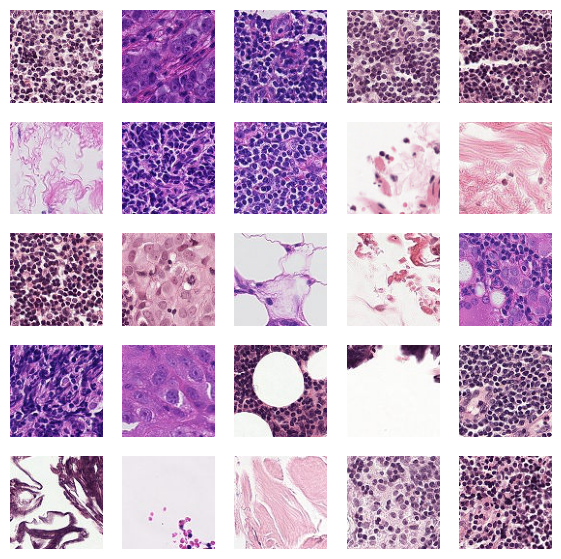

In [3]:
# Set the path to the images
train_images_path = '/kaggle/input/histopathologic-cancer-detection/train/'

# Get a list of image file names
image_files = os.listdir(train_images_path)

# Randomly select a few images
num_images_to_show = 25
selected_images = random.sample(image_files, num_images_to_show)

# Plot the selected images in a grid
fig, axes = plt.subplots(5, 5, figsize=(7, 7))
axes = axes.ravel()

for i, img_name in enumerate(selected_images):
    img_path = os.path.join(train_images_path, img_name)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

# 3.Model to choose

For the problem of histopathologic cancer detection, we can start with a Convolutional Neural Network (CNN) as it is well-suited for image classification tasks. Below, I will describe a possible model architecture and the reasoning behind the choices made.

** Input Layer: The model accepts RGB images of size (96, 96) pixels.

** Convolutional Layers: The model consists of 5 convolutional layers, each followed by batch normalization, ReLU activation function, and max-pooling layer. The first layer applies 32 filters of size (3, 3) to capture basic features such as edges and textures, and the number of filters increases up to 512 in the last layer to learn more complex features. The padding is set to 1 to preserve the spatial dimensions of the input.

** Flatten Layer: The output from the last convolutional layer is flattened into a 1D array of size 4608 before being passed to the fully connected layers.

** Fully Connected Layers: The model has 2 fully connected layers, with 256 and 2 neurons respectively. The first layer has a ReLU activation function and batch normalization, while the second layer has no activation function. Dropout with a rate of 0.4 is applied after the first fully connected layer to reduce overfitting.

** Output Layer: The final layer is a dense layer with 2 neurons and no activation function, which produces the logits for each class.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        num_classes = 2
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv3 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, stride=1, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv4 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, stride=1, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.conv5 = nn.Sequential(
                        nn.Conv2d(256, 512, 3, stride=1, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True),
                        nn.MaxPool2d(2,2))
        
        self.fc = nn.Sequential(
                  nn.Linear(512 * 3 * 3, 256),
                  nn.ReLU(inplace=True),
                  nn.BatchNorm1d(256),
                  nn.Dropout(0.4),
                  nn.Linear(256, num_classes))  

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.reshape(x.shape[0], -1) 
        x = self.fc(x)
        return x


#summary(cnn_model, input_size=(3, 46, 46), device=device.type)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = CancerNet().to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), p

# 4. Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.
Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

**4.1 Split the datasets**

In [5]:
import os
import pandas as pd
import numpy as np

!pip install scikit-learn
#!conda install scikit-learn -y

!pip install scikit-image
#!conda install scikit-image -y

from skimage.io import imread
from skimage.transform import resize

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the first image using the file name and path
first_image = imread(os.path.join(train_images_path, image_files[0]))

# Get the dimensions of the image
height, width, channels = first_image.shape

print(f"Image width: {width}")
print(f"Image height: {height}")
print(f"Image dimensions: {width} x {height} x {channels}")

# Load train labels
train_labels_df = pd.read_csv(train_labels_path)

# Select 0.01% of the data
selected_data = train_labels_df.sample(frac = 0.1, random_state=42)

# Split the selected dataset into training and validation sets (1/10 for training)
train_df, val_df = train_test_split(selected_data, train_size=0.7, random_state=42)

print(f"Number of images in train_labels_df: {train_labels_df.shape[0]}")
print(f"Number of images in selected_data: {selected_data.shape[0]}")
print(f"Number of images in train_df: {train_df.shape[0]}")
print(f"Number of images in val_df: {val_df.shape[0]}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/9.8 MB ? eta -:--:--

     ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/9.8 MB 7.4 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━ 7.2/9.8 MB 68.8 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 9.8/9.8 MB 79.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 54.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 20.2 MB/s eta 0:00:00


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/13.4 MB ? eta -:--:--

     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/13.4 MB 8.4 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 7.4/13.4 MB 70.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 12.7/13.4 MB 149.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 13.4/13.4 MB 145.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 69.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 5.1/6.9 MB 154.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 72.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 KB 19.0 MB/s eta 0:00:00


     ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/43.4 MB 144.1 MB/s eta 0:00:01

     ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/43.4 MB 146.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━ 20.6/43.4 MB 150.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━ 25.8/43.4 MB 150.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 31.1/43.4 MB 150.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━ 41.6/43.4 MB 151.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 146.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 146.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 146.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 146.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.4/43.4 MB 146.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 24.7 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 79.6 MB/s eta 0:00:00


  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1


    Uninstalling scipy-1.10.1:


      Successfully uninstalled scipy-1.10.1


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


Image width: 96
Image height: 96
Image dimensions: 96 x 96 x 3


Number of images in train_labels_df: 220025
Number of images in selected_data: 22002
Number of images in train_df: 15401
Number of images in val_df: 6601


**4.2 Preprocess the image data (resize, normalize, etc.)**

In [6]:
# Create a custom dataset class
class CancerDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0]) + '.tif'
        image = imread(img_name)
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data transformations
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

transform_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_val = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_test = transforms.Compose([transforms.ToPILImage(), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])


# Create datasets and data loaders
train_dataset = CancerDataset(train_df, train_images_path, transform=transform_train)
val_dataset = CancerDataset(val_df, train_images_path, transform=transform_val)
#test_dataset = CancerDataset(val_df, train_images_path, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

**4.3 Build and evaluate our model**

In [7]:
import tqdm

learning_rate = 0.001  # Define the learning rate for the optimizer

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

# Compile the model
#optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)
#criterion = torch.nn.BCEWithLogitsLoss()


# Train the model
num_epochs = 20
train_loss_history = []
val_loss_history = []

# Initialize variables for checkpointing
checkpoint_path = "/kaggle/working/checkpoint.pth1"
best_val_loss = float("inf")

# Reload the checkpoint
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    train_loss = checkpoint['train_loss_history']
    val_loss = checkpoint['val_loss_history']

    print(f"Model successfully reloaded from checkpoint at epoch {epoch}")


for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    model.train()
       
    for images, labels in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1} (Training)"):
        images, labels = images.to(device), labels.to(device)

        # Rest of the code inside the loop
        optimizer.zero_grad()
        outputs = model(images)
        #loss = criterion(outputs.squeeze(), labels.float())
        #loss = criterion(outputs.squeeze(), labels.unsqueeze(1))
        loss = criterion(outputs, labels.long())
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1} (Validation)"):
            images, labels = images.to(device), labels.to(device)
                
            outputs = model(images)
            #loss = criterion(outputs.squeeze(), labels.float())
            #loss = criterion(outputs.squeeze(), labels.unsqueeze(1))
            loss = criterion(outputs, labels.long())

            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    # Checkpoint the model if the validation loss improves
    if val_loss < best_val_loss:
        print("Saving checkpoint...")
        best_val_loss = val_loss
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss_history": train_loss_history,
            "val_loss_history": val_loss_history,
        }
        torch.save(checkpoint, checkpoint_path)


Epoch 1 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 1 (Training):   0%|          | 1/482 [00:00<03:17,  2.44it/s]

Epoch 1 (Training):   0%|          | 2/482 [00:00<03:00,  2.66it/s]

Epoch 1 (Training):   1%|          | 3/482 [00:01<02:53,  2.76it/s]

Epoch 1 (Training):   1%|          | 4/482 [00:01<02:42,  2.94it/s]

Epoch 1 (Training):   1%|          | 5/482 [00:01<02:39,  2.99it/s]

Epoch 1 (Training):   1%|          | 6/482 [00:02<02:38,  3.00it/s]

Epoch 1 (Training):   1%|▏         | 7/482 [00:02<02:39,  2.97it/s]

Epoch 1 (Training):   2%|▏         | 8/482 [00:02<02:39,  2.98it/s]

Epoch 1 (Training):   2%|▏         | 9/482 [00:03<02:44,  2.88it/s]

Epoch 1 (Training):   2%|▏         | 10/482 [00:03<02:45,  2.85it/s]

Epoch 1 (Training):   2%|▏         | 11/482 [00:03<02:46,  2.83it/s]

Epoch 1 (Training):   2%|▏         | 12/482 [00:04<02:44,  2.86it/s]

Epoch 1 (Training):   3%|▎         | 13/482 [00:04<02:43,  2.86it/s]

Epoch 1 (Training):   3%|▎         | 14/482 [00:04<02:44,  2.85it/s]

Epoch 1 (Training):   3%|▎         | 15/482 [00:05<02:43,  2.86it/s]

Epoch 1 (Training):   3%|▎         | 16/482 [00:05<02:41,  2.89it/s]

Epoch 1 (Training):   4%|▎         | 17/482 [00:05<02:38,  2.92it/s]

Epoch 1 (Training):   4%|▎         | 18/482 [00:06<02:37,  2.95it/s]

Epoch 1 (Training):   4%|▍         | 19/482 [00:06<02:30,  3.07it/s]

Epoch 1 (Training):   4%|▍         | 20/482 [00:06<02:30,  3.08it/s]

Epoch 1 (Training):   4%|▍         | 21/482 [00:07<02:27,  3.13it/s]

Epoch 1 (Training):   5%|▍         | 22/482 [00:07<02:26,  3.14it/s]

Epoch 1 (Training):   5%|▍         | 23/482 [00:07<02:25,  3.15it/s]

Epoch 1 (Training):   5%|▍         | 24/482 [00:08<02:23,  3.20it/s]

Epoch 1 (Training):   5%|▌         | 25/482 [00:08<02:22,  3.20it/s]

Epoch 1 (Training):   5%|▌         | 26/482 [00:08<02:24,  3.15it/s]

Epoch 1 (Training):   6%|▌         | 27/482 [00:09<02:22,  3.19it/s]

Epoch 1 (Training):   6%|▌         | 28/482 [00:09<02:24,  3.15it/s]

Epoch 1 (Training):   6%|▌         | 29/482 [00:09<02:27,  3.07it/s]

Epoch 1 (Training):   6%|▌         | 30/482 [00:10<02:30,  3.01it/s]

Epoch 1 (Training):   6%|▋         | 31/482 [00:10<02:32,  2.95it/s]

Epoch 1 (Training):   7%|▋         | 32/482 [00:10<02:29,  3.01it/s]

Epoch 1 (Training):   7%|▋         | 33/482 [00:11<02:26,  3.06it/s]

Epoch 1 (Training):   7%|▋         | 34/482 [00:11<02:27,  3.04it/s]

Epoch 1 (Training):   7%|▋         | 35/482 [00:11<02:27,  3.03it/s]

Epoch 1 (Training):   7%|▋         | 36/482 [00:12<02:27,  3.03it/s]

Epoch 1 (Training):   8%|▊         | 37/482 [00:12<02:27,  3.01it/s]

Epoch 1 (Training):   8%|▊         | 38/482 [00:12<02:25,  3.06it/s]

Epoch 1 (Training):   8%|▊         | 39/482 [00:13<02:23,  3.09it/s]

Epoch 1 (Training):   8%|▊         | 40/482 [00:13<02:22,  3.10it/s]

Epoch 1 (Training):   9%|▊         | 41/482 [00:13<02:22,  3.10it/s]

Epoch 1 (Training):   9%|▊         | 42/482 [00:13<02:20,  3.13it/s]

Epoch 1 (Training):   9%|▉         | 43/482 [00:14<02:20,  3.13it/s]

Epoch 1 (Training):   9%|▉         | 44/482 [00:14<02:19,  3.13it/s]

Epoch 1 (Training):   9%|▉         | 45/482 [00:14<02:21,  3.09it/s]

Epoch 1 (Training):  10%|▉         | 46/482 [00:15<02:20,  3.10it/s]

Epoch 1 (Training):  10%|▉         | 47/482 [00:15<02:20,  3.09it/s]

Epoch 1 (Training):  10%|▉         | 48/482 [00:15<02:21,  3.06it/s]

Epoch 1 (Training):  10%|█         | 49/482 [00:16<02:22,  3.03it/s]

Epoch 1 (Training):  10%|█         | 50/482 [00:16<02:23,  3.01it/s]

Epoch 1 (Training):  11%|█         | 51/482 [00:16<02:23,  3.01it/s]

Epoch 1 (Training):  11%|█         | 52/482 [00:17<02:19,  3.07it/s]

Epoch 1 (Training):  11%|█         | 53/482 [00:17<02:18,  3.10it/s]

Epoch 1 (Training):  11%|█         | 54/482 [00:17<02:18,  3.09it/s]

Epoch 1 (Training):  11%|█▏        | 55/482 [00:18<02:18,  3.09it/s]

Epoch 1 (Training):  12%|█▏        | 56/482 [00:18<02:15,  3.15it/s]

Epoch 1 (Training):  12%|█▏        | 57/482 [00:18<02:17,  3.10it/s]

Epoch 1 (Training):  12%|█▏        | 58/482 [00:19<02:20,  3.02it/s]

Epoch 1 (Training):  12%|█▏        | 59/482 [00:19<02:21,  2.99it/s]

Epoch 1 (Training):  12%|█▏        | 60/482 [00:19<02:22,  2.96it/s]

Epoch 1 (Training):  13%|█▎        | 61/482 [00:20<02:22,  2.95it/s]

Epoch 1 (Training):  13%|█▎        | 62/482 [00:20<02:22,  2.95it/s]

Epoch 1 (Training):  13%|█▎        | 63/482 [00:20<02:21,  2.95it/s]

Epoch 1 (Training):  13%|█▎        | 64/482 [00:21<02:21,  2.95it/s]

Epoch 1 (Training):  13%|█▎        | 65/482 [00:21<02:20,  2.97it/s]

Epoch 1 (Training):  14%|█▎        | 66/482 [00:21<02:17,  3.03it/s]

Epoch 1 (Training):  14%|█▍        | 67/482 [00:22<02:14,  3.09it/s]

Epoch 1 (Training):  14%|█▍        | 68/482 [00:22<02:12,  3.13it/s]

Epoch 1 (Training):  14%|█▍        | 69/482 [00:22<02:15,  3.06it/s]

Epoch 1 (Training):  15%|█▍        | 70/482 [00:23<02:19,  2.95it/s]

Epoch 1 (Training):  15%|█▍        | 71/482 [00:23<02:17,  2.99it/s]

Epoch 1 (Training):  15%|█▍        | 72/482 [00:23<02:17,  2.99it/s]

Epoch 1 (Training):  15%|█▌        | 73/482 [00:24<02:15,  3.02it/s]

Epoch 1 (Training):  15%|█▌        | 74/482 [00:24<02:18,  2.96it/s]

Epoch 1 (Training):  16%|█▌        | 75/482 [00:24<02:19,  2.91it/s]

Epoch 1 (Training):  16%|█▌        | 76/482 [00:25<02:16,  2.96it/s]

Epoch 1 (Training):  16%|█▌        | 77/482 [00:25<02:16,  2.96it/s]

Epoch 1 (Training):  16%|█▌        | 78/482 [00:25<02:15,  2.98it/s]

Epoch 1 (Training):  16%|█▋        | 79/482 [00:26<02:12,  3.04it/s]

Epoch 1 (Training):  17%|█▋        | 80/482 [00:26<02:11,  3.06it/s]

Epoch 1 (Training):  17%|█▋        | 81/482 [00:26<02:09,  3.10it/s]

Epoch 1 (Training):  17%|█▋        | 82/482 [00:27<02:08,  3.12it/s]

Epoch 1 (Training):  17%|█▋        | 83/482 [00:27<02:10,  3.06it/s]

Epoch 1 (Training):  17%|█▋        | 84/482 [00:27<02:13,  2.99it/s]

Epoch 1 (Training):  18%|█▊        | 85/482 [00:28<02:11,  3.01it/s]

Epoch 1 (Training):  18%|█▊        | 86/482 [00:28<02:14,  2.94it/s]

Epoch 1 (Training):  18%|█▊        | 87/482 [00:28<02:13,  2.95it/s]

Epoch 1 (Training):  18%|█▊        | 88/482 [00:29<02:11,  2.99it/s]

Epoch 1 (Training):  18%|█▊        | 89/482 [00:29<02:12,  2.98it/s]

Epoch 1 (Training):  19%|█▊        | 90/482 [00:29<02:12,  2.96it/s]

Epoch 1 (Training):  19%|█▉        | 91/482 [00:30<02:09,  3.01it/s]

Epoch 1 (Training):  19%|█▉        | 92/482 [00:30<02:10,  2.98it/s]

Epoch 1 (Training):  19%|█▉        | 93/482 [00:30<02:12,  2.93it/s]

Epoch 1 (Training):  20%|█▉        | 94/482 [00:31<02:10,  2.97it/s]

Epoch 1 (Training):  20%|█▉        | 95/482 [00:31<02:06,  3.07it/s]

Epoch 1 (Training):  20%|█▉        | 96/482 [00:31<02:05,  3.08it/s]

Epoch 1 (Training):  20%|██        | 97/482 [00:32<02:09,  2.98it/s]

Epoch 1 (Training):  20%|██        | 98/482 [00:32<02:08,  2.98it/s]

Epoch 1 (Training):  21%|██        | 99/482 [00:32<02:08,  2.97it/s]

Epoch 1 (Training):  21%|██        | 100/482 [00:33<02:06,  3.03it/s]

Epoch 1 (Training):  21%|██        | 101/482 [00:33<02:02,  3.10it/s]

Epoch 1 (Training):  21%|██        | 102/482 [00:33<02:02,  3.11it/s]

Epoch 1 (Training):  21%|██▏       | 103/482 [00:34<02:04,  3.06it/s]

Epoch 1 (Training):  22%|██▏       | 104/482 [00:34<02:04,  3.05it/s]

Epoch 1 (Training):  22%|██▏       | 105/482 [00:34<02:03,  3.05it/s]

Epoch 1 (Training):  22%|██▏       | 106/482 [00:35<02:07,  2.95it/s]

Epoch 1 (Training):  22%|██▏       | 107/482 [00:35<02:04,  3.01it/s]

Epoch 1 (Training):  22%|██▏       | 108/482 [00:35<02:03,  3.03it/s]

Epoch 1 (Training):  23%|██▎       | 109/482 [00:36<02:00,  3.09it/s]

Epoch 1 (Training):  23%|██▎       | 110/482 [00:36<02:00,  3.07it/s]

Epoch 1 (Training):  23%|██▎       | 111/482 [00:36<02:00,  3.07it/s]

Epoch 1 (Training):  23%|██▎       | 112/482 [00:37<01:57,  3.15it/s]

Epoch 1 (Training):  23%|██▎       | 113/482 [00:37<01:55,  3.20it/s]

Epoch 1 (Training):  24%|██▎       | 114/482 [00:37<01:53,  3.23it/s]

Epoch 1 (Training):  24%|██▍       | 115/482 [00:38<01:57,  3.12it/s]

Epoch 1 (Training):  24%|██▍       | 116/482 [00:38<01:54,  3.18it/s]

Epoch 1 (Training):  24%|██▍       | 117/482 [00:38<01:55,  3.15it/s]

Epoch 1 (Training):  24%|██▍       | 118/482 [00:38<01:55,  3.14it/s]

Epoch 1 (Training):  25%|██▍       | 119/482 [00:39<01:57,  3.09it/s]

Epoch 1 (Training):  25%|██▍       | 120/482 [00:39<01:54,  3.15it/s]

Epoch 1 (Training):  25%|██▌       | 121/482 [00:39<01:56,  3.10it/s]

Epoch 1 (Training):  25%|██▌       | 122/482 [00:40<01:55,  3.11it/s]

Epoch 1 (Training):  26%|██▌       | 123/482 [00:40<01:54,  3.12it/s]

Epoch 1 (Training):  26%|██▌       | 124/482 [00:40<01:55,  3.09it/s]

Epoch 1 (Training):  26%|██▌       | 125/482 [00:41<01:54,  3.12it/s]

Epoch 1 (Training):  26%|██▌       | 126/482 [00:41<01:54,  3.11it/s]

Epoch 1 (Training):  26%|██▋       | 127/482 [00:41<01:54,  3.09it/s]

Epoch 1 (Training):  27%|██▋       | 128/482 [00:42<01:53,  3.12it/s]

Epoch 1 (Training):  27%|██▋       | 129/482 [00:42<01:54,  3.09it/s]

Epoch 1 (Training):  27%|██▋       | 130/482 [00:42<01:52,  3.13it/s]

Epoch 1 (Training):  27%|██▋       | 131/482 [00:43<01:52,  3.11it/s]

Epoch 1 (Training):  27%|██▋       | 132/482 [00:43<01:55,  3.04it/s]

Epoch 1 (Training):  28%|██▊       | 133/482 [00:43<01:54,  3.05it/s]

Epoch 1 (Training):  28%|██▊       | 134/482 [00:44<01:55,  3.01it/s]

Epoch 1 (Training):  28%|██▊       | 135/482 [00:44<01:56,  2.98it/s]

Epoch 1 (Training):  28%|██▊       | 136/482 [00:44<01:55,  2.98it/s]

Epoch 1 (Training):  28%|██▊       | 137/482 [00:45<01:55,  2.98it/s]

Epoch 1 (Training):  29%|██▊       | 138/482 [00:45<01:56,  2.96it/s]

Epoch 1 (Training):  29%|██▉       | 139/482 [00:45<01:58,  2.90it/s]

Epoch 1 (Training):  29%|██▉       | 140/482 [00:46<02:00,  2.85it/s]

Epoch 1 (Training):  29%|██▉       | 141/482 [00:46<01:58,  2.87it/s]

Epoch 1 (Training):  29%|██▉       | 142/482 [00:46<01:58,  2.87it/s]

Epoch 1 (Training):  30%|██▉       | 143/482 [00:47<01:59,  2.85it/s]

Epoch 1 (Training):  30%|██▉       | 144/482 [00:47<01:55,  2.92it/s]

Epoch 1 (Training):  30%|███       | 145/482 [00:47<01:54,  2.94it/s]

Epoch 1 (Training):  30%|███       | 146/482 [00:48<01:56,  2.90it/s]

Epoch 1 (Training):  30%|███       | 147/482 [00:48<01:54,  2.92it/s]

Epoch 1 (Training):  31%|███       | 148/482 [00:49<01:54,  2.91it/s]

Epoch 1 (Training):  31%|███       | 149/482 [00:49<01:55,  2.88it/s]

Epoch 1 (Training):  31%|███       | 150/482 [00:49<01:55,  2.88it/s]

Epoch 1 (Training):  31%|███▏      | 151/482 [00:50<01:59,  2.78it/s]

Epoch 1 (Training):  32%|███▏      | 152/482 [00:50<01:58,  2.78it/s]

Epoch 1 (Training):  32%|███▏      | 153/482 [00:50<01:58,  2.78it/s]

Epoch 1 (Training):  32%|███▏      | 154/482 [00:51<01:55,  2.84it/s]

Epoch 1 (Training):  32%|███▏      | 155/482 [00:51<01:52,  2.90it/s]

Epoch 1 (Training):  32%|███▏      | 156/482 [00:51<01:50,  2.95it/s]

Epoch 1 (Training):  33%|███▎      | 157/482 [00:52<01:47,  3.02it/s]

Epoch 1 (Training):  33%|███▎      | 158/482 [00:52<01:46,  3.03it/s]

Epoch 1 (Training):  33%|███▎      | 159/482 [00:52<01:47,  3.02it/s]

Epoch 1 (Training):  33%|███▎      | 160/482 [00:53<01:44,  3.07it/s]

Epoch 1 (Training):  33%|███▎      | 161/482 [00:53<01:45,  3.05it/s]

Epoch 1 (Training):  34%|███▎      | 162/482 [00:53<01:42,  3.11it/s]

Epoch 1 (Training):  34%|███▍      | 163/482 [00:54<01:42,  3.11it/s]

Epoch 1 (Training):  34%|███▍      | 164/482 [00:54<01:43,  3.06it/s]

Epoch 1 (Training):  34%|███▍      | 165/482 [00:54<01:44,  3.03it/s]

Epoch 1 (Training):  34%|███▍      | 166/482 [00:55<01:46,  2.97it/s]

Epoch 1 (Training):  35%|███▍      | 167/482 [00:55<01:46,  2.95it/s]

Epoch 1 (Training):  35%|███▍      | 168/482 [00:55<01:46,  2.94it/s]

Epoch 1 (Training):  35%|███▌      | 169/482 [00:56<01:44,  2.99it/s]

Epoch 1 (Training):  35%|███▌      | 170/482 [00:56<01:44,  2.98it/s]

Epoch 1 (Training):  35%|███▌      | 171/482 [00:56<01:43,  3.00it/s]

Epoch 1 (Training):  36%|███▌      | 172/482 [00:57<01:44,  2.97it/s]

Epoch 1 (Training):  36%|███▌      | 173/482 [00:57<01:46,  2.91it/s]

Epoch 1 (Training):  36%|███▌      | 174/482 [00:57<01:44,  2.95it/s]

Epoch 1 (Training):  36%|███▋      | 175/482 [00:58<01:41,  3.01it/s]

Epoch 1 (Training):  37%|███▋      | 176/482 [00:58<01:40,  3.04it/s]

Epoch 1 (Training):  37%|███▋      | 177/482 [00:58<01:39,  3.08it/s]

Epoch 1 (Training):  37%|███▋      | 178/482 [00:59<01:36,  3.14it/s]

Epoch 1 (Training):  37%|███▋      | 179/482 [00:59<01:34,  3.20it/s]

Epoch 1 (Training):  37%|███▋      | 180/482 [00:59<01:34,  3.20it/s]

Epoch 1 (Training):  38%|███▊      | 181/482 [00:59<01:36,  3.13it/s]

Epoch 1 (Training):  38%|███▊      | 182/482 [01:00<01:37,  3.08it/s]

Epoch 1 (Training):  38%|███▊      | 183/482 [01:00<01:37,  3.08it/s]

Epoch 1 (Training):  38%|███▊      | 184/482 [01:01<01:39,  3.01it/s]

Epoch 1 (Training):  38%|███▊      | 185/482 [01:01<01:42,  2.90it/s]

Epoch 1 (Training):  39%|███▊      | 186/482 [01:01<01:40,  2.96it/s]

Epoch 1 (Training):  39%|███▉      | 187/482 [01:02<01:37,  3.02it/s]

Epoch 1 (Training):  39%|███▉      | 188/482 [01:02<01:38,  3.00it/s]

Epoch 1 (Training):  39%|███▉      | 189/482 [01:02<01:39,  2.95it/s]

Epoch 1 (Training):  39%|███▉      | 190/482 [01:03<01:38,  2.96it/s]

Epoch 1 (Training):  40%|███▉      | 191/482 [01:03<01:40,  2.88it/s]

Epoch 1 (Training):  40%|███▉      | 192/482 [01:03<01:43,  2.80it/s]

Epoch 1 (Training):  40%|████      | 193/482 [01:04<01:41,  2.85it/s]

Epoch 1 (Training):  40%|████      | 194/482 [01:04<01:39,  2.88it/s]

Epoch 1 (Training):  40%|████      | 195/482 [01:04<01:39,  2.88it/s]

Epoch 1 (Training):  41%|████      | 196/482 [01:05<01:38,  2.91it/s]

Epoch 1 (Training):  41%|████      | 197/482 [01:05<01:36,  2.96it/s]

Epoch 1 (Training):  41%|████      | 198/482 [01:05<01:36,  2.93it/s]

Epoch 1 (Training):  41%|████▏     | 199/482 [01:06<01:35,  2.98it/s]

Epoch 1 (Training):  41%|████▏     | 200/482 [01:06<01:32,  3.06it/s]

Epoch 1 (Training):  42%|████▏     | 201/482 [01:06<01:31,  3.07it/s]

Epoch 1 (Training):  42%|████▏     | 202/482 [01:07<01:30,  3.08it/s]

Epoch 1 (Training):  42%|████▏     | 203/482 [01:07<01:28,  3.14it/s]

Epoch 1 (Training):  42%|████▏     | 204/482 [01:07<01:28,  3.14it/s]

Epoch 1 (Training):  43%|████▎     | 205/482 [01:08<01:29,  3.08it/s]

Epoch 1 (Training):  43%|████▎     | 206/482 [01:08<01:31,  3.03it/s]

Epoch 1 (Training):  43%|████▎     | 207/482 [01:08<01:31,  3.01it/s]

Epoch 1 (Training):  43%|████▎     | 208/482 [01:09<01:30,  3.04it/s]

Epoch 1 (Training):  43%|████▎     | 209/482 [01:09<01:28,  3.08it/s]

Epoch 1 (Training):  44%|████▎     | 210/482 [01:09<01:28,  3.06it/s]

Epoch 1 (Training):  44%|████▍     | 211/482 [01:10<01:30,  3.01it/s]

Epoch 1 (Training):  44%|████▍     | 212/482 [01:10<01:30,  2.99it/s]

Epoch 1 (Training):  44%|████▍     | 213/482 [01:10<01:31,  2.95it/s]

Epoch 1 (Training):  44%|████▍     | 214/482 [01:11<01:31,  2.94it/s]

Epoch 1 (Training):  45%|████▍     | 215/482 [01:11<01:30,  2.95it/s]

Epoch 1 (Training):  45%|████▍     | 216/482 [01:11<01:27,  3.02it/s]

Epoch 1 (Training):  45%|████▌     | 217/482 [01:12<01:29,  2.96it/s]

Epoch 1 (Training):  45%|████▌     | 218/482 [01:12<01:28,  2.99it/s]

Epoch 1 (Training):  45%|████▌     | 219/482 [01:12<01:29,  2.94it/s]

Epoch 1 (Training):  46%|████▌     | 220/482 [01:13<01:29,  2.92it/s]

Epoch 1 (Training):  46%|████▌     | 221/482 [01:13<01:29,  2.90it/s]

Epoch 1 (Training):  46%|████▌     | 222/482 [01:13<01:27,  2.99it/s]

Epoch 1 (Training):  46%|████▋     | 223/482 [01:14<01:27,  2.96it/s]

Epoch 1 (Training):  46%|████▋     | 224/482 [01:14<01:28,  2.92it/s]

Epoch 1 (Training):  47%|████▋     | 225/482 [01:14<01:26,  2.98it/s]

Epoch 1 (Training):  47%|████▋     | 226/482 [01:15<01:26,  2.97it/s]

Epoch 1 (Training):  47%|████▋     | 227/482 [01:15<01:25,  2.97it/s]

Epoch 1 (Training):  47%|████▋     | 228/482 [01:15<01:25,  2.98it/s]

Epoch 1 (Training):  48%|████▊     | 229/482 [01:16<01:24,  2.99it/s]

Epoch 1 (Training):  48%|████▊     | 230/482 [01:16<01:24,  2.98it/s]

Epoch 1 (Training):  48%|████▊     | 231/482 [01:16<01:21,  3.07it/s]

Epoch 1 (Training):  48%|████▊     | 232/482 [01:17<01:21,  3.07it/s]

Epoch 1 (Training):  48%|████▊     | 233/482 [01:17<01:21,  3.04it/s]

Epoch 1 (Training):  49%|████▊     | 234/482 [01:17<01:22,  3.02it/s]

Epoch 1 (Training):  49%|████▉     | 235/482 [01:18<01:21,  3.04it/s]

Epoch 1 (Training):  49%|████▉     | 236/482 [01:18<01:21,  3.00it/s]

Epoch 1 (Training):  49%|████▉     | 237/482 [01:18<01:22,  2.98it/s]

Epoch 1 (Training):  49%|████▉     | 238/482 [01:19<01:21,  2.98it/s]

Epoch 1 (Training):  50%|████▉     | 239/482 [01:19<01:21,  2.99it/s]

Epoch 1 (Training):  50%|████▉     | 240/482 [01:19<01:23,  2.91it/s]

Epoch 1 (Training):  50%|█████     | 241/482 [01:20<01:21,  2.95it/s]

Epoch 1 (Training):  50%|█████     | 242/482 [01:20<01:22,  2.92it/s]

Epoch 1 (Training):  50%|█████     | 243/482 [01:20<01:21,  2.94it/s]

Epoch 1 (Training):  51%|█████     | 244/482 [01:21<01:19,  2.99it/s]

Epoch 1 (Training):  51%|█████     | 245/482 [01:21<01:17,  3.04it/s]

Epoch 1 (Training):  51%|█████     | 246/482 [01:21<01:15,  3.12it/s]

Epoch 1 (Training):  51%|█████     | 247/482 [01:22<01:14,  3.17it/s]

Epoch 1 (Training):  51%|█████▏    | 248/482 [01:22<01:13,  3.19it/s]

Epoch 1 (Training):  52%|█████▏    | 249/482 [01:22<01:15,  3.07it/s]

Epoch 1 (Training):  52%|█████▏    | 250/482 [01:23<01:14,  3.10it/s]

Epoch 1 (Training):  52%|█████▏    | 251/482 [01:23<01:14,  3.09it/s]

Epoch 1 (Training):  52%|█████▏    | 252/482 [01:23<01:14,  3.09it/s]

Epoch 1 (Training):  52%|█████▏    | 253/482 [01:24<01:14,  3.09it/s]

Epoch 1 (Training):  53%|█████▎    | 254/482 [01:24<01:16,  3.00it/s]

Epoch 1 (Training):  53%|█████▎    | 255/482 [01:24<01:15,  3.02it/s]

Epoch 1 (Training):  53%|█████▎    | 256/482 [01:25<01:17,  2.91it/s]

Epoch 1 (Training):  53%|█████▎    | 257/482 [01:25<01:16,  2.96it/s]

Epoch 1 (Training):  54%|█████▎    | 258/482 [01:25<01:15,  2.98it/s]

Epoch 1 (Training):  54%|█████▎    | 259/482 [01:26<01:15,  2.96it/s]

Epoch 1 (Training):  54%|█████▍    | 260/482 [01:26<01:14,  2.97it/s]

Epoch 1 (Training):  54%|█████▍    | 261/482 [01:26<01:13,  2.99it/s]

Epoch 1 (Training):  54%|█████▍    | 262/482 [01:27<01:13,  3.00it/s]

Epoch 1 (Training):  55%|█████▍    | 263/482 [01:27<01:13,  2.97it/s]

Epoch 1 (Training):  55%|█████▍    | 264/482 [01:27<01:12,  2.99it/s]

Epoch 1 (Training):  55%|█████▍    | 265/482 [01:28<01:12,  2.99it/s]

Epoch 1 (Training):  55%|█████▌    | 266/482 [01:28<01:10,  3.06it/s]

Epoch 1 (Training):  55%|█████▌    | 267/482 [01:28<01:10,  3.05it/s]

Epoch 1 (Training):  56%|█████▌    | 268/482 [01:29<01:11,  3.01it/s]

Epoch 1 (Training):  56%|█████▌    | 269/482 [01:29<01:09,  3.07it/s]

Epoch 1 (Training):  56%|█████▌    | 270/482 [01:29<01:09,  3.06it/s]

Epoch 1 (Training):  56%|█████▌    | 271/482 [01:30<01:10,  3.01it/s]

Epoch 1 (Training):  56%|█████▋    | 272/482 [01:30<01:09,  3.00it/s]

Epoch 1 (Training):  57%|█████▋    | 273/482 [01:30<01:09,  3.01it/s]

Epoch 1 (Training):  57%|█████▋    | 274/482 [01:31<01:09,  3.01it/s]

Epoch 1 (Training):  57%|█████▋    | 275/482 [01:31<01:08,  3.03it/s]

Epoch 1 (Training):  57%|█████▋    | 276/482 [01:31<01:07,  3.05it/s]

Epoch 1 (Training):  57%|█████▋    | 277/482 [01:32<01:07,  3.04it/s]

Epoch 1 (Training):  58%|█████▊    | 278/482 [01:32<01:07,  3.04it/s]

Epoch 1 (Training):  58%|█████▊    | 279/482 [01:32<01:07,  3.01it/s]

Epoch 1 (Training):  58%|█████▊    | 280/482 [01:33<01:07,  3.01it/s]

Epoch 1 (Training):  58%|█████▊    | 281/482 [01:33<01:06,  3.02it/s]

Epoch 1 (Training):  59%|█████▊    | 282/482 [01:33<01:05,  3.06it/s]

Epoch 1 (Training):  59%|█████▊    | 283/482 [01:33<01:04,  3.11it/s]

Epoch 1 (Training):  59%|█████▉    | 284/482 [01:34<01:04,  3.05it/s]

Epoch 1 (Training):  59%|█████▉    | 285/482 [01:34<01:05,  3.00it/s]

Epoch 1 (Training):  59%|█████▉    | 286/482 [01:35<01:07,  2.89it/s]

Epoch 1 (Training):  60%|█████▉    | 287/482 [01:35<01:08,  2.84it/s]

Epoch 1 (Training):  60%|█████▉    | 288/482 [01:35<01:06,  2.93it/s]

Epoch 1 (Training):  60%|█████▉    | 289/482 [01:36<01:05,  2.96it/s]

Epoch 1 (Training):  60%|██████    | 290/482 [01:36<01:03,  3.04it/s]

Epoch 1 (Training):  60%|██████    | 291/482 [01:36<01:02,  3.07it/s]

Epoch 1 (Training):  61%|██████    | 292/482 [01:37<01:01,  3.09it/s]

Epoch 1 (Training):  61%|██████    | 293/482 [01:37<01:01,  3.05it/s]

Epoch 1 (Training):  61%|██████    | 294/482 [01:37<01:01,  3.05it/s]

Epoch 1 (Training):  61%|██████    | 295/482 [01:38<01:01,  3.03it/s]

Epoch 1 (Training):  61%|██████▏   | 296/482 [01:38<01:00,  3.07it/s]

Epoch 1 (Training):  62%|██████▏   | 297/482 [01:38<01:00,  3.05it/s]

Epoch 1 (Training):  62%|██████▏   | 298/482 [01:38<01:00,  3.04it/s]

Epoch 1 (Training):  62%|██████▏   | 299/482 [01:39<01:00,  3.02it/s]

Epoch 1 (Training):  62%|██████▏   | 300/482 [01:39<00:59,  3.04it/s]

Epoch 1 (Training):  62%|██████▏   | 301/482 [01:40<01:01,  2.94it/s]

Epoch 1 (Training):  63%|██████▎   | 302/482 [01:40<01:01,  2.92it/s]

Epoch 1 (Training):  63%|██████▎   | 303/482 [01:40<01:00,  2.95it/s]

Epoch 1 (Training):  63%|██████▎   | 304/482 [01:41<00:59,  3.01it/s]

Epoch 1 (Training):  63%|██████▎   | 305/482 [01:41<00:58,  3.02it/s]

Epoch 1 (Training):  63%|██████▎   | 306/482 [01:41<00:59,  2.96it/s]

Epoch 1 (Training):  64%|██████▎   | 307/482 [01:42<00:59,  2.93it/s]

Epoch 1 (Training):  64%|██████▍   | 308/482 [01:42<01:01,  2.85it/s]

Epoch 1 (Training):  64%|██████▍   | 309/482 [01:42<00:59,  2.89it/s]

Epoch 1 (Training):  64%|██████▍   | 310/482 [01:43<00:58,  2.94it/s]

Epoch 1 (Training):  65%|██████▍   | 311/482 [01:43<00:57,  2.96it/s]

Epoch 1 (Training):  65%|██████▍   | 312/482 [01:43<00:57,  2.97it/s]

Epoch 1 (Training):  65%|██████▍   | 313/482 [01:44<00:56,  2.97it/s]

Epoch 1 (Training):  65%|██████▌   | 314/482 [01:44<00:56,  2.97it/s]

Epoch 1 (Training):  65%|██████▌   | 315/482 [01:44<00:58,  2.88it/s]

Epoch 1 (Training):  66%|██████▌   | 316/482 [01:45<00:57,  2.90it/s]

Epoch 1 (Training):  66%|██████▌   | 317/482 [01:45<00:55,  2.98it/s]

Epoch 1 (Training):  66%|██████▌   | 318/482 [01:45<00:57,  2.86it/s]

Epoch 1 (Training):  66%|██████▌   | 319/482 [01:46<00:56,  2.89it/s]

Epoch 1 (Training):  66%|██████▋   | 320/482 [01:46<00:55,  2.93it/s]

Epoch 1 (Training):  67%|██████▋   | 321/482 [01:46<00:54,  2.97it/s]

Epoch 1 (Training):  67%|██████▋   | 322/482 [01:47<00:53,  2.98it/s]

Epoch 1 (Training):  67%|██████▋   | 323/482 [01:47<00:53,  3.00it/s]

Epoch 1 (Training):  67%|██████▋   | 324/482 [01:47<00:53,  2.94it/s]

Epoch 1 (Training):  67%|██████▋   | 325/482 [01:48<00:54,  2.89it/s]

Epoch 1 (Training):  68%|██████▊   | 326/482 [01:48<00:54,  2.87it/s]

Epoch 1 (Training):  68%|██████▊   | 327/482 [01:48<00:52,  2.95it/s]

Epoch 1 (Training):  68%|██████▊   | 328/482 [01:49<00:52,  2.96it/s]

Epoch 1 (Training):  68%|██████▊   | 329/482 [01:49<00:51,  2.94it/s]

Epoch 1 (Training):  68%|██████▊   | 330/482 [01:49<00:52,  2.89it/s]

Epoch 1 (Training):  69%|██████▊   | 331/482 [01:50<00:51,  2.93it/s]

Epoch 1 (Training):  69%|██████▉   | 332/482 [01:50<00:51,  2.91it/s]

Epoch 1 (Training):  69%|██████▉   | 333/482 [01:50<00:50,  2.94it/s]

Epoch 1 (Training):  69%|██████▉   | 334/482 [01:51<00:50,  2.96it/s]

Epoch 1 (Training):  70%|██████▉   | 335/482 [01:51<00:49,  2.96it/s]

Epoch 1 (Training):  70%|██████▉   | 336/482 [01:51<00:48,  3.02it/s]

Epoch 1 (Training):  70%|██████▉   | 337/482 [01:52<00:47,  3.02it/s]

Epoch 1 (Training):  70%|███████   | 338/482 [01:52<00:47,  3.04it/s]

Epoch 1 (Training):  70%|███████   | 339/482 [01:52<00:48,  2.97it/s]

Epoch 1 (Training):  71%|███████   | 340/482 [01:53<00:47,  3.00it/s]

Epoch 1 (Training):  71%|███████   | 341/482 [01:53<00:46,  3.03it/s]

Epoch 1 (Training):  71%|███████   | 342/482 [01:53<00:45,  3.05it/s]

Epoch 1 (Training):  71%|███████   | 343/482 [01:54<00:45,  3.05it/s]

Epoch 1 (Training):  71%|███████▏  | 344/482 [01:54<00:46,  2.99it/s]

Epoch 1 (Training):  72%|███████▏  | 345/482 [01:54<00:46,  2.96it/s]

Epoch 1 (Training):  72%|███████▏  | 346/482 [01:55<00:46,  2.95it/s]

Epoch 1 (Training):  72%|███████▏  | 347/482 [01:55<00:45,  2.98it/s]

Epoch 1 (Training):  72%|███████▏  | 348/482 [01:55<00:45,  2.95it/s]

Epoch 1 (Training):  72%|███████▏  | 349/482 [01:56<00:45,  2.92it/s]

Epoch 1 (Training):  73%|███████▎  | 350/482 [01:56<00:45,  2.92it/s]

Epoch 1 (Training):  73%|███████▎  | 351/482 [01:56<00:44,  2.96it/s]

Epoch 1 (Training):  73%|███████▎  | 352/482 [01:57<00:43,  3.02it/s]

Epoch 1 (Training):  73%|███████▎  | 353/482 [01:57<00:43,  2.98it/s]

Epoch 1 (Training):  73%|███████▎  | 354/482 [01:57<00:42,  3.00it/s]

Epoch 1 (Training):  74%|███████▎  | 355/482 [01:58<00:41,  3.07it/s]

Epoch 1 (Training):  74%|███████▍  | 356/482 [01:58<00:40,  3.09it/s]

Epoch 1 (Training):  74%|███████▍  | 357/482 [01:58<00:40,  3.10it/s]

Epoch 1 (Training):  74%|███████▍  | 358/482 [01:59<00:40,  3.10it/s]

Epoch 1 (Training):  74%|███████▍  | 359/482 [01:59<00:39,  3.13it/s]

Epoch 1 (Training):  75%|███████▍  | 360/482 [01:59<00:38,  3.17it/s]

Epoch 1 (Training):  75%|███████▍  | 361/482 [02:00<00:39,  3.08it/s]

Epoch 1 (Training):  75%|███████▌  | 362/482 [02:00<00:39,  3.03it/s]

Epoch 1 (Training):  75%|███████▌  | 363/482 [02:00<00:40,  2.94it/s]

Epoch 1 (Training):  76%|███████▌  | 364/482 [02:01<00:40,  2.93it/s]

Epoch 1 (Training):  76%|███████▌  | 365/482 [02:01<00:38,  3.01it/s]

Epoch 1 (Training):  76%|███████▌  | 366/482 [02:01<00:37,  3.06it/s]

Epoch 1 (Training):  76%|███████▌  | 367/482 [02:02<00:37,  3.11it/s]

Epoch 1 (Training):  76%|███████▋  | 368/482 [02:02<00:36,  3.12it/s]

Epoch 1 (Training):  77%|███████▋  | 369/482 [02:02<00:36,  3.08it/s]

Epoch 1 (Training):  77%|███████▋  | 370/482 [02:03<00:38,  2.90it/s]

Epoch 1 (Training):  77%|███████▋  | 371/482 [02:03<00:45,  2.44it/s]

Epoch 1 (Training):  77%|███████▋  | 372/482 [02:04<00:42,  2.57it/s]

Epoch 1 (Training):  77%|███████▋  | 373/482 [02:04<00:40,  2.71it/s]

Epoch 1 (Training):  78%|███████▊  | 374/482 [02:04<00:38,  2.80it/s]

Epoch 1 (Training):  78%|███████▊  | 375/482 [02:05<00:37,  2.85it/s]

Epoch 1 (Training):  78%|███████▊  | 376/482 [02:05<00:36,  2.89it/s]

Epoch 1 (Training):  78%|███████▊  | 377/482 [02:05<00:36,  2.84it/s]

Epoch 1 (Training):  78%|███████▊  | 378/482 [02:06<00:35,  2.89it/s]

Epoch 1 (Training):  79%|███████▊  | 379/482 [02:06<00:35,  2.93it/s]

Epoch 1 (Training):  79%|███████▉  | 380/482 [02:06<00:33,  3.02it/s]

Epoch 1 (Training):  79%|███████▉  | 381/482 [02:07<00:33,  3.04it/s]

Epoch 1 (Training):  79%|███████▉  | 382/482 [02:07<00:32,  3.09it/s]

Epoch 1 (Training):  79%|███████▉  | 383/482 [02:07<00:31,  3.11it/s]

Epoch 1 (Training):  80%|███████▉  | 384/482 [02:07<00:30,  3.17it/s]

Epoch 1 (Training):  80%|███████▉  | 385/482 [02:08<00:30,  3.13it/s]

Epoch 1 (Training):  80%|████████  | 386/482 [02:08<00:30,  3.14it/s]

Epoch 1 (Training):  80%|████████  | 387/482 [02:08<00:30,  3.14it/s]

Epoch 1 (Training):  80%|████████  | 388/482 [02:09<00:30,  3.07it/s]

Epoch 1 (Training):  81%|████████  | 389/482 [02:09<00:30,  3.04it/s]

Epoch 1 (Training):  81%|████████  | 390/482 [02:10<00:31,  2.94it/s]

Epoch 1 (Training):  81%|████████  | 391/482 [02:10<00:31,  2.88it/s]

Epoch 1 (Training):  81%|████████▏ | 392/482 [02:10<00:31,  2.87it/s]

Epoch 1 (Training):  82%|████████▏ | 393/482 [02:11<00:30,  2.88it/s]

Epoch 1 (Training):  82%|████████▏ | 394/482 [02:11<00:31,  2.79it/s]

Epoch 1 (Training):  82%|████████▏ | 395/482 [02:11<00:31,  2.79it/s]

Epoch 1 (Training):  82%|████████▏ | 396/482 [02:12<00:30,  2.86it/s]

Epoch 1 (Training):  82%|████████▏ | 397/482 [02:12<00:29,  2.87it/s]

Epoch 1 (Training):  83%|████████▎ | 398/482 [02:12<00:29,  2.83it/s]

Epoch 1 (Training):  83%|████████▎ | 399/482 [02:13<00:29,  2.85it/s]

Epoch 1 (Training):  83%|████████▎ | 400/482 [02:13<00:29,  2.75it/s]

Epoch 1 (Training):  83%|████████▎ | 401/482 [02:13<00:28,  2.85it/s]

Epoch 1 (Training):  83%|████████▎ | 402/482 [02:14<00:27,  2.91it/s]

Epoch 1 (Training):  84%|████████▎ | 403/482 [02:14<00:27,  2.92it/s]

Epoch 1 (Training):  84%|████████▍ | 404/482 [02:14<00:27,  2.84it/s]

Epoch 1 (Training):  84%|████████▍ | 405/482 [02:15<00:27,  2.81it/s]

Epoch 1 (Training):  84%|████████▍ | 406/482 [02:15<00:26,  2.82it/s]

Epoch 1 (Training):  84%|████████▍ | 407/482 [02:16<00:26,  2.82it/s]

Epoch 1 (Training):  85%|████████▍ | 408/482 [02:16<00:25,  2.88it/s]

Epoch 1 (Training):  85%|████████▍ | 409/482 [02:16<00:24,  2.94it/s]

Epoch 1 (Training):  85%|████████▌ | 410/482 [02:16<00:23,  3.04it/s]

Epoch 1 (Training):  85%|████████▌ | 411/482 [02:17<00:23,  3.07it/s]

Epoch 1 (Training):  85%|████████▌ | 412/482 [02:17<00:23,  3.01it/s]

Epoch 1 (Training):  86%|████████▌ | 413/482 [02:17<00:22,  3.02it/s]

Epoch 1 (Training):  86%|████████▌ | 414/482 [02:18<00:22,  3.06it/s]

Epoch 1 (Training):  86%|████████▌ | 415/482 [02:18<00:21,  3.08it/s]

Epoch 1 (Training):  86%|████████▋ | 416/482 [02:18<00:21,  3.08it/s]

Epoch 1 (Training):  87%|████████▋ | 417/482 [02:19<00:21,  3.07it/s]

Epoch 1 (Training):  87%|████████▋ | 418/482 [02:19<00:21,  3.01it/s]

Epoch 1 (Training):  87%|████████▋ | 419/482 [02:19<00:21,  2.92it/s]

Epoch 1 (Training):  87%|████████▋ | 420/482 [02:20<00:21,  2.92it/s]

Epoch 1 (Training):  87%|████████▋ | 421/482 [02:20<00:20,  2.91it/s]

Epoch 1 (Training):  88%|████████▊ | 422/482 [02:21<00:20,  2.91it/s]

Epoch 1 (Training):  88%|████████▊ | 423/482 [02:21<00:20,  2.92it/s]

Epoch 1 (Training):  88%|████████▊ | 424/482 [02:21<00:19,  2.98it/s]

Epoch 1 (Training):  88%|████████▊ | 425/482 [02:21<00:18,  3.03it/s]

Epoch 1 (Training):  88%|████████▊ | 426/482 [02:22<00:18,  3.01it/s]

Epoch 1 (Training):  89%|████████▊ | 427/482 [02:22<00:18,  2.99it/s]

Epoch 1 (Training):  89%|████████▉ | 428/482 [02:22<00:18,  2.98it/s]

Epoch 1 (Training):  89%|████████▉ | 429/482 [02:23<00:18,  2.93it/s]

Epoch 1 (Training):  89%|████████▉ | 430/482 [02:23<00:17,  2.94it/s]

Epoch 1 (Training):  89%|████████▉ | 431/482 [02:24<00:17,  2.95it/s]

Epoch 1 (Training):  90%|████████▉ | 432/482 [02:24<00:16,  3.00it/s]

Epoch 1 (Training):  90%|████████▉ | 433/482 [02:24<00:16,  2.90it/s]

Epoch 1 (Training):  90%|█████████ | 434/482 [02:25<00:16,  2.87it/s]

Epoch 1 (Training):  90%|█████████ | 435/482 [02:25<00:16,  2.82it/s]

Epoch 1 (Training):  90%|█████████ | 436/482 [02:25<00:16,  2.87it/s]

Epoch 1 (Training):  91%|█████████ | 437/482 [02:26<00:15,  2.86it/s]

Epoch 1 (Training):  91%|█████████ | 438/482 [02:26<00:15,  2.87it/s]

Epoch 1 (Training):  91%|█████████ | 439/482 [02:26<00:14,  2.91it/s]

Epoch 1 (Training):  91%|█████████▏| 440/482 [02:27<00:14,  2.86it/s]

Epoch 1 (Training):  91%|█████████▏| 441/482 [02:27<00:14,  2.86it/s]

Epoch 1 (Training):  92%|█████████▏| 442/482 [02:27<00:13,  2.89it/s]

Epoch 1 (Training):  92%|█████████▏| 443/482 [02:28<00:13,  2.90it/s]

Epoch 1 (Training):  92%|█████████▏| 444/482 [02:28<00:13,  2.87it/s]

Epoch 1 (Training):  92%|█████████▏| 445/482 [02:28<00:12,  2.91it/s]

Epoch 1 (Training):  93%|█████████▎| 446/482 [02:29<00:12,  2.91it/s]

Epoch 1 (Training):  93%|█████████▎| 447/482 [02:29<00:12,  2.89it/s]

Epoch 1 (Training):  93%|█████████▎| 448/482 [02:29<00:11,  2.83it/s]

Epoch 1 (Training):  93%|█████████▎| 449/482 [02:30<00:11,  2.86it/s]

Epoch 1 (Training):  93%|█████████▎| 450/482 [02:30<00:11,  2.83it/s]

Epoch 1 (Training):  94%|█████████▎| 451/482 [02:31<00:11,  2.81it/s]

Epoch 1 (Training):  94%|█████████▍| 452/482 [02:31<00:10,  2.87it/s]

Epoch 1 (Training):  94%|█████████▍| 453/482 [02:31<00:09,  2.93it/s]

Epoch 1 (Training):  94%|█████████▍| 454/482 [02:32<00:09,  2.91it/s]

Epoch 1 (Training):  94%|█████████▍| 455/482 [02:32<00:09,  2.95it/s]

Epoch 1 (Training):  95%|█████████▍| 456/482 [02:32<00:08,  2.94it/s]

Epoch 1 (Training):  95%|█████████▍| 457/482 [02:33<00:08,  2.93it/s]

Epoch 1 (Training):  95%|█████████▌| 458/482 [02:33<00:08,  2.97it/s]

Epoch 1 (Training):  95%|█████████▌| 459/482 [02:33<00:07,  2.95it/s]

Epoch 1 (Training):  95%|█████████▌| 460/482 [02:34<00:07,  2.91it/s]

Epoch 1 (Training):  96%|█████████▌| 461/482 [02:34<00:07,  2.89it/s]

Epoch 1 (Training):  96%|█████████▌| 462/482 [02:34<00:06,  2.91it/s]

Epoch 1 (Training):  96%|█████████▌| 463/482 [02:35<00:06,  2.84it/s]

Epoch 1 (Training):  96%|█████████▋| 464/482 [02:35<00:06,  2.87it/s]

Epoch 1 (Training):  96%|█████████▋| 465/482 [02:35<00:05,  2.90it/s]

Epoch 1 (Training):  97%|█████████▋| 466/482 [02:36<00:05,  2.86it/s]

Epoch 1 (Training):  97%|█████████▋| 467/482 [02:36<00:05,  2.92it/s]

Epoch 1 (Training):  97%|█████████▋| 468/482 [02:36<00:04,  2.92it/s]

Epoch 1 (Training):  97%|█████████▋| 469/482 [02:37<00:04,  2.95it/s]

Epoch 1 (Training):  98%|█████████▊| 470/482 [02:37<00:04,  2.94it/s]

Epoch 1 (Training):  98%|█████████▊| 471/482 [02:37<00:04,  2.72it/s]

Epoch 1 (Training):  98%|█████████▊| 472/482 [02:38<00:03,  2.58it/s]

Epoch 1 (Training):  98%|█████████▊| 473/482 [02:38<00:03,  2.64it/s]

Epoch 1 (Training):  98%|█████████▊| 474/482 [02:39<00:02,  2.74it/s]

Epoch 1 (Training):  99%|█████████▊| 475/482 [02:39<00:02,  2.77it/s]

Epoch 1 (Training):  99%|█████████▉| 476/482 [02:39<00:02,  2.82it/s]

Epoch 1 (Training):  99%|█████████▉| 477/482 [02:40<00:01,  2.85it/s]

Epoch 1 (Training):  99%|█████████▉| 478/482 [02:40<00:01,  2.81it/s]

Epoch 1 (Training):  99%|█████████▉| 479/482 [02:40<00:01,  2.85it/s]

Epoch 1 (Training): 100%|█████████▉| 480/482 [02:41<00:00,  2.89it/s]

Epoch 1 (Training): 100%|█████████▉| 481/482 [02:41<00:00,  2.89it/s]

Epoch 1 (Training): 100%|██████████| 482/482 [02:41<00:00,  3.56it/s]

Epoch 1 (Training): 100%|██████████| 482/482 [02:41<00:00,  2.98it/s]

Epoch 1 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 1 (Validation):   0%|          | 1/207 [00:00<00:57,  3.61it/s]

Epoch 1 (Validation):   1%|          | 2/207 [00:00<00:55,  3.66it/s]

Epoch 1 (Validation):   1%|▏         | 3/207 [00:00<00:55,  3.69it/s]

Epoch 1 (Validation):   2%|▏         | 4/207 [00:01<00:55,  3.63it/s]

Epoch 1 (Validation):   2%|▏         | 5/207 [00:01<00:57,  3.54it/s]

Epoch 1 (Validation):   3%|▎         | 6/207 [00:01<00:58,  3.43it/s]

Epoch 1 (Validation):   3%|▎         | 7/207 [00:01<00:57,  3.48it/s]

Epoch 1 (Validation):   4%|▍         | 8/207 [00:02<00:56,  3.55it/s]

Epoch 1 (Validation):   4%|▍         | 9/207 [00:02<00:55,  3.56it/s]

Epoch 1 (Validation):   5%|▍         | 10/207 [00:02<00:55,  3.53it/s]

Epoch 1 (Validation):   5%|▌         | 11/207 [00:03<00:55,  3.54it/s]

Epoch 1 (Validation):   6%|▌         | 12/207 [00:03<00:54,  3.56it/s]

Epoch 1 (Validation):   6%|▋         | 13/207 [00:03<00:54,  3.56it/s]

Epoch 1 (Validation):   7%|▋         | 14/207 [00:03<00:54,  3.57it/s]

Epoch 1 (Validation):   7%|▋         | 15/207 [00:04<00:53,  3.57it/s]

Epoch 1 (Validation):   8%|▊         | 16/207 [00:04<00:54,  3.52it/s]

Epoch 1 (Validation):   8%|▊         | 17/207 [00:04<00:54,  3.48it/s]

Epoch 1 (Validation):   9%|▊         | 18/207 [00:05<00:54,  3.46it/s]

Epoch 1 (Validation):   9%|▉         | 19/207 [00:05<00:53,  3.50it/s]

Epoch 1 (Validation):  10%|▉         | 20/207 [00:05<00:52,  3.57it/s]

Epoch 1 (Validation):  10%|█         | 21/207 [00:05<00:51,  3.60it/s]

Epoch 1 (Validation):  11%|█         | 22/207 [00:06<00:51,  3.58it/s]

Epoch 1 (Validation):  11%|█         | 23/207 [00:06<00:51,  3.61it/s]

Epoch 1 (Validation):  12%|█▏        | 24/207 [00:06<00:51,  3.56it/s]

Epoch 1 (Validation):  12%|█▏        | 25/207 [00:07<00:51,  3.52it/s]

Epoch 1 (Validation):  13%|█▎        | 26/207 [00:07<00:51,  3.51it/s]

Epoch 1 (Validation):  13%|█▎        | 27/207 [00:07<00:51,  3.48it/s]

Epoch 1 (Validation):  14%|█▎        | 28/207 [00:07<00:52,  3.42it/s]

Epoch 1 (Validation):  14%|█▍        | 29/207 [00:08<00:51,  3.43it/s]

Epoch 1 (Validation):  14%|█▍        | 30/207 [00:08<00:51,  3.43it/s]

Epoch 1 (Validation):  15%|█▍        | 31/207 [00:08<00:51,  3.45it/s]

Epoch 1 (Validation):  15%|█▌        | 32/207 [00:09<00:50,  3.44it/s]

Epoch 1 (Validation):  16%|█▌        | 33/207 [00:09<00:50,  3.46it/s]

Epoch 1 (Validation):  16%|█▋        | 34/207 [00:09<00:49,  3.50it/s]

Epoch 1 (Validation):  17%|█▋        | 35/207 [00:09<00:48,  3.56it/s]

Epoch 1 (Validation):  17%|█▋        | 36/207 [00:10<00:47,  3.62it/s]

Epoch 1 (Validation):  18%|█▊        | 37/207 [00:10<00:46,  3.64it/s]

Epoch 1 (Validation):  18%|█▊        | 38/207 [00:10<00:46,  3.63it/s]

Epoch 1 (Validation):  19%|█▉        | 39/207 [00:11<00:46,  3.63it/s]

Epoch 1 (Validation):  19%|█▉        | 40/207 [00:11<00:45,  3.63it/s]

Epoch 1 (Validation):  20%|█▉        | 41/207 [00:11<00:46,  3.59it/s]

Epoch 1 (Validation):  20%|██        | 42/207 [00:11<00:45,  3.64it/s]

Epoch 1 (Validation):  21%|██        | 43/207 [00:12<00:45,  3.62it/s]

Epoch 1 (Validation):  21%|██▏       | 44/207 [00:12<00:44,  3.64it/s]

Epoch 1 (Validation):  22%|██▏       | 45/207 [00:12<00:43,  3.69it/s]

Epoch 1 (Validation):  22%|██▏       | 46/207 [00:12<00:44,  3.66it/s]

Epoch 1 (Validation):  23%|██▎       | 47/207 [00:13<00:44,  3.59it/s]

Epoch 1 (Validation):  23%|██▎       | 48/207 [00:13<00:44,  3.54it/s]

Epoch 1 (Validation):  24%|██▎       | 49/207 [00:13<00:46,  3.39it/s]

Epoch 1 (Validation):  24%|██▍       | 50/207 [00:14<00:47,  3.27it/s]

Epoch 1 (Validation):  25%|██▍       | 51/207 [00:14<00:48,  3.23it/s]

Epoch 1 (Validation):  25%|██▌       | 52/207 [00:14<00:48,  3.21it/s]

Epoch 1 (Validation):  26%|██▌       | 53/207 [00:15<00:46,  3.28it/s]

Epoch 1 (Validation):  26%|██▌       | 54/207 [00:15<00:46,  3.30it/s]

Epoch 1 (Validation):  27%|██▋       | 55/207 [00:15<00:47,  3.23it/s]

Epoch 1 (Validation):  27%|██▋       | 56/207 [00:16<00:47,  3.20it/s]

Epoch 1 (Validation):  28%|██▊       | 57/207 [00:16<00:46,  3.19it/s]

Epoch 1 (Validation):  28%|██▊       | 58/207 [00:16<00:47,  3.15it/s]

Epoch 1 (Validation):  29%|██▊       | 59/207 [00:16<00:46,  3.16it/s]

Epoch 1 (Validation):  29%|██▉       | 60/207 [00:17<00:47,  3.11it/s]

Epoch 1 (Validation):  29%|██▉       | 61/207 [00:17<00:46,  3.15it/s]

Epoch 1 (Validation):  30%|██▉       | 62/207 [00:17<00:45,  3.17it/s]

Epoch 1 (Validation):  30%|███       | 63/207 [00:18<00:45,  3.14it/s]

Epoch 1 (Validation):  31%|███       | 64/207 [00:18<00:45,  3.12it/s]

Epoch 1 (Validation):  31%|███▏      | 65/207 [00:18<00:45,  3.09it/s]

Epoch 1 (Validation):  32%|███▏      | 66/207 [00:19<00:46,  3.02it/s]

Epoch 1 (Validation):  32%|███▏      | 67/207 [00:19<00:46,  3.01it/s]

Epoch 1 (Validation):  33%|███▎      | 68/207 [00:19<00:45,  3.07it/s]

Epoch 1 (Validation):  33%|███▎      | 69/207 [00:20<00:43,  3.16it/s]

Epoch 1 (Validation):  34%|███▍      | 70/207 [00:20<00:41,  3.29it/s]

Epoch 1 (Validation):  34%|███▍      | 71/207 [00:20<00:45,  3.00it/s]

Epoch 1 (Validation):  35%|███▍      | 72/207 [00:21<00:43,  3.11it/s]

Epoch 1 (Validation):  35%|███▌      | 73/207 [00:21<00:42,  3.12it/s]

Epoch 1 (Validation):  36%|███▌      | 74/207 [00:21<00:42,  3.12it/s]

Epoch 1 (Validation):  36%|███▌      | 75/207 [00:22<00:40,  3.24it/s]

Epoch 1 (Validation):  37%|███▋      | 76/207 [00:22<00:38,  3.37it/s]

Epoch 1 (Validation):  37%|███▋      | 77/207 [00:22<00:39,  3.30it/s]

Epoch 1 (Validation):  38%|███▊      | 78/207 [00:22<00:38,  3.37it/s]

Epoch 1 (Validation):  38%|███▊      | 79/207 [00:23<00:37,  3.38it/s]

Epoch 1 (Validation):  39%|███▊      | 80/207 [00:23<00:37,  3.41it/s]

Epoch 1 (Validation):  39%|███▉      | 81/207 [00:23<00:37,  3.40it/s]

Epoch 1 (Validation):  40%|███▉      | 82/207 [00:24<00:35,  3.49it/s]

Epoch 1 (Validation):  40%|████      | 83/207 [00:24<00:35,  3.52it/s]

Epoch 1 (Validation):  41%|████      | 84/207 [00:24<00:33,  3.62it/s]

Epoch 1 (Validation):  41%|████      | 85/207 [00:24<00:33,  3.65it/s]

Epoch 1 (Validation):  42%|████▏     | 86/207 [00:25<00:33,  3.66it/s]

Epoch 1 (Validation):  42%|████▏     | 87/207 [00:25<00:32,  3.73it/s]

Epoch 1 (Validation):  43%|████▎     | 88/207 [00:25<00:31,  3.76it/s]

Epoch 1 (Validation):  43%|████▎     | 89/207 [00:26<00:32,  3.67it/s]

Epoch 1 (Validation):  43%|████▎     | 90/207 [00:26<00:31,  3.73it/s]

Epoch 1 (Validation):  44%|████▍     | 91/207 [00:26<00:31,  3.74it/s]

Epoch 1 (Validation):  44%|████▍     | 92/207 [00:26<00:31,  3.69it/s]

Epoch 1 (Validation):  45%|████▍     | 93/207 [00:27<00:30,  3.69it/s]

Epoch 1 (Validation):  45%|████▌     | 94/207 [00:27<00:30,  3.67it/s]

Epoch 1 (Validation):  46%|████▌     | 95/207 [00:27<00:30,  3.67it/s]

Epoch 1 (Validation):  46%|████▋     | 96/207 [00:27<00:29,  3.71it/s]

Epoch 1 (Validation):  47%|████▋     | 97/207 [00:28<00:30,  3.61it/s]

Epoch 1 (Validation):  47%|████▋     | 98/207 [00:28<00:30,  3.59it/s]

Epoch 1 (Validation):  48%|████▊     | 99/207 [00:28<00:30,  3.56it/s]

Epoch 1 (Validation):  48%|████▊     | 100/207 [00:29<00:30,  3.53it/s]

Epoch 1 (Validation):  49%|████▉     | 101/207 [00:29<00:31,  3.40it/s]

Epoch 1 (Validation):  49%|████▉     | 102/207 [00:29<00:30,  3.49it/s]

Epoch 1 (Validation):  50%|████▉     | 103/207 [00:29<00:29,  3.57it/s]

Epoch 1 (Validation):  50%|█████     | 104/207 [00:30<00:28,  3.62it/s]

Epoch 1 (Validation):  51%|█████     | 105/207 [00:30<00:27,  3.68it/s]

Epoch 1 (Validation):  51%|█████     | 106/207 [00:30<00:28,  3.58it/s]

Epoch 1 (Validation):  52%|█████▏    | 107/207 [00:31<00:28,  3.48it/s]

Epoch 1 (Validation):  52%|█████▏    | 108/207 [00:31<00:29,  3.35it/s]

Epoch 1 (Validation):  53%|█████▎    | 109/207 [00:31<00:29,  3.31it/s]

Epoch 1 (Validation):  53%|█████▎    | 110/207 [00:31<00:28,  3.41it/s]

Epoch 1 (Validation):  54%|█████▎    | 111/207 [00:32<00:27,  3.51it/s]

Epoch 1 (Validation):  54%|█████▍    | 112/207 [00:32<00:26,  3.56it/s]

Epoch 1 (Validation):  55%|█████▍    | 113/207 [00:32<00:26,  3.61it/s]

Epoch 1 (Validation):  55%|█████▌    | 114/207 [00:33<00:25,  3.63it/s]

Epoch 1 (Validation):  56%|█████▌    | 115/207 [00:33<00:25,  3.60it/s]

Epoch 1 (Validation):  56%|█████▌    | 116/207 [00:33<00:25,  3.58it/s]

Epoch 1 (Validation):  57%|█████▋    | 117/207 [00:33<00:25,  3.55it/s]

Epoch 1 (Validation):  57%|█████▋    | 118/207 [00:34<00:24,  3.57it/s]

Epoch 1 (Validation):  57%|█████▋    | 119/207 [00:34<00:24,  3.54it/s]

Epoch 1 (Validation):  58%|█████▊    | 120/207 [00:34<00:24,  3.56it/s]

Epoch 1 (Validation):  58%|█████▊    | 121/207 [00:34<00:23,  3.58it/s]

Epoch 1 (Validation):  59%|█████▉    | 122/207 [00:35<00:24,  3.53it/s]

Epoch 1 (Validation):  59%|█████▉    | 123/207 [00:35<00:24,  3.45it/s]

Epoch 1 (Validation):  60%|█████▉    | 124/207 [00:35<00:23,  3.55it/s]

Epoch 1 (Validation):  60%|██████    | 125/207 [00:36<00:22,  3.59it/s]

Epoch 1 (Validation):  61%|██████    | 126/207 [00:36<00:22,  3.63it/s]

Epoch 1 (Validation):  61%|██████▏   | 127/207 [00:36<00:21,  3.66it/s]

Epoch 1 (Validation):  62%|██████▏   | 128/207 [00:36<00:21,  3.72it/s]

Epoch 1 (Validation):  62%|██████▏   | 129/207 [00:37<00:20,  3.73it/s]

Epoch 1 (Validation):  63%|██████▎   | 130/207 [00:37<00:21,  3.64it/s]

Epoch 1 (Validation):  63%|██████▎   | 131/207 [00:37<00:21,  3.61it/s]

Epoch 1 (Validation):  64%|██████▍   | 132/207 [00:38<00:20,  3.60it/s]

Epoch 1 (Validation):  64%|██████▍   | 133/207 [00:38<00:20,  3.55it/s]

Epoch 1 (Validation):  65%|██████▍   | 134/207 [00:38<00:20,  3.49it/s]

Epoch 1 (Validation):  65%|██████▌   | 135/207 [00:38<00:20,  3.58it/s]

Epoch 1 (Validation):  66%|██████▌   | 136/207 [00:39<00:19,  3.60it/s]

Epoch 1 (Validation):  66%|██████▌   | 137/207 [00:39<00:19,  3.61it/s]

Epoch 1 (Validation):  67%|██████▋   | 138/207 [00:39<00:18,  3.68it/s]

Epoch 1 (Validation):  67%|██████▋   | 139/207 [00:39<00:18,  3.69it/s]

Epoch 1 (Validation):  68%|██████▊   | 140/207 [00:40<00:18,  3.70it/s]

Epoch 1 (Validation):  68%|██████▊   | 141/207 [00:40<00:17,  3.73it/s]

Epoch 1 (Validation):  69%|██████▊   | 142/207 [00:40<00:17,  3.71it/s]

Epoch 1 (Validation):  69%|██████▉   | 143/207 [00:41<00:17,  3.65it/s]

Epoch 1 (Validation):  70%|██████▉   | 144/207 [00:41<00:17,  3.57it/s]

Epoch 1 (Validation):  70%|███████   | 145/207 [00:41<00:17,  3.54it/s]

Epoch 1 (Validation):  71%|███████   | 146/207 [00:41<00:17,  3.55it/s]

Epoch 1 (Validation):  71%|███████   | 147/207 [00:42<00:17,  3.52it/s]

Epoch 1 (Validation):  71%|███████▏  | 148/207 [00:42<00:16,  3.50it/s]

Epoch 1 (Validation):  72%|███████▏  | 149/207 [00:42<00:16,  3.50it/s]

Epoch 1 (Validation):  72%|███████▏  | 150/207 [00:43<00:16,  3.51it/s]

Epoch 1 (Validation):  73%|███████▎  | 151/207 [00:43<00:16,  3.48it/s]

Epoch 1 (Validation):  73%|███████▎  | 152/207 [00:43<00:15,  3.49it/s]

Epoch 1 (Validation):  74%|███████▍  | 153/207 [00:43<00:15,  3.50it/s]

Epoch 1 (Validation):  74%|███████▍  | 154/207 [00:44<00:15,  3.44it/s]

Epoch 1 (Validation):  75%|███████▍  | 155/207 [00:44<00:15,  3.45it/s]

Epoch 1 (Validation):  75%|███████▌  | 156/207 [00:44<00:14,  3.52it/s]

Epoch 1 (Validation):  76%|███████▌  | 157/207 [00:45<00:14,  3.56it/s]

Epoch 1 (Validation):  76%|███████▋  | 158/207 [00:45<00:13,  3.55it/s]

Epoch 1 (Validation):  77%|███████▋  | 159/207 [00:45<00:13,  3.64it/s]

Epoch 1 (Validation):  77%|███████▋  | 160/207 [00:45<00:12,  3.62it/s]

Epoch 1 (Validation):  78%|███████▊  | 161/207 [00:46<00:12,  3.60it/s]

Epoch 1 (Validation):  78%|███████▊  | 162/207 [00:46<00:12,  3.61it/s]

Epoch 1 (Validation):  79%|███████▊  | 163/207 [00:46<00:12,  3.62it/s]

Epoch 1 (Validation):  79%|███████▉  | 164/207 [00:46<00:12,  3.56it/s]

Epoch 1 (Validation):  80%|███████▉  | 165/207 [00:47<00:11,  3.62it/s]

Epoch 1 (Validation):  80%|████████  | 166/207 [00:47<00:11,  3.61it/s]

Epoch 1 (Validation):  81%|████████  | 167/207 [00:47<00:11,  3.53it/s]

Epoch 1 (Validation):  81%|████████  | 168/207 [00:48<00:11,  3.50it/s]

Epoch 1 (Validation):  82%|████████▏ | 169/207 [00:48<00:10,  3.46it/s]

Epoch 1 (Validation):  82%|████████▏ | 170/207 [00:48<00:11,  3.32it/s]

Epoch 1 (Validation):  83%|████████▎ | 171/207 [00:49<00:10,  3.36it/s]

Epoch 1 (Validation):  83%|████████▎ | 172/207 [00:49<00:10,  3.42it/s]

Epoch 1 (Validation):  84%|████████▎ | 173/207 [00:49<00:09,  3.45it/s]

Epoch 1 (Validation):  84%|████████▍ | 174/207 [00:49<00:09,  3.51it/s]

Epoch 1 (Validation):  85%|████████▍ | 175/207 [00:50<00:09,  3.54it/s]

Epoch 1 (Validation):  85%|████████▌ | 176/207 [00:50<00:08,  3.56it/s]

Epoch 1 (Validation):  86%|████████▌ | 177/207 [00:50<00:08,  3.57it/s]

Epoch 1 (Validation):  86%|████████▌ | 178/207 [00:50<00:08,  3.60it/s]

Epoch 1 (Validation):  86%|████████▋ | 179/207 [00:51<00:07,  3.61it/s]

Epoch 1 (Validation):  87%|████████▋ | 180/207 [00:51<00:07,  3.61it/s]

Epoch 1 (Validation):  87%|████████▋ | 181/207 [00:51<00:07,  3.62it/s]

Epoch 1 (Validation):  88%|████████▊ | 182/207 [00:52<00:06,  3.58it/s]

Epoch 1 (Validation):  88%|████████▊ | 183/207 [00:52<00:06,  3.58it/s]

Epoch 1 (Validation):  89%|████████▉ | 184/207 [00:52<00:06,  3.46it/s]

Epoch 1 (Validation):  89%|████████▉ | 185/207 [00:52<00:06,  3.47it/s]

Epoch 1 (Validation):  90%|████████▉ | 186/207 [00:53<00:06,  3.41it/s]

Epoch 1 (Validation):  90%|█████████ | 187/207 [00:53<00:06,  3.31it/s]

Epoch 1 (Validation):  91%|█████████ | 188/207 [00:53<00:05,  3.37it/s]

Epoch 1 (Validation):  91%|█████████▏| 189/207 [00:54<00:05,  3.40it/s]

Epoch 1 (Validation):  92%|█████████▏| 190/207 [00:54<00:04,  3.42it/s]

Epoch 1 (Validation):  92%|█████████▏| 191/207 [00:54<00:04,  3.46it/s]

Epoch 1 (Validation):  93%|█████████▎| 192/207 [00:55<00:04,  3.49it/s]

Epoch 1 (Validation):  93%|█████████▎| 193/207 [00:55<00:03,  3.57it/s]

Epoch 1 (Validation):  94%|█████████▎| 194/207 [00:55<00:03,  3.59it/s]

Epoch 1 (Validation):  94%|█████████▍| 195/207 [00:55<00:03,  3.58it/s]

Epoch 1 (Validation):  95%|█████████▍| 196/207 [00:56<00:03,  3.59it/s]

Epoch 1 (Validation):  95%|█████████▌| 197/207 [00:56<00:02,  3.55it/s]

Epoch 1 (Validation):  96%|█████████▌| 198/207 [00:56<00:02,  3.51it/s]

Epoch 1 (Validation):  96%|█████████▌| 199/207 [00:57<00:02,  3.44it/s]

Epoch 1 (Validation):  97%|█████████▋| 200/207 [00:57<00:01,  3.53it/s]

Epoch 1 (Validation):  97%|█████████▋| 201/207 [00:57<00:01,  3.52it/s]

Epoch 1 (Validation):  98%|█████████▊| 202/207 [00:57<00:01,  3.55it/s]

Epoch 1 (Validation):  98%|█████████▊| 203/207 [00:58<00:01,  3.52it/s]

Epoch 1 (Validation):  99%|█████████▊| 204/207 [00:58<00:00,  3.44it/s]

Epoch 1 (Validation):  99%|█████████▉| 205/207 [00:58<00:00,  3.44it/s]

Epoch 1 (Validation): 100%|█████████▉| 206/207 [00:59<00:00,  3.35it/s]

Epoch 1 (Validation): 100%|██████████| 207/207 [00:59<00:00,  3.50it/s]

Epoch 1, Train Loss: 0.45011873728754115, Val Loss: 0.4246302345668636
Saving checkpoint...


Epoch 2 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 2 (Training):   0%|          | 1/482 [00:00<01:20,  5.94it/s]

Epoch 2 (Training):   0%|          | 2/482 [00:00<01:20,  5.96it/s]

Epoch 2 (Training):   1%|          | 3/482 [00:00<01:22,  5.77it/s]

Epoch 2 (Training):   1%|          | 4/482 [00:00<01:22,  5.78it/s]

Epoch 2 (Training):   1%|          | 5/482 [00:00<01:20,  5.92it/s]

Epoch 2 (Training):   1%|          | 6/482 [00:01<01:18,  6.09it/s]

Epoch 2 (Training):   1%|▏         | 7/482 [00:01<01:17,  6.15it/s]

Epoch 2 (Training):   2%|▏         | 8/482 [00:01<01:17,  6.12it/s]

Epoch 2 (Training):   2%|▏         | 9/482 [00:01<01:16,  6.15it/s]

Epoch 2 (Training):   2%|▏         | 10/482 [00:01<01:17,  6.08it/s]

Epoch 2 (Training):   2%|▏         | 11/482 [00:01<01:17,  6.10it/s]

Epoch 2 (Training):   2%|▏         | 12/482 [00:01<01:16,  6.12it/s]

Epoch 2 (Training):   3%|▎         | 13/482 [00:02<01:18,  6.01it/s]

Epoch 2 (Training):   3%|▎         | 14/482 [00:02<01:18,  5.95it/s]

Epoch 2 (Training):   3%|▎         | 15/482 [00:02<01:17,  6.05it/s]

Epoch 2 (Training):   3%|▎         | 16/482 [00:02<01:18,  5.96it/s]

Epoch 2 (Training):   4%|▎         | 17/482 [00:02<01:20,  5.78it/s]

Epoch 2 (Training):   4%|▎         | 18/482 [00:03<01:19,  5.82it/s]

Epoch 2 (Training):   4%|▍         | 19/482 [00:03<01:18,  5.88it/s]

Epoch 2 (Training):   4%|▍         | 20/482 [00:03<01:17,  6.00it/s]

Epoch 2 (Training):   4%|▍         | 21/482 [00:03<01:17,  5.96it/s]

Epoch 2 (Training):   5%|▍         | 22/482 [00:03<01:16,  5.99it/s]

Epoch 2 (Training):   5%|▍         | 23/482 [00:03<01:21,  5.61it/s]

Epoch 2 (Training):   5%|▍         | 24/482 [00:04<01:18,  5.84it/s]

Epoch 2 (Training):   5%|▌         | 25/482 [00:04<01:16,  5.97it/s]

Epoch 2 (Training):   5%|▌         | 26/482 [00:04<01:17,  5.86it/s]

Epoch 2 (Training):   6%|▌         | 27/482 [00:04<01:16,  5.92it/s]

Epoch 2 (Training):   6%|▌         | 28/482 [00:04<01:15,  6.01it/s]

Epoch 2 (Training):   6%|▌         | 29/482 [00:04<01:14,  6.08it/s]

Epoch 2 (Training):   6%|▌         | 30/482 [00:05<01:15,  6.02it/s]

Epoch 2 (Training):   6%|▋         | 31/482 [00:05<01:15,  5.97it/s]

Epoch 2 (Training):   7%|▋         | 32/482 [00:05<01:17,  5.81it/s]

Epoch 2 (Training):   7%|▋         | 33/482 [00:05<01:17,  5.80it/s]

Epoch 2 (Training):   7%|▋         | 34/482 [00:05<01:16,  5.87it/s]

Epoch 2 (Training):   7%|▋         | 35/482 [00:05<01:16,  5.86it/s]

Epoch 2 (Training):   7%|▋         | 36/482 [00:06<01:13,  6.03it/s]

Epoch 2 (Training):   8%|▊         | 37/482 [00:06<01:14,  5.96it/s]

Epoch 2 (Training):   8%|▊         | 38/482 [00:06<01:13,  6.05it/s]

Epoch 2 (Training):   8%|▊         | 39/482 [00:06<01:11,  6.18it/s]

Epoch 2 (Training):   8%|▊         | 40/482 [00:06<01:11,  6.18it/s]

Epoch 2 (Training):   9%|▊         | 41/482 [00:06<01:11,  6.14it/s]

Epoch 2 (Training):   9%|▊         | 42/482 [00:07<01:12,  6.07it/s]

Epoch 2 (Training):   9%|▉         | 43/482 [00:07<01:13,  6.00it/s]

Epoch 2 (Training):   9%|▉         | 44/482 [00:07<01:15,  5.82it/s]

Epoch 2 (Training):   9%|▉         | 45/482 [00:07<01:13,  5.95it/s]

Epoch 2 (Training):  10%|▉         | 46/482 [00:07<01:13,  5.91it/s]

Epoch 2 (Training):  10%|▉         | 47/482 [00:07<01:15,  5.76it/s]

Epoch 2 (Training):  10%|▉         | 48/482 [00:08<01:19,  5.47it/s]

Epoch 2 (Training):  10%|█         | 49/482 [00:08<01:19,  5.44it/s]

Epoch 2 (Training):  10%|█         | 50/482 [00:08<01:17,  5.54it/s]

Epoch 2 (Training):  11%|█         | 51/482 [00:08<01:15,  5.70it/s]

Epoch 2 (Training):  11%|█         | 52/482 [00:08<01:14,  5.78it/s]

Epoch 2 (Training):  11%|█         | 53/482 [00:08<01:11,  6.02it/s]

Epoch 2 (Training):  11%|█         | 54/482 [00:09<01:09,  6.16it/s]

Epoch 2 (Training):  11%|█▏        | 55/482 [00:09<01:07,  6.31it/s]

Epoch 2 (Training):  12%|█▏        | 56/482 [00:09<01:09,  6.13it/s]

Epoch 2 (Training):  12%|█▏        | 57/482 [00:09<01:09,  6.15it/s]

Epoch 2 (Training):  12%|█▏        | 58/482 [00:09<01:10,  6.02it/s]

Epoch 2 (Training):  12%|█▏        | 59/482 [00:09<01:10,  5.98it/s]

Epoch 2 (Training):  12%|█▏        | 60/482 [00:10<01:09,  6.08it/s]

Epoch 2 (Training):  13%|█▎        | 61/482 [00:10<01:09,  6.05it/s]

Epoch 2 (Training):  13%|█▎        | 62/482 [00:10<01:07,  6.25it/s]

Epoch 2 (Training):  13%|█▎        | 63/482 [00:10<01:06,  6.29it/s]

Epoch 2 (Training):  13%|█▎        | 64/482 [00:10<01:05,  6.39it/s]

Epoch 2 (Training):  13%|█▎        | 65/482 [00:10<01:04,  6.52it/s]

Epoch 2 (Training):  14%|█▎        | 66/482 [00:11<01:03,  6.57it/s]

Epoch 2 (Training):  14%|█▍        | 67/482 [00:11<01:04,  6.42it/s]

Epoch 2 (Training):  14%|█▍        | 68/482 [00:11<01:05,  6.31it/s]

Epoch 2 (Training):  14%|█▍        | 69/482 [00:11<01:06,  6.23it/s]

Epoch 2 (Training):  15%|█▍        | 70/482 [00:11<01:05,  6.29it/s]

Epoch 2 (Training):  15%|█▍        | 71/482 [00:11<01:06,  6.21it/s]

Epoch 2 (Training):  15%|█▍        | 72/482 [00:11<01:05,  6.24it/s]

Epoch 2 (Training):  15%|█▌        | 73/482 [00:12<01:04,  6.31it/s]

Epoch 2 (Training):  15%|█▌        | 74/482 [00:12<01:04,  6.35it/s]

Epoch 2 (Training):  16%|█▌        | 75/482 [00:12<01:02,  6.52it/s]

Epoch 2 (Training):  16%|█▌        | 76/482 [00:12<01:00,  6.68it/s]

Epoch 2 (Training):  16%|█▌        | 77/482 [00:12<01:01,  6.61it/s]

Epoch 2 (Training):  16%|█▌        | 78/482 [00:12<01:04,  6.28it/s]

Epoch 2 (Training):  16%|█▋        | 79/482 [00:13<01:04,  6.22it/s]

Epoch 2 (Training):  17%|█▋        | 80/482 [00:13<01:03,  6.36it/s]

Epoch 2 (Training):  17%|█▋        | 81/482 [00:13<01:02,  6.40it/s]

Epoch 2 (Training):  17%|█▋        | 82/482 [00:13<01:03,  6.28it/s]

Epoch 2 (Training):  17%|█▋        | 83/482 [00:13<01:02,  6.36it/s]

Epoch 2 (Training):  17%|█▋        | 84/482 [00:13<01:00,  6.53it/s]

Epoch 2 (Training):  18%|█▊        | 85/482 [00:13<01:01,  6.51it/s]

Epoch 2 (Training):  18%|█▊        | 86/482 [00:14<01:01,  6.47it/s]

Epoch 2 (Training):  18%|█▊        | 87/482 [00:14<01:03,  6.20it/s]

Epoch 2 (Training):  18%|█▊        | 88/482 [00:14<01:07,  5.86it/s]

Epoch 2 (Training):  18%|█▊        | 89/482 [00:14<01:05,  6.03it/s]

Epoch 2 (Training):  19%|█▊        | 90/482 [00:14<01:06,  5.87it/s]

Epoch 2 (Training):  19%|█▉        | 91/482 [00:15<01:04,  6.02it/s]

Epoch 2 (Training):  19%|█▉        | 92/482 [00:15<01:04,  6.09it/s]

Epoch 2 (Training):  19%|█▉        | 93/482 [00:15<01:04,  6.00it/s]

Epoch 2 (Training):  20%|█▉        | 94/482 [00:15<01:05,  5.96it/s]

Epoch 2 (Training):  20%|█▉        | 95/482 [00:15<01:04,  6.02it/s]

Epoch 2 (Training):  20%|█▉        | 96/482 [00:15<01:03,  6.07it/s]

Epoch 2 (Training):  20%|██        | 97/482 [00:15<01:01,  6.23it/s]

Epoch 2 (Training):  20%|██        | 98/482 [00:16<01:01,  6.23it/s]

Epoch 2 (Training):  21%|██        | 99/482 [00:16<01:01,  6.23it/s]

Epoch 2 (Training):  21%|██        | 100/482 [00:16<01:01,  6.17it/s]

Epoch 2 (Training):  21%|██        | 101/482 [00:16<01:00,  6.31it/s]

Epoch 2 (Training):  21%|██        | 102/482 [00:16<01:00,  6.28it/s]

Epoch 2 (Training):  21%|██▏       | 103/482 [00:16<01:00,  6.30it/s]

Epoch 2 (Training):  22%|██▏       | 104/482 [00:17<01:00,  6.21it/s]

Epoch 2 (Training):  22%|██▏       | 105/482 [00:17<01:00,  6.21it/s]

Epoch 2 (Training):  22%|██▏       | 106/482 [00:17<01:02,  6.05it/s]

Epoch 2 (Training):  22%|██▏       | 107/482 [00:17<01:00,  6.20it/s]

Epoch 2 (Training):  22%|██▏       | 108/482 [00:17<01:00,  6.23it/s]

Epoch 2 (Training):  23%|██▎       | 109/482 [00:17<01:00,  6.17it/s]

Epoch 2 (Training):  23%|██▎       | 110/482 [00:18<01:01,  6.00it/s]

Epoch 2 (Training):  23%|██▎       | 111/482 [00:18<00:59,  6.20it/s]

Epoch 2 (Training):  23%|██▎       | 112/482 [00:18<00:58,  6.33it/s]

Epoch 2 (Training):  23%|██▎       | 113/482 [00:18<00:57,  6.43it/s]

Epoch 2 (Training):  24%|██▎       | 114/482 [00:18<00:57,  6.40it/s]

Epoch 2 (Training):  24%|██▍       | 115/482 [00:18<00:58,  6.28it/s]

Epoch 2 (Training):  24%|██▍       | 116/482 [00:19<00:57,  6.36it/s]

Epoch 2 (Training):  24%|██▍       | 117/482 [00:19<00:57,  6.39it/s]

Epoch 2 (Training):  24%|██▍       | 118/482 [00:19<00:57,  6.38it/s]

Epoch 2 (Training):  25%|██▍       | 119/482 [00:19<00:57,  6.27it/s]

Epoch 2 (Training):  25%|██▍       | 120/482 [00:19<00:59,  6.11it/s]

Epoch 2 (Training):  25%|██▌       | 121/482 [00:19<00:59,  6.04it/s]

Epoch 2 (Training):  25%|██▌       | 122/482 [00:20<01:00,  5.98it/s]

Epoch 2 (Training):  26%|██▌       | 123/482 [00:20<00:59,  6.08it/s]

Epoch 2 (Training):  26%|██▌       | 124/482 [00:20<00:57,  6.23it/s]

Epoch 2 (Training):  26%|██▌       | 125/482 [00:20<00:56,  6.30it/s]

Epoch 2 (Training):  26%|██▌       | 126/482 [00:20<00:56,  6.33it/s]

Epoch 2 (Training):  26%|██▋       | 127/482 [00:20<00:55,  6.37it/s]

Epoch 2 (Training):  27%|██▋       | 128/482 [00:20<00:55,  6.33it/s]

Epoch 2 (Training):  27%|██▋       | 129/482 [00:21<00:56,  6.24it/s]

Epoch 2 (Training):  27%|██▋       | 130/482 [00:21<00:56,  6.24it/s]

Epoch 2 (Training):  27%|██▋       | 131/482 [00:21<00:56,  6.25it/s]

Epoch 2 (Training):  27%|██▋       | 132/482 [00:21<00:57,  6.08it/s]

Epoch 2 (Training):  28%|██▊       | 133/482 [00:21<00:59,  5.91it/s]

Epoch 2 (Training):  28%|██▊       | 134/482 [00:21<00:57,  6.03it/s]

Epoch 2 (Training):  28%|██▊       | 135/482 [00:22<01:00,  5.69it/s]

Epoch 2 (Training):  28%|██▊       | 136/482 [00:22<01:00,  5.76it/s]

Epoch 2 (Training):  28%|██▊       | 137/482 [00:22<00:58,  5.91it/s]

Epoch 2 (Training):  29%|██▊       | 138/482 [00:22<00:57,  6.01it/s]

Epoch 2 (Training):  29%|██▉       | 139/482 [00:22<00:56,  6.04it/s]

Epoch 2 (Training):  29%|██▉       | 140/482 [00:22<00:56,  6.10it/s]

Epoch 2 (Training):  29%|██▉       | 141/482 [00:23<00:56,  6.08it/s]

Epoch 2 (Training):  29%|██▉       | 142/482 [00:23<00:57,  5.91it/s]

Epoch 2 (Training):  30%|██▉       | 143/482 [00:23<00:56,  5.96it/s]

Epoch 2 (Training):  30%|██▉       | 144/482 [00:23<00:57,  5.93it/s]

Epoch 2 (Training):  30%|███       | 145/482 [00:23<00:56,  6.01it/s]

Epoch 2 (Training):  30%|███       | 146/482 [00:23<00:54,  6.18it/s]

Epoch 2 (Training):  30%|███       | 147/482 [00:24<00:54,  6.10it/s]

Epoch 2 (Training):  31%|███       | 148/482 [00:24<00:56,  5.94it/s]

Epoch 2 (Training):  31%|███       | 149/482 [00:24<00:55,  5.97it/s]

Epoch 2 (Training):  31%|███       | 150/482 [00:24<00:54,  6.04it/s]

Epoch 2 (Training):  31%|███▏      | 151/482 [00:24<00:52,  6.27it/s]

Epoch 2 (Training):  32%|███▏      | 152/482 [00:24<00:52,  6.33it/s]

Epoch 2 (Training):  32%|███▏      | 153/482 [00:25<00:50,  6.55it/s]

Epoch 2 (Training):  32%|███▏      | 154/482 [00:25<00:49,  6.56it/s]

Epoch 2 (Training):  32%|███▏      | 155/482 [00:25<00:50,  6.42it/s]

Epoch 2 (Training):  32%|███▏      | 156/482 [00:25<00:50,  6.44it/s]

Epoch 2 (Training):  33%|███▎      | 157/482 [00:25<00:49,  6.52it/s]

Epoch 2 (Training):  33%|███▎      | 158/482 [00:25<00:51,  6.33it/s]

Epoch 2 (Training):  33%|███▎      | 159/482 [00:26<00:51,  6.26it/s]

Epoch 2 (Training):  33%|███▎      | 160/482 [00:26<00:52,  6.08it/s]

Epoch 2 (Training):  33%|███▎      | 161/482 [00:26<00:51,  6.18it/s]

Epoch 2 (Training):  34%|███▎      | 162/482 [00:26<00:49,  6.43it/s]

Epoch 2 (Training):  34%|███▍      | 163/482 [00:26<00:49,  6.38it/s]

Epoch 2 (Training):  34%|███▍      | 164/482 [00:26<00:52,  6.00it/s]

Epoch 2 (Training):  34%|███▍      | 165/482 [00:26<00:52,  6.07it/s]

Epoch 2 (Training):  34%|███▍      | 166/482 [00:27<00:52,  6.01it/s]

Epoch 2 (Training):  35%|███▍      | 167/482 [00:27<00:52,  5.95it/s]

Epoch 2 (Training):  35%|███▍      | 168/482 [00:27<00:51,  6.05it/s]

Epoch 2 (Training):  35%|███▌      | 169/482 [00:27<00:51,  6.10it/s]

Epoch 2 (Training):  35%|███▌      | 170/482 [00:27<00:52,  5.95it/s]

Epoch 2 (Training):  35%|███▌      | 171/482 [00:28<00:52,  5.92it/s]

Epoch 2 (Training):  36%|███▌      | 172/482 [00:28<00:52,  5.90it/s]

Epoch 2 (Training):  36%|███▌      | 173/482 [00:28<00:50,  6.06it/s]

Epoch 2 (Training):  36%|███▌      | 174/482 [00:28<00:53,  5.81it/s]

Epoch 2 (Training):  36%|███▋      | 175/482 [00:28<00:52,  5.90it/s]

Epoch 2 (Training):  37%|███▋      | 176/482 [00:28<00:52,  5.87it/s]

Epoch 2 (Training):  37%|███▋      | 177/482 [00:29<00:51,  5.90it/s]

Epoch 2 (Training):  37%|███▋      | 178/482 [00:29<00:50,  6.02it/s]

Epoch 2 (Training):  37%|███▋      | 179/482 [00:29<00:50,  6.02it/s]

Epoch 2 (Training):  37%|███▋      | 180/482 [00:29<00:50,  5.96it/s]

Epoch 2 (Training):  38%|███▊      | 181/482 [00:29<00:50,  5.94it/s]

Epoch 2 (Training):  38%|███▊      | 182/482 [00:29<00:50,  5.93it/s]

Epoch 2 (Training):  38%|███▊      | 183/482 [00:30<00:49,  6.00it/s]

Epoch 2 (Training):  38%|███▊      | 184/482 [00:30<00:51,  5.84it/s]

Epoch 2 (Training):  38%|███▊      | 185/482 [00:30<00:50,  5.87it/s]

Epoch 2 (Training):  39%|███▊      | 186/482 [00:30<00:50,  5.86it/s]

Epoch 2 (Training):  39%|███▉      | 187/482 [00:30<00:49,  5.98it/s]

Epoch 2 (Training):  39%|███▉      | 188/482 [00:30<00:49,  5.97it/s]

Epoch 2 (Training):  39%|███▉      | 189/482 [00:31<00:49,  5.98it/s]

Epoch 2 (Training):  39%|███▉      | 190/482 [00:31<00:47,  6.16it/s]

Epoch 2 (Training):  40%|███▉      | 191/482 [00:31<00:47,  6.14it/s]

Epoch 2 (Training):  40%|███▉      | 192/482 [00:31<00:48,  6.03it/s]

Epoch 2 (Training):  40%|████      | 193/482 [00:31<00:48,  6.00it/s]

Epoch 2 (Training):  40%|████      | 194/482 [00:31<00:46,  6.16it/s]

Epoch 2 (Training):  40%|████      | 195/482 [00:32<00:46,  6.15it/s]

Epoch 2 (Training):  41%|████      | 196/482 [00:32<00:47,  6.07it/s]

Epoch 2 (Training):  41%|████      | 197/482 [00:32<00:46,  6.15it/s]

Epoch 2 (Training):  41%|████      | 198/482 [00:32<00:45,  6.20it/s]

Epoch 2 (Training):  41%|████▏     | 199/482 [00:32<00:46,  6.15it/s]

Epoch 2 (Training):  41%|████▏     | 200/482 [00:32<00:47,  5.96it/s]

Epoch 2 (Training):  42%|████▏     | 201/482 [00:33<00:48,  5.84it/s]

Epoch 2 (Training):  42%|████▏     | 202/482 [00:33<00:46,  5.97it/s]

Epoch 2 (Training):  42%|████▏     | 203/482 [00:33<00:45,  6.14it/s]

Epoch 2 (Training):  42%|████▏     | 204/482 [00:33<00:45,  6.07it/s]

Epoch 2 (Training):  43%|████▎     | 205/482 [00:33<00:46,  5.98it/s]

Epoch 2 (Training):  43%|████▎     | 206/482 [00:33<00:45,  6.00it/s]

Epoch 2 (Training):  43%|████▎     | 207/482 [00:33<00:44,  6.15it/s]

Epoch 2 (Training):  43%|████▎     | 208/482 [00:34<00:44,  6.11it/s]

Epoch 2 (Training):  43%|████▎     | 209/482 [00:34<00:44,  6.18it/s]

Epoch 2 (Training):  44%|████▎     | 210/482 [00:34<00:43,  6.18it/s]

Epoch 2 (Training):  44%|████▍     | 211/482 [00:34<00:43,  6.23it/s]

Epoch 2 (Training):  44%|████▍     | 212/482 [00:34<00:43,  6.27it/s]

Epoch 2 (Training):  44%|████▍     | 213/482 [00:34<00:43,  6.20it/s]

Epoch 2 (Training):  44%|████▍     | 214/482 [00:35<00:43,  6.11it/s]

Epoch 2 (Training):  45%|████▍     | 215/482 [00:35<00:43,  6.17it/s]

Epoch 2 (Training):  45%|████▍     | 216/482 [00:35<00:43,  6.06it/s]

Epoch 2 (Training):  45%|████▌     | 217/482 [00:35<00:42,  6.17it/s]

Epoch 2 (Training):  45%|████▌     | 218/482 [00:35<00:41,  6.31it/s]

Epoch 2 (Training):  45%|████▌     | 219/482 [00:35<00:40,  6.42it/s]

Epoch 2 (Training):  46%|████▌     | 220/482 [00:36<00:41,  6.37it/s]

Epoch 2 (Training):  46%|████▌     | 221/482 [00:36<00:40,  6.41it/s]

Epoch 2 (Training):  46%|████▌     | 222/482 [00:36<00:41,  6.34it/s]

Epoch 2 (Training):  46%|████▋     | 223/482 [00:36<00:41,  6.30it/s]

Epoch 2 (Training):  46%|████▋     | 224/482 [00:36<00:41,  6.16it/s]

Epoch 2 (Training):  47%|████▋     | 225/482 [00:36<00:41,  6.15it/s]

Epoch 2 (Training):  47%|████▋     | 226/482 [00:37<00:42,  5.98it/s]

Epoch 2 (Training):  47%|████▋     | 227/482 [00:37<00:41,  6.09it/s]

Epoch 2 (Training):  47%|████▋     | 228/482 [00:37<00:41,  6.10it/s]

Epoch 2 (Training):  48%|████▊     | 229/482 [00:37<00:41,  6.13it/s]

Epoch 2 (Training):  48%|████▊     | 230/482 [00:37<00:44,  5.67it/s]

Epoch 2 (Training):  48%|████▊     | 231/482 [00:37<00:42,  5.88it/s]

Epoch 2 (Training):  48%|████▊     | 232/482 [00:38<00:40,  6.10it/s]

Epoch 2 (Training):  48%|████▊     | 233/482 [00:38<00:40,  6.11it/s]

Epoch 2 (Training):  49%|████▊     | 234/482 [00:38<00:41,  5.91it/s]

Epoch 2 (Training):  49%|████▉     | 235/482 [00:38<00:42,  5.80it/s]

Epoch 2 (Training):  49%|████▉     | 236/482 [00:38<00:42,  5.79it/s]

Epoch 2 (Training):  49%|████▉     | 237/482 [00:38<00:42,  5.80it/s]

Epoch 2 (Training):  49%|████▉     | 238/482 [00:39<00:42,  5.79it/s]

Epoch 2 (Training):  50%|████▉     | 239/482 [00:39<00:41,  5.90it/s]

Epoch 2 (Training):  50%|████▉     | 240/482 [00:39<00:41,  5.77it/s]

Epoch 2 (Training):  50%|█████     | 241/482 [00:39<00:57,  4.22it/s]

Epoch 2 (Training):  50%|█████     | 242/482 [00:39<00:51,  4.64it/s]

Epoch 2 (Training):  50%|█████     | 243/482 [00:40<00:49,  4.88it/s]

Epoch 2 (Training):  51%|█████     | 244/482 [00:40<00:45,  5.18it/s]

Epoch 2 (Training):  51%|█████     | 245/482 [00:40<00:43,  5.46it/s]

Epoch 2 (Training):  51%|█████     | 246/482 [00:40<00:47,  4.95it/s]

Epoch 2 (Training):  51%|█████     | 247/482 [00:41<00:58,  4.02it/s]

Epoch 2 (Training):  51%|█████▏    | 248/482 [00:41<01:02,  3.77it/s]

Epoch 2 (Training):  52%|█████▏    | 249/482 [00:41<00:55,  4.22it/s]

Epoch 2 (Training):  52%|█████▏    | 250/482 [00:41<00:49,  4.73it/s]

Epoch 2 (Training):  52%|█████▏    | 251/482 [00:41<00:45,  5.13it/s]

Epoch 2 (Training):  52%|█████▏    | 252/482 [00:42<00:42,  5.39it/s]

Epoch 2 (Training):  52%|█████▏    | 253/482 [00:42<00:41,  5.47it/s]

Epoch 2 (Training):  53%|█████▎    | 254/482 [00:42<00:41,  5.49it/s]

Epoch 2 (Training):  53%|█████▎    | 255/482 [00:42<00:40,  5.56it/s]

Epoch 2 (Training):  53%|█████▎    | 256/482 [00:42<00:40,  5.61it/s]

Epoch 2 (Training):  53%|█████▎    | 257/482 [00:42<00:39,  5.71it/s]

Epoch 2 (Training):  54%|█████▎    | 258/482 [00:43<00:38,  5.79it/s]

Epoch 2 (Training):  54%|█████▎    | 259/482 [00:43<00:37,  5.88it/s]

Epoch 2 (Training):  54%|█████▍    | 260/482 [00:43<00:37,  5.85it/s]

Epoch 2 (Training):  54%|█████▍    | 261/482 [00:43<00:38,  5.81it/s]

Epoch 2 (Training):  54%|█████▍    | 262/482 [00:43<00:36,  5.99it/s]

Epoch 2 (Training):  55%|█████▍    | 263/482 [00:43<00:36,  6.04it/s]

Epoch 2 (Training):  55%|█████▍    | 264/482 [00:44<00:35,  6.08it/s]

Epoch 2 (Training):  55%|█████▍    | 265/482 [00:44<00:35,  6.06it/s]

Epoch 2 (Training):  55%|█████▌    | 266/482 [00:44<00:34,  6.20it/s]

Epoch 2 (Training):  55%|█████▌    | 267/482 [00:44<00:34,  6.24it/s]

Epoch 2 (Training):  56%|█████▌    | 268/482 [00:44<00:35,  6.11it/s]

Epoch 2 (Training):  56%|█████▌    | 269/482 [00:44<00:34,  6.10it/s]

Epoch 2 (Training):  56%|█████▌    | 270/482 [00:45<00:34,  6.16it/s]

Epoch 2 (Training):  56%|█████▌    | 271/482 [00:45<00:34,  6.19it/s]

Epoch 2 (Training):  56%|█████▋    | 272/482 [00:45<00:33,  6.29it/s]

Epoch 2 (Training):  57%|█████▋    | 273/482 [00:45<00:33,  6.22it/s]

Epoch 2 (Training):  57%|█████▋    | 274/482 [00:45<00:33,  6.16it/s]

Epoch 2 (Training):  57%|█████▋    | 275/482 [00:45<00:33,  6.13it/s]

Epoch 2 (Training):  57%|█████▋    | 276/482 [00:46<00:33,  6.14it/s]

Epoch 2 (Training):  57%|█████▋    | 277/482 [00:46<00:33,  6.18it/s]

Epoch 2 (Training):  58%|█████▊    | 278/482 [00:46<00:32,  6.23it/s]

Epoch 2 (Training):  58%|█████▊    | 279/482 [00:46<00:32,  6.22it/s]

Epoch 2 (Training):  58%|█████▊    | 280/482 [00:46<00:32,  6.20it/s]

Epoch 2 (Training):  58%|█████▊    | 281/482 [00:46<00:33,  5.94it/s]

Epoch 2 (Training):  59%|█████▊    | 282/482 [00:47<00:33,  5.99it/s]

Epoch 2 (Training):  59%|█████▊    | 283/482 [00:47<00:33,  5.91it/s]

Epoch 2 (Training):  59%|█████▉    | 284/482 [00:47<00:33,  5.87it/s]

Epoch 2 (Training):  59%|█████▉    | 285/482 [00:47<00:34,  5.74it/s]

Epoch 2 (Training):  59%|█████▉    | 286/482 [00:47<00:33,  5.80it/s]

Epoch 2 (Training):  60%|█████▉    | 287/482 [00:47<00:33,  5.87it/s]

Epoch 2 (Training):  60%|█████▉    | 288/482 [00:48<00:33,  5.78it/s]

Epoch 2 (Training):  60%|█████▉    | 289/482 [00:48<00:33,  5.84it/s]

Epoch 2 (Training):  60%|██████    | 290/482 [00:48<00:33,  5.81it/s]

Epoch 2 (Training):  60%|██████    | 291/482 [00:48<00:32,  5.88it/s]

Epoch 2 (Training):  61%|██████    | 292/482 [00:48<00:32,  5.87it/s]

Epoch 2 (Training):  61%|██████    | 293/482 [00:48<00:32,  5.88it/s]

Epoch 2 (Training):  61%|██████    | 294/482 [00:49<00:31,  5.93it/s]

Epoch 2 (Training):  61%|██████    | 295/482 [00:49<00:30,  6.14it/s]

Epoch 2 (Training):  61%|██████▏   | 296/482 [00:49<00:30,  6.10it/s]

Epoch 2 (Training):  62%|██████▏   | 297/482 [00:49<00:30,  6.12it/s]

Epoch 2 (Training):  62%|██████▏   | 298/482 [00:49<00:30,  6.12it/s]

Epoch 2 (Training):  62%|██████▏   | 299/482 [00:49<00:29,  6.24it/s]

Epoch 2 (Training):  62%|██████▏   | 300/482 [00:50<00:29,  6.22it/s]

Epoch 2 (Training):  62%|██████▏   | 301/482 [00:50<00:29,  6.16it/s]

Epoch 2 (Training):  63%|██████▎   | 302/482 [00:50<00:29,  6.05it/s]

Epoch 2 (Training):  63%|██████▎   | 303/482 [00:50<00:29,  6.08it/s]

Epoch 2 (Training):  63%|██████▎   | 304/482 [00:50<00:29,  6.09it/s]

Epoch 2 (Training):  63%|██████▎   | 305/482 [00:50<00:30,  5.86it/s]

Epoch 2 (Training):  63%|██████▎   | 306/482 [00:51<00:30,  5.85it/s]

Epoch 2 (Training):  64%|██████▎   | 307/482 [00:51<00:29,  5.87it/s]

Epoch 2 (Training):  64%|██████▍   | 308/482 [00:51<00:29,  5.91it/s]

Epoch 2 (Training):  64%|██████▍   | 309/482 [00:51<00:29,  5.86it/s]

Epoch 2 (Training):  64%|██████▍   | 310/482 [00:51<00:28,  5.95it/s]

Epoch 2 (Training):  65%|██████▍   | 311/482 [00:51<00:28,  6.08it/s]

Epoch 2 (Training):  65%|██████▍   | 312/482 [00:52<00:28,  6.05it/s]

Epoch 2 (Training):  65%|██████▍   | 313/482 [00:52<00:28,  5.98it/s]

Epoch 2 (Training):  65%|██████▌   | 314/482 [00:52<00:28,  5.85it/s]

Epoch 2 (Training):  65%|██████▌   | 315/482 [00:52<00:29,  5.67it/s]

Epoch 2 (Training):  66%|██████▌   | 316/482 [00:52<00:29,  5.60it/s]

Epoch 2 (Training):  66%|██████▌   | 317/482 [00:52<00:27,  5.89it/s]

Epoch 2 (Training):  66%|██████▌   | 318/482 [00:53<00:27,  6.04it/s]

Epoch 2 (Training):  66%|██████▌   | 319/482 [00:53<00:26,  6.12it/s]

Epoch 2 (Training):  66%|██████▋   | 320/482 [00:53<00:26,  6.13it/s]

Epoch 2 (Training):  67%|██████▋   | 321/482 [00:53<00:26,  5.98it/s]

Epoch 2 (Training):  67%|██████▋   | 322/482 [00:53<00:26,  5.95it/s]

Epoch 2 (Training):  67%|██████▋   | 323/482 [00:53<00:27,  5.74it/s]

Epoch 2 (Training):  67%|██████▋   | 324/482 [00:54<00:26,  5.87it/s]

Epoch 2 (Training):  67%|██████▋   | 325/482 [00:54<00:26,  5.86it/s]

Epoch 2 (Training):  68%|██████▊   | 326/482 [00:54<00:26,  5.95it/s]

Epoch 2 (Training):  68%|██████▊   | 327/482 [00:54<00:25,  6.06it/s]

Epoch 2 (Training):  68%|██████▊   | 328/482 [00:54<00:25,  6.14it/s]

Epoch 2 (Training):  68%|██████▊   | 329/482 [00:54<00:25,  6.09it/s]

Epoch 2 (Training):  68%|██████▊   | 330/482 [00:55<00:25,  6.07it/s]

Epoch 2 (Training):  69%|██████▊   | 331/482 [00:55<00:24,  6.23it/s]

Epoch 2 (Training):  69%|██████▉   | 332/482 [00:55<00:24,  6.25it/s]

Epoch 2 (Training):  69%|██████▉   | 333/482 [00:55<00:23,  6.25it/s]

Epoch 2 (Training):  69%|██████▉   | 334/482 [00:55<00:24,  6.05it/s]

Epoch 2 (Training):  70%|██████▉   | 335/482 [00:55<00:24,  6.06it/s]

Epoch 2 (Training):  70%|██████▉   | 336/482 [00:56<00:23,  6.10it/s]

Epoch 2 (Training):  70%|██████▉   | 337/482 [00:56<00:23,  6.12it/s]

Epoch 2 (Training):  70%|███████   | 338/482 [00:56<00:23,  6.13it/s]

Epoch 2 (Training):  70%|███████   | 339/482 [00:56<00:22,  6.22it/s]

Epoch 2 (Training):  71%|███████   | 340/482 [00:56<00:23,  6.14it/s]

Epoch 2 (Training):  71%|███████   | 341/482 [00:56<00:22,  6.16it/s]

Epoch 2 (Training):  71%|███████   | 342/482 [00:57<00:22,  6.18it/s]

Epoch 2 (Training):  71%|███████   | 343/482 [00:57<00:22,  6.19it/s]

Epoch 2 (Training):  71%|███████▏  | 344/482 [00:57<00:22,  6.20it/s]

Epoch 2 (Training):  72%|███████▏  | 345/482 [00:57<00:22,  5.97it/s]

Epoch 2 (Training):  72%|███████▏  | 346/482 [00:57<00:22,  6.04it/s]

Epoch 2 (Training):  72%|███████▏  | 347/482 [00:57<00:22,  6.07it/s]

Epoch 2 (Training):  72%|███████▏  | 348/482 [00:57<00:21,  6.25it/s]

Epoch 2 (Training):  72%|███████▏  | 349/482 [00:58<00:21,  6.25it/s]

Epoch 2 (Training):  73%|███████▎  | 350/482 [00:58<00:20,  6.31it/s]

Epoch 2 (Training):  73%|███████▎  | 351/482 [00:58<00:20,  6.34it/s]

Epoch 2 (Training):  73%|███████▎  | 352/482 [00:58<00:20,  6.43it/s]

Epoch 2 (Training):  73%|███████▎  | 353/482 [00:58<00:20,  6.41it/s]

Epoch 2 (Training):  73%|███████▎  | 354/482 [00:59<00:30,  4.23it/s]

Epoch 2 (Training):  74%|███████▎  | 355/482 [00:59<00:27,  4.69it/s]

Epoch 2 (Training):  74%|███████▍  | 356/482 [00:59<00:25,  5.00it/s]

Epoch 2 (Training):  74%|███████▍  | 357/482 [00:59<00:24,  5.16it/s]

Epoch 2 (Training):  74%|███████▍  | 358/482 [00:59<00:23,  5.33it/s]

Epoch 2 (Training):  74%|███████▍  | 359/482 [01:00<00:22,  5.45it/s]

Epoch 2 (Training):  75%|███████▍  | 360/482 [01:00<00:22,  5.52it/s]

Epoch 2 (Training):  75%|███████▍  | 361/482 [01:00<00:21,  5.55it/s]

Epoch 2 (Training):  75%|███████▌  | 362/482 [01:00<00:20,  5.77it/s]

Epoch 2 (Training):  75%|███████▌  | 363/482 [01:00<00:19,  5.99it/s]

Epoch 2 (Training):  76%|███████▌  | 364/482 [01:00<00:19,  5.98it/s]

Epoch 2 (Training):  76%|███████▌  | 365/482 [01:01<00:19,  6.09it/s]

Epoch 2 (Training):  76%|███████▌  | 366/482 [01:01<00:19,  5.99it/s]

Epoch 2 (Training):  76%|███████▌  | 367/482 [01:01<00:18,  6.06it/s]

Epoch 2 (Training):  76%|███████▋  | 368/482 [01:01<00:18,  6.07it/s]

Epoch 2 (Training):  77%|███████▋  | 369/482 [01:01<00:18,  6.26it/s]

Epoch 2 (Training):  77%|███████▋  | 370/482 [01:01<00:17,  6.27it/s]

Epoch 2 (Training):  77%|███████▋  | 371/482 [01:01<00:17,  6.26it/s]

Epoch 2 (Training):  77%|███████▋  | 372/482 [01:02<00:17,  6.35it/s]

Epoch 2 (Training):  77%|███████▋  | 373/482 [01:02<00:17,  6.30it/s]

Epoch 2 (Training):  78%|███████▊  | 374/482 [01:02<00:17,  6.26it/s]

Epoch 2 (Training):  78%|███████▊  | 375/482 [01:02<00:17,  6.22it/s]

Epoch 2 (Training):  78%|███████▊  | 376/482 [01:02<00:16,  6.27it/s]

Epoch 2 (Training):  78%|███████▊  | 377/482 [01:02<00:16,  6.18it/s]

Epoch 2 (Training):  78%|███████▊  | 378/482 [01:03<00:17,  6.02it/s]

Epoch 2 (Training):  79%|███████▊  | 379/482 [01:03<00:17,  5.96it/s]

Epoch 2 (Training):  79%|███████▉  | 380/482 [01:03<00:16,  6.18it/s]

Epoch 2 (Training):  79%|███████▉  | 381/482 [01:03<00:15,  6.44it/s]

Epoch 2 (Training):  79%|███████▉  | 382/482 [01:03<00:15,  6.37it/s]

Epoch 2 (Training):  79%|███████▉  | 383/482 [01:03<00:15,  6.22it/s]

Epoch 2 (Training):  80%|███████▉  | 384/482 [01:04<00:15,  6.29it/s]

Epoch 2 (Training):  80%|███████▉  | 385/482 [01:04<00:15,  6.29it/s]

Epoch 2 (Training):  80%|████████  | 386/482 [01:04<00:14,  6.41it/s]

Epoch 2 (Training):  80%|████████  | 387/482 [01:04<00:14,  6.34it/s]

Epoch 2 (Training):  80%|████████  | 388/482 [01:04<00:15,  6.18it/s]

Epoch 2 (Training):  81%|████████  | 389/482 [01:04<00:15,  6.16it/s]

Epoch 2 (Training):  81%|████████  | 390/482 [01:05<00:14,  6.29it/s]

Epoch 2 (Training):  81%|████████  | 391/482 [01:05<00:14,  6.34it/s]

Epoch 2 (Training):  81%|████████▏ | 392/482 [01:05<00:14,  6.33it/s]

Epoch 2 (Training):  82%|████████▏ | 393/482 [01:05<00:14,  6.25it/s]

Epoch 2 (Training):  82%|████████▏ | 394/482 [01:05<00:14,  6.13it/s]

Epoch 2 (Training):  82%|████████▏ | 395/482 [01:05<00:14,  6.03it/s]

Epoch 2 (Training):  82%|████████▏ | 396/482 [01:06<00:14,  6.05it/s]

Epoch 2 (Training):  82%|████████▏ | 397/482 [01:06<00:13,  6.27it/s]

Epoch 2 (Training):  83%|████████▎ | 398/482 [01:06<00:13,  6.18it/s]

Epoch 2 (Training):  83%|████████▎ | 399/482 [01:06<00:13,  6.19it/s]

Epoch 2 (Training):  83%|████████▎ | 400/482 [01:06<00:13,  6.20it/s]

Epoch 2 (Training):  83%|████████▎ | 401/482 [01:06<00:13,  6.23it/s]

Epoch 2 (Training):  83%|████████▎ | 402/482 [01:06<00:12,  6.27it/s]

Epoch 2 (Training):  84%|████████▎ | 403/482 [01:07<00:12,  6.39it/s]

Epoch 2 (Training):  84%|████████▍ | 404/482 [01:07<00:12,  6.43it/s]

Epoch 2 (Training):  84%|████████▍ | 405/482 [01:07<00:12,  6.39it/s]

Epoch 2 (Training):  84%|████████▍ | 406/482 [01:07<00:11,  6.49it/s]

Epoch 2 (Training):  84%|████████▍ | 407/482 [01:07<00:11,  6.48it/s]

Epoch 2 (Training):  85%|████████▍ | 408/482 [01:07<00:11,  6.55it/s]

Epoch 2 (Training):  85%|████████▍ | 409/482 [01:08<00:11,  6.48it/s]

Epoch 2 (Training):  85%|████████▌ | 410/482 [01:08<00:10,  6.59it/s]

Epoch 2 (Training):  85%|████████▌ | 411/482 [01:08<00:11,  6.11it/s]

Epoch 2 (Training):  85%|████████▌ | 412/482 [01:08<00:11,  5.99it/s]

Epoch 2 (Training):  86%|████████▌ | 413/482 [01:08<00:11,  5.94it/s]

Epoch 2 (Training):  86%|████████▌ | 414/482 [01:08<00:11,  5.99it/s]

Epoch 2 (Training):  86%|████████▌ | 415/482 [01:09<00:10,  6.11it/s]

Epoch 2 (Training):  86%|████████▋ | 416/482 [01:09<00:10,  6.23it/s]

Epoch 2 (Training):  87%|████████▋ | 417/482 [01:09<00:10,  5.95it/s]

Epoch 2 (Training):  87%|████████▋ | 418/482 [01:09<00:10,  6.07it/s]

Epoch 2 (Training):  87%|████████▋ | 419/482 [01:09<00:10,  5.92it/s]

Epoch 2 (Training):  87%|████████▋ | 420/482 [01:09<00:10,  5.72it/s]

Epoch 2 (Training):  87%|████████▋ | 421/482 [01:10<00:10,  5.69it/s]

Epoch 2 (Training):  88%|████████▊ | 422/482 [01:10<00:11,  5.44it/s]

Epoch 2 (Training):  88%|████████▊ | 423/482 [01:10<00:10,  5.46it/s]

Epoch 2 (Training):  88%|████████▊ | 424/482 [01:10<00:10,  5.57it/s]

Epoch 2 (Training):  88%|████████▊ | 425/482 [01:10<00:09,  5.80it/s]

Epoch 2 (Training):  88%|████████▊ | 426/482 [01:10<00:09,  5.94it/s]

Epoch 2 (Training):  89%|████████▊ | 427/482 [01:11<00:09,  6.11it/s]

Epoch 2 (Training):  89%|████████▉ | 428/482 [01:11<00:08,  6.12it/s]

Epoch 2 (Training):  89%|████████▉ | 429/482 [01:11<00:08,  6.12it/s]

Epoch 2 (Training):  89%|████████▉ | 430/482 [01:11<00:08,  6.25it/s]

Epoch 2 (Training):  89%|████████▉ | 431/482 [01:11<00:07,  6.40it/s]

Epoch 2 (Training):  90%|████████▉ | 432/482 [01:11<00:07,  6.30it/s]

Epoch 2 (Training):  90%|████████▉ | 433/482 [01:12<00:07,  6.30it/s]

Epoch 2 (Training):  90%|█████████ | 434/482 [01:12<00:07,  6.21it/s]

Epoch 2 (Training):  90%|█████████ | 435/482 [01:12<00:07,  6.17it/s]

Epoch 2 (Training):  90%|█████████ | 436/482 [01:12<00:07,  6.16it/s]

Epoch 2 (Training):  91%|█████████ | 437/482 [01:12<00:07,  6.07it/s]

Epoch 2 (Training):  91%|█████████ | 438/482 [01:12<00:07,  5.98it/s]

Epoch 2 (Training):  91%|█████████ | 439/482 [01:13<00:07,  6.11it/s]

Epoch 2 (Training):  91%|█████████▏| 440/482 [01:13<00:06,  6.10it/s]

Epoch 2 (Training):  91%|█████████▏| 441/482 [01:13<00:06,  6.31it/s]

Epoch 2 (Training):  92%|█████████▏| 442/482 [01:13<00:06,  6.36it/s]

Epoch 2 (Training):  92%|█████████▏| 443/482 [01:13<00:06,  6.25it/s]

Epoch 2 (Training):  92%|█████████▏| 444/482 [01:13<00:06,  6.29it/s]

Epoch 2 (Training):  92%|█████████▏| 445/482 [01:14<00:05,  6.23it/s]

Epoch 2 (Training):  93%|█████████▎| 446/482 [01:14<00:05,  6.12it/s]

Epoch 2 (Training):  93%|█████████▎| 447/482 [01:14<00:05,  6.07it/s]

Epoch 2 (Training):  93%|█████████▎| 448/482 [01:14<00:05,  6.15it/s]

Epoch 2 (Training):  93%|█████████▎| 449/482 [01:14<00:05,  6.16it/s]

Epoch 2 (Training):  93%|█████████▎| 450/482 [01:14<00:05,  6.18it/s]

Epoch 2 (Training):  94%|█████████▎| 451/482 [01:14<00:04,  6.21it/s]

Epoch 2 (Training):  94%|█████████▍| 452/482 [01:15<00:04,  6.37it/s]

Epoch 2 (Training):  94%|█████████▍| 453/482 [01:15<00:04,  6.17it/s]

Epoch 2 (Training):  94%|█████████▍| 454/482 [01:15<00:04,  6.11it/s]

Epoch 2 (Training):  94%|█████████▍| 455/482 [01:15<00:04,  6.17it/s]

Epoch 2 (Training):  95%|█████████▍| 456/482 [01:15<00:04,  6.28it/s]

Epoch 2 (Training):  95%|█████████▍| 457/482 [01:15<00:04,  6.23it/s]

Epoch 2 (Training):  95%|█████████▌| 458/482 [01:16<00:03,  6.20it/s]

Epoch 2 (Training):  95%|█████████▌| 459/482 [01:16<00:03,  6.09it/s]

Epoch 2 (Training):  95%|█████████▌| 460/482 [01:16<00:03,  5.98it/s]

Epoch 2 (Training):  96%|█████████▌| 461/482 [01:16<00:03,  5.81it/s]

Epoch 2 (Training):  96%|█████████▌| 462/482 [01:16<00:03,  5.75it/s]

Epoch 2 (Training):  96%|█████████▌| 463/482 [01:16<00:03,  5.76it/s]

Epoch 2 (Training):  96%|█████████▋| 464/482 [01:17<00:03,  5.82it/s]

Epoch 2 (Training):  96%|█████████▋| 465/482 [01:17<00:02,  5.75it/s]

Epoch 2 (Training):  97%|█████████▋| 466/482 [01:17<00:02,  5.78it/s]

Epoch 2 (Training):  97%|█████████▋| 467/482 [01:17<00:02,  6.04it/s]

Epoch 2 (Training):  97%|█████████▋| 468/482 [01:17<00:02,  6.15it/s]

Epoch 2 (Training):  97%|█████████▋| 469/482 [01:17<00:02,  6.17it/s]

Epoch 2 (Training):  98%|█████████▊| 470/482 [01:18<00:01,  6.08it/s]

Epoch 2 (Training):  98%|█████████▊| 471/482 [01:18<00:01,  6.09it/s]

Epoch 2 (Training):  98%|█████████▊| 472/482 [01:18<00:01,  6.11it/s]

Epoch 2 (Training):  98%|█████████▊| 473/482 [01:18<00:01,  6.08it/s]

Epoch 2 (Training):  98%|█████████▊| 474/482 [01:18<00:01,  6.13it/s]

Epoch 2 (Training):  99%|█████████▊| 475/482 [01:18<00:01,  5.94it/s]

Epoch 2 (Training):  99%|█████████▉| 476/482 [01:19<00:01,  5.99it/s]

Epoch 2 (Training):  99%|█████████▉| 477/482 [01:19<00:00,  5.91it/s]

Epoch 2 (Training):  99%|█████████▉| 478/482 [01:19<00:00,  5.99it/s]

Epoch 2 (Training):  99%|█████████▉| 479/482 [01:19<00:00,  6.06it/s]

Epoch 2 (Training): 100%|█████████▉| 480/482 [01:19<00:00,  6.10it/s]

Epoch 2 (Training): 100%|█████████▉| 481/482 [01:19<00:00,  6.02it/s]

Epoch 2 (Training): 100%|██████████| 482/482 [01:20<00:00,  6.02it/s]

Epoch 2 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 2 (Validation):   1%|          | 2/207 [00:00<00:19, 10.27it/s]

Epoch 2 (Validation):   2%|▏         | 4/207 [00:00<00:19, 10.35it/s]

Epoch 2 (Validation):   3%|▎         | 6/207 [00:00<00:19, 10.24it/s]

Epoch 2 (Validation):   4%|▍         | 8/207 [00:00<00:19, 10.21it/s]

Epoch 2 (Validation):   5%|▍         | 10/207 [00:00<00:19, 10.22it/s]

Epoch 2 (Validation):   6%|▌         | 12/207 [00:01<00:18, 10.39it/s]

Epoch 2 (Validation):   7%|▋         | 14/207 [00:01<00:18, 10.47it/s]

Epoch 2 (Validation):   8%|▊         | 16/207 [00:01<00:18, 10.48it/s]

Epoch 2 (Validation):   9%|▊         | 18/207 [00:01<00:18, 10.42it/s]

Epoch 2 (Validation):  10%|▉         | 20/207 [00:01<00:17, 10.52it/s]

Epoch 2 (Validation):  11%|█         | 22/207 [00:02<00:17, 10.41it/s]

Epoch 2 (Validation):  12%|█▏        | 24/207 [00:02<00:17, 10.17it/s]

Epoch 2 (Validation):  13%|█▎        | 26/207 [00:02<00:17, 10.17it/s]

Epoch 2 (Validation):  14%|█▎        | 28/207 [00:02<00:17,  9.95it/s]

Epoch 2 (Validation):  14%|█▍        | 30/207 [00:02<00:17, 10.22it/s]

Epoch 2 (Validation):  15%|█▌        | 32/207 [00:03<00:16, 10.32it/s]

Epoch 2 (Validation):  16%|█▋        | 34/207 [00:03<00:17, 10.07it/s]

Epoch 2 (Validation):  17%|█▋        | 36/207 [00:03<00:16, 10.07it/s]

Epoch 2 (Validation):  18%|█▊        | 38/207 [00:03<00:17,  9.66it/s]

Epoch 2 (Validation):  19%|█▉        | 40/207 [00:03<00:17,  9.71it/s]

Epoch 2 (Validation):  20%|█▉        | 41/207 [00:04<00:17,  9.70it/s]

Epoch 2 (Validation):  20%|██        | 42/207 [00:04<00:16,  9.74it/s]

Epoch 2 (Validation):  21%|██        | 43/207 [00:04<00:17,  9.40it/s]

Epoch 2 (Validation):  22%|██▏       | 45/207 [00:04<00:16,  9.87it/s]

Epoch 2 (Validation):  22%|██▏       | 46/207 [00:04<00:16,  9.90it/s]

Epoch 2 (Validation):  23%|██▎       | 48/207 [00:04<00:15, 10.19it/s]

Epoch 2 (Validation):  24%|██▍       | 50/207 [00:04<00:15, 10.40it/s]

Epoch 2 (Validation):  25%|██▌       | 52/207 [00:05<00:14, 10.35it/s]

Epoch 2 (Validation):  26%|██▌       | 54/207 [00:05<00:14, 10.52it/s]

Epoch 2 (Validation):  27%|██▋       | 56/207 [00:05<00:14, 10.65it/s]

Epoch 2 (Validation):  28%|██▊       | 58/207 [00:05<00:13, 10.73it/s]

Epoch 2 (Validation):  29%|██▉       | 60/207 [00:05<00:13, 10.71it/s]

Epoch 2 (Validation):  30%|██▉       | 62/207 [00:06<00:13, 10.80it/s]

Epoch 2 (Validation):  31%|███       | 64/207 [00:06<00:13, 10.86it/s]

Epoch 2 (Validation):  32%|███▏      | 66/207 [00:06<00:12, 10.88it/s]

Epoch 2 (Validation):  33%|███▎      | 68/207 [00:06<00:12, 10.88it/s]

Epoch 2 (Validation):  34%|███▍      | 70/207 [00:06<00:12, 10.98it/s]

Epoch 2 (Validation):  35%|███▍      | 72/207 [00:06<00:12, 10.89it/s]

Epoch 2 (Validation):  36%|███▌      | 74/207 [00:07<00:12, 10.90it/s]

Epoch 2 (Validation):  37%|███▋      | 76/207 [00:07<00:11, 10.93it/s]

Epoch 2 (Validation):  38%|███▊      | 78/207 [00:07<00:11, 10.80it/s]

Epoch 2 (Validation):  39%|███▊      | 80/207 [00:07<00:11, 10.87it/s]

Epoch 2 (Validation):  40%|███▉      | 82/207 [00:07<00:11, 10.88it/s]

Epoch 2 (Validation):  41%|████      | 84/207 [00:08<00:11, 10.79it/s]

Epoch 2 (Validation):  42%|████▏     | 86/207 [00:08<00:11, 10.85it/s]

Epoch 2 (Validation):  43%|████▎     | 88/207 [00:08<00:10, 10.92it/s]

Epoch 2 (Validation):  43%|████▎     | 90/207 [00:08<00:10, 11.01it/s]

Epoch 2 (Validation):  44%|████▍     | 92/207 [00:08<00:10, 10.90it/s]

Epoch 2 (Validation):  45%|████▌     | 94/207 [00:08<00:10, 10.69it/s]

Epoch 2 (Validation):  46%|████▋     | 96/207 [00:09<00:10, 10.50it/s]

Epoch 2 (Validation):  47%|████▋     | 98/207 [00:09<00:10, 10.52it/s]

Epoch 2 (Validation):  48%|████▊     | 100/207 [00:09<00:10, 10.39it/s]

Epoch 2 (Validation):  49%|████▉     | 102/207 [00:09<00:10, 10.18it/s]

Epoch 2 (Validation):  50%|█████     | 104/207 [00:09<00:10, 10.01it/s]

Epoch 2 (Validation):  51%|█████     | 106/207 [00:10<00:10,  9.93it/s]

Epoch 2 (Validation):  52%|█████▏    | 108/207 [00:10<00:09, 10.03it/s]

Epoch 2 (Validation):  53%|█████▎    | 110/207 [00:10<00:09, 10.15it/s]

Epoch 2 (Validation):  54%|█████▍    | 112/207 [00:10<00:09, 10.21it/s]

Epoch 2 (Validation):  55%|█████▌    | 114/207 [00:11<00:11,  8.39it/s]

Epoch 2 (Validation):  56%|█████▌    | 116/207 [00:11<00:10,  8.93it/s]

Epoch 2 (Validation):  57%|█████▋    | 118/207 [00:11<00:09,  9.41it/s]

Epoch 2 (Validation):  58%|█████▊    | 120/207 [00:11<00:08,  9.74it/s]

Epoch 2 (Validation):  59%|█████▉    | 122/207 [00:11<00:08, 10.00it/s]

Epoch 2 (Validation):  60%|█████▉    | 124/207 [00:12<00:08, 10.24it/s]

Epoch 2 (Validation):  61%|██████    | 126/207 [00:12<00:07, 10.29it/s]

Epoch 2 (Validation):  62%|██████▏   | 128/207 [00:12<00:12,  6.12it/s]

Epoch 2 (Validation):  63%|██████▎   | 130/207 [00:13<00:10,  7.02it/s]

Epoch 2 (Validation):  63%|██████▎   | 131/207 [00:13<00:13,  5.66it/s]

Epoch 2 (Validation):  64%|██████▍   | 132/207 [00:13<00:15,  4.70it/s]

Epoch 2 (Validation):  65%|██████▍   | 134/207 [00:13<00:12,  5.89it/s]

Epoch 2 (Validation):  66%|██████▌   | 136/207 [00:14<00:10,  6.93it/s]

Epoch 2 (Validation):  67%|██████▋   | 138/207 [00:14<00:08,  7.79it/s]

Epoch 2 (Validation):  68%|██████▊   | 140/207 [00:14<00:07,  8.47it/s]

Epoch 2 (Validation):  69%|██████▊   | 142/207 [00:14<00:07,  9.05it/s]

Epoch 2 (Validation):  70%|██████▉   | 144/207 [00:14<00:06,  9.47it/s]

Epoch 2 (Validation):  71%|███████   | 146/207 [00:15<00:06,  9.80it/s]

Epoch 2 (Validation):  71%|███████▏  | 148/207 [00:15<00:05, 10.01it/s]

Epoch 2 (Validation):  72%|███████▏  | 150/207 [00:15<00:05, 10.14it/s]

Epoch 2 (Validation):  73%|███████▎  | 152/207 [00:15<00:05, 10.26it/s]

Epoch 2 (Validation):  74%|███████▍  | 154/207 [00:15<00:05, 10.38it/s]

Epoch 2 (Validation):  75%|███████▌  | 156/207 [00:16<00:04, 10.44it/s]

Epoch 2 (Validation):  76%|███████▋  | 158/207 [00:16<00:04, 10.45it/s]

Epoch 2 (Validation):  77%|███████▋  | 160/207 [00:16<00:04, 10.58it/s]

Epoch 2 (Validation):  78%|███████▊  | 162/207 [00:16<00:04, 10.71it/s]

Epoch 2 (Validation):  79%|███████▉  | 164/207 [00:16<00:04, 10.74it/s]

Epoch 2 (Validation):  80%|████████  | 166/207 [00:16<00:03, 10.76it/s]

Epoch 2 (Validation):  81%|████████  | 168/207 [00:17<00:03, 10.65it/s]

Epoch 2 (Validation):  82%|████████▏ | 170/207 [00:17<00:03, 10.43it/s]

Epoch 2 (Validation):  83%|████████▎ | 172/207 [00:17<00:03, 10.41it/s]

Epoch 2 (Validation):  84%|████████▍ | 174/207 [00:17<00:03, 10.34it/s]

Epoch 2 (Validation):  85%|████████▌ | 176/207 [00:17<00:03, 10.30it/s]

Epoch 2 (Validation):  86%|████████▌ | 178/207 [00:18<00:02, 10.20it/s]

Epoch 2 (Validation):  87%|████████▋ | 180/207 [00:18<00:02, 10.19it/s]

Epoch 2 (Validation):  88%|████████▊ | 182/207 [00:18<00:02, 10.29it/s]

Epoch 2 (Validation):  89%|████████▉ | 184/207 [00:18<00:02, 10.33it/s]

Epoch 2 (Validation):  90%|████████▉ | 186/207 [00:18<00:02, 10.32it/s]

Epoch 2 (Validation):  91%|█████████ | 188/207 [00:19<00:01, 10.28it/s]

Epoch 2 (Validation):  92%|█████████▏| 190/207 [00:19<00:01, 10.26it/s]

Epoch 2 (Validation):  93%|█████████▎| 192/207 [00:19<00:01, 10.46it/s]

Epoch 2 (Validation):  94%|█████████▎| 194/207 [00:19<00:01, 10.57it/s]

Epoch 2 (Validation):  95%|█████████▍| 196/207 [00:19<00:01, 10.68it/s]

Epoch 2 (Validation):  96%|█████████▌| 198/207 [00:20<00:00, 10.63it/s]

Epoch 2 (Validation):  97%|█████████▋| 200/207 [00:20<00:00, 10.69it/s]

Epoch 2 (Validation):  98%|█████████▊| 202/207 [00:20<00:00, 10.71it/s]

Epoch 2 (Validation):  99%|█████████▊| 204/207 [00:20<00:00, 10.77it/s]

Epoch 2 (Validation): 100%|█████████▉| 206/207 [00:20<00:00, 10.76it/s]

Epoch 2 (Validation): 100%|██████████| 207/207 [00:20<00:00,  9.95it/s]

Epoch 2, Train Loss: 0.39741457967837324, Val Loss: 0.3576743077972661
Saving checkpoint...


Epoch 3 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 3 (Training):   0%|          | 1/482 [00:00<01:20,  6.00it/s]

Epoch 3 (Training):   0%|          | 2/482 [00:00<01:15,  6.32it/s]

Epoch 3 (Training):   1%|          | 3/482 [00:00<01:15,  6.34it/s]

Epoch 3 (Training):   1%|          | 4/482 [00:00<01:13,  6.49it/s]

Epoch 3 (Training):   1%|          | 5/482 [00:00<01:16,  6.21it/s]

Epoch 3 (Training):   1%|          | 6/482 [00:00<01:18,  6.07it/s]

Epoch 3 (Training):   1%|▏         | 7/482 [00:01<01:16,  6.21it/s]

Epoch 3 (Training):   2%|▏         | 8/482 [00:01<01:16,  6.21it/s]

Epoch 3 (Training):   2%|▏         | 9/482 [00:01<01:16,  6.22it/s]

Epoch 3 (Training):   2%|▏         | 10/482 [00:01<01:15,  6.22it/s]

Epoch 3 (Training):   2%|▏         | 11/482 [00:01<01:16,  6.18it/s]

Epoch 3 (Training):   2%|▏         | 12/482 [00:01<01:16,  6.18it/s]

Epoch 3 (Training):   3%|▎         | 13/482 [00:02<01:14,  6.29it/s]

Epoch 3 (Training):   3%|▎         | 14/482 [00:02<01:15,  6.22it/s]

Epoch 3 (Training):   3%|▎         | 15/482 [00:02<01:14,  6.25it/s]

Epoch 3 (Training):   3%|▎         | 16/482 [00:02<01:15,  6.21it/s]

Epoch 3 (Training):   4%|▎         | 17/482 [00:02<01:12,  6.40it/s]

Epoch 3 (Training):   4%|▎         | 18/482 [00:02<01:12,  6.43it/s]

Epoch 3 (Training):   4%|▍         | 19/482 [00:03<01:11,  6.46it/s]

Epoch 3 (Training):   4%|▍         | 20/482 [00:03<01:10,  6.54it/s]

Epoch 3 (Training):   4%|▍         | 21/482 [00:03<01:12,  6.40it/s]

Epoch 3 (Training):   5%|▍         | 22/482 [00:03<01:13,  6.30it/s]

Epoch 3 (Training):   5%|▍         | 23/482 [00:03<01:13,  6.21it/s]

Epoch 3 (Training):   5%|▍         | 24/482 [00:03<01:14,  6.12it/s]

Epoch 3 (Training):   5%|▌         | 25/482 [00:04<01:15,  6.07it/s]

Epoch 3 (Training):   5%|▌         | 26/482 [00:04<01:15,  6.03it/s]

Epoch 3 (Training):   6%|▌         | 27/482 [00:04<01:14,  6.07it/s]

Epoch 3 (Training):   6%|▌         | 28/482 [00:04<01:14,  6.10it/s]

Epoch 3 (Training):   6%|▌         | 29/482 [00:04<01:13,  6.16it/s]

Epoch 3 (Training):   6%|▌         | 30/482 [00:04<01:12,  6.27it/s]

Epoch 3 (Training):   6%|▋         | 31/482 [00:04<01:12,  6.19it/s]

Epoch 3 (Training):   7%|▋         | 32/482 [00:05<01:13,  6.16it/s]

Epoch 3 (Training):   7%|▋         | 33/482 [00:05<01:12,  6.17it/s]

Epoch 3 (Training):   7%|▋         | 34/482 [00:05<01:12,  6.17it/s]

Epoch 3 (Training):   7%|▋         | 35/482 [00:05<01:11,  6.28it/s]

Epoch 3 (Training):   7%|▋         | 36/482 [00:05<01:10,  6.35it/s]

Epoch 3 (Training):   8%|▊         | 37/482 [00:05<01:08,  6.48it/s]

Epoch 3 (Training):   8%|▊         | 38/482 [00:06<01:08,  6.49it/s]

Epoch 3 (Training):   8%|▊         | 39/482 [00:06<01:07,  6.58it/s]

Epoch 3 (Training):   8%|▊         | 40/482 [00:06<01:05,  6.75it/s]

Epoch 3 (Training):   9%|▊         | 41/482 [00:06<01:07,  6.53it/s]

Epoch 3 (Training):   9%|▊         | 42/482 [00:06<01:08,  6.43it/s]

Epoch 3 (Training):   9%|▉         | 43/482 [00:06<01:10,  6.23it/s]

Epoch 3 (Training):   9%|▉         | 44/482 [00:07<01:11,  6.13it/s]

Epoch 3 (Training):   9%|▉         | 45/482 [00:07<01:10,  6.23it/s]

Epoch 3 (Training):  10%|▉         | 46/482 [00:07<01:07,  6.46it/s]

Epoch 3 (Training):  10%|▉         | 47/482 [00:07<01:08,  6.37it/s]

Epoch 3 (Training):  10%|▉         | 48/482 [00:07<01:07,  6.41it/s]

Epoch 3 (Training):  10%|█         | 49/482 [00:07<01:08,  6.30it/s]

Epoch 3 (Training):  10%|█         | 50/482 [00:07<01:10,  6.16it/s]

Epoch 3 (Training):  11%|█         | 51/482 [00:08<01:10,  6.13it/s]

Epoch 3 (Training):  11%|█         | 52/482 [00:08<01:11,  6.05it/s]

Epoch 3 (Training):  11%|█         | 53/482 [00:08<01:10,  6.06it/s]

Epoch 3 (Training):  11%|█         | 54/482 [00:08<01:09,  6.12it/s]

Epoch 3 (Training):  11%|█▏        | 55/482 [00:08<01:10,  6.09it/s]

Epoch 3 (Training):  12%|█▏        | 56/482 [00:08<01:09,  6.16it/s]

Epoch 3 (Training):  12%|█▏        | 57/482 [00:09<01:08,  6.24it/s]

Epoch 3 (Training):  12%|█▏        | 58/482 [00:09<01:06,  6.39it/s]

Epoch 3 (Training):  12%|█▏        | 59/482 [00:09<01:07,  6.23it/s]

Epoch 3 (Training):  12%|█▏        | 60/482 [00:09<01:07,  6.23it/s]

Epoch 3 (Training):  13%|█▎        | 61/482 [00:09<01:07,  6.22it/s]

Epoch 3 (Training):  13%|█▎        | 62/482 [00:09<01:08,  6.17it/s]

Epoch 3 (Training):  13%|█▎        | 63/482 [00:10<01:07,  6.23it/s]

Epoch 3 (Training):  13%|█▎        | 64/482 [00:10<01:07,  6.19it/s]

Epoch 3 (Training):  13%|█▎        | 65/482 [00:10<01:07,  6.13it/s]

Epoch 3 (Training):  14%|█▎        | 66/482 [00:10<01:08,  6.06it/s]

Epoch 3 (Training):  14%|█▍        | 67/482 [00:10<01:10,  5.90it/s]

Epoch 3 (Training):  14%|█▍        | 68/482 [00:10<01:09,  5.95it/s]

Epoch 3 (Training):  14%|█▍        | 69/482 [00:11<01:10,  5.88it/s]

Epoch 3 (Training):  15%|█▍        | 70/482 [00:11<01:08,  5.99it/s]

Epoch 3 (Training):  15%|█▍        | 71/482 [00:11<01:08,  6.03it/s]

Epoch 3 (Training):  15%|█▍        | 72/482 [00:11<01:07,  6.04it/s]

Epoch 3 (Training):  15%|█▌        | 73/482 [00:11<01:06,  6.14it/s]

Epoch 3 (Training):  15%|█▌        | 74/482 [00:11<01:05,  6.25it/s]

Epoch 3 (Training):  16%|█▌        | 75/482 [00:12<01:06,  6.12it/s]

Epoch 3 (Training):  16%|█▌        | 76/482 [00:12<01:06,  6.13it/s]

Epoch 3 (Training):  16%|█▌        | 77/482 [00:12<01:05,  6.15it/s]

Epoch 3 (Training):  16%|█▌        | 78/482 [00:12<01:06,  6.05it/s]

Epoch 3 (Training):  16%|█▋        | 79/482 [00:12<01:06,  6.07it/s]

Epoch 3 (Training):  17%|█▋        | 80/482 [00:12<01:04,  6.24it/s]

Epoch 3 (Training):  17%|█▋        | 81/482 [00:13<01:03,  6.29it/s]

Epoch 3 (Training):  17%|█▋        | 82/482 [00:13<01:05,  6.12it/s]

Epoch 3 (Training):  17%|█▋        | 83/482 [00:13<01:03,  6.26it/s]

Epoch 3 (Training):  17%|█▋        | 84/482 [00:13<01:04,  6.19it/s]

Epoch 3 (Training):  18%|█▊        | 85/482 [00:13<01:05,  6.07it/s]

Epoch 3 (Training):  18%|█▊        | 86/482 [00:13<01:04,  6.18it/s]

Epoch 3 (Training):  18%|█▊        | 87/482 [00:14<01:04,  6.15it/s]

Epoch 3 (Training):  18%|█▊        | 88/482 [00:14<01:04,  6.06it/s]

Epoch 3 (Training):  18%|█▊        | 89/482 [00:14<01:04,  6.06it/s]

Epoch 3 (Training):  19%|█▊        | 90/482 [00:14<01:03,  6.15it/s]

Epoch 3 (Training):  19%|█▉        | 91/482 [00:14<01:01,  6.33it/s]

Epoch 3 (Training):  19%|█▉        | 92/482 [00:14<01:02,  6.20it/s]

Epoch 3 (Training):  19%|█▉        | 93/482 [00:14<01:03,  6.11it/s]

Epoch 3 (Training):  20%|█▉        | 94/482 [00:15<01:03,  6.11it/s]

Epoch 3 (Training):  20%|█▉        | 95/482 [00:15<01:01,  6.25it/s]

Epoch 3 (Training):  20%|█▉        | 96/482 [00:15<01:02,  6.13it/s]

Epoch 3 (Training):  20%|██        | 97/482 [00:15<01:01,  6.26it/s]

Epoch 3 (Training):  20%|██        | 98/482 [00:15<01:01,  6.20it/s]

Epoch 3 (Training):  21%|██        | 99/482 [00:15<01:02,  6.16it/s]

Epoch 3 (Training):  21%|██        | 100/482 [00:16<01:01,  6.20it/s]

Epoch 3 (Training):  21%|██        | 101/482 [00:16<01:01,  6.18it/s]

Epoch 3 (Training):  21%|██        | 102/482 [00:16<01:00,  6.23it/s]

Epoch 3 (Training):  21%|██▏       | 103/482 [00:16<01:00,  6.29it/s]

Epoch 3 (Training):  22%|██▏       | 104/482 [00:16<00:59,  6.32it/s]

Epoch 3 (Training):  22%|██▏       | 105/482 [00:16<00:59,  6.32it/s]

Epoch 3 (Training):  22%|██▏       | 106/482 [00:17<01:00,  6.24it/s]

Epoch 3 (Training):  22%|██▏       | 107/482 [00:17<01:00,  6.19it/s]

Epoch 3 (Training):  22%|██▏       | 108/482 [00:17<01:02,  5.99it/s]

Epoch 3 (Training):  23%|██▎       | 109/482 [00:17<01:02,  5.99it/s]

Epoch 3 (Training):  23%|██▎       | 110/482 [00:17<01:01,  6.01it/s]

Epoch 3 (Training):  23%|██▎       | 111/482 [00:17<01:00,  6.14it/s]

Epoch 3 (Training):  23%|██▎       | 112/482 [00:18<01:02,  5.96it/s]

Epoch 3 (Training):  23%|██▎       | 113/482 [00:18<01:00,  6.06it/s]

Epoch 3 (Training):  24%|██▎       | 114/482 [00:18<00:58,  6.26it/s]

Epoch 3 (Training):  24%|██▍       | 115/482 [00:18<01:00,  6.09it/s]

Epoch 3 (Training):  24%|██▍       | 116/482 [00:18<01:00,  6.06it/s]

Epoch 3 (Training):  24%|██▍       | 117/482 [00:18<01:00,  6.04it/s]

Epoch 3 (Training):  24%|██▍       | 118/482 [00:19<01:00,  6.06it/s]

Epoch 3 (Training):  25%|██▍       | 119/482 [00:19<01:01,  5.90it/s]

Epoch 3 (Training):  25%|██▍       | 120/482 [00:19<01:00,  5.97it/s]

Epoch 3 (Training):  25%|██▌       | 121/482 [00:19<00:59,  6.05it/s]

Epoch 3 (Training):  25%|██▌       | 122/482 [00:19<00:58,  6.16it/s]

Epoch 3 (Training):  26%|██▌       | 123/482 [00:19<00:58,  6.18it/s]

Epoch 3 (Training):  26%|██▌       | 124/482 [00:20<00:58,  6.15it/s]

Epoch 3 (Training):  26%|██▌       | 125/482 [00:20<00:57,  6.16it/s]

Epoch 3 (Training):  26%|██▌       | 126/482 [00:20<00:56,  6.32it/s]

Epoch 3 (Training):  26%|██▋       | 127/482 [00:20<00:55,  6.38it/s]

Epoch 3 (Training):  27%|██▋       | 128/482 [00:20<00:54,  6.44it/s]

Epoch 3 (Training):  27%|██▋       | 129/482 [00:20<00:53,  6.55it/s]

Epoch 3 (Training):  27%|██▋       | 130/482 [00:20<00:54,  6.52it/s]

Epoch 3 (Training):  27%|██▋       | 131/482 [00:21<00:55,  6.37it/s]

Epoch 3 (Training):  27%|██▋       | 132/482 [00:21<00:54,  6.41it/s]

Epoch 3 (Training):  28%|██▊       | 133/482 [00:21<00:55,  6.31it/s]

Epoch 3 (Training):  28%|██▊       | 134/482 [00:21<00:55,  6.25it/s]

Epoch 3 (Training):  28%|██▊       | 135/482 [00:21<00:55,  6.25it/s]

Epoch 3 (Training):  28%|██▊       | 136/482 [00:21<00:56,  6.12it/s]

Epoch 3 (Training):  28%|██▊       | 137/482 [00:22<00:57,  6.04it/s]

Epoch 3 (Training):  29%|██▊       | 138/482 [00:22<00:57,  6.03it/s]

Epoch 3 (Training):  29%|██▉       | 139/482 [00:22<00:54,  6.27it/s]

Epoch 3 (Training):  29%|██▉       | 140/482 [00:22<00:53,  6.36it/s]

Epoch 3 (Training):  29%|██▉       | 141/482 [00:22<00:54,  6.30it/s]

Epoch 3 (Training):  29%|██▉       | 142/482 [00:22<00:55,  6.13it/s]

Epoch 3 (Training):  30%|██▉       | 143/482 [00:23<00:56,  5.96it/s]

Epoch 3 (Training):  30%|██▉       | 144/482 [00:23<00:55,  6.11it/s]

Epoch 3 (Training):  30%|███       | 145/482 [00:23<00:55,  6.12it/s]

Epoch 3 (Training):  30%|███       | 146/482 [00:23<00:53,  6.29it/s]

Epoch 3 (Training):  30%|███       | 147/482 [00:23<00:53,  6.30it/s]

Epoch 3 (Training):  31%|███       | 148/482 [00:23<00:53,  6.21it/s]

Epoch 3 (Training):  31%|███       | 149/482 [00:24<00:55,  6.05it/s]

Epoch 3 (Training):  31%|███       | 150/482 [00:24<00:55,  6.02it/s]

Epoch 3 (Training):  31%|███▏      | 151/482 [00:24<00:54,  6.12it/s]

Epoch 3 (Training):  32%|███▏      | 152/482 [00:24<00:54,  6.10it/s]

Epoch 3 (Training):  32%|███▏      | 153/482 [00:24<00:55,  5.93it/s]

Epoch 3 (Training):  32%|███▏      | 154/482 [00:24<00:56,  5.85it/s]

Epoch 3 (Training):  32%|███▏      | 155/482 [00:25<00:56,  5.81it/s]

Epoch 3 (Training):  32%|███▏      | 156/482 [00:25<00:55,  5.85it/s]

Epoch 3 (Training):  33%|███▎      | 157/482 [00:25<00:55,  5.86it/s]

Epoch 3 (Training):  33%|███▎      | 158/482 [00:25<00:54,  5.91it/s]

Epoch 3 (Training):  33%|███▎      | 159/482 [00:25<00:54,  5.95it/s]

Epoch 3 (Training):  33%|███▎      | 160/482 [00:25<00:53,  6.05it/s]

Epoch 3 (Training):  33%|███▎      | 161/482 [00:26<00:53,  6.03it/s]

Epoch 3 (Training):  34%|███▎      | 162/482 [00:26<00:53,  5.99it/s]

Epoch 3 (Training):  34%|███▍      | 163/482 [00:26<01:14,  4.30it/s]

Epoch 3 (Training):  34%|███▍      | 164/482 [00:26<01:08,  4.67it/s]

Epoch 3 (Training):  34%|███▍      | 165/482 [00:26<01:03,  5.02it/s]

Epoch 3 (Training):  34%|███▍      | 166/482 [00:27<00:57,  5.46it/s]

Epoch 3 (Training):  35%|███▍      | 167/482 [00:27<00:56,  5.55it/s]

Epoch 3 (Training):  35%|███▍      | 168/482 [00:27<00:55,  5.68it/s]

Epoch 3 (Training):  35%|███▌      | 169/482 [00:27<00:53,  5.85it/s]

Epoch 3 (Training):  35%|███▌      | 170/482 [00:27<00:50,  6.12it/s]

Epoch 3 (Training):  35%|███▌      | 171/482 [00:27<00:51,  6.05it/s]

Epoch 3 (Training):  36%|███▌      | 172/482 [00:28<00:51,  6.05it/s]

Epoch 3 (Training):  36%|███▌      | 173/482 [00:28<00:50,  6.14it/s]

Epoch 3 (Training):  36%|███▌      | 174/482 [00:28<00:50,  6.11it/s]

Epoch 3 (Training):  36%|███▋      | 175/482 [00:28<00:50,  6.02it/s]

Epoch 3 (Training):  37%|███▋      | 176/482 [00:28<00:50,  6.07it/s]

Epoch 3 (Training):  37%|███▋      | 177/482 [00:28<00:50,  6.02it/s]

Epoch 3 (Training):  37%|███▋      | 178/482 [00:29<00:50,  5.98it/s]

Epoch 3 (Training):  37%|███▋      | 179/482 [00:29<00:50,  6.02it/s]

Epoch 3 (Training):  37%|███▋      | 180/482 [00:29<00:49,  6.08it/s]

Epoch 3 (Training):  38%|███▊      | 181/482 [00:29<00:47,  6.33it/s]

Epoch 3 (Training):  38%|███▊      | 182/482 [00:29<00:47,  6.29it/s]

Epoch 3 (Training):  38%|███▊      | 183/482 [00:29<00:47,  6.23it/s]

Epoch 3 (Training):  38%|███▊      | 184/482 [00:30<00:48,  6.19it/s]

Epoch 3 (Training):  38%|███▊      | 185/482 [00:30<00:47,  6.28it/s]

Epoch 3 (Training):  39%|███▊      | 186/482 [00:30<00:47,  6.26it/s]

Epoch 3 (Training):  39%|███▉      | 187/482 [00:30<00:47,  6.23it/s]

Epoch 3 (Training):  39%|███▉      | 188/482 [00:30<00:47,  6.16it/s]

Epoch 3 (Training):  39%|███▉      | 189/482 [00:30<00:46,  6.24it/s]

Epoch 3 (Training):  39%|███▉      | 190/482 [00:30<00:46,  6.23it/s]

Epoch 3 (Training):  40%|███▉      | 191/482 [00:31<00:47,  6.18it/s]

Epoch 3 (Training):  40%|███▉      | 192/482 [00:31<00:46,  6.20it/s]

Epoch 3 (Training):  40%|████      | 193/482 [00:31<00:45,  6.30it/s]

Epoch 3 (Training):  40%|████      | 194/482 [00:31<00:44,  6.46it/s]

Epoch 3 (Training):  40%|████      | 195/482 [00:31<00:46,  6.16it/s]

Epoch 3 (Training):  41%|████      | 196/482 [00:31<00:46,  6.13it/s]

Epoch 3 (Training):  41%|████      | 197/482 [00:32<00:47,  6.01it/s]

Epoch 3 (Training):  41%|████      | 198/482 [00:32<00:47,  6.03it/s]

Epoch 3 (Training):  41%|████▏     | 199/482 [00:32<00:46,  6.12it/s]

Epoch 3 (Training):  41%|████▏     | 200/482 [00:32<00:45,  6.22it/s]

Epoch 3 (Training):  42%|████▏     | 201/482 [00:32<00:45,  6.19it/s]

Epoch 3 (Training):  42%|████▏     | 202/482 [00:32<00:45,  6.20it/s]

Epoch 3 (Training):  42%|████▏     | 203/482 [00:33<00:43,  6.37it/s]

Epoch 3 (Training):  42%|████▏     | 204/482 [00:33<00:43,  6.32it/s]

Epoch 3 (Training):  43%|████▎     | 205/482 [00:33<00:43,  6.34it/s]

Epoch 3 (Training):  43%|████▎     | 206/482 [00:33<00:43,  6.32it/s]

Epoch 3 (Training):  43%|████▎     | 207/482 [00:33<00:43,  6.33it/s]

Epoch 3 (Training):  43%|████▎     | 208/482 [00:33<00:43,  6.24it/s]

Epoch 3 (Training):  43%|████▎     | 209/482 [00:34<00:43,  6.27it/s]

Epoch 3 (Training):  44%|████▎     | 210/482 [00:34<00:43,  6.29it/s]

Epoch 3 (Training):  44%|████▍     | 211/482 [00:34<00:41,  6.51it/s]

Epoch 3 (Training):  44%|████▍     | 212/482 [00:34<00:41,  6.54it/s]

Epoch 3 (Training):  44%|████▍     | 213/482 [00:34<00:40,  6.61it/s]

Epoch 3 (Training):  44%|████▍     | 214/482 [00:34<00:40,  6.67it/s]

Epoch 3 (Training):  45%|████▍     | 215/482 [00:34<00:39,  6.78it/s]

Epoch 3 (Training):  45%|████▍     | 216/482 [00:35<00:40,  6.55it/s]

Epoch 3 (Training):  45%|████▌     | 217/482 [00:35<00:41,  6.32it/s]

Epoch 3 (Training):  45%|████▌     | 218/482 [00:35<00:41,  6.31it/s]

Epoch 3 (Training):  45%|████▌     | 219/482 [00:35<00:41,  6.30it/s]

Epoch 3 (Training):  46%|████▌     | 220/482 [00:35<00:40,  6.40it/s]

Epoch 3 (Training):  46%|████▌     | 221/482 [00:35<00:40,  6.41it/s]

Epoch 3 (Training):  46%|████▌     | 222/482 [00:36<00:40,  6.41it/s]

Epoch 3 (Training):  46%|████▋     | 223/482 [00:36<00:41,  6.25it/s]

Epoch 3 (Training):  46%|████▋     | 224/482 [00:36<00:41,  6.20it/s]

Epoch 3 (Training):  47%|████▋     | 225/482 [00:36<00:40,  6.28it/s]

Epoch 3 (Training):  47%|████▋     | 226/482 [00:36<00:40,  6.30it/s]

Epoch 3 (Training):  47%|████▋     | 227/482 [00:36<00:41,  6.09it/s]

Epoch 3 (Training):  47%|████▋     | 228/482 [00:37<00:41,  6.18it/s]

Epoch 3 (Training):  48%|████▊     | 229/482 [00:37<00:40,  6.23it/s]

Epoch 3 (Training):  48%|████▊     | 230/482 [00:37<00:40,  6.15it/s]

Epoch 3 (Training):  48%|████▊     | 231/482 [00:37<00:40,  6.17it/s]

Epoch 3 (Training):  48%|████▊     | 232/482 [00:37<00:40,  6.18it/s]

Epoch 3 (Training):  48%|████▊     | 233/482 [00:37<00:40,  6.11it/s]

Epoch 3 (Training):  49%|████▊     | 234/482 [00:37<00:40,  6.11it/s]

Epoch 3 (Training):  49%|████▉     | 235/482 [00:38<00:40,  6.08it/s]

Epoch 3 (Training):  49%|████▉     | 236/482 [00:38<00:41,  5.88it/s]

Epoch 3 (Training):  49%|████▉     | 237/482 [00:38<00:40,  5.98it/s]

Epoch 3 (Training):  49%|████▉     | 238/482 [00:38<00:39,  6.15it/s]

Epoch 3 (Training):  50%|████▉     | 239/482 [00:38<00:39,  6.19it/s]

Epoch 3 (Training):  50%|████▉     | 240/482 [00:38<00:38,  6.25it/s]

Epoch 3 (Training):  50%|█████     | 241/482 [00:39<00:37,  6.35it/s]

Epoch 3 (Training):  50%|█████     | 242/482 [00:39<00:37,  6.44it/s]

Epoch 3 (Training):  50%|█████     | 243/482 [00:39<00:36,  6.48it/s]

Epoch 3 (Training):  51%|█████     | 244/482 [00:39<00:36,  6.44it/s]

Epoch 3 (Training):  51%|█████     | 245/482 [00:39<00:36,  6.46it/s]

Epoch 3 (Training):  51%|█████     | 246/482 [00:39<00:36,  6.55it/s]

Epoch 3 (Training):  51%|█████     | 247/482 [00:40<00:35,  6.69it/s]

Epoch 3 (Training):  51%|█████▏    | 248/482 [00:40<00:35,  6.56it/s]

Epoch 3 (Training):  52%|█████▏    | 249/482 [00:40<00:36,  6.45it/s]

Epoch 3 (Training):  52%|█████▏    | 250/482 [00:40<00:35,  6.50it/s]

Epoch 3 (Training):  52%|█████▏    | 251/482 [00:40<00:37,  6.21it/s]

Epoch 3 (Training):  52%|█████▏    | 252/482 [00:40<00:36,  6.36it/s]

Epoch 3 (Training):  52%|█████▏    | 253/482 [00:40<00:35,  6.49it/s]

Epoch 3 (Training):  53%|█████▎    | 254/482 [00:41<00:35,  6.40it/s]

Epoch 3 (Training):  53%|█████▎    | 255/482 [00:41<00:34,  6.59it/s]

Epoch 3 (Training):  53%|█████▎    | 256/482 [00:41<00:36,  6.23it/s]

Epoch 3 (Training):  53%|█████▎    | 257/482 [00:41<00:37,  5.96it/s]

Epoch 3 (Training):  54%|█████▎    | 258/482 [00:41<00:36,  6.18it/s]

Epoch 3 (Training):  54%|█████▎    | 259/482 [00:41<00:36,  6.14it/s]

Epoch 3 (Training):  54%|█████▍    | 260/482 [00:42<00:36,  6.17it/s]

Epoch 3 (Training):  54%|█████▍    | 261/482 [00:42<00:36,  6.07it/s]

Epoch 3 (Training):  54%|█████▍    | 262/482 [00:42<00:37,  5.89it/s]

Epoch 3 (Training):  55%|█████▍    | 263/482 [00:42<00:35,  6.11it/s]

Epoch 3 (Training):  55%|█████▍    | 264/482 [00:42<00:35,  6.19it/s]

Epoch 3 (Training):  55%|█████▍    | 265/482 [00:42<00:35,  6.20it/s]

Epoch 3 (Training):  55%|█████▌    | 266/482 [00:43<00:35,  6.14it/s]

Epoch 3 (Training):  55%|█████▌    | 267/482 [00:43<00:35,  6.08it/s]

Epoch 3 (Training):  56%|█████▌    | 268/482 [00:43<00:35,  5.96it/s]

Epoch 3 (Training):  56%|█████▌    | 269/482 [00:43<00:36,  5.83it/s]

Epoch 3 (Training):  56%|█████▌    | 270/482 [00:43<00:36,  5.83it/s]

Epoch 3 (Training):  56%|█████▌    | 271/482 [00:43<00:35,  5.91it/s]

Epoch 3 (Training):  56%|█████▋    | 272/482 [00:44<00:35,  5.99it/s]

Epoch 3 (Training):  57%|█████▋    | 273/482 [00:44<00:34,  6.08it/s]

Epoch 3 (Training):  57%|█████▋    | 274/482 [00:44<00:33,  6.16it/s]

Epoch 3 (Training):  57%|█████▋    | 275/482 [00:44<00:32,  6.34it/s]

Epoch 3 (Training):  57%|█████▋    | 276/482 [00:44<00:32,  6.36it/s]

Epoch 3 (Training):  57%|█████▋    | 277/482 [00:44<00:32,  6.26it/s]

Epoch 3 (Training):  58%|█████▊    | 278/482 [00:45<00:32,  6.33it/s]

Epoch 3 (Training):  58%|█████▊    | 279/482 [00:45<00:32,  6.31it/s]

Epoch 3 (Training):  58%|█████▊    | 280/482 [00:45<00:32,  6.21it/s]

Epoch 3 (Training):  58%|█████▊    | 281/482 [00:45<00:31,  6.32it/s]

Epoch 3 (Training):  59%|█████▊    | 282/482 [00:45<00:32,  6.18it/s]

Epoch 3 (Training):  59%|█████▊    | 283/482 [00:45<00:31,  6.23it/s]

Epoch 3 (Training):  59%|█████▉    | 284/482 [00:46<00:32,  6.04it/s]

Epoch 3 (Training):  59%|█████▉    | 285/482 [00:46<00:33,  5.88it/s]

Epoch 3 (Training):  59%|█████▉    | 286/482 [00:46<00:33,  5.78it/s]

Epoch 3 (Training):  60%|█████▉    | 287/482 [00:46<00:32,  5.93it/s]

Epoch 3 (Training):  60%|█████▉    | 288/482 [00:46<00:31,  6.15it/s]

Epoch 3 (Training):  60%|█████▉    | 289/482 [00:46<00:31,  6.10it/s]

Epoch 3 (Training):  60%|██████    | 290/482 [00:47<00:30,  6.32it/s]

Epoch 3 (Training):  60%|██████    | 291/482 [00:47<00:29,  6.46it/s]

Epoch 3 (Training):  61%|██████    | 292/482 [00:47<00:29,  6.49it/s]

Epoch 3 (Training):  61%|██████    | 293/482 [00:47<00:28,  6.66it/s]

Epoch 3 (Training):  61%|██████    | 294/482 [00:47<00:27,  6.80it/s]

Epoch 3 (Training):  61%|██████    | 295/482 [00:47<00:26,  6.95it/s]

Epoch 3 (Training):  61%|██████▏   | 296/482 [00:47<00:26,  6.99it/s]

Epoch 3 (Training):  62%|██████▏   | 297/482 [00:48<00:26,  6.89it/s]

Epoch 3 (Training):  62%|██████▏   | 298/482 [00:48<00:27,  6.78it/s]

Epoch 3 (Training):  62%|██████▏   | 299/482 [00:48<00:28,  6.48it/s]

Epoch 3 (Training):  62%|██████▏   | 300/482 [00:48<00:28,  6.29it/s]

Epoch 3 (Training):  62%|██████▏   | 301/482 [00:48<00:29,  6.18it/s]

Epoch 3 (Training):  63%|██████▎   | 302/482 [00:48<00:28,  6.38it/s]

Epoch 3 (Training):  63%|██████▎   | 303/482 [00:48<00:28,  6.36it/s]

Epoch 3 (Training):  63%|██████▎   | 304/482 [00:49<00:28,  6.23it/s]

Epoch 3 (Training):  63%|██████▎   | 305/482 [00:49<00:28,  6.22it/s]

Epoch 3 (Training):  63%|██████▎   | 306/482 [00:49<00:28,  6.21it/s]

Epoch 3 (Training):  64%|██████▎   | 307/482 [00:49<00:28,  6.19it/s]

Epoch 3 (Training):  64%|██████▍   | 308/482 [00:49<00:28,  6.06it/s]

Epoch 3 (Training):  64%|██████▍   | 309/482 [00:49<00:28,  6.08it/s]

Epoch 3 (Training):  64%|██████▍   | 310/482 [00:50<00:28,  6.09it/s]

Epoch 3 (Training):  65%|██████▍   | 311/482 [00:50<00:28,  5.97it/s]

Epoch 3 (Training):  65%|██████▍   | 312/482 [00:50<00:28,  6.05it/s]

Epoch 3 (Training):  65%|██████▍   | 313/482 [00:50<00:28,  5.93it/s]

Epoch 3 (Training):  65%|██████▌   | 314/482 [00:50<00:27,  6.07it/s]

Epoch 3 (Training):  65%|██████▌   | 315/482 [00:50<00:26,  6.32it/s]

Epoch 3 (Training):  66%|██████▌   | 316/482 [00:51<00:25,  6.53it/s]

Epoch 3 (Training):  66%|██████▌   | 317/482 [00:51<00:25,  6.38it/s]

Epoch 3 (Training):  66%|██████▌   | 318/482 [00:51<00:25,  6.50it/s]

Epoch 3 (Training):  66%|██████▌   | 319/482 [00:51<00:25,  6.43it/s]

Epoch 3 (Training):  66%|██████▋   | 320/482 [00:51<00:25,  6.42it/s]

Epoch 3 (Training):  67%|██████▋   | 321/482 [00:51<00:24,  6.60it/s]

Epoch 3 (Training):  67%|██████▋   | 322/482 [00:52<00:23,  6.85it/s]

Epoch 3 (Training):  67%|██████▋   | 323/482 [00:52<00:23,  6.76it/s]

Epoch 3 (Training):  67%|██████▋   | 324/482 [00:52<00:24,  6.52it/s]

Epoch 3 (Training):  67%|██████▋   | 325/482 [00:52<00:24,  6.28it/s]

Epoch 3 (Training):  68%|██████▊   | 326/482 [00:52<00:25,  6.23it/s]

Epoch 3 (Training):  68%|██████▊   | 327/482 [00:52<00:25,  6.04it/s]

Epoch 3 (Training):  68%|██████▊   | 328/482 [00:53<00:26,  5.83it/s]

Epoch 3 (Training):  68%|██████▊   | 329/482 [00:53<00:26,  5.84it/s]

Epoch 3 (Training):  68%|██████▊   | 330/482 [00:53<00:26,  5.70it/s]

Epoch 3 (Training):  69%|██████▊   | 331/482 [00:53<00:26,  5.78it/s]

Epoch 3 (Training):  69%|██████▉   | 332/482 [00:53<00:26,  5.76it/s]

Epoch 3 (Training):  69%|██████▉   | 333/482 [00:53<00:24,  5.96it/s]

Epoch 3 (Training):  69%|██████▉   | 334/482 [00:54<00:24,  6.08it/s]

Epoch 3 (Training):  70%|██████▉   | 335/482 [00:54<00:24,  6.05it/s]

Epoch 3 (Training):  70%|██████▉   | 336/482 [00:54<00:24,  5.96it/s]

Epoch 3 (Training):  70%|██████▉   | 337/482 [00:54<00:23,  6.09it/s]

Epoch 3 (Training):  70%|███████   | 338/482 [00:54<00:23,  6.09it/s]

Epoch 3 (Training):  70%|███████   | 339/482 [00:54<00:23,  6.11it/s]

Epoch 3 (Training):  71%|███████   | 340/482 [00:55<00:23,  6.00it/s]

Epoch 3 (Training):  71%|███████   | 341/482 [00:55<00:22,  6.17it/s]

Epoch 3 (Training):  71%|███████   | 342/482 [00:55<00:22,  6.18it/s]

Epoch 3 (Training):  71%|███████   | 343/482 [00:55<00:22,  6.23it/s]

Epoch 3 (Training):  71%|███████▏  | 344/482 [00:55<00:21,  6.34it/s]

Epoch 3 (Training):  72%|███████▏  | 345/482 [00:55<00:21,  6.25it/s]

Epoch 3 (Training):  72%|███████▏  | 346/482 [00:55<00:22,  6.15it/s]

Epoch 3 (Training):  72%|███████▏  | 347/482 [00:56<00:22,  6.06it/s]

Epoch 3 (Training):  72%|███████▏  | 348/482 [00:56<00:22,  6.07it/s]

Epoch 3 (Training):  72%|███████▏  | 349/482 [00:56<00:21,  6.05it/s]

Epoch 3 (Training):  73%|███████▎  | 350/482 [00:56<00:21,  6.22it/s]

Epoch 3 (Training):  73%|███████▎  | 351/482 [00:56<00:20,  6.25it/s]

Epoch 3 (Training):  73%|███████▎  | 352/482 [00:56<00:20,  6.32it/s]

Epoch 3 (Training):  73%|███████▎  | 353/482 [00:57<00:20,  6.35it/s]

Epoch 3 (Training):  73%|███████▎  | 354/482 [00:57<00:20,  6.23it/s]

Epoch 3 (Training):  74%|███████▎  | 355/482 [00:57<00:20,  6.09it/s]

Epoch 3 (Training):  74%|███████▍  | 356/482 [00:57<00:20,  6.06it/s]

Epoch 3 (Training):  74%|███████▍  | 357/482 [00:57<00:20,  6.02it/s]

Epoch 3 (Training):  74%|███████▍  | 358/482 [00:57<00:20,  6.13it/s]

Epoch 3 (Training):  74%|███████▍  | 359/482 [00:58<00:19,  6.21it/s]

Epoch 3 (Training):  75%|███████▍  | 360/482 [00:58<00:19,  6.15it/s]

Epoch 3 (Training):  75%|███████▍  | 361/482 [00:58<00:19,  6.21it/s]

Epoch 3 (Training):  75%|███████▌  | 362/482 [00:58<00:19,  6.24it/s]

Epoch 3 (Training):  75%|███████▌  | 363/482 [00:58<00:19,  6.22it/s]

Epoch 3 (Training):  76%|███████▌  | 364/482 [00:58<00:19,  6.19it/s]

Epoch 3 (Training):  76%|███████▌  | 365/482 [00:59<00:18,  6.16it/s]

Epoch 3 (Training):  76%|███████▌  | 366/482 [00:59<00:18,  6.33it/s]

Epoch 3 (Training):  76%|███████▌  | 367/482 [00:59<00:18,  6.33it/s]

Epoch 3 (Training):  76%|███████▋  | 368/482 [00:59<00:18,  6.27it/s]

Epoch 3 (Training):  77%|███████▋  | 369/482 [00:59<00:17,  6.40it/s]

Epoch 3 (Training):  77%|███████▋  | 370/482 [00:59<00:17,  6.41it/s]

Epoch 3 (Training):  77%|███████▋  | 371/482 [00:59<00:17,  6.42it/s]

Epoch 3 (Training):  77%|███████▋  | 372/482 [01:00<00:17,  6.47it/s]

Epoch 3 (Training):  77%|███████▋  | 373/482 [01:00<00:17,  6.31it/s]

Epoch 3 (Training):  78%|███████▊  | 374/482 [01:00<00:17,  6.10it/s]

Epoch 3 (Training):  78%|███████▊  | 375/482 [01:00<00:17,  5.97it/s]

Epoch 3 (Training):  78%|███████▊  | 376/482 [01:00<00:17,  5.94it/s]

Epoch 3 (Training):  78%|███████▊  | 377/482 [01:00<00:17,  6.14it/s]

Epoch 3 (Training):  78%|███████▊  | 378/482 [01:01<00:16,  6.21it/s]

Epoch 3 (Training):  79%|███████▊  | 379/482 [01:01<00:16,  6.16it/s]

Epoch 3 (Training):  79%|███████▉  | 380/482 [01:01<00:16,  6.19it/s]

Epoch 3 (Training):  79%|███████▉  | 381/482 [01:01<00:16,  6.22it/s]

Epoch 3 (Training):  79%|███████▉  | 382/482 [01:01<00:16,  6.10it/s]

Epoch 3 (Training):  79%|███████▉  | 383/482 [01:01<00:16,  6.00it/s]

Epoch 3 (Training):  80%|███████▉  | 384/482 [01:02<00:16,  6.02it/s]

Epoch 3 (Training):  80%|███████▉  | 385/482 [01:02<00:15,  6.21it/s]

Epoch 3 (Training):  80%|████████  | 386/482 [01:02<00:15,  6.22it/s]

Epoch 3 (Training):  80%|████████  | 387/482 [01:02<00:15,  6.26it/s]

Epoch 3 (Training):  80%|████████  | 388/482 [01:02<00:14,  6.38it/s]

Epoch 3 (Training):  81%|████████  | 389/482 [01:02<00:14,  6.32it/s]

Epoch 3 (Training):  81%|████████  | 390/482 [01:03<00:14,  6.34it/s]

Epoch 3 (Training):  81%|████████  | 391/482 [01:03<00:14,  6.37it/s]

Epoch 3 (Training):  81%|████████▏ | 392/482 [01:03<00:14,  6.36it/s]

Epoch 3 (Training):  82%|████████▏ | 393/482 [01:03<00:13,  6.38it/s]

Epoch 3 (Training):  82%|████████▏ | 394/482 [01:03<00:14,  6.19it/s]

Epoch 3 (Training):  82%|████████▏ | 395/482 [01:03<00:14,  6.16it/s]

Epoch 3 (Training):  82%|████████▏ | 396/482 [01:04<00:14,  6.03it/s]

Epoch 3 (Training):  82%|████████▏ | 397/482 [01:04<00:14,  6.02it/s]

Epoch 3 (Training):  83%|████████▎ | 398/482 [01:04<00:13,  6.22it/s]

Epoch 3 (Training):  83%|████████▎ | 399/482 [01:04<00:13,  6.29it/s]

Epoch 3 (Training):  83%|████████▎ | 400/482 [01:04<00:12,  6.38it/s]

Epoch 3 (Training):  83%|████████▎ | 401/482 [01:04<00:12,  6.54it/s]

Epoch 3 (Training):  83%|████████▎ | 402/482 [01:04<00:11,  6.85it/s]

Epoch 3 (Training):  84%|████████▎ | 403/482 [01:05<00:11,  6.82it/s]

Epoch 3 (Training):  84%|████████▍ | 404/482 [01:05<00:11,  6.89it/s]

Epoch 3 (Training):  84%|████████▍ | 405/482 [01:05<00:11,  6.82it/s]

Epoch 3 (Training):  84%|████████▍ | 406/482 [01:05<00:11,  6.85it/s]

Epoch 3 (Training):  84%|████████▍ | 407/482 [01:05<00:11,  6.67it/s]

Epoch 3 (Training):  85%|████████▍ | 408/482 [01:05<00:11,  6.62it/s]

Epoch 3 (Training):  85%|████████▍ | 409/482 [01:06<00:11,  6.43it/s]

Epoch 3 (Training):  85%|████████▌ | 410/482 [01:06<00:11,  6.42it/s]

Epoch 3 (Training):  85%|████████▌ | 411/482 [01:06<00:10,  6.53it/s]

Epoch 3 (Training):  85%|████████▌ | 412/482 [01:06<00:10,  6.59it/s]

Epoch 3 (Training):  86%|████████▌ | 413/482 [01:06<00:10,  6.47it/s]

Epoch 3 (Training):  86%|████████▌ | 414/482 [01:06<00:10,  6.24it/s]

Epoch 3 (Training):  86%|████████▌ | 415/482 [01:06<00:11,  6.03it/s]

Epoch 3 (Training):  86%|████████▋ | 416/482 [01:07<00:11,  6.00it/s]

Epoch 3 (Training):  87%|████████▋ | 417/482 [01:07<00:10,  5.97it/s]

Epoch 3 (Training):  87%|████████▋ | 418/482 [01:07<00:10,  5.90it/s]

Epoch 3 (Training):  87%|████████▋ | 419/482 [01:07<00:10,  5.76it/s]

Epoch 3 (Training):  87%|████████▋ | 420/482 [01:07<00:10,  5.88it/s]

Epoch 3 (Training):  87%|████████▋ | 421/482 [01:08<00:10,  5.76it/s]

Epoch 3 (Training):  88%|████████▊ | 422/482 [01:08<00:10,  5.92it/s]

Epoch 3 (Training):  88%|████████▊ | 423/482 [01:08<00:10,  5.88it/s]

Epoch 3 (Training):  88%|████████▊ | 424/482 [01:08<00:09,  6.13it/s]

Epoch 3 (Training):  88%|████████▊ | 425/482 [01:08<00:09,  6.17it/s]

Epoch 3 (Training):  88%|████████▊ | 426/482 [01:08<00:09,  6.11it/s]

Epoch 3 (Training):  89%|████████▊ | 427/482 [01:08<00:09,  6.11it/s]

Epoch 3 (Training):  89%|████████▉ | 428/482 [01:09<00:09,  5.88it/s]

Epoch 3 (Training):  89%|████████▉ | 429/482 [01:09<00:12,  4.29it/s]

Epoch 3 (Training):  89%|████████▉ | 430/482 [01:10<00:16,  3.13it/s]

Epoch 3 (Training):  89%|████████▉ | 431/482 [01:10<00:16,  3.07it/s]

Epoch 3 (Training):  90%|████████▉ | 432/482 [01:10<00:18,  2.69it/s]

Epoch 3 (Training):  90%|████████▉ | 433/482 [01:11<00:19,  2.55it/s]

Epoch 3 (Training):  90%|█████████ | 434/482 [01:11<00:19,  2.52it/s]

Epoch 3 (Training):  90%|█████████ | 435/482 [01:12<00:18,  2.58it/s]

Epoch 3 (Training):  90%|█████████ | 436/482 [01:12<00:19,  2.34it/s]

Epoch 3 (Training):  91%|█████████ | 437/482 [01:13<00:21,  2.13it/s]

Epoch 3 (Training):  91%|█████████ | 438/482 [01:13<00:22,  1.97it/s]

Epoch 3 (Training):  91%|█████████ | 439/482 [01:14<00:22,  1.89it/s]

Epoch 3 (Training):  91%|█████████▏| 440/482 [01:14<00:21,  1.95it/s]

Epoch 3 (Training):  91%|█████████▏| 441/482 [01:15<00:19,  2.08it/s]

Epoch 3 (Training):  92%|█████████▏| 442/482 [01:15<00:18,  2.21it/s]

Epoch 3 (Training):  92%|█████████▏| 443/482 [01:16<00:16,  2.32it/s]

Epoch 3 (Training):  92%|█████████▏| 444/482 [01:16<00:16,  2.27it/s]

Epoch 3 (Training):  92%|█████████▏| 445/482 [01:16<00:16,  2.26it/s]

Epoch 3 (Training):  93%|█████████▎| 446/482 [01:17<00:14,  2.43it/s]

Epoch 3 (Training):  93%|█████████▎| 447/482 [01:17<00:14,  2.40it/s]

Epoch 3 (Training):  93%|█████████▎| 448/482 [01:18<00:14,  2.41it/s]

Epoch 3 (Training):  93%|█████████▎| 449/482 [01:18<00:11,  2.83it/s]

Epoch 3 (Training):  93%|█████████▎| 450/482 [01:18<00:09,  3.37it/s]

Epoch 3 (Training):  94%|█████████▎| 451/482 [01:18<00:07,  3.96it/s]

Epoch 3 (Training):  94%|█████████▍| 452/482 [01:18<00:06,  4.43it/s]

Epoch 3 (Training):  94%|█████████▍| 453/482 [01:18<00:06,  4.82it/s]

Epoch 3 (Training):  94%|█████████▍| 454/482 [01:19<00:05,  5.12it/s]

Epoch 3 (Training):  94%|█████████▍| 455/482 [01:19<00:05,  5.23it/s]

Epoch 3 (Training):  95%|█████████▍| 456/482 [01:19<00:04,  5.52it/s]

Epoch 3 (Training):  95%|█████████▍| 457/482 [01:19<00:04,  5.87it/s]

Epoch 3 (Training):  95%|█████████▌| 458/482 [01:19<00:03,  6.03it/s]

Epoch 3 (Training):  95%|█████████▌| 459/482 [01:19<00:03,  6.10it/s]

Epoch 3 (Training):  95%|█████████▌| 460/482 [01:20<00:03,  6.07it/s]

Epoch 3 (Training):  96%|█████████▌| 461/482 [01:20<00:03,  6.00it/s]

Epoch 3 (Training):  96%|█████████▌| 462/482 [01:20<00:03,  5.97it/s]

Epoch 3 (Training):  96%|█████████▌| 463/482 [01:20<00:03,  5.99it/s]

Epoch 3 (Training):  96%|█████████▋| 464/482 [01:20<00:03,  5.98it/s]

Epoch 3 (Training):  96%|█████████▋| 465/482 [01:20<00:02,  5.84it/s]

Epoch 3 (Training):  97%|█████████▋| 466/482 [01:21<00:02,  5.91it/s]

Epoch 3 (Training):  97%|█████████▋| 467/482 [01:21<00:02,  5.89it/s]

Epoch 3 (Training):  97%|█████████▋| 468/482 [01:21<00:02,  5.81it/s]

Epoch 3 (Training):  97%|█████████▋| 469/482 [01:21<00:02,  5.76it/s]

Epoch 3 (Training):  98%|█████████▊| 470/482 [01:21<00:02,  5.85it/s]

Epoch 3 (Training):  98%|█████████▊| 471/482 [01:21<00:01,  5.95it/s]

Epoch 3 (Training):  98%|█████████▊| 472/482 [01:22<00:01,  6.09it/s]

Epoch 3 (Training):  98%|█████████▊| 473/482 [01:22<00:01,  6.19it/s]

Epoch 3 (Training):  98%|█████████▊| 474/482 [01:22<00:01,  6.24it/s]

Epoch 3 (Training):  99%|█████████▊| 475/482 [01:22<00:01,  6.26it/s]

Epoch 3 (Training):  99%|█████████▉| 476/482 [01:22<00:00,  6.25it/s]

Epoch 3 (Training):  99%|█████████▉| 477/482 [01:22<00:00,  6.02it/s]

Epoch 3 (Training):  99%|█████████▉| 478/482 [01:23<00:01,  3.64it/s]

Epoch 3 (Training):  99%|█████████▉| 479/482 [01:23<00:00,  4.10it/s]

Epoch 3 (Training): 100%|█████████▉| 480/482 [01:23<00:00,  4.48it/s]

Epoch 3 (Training): 100%|█████████▉| 481/482 [01:23<00:00,  4.82it/s]

Epoch 3 (Training): 100%|██████████| 482/482 [01:24<00:00,  5.74it/s]

Epoch 3 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 3 (Validation):   1%|          | 2/207 [00:00<00:18, 10.85it/s]

Epoch 3 (Validation):   2%|▏         | 4/207 [00:00<00:19, 10.46it/s]

Epoch 3 (Validation):   3%|▎         | 6/207 [00:00<00:19, 10.29it/s]

Epoch 3 (Validation):   4%|▍         | 8/207 [00:00<00:19, 10.43it/s]

Epoch 3 (Validation):   5%|▍         | 10/207 [00:00<00:18, 10.40it/s]

Epoch 3 (Validation):   6%|▌         | 12/207 [00:01<00:18, 10.45it/s]

Epoch 3 (Validation):   7%|▋         | 14/207 [00:01<00:18, 10.55it/s]

Epoch 3 (Validation):   8%|▊         | 16/207 [00:01<00:18, 10.46it/s]

Epoch 3 (Validation):   9%|▊         | 18/207 [00:01<00:18, 10.24it/s]

Epoch 3 (Validation):  10%|▉         | 20/207 [00:01<00:18, 10.35it/s]

Epoch 3 (Validation):  11%|█         | 22/207 [00:02<00:17, 10.40it/s]

Epoch 3 (Validation):  12%|█▏        | 24/207 [00:02<00:17, 10.26it/s]

Epoch 3 (Validation):  13%|█▎        | 26/207 [00:02<00:17, 10.16it/s]

Epoch 3 (Validation):  14%|█▎        | 28/207 [00:02<00:17, 10.18it/s]

Epoch 3 (Validation):  14%|█▍        | 30/207 [00:02<00:17,  9.99it/s]

Epoch 3 (Validation):  15%|█▌        | 32/207 [00:03<00:17, 10.12it/s]

Epoch 3 (Validation):  16%|█▋        | 34/207 [00:03<00:17, 10.16it/s]

Epoch 3 (Validation):  17%|█▋        | 36/207 [00:03<00:16, 10.20it/s]

Epoch 3 (Validation):  18%|█▊        | 38/207 [00:03<00:17,  9.89it/s]

Epoch 3 (Validation):  19%|█▉        | 39/207 [00:03<00:17,  9.78it/s]

Epoch 3 (Validation):  19%|█▉        | 40/207 [00:03<00:17,  9.63it/s]

Epoch 3 (Validation):  20%|█▉        | 41/207 [00:04<00:17,  9.70it/s]

Epoch 3 (Validation):  21%|██        | 43/207 [00:04<00:16,  9.85it/s]

Epoch 3 (Validation):  21%|██▏       | 44/207 [00:04<00:16,  9.74it/s]

Epoch 3 (Validation):  22%|██▏       | 46/207 [00:04<00:16,  9.99it/s]

Epoch 3 (Validation):  23%|██▎       | 48/207 [00:04<00:15, 10.10it/s]

Epoch 3 (Validation):  24%|██▍       | 50/207 [00:04<00:15, 10.02it/s]

Epoch 3 (Validation):  25%|██▍       | 51/207 [00:05<00:15, 10.00it/s]

Epoch 3 (Validation):  25%|██▌       | 52/207 [00:05<00:15,  9.94it/s]

Epoch 3 (Validation):  26%|██▌       | 54/207 [00:05<00:15, 10.14it/s]

Epoch 3 (Validation):  27%|██▋       | 56/207 [00:05<00:14, 10.24it/s]

Epoch 3 (Validation):  28%|██▊       | 58/207 [00:05<00:14, 10.37it/s]

Epoch 3 (Validation):  29%|██▉       | 60/207 [00:05<00:14, 10.44it/s]

Epoch 3 (Validation):  30%|██▉       | 62/207 [00:06<00:13, 10.55it/s]

Epoch 3 (Validation):  31%|███       | 64/207 [00:06<00:13, 10.62it/s]

Epoch 3 (Validation):  32%|███▏      | 66/207 [00:06<00:13, 10.71it/s]

Epoch 3 (Validation):  33%|███▎      | 68/207 [00:06<00:13, 10.66it/s]

Epoch 3 (Validation):  34%|███▍      | 70/207 [00:06<00:12, 10.83it/s]

Epoch 3 (Validation):  35%|███▍      | 72/207 [00:07<00:12, 10.79it/s]

Epoch 3 (Validation):  36%|███▌      | 74/207 [00:07<00:12, 10.74it/s]

Epoch 3 (Validation):  37%|███▋      | 76/207 [00:07<00:12, 10.73it/s]

Epoch 3 (Validation):  38%|███▊      | 78/207 [00:07<00:12, 10.68it/s]

Epoch 3 (Validation):  39%|███▊      | 80/207 [00:07<00:11, 10.62it/s]

Epoch 3 (Validation):  40%|███▉      | 82/207 [00:07<00:11, 10.61it/s]

Epoch 3 (Validation):  41%|████      | 84/207 [00:08<00:11, 10.66it/s]

Epoch 3 (Validation):  42%|████▏     | 86/207 [00:08<00:11, 10.58it/s]

Epoch 3 (Validation):  43%|████▎     | 88/207 [00:08<00:11, 10.43it/s]

Epoch 3 (Validation):  43%|████▎     | 90/207 [00:09<00:20,  5.73it/s]

Epoch 3 (Validation):  44%|████▍     | 91/207 [00:09<00:23,  4.91it/s]

Epoch 3 (Validation):  44%|████▍     | 92/207 [00:09<00:27,  4.14it/s]

Epoch 3 (Validation):  45%|████▍     | 93/207 [00:10<00:30,  3.70it/s]

Epoch 3 (Validation):  46%|████▌     | 95/207 [00:10<00:22,  4.95it/s]

Epoch 3 (Validation):  47%|████▋     | 97/207 [00:10<00:18,  6.10it/s]

Epoch 3 (Validation):  47%|████▋     | 98/207 [00:10<00:16,  6.62it/s]

Epoch 3 (Validation):  48%|████▊     | 99/207 [00:10<00:15,  7.16it/s]

Epoch 3 (Validation):  49%|████▉     | 101/207 [00:11<00:12,  8.20it/s]

Epoch 3 (Validation):  49%|████▉     | 102/207 [00:11<00:12,  8.53it/s]

Epoch 3 (Validation):  50%|████▉     | 103/207 [00:11<00:11,  8.82it/s]

Epoch 3 (Validation):  51%|█████     | 105/207 [00:11<00:10,  9.42it/s]

Epoch 3 (Validation):  51%|█████     | 106/207 [00:11<00:10,  9.49it/s]

Epoch 3 (Validation):  52%|█████▏    | 108/207 [00:11<00:09,  9.94it/s]

Epoch 3 (Validation):  53%|█████▎    | 110/207 [00:12<00:09,  9.79it/s]

Epoch 3 (Validation):  54%|█████▎    | 111/207 [00:12<00:15,  6.19it/s]

Epoch 3 (Validation):  54%|█████▍    | 112/207 [00:12<00:20,  4.57it/s]

Epoch 3 (Validation):  55%|█████▍    | 113/207 [00:13<00:23,  3.97it/s]

Epoch 3 (Validation):  55%|█████▌    | 114/207 [00:13<00:24,  3.80it/s]

Epoch 3 (Validation):  56%|█████▌    | 115/207 [00:13<00:26,  3.45it/s]

Epoch 3 (Validation):  56%|█████▌    | 116/207 [00:14<00:26,  3.46it/s]

Epoch 3 (Validation):  57%|█████▋    | 117/207 [00:14<00:29,  3.09it/s]

Epoch 3 (Validation):  57%|█████▋    | 118/207 [00:14<00:26,  3.30it/s]

Epoch 3 (Validation):  58%|█████▊    | 120/207 [00:14<00:18,  4.81it/s]

Epoch 3 (Validation):  59%|█████▉    | 122/207 [00:15<00:14,  6.06it/s]

Epoch 3 (Validation):  60%|█████▉    | 124/207 [00:15<00:11,  7.20it/s]

Epoch 3 (Validation):  61%|██████    | 126/207 [00:15<00:09,  8.13it/s]

Epoch 3 (Validation):  62%|██████▏   | 128/207 [00:15<00:08,  8.91it/s]

Epoch 3 (Validation):  63%|██████▎   | 130/207 [00:15<00:08,  9.52it/s]

Epoch 3 (Validation):  64%|██████▍   | 132/207 [00:16<00:07,  9.85it/s]

Epoch 3 (Validation):  65%|██████▍   | 134/207 [00:16<00:07, 10.20it/s]

Epoch 3 (Validation):  66%|██████▌   | 136/207 [00:16<00:07,  9.43it/s]

Epoch 3 (Validation):  66%|██████▌   | 137/207 [00:16<00:10,  6.52it/s]

Epoch 3 (Validation):  67%|██████▋   | 138/207 [00:17<00:13,  4.98it/s]

Epoch 3 (Validation):  67%|██████▋   | 139/207 [00:17<00:15,  4.53it/s]

Epoch 3 (Validation):  68%|██████▊   | 140/207 [00:17<00:18,  3.71it/s]

Epoch 3 (Validation):  68%|██████▊   | 141/207 [00:18<00:19,  3.42it/s]

Epoch 3 (Validation):  69%|██████▊   | 142/207 [00:18<00:21,  3.00it/s]

Epoch 3 (Validation):  69%|██████▉   | 143/207 [00:19<00:22,  2.90it/s]

Epoch 3 (Validation):  70%|██████▉   | 144/207 [00:19<00:22,  2.86it/s]

Epoch 3 (Validation):  70%|███████   | 145/207 [00:19<00:21,  2.84it/s]

Epoch 3 (Validation):  71%|███████   | 146/207 [00:20<00:20,  2.94it/s]

Epoch 3 (Validation):  71%|███████   | 147/207 [00:20<00:21,  2.84it/s]

Epoch 3 (Validation):  71%|███████▏  | 148/207 [00:20<00:21,  2.73it/s]

Epoch 3 (Validation):  72%|███████▏  | 149/207 [00:21<00:20,  2.79it/s]

Epoch 3 (Validation):  72%|███████▏  | 150/207 [00:21<00:19,  2.90it/s]

Epoch 3 (Validation):  73%|███████▎  | 151/207 [00:21<00:18,  3.05it/s]

Epoch 3 (Validation):  73%|███████▎  | 152/207 [00:22<00:17,  3.08it/s]

Epoch 3 (Validation):  74%|███████▍  | 153/207 [00:22<00:15,  3.54it/s]

Epoch 3 (Validation):  75%|███████▍  | 155/207 [00:22<00:10,  5.15it/s]

Epoch 3 (Validation):  75%|███████▌  | 156/207 [00:22<00:08,  5.84it/s]

Epoch 3 (Validation):  76%|███████▋  | 158/207 [00:22<00:06,  7.22it/s]

Epoch 3 (Validation):  77%|███████▋  | 160/207 [00:23<00:05,  8.21it/s]

Epoch 3 (Validation):  78%|███████▊  | 162/207 [00:23<00:04,  9.05it/s]

Epoch 3 (Validation):  79%|███████▉  | 164/207 [00:23<00:04,  9.59it/s]

Epoch 3 (Validation):  80%|████████  | 166/207 [00:23<00:04,  9.89it/s]

Epoch 3 (Validation):  81%|████████  | 168/207 [00:23<00:03, 10.13it/s]

Epoch 3 (Validation):  82%|████████▏ | 170/207 [00:23<00:03, 10.38it/s]

Epoch 3 (Validation):  83%|████████▎ | 172/207 [00:24<00:03, 10.39it/s]

Epoch 3 (Validation):  84%|████████▍ | 174/207 [00:24<00:03, 10.25it/s]

Epoch 3 (Validation):  85%|████████▌ | 176/207 [00:24<00:03, 10.25it/s]

Epoch 3 (Validation):  86%|████████▌ | 178/207 [00:24<00:02, 10.39it/s]

Epoch 3 (Validation):  87%|████████▋ | 180/207 [00:24<00:02, 10.22it/s]

Epoch 3 (Validation):  88%|████████▊ | 182/207 [00:25<00:02, 10.21it/s]

Epoch 3 (Validation):  89%|████████▉ | 184/207 [00:25<00:02, 10.31it/s]

Epoch 3 (Validation):  90%|████████▉ | 186/207 [00:25<00:01, 10.50it/s]

Epoch 3 (Validation):  91%|█████████ | 188/207 [00:25<00:01, 10.62it/s]

Epoch 3 (Validation):  92%|█████████▏| 190/207 [00:25<00:01, 10.75it/s]

Epoch 3 (Validation):  93%|█████████▎| 192/207 [00:26<00:01, 10.84it/s]

Epoch 3 (Validation):  94%|█████████▎| 194/207 [00:26<00:01, 10.75it/s]

Epoch 3 (Validation):  95%|█████████▍| 196/207 [00:26<00:01, 10.88it/s]

Epoch 3 (Validation):  96%|█████████▌| 198/207 [00:26<00:00, 10.86it/s]

Epoch 3 (Validation):  97%|█████████▋| 200/207 [00:26<00:00, 10.90it/s]

Epoch 3 (Validation):  98%|█████████▊| 202/207 [00:26<00:00, 10.85it/s]

Epoch 3 (Validation):  99%|█████████▊| 204/207 [00:27<00:00, 10.81it/s]

Epoch 3 (Validation): 100%|█████████▉| 206/207 [00:27<00:00, 10.82it/s]

Epoch 3 (Validation): 100%|██████████| 207/207 [00:27<00:00,  7.56it/s]

Epoch 3, Train Loss: 0.3725336274418099, Val Loss: 0.3352627794523746
Saving checkpoint...


Epoch 4 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 4 (Training):   0%|          | 1/482 [00:00<01:20,  5.96it/s]

Epoch 4 (Training):   0%|          | 2/482 [00:00<01:16,  6.29it/s]

Epoch 4 (Training):   1%|          | 3/482 [00:00<01:14,  6.40it/s]

Epoch 4 (Training):   1%|          | 4/482 [00:00<01:15,  6.30it/s]

Epoch 4 (Training):   1%|          | 5/482 [00:00<01:16,  6.20it/s]

Epoch 4 (Training):   1%|          | 6/482 [00:00<01:17,  6.14it/s]

Epoch 4 (Training):   1%|▏         | 7/482 [00:01<01:17,  6.17it/s]

Epoch 4 (Training):   2%|▏         | 8/482 [00:01<01:17,  6.13it/s]

Epoch 4 (Training):   2%|▏         | 9/482 [00:01<01:17,  6.08it/s]

Epoch 4 (Training):   2%|▏         | 10/482 [00:01<01:19,  5.97it/s]

Epoch 4 (Training):   2%|▏         | 11/482 [00:01<01:18,  5.98it/s]

Epoch 4 (Training):   2%|▏         | 12/482 [00:01<01:17,  6.04it/s]

Epoch 4 (Training):   3%|▎         | 13/482 [00:02<01:18,  5.94it/s]

Epoch 4 (Training):   3%|▎         | 14/482 [00:02<01:16,  6.12it/s]

Epoch 4 (Training):   3%|▎         | 15/482 [00:02<01:16,  6.11it/s]

Epoch 4 (Training):   3%|▎         | 16/482 [00:02<01:16,  6.12it/s]

Epoch 4 (Training):   4%|▎         | 17/482 [00:02<01:17,  6.02it/s]

Epoch 4 (Training):   4%|▎         | 18/482 [00:02<01:15,  6.12it/s]

Epoch 4 (Training):   4%|▍         | 19/482 [00:03<01:17,  6.01it/s]

Epoch 4 (Training):   4%|▍         | 20/482 [00:03<01:16,  6.01it/s]

Epoch 4 (Training):   4%|▍         | 21/482 [00:03<01:17,  5.91it/s]

Epoch 4 (Training):   5%|▍         | 22/482 [00:03<01:17,  5.91it/s]

Epoch 4 (Training):   5%|▍         | 23/482 [00:03<01:16,  5.99it/s]

Epoch 4 (Training):   5%|▍         | 24/482 [00:03<01:16,  5.98it/s]

Epoch 4 (Training):   5%|▌         | 25/482 [00:04<01:19,  5.78it/s]

Epoch 4 (Training):   5%|▌         | 26/482 [00:04<01:19,  5.74it/s]

Epoch 4 (Training):   6%|▌         | 27/482 [00:04<01:19,  5.70it/s]

Epoch 4 (Training):   6%|▌         | 28/482 [00:04<01:20,  5.67it/s]

Epoch 4 (Training):   6%|▌         | 29/482 [00:04<01:22,  5.47it/s]

Epoch 4 (Training):   6%|▌         | 30/482 [00:05<01:22,  5.50it/s]

Epoch 4 (Training):   6%|▋         | 31/482 [00:05<01:20,  5.63it/s]

Epoch 4 (Training):   7%|▋         | 32/482 [00:05<01:19,  5.67it/s]

Epoch 4 (Training):   7%|▋         | 33/482 [00:05<01:17,  5.83it/s]

Epoch 4 (Training):   7%|▋         | 34/482 [00:05<01:16,  5.88it/s]

Epoch 4 (Training):   7%|▋         | 35/482 [00:05<01:15,  5.93it/s]

Epoch 4 (Training):   7%|▋         | 36/482 [00:06<01:14,  5.95it/s]

Epoch 4 (Training):   8%|▊         | 37/482 [00:06<01:14,  5.99it/s]

Epoch 4 (Training):   8%|▊         | 38/482 [00:06<01:13,  6.02it/s]

Epoch 4 (Training):   8%|▊         | 39/482 [00:06<01:12,  6.10it/s]

Epoch 4 (Training):   8%|▊         | 40/482 [00:06<01:11,  6.15it/s]

Epoch 4 (Training):   9%|▊         | 41/482 [00:06<01:08,  6.40it/s]

Epoch 4 (Training):   9%|▊         | 42/482 [00:06<01:07,  6.54it/s]

Epoch 4 (Training):   9%|▉         | 43/482 [00:07<01:06,  6.57it/s]

Epoch 4 (Training):   9%|▉         | 44/482 [00:07<01:06,  6.63it/s]

Epoch 4 (Training):   9%|▉         | 45/482 [00:07<01:05,  6.67it/s]

Epoch 4 (Training):  10%|▉         | 46/482 [00:07<01:06,  6.60it/s]

Epoch 4 (Training):  10%|▉         | 47/482 [00:07<01:08,  6.39it/s]

Epoch 4 (Training):  10%|▉         | 48/482 [00:07<01:06,  6.49it/s]

Epoch 4 (Training):  10%|█         | 49/482 [00:08<01:05,  6.65it/s]

Epoch 4 (Training):  10%|█         | 50/482 [00:08<01:04,  6.72it/s]

Epoch 4 (Training):  11%|█         | 51/482 [00:08<01:04,  6.63it/s]

Epoch 4 (Training):  11%|█         | 52/482 [00:08<01:04,  6.64it/s]

Epoch 4 (Training):  11%|█         | 53/482 [00:08<01:04,  6.61it/s]

Epoch 4 (Training):  11%|█         | 54/482 [00:08<01:06,  6.41it/s]

Epoch 4 (Training):  11%|█▏        | 55/482 [00:08<01:05,  6.53it/s]

Epoch 4 (Training):  12%|█▏        | 56/482 [00:09<01:05,  6.54it/s]

Epoch 4 (Training):  12%|█▏        | 57/482 [00:09<01:05,  6.45it/s]

Epoch 4 (Training):  12%|█▏        | 58/482 [00:09<01:05,  6.46it/s]

Epoch 4 (Training):  12%|█▏        | 59/482 [00:09<01:04,  6.58it/s]

Epoch 4 (Training):  12%|█▏        | 60/482 [00:09<01:04,  6.53it/s]

Epoch 4 (Training):  13%|█▎        | 61/482 [00:09<01:03,  6.68it/s]

Epoch 4 (Training):  13%|█▎        | 62/482 [00:10<01:04,  6.52it/s]

Epoch 4 (Training):  13%|█▎        | 63/482 [00:10<01:05,  6.44it/s]

Epoch 4 (Training):  13%|█▎        | 64/482 [00:10<01:04,  6.44it/s]

Epoch 4 (Training):  13%|█▎        | 65/482 [00:10<01:06,  6.31it/s]

Epoch 4 (Training):  14%|█▎        | 66/482 [00:10<01:06,  6.30it/s]

Epoch 4 (Training):  14%|█▍        | 67/482 [00:10<01:06,  6.29it/s]

Epoch 4 (Training):  14%|█▍        | 68/482 [00:11<01:11,  5.83it/s]

Epoch 4 (Training):  14%|█▍        | 69/482 [00:11<01:12,  5.67it/s]

Epoch 4 (Training):  15%|█▍        | 70/482 [00:11<01:12,  5.71it/s]

Epoch 4 (Training):  15%|█▍        | 71/482 [00:11<01:11,  5.74it/s]

Epoch 4 (Training):  15%|█▍        | 72/482 [00:11<01:08,  5.97it/s]

Epoch 4 (Training):  15%|█▌        | 73/482 [00:11<01:08,  5.94it/s]

Epoch 4 (Training):  15%|█▌        | 74/482 [00:12<01:08,  5.93it/s]

Epoch 4 (Training):  16%|█▌        | 75/482 [00:12<01:09,  5.90it/s]

Epoch 4 (Training):  16%|█▌        | 76/482 [00:12<01:08,  5.92it/s]

Epoch 4 (Training):  16%|█▌        | 77/482 [00:12<01:08,  5.90it/s]

Epoch 4 (Training):  16%|█▌        | 78/482 [00:12<01:07,  6.01it/s]

Epoch 4 (Training):  16%|█▋        | 79/482 [00:12<01:07,  6.01it/s]

Epoch 4 (Training):  17%|█▋        | 80/482 [00:13<01:07,  5.96it/s]

Epoch 4 (Training):  17%|█▋        | 81/482 [00:13<01:07,  5.96it/s]

Epoch 4 (Training):  17%|█▋        | 82/482 [00:13<01:08,  5.84it/s]

Epoch 4 (Training):  17%|█▋        | 83/482 [00:13<01:08,  5.81it/s]

Epoch 4 (Training):  17%|█▋        | 84/482 [00:13<01:07,  5.88it/s]

Epoch 4 (Training):  18%|█▊        | 85/482 [00:13<01:06,  6.01it/s]

Epoch 4 (Training):  18%|█▊        | 86/482 [00:14<01:04,  6.12it/s]

Epoch 4 (Training):  18%|█▊        | 87/482 [00:14<01:04,  6.16it/s]

Epoch 4 (Training):  18%|█▊        | 88/482 [00:14<01:05,  6.03it/s]

Epoch 4 (Training):  18%|█▊        | 89/482 [00:14<01:03,  6.18it/s]

Epoch 4 (Training):  19%|█▊        | 90/482 [00:14<01:05,  6.00it/s]

Epoch 4 (Training):  19%|█▉        | 91/482 [00:14<01:05,  6.00it/s]

Epoch 4 (Training):  19%|█▉        | 92/482 [00:15<01:05,  5.93it/s]

Epoch 4 (Training):  19%|█▉        | 93/482 [00:15<01:06,  5.87it/s]

Epoch 4 (Training):  20%|█▉        | 94/482 [00:15<01:08,  5.69it/s]

Epoch 4 (Training):  20%|█▉        | 95/482 [00:15<01:21,  4.73it/s]

Epoch 4 (Training):  20%|█▉        | 96/482 [00:15<01:16,  5.07it/s]

Epoch 4 (Training):  20%|██        | 97/482 [00:16<01:12,  5.33it/s]

Epoch 4 (Training):  20%|██        | 98/482 [00:16<01:09,  5.52it/s]

Epoch 4 (Training):  21%|██        | 99/482 [00:16<01:08,  5.62it/s]

Epoch 4 (Training):  21%|██        | 100/482 [00:16<01:05,  5.86it/s]

Epoch 4 (Training):  21%|██        | 101/482 [00:16<01:04,  5.91it/s]

Epoch 4 (Training):  21%|██        | 102/482 [00:16<01:04,  5.93it/s]

Epoch 4 (Training):  21%|██▏       | 103/482 [00:17<01:03,  5.96it/s]

Epoch 4 (Training):  22%|██▏       | 104/482 [00:17<01:03,  5.95it/s]

Epoch 4 (Training):  22%|██▏       | 105/482 [00:17<01:04,  5.88it/s]

Epoch 4 (Training):  22%|██▏       | 106/482 [00:17<01:15,  4.98it/s]

Epoch 4 (Training):  22%|██▏       | 107/482 [00:17<01:10,  5.34it/s]

Epoch 4 (Training):  22%|██▏       | 108/482 [00:17<01:07,  5.55it/s]

Epoch 4 (Training):  23%|██▎       | 109/482 [00:18<01:04,  5.80it/s]

Epoch 4 (Training):  23%|██▎       | 110/482 [00:18<01:02,  5.98it/s]

Epoch 4 (Training):  23%|██▎       | 111/482 [00:18<01:01,  6.03it/s]

Epoch 4 (Training):  23%|██▎       | 112/482 [00:18<01:00,  6.15it/s]

Epoch 4 (Training):  23%|██▎       | 113/482 [00:18<01:00,  6.10it/s]

Epoch 4 (Training):  24%|██▎       | 114/482 [00:18<01:00,  6.07it/s]

Epoch 4 (Training):  24%|██▍       | 115/482 [00:19<01:02,  5.84it/s]

Epoch 4 (Training):  24%|██▍       | 116/482 [00:19<01:02,  5.90it/s]

Epoch 4 (Training):  24%|██▍       | 117/482 [00:19<01:02,  5.85it/s]

Epoch 4 (Training):  24%|██▍       | 118/482 [00:19<01:02,  5.82it/s]

Epoch 4 (Training):  25%|██▍       | 119/482 [00:19<01:00,  6.04it/s]

Epoch 4 (Training):  25%|██▍       | 120/482 [00:19<00:58,  6.20it/s]

Epoch 4 (Training):  25%|██▌       | 121/482 [00:20<00:58,  6.20it/s]

Epoch 4 (Training):  25%|██▌       | 122/482 [00:20<00:57,  6.21it/s]

Epoch 4 (Training):  26%|██▌       | 123/482 [00:20<00:56,  6.33it/s]

Epoch 4 (Training):  26%|██▌       | 124/482 [00:20<00:57,  6.23it/s]

Epoch 4 (Training):  26%|██▌       | 125/482 [00:20<00:58,  6.15it/s]

Epoch 4 (Training):  26%|██▌       | 126/482 [00:20<00:58,  6.10it/s]

Epoch 4 (Training):  26%|██▋       | 127/482 [00:21<00:59,  5.92it/s]

Epoch 4 (Training):  27%|██▋       | 128/482 [00:21<00:59,  5.92it/s]

Epoch 4 (Training):  27%|██▋       | 129/482 [00:21<00:58,  6.07it/s]

Epoch 4 (Training):  27%|██▋       | 130/482 [00:21<00:58,  6.06it/s]

Epoch 4 (Training):  27%|██▋       | 131/482 [00:21<00:56,  6.23it/s]

Epoch 4 (Training):  27%|██▋       | 132/482 [00:21<00:58,  6.00it/s]

Epoch 4 (Training):  28%|██▊       | 133/482 [00:22<00:58,  5.94it/s]

Epoch 4 (Training):  28%|██▊       | 134/482 [00:22<00:57,  6.02it/s]

Epoch 4 (Training):  28%|██▊       | 135/482 [00:22<00:57,  6.08it/s]

Epoch 4 (Training):  28%|██▊       | 136/482 [00:22<00:56,  6.16it/s]

Epoch 4 (Training):  28%|██▊       | 137/482 [00:22<00:56,  6.07it/s]

Epoch 4 (Training):  29%|██▊       | 138/482 [00:22<00:56,  6.08it/s]

Epoch 4 (Training):  29%|██▉       | 139/482 [00:23<00:56,  6.05it/s]

Epoch 4 (Training):  29%|██▉       | 140/482 [00:23<00:57,  5.95it/s]

Epoch 4 (Training):  29%|██▉       | 141/482 [00:23<00:56,  6.07it/s]

Epoch 4 (Training):  29%|██▉       | 142/482 [00:23<00:54,  6.22it/s]

Epoch 4 (Training):  30%|██▉       | 143/482 [00:23<00:54,  6.20it/s]

Epoch 4 (Training):  30%|██▉       | 144/482 [00:23<00:55,  6.14it/s]

Epoch 4 (Training):  30%|███       | 145/482 [00:24<00:55,  6.10it/s]

Epoch 4 (Training):  30%|███       | 146/482 [00:24<00:55,  6.08it/s]

Epoch 4 (Training):  30%|███       | 147/482 [00:24<00:54,  6.15it/s]

Epoch 4 (Training):  31%|███       | 148/482 [00:24<00:54,  6.15it/s]

Epoch 4 (Training):  31%|███       | 149/482 [00:24<00:52,  6.33it/s]

Epoch 4 (Training):  31%|███       | 150/482 [00:24<00:52,  6.37it/s]

Epoch 4 (Training):  31%|███▏      | 151/482 [00:24<00:50,  6.53it/s]

Epoch 4 (Training):  32%|███▏      | 152/482 [00:25<00:51,  6.41it/s]

Epoch 4 (Training):  32%|███▏      | 153/482 [00:25<00:50,  6.54it/s]

Epoch 4 (Training):  32%|███▏      | 154/482 [00:25<01:20,  4.08it/s]

Epoch 4 (Training):  32%|███▏      | 155/482 [00:26<01:33,  3.51it/s]

Epoch 4 (Training):  32%|███▏      | 156/482 [00:26<01:49,  2.97it/s]

Epoch 4 (Training):  33%|███▎      | 157/482 [00:26<01:51,  2.90it/s]

Epoch 4 (Training):  33%|███▎      | 158/482 [00:27<02:00,  2.69it/s]

Epoch 4 (Training):  33%|███▎      | 159/482 [00:27<02:02,  2.63it/s]

Epoch 4 (Training):  33%|███▎      | 160/482 [00:28<02:13,  2.41it/s]

Epoch 4 (Training):  33%|███▎      | 161/482 [00:28<02:20,  2.29it/s]

Epoch 4 (Training):  34%|███▎      | 162/482 [00:29<02:15,  2.36it/s]

Epoch 4 (Training):  34%|███▍      | 163/482 [00:29<02:22,  2.24it/s]

Epoch 4 (Training):  34%|███▍      | 164/482 [00:30<02:18,  2.30it/s]

Epoch 4 (Training):  34%|███▍      | 165/482 [00:30<02:20,  2.26it/s]

Epoch 4 (Training):  34%|███▍      | 166/482 [00:31<02:25,  2.17it/s]

Epoch 4 (Training):  35%|███▍      | 167/482 [00:31<02:20,  2.24it/s]

Epoch 4 (Training):  35%|███▍      | 168/482 [00:31<02:15,  2.32it/s]

Epoch 4 (Training):  35%|███▌      | 169/482 [00:32<02:14,  2.32it/s]

Epoch 4 (Training):  35%|███▌      | 170/482 [00:32<02:05,  2.49it/s]

Epoch 4 (Training):  35%|███▌      | 171/482 [00:32<01:45,  2.96it/s]

Epoch 4 (Training):  36%|███▌      | 172/482 [00:32<01:29,  3.48it/s]

Epoch 4 (Training):  36%|███▌      | 173/482 [00:33<01:19,  3.90it/s]

Epoch 4 (Training):  36%|███▌      | 174/482 [00:33<01:10,  4.40it/s]

Epoch 4 (Training):  36%|███▋      | 175/482 [00:33<01:05,  4.69it/s]

Epoch 4 (Training):  37%|███▋      | 176/482 [00:33<01:00,  5.03it/s]

Epoch 4 (Training):  37%|███▋      | 177/482 [00:33<00:56,  5.44it/s]

Epoch 4 (Training):  37%|███▋      | 178/482 [00:33<00:54,  5.53it/s]

Epoch 4 (Training):  37%|███▋      | 179/482 [00:34<00:53,  5.62it/s]

Epoch 4 (Training):  37%|███▋      | 180/482 [00:34<00:52,  5.80it/s]

Epoch 4 (Training):  38%|███▊      | 181/482 [00:34<00:49,  6.09it/s]

Epoch 4 (Training):  38%|███▊      | 182/482 [00:34<00:49,  6.09it/s]

Epoch 4 (Training):  38%|███▊      | 183/482 [00:34<00:49,  6.06it/s]

Epoch 4 (Training):  38%|███▊      | 184/482 [00:34<00:48,  6.18it/s]

Epoch 4 (Training):  38%|███▊      | 185/482 [00:35<00:48,  6.10it/s]

Epoch 4 (Training):  39%|███▊      | 186/482 [00:35<00:51,  5.78it/s]

Epoch 4 (Training):  39%|███▉      | 187/482 [00:35<00:50,  5.82it/s]

Epoch 4 (Training):  39%|███▉      | 188/482 [00:35<00:48,  6.06it/s]

Epoch 4 (Training):  39%|███▉      | 189/482 [00:35<00:49,  5.96it/s]

Epoch 4 (Training):  39%|███▉      | 190/482 [00:35<00:48,  6.02it/s]

Epoch 4 (Training):  40%|███▉      | 191/482 [00:36<00:48,  5.99it/s]

Epoch 4 (Training):  40%|███▉      | 192/482 [00:36<00:47,  6.05it/s]

Epoch 4 (Training):  40%|████      | 193/482 [00:36<00:48,  6.00it/s]

Epoch 4 (Training):  40%|████      | 194/482 [00:36<00:48,  5.93it/s]

Epoch 4 (Training):  40%|████      | 195/482 [00:36<00:47,  6.05it/s]

Epoch 4 (Training):  41%|████      | 196/482 [00:36<00:46,  6.09it/s]

Epoch 4 (Training):  41%|████      | 197/482 [00:37<00:46,  6.19it/s]

Epoch 4 (Training):  41%|████      | 198/482 [00:37<00:43,  6.48it/s]

Epoch 4 (Training):  41%|████▏     | 199/482 [00:37<00:44,  6.37it/s]

Epoch 4 (Training):  41%|████▏     | 200/482 [00:37<00:43,  6.44it/s]

Epoch 4 (Training):  42%|████▏     | 201/482 [00:37<00:43,  6.41it/s]

Epoch 4 (Training):  42%|████▏     | 202/482 [00:37<00:43,  6.45it/s]

Epoch 4 (Training):  42%|████▏     | 203/482 [00:38<00:43,  6.39it/s]

Epoch 4 (Training):  42%|████▏     | 204/482 [00:38<00:44,  6.22it/s]

Epoch 4 (Training):  43%|████▎     | 205/482 [00:38<00:44,  6.18it/s]

Epoch 4 (Training):  43%|████▎     | 206/482 [00:38<00:44,  6.23it/s]

Epoch 4 (Training):  43%|████▎     | 207/482 [00:38<00:43,  6.26it/s]

Epoch 4 (Training):  43%|████▎     | 208/482 [00:38<00:43,  6.29it/s]

Epoch 4 (Training):  43%|████▎     | 209/482 [00:38<00:42,  6.36it/s]

Epoch 4 (Training):  44%|████▎     | 210/482 [00:39<00:42,  6.36it/s]

Epoch 4 (Training):  44%|████▍     | 211/482 [00:39<00:43,  6.28it/s]

Epoch 4 (Training):  44%|████▍     | 212/482 [00:39<00:42,  6.29it/s]

Epoch 4 (Training):  44%|████▍     | 213/482 [00:39<00:43,  6.22it/s]

Epoch 4 (Training):  44%|████▍     | 214/482 [00:39<00:43,  6.11it/s]

Epoch 4 (Training):  45%|████▍     | 215/482 [00:39<00:44,  6.05it/s]

Epoch 4 (Training):  45%|████▍     | 216/482 [00:40<00:44,  6.01it/s]

Epoch 4 (Training):  45%|████▌     | 217/482 [00:40<00:42,  6.22it/s]

Epoch 4 (Training):  45%|████▌     | 218/482 [00:40<00:42,  6.23it/s]

Epoch 4 (Training):  45%|████▌     | 219/482 [00:40<00:42,  6.20it/s]

Epoch 4 (Training):  46%|████▌     | 220/482 [00:40<00:41,  6.34it/s]

Epoch 4 (Training):  46%|████▌     | 221/482 [00:40<00:42,  6.14it/s]

Epoch 4 (Training):  46%|████▌     | 222/482 [00:41<00:43,  6.03it/s]

Epoch 4 (Training):  46%|████▋     | 223/482 [00:41<00:41,  6.23it/s]

Epoch 4 (Training):  46%|████▋     | 224/482 [00:41<00:43,  5.97it/s]

Epoch 4 (Training):  47%|████▋     | 225/482 [00:41<00:42,  6.03it/s]

Epoch 4 (Training):  47%|████▋     | 226/482 [00:41<00:42,  6.09it/s]

Epoch 4 (Training):  47%|████▋     | 227/482 [00:41<00:45,  5.64it/s]

Epoch 4 (Training):  47%|████▋     | 228/482 [00:42<00:45,  5.61it/s]

Epoch 4 (Training):  48%|████▊     | 229/482 [00:42<00:45,  5.58it/s]

Epoch 4 (Training):  48%|████▊     | 230/482 [00:42<01:05,  3.86it/s]

Epoch 4 (Training):  48%|████▊     | 231/482 [00:43<01:21,  3.07it/s]

Epoch 4 (Training):  48%|████▊     | 232/482 [00:43<01:21,  3.08it/s]

Epoch 4 (Training):  48%|████▊     | 233/482 [00:43<01:08,  3.64it/s]

Epoch 4 (Training):  49%|████▊     | 234/482 [00:43<00:59,  4.20it/s]

Epoch 4 (Training):  49%|████▉     | 235/482 [00:44<00:52,  4.68it/s]

Epoch 4 (Training):  49%|████▉     | 236/482 [00:44<00:47,  5.20it/s]

Epoch 4 (Training):  49%|████▉     | 237/482 [00:44<00:45,  5.41it/s]

Epoch 4 (Training):  49%|████▉     | 238/482 [00:44<00:43,  5.63it/s]

Epoch 4 (Training):  50%|████▉     | 239/482 [00:44<00:41,  5.81it/s]

Epoch 4 (Training):  50%|████▉     | 240/482 [00:44<00:40,  5.99it/s]

Epoch 4 (Training):  50%|█████     | 241/482 [00:44<00:38,  6.30it/s]

Epoch 4 (Training):  50%|█████     | 242/482 [00:45<00:55,  4.29it/s]

Epoch 4 (Training):  50%|█████     | 243/482 [00:45<01:11,  3.36it/s]

Epoch 4 (Training):  51%|█████     | 244/482 [00:46<01:26,  2.75it/s]

Epoch 4 (Training):  51%|█████     | 245/482 [00:46<01:28,  2.69it/s]

Epoch 4 (Training):  51%|█████     | 246/482 [00:47<01:32,  2.56it/s]

Epoch 4 (Training):  51%|█████     | 247/482 [00:47<01:27,  2.68it/s]

Epoch 4 (Training):  51%|█████▏    | 248/482 [00:47<01:30,  2.58it/s]

Epoch 4 (Training):  52%|█████▏    | 249/482 [00:48<01:28,  2.63it/s]

Epoch 4 (Training):  52%|█████▏    | 250/482 [00:48<01:24,  2.75it/s]

Epoch 4 (Training):  52%|█████▏    | 251/482 [00:48<01:24,  2.72it/s]

Epoch 4 (Training):  52%|█████▏    | 252/482 [00:49<01:21,  2.83it/s]

Epoch 4 (Training):  52%|█████▏    | 253/482 [00:49<01:27,  2.62it/s]

Epoch 4 (Training):  53%|█████▎    | 254/482 [00:50<01:37,  2.34it/s]

Epoch 4 (Training):  53%|█████▎    | 255/482 [00:50<01:47,  2.10it/s]

Epoch 4 (Training):  53%|█████▎    | 256/482 [00:51<01:31,  2.46it/s]

Epoch 4 (Training):  53%|█████▎    | 257/482 [00:51<01:13,  3.05it/s]

Epoch 4 (Training):  54%|█████▎    | 258/482 [00:51<01:02,  3.57it/s]

Epoch 4 (Training):  54%|█████▎    | 259/482 [00:51<00:53,  4.16it/s]

Epoch 4 (Training):  54%|█████▍    | 260/482 [00:51<00:48,  4.56it/s]

Epoch 4 (Training):  54%|█████▍    | 261/482 [00:51<00:45,  4.89it/s]

Epoch 4 (Training):  54%|█████▍    | 262/482 [00:52<00:43,  5.07it/s]

Epoch 4 (Training):  55%|█████▍    | 263/482 [00:52<00:41,  5.29it/s]

Epoch 4 (Training):  55%|█████▍    | 264/482 [00:52<00:38,  5.61it/s]

Epoch 4 (Training):  55%|█████▍    | 265/482 [00:52<00:36,  5.90it/s]

Epoch 4 (Training):  55%|█████▌    | 266/482 [00:52<00:36,  5.97it/s]

Epoch 4 (Training):  55%|█████▌    | 267/482 [00:52<00:36,  5.90it/s]

Epoch 4 (Training):  56%|█████▌    | 268/482 [00:53<00:35,  6.09it/s]

Epoch 4 (Training):  56%|█████▌    | 269/482 [00:53<00:34,  6.10it/s]

Epoch 4 (Training):  56%|█████▌    | 270/482 [00:53<00:34,  6.16it/s]

Epoch 4 (Training):  56%|█████▌    | 271/482 [00:53<00:35,  6.01it/s]

Epoch 4 (Training):  56%|█████▋    | 272/482 [00:53<00:35,  5.97it/s]

Epoch 4 (Training):  57%|█████▋    | 273/482 [00:53<00:34,  5.99it/s]

Epoch 4 (Training):  57%|█████▋    | 274/482 [00:54<00:34,  6.09it/s]

Epoch 4 (Training):  57%|█████▋    | 275/482 [00:54<00:33,  6.27it/s]

Epoch 4 (Training):  57%|█████▋    | 276/482 [00:54<00:34,  5.99it/s]

Epoch 4 (Training):  57%|█████▋    | 277/482 [00:54<00:34,  5.98it/s]

Epoch 4 (Training):  58%|█████▊    | 278/482 [00:54<00:33,  6.04it/s]

Epoch 4 (Training):  58%|█████▊    | 279/482 [00:54<00:33,  6.12it/s]

Epoch 4 (Training):  58%|█████▊    | 280/482 [00:55<00:32,  6.26it/s]

Epoch 4 (Training):  58%|█████▊    | 281/482 [00:55<00:31,  6.39it/s]

Epoch 4 (Training):  59%|█████▊    | 282/482 [00:55<00:31,  6.39it/s]

Epoch 4 (Training):  59%|█████▊    | 283/482 [00:55<00:30,  6.53it/s]

Epoch 4 (Training):  59%|█████▉    | 284/482 [00:55<00:30,  6.46it/s]

Epoch 4 (Training):  59%|█████▉    | 285/482 [00:55<00:30,  6.39it/s]

Epoch 4 (Training):  59%|█████▉    | 286/482 [00:55<00:30,  6.34it/s]

Epoch 4 (Training):  60%|█████▉    | 287/482 [00:56<00:30,  6.42it/s]

Epoch 4 (Training):  60%|█████▉    | 288/482 [00:56<00:30,  6.46it/s]

Epoch 4 (Training):  60%|█████▉    | 289/482 [00:56<00:29,  6.48it/s]

Epoch 4 (Training):  60%|██████    | 290/482 [00:56<00:28,  6.63it/s]

Epoch 4 (Training):  60%|██████    | 291/482 [00:56<00:28,  6.67it/s]

Epoch 4 (Training):  61%|██████    | 292/482 [00:56<00:29,  6.46it/s]

Epoch 4 (Training):  61%|██████    | 293/482 [00:57<00:29,  6.43it/s]

Epoch 4 (Training):  61%|██████    | 294/482 [00:57<00:29,  6.40it/s]

Epoch 4 (Training):  61%|██████    | 295/482 [00:57<00:28,  6.46it/s]

Epoch 4 (Training):  61%|██████▏   | 296/482 [00:57<00:28,  6.58it/s]

Epoch 4 (Training):  62%|██████▏   | 297/482 [00:57<00:28,  6.53it/s]

Epoch 4 (Training):  62%|██████▏   | 298/482 [00:57<00:28,  6.52it/s]

Epoch 4 (Training):  62%|██████▏   | 299/482 [00:57<00:27,  6.68it/s]

Epoch 4 (Training):  62%|██████▏   | 300/482 [00:58<00:27,  6.61it/s]

Epoch 4 (Training):  62%|██████▏   | 301/482 [00:58<00:27,  6.62it/s]

Epoch 4 (Training):  63%|██████▎   | 302/482 [00:58<00:26,  6.70it/s]

Epoch 4 (Training):  63%|██████▎   | 303/482 [00:58<00:26,  6.64it/s]

Epoch 4 (Training):  63%|██████▎   | 304/482 [00:58<00:27,  6.49it/s]

Epoch 4 (Training):  63%|██████▎   | 305/482 [00:58<00:27,  6.45it/s]

Epoch 4 (Training):  63%|██████▎   | 306/482 [00:59<00:27,  6.37it/s]

Epoch 4 (Training):  64%|██████▎   | 307/482 [00:59<00:27,  6.41it/s]

Epoch 4 (Training):  64%|██████▍   | 308/482 [00:59<00:27,  6.42it/s]

Epoch 4 (Training):  64%|██████▍   | 309/482 [00:59<00:27,  6.39it/s]

Epoch 4 (Training):  64%|██████▍   | 310/482 [00:59<00:26,  6.42it/s]

Epoch 4 (Training):  65%|██████▍   | 311/482 [00:59<00:26,  6.52it/s]

Epoch 4 (Training):  65%|██████▍   | 312/482 [00:59<00:25,  6.63it/s]

Epoch 4 (Training):  65%|██████▍   | 313/482 [01:00<00:25,  6.67it/s]

Epoch 4 (Training):  65%|██████▌   | 314/482 [01:00<00:25,  6.53it/s]

Epoch 4 (Training):  65%|██████▌   | 315/482 [01:00<00:25,  6.58it/s]

Epoch 4 (Training):  66%|██████▌   | 316/482 [01:00<00:26,  6.27it/s]

Epoch 4 (Training):  66%|██████▌   | 317/482 [01:00<00:27,  6.04it/s]

Epoch 4 (Training):  66%|██████▌   | 318/482 [01:00<00:27,  6.01it/s]

Epoch 4 (Training):  66%|██████▌   | 319/482 [01:01<00:26,  6.07it/s]

Epoch 4 (Training):  66%|██████▋   | 320/482 [01:01<00:26,  6.22it/s]

Epoch 4 (Training):  67%|██████▋   | 321/482 [01:01<00:25,  6.21it/s]

Epoch 4 (Training):  67%|██████▋   | 322/482 [01:01<00:25,  6.19it/s]

Epoch 4 (Training):  67%|██████▋   | 323/482 [01:01<00:25,  6.20it/s]

Epoch 4 (Training):  67%|██████▋   | 324/482 [01:01<00:25,  6.28it/s]

Epoch 4 (Training):  67%|██████▋   | 325/482 [01:02<00:24,  6.34it/s]

Epoch 4 (Training):  68%|██████▊   | 326/482 [01:02<00:24,  6.24it/s]

Epoch 4 (Training):  68%|██████▊   | 327/482 [01:02<00:24,  6.28it/s]

Epoch 4 (Training):  68%|██████▊   | 328/482 [01:02<00:24,  6.31it/s]

Epoch 4 (Training):  68%|██████▊   | 329/482 [01:02<00:24,  6.27it/s]

Epoch 4 (Training):  68%|██████▊   | 330/482 [01:02<00:25,  6.04it/s]

Epoch 4 (Training):  69%|██████▊   | 331/482 [01:03<00:25,  6.01it/s]

Epoch 4 (Training):  69%|██████▉   | 332/482 [01:03<00:24,  6.08it/s]

Epoch 4 (Training):  69%|██████▉   | 333/482 [01:03<00:23,  6.29it/s]

Epoch 4 (Training):  69%|██████▉   | 334/482 [01:03<00:23,  6.35it/s]

Epoch 4 (Training):  70%|██████▉   | 335/482 [01:03<00:22,  6.50it/s]

Epoch 4 (Training):  70%|██████▉   | 336/482 [01:03<00:22,  6.47it/s]

Epoch 4 (Training):  70%|██████▉   | 337/482 [01:03<00:22,  6.51it/s]

Epoch 4 (Training):  70%|███████   | 338/482 [01:04<00:21,  6.55it/s]

Epoch 4 (Training):  70%|███████   | 339/482 [01:04<00:22,  6.49it/s]

Epoch 4 (Training):  71%|███████   | 340/482 [01:04<00:22,  6.42it/s]

Epoch 4 (Training):  71%|███████   | 341/482 [01:04<00:21,  6.50it/s]

Epoch 4 (Training):  71%|███████   | 342/482 [01:04<00:22,  6.34it/s]

Epoch 4 (Training):  71%|███████   | 343/482 [01:04<00:21,  6.38it/s]

Epoch 4 (Training):  71%|███████▏  | 344/482 [01:05<00:21,  6.50it/s]

Epoch 4 (Training):  72%|███████▏  | 345/482 [01:05<00:20,  6.66it/s]

Epoch 4 (Training):  72%|███████▏  | 346/482 [01:05<00:20,  6.59it/s]

Epoch 4 (Training):  72%|███████▏  | 347/482 [01:05<00:21,  6.35it/s]

Epoch 4 (Training):  72%|███████▏  | 348/482 [01:05<00:21,  6.36it/s]

Epoch 4 (Training):  72%|███████▏  | 349/482 [01:05<00:21,  6.25it/s]

Epoch 4 (Training):  73%|███████▎  | 350/482 [01:05<00:21,  6.08it/s]

Epoch 4 (Training):  73%|███████▎  | 351/482 [01:06<00:21,  6.19it/s]

Epoch 4 (Training):  73%|███████▎  | 352/482 [01:06<00:21,  6.08it/s]

Epoch 4 (Training):  73%|███████▎  | 353/482 [01:06<00:21,  6.06it/s]

Epoch 4 (Training):  73%|███████▎  | 354/482 [01:06<00:21,  6.09it/s]

Epoch 4 (Training):  74%|███████▎  | 355/482 [01:06<00:20,  6.12it/s]

Epoch 4 (Training):  74%|███████▍  | 356/482 [01:06<00:20,  6.19it/s]

Epoch 4 (Training):  74%|███████▍  | 357/482 [01:07<00:20,  6.05it/s]

Epoch 4 (Training):  74%|███████▍  | 358/482 [01:07<00:20,  6.08it/s]

Epoch 4 (Training):  74%|███████▍  | 359/482 [01:07<00:20,  6.10it/s]

Epoch 4 (Training):  75%|███████▍  | 360/482 [01:07<00:19,  6.24it/s]

Epoch 4 (Training):  75%|███████▍  | 361/482 [01:07<00:19,  6.06it/s]

Epoch 4 (Training):  75%|███████▌  | 362/482 [01:07<00:19,  6.08it/s]

Epoch 4 (Training):  75%|███████▌  | 363/482 [01:08<00:20,  5.94it/s]

Epoch 4 (Training):  76%|███████▌  | 364/482 [01:08<00:19,  6.10it/s]

Epoch 4 (Training):  76%|███████▌  | 365/482 [01:08<00:19,  6.16it/s]

Epoch 4 (Training):  76%|███████▌  | 366/482 [01:08<00:18,  6.19it/s]

Epoch 4 (Training):  76%|███████▌  | 367/482 [01:08<00:18,  6.26it/s]

Epoch 4 (Training):  76%|███████▋  | 368/482 [01:08<00:17,  6.40it/s]

Epoch 4 (Training):  77%|███████▋  | 369/482 [01:09<00:17,  6.44it/s]

Epoch 4 (Training):  77%|███████▋  | 370/482 [01:09<00:17,  6.46it/s]

Epoch 4 (Training):  77%|███████▋  | 371/482 [01:09<00:17,  6.38it/s]

Epoch 4 (Training):  77%|███████▋  | 372/482 [01:09<00:17,  6.39it/s]

Epoch 4 (Training):  77%|███████▋  | 373/482 [01:09<00:17,  6.36it/s]

Epoch 4 (Training):  78%|███████▊  | 374/482 [01:09<00:16,  6.49it/s]

Epoch 4 (Training):  78%|███████▊  | 375/482 [01:09<00:16,  6.59it/s]

Epoch 4 (Training):  78%|███████▊  | 376/482 [01:10<00:16,  6.49it/s]

Epoch 4 (Training):  78%|███████▊  | 377/482 [01:10<00:16,  6.25it/s]

Epoch 4 (Training):  78%|███████▊  | 378/482 [01:10<00:16,  6.18it/s]

Epoch 4 (Training):  79%|███████▊  | 379/482 [01:10<00:16,  6.08it/s]

Epoch 4 (Training):  79%|███████▉  | 380/482 [01:10<00:16,  6.16it/s]

Epoch 4 (Training):  79%|███████▉  | 381/482 [01:10<00:16,  6.07it/s]

Epoch 4 (Training):  79%|███████▉  | 382/482 [01:11<00:15,  6.26it/s]

Epoch 4 (Training):  79%|███████▉  | 383/482 [01:11<00:16,  6.17it/s]

Epoch 4 (Training):  80%|███████▉  | 384/482 [01:11<00:16,  6.03it/s]

Epoch 4 (Training):  80%|███████▉  | 385/482 [01:11<00:16,  6.00it/s]

Epoch 4 (Training):  80%|████████  | 386/482 [01:11<00:15,  6.04it/s]

Epoch 4 (Training):  80%|████████  | 387/482 [01:11<00:15,  6.10it/s]

Epoch 4 (Training):  80%|████████  | 388/482 [01:12<00:15,  6.08it/s]

Epoch 4 (Training):  81%|████████  | 389/482 [01:12<00:15,  6.09it/s]

Epoch 4 (Training):  81%|████████  | 390/482 [01:12<00:14,  6.24it/s]

Epoch 4 (Training):  81%|████████  | 391/482 [01:12<00:14,  6.39it/s]

Epoch 4 (Training):  81%|████████▏ | 392/482 [01:12<00:14,  6.39it/s]

Epoch 4 (Training):  82%|████████▏ | 393/482 [01:12<00:14,  6.19it/s]

Epoch 4 (Training):  82%|████████▏ | 394/482 [01:13<00:13,  6.33it/s]

Epoch 4 (Training):  82%|████████▏ | 395/482 [01:13<00:13,  6.37it/s]

Epoch 4 (Training):  82%|████████▏ | 396/482 [01:13<00:13,  6.39it/s]

Epoch 4 (Training):  82%|████████▏ | 397/482 [01:13<00:13,  6.48it/s]

Epoch 4 (Training):  83%|████████▎ | 398/482 [01:13<00:13,  6.45it/s]

Epoch 4 (Training):  83%|████████▎ | 399/482 [01:13<00:12,  6.43it/s]

Epoch 4 (Training):  83%|████████▎ | 400/482 [01:13<00:12,  6.39it/s]

Epoch 4 (Training):  83%|████████▎ | 401/482 [01:14<00:12,  6.30it/s]

Epoch 4 (Training):  83%|████████▎ | 402/482 [01:14<00:12,  6.24it/s]

Epoch 4 (Training):  84%|████████▎ | 403/482 [01:14<00:12,  6.25it/s]

Epoch 4 (Training):  84%|████████▍ | 404/482 [01:14<00:12,  6.17it/s]

Epoch 4 (Training):  84%|████████▍ | 405/482 [01:14<00:12,  5.98it/s]

Epoch 4 (Training):  84%|████████▍ | 406/482 [01:15<00:12,  5.90it/s]

Epoch 4 (Training):  84%|████████▍ | 407/482 [01:15<00:12,  5.85it/s]

Epoch 4 (Training):  85%|████████▍ | 408/482 [01:15<00:12,  5.95it/s]

Epoch 4 (Training):  85%|████████▍ | 409/482 [01:15<00:11,  6.23it/s]

Epoch 4 (Training):  85%|████████▌ | 410/482 [01:15<00:11,  6.16it/s]

Epoch 4 (Training):  85%|████████▌ | 411/482 [01:15<00:11,  6.11it/s]

Epoch 4 (Training):  85%|████████▌ | 412/482 [01:15<00:11,  6.17it/s]

Epoch 4 (Training):  86%|████████▌ | 413/482 [01:16<00:11,  6.09it/s]

Epoch 4 (Training):  86%|████████▌ | 414/482 [01:16<00:11,  6.06it/s]

Epoch 4 (Training):  86%|████████▌ | 415/482 [01:16<00:11,  5.99it/s]

Epoch 4 (Training):  86%|████████▋ | 416/482 [01:16<00:10,  6.05it/s]

Epoch 4 (Training):  87%|████████▋ | 417/482 [01:16<00:10,  6.23it/s]

Epoch 4 (Training):  87%|████████▋ | 418/482 [01:16<00:10,  6.13it/s]

Epoch 4 (Training):  87%|████████▋ | 419/482 [01:17<00:10,  6.26it/s]

Epoch 4 (Training):  87%|████████▋ | 420/482 [01:17<00:09,  6.26it/s]

Epoch 4 (Training):  87%|████████▋ | 421/482 [01:17<00:10,  6.02it/s]

Epoch 4 (Training):  88%|████████▊ | 422/482 [01:17<00:09,  6.02it/s]

Epoch 4 (Training):  88%|████████▊ | 423/482 [01:17<00:09,  6.00it/s]

Epoch 4 (Training):  88%|████████▊ | 424/482 [01:17<00:09,  6.19it/s]

Epoch 4 (Training):  88%|████████▊ | 425/482 [01:18<00:09,  6.24it/s]

Epoch 4 (Training):  88%|████████▊ | 426/482 [01:18<00:09,  6.21it/s]

Epoch 4 (Training):  89%|████████▊ | 427/482 [01:18<00:08,  6.18it/s]

Epoch 4 (Training):  89%|████████▉ | 428/482 [01:18<00:08,  6.09it/s]

Epoch 4 (Training):  89%|████████▉ | 429/482 [01:18<00:08,  5.90it/s]

Epoch 4 (Training):  89%|████████▉ | 430/482 [01:18<00:08,  5.98it/s]

Epoch 4 (Training):  89%|████████▉ | 431/482 [01:19<00:08,  5.97it/s]

Epoch 4 (Training):  90%|████████▉ | 432/482 [01:19<00:08,  5.94it/s]

Epoch 4 (Training):  90%|████████▉ | 433/482 [01:19<00:08,  6.07it/s]

Epoch 4 (Training):  90%|█████████ | 434/482 [01:19<00:07,  6.06it/s]

Epoch 4 (Training):  90%|█████████ | 435/482 [01:19<00:07,  6.26it/s]

Epoch 4 (Training):  90%|█████████ | 436/482 [01:19<00:07,  6.38it/s]

Epoch 4 (Training):  91%|█████████ | 437/482 [01:20<00:07,  6.09it/s]

Epoch 4 (Training):  91%|█████████ | 438/482 [01:20<00:07,  6.05it/s]

Epoch 4 (Training):  91%|█████████ | 439/482 [01:20<00:07,  5.87it/s]

Epoch 4 (Training):  91%|█████████▏| 440/482 [01:20<00:07,  5.93it/s]

Epoch 4 (Training):  91%|█████████▏| 441/482 [01:20<00:06,  5.88it/s]

Epoch 4 (Training):  92%|█████████▏| 442/482 [01:20<00:07,  5.62it/s]

Epoch 4 (Training):  92%|█████████▏| 443/482 [01:21<00:06,  5.80it/s]

Epoch 4 (Training):  92%|█████████▏| 444/482 [01:21<00:06,  5.77it/s]

Epoch 4 (Training):  92%|█████████▏| 445/482 [01:21<00:06,  5.85it/s]

Epoch 4 (Training):  93%|█████████▎| 446/482 [01:21<00:06,  5.94it/s]

Epoch 4 (Training):  93%|█████████▎| 447/482 [01:21<00:06,  5.80it/s]

Epoch 4 (Training):  93%|█████████▎| 448/482 [01:21<00:05,  5.72it/s]

Epoch 4 (Training):  93%|█████████▎| 449/482 [01:22<00:05,  5.77it/s]

Epoch 4 (Training):  93%|█████████▎| 450/482 [01:22<00:05,  5.67it/s]

Epoch 4 (Training):  94%|█████████▎| 451/482 [01:22<00:05,  5.66it/s]

Epoch 4 (Training):  94%|█████████▍| 452/482 [01:22<00:05,  5.82it/s]

Epoch 4 (Training):  94%|█████████▍| 453/482 [01:22<00:04,  6.02it/s]

Epoch 4 (Training):  94%|█████████▍| 454/482 [01:22<00:04,  6.15it/s]

Epoch 4 (Training):  94%|█████████▍| 455/482 [01:23<00:04,  6.22it/s]

Epoch 4 (Training):  95%|█████████▍| 456/482 [01:23<00:04,  6.38it/s]

Epoch 4 (Training):  95%|█████████▍| 457/482 [01:23<00:03,  6.44it/s]

Epoch 4 (Training):  95%|█████████▌| 458/482 [01:23<00:03,  6.55it/s]

Epoch 4 (Training):  95%|█████████▌| 459/482 [01:23<00:03,  6.44it/s]

Epoch 4 (Training):  95%|█████████▌| 460/482 [01:23<00:03,  6.26it/s]

Epoch 4 (Training):  96%|█████████▌| 461/482 [01:24<00:03,  6.23it/s]

Epoch 4 (Training):  96%|█████████▌| 462/482 [01:24<00:03,  6.13it/s]

Epoch 4 (Training):  96%|█████████▌| 463/482 [01:24<00:03,  6.08it/s]

Epoch 4 (Training):  96%|█████████▋| 464/482 [01:24<00:02,  6.08it/s]

Epoch 4 (Training):  96%|█████████▋| 465/482 [01:24<00:02,  6.03it/s]

Epoch 4 (Training):  97%|█████████▋| 466/482 [01:24<00:02,  6.03it/s]

Epoch 4 (Training):  97%|█████████▋| 467/482 [01:25<00:02,  5.95it/s]

Epoch 4 (Training):  97%|█████████▋| 468/482 [01:25<00:02,  6.10it/s]

Epoch 4 (Training):  97%|█████████▋| 469/482 [01:25<00:02,  6.11it/s]

Epoch 4 (Training):  98%|█████████▊| 470/482 [01:25<00:01,  6.08it/s]

Epoch 4 (Training):  98%|█████████▊| 471/482 [01:25<00:01,  6.08it/s]

Epoch 4 (Training):  98%|█████████▊| 472/482 [01:25<00:01,  6.11it/s]

Epoch 4 (Training):  98%|█████████▊| 473/482 [01:26<00:01,  6.26it/s]

Epoch 4 (Training):  98%|█████████▊| 474/482 [01:26<00:01,  6.27it/s]

Epoch 4 (Training):  99%|█████████▊| 475/482 [01:26<00:01,  6.25it/s]

Epoch 4 (Training):  99%|█████████▉| 476/482 [01:26<00:00,  6.26it/s]

Epoch 4 (Training):  99%|█████████▉| 477/482 [01:26<00:00,  5.91it/s]

Epoch 4 (Training):  99%|█████████▉| 478/482 [01:26<00:00,  5.97it/s]

Epoch 4 (Training):  99%|█████████▉| 479/482 [01:27<00:00,  6.00it/s]

Epoch 4 (Training): 100%|█████████▉| 480/482 [01:27<00:00,  5.88it/s]

Epoch 4 (Training): 100%|█████████▉| 481/482 [01:27<00:00,  6.06it/s]

Epoch 4 (Training): 100%|██████████| 482/482 [01:27<00:00,  5.51it/s]

Epoch 4 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 4 (Validation):   1%|          | 2/207 [00:00<00:18, 10.91it/s]

Epoch 4 (Validation):   2%|▏         | 4/207 [00:00<00:19, 10.67it/s]

Epoch 4 (Validation):   3%|▎         | 6/207 [00:00<00:18, 10.74it/s]

Epoch 4 (Validation):   4%|▍         | 8/207 [00:00<00:18, 10.74it/s]

Epoch 4 (Validation):   5%|▍         | 10/207 [00:00<00:18, 10.78it/s]

Epoch 4 (Validation):   6%|▌         | 12/207 [00:01<00:18, 10.67it/s]

Epoch 4 (Validation):   7%|▋         | 14/207 [00:01<00:18, 10.49it/s]

Epoch 4 (Validation):   8%|▊         | 16/207 [00:01<00:18, 10.44it/s]

Epoch 4 (Validation):   9%|▊         | 18/207 [00:01<00:18, 10.42it/s]

Epoch 4 (Validation):  10%|▉         | 20/207 [00:01<00:18, 10.33it/s]

Epoch 4 (Validation):  11%|█         | 22/207 [00:02<00:18, 10.22it/s]

Epoch 4 (Validation):  12%|█▏        | 24/207 [00:02<00:17, 10.25it/s]

Epoch 4 (Validation):  13%|█▎        | 26/207 [00:02<00:17, 10.34it/s]

Epoch 4 (Validation):  14%|█▎        | 28/207 [00:02<00:17, 10.45it/s]

Epoch 4 (Validation):  14%|█▍        | 30/207 [00:02<00:16, 10.53it/s]

Epoch 4 (Validation):  15%|█▌        | 32/207 [00:03<00:16, 10.43it/s]

Epoch 4 (Validation):  16%|█▋        | 34/207 [00:03<00:16, 10.56it/s]

Epoch 4 (Validation):  17%|█▋        | 36/207 [00:03<00:16, 10.50it/s]

Epoch 4 (Validation):  18%|█▊        | 38/207 [00:03<00:16, 10.55it/s]

Epoch 4 (Validation):  19%|█▉        | 40/207 [00:03<00:15, 10.58it/s]

Epoch 4 (Validation):  20%|██        | 42/207 [00:04<00:16, 10.15it/s]

Epoch 4 (Validation):  21%|██▏       | 44/207 [00:04<00:15, 10.36it/s]

Epoch 4 (Validation):  22%|██▏       | 46/207 [00:04<00:15, 10.57it/s]

Epoch 4 (Validation):  23%|██▎       | 48/207 [00:04<00:14, 10.64it/s]

Epoch 4 (Validation):  24%|██▍       | 50/207 [00:04<00:15, 10.44it/s]

Epoch 4 (Validation):  25%|██▌       | 52/207 [00:04<00:14, 10.55it/s]

Epoch 4 (Validation):  26%|██▌       | 54/207 [00:05<00:14, 10.66it/s]

Epoch 4 (Validation):  27%|██▋       | 56/207 [00:05<00:14, 10.73it/s]

Epoch 4 (Validation):  28%|██▊       | 58/207 [00:05<00:14, 10.46it/s]

Epoch 4 (Validation):  29%|██▉       | 60/207 [00:05<00:15,  9.78it/s]

Epoch 4 (Validation):  29%|██▉       | 61/207 [00:05<00:15,  9.63it/s]

Epoch 4 (Validation):  30%|███       | 63/207 [00:06<00:14,  9.91it/s]

Epoch 4 (Validation):  31%|███▏      | 65/207 [00:06<00:13, 10.21it/s]

Epoch 4 (Validation):  32%|███▏      | 67/207 [00:06<00:13, 10.39it/s]

Epoch 4 (Validation):  33%|███▎      | 69/207 [00:06<00:13, 10.43it/s]

Epoch 4 (Validation):  34%|███▍      | 71/207 [00:06<00:12, 10.48it/s]

Epoch 4 (Validation):  35%|███▌      | 73/207 [00:06<00:12, 10.50it/s]

Epoch 4 (Validation):  36%|███▌      | 75/207 [00:07<00:12, 10.49it/s]

Epoch 4 (Validation):  37%|███▋      | 77/207 [00:07<00:12, 10.48it/s]

Epoch 4 (Validation):  38%|███▊      | 79/207 [00:07<00:12, 10.61it/s]

Epoch 4 (Validation):  39%|███▉      | 81/207 [00:07<00:11, 10.61it/s]

Epoch 4 (Validation):  40%|████      | 83/207 [00:07<00:11, 10.60it/s]

Epoch 4 (Validation):  41%|████      | 85/207 [00:08<00:11, 10.50it/s]

Epoch 4 (Validation):  42%|████▏     | 87/207 [00:08<00:11, 10.07it/s]

Epoch 4 (Validation):  43%|████▎     | 89/207 [00:08<00:11,  9.97it/s]

Epoch 4 (Validation):  43%|████▎     | 90/207 [00:08<00:11,  9.76it/s]

Epoch 4 (Validation):  44%|████▍     | 91/207 [00:08<00:11,  9.68it/s]

Epoch 4 (Validation):  45%|████▍     | 93/207 [00:08<00:11,  9.85it/s]

Epoch 4 (Validation):  45%|████▌     | 94/207 [00:09<00:11,  9.79it/s]

Epoch 4 (Validation):  46%|████▌     | 95/207 [00:09<00:11,  9.76it/s]

Epoch 4 (Validation):  46%|████▋     | 96/207 [00:09<00:11,  9.71it/s]

Epoch 4 (Validation):  47%|████▋     | 97/207 [00:09<00:11,  9.77it/s]

Epoch 4 (Validation):  47%|████▋     | 98/207 [00:09<00:11,  9.62it/s]

Epoch 4 (Validation):  48%|████▊     | 99/207 [00:09<00:11,  9.72it/s]

Epoch 4 (Validation):  49%|████▉     | 101/207 [00:09<00:10, 10.00it/s]

Epoch 4 (Validation):  50%|████▉     | 103/207 [00:09<00:10, 10.31it/s]

Epoch 4 (Validation):  51%|█████     | 105/207 [00:10<00:09, 10.52it/s]

Epoch 4 (Validation):  52%|█████▏    | 107/207 [00:10<00:09, 10.51it/s]

Epoch 4 (Validation):  53%|█████▎    | 109/207 [00:10<00:09, 10.41it/s]

Epoch 4 (Validation):  54%|█████▎    | 111/207 [00:10<00:09, 10.48it/s]

Epoch 4 (Validation):  55%|█████▍    | 113/207 [00:10<00:08, 10.54it/s]

Epoch 4 (Validation):  56%|█████▌    | 115/207 [00:11<00:08, 10.55it/s]

Epoch 4 (Validation):  57%|█████▋    | 117/207 [00:11<00:08, 10.64it/s]

Epoch 4 (Validation):  57%|█████▋    | 119/207 [00:11<00:08, 10.70it/s]

Epoch 4 (Validation):  58%|█████▊    | 121/207 [00:11<00:08, 10.75it/s]

Epoch 4 (Validation):  59%|█████▉    | 123/207 [00:11<00:07, 10.76it/s]

Epoch 4 (Validation):  60%|██████    | 125/207 [00:12<00:07, 10.74it/s]

Epoch 4 (Validation):  61%|██████▏   | 127/207 [00:12<00:07, 10.70it/s]

Epoch 4 (Validation):  62%|██████▏   | 129/207 [00:12<00:07, 10.69it/s]

Epoch 4 (Validation):  63%|██████▎   | 131/207 [00:12<00:07, 10.64it/s]

Epoch 4 (Validation):  64%|██████▍   | 133/207 [00:12<00:07, 10.49it/s]

Epoch 4 (Validation):  65%|██████▌   | 135/207 [00:12<00:06, 10.53it/s]

Epoch 4 (Validation):  66%|██████▌   | 137/207 [00:13<00:06, 10.60it/s]

Epoch 4 (Validation):  67%|██████▋   | 139/207 [00:13<00:06, 10.67it/s]

Epoch 4 (Validation):  68%|██████▊   | 141/207 [00:13<00:06, 10.71it/s]

Epoch 4 (Validation):  69%|██████▉   | 143/207 [00:13<00:05, 10.70it/s]

Epoch 4 (Validation):  70%|███████   | 145/207 [00:13<00:05, 10.68it/s]

Epoch 4 (Validation):  71%|███████   | 147/207 [00:14<00:05, 10.41it/s]

Epoch 4 (Validation):  72%|███████▏  | 149/207 [00:14<00:05, 10.41it/s]

Epoch 4 (Validation):  73%|███████▎  | 151/207 [00:14<00:05, 10.19it/s]

Epoch 4 (Validation):  74%|███████▍  | 153/207 [00:14<00:05, 10.11it/s]

Epoch 4 (Validation):  75%|███████▍  | 155/207 [00:14<00:05,  9.96it/s]

Epoch 4 (Validation):  76%|███████▌  | 157/207 [00:15<00:05,  9.93it/s]

Epoch 4 (Validation):  77%|███████▋  | 159/207 [00:15<00:04, 10.00it/s]

Epoch 4 (Validation):  78%|███████▊  | 161/207 [00:15<00:04, 10.01it/s]

Epoch 4 (Validation):  79%|███████▊  | 163/207 [00:15<00:04,  9.92it/s]

Epoch 4 (Validation):  80%|███████▉  | 165/207 [00:15<00:04, 10.01it/s]

Epoch 4 (Validation):  81%|████████  | 167/207 [00:16<00:03, 10.10it/s]

Epoch 4 (Validation):  82%|████████▏ | 169/207 [00:16<00:03, 10.23it/s]

Epoch 4 (Validation):  83%|████████▎ | 171/207 [00:16<00:03, 10.31it/s]

Epoch 4 (Validation):  84%|████████▎ | 173/207 [00:16<00:03, 10.44it/s]

Epoch 4 (Validation):  85%|████████▍ | 175/207 [00:16<00:03, 10.47it/s]

Epoch 4 (Validation):  86%|████████▌ | 177/207 [00:17<00:02, 10.60it/s]

Epoch 4 (Validation):  86%|████████▋ | 179/207 [00:17<00:02, 10.65it/s]

Epoch 4 (Validation):  87%|████████▋ | 181/207 [00:17<00:02, 10.71it/s]

Epoch 4 (Validation):  88%|████████▊ | 183/207 [00:17<00:02, 10.75it/s]

Epoch 4 (Validation):  89%|████████▉ | 185/207 [00:17<00:02, 10.74it/s]

Epoch 4 (Validation):  90%|█████████ | 187/207 [00:17<00:01, 10.84it/s]

Epoch 4 (Validation):  91%|█████████▏| 189/207 [00:18<00:01, 10.93it/s]

Epoch 4 (Validation):  92%|█████████▏| 191/207 [00:18<00:01, 11.11it/s]

Epoch 4 (Validation):  93%|█████████▎| 193/207 [00:18<00:01, 11.11it/s]

Epoch 4 (Validation):  94%|█████████▍| 195/207 [00:18<00:01, 11.15it/s]

Epoch 4 (Validation):  95%|█████████▌| 197/207 [00:18<00:00, 11.07it/s]

Epoch 4 (Validation):  96%|█████████▌| 199/207 [00:19<00:00, 11.06it/s]

Epoch 4 (Validation):  97%|█████████▋| 201/207 [00:19<00:00, 11.05it/s]

Epoch 4 (Validation):  98%|█████████▊| 203/207 [00:19<00:00, 10.94it/s]

Epoch 4 (Validation):  99%|█████████▉| 205/207 [00:19<00:00, 10.98it/s]

Epoch 4 (Validation): 100%|██████████| 207/207 [00:19<00:00, 12.16it/s]

Epoch 4 (Validation): 100%|██████████| 207/207 [00:19<00:00, 10.49it/s]

Epoch 4, Train Loss: 0.3570821716670426, Val Loss: 0.3582597624708489


Epoch 5 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 5 (Training):   0%|          | 1/482 [00:00<01:24,  5.70it/s]

Epoch 5 (Training):   0%|          | 2/482 [00:00<01:22,  5.79it/s]

Epoch 5 (Training):   1%|          | 3/482 [00:00<01:19,  6.05it/s]

Epoch 5 (Training):   1%|          | 4/482 [00:00<01:14,  6.42it/s]

Epoch 5 (Training):   1%|          | 5/482 [00:00<01:18,  6.06it/s]

Epoch 5 (Training):   1%|          | 6/482 [00:00<01:17,  6.14it/s]

Epoch 5 (Training):   1%|▏         | 7/482 [00:01<01:16,  6.17it/s]

Epoch 5 (Training):   2%|▏         | 8/482 [00:01<01:15,  6.24it/s]

Epoch 5 (Training):   2%|▏         | 9/482 [00:01<01:13,  6.41it/s]

Epoch 5 (Training):   2%|▏         | 10/482 [00:01<01:12,  6.48it/s]

Epoch 5 (Training):   2%|▏         | 11/482 [00:01<01:12,  6.51it/s]

Epoch 5 (Training):   2%|▏         | 12/482 [00:01<01:14,  6.34it/s]

Epoch 5 (Training):   3%|▎         | 13/482 [00:02<01:13,  6.41it/s]

Epoch 5 (Training):   3%|▎         | 14/482 [00:02<01:15,  6.20it/s]

Epoch 5 (Training):   3%|▎         | 15/482 [00:02<01:19,  5.91it/s]

Epoch 5 (Training):   3%|▎         | 16/482 [00:02<01:23,  5.58it/s]

Epoch 5 (Training):   4%|▎         | 17/482 [00:02<01:24,  5.48it/s]

Epoch 5 (Training):   4%|▎         | 18/482 [00:02<01:22,  5.62it/s]

Epoch 5 (Training):   4%|▍         | 19/482 [00:03<01:22,  5.61it/s]

Epoch 5 (Training):   4%|▍         | 20/482 [00:03<01:19,  5.81it/s]

Epoch 5 (Training):   4%|▍         | 21/482 [00:03<01:18,  5.87it/s]

Epoch 5 (Training):   5%|▍         | 22/482 [00:03<01:18,  5.88it/s]

Epoch 5 (Training):   5%|▍         | 23/482 [00:03<01:19,  5.76it/s]

Epoch 5 (Training):   5%|▍         | 24/482 [00:04<01:17,  5.93it/s]

Epoch 5 (Training):   5%|▌         | 25/482 [00:04<01:18,  5.85it/s]

Epoch 5 (Training):   5%|▌         | 26/482 [00:04<01:18,  5.77it/s]

Epoch 5 (Training):   6%|▌         | 27/482 [00:04<01:17,  5.85it/s]

Epoch 5 (Training):   6%|▌         | 28/482 [00:04<01:18,  5.80it/s]

Epoch 5 (Training):   6%|▌         | 29/482 [00:04<01:15,  5.98it/s]

Epoch 5 (Training):   6%|▌         | 30/482 [00:05<01:14,  6.08it/s]

Epoch 5 (Training):   6%|▋         | 31/482 [00:05<01:14,  6.03it/s]

Epoch 5 (Training):   7%|▋         | 32/482 [00:05<01:14,  6.06it/s]

Epoch 5 (Training):   7%|▋         | 33/482 [00:05<01:12,  6.17it/s]

Epoch 5 (Training):   7%|▋         | 34/482 [00:05<01:11,  6.30it/s]

Epoch 5 (Training):   7%|▋         | 35/482 [00:05<01:09,  6.39it/s]

Epoch 5 (Training):   7%|▋         | 36/482 [00:05<01:13,  6.09it/s]

Epoch 5 (Training):   8%|▊         | 37/482 [00:06<01:13,  6.09it/s]

Epoch 5 (Training):   8%|▊         | 38/482 [00:06<01:14,  5.99it/s]

Epoch 5 (Training):   8%|▊         | 39/482 [00:06<01:13,  6.02it/s]

Epoch 5 (Training):   8%|▊         | 40/482 [00:06<01:11,  6.18it/s]

Epoch 5 (Training):   9%|▊         | 41/482 [00:06<01:10,  6.25it/s]

Epoch 5 (Training):   9%|▊         | 42/482 [00:06<01:10,  6.23it/s]

Epoch 5 (Training):   9%|▉         | 43/482 [00:07<01:11,  6.13it/s]

Epoch 5 (Training):   9%|▉         | 44/482 [00:07<01:10,  6.18it/s]

Epoch 5 (Training):   9%|▉         | 45/482 [00:07<01:09,  6.25it/s]

Epoch 5 (Training):  10%|▉         | 46/482 [00:07<01:09,  6.26it/s]

Epoch 5 (Training):  10%|▉         | 47/482 [00:07<01:08,  6.37it/s]

Epoch 5 (Training):  10%|▉         | 48/482 [00:07<01:09,  6.24it/s]

Epoch 5 (Training):  10%|█         | 49/482 [00:08<01:09,  6.23it/s]

Epoch 5 (Training):  10%|█         | 50/482 [00:08<01:09,  6.20it/s]

Epoch 5 (Training):  11%|█         | 51/482 [00:08<01:09,  6.22it/s]

Epoch 5 (Training):  11%|█         | 52/482 [00:08<01:09,  6.16it/s]

Epoch 5 (Training):  11%|█         | 53/482 [00:08<01:09,  6.17it/s]

Epoch 5 (Training):  11%|█         | 54/482 [00:08<01:08,  6.28it/s]

Epoch 5 (Training):  11%|█▏        | 55/482 [00:09<01:07,  6.32it/s]

Epoch 5 (Training):  12%|█▏        | 56/482 [00:09<01:09,  6.13it/s]

Epoch 5 (Training):  12%|█▏        | 57/482 [00:09<01:09,  6.09it/s]

Epoch 5 (Training):  12%|█▏        | 58/482 [00:09<01:11,  5.92it/s]

Epoch 5 (Training):  12%|█▏        | 59/482 [00:09<01:12,  5.86it/s]

Epoch 5 (Training):  12%|█▏        | 60/482 [00:09<01:12,  5.81it/s]

Epoch 5 (Training):  13%|█▎        | 61/482 [00:10<01:11,  5.89it/s]

Epoch 5 (Training):  13%|█▎        | 62/482 [00:10<01:10,  5.95it/s]

Epoch 5 (Training):  13%|█▎        | 63/482 [00:10<01:10,  5.96it/s]

Epoch 5 (Training):  13%|█▎        | 64/482 [00:10<01:08,  6.07it/s]

Epoch 5 (Training):  13%|█▎        | 65/482 [00:10<01:05,  6.35it/s]

Epoch 5 (Training):  14%|█▎        | 66/482 [00:10<01:07,  6.19it/s]

Epoch 5 (Training):  14%|█▍        | 67/482 [00:11<01:06,  6.22it/s]

Epoch 5 (Training):  14%|█▍        | 68/482 [00:11<01:04,  6.38it/s]

Epoch 5 (Training):  14%|█▍        | 69/482 [00:11<01:03,  6.47it/s]

Epoch 5 (Training):  15%|█▍        | 70/482 [00:11<01:05,  6.25it/s]

Epoch 5 (Training):  15%|█▍        | 71/482 [00:11<01:06,  6.18it/s]

Epoch 5 (Training):  15%|█▍        | 72/482 [00:11<01:04,  6.33it/s]

Epoch 5 (Training):  15%|█▌        | 73/482 [00:11<01:04,  6.39it/s]

Epoch 5 (Training):  15%|█▌        | 74/482 [00:12<01:02,  6.56it/s]

Epoch 5 (Training):  16%|█▌        | 75/482 [00:12<01:02,  6.54it/s]

Epoch 5 (Training):  16%|█▌        | 76/482 [00:12<01:01,  6.56it/s]

Epoch 5 (Training):  16%|█▌        | 77/482 [00:12<01:01,  6.62it/s]

Epoch 5 (Training):  16%|█▌        | 78/482 [00:12<01:02,  6.50it/s]

Epoch 5 (Training):  16%|█▋        | 79/482 [00:12<01:02,  6.43it/s]

Epoch 5 (Training):  17%|█▋        | 80/482 [00:13<01:04,  6.26it/s]

Epoch 5 (Training):  17%|█▋        | 81/482 [00:13<01:05,  6.15it/s]

Epoch 5 (Training):  17%|█▋        | 82/482 [00:13<01:04,  6.17it/s]

Epoch 5 (Training):  17%|█▋        | 83/482 [00:13<01:03,  6.26it/s]

Epoch 5 (Training):  17%|█▋        | 84/482 [00:13<01:03,  6.23it/s]

Epoch 5 (Training):  18%|█▊        | 85/482 [00:13<01:03,  6.21it/s]

Epoch 5 (Training):  18%|█▊        | 86/482 [00:14<01:10,  5.65it/s]

Epoch 5 (Training):  18%|█▊        | 87/482 [00:14<01:07,  5.81it/s]

Epoch 5 (Training):  18%|█▊        | 88/482 [00:14<01:10,  5.57it/s]

Epoch 5 (Training):  18%|█▊        | 89/482 [00:14<01:06,  5.94it/s]

Epoch 5 (Training):  19%|█▊        | 90/482 [00:14<01:05,  6.00it/s]

Epoch 5 (Training):  19%|█▉        | 91/482 [00:14<01:04,  6.06it/s]

Epoch 5 (Training):  19%|█▉        | 92/482 [00:15<01:03,  6.11it/s]

Epoch 5 (Training):  19%|█▉        | 93/482 [00:15<01:01,  6.34it/s]

Epoch 5 (Training):  20%|█▉        | 94/482 [00:15<00:58,  6.65it/s]

Epoch 5 (Training):  20%|█▉        | 95/482 [00:15<00:57,  6.72it/s]

Epoch 5 (Training):  20%|█▉        | 96/482 [00:15<00:57,  6.72it/s]

Epoch 5 (Training):  20%|██        | 97/482 [00:15<00:58,  6.59it/s]

Epoch 5 (Training):  20%|██        | 98/482 [00:15<00:58,  6.58it/s]

Epoch 5 (Training):  21%|██        | 99/482 [00:16<00:56,  6.73it/s]

Epoch 5 (Training):  21%|██        | 100/482 [00:16<00:59,  6.43it/s]

Epoch 5 (Training):  21%|██        | 101/482 [00:16<00:58,  6.49it/s]

Epoch 5 (Training):  21%|██        | 102/482 [00:16<01:02,  6.13it/s]

Epoch 5 (Training):  21%|██▏       | 103/482 [00:16<01:01,  6.14it/s]

Epoch 5 (Training):  22%|██▏       | 104/482 [00:16<01:00,  6.29it/s]

Epoch 5 (Training):  22%|██▏       | 105/482 [00:17<01:01,  6.17it/s]

Epoch 5 (Training):  22%|██▏       | 106/482 [00:17<01:01,  6.12it/s]

Epoch 5 (Training):  22%|██▏       | 107/482 [00:17<01:00,  6.19it/s]

Epoch 5 (Training):  22%|██▏       | 108/482 [00:17<01:00,  6.19it/s]

Epoch 5 (Training):  23%|██▎       | 109/482 [00:17<01:01,  6.09it/s]

Epoch 5 (Training):  23%|██▎       | 110/482 [00:17<01:00,  6.16it/s]

Epoch 5 (Training):  23%|██▎       | 111/482 [00:18<01:00,  6.09it/s]

Epoch 5 (Training):  23%|██▎       | 112/482 [00:18<01:00,  6.08it/s]

Epoch 5 (Training):  23%|██▎       | 113/482 [00:18<01:01,  6.05it/s]

Epoch 5 (Training):  24%|██▎       | 114/482 [00:18<00:59,  6.14it/s]

Epoch 5 (Training):  24%|██▍       | 115/482 [00:18<00:59,  6.14it/s]

Epoch 5 (Training):  24%|██▍       | 116/482 [00:18<00:59,  6.20it/s]

Epoch 5 (Training):  24%|██▍       | 117/482 [00:19<00:59,  6.12it/s]

Epoch 5 (Training):  24%|██▍       | 118/482 [00:19<01:00,  5.98it/s]

Epoch 5 (Training):  25%|██▍       | 119/482 [00:19<00:58,  6.19it/s]

Epoch 5 (Training):  25%|██▍       | 120/482 [00:19<00:59,  6.10it/s]

Epoch 5 (Training):  25%|██▌       | 121/482 [00:19<01:00,  5.96it/s]

Epoch 5 (Training):  25%|██▌       | 122/482 [00:19<01:00,  5.98it/s]

Epoch 5 (Training):  26%|██▌       | 123/482 [00:20<00:59,  6.01it/s]

Epoch 5 (Training):  26%|██▌       | 124/482 [00:20<00:58,  6.07it/s]

Epoch 5 (Training):  26%|██▌       | 125/482 [00:20<00:57,  6.23it/s]

Epoch 5 (Training):  26%|██▌       | 126/482 [00:20<00:58,  6.14it/s]

Epoch 5 (Training):  26%|██▋       | 127/482 [00:20<00:56,  6.33it/s]

Epoch 5 (Training):  27%|██▋       | 128/482 [00:20<00:55,  6.37it/s]

Epoch 5 (Training):  27%|██▋       | 129/482 [00:20<00:55,  6.39it/s]

Epoch 5 (Training):  27%|██▋       | 130/482 [00:21<00:55,  6.35it/s]

Epoch 5 (Training):  27%|██▋       | 131/482 [00:21<00:54,  6.46it/s]

Epoch 5 (Training):  27%|██▋       | 132/482 [00:21<00:52,  6.64it/s]

Epoch 5 (Training):  28%|██▊       | 133/482 [00:21<00:53,  6.47it/s]

Epoch 5 (Training):  28%|██▊       | 134/482 [00:21<00:55,  6.30it/s]

Epoch 5 (Training):  28%|██▊       | 135/482 [00:21<00:55,  6.28it/s]

Epoch 5 (Training):  28%|██▊       | 136/482 [00:22<00:55,  6.22it/s]

Epoch 5 (Training):  28%|██▊       | 137/482 [00:22<00:57,  6.01it/s]

Epoch 5 (Training):  29%|██▊       | 138/482 [00:22<00:56,  6.08it/s]

Epoch 5 (Training):  29%|██▉       | 139/482 [00:22<00:55,  6.14it/s]

Epoch 5 (Training):  29%|██▉       | 140/482 [00:22<00:57,  5.94it/s]

Epoch 5 (Training):  29%|██▉       | 141/482 [00:22<00:58,  5.81it/s]

Epoch 5 (Training):  29%|██▉       | 142/482 [00:23<00:57,  5.93it/s]

Epoch 5 (Training):  30%|██▉       | 143/482 [00:23<00:56,  6.03it/s]

Epoch 5 (Training):  30%|██▉       | 144/482 [00:23<00:56,  6.00it/s]

Epoch 5 (Training):  30%|███       | 145/482 [00:23<00:54,  6.19it/s]

Epoch 5 (Training):  30%|███       | 146/482 [00:23<00:53,  6.30it/s]

Epoch 5 (Training):  30%|███       | 147/482 [00:23<00:53,  6.29it/s]

Epoch 5 (Training):  31%|███       | 148/482 [00:24<00:54,  6.11it/s]

Epoch 5 (Training):  31%|███       | 149/482 [00:24<00:54,  6.13it/s]

Epoch 5 (Training):  31%|███       | 150/482 [00:24<00:56,  5.88it/s]

Epoch 5 (Training):  31%|███▏      | 151/482 [00:24<00:57,  5.81it/s]

Epoch 5 (Training):  32%|███▏      | 152/482 [00:24<00:57,  5.76it/s]

Epoch 5 (Training):  32%|███▏      | 153/482 [00:24<00:56,  5.78it/s]

Epoch 5 (Training):  32%|███▏      | 154/482 [00:25<00:55,  5.86it/s]

Epoch 5 (Training):  32%|███▏      | 155/482 [00:25<00:54,  5.98it/s]

Epoch 5 (Training):  32%|███▏      | 156/482 [00:25<00:54,  6.03it/s]

Epoch 5 (Training):  33%|███▎      | 157/482 [00:25<00:54,  6.00it/s]

Epoch 5 (Training):  33%|███▎      | 158/482 [00:25<00:53,  6.08it/s]

Epoch 5 (Training):  33%|███▎      | 159/482 [00:25<00:53,  6.06it/s]

Epoch 5 (Training):  33%|███▎      | 160/482 [00:26<00:52,  6.11it/s]

Epoch 5 (Training):  33%|███▎      | 161/482 [00:26<00:51,  6.22it/s]

Epoch 5 (Training):  34%|███▎      | 162/482 [00:26<00:51,  6.20it/s]

Epoch 5 (Training):  34%|███▍      | 163/482 [00:26<00:52,  6.04it/s]

Epoch 5 (Training):  34%|███▍      | 164/482 [00:26<00:52,  6.08it/s]

Epoch 5 (Training):  34%|███▍      | 165/482 [00:26<00:52,  6.03it/s]

Epoch 5 (Training):  34%|███▍      | 166/482 [00:27<00:52,  6.03it/s]

Epoch 5 (Training):  35%|███▍      | 167/482 [00:27<00:52,  6.04it/s]

Epoch 5 (Training):  35%|███▍      | 168/482 [00:27<00:52,  5.98it/s]

Epoch 5 (Training):  35%|███▌      | 169/482 [00:27<00:50,  6.22it/s]

Epoch 5 (Training):  35%|███▌      | 170/482 [00:27<00:49,  6.29it/s]

Epoch 5 (Training):  35%|███▌      | 171/482 [00:27<00:50,  6.21it/s]

Epoch 5 (Training):  36%|███▌      | 172/482 [00:28<00:48,  6.44it/s]

Epoch 5 (Training):  36%|███▌      | 173/482 [00:28<01:07,  4.55it/s]

Epoch 5 (Training):  36%|███▌      | 174/482 [00:28<01:02,  4.93it/s]

Epoch 5 (Training):  36%|███▋      | 175/482 [00:28<00:58,  5.23it/s]

Epoch 5 (Training):  37%|███▋      | 176/482 [00:28<00:56,  5.46it/s]

Epoch 5 (Training):  37%|███▋      | 177/482 [00:29<00:53,  5.67it/s]

Epoch 5 (Training):  37%|███▋      | 178/482 [00:29<00:52,  5.77it/s]

Epoch 5 (Training):  37%|███▋      | 179/482 [00:29<00:50,  5.97it/s]

Epoch 5 (Training):  37%|███▋      | 180/482 [00:29<00:50,  6.03it/s]

Epoch 5 (Training):  38%|███▊      | 181/482 [00:29<00:48,  6.17it/s]

Epoch 5 (Training):  38%|███▊      | 182/482 [00:29<00:47,  6.27it/s]

Epoch 5 (Training):  38%|███▊      | 183/482 [00:29<00:46,  6.41it/s]

Epoch 5 (Training):  38%|███▊      | 184/482 [00:30<00:46,  6.40it/s]

Epoch 5 (Training):  38%|███▊      | 185/482 [00:30<00:47,  6.23it/s]

Epoch 5 (Training):  39%|███▊      | 186/482 [00:30<00:48,  6.17it/s]

Epoch 5 (Training):  39%|███▉      | 187/482 [00:30<00:48,  6.14it/s]

Epoch 5 (Training):  39%|███▉      | 188/482 [00:30<00:48,  6.06it/s]

Epoch 5 (Training):  39%|███▉      | 189/482 [00:30<00:47,  6.15it/s]

Epoch 5 (Training):  39%|███▉      | 190/482 [00:31<00:47,  6.12it/s]

Epoch 5 (Training):  40%|███▉      | 191/482 [00:31<00:48,  6.00it/s]

Epoch 5 (Training):  40%|███▉      | 192/482 [00:31<00:48,  6.01it/s]

Epoch 5 (Training):  40%|████      | 193/482 [00:31<00:47,  6.02it/s]

Epoch 5 (Training):  40%|████      | 194/482 [00:31<00:48,  6.00it/s]

Epoch 5 (Training):  40%|████      | 195/482 [00:31<00:47,  6.07it/s]

Epoch 5 (Training):  41%|████      | 196/482 [00:32<00:47,  5.99it/s]

Epoch 5 (Training):  41%|████      | 197/482 [00:32<00:46,  6.17it/s]

Epoch 5 (Training):  41%|████      | 198/482 [00:32<00:43,  6.46it/s]

Epoch 5 (Training):  41%|████▏     | 199/482 [00:32<00:43,  6.52it/s]

Epoch 5 (Training):  41%|████▏     | 200/482 [00:32<00:42,  6.60it/s]

Epoch 5 (Training):  42%|████▏     | 201/482 [00:32<00:43,  6.45it/s]

Epoch 5 (Training):  42%|████▏     | 202/482 [00:33<00:44,  6.30it/s]

Epoch 5 (Training):  42%|████▏     | 203/482 [00:33<00:44,  6.29it/s]

Epoch 5 (Training):  42%|████▏     | 204/482 [00:33<00:47,  5.82it/s]

Epoch 5 (Training):  43%|████▎     | 205/482 [00:33<00:46,  5.93it/s]

Epoch 5 (Training):  43%|████▎     | 206/482 [00:33<00:47,  5.84it/s]

Epoch 5 (Training):  43%|████▎     | 207/482 [00:33<00:45,  6.06it/s]

Epoch 5 (Training):  43%|████▎     | 208/482 [00:34<00:44,  6.17it/s]

Epoch 5 (Training):  43%|████▎     | 209/482 [00:34<00:43,  6.24it/s]

Epoch 5 (Training):  44%|████▎     | 210/482 [00:34<00:42,  6.39it/s]

Epoch 5 (Training):  44%|████▍     | 211/482 [00:34<00:42,  6.38it/s]

Epoch 5 (Training):  44%|████▍     | 212/482 [00:34<00:45,  5.93it/s]

Epoch 5 (Training):  44%|████▍     | 213/482 [00:34<00:42,  6.29it/s]

Epoch 5 (Training):  44%|████▍     | 214/482 [00:34<00:41,  6.44it/s]

Epoch 5 (Training):  45%|████▍     | 215/482 [00:35<00:41,  6.37it/s]

Epoch 5 (Training):  45%|████▍     | 216/482 [00:35<00:41,  6.43it/s]

Epoch 5 (Training):  45%|████▌     | 217/482 [00:35<00:41,  6.41it/s]

Epoch 5 (Training):  45%|████▌     | 218/482 [00:35<00:41,  6.34it/s]

Epoch 5 (Training):  45%|████▌     | 219/482 [00:35<00:40,  6.47it/s]

Epoch 5 (Training):  46%|████▌     | 220/482 [00:35<00:40,  6.42it/s]

Epoch 5 (Training):  46%|████▌     | 221/482 [00:36<00:38,  6.69it/s]

Epoch 5 (Training):  46%|████▌     | 222/482 [00:36<00:38,  6.74it/s]

Epoch 5 (Training):  46%|████▋     | 223/482 [00:36<00:37,  6.82it/s]

Epoch 5 (Training):  46%|████▋     | 224/482 [00:36<00:38,  6.76it/s]

Epoch 5 (Training):  47%|████▋     | 225/482 [00:36<00:38,  6.73it/s]

Epoch 5 (Training):  47%|████▋     | 226/482 [00:36<00:38,  6.57it/s]

Epoch 5 (Training):  47%|████▋     | 227/482 [00:36<00:38,  6.63it/s]

Epoch 5 (Training):  47%|████▋     | 228/482 [00:37<00:38,  6.55it/s]

Epoch 5 (Training):  48%|████▊     | 229/482 [00:37<00:38,  6.56it/s]

Epoch 5 (Training):  48%|████▊     | 230/482 [00:37<00:39,  6.37it/s]

Epoch 5 (Training):  48%|████▊     | 231/482 [00:37<00:38,  6.51it/s]

Epoch 5 (Training):  48%|████▊     | 232/482 [00:37<00:39,  6.40it/s]

Epoch 5 (Training):  48%|████▊     | 233/482 [00:37<00:39,  6.38it/s]

Epoch 5 (Training):  49%|████▊     | 234/482 [00:38<00:38,  6.45it/s]

Epoch 5 (Training):  49%|████▉     | 235/482 [00:38<00:41,  5.99it/s]

Epoch 5 (Training):  49%|████▉     | 236/482 [00:38<00:41,  5.87it/s]

Epoch 5 (Training):  49%|████▉     | 237/482 [00:38<00:41,  5.96it/s]

Epoch 5 (Training):  49%|████▉     | 238/482 [00:38<00:40,  5.99it/s]

Epoch 5 (Training):  50%|████▉     | 239/482 [00:38<00:40,  6.05it/s]

Epoch 5 (Training):  50%|████▉     | 240/482 [00:39<00:39,  6.11it/s]

Epoch 5 (Training):  50%|█████     | 241/482 [00:39<00:40,  6.00it/s]

Epoch 5 (Training):  50%|█████     | 242/482 [00:39<00:40,  5.91it/s]

Epoch 5 (Training):  50%|█████     | 243/482 [00:39<00:39,  6.04it/s]

Epoch 5 (Training):  51%|█████     | 244/482 [00:39<00:37,  6.28it/s]

Epoch 5 (Training):  51%|█████     | 245/482 [00:39<00:37,  6.35it/s]

Epoch 5 (Training):  51%|█████     | 246/482 [00:40<00:35,  6.58it/s]

Epoch 5 (Training):  51%|█████     | 247/482 [00:40<00:35,  6.57it/s]

Epoch 5 (Training):  51%|█████▏    | 248/482 [00:40<00:37,  6.31it/s]

Epoch 5 (Training):  52%|█████▏    | 249/482 [00:40<00:37,  6.24it/s]

Epoch 5 (Training):  52%|█████▏    | 250/482 [00:40<00:36,  6.44it/s]

Epoch 5 (Training):  52%|█████▏    | 251/482 [00:40<00:35,  6.48it/s]

Epoch 5 (Training):  52%|█████▏    | 252/482 [00:40<00:35,  6.50it/s]

Epoch 5 (Training):  52%|█████▏    | 253/482 [00:41<00:36,  6.27it/s]

Epoch 5 (Training):  53%|█████▎    | 254/482 [00:41<00:36,  6.23it/s]

Epoch 5 (Training):  53%|█████▎    | 255/482 [00:41<00:35,  6.35it/s]

Epoch 5 (Training):  53%|█████▎    | 256/482 [00:41<00:34,  6.49it/s]

Epoch 5 (Training):  53%|█████▎    | 257/482 [00:41<00:33,  6.77it/s]

Epoch 5 (Training):  54%|█████▎    | 258/482 [00:41<00:33,  6.71it/s]

Epoch 5 (Training):  54%|█████▎    | 259/482 [00:42<00:34,  6.45it/s]

Epoch 5 (Training):  54%|█████▍    | 260/482 [00:42<00:34,  6.40it/s]

Epoch 5 (Training):  54%|█████▍    | 261/482 [00:42<00:34,  6.34it/s]

Epoch 5 (Training):  54%|█████▍    | 262/482 [00:42<00:34,  6.32it/s]

Epoch 5 (Training):  55%|█████▍    | 263/482 [00:42<00:34,  6.30it/s]

Epoch 5 (Training):  55%|█████▍    | 264/482 [00:42<00:35,  6.18it/s]

Epoch 5 (Training):  55%|█████▍    | 265/482 [00:43<00:36,  6.00it/s]

Epoch 5 (Training):  55%|█████▌    | 266/482 [00:43<00:35,  6.04it/s]

Epoch 5 (Training):  55%|█████▌    | 267/482 [00:43<00:35,  5.99it/s]

Epoch 5 (Training):  56%|█████▌    | 268/482 [00:43<00:34,  6.16it/s]

Epoch 5 (Training):  56%|█████▌    | 269/482 [00:43<00:34,  6.09it/s]

Epoch 5 (Training):  56%|█████▌    | 270/482 [00:43<00:34,  6.13it/s]

Epoch 5 (Training):  56%|█████▌    | 271/482 [00:43<00:33,  6.25it/s]

Epoch 5 (Training):  56%|█████▋    | 272/482 [00:44<00:33,  6.20it/s]

Epoch 5 (Training):  57%|█████▋    | 273/482 [00:44<00:34,  6.12it/s]

Epoch 5 (Training):  57%|█████▋    | 274/482 [00:44<00:35,  5.93it/s]

Epoch 5 (Training):  57%|█████▋    | 275/482 [00:44<00:33,  6.10it/s]

Epoch 5 (Training):  57%|█████▋    | 276/482 [00:44<00:33,  6.09it/s]

Epoch 5 (Training):  57%|█████▋    | 277/482 [00:44<00:33,  6.10it/s]

Epoch 5 (Training):  58%|█████▊    | 278/482 [00:45<00:33,  6.07it/s]

Epoch 5 (Training):  58%|█████▊    | 279/482 [00:45<00:33,  6.00it/s]

Epoch 5 (Training):  58%|█████▊    | 280/482 [00:45<00:34,  5.90it/s]

Epoch 5 (Training):  58%|█████▊    | 281/482 [00:45<00:34,  5.90it/s]

Epoch 5 (Training):  59%|█████▊    | 282/482 [00:45<00:34,  5.77it/s]

Epoch 5 (Training):  59%|█████▊    | 283/482 [00:46<00:34,  5.79it/s]

Epoch 5 (Training):  59%|█████▉    | 284/482 [00:46<00:35,  5.53it/s]

Epoch 5 (Training):  59%|█████▉    | 285/482 [00:46<00:35,  5.56it/s]

Epoch 5 (Training):  59%|█████▉    | 286/482 [00:46<00:35,  5.57it/s]

Epoch 5 (Training):  60%|█████▉    | 287/482 [00:46<00:35,  5.57it/s]

Epoch 5 (Training):  60%|█████▉    | 288/482 [00:46<00:33,  5.78it/s]

Epoch 5 (Training):  60%|█████▉    | 289/482 [00:47<00:32,  5.97it/s]

Epoch 5 (Training):  60%|██████    | 290/482 [00:47<00:33,  5.81it/s]

Epoch 5 (Training):  60%|██████    | 291/482 [00:47<00:31,  6.06it/s]

Epoch 5 (Training):  61%|██████    | 292/482 [00:47<00:31,  6.08it/s]

Epoch 5 (Training):  61%|██████    | 293/482 [00:47<00:30,  6.11it/s]

Epoch 5 (Training):  61%|██████    | 294/482 [00:47<00:31,  5.96it/s]

Epoch 5 (Training):  61%|██████    | 295/482 [00:48<00:31,  5.97it/s]

Epoch 5 (Training):  61%|██████▏   | 296/482 [00:48<00:30,  6.05it/s]

Epoch 5 (Training):  62%|██████▏   | 297/482 [00:48<00:30,  6.03it/s]

Epoch 5 (Training):  62%|██████▏   | 298/482 [00:48<00:30,  6.03it/s]

Epoch 5 (Training):  62%|██████▏   | 299/482 [00:48<00:31,  5.84it/s]

Epoch 5 (Training):  62%|██████▏   | 300/482 [00:48<00:31,  5.81it/s]

Epoch 5 (Training):  62%|██████▏   | 301/482 [00:49<00:30,  5.87it/s]

Epoch 5 (Training):  63%|██████▎   | 302/482 [00:49<00:30,  5.85it/s]

Epoch 5 (Training):  63%|██████▎   | 303/482 [00:49<00:30,  5.78it/s]

Epoch 5 (Training):  63%|██████▎   | 304/482 [00:49<00:29,  5.95it/s]

Epoch 5 (Training):  63%|██████▎   | 305/482 [00:49<00:30,  5.89it/s]

Epoch 5 (Training):  63%|██████▎   | 306/482 [00:49<00:28,  6.12it/s]

Epoch 5 (Training):  64%|██████▎   | 307/482 [00:50<00:27,  6.33it/s]

Epoch 5 (Training):  64%|██████▍   | 308/482 [00:50<00:28,  6.21it/s]

Epoch 5 (Training):  64%|██████▍   | 309/482 [00:50<00:27,  6.19it/s]

Epoch 5 (Training):  64%|██████▍   | 310/482 [00:50<00:28,  6.11it/s]

Epoch 5 (Training):  65%|██████▍   | 311/482 [00:50<00:29,  5.84it/s]

Epoch 5 (Training):  65%|██████▍   | 312/482 [00:50<00:28,  5.96it/s]

Epoch 5 (Training):  65%|██████▍   | 313/482 [00:51<00:27,  6.08it/s]

Epoch 5 (Training):  65%|██████▌   | 314/482 [00:51<00:27,  6.04it/s]

Epoch 5 (Training):  65%|██████▌   | 315/482 [00:51<00:27,  6.13it/s]

Epoch 5 (Training):  66%|██████▌   | 316/482 [00:51<00:26,  6.31it/s]

Epoch 5 (Training):  66%|██████▌   | 317/482 [00:51<00:25,  6.38it/s]

Epoch 5 (Training):  66%|██████▌   | 318/482 [00:51<00:26,  6.29it/s]

Epoch 5 (Training):  66%|██████▌   | 319/482 [00:52<00:25,  6.32it/s]

Epoch 5 (Training):  66%|██████▋   | 320/482 [00:52<00:25,  6.28it/s]

Epoch 5 (Training):  67%|██████▋   | 321/482 [00:52<00:24,  6.48it/s]

Epoch 5 (Training):  67%|██████▋   | 322/482 [00:52<00:25,  6.32it/s]

Epoch 5 (Training):  67%|██████▋   | 323/482 [00:52<00:25,  6.25it/s]

Epoch 5 (Training):  67%|██████▋   | 324/482 [00:52<00:25,  6.24it/s]

Epoch 5 (Training):  67%|██████▋   | 325/482 [00:52<00:25,  6.06it/s]

Epoch 5 (Training):  68%|██████▊   | 326/482 [00:53<00:25,  6.05it/s]

Epoch 5 (Training):  68%|██████▊   | 327/482 [00:53<00:25,  5.96it/s]

Epoch 5 (Training):  68%|██████▊   | 328/482 [00:53<00:25,  6.04it/s]

Epoch 5 (Training):  68%|██████▊   | 329/482 [00:53<00:24,  6.14it/s]

Epoch 5 (Training):  68%|██████▊   | 330/482 [00:53<00:24,  6.09it/s]

Epoch 5 (Training):  69%|██████▊   | 331/482 [00:53<00:24,  6.04it/s]

Epoch 5 (Training):  69%|██████▉   | 332/482 [00:54<00:24,  6.02it/s]

Epoch 5 (Training):  69%|██████▉   | 333/482 [00:54<00:24,  6.14it/s]

Epoch 5 (Training):  69%|██████▉   | 334/482 [00:54<00:23,  6.21it/s]

Epoch 5 (Training):  70%|██████▉   | 335/482 [00:54<00:23,  6.22it/s]

Epoch 5 (Training):  70%|██████▉   | 336/482 [00:54<00:23,  6.25it/s]

Epoch 5 (Training):  70%|██████▉   | 337/482 [00:54<00:23,  6.24it/s]

Epoch 5 (Training):  70%|███████   | 338/482 [00:55<00:23,  6.24it/s]

Epoch 5 (Training):  70%|███████   | 339/482 [00:55<00:23,  6.14it/s]

Epoch 5 (Training):  71%|███████   | 340/482 [00:55<00:22,  6.18it/s]

Epoch 5 (Training):  71%|███████   | 341/482 [00:55<00:22,  6.32it/s]

Epoch 5 (Training):  71%|███████   | 342/482 [00:55<00:21,  6.36it/s]

Epoch 5 (Training):  71%|███████   | 343/482 [00:55<00:22,  6.29it/s]

Epoch 5 (Training):  71%|███████▏  | 344/482 [00:56<00:22,  6.14it/s]

Epoch 5 (Training):  72%|███████▏  | 345/482 [00:56<00:21,  6.27it/s]

Epoch 5 (Training):  72%|███████▏  | 346/482 [00:56<00:21,  6.30it/s]

Epoch 5 (Training):  72%|███████▏  | 347/482 [00:56<00:20,  6.44it/s]

Epoch 5 (Training):  72%|███████▏  | 348/482 [00:56<00:20,  6.58it/s]

Epoch 5 (Training):  72%|███████▏  | 349/482 [00:56<00:20,  6.54it/s]

Epoch 5 (Training):  73%|███████▎  | 350/482 [00:56<00:19,  6.72it/s]

Epoch 5 (Training):  73%|███████▎  | 351/482 [00:57<00:19,  6.58it/s]

Epoch 5 (Training):  73%|███████▎  | 352/482 [00:57<00:20,  6.46it/s]

Epoch 5 (Training):  73%|███████▎  | 353/482 [00:57<00:19,  6.45it/s]

Epoch 5 (Training):  73%|███████▎  | 354/482 [00:57<00:19,  6.48it/s]

Epoch 5 (Training):  74%|███████▎  | 355/482 [00:57<00:19,  6.45it/s]

Epoch 5 (Training):  74%|███████▍  | 356/482 [00:57<00:19,  6.41it/s]

Epoch 5 (Training):  74%|███████▍  | 357/482 [00:58<00:19,  6.30it/s]

Epoch 5 (Training):  74%|███████▍  | 358/482 [00:58<00:20,  6.20it/s]

Epoch 5 (Training):  74%|███████▍  | 359/482 [00:58<00:19,  6.29it/s]

Epoch 5 (Training):  75%|███████▍  | 360/482 [00:58<00:19,  6.25it/s]

Epoch 5 (Training):  75%|███████▍  | 361/482 [00:58<00:19,  6.27it/s]

Epoch 5 (Training):  75%|███████▌  | 362/482 [00:58<00:18,  6.43it/s]

Epoch 5 (Training):  75%|███████▌  | 363/482 [00:59<00:18,  6.33it/s]

Epoch 5 (Training):  76%|███████▌  | 364/482 [00:59<00:18,  6.22it/s]

Epoch 5 (Training):  76%|███████▌  | 365/482 [00:59<00:19,  6.12it/s]

Epoch 5 (Training):  76%|███████▌  | 366/482 [00:59<00:19,  6.02it/s]

Epoch 5 (Training):  76%|███████▌  | 367/482 [00:59<00:19,  5.97it/s]

Epoch 5 (Training):  76%|███████▋  | 368/482 [00:59<00:18,  6.07it/s]

Epoch 5 (Training):  77%|███████▋  | 369/482 [01:00<00:18,  6.20it/s]

Epoch 5 (Training):  77%|███████▋  | 370/482 [01:00<00:17,  6.39it/s]

Epoch 5 (Training):  77%|███████▋  | 371/482 [01:00<00:17,  6.20it/s]

Epoch 5 (Training):  77%|███████▋  | 372/482 [01:00<00:17,  6.15it/s]

Epoch 5 (Training):  77%|███████▋  | 373/482 [01:00<00:17,  6.08it/s]

Epoch 5 (Training):  78%|███████▊  | 374/482 [01:00<00:18,  6.00it/s]

Epoch 5 (Training):  78%|███████▊  | 375/482 [01:01<00:18,  5.85it/s]

Epoch 5 (Training):  78%|███████▊  | 376/482 [01:01<00:18,  5.80it/s]

Epoch 5 (Training):  78%|███████▊  | 377/482 [01:01<00:17,  5.84it/s]

Epoch 5 (Training):  78%|███████▊  | 378/482 [01:01<00:17,  5.92it/s]

Epoch 5 (Training):  79%|███████▊  | 379/482 [01:01<00:17,  5.96it/s]

Epoch 5 (Training):  79%|███████▉  | 380/482 [01:01<00:16,  6.03it/s]

Epoch 5 (Training):  79%|███████▉  | 381/482 [01:02<00:16,  6.23it/s]

Epoch 5 (Training):  79%|███████▉  | 382/482 [01:02<00:16,  6.23it/s]

Epoch 5 (Training):  79%|███████▉  | 383/482 [01:02<00:16,  6.04it/s]

Epoch 5 (Training):  80%|███████▉  | 384/482 [01:02<00:16,  5.94it/s]

Epoch 5 (Training):  80%|███████▉  | 385/482 [01:02<00:16,  5.95it/s]

Epoch 5 (Training):  80%|████████  | 386/482 [01:02<00:16,  5.92it/s]

Epoch 5 (Training):  80%|████████  | 387/482 [01:03<00:16,  5.94it/s]

Epoch 5 (Training):  80%|████████  | 388/482 [01:03<00:15,  5.88it/s]

Epoch 5 (Training):  81%|████████  | 389/482 [01:03<00:15,  5.89it/s]

Epoch 5 (Training):  81%|████████  | 390/482 [01:03<00:15,  5.88it/s]

Epoch 5 (Training):  81%|████████  | 391/482 [01:03<00:15,  5.99it/s]

Epoch 5 (Training):  81%|████████▏ | 392/482 [01:03<00:14,  6.00it/s]

Epoch 5 (Training):  82%|████████▏ | 393/482 [01:04<00:15,  5.89it/s]

Epoch 5 (Training):  82%|████████▏ | 394/482 [01:04<00:14,  5.95it/s]

Epoch 5 (Training):  82%|████████▏ | 395/482 [01:04<00:14,  5.99it/s]

Epoch 5 (Training):  82%|████████▏ | 396/482 [01:04<00:14,  5.84it/s]

Epoch 5 (Training):  82%|████████▏ | 397/482 [01:04<00:14,  5.87it/s]

Epoch 5 (Training):  83%|████████▎ | 398/482 [01:04<00:13,  6.03it/s]

Epoch 5 (Training):  83%|████████▎ | 399/482 [01:05<00:13,  5.99it/s]

Epoch 5 (Training):  83%|████████▎ | 400/482 [01:05<00:13,  6.16it/s]

Epoch 5 (Training):  83%|████████▎ | 401/482 [01:05<00:13,  6.19it/s]

Epoch 5 (Training):  83%|████████▎ | 402/482 [01:05<00:13,  6.04it/s]

Epoch 5 (Training):  84%|████████▎ | 403/482 [01:05<00:13,  6.01it/s]

Epoch 5 (Training):  84%|████████▍ | 404/482 [01:05<00:12,  6.01it/s]

Epoch 5 (Training):  84%|████████▍ | 405/482 [01:06<00:12,  6.09it/s]

Epoch 5 (Training):  84%|████████▍ | 406/482 [01:06<00:12,  6.17it/s]

Epoch 5 (Training):  84%|████████▍ | 407/482 [01:06<00:12,  6.07it/s]

Epoch 5 (Training):  85%|████████▍ | 408/482 [01:06<00:12,  5.88it/s]

Epoch 5 (Training):  85%|████████▍ | 409/482 [01:06<00:12,  6.03it/s]

Epoch 5 (Training):  85%|████████▌ | 410/482 [01:06<00:11,  6.04it/s]

Epoch 5 (Training):  85%|████████▌ | 411/482 [01:07<00:11,  6.07it/s]

Epoch 5 (Training):  85%|████████▌ | 412/482 [01:07<00:11,  6.02it/s]

Epoch 5 (Training):  86%|████████▌ | 413/482 [01:07<00:11,  6.09it/s]

Epoch 5 (Training):  86%|████████▌ | 414/482 [01:07<00:11,  5.96it/s]

Epoch 5 (Training):  86%|████████▌ | 415/482 [01:07<00:11,  6.00it/s]

Epoch 5 (Training):  86%|████████▋ | 416/482 [01:07<00:11,  5.97it/s]

Epoch 5 (Training):  87%|████████▋ | 417/482 [01:08<00:10,  5.95it/s]

Epoch 5 (Training):  87%|████████▋ | 418/482 [01:08<00:10,  5.89it/s]

Epoch 5 (Training):  87%|████████▋ | 419/482 [01:08<00:10,  5.99it/s]

Epoch 5 (Training):  87%|████████▋ | 420/482 [01:08<00:10,  5.97it/s]

Epoch 5 (Training):  87%|████████▋ | 421/482 [01:08<00:09,  6.11it/s]

Epoch 5 (Training):  88%|████████▊ | 422/482 [01:08<00:09,  6.20it/s]

Epoch 5 (Training):  88%|████████▊ | 423/482 [01:08<00:09,  6.33it/s]

Epoch 5 (Training):  88%|████████▊ | 424/482 [01:09<00:09,  6.25it/s]

Epoch 5 (Training):  88%|████████▊ | 425/482 [01:09<00:08,  6.35it/s]

Epoch 5 (Training):  88%|████████▊ | 426/482 [01:09<00:09,  6.08it/s]

Epoch 5 (Training):  89%|████████▊ | 427/482 [01:09<00:09,  5.94it/s]

Epoch 5 (Training):  89%|████████▉ | 428/482 [01:09<00:09,  5.82it/s]

Epoch 5 (Training):  89%|████████▉ | 429/482 [01:10<00:08,  5.90it/s]

Epoch 5 (Training):  89%|████████▉ | 430/482 [01:10<00:08,  5.93it/s]

Epoch 5 (Training):  89%|████████▉ | 431/482 [01:10<00:08,  5.97it/s]

Epoch 5 (Training):  90%|████████▉ | 432/482 [01:10<00:08,  5.99it/s]

Epoch 5 (Training):  90%|████████▉ | 433/482 [01:10<00:07,  6.23it/s]

Epoch 5 (Training):  90%|█████████ | 434/482 [01:10<00:07,  6.28it/s]

Epoch 5 (Training):  90%|█████████ | 435/482 [01:10<00:07,  6.33it/s]

Epoch 5 (Training):  90%|█████████ | 436/482 [01:11<00:07,  6.25it/s]

Epoch 5 (Training):  91%|█████████ | 437/482 [01:11<00:07,  6.22it/s]

Epoch 5 (Training):  91%|█████████ | 438/482 [01:11<00:06,  6.39it/s]

Epoch 5 (Training):  91%|█████████ | 439/482 [01:11<00:06,  6.34it/s]

Epoch 5 (Training):  91%|█████████▏| 440/482 [01:11<00:06,  6.32it/s]

Epoch 5 (Training):  91%|█████████▏| 441/482 [01:11<00:06,  6.30it/s]

Epoch 5 (Training):  92%|█████████▏| 442/482 [01:12<00:06,  6.40it/s]

Epoch 5 (Training):  92%|█████████▏| 443/482 [01:12<00:05,  6.56it/s]

Epoch 5 (Training):  92%|█████████▏| 444/482 [01:12<00:05,  6.44it/s]

Epoch 5 (Training):  92%|█████████▏| 445/482 [01:12<00:05,  6.50it/s]

Epoch 5 (Training):  93%|█████████▎| 446/482 [01:12<00:05,  6.54it/s]

Epoch 5 (Training):  93%|█████████▎| 447/482 [01:12<00:05,  6.41it/s]

Epoch 5 (Training):  93%|█████████▎| 448/482 [01:13<00:05,  6.16it/s]

Epoch 5 (Training):  93%|█████████▎| 449/482 [01:13<00:05,  6.09it/s]

Epoch 5 (Training):  93%|█████████▎| 450/482 [01:13<00:05,  6.01it/s]

Epoch 5 (Training):  94%|█████████▎| 451/482 [01:13<00:05,  5.92it/s]

Epoch 5 (Training):  94%|█████████▍| 452/482 [01:13<00:05,  5.98it/s]

Epoch 5 (Training):  94%|█████████▍| 453/482 [01:13<00:04,  6.08it/s]

Epoch 5 (Training):  94%|█████████▍| 454/482 [01:14<00:04,  6.07it/s]

Epoch 5 (Training):  94%|█████████▍| 455/482 [01:14<00:04,  5.89it/s]

Epoch 5 (Training):  95%|█████████▍| 456/482 [01:14<00:04,  5.88it/s]

Epoch 5 (Training):  95%|█████████▍| 457/482 [01:14<00:04,  5.94it/s]

Epoch 5 (Training):  95%|█████████▌| 458/482 [01:14<00:04,  5.94it/s]

Epoch 5 (Training):  95%|█████████▌| 459/482 [01:14<00:03,  6.03it/s]

Epoch 5 (Training):  95%|█████████▌| 460/482 [01:15<00:03,  6.09it/s]

Epoch 5 (Training):  96%|█████████▌| 461/482 [01:15<00:03,  6.04it/s]

Epoch 5 (Training):  96%|█████████▌| 462/482 [01:15<00:03,  6.02it/s]

Epoch 5 (Training):  96%|█████████▌| 463/482 [01:15<00:03,  6.23it/s]

Epoch 5 (Training):  96%|█████████▋| 464/482 [01:15<00:02,  6.41it/s]

Epoch 5 (Training):  96%|█████████▋| 465/482 [01:15<00:02,  6.35it/s]

Epoch 5 (Training):  97%|█████████▋| 466/482 [01:15<00:02,  6.34it/s]

Epoch 5 (Training):  97%|█████████▋| 467/482 [01:16<00:02,  6.28it/s]

Epoch 5 (Training):  97%|█████████▋| 468/482 [01:16<00:02,  6.28it/s]

Epoch 5 (Training):  97%|█████████▋| 469/482 [01:16<00:02,  6.33it/s]

Epoch 5 (Training):  98%|█████████▊| 470/482 [01:16<00:01,  6.26it/s]

Epoch 5 (Training):  98%|█████████▊| 471/482 [01:16<00:01,  6.36it/s]

Epoch 5 (Training):  98%|█████████▊| 472/482 [01:16<00:01,  6.21it/s]

Epoch 5 (Training):  98%|█████████▊| 473/482 [01:17<00:01,  6.21it/s]

Epoch 5 (Training):  98%|█████████▊| 474/482 [01:17<00:01,  6.25it/s]

Epoch 5 (Training):  99%|█████████▊| 475/482 [01:17<00:01,  6.08it/s]

Epoch 5 (Training):  99%|█████████▉| 476/482 [01:17<00:00,  6.07it/s]

Epoch 5 (Training):  99%|█████████▉| 477/482 [01:17<00:00,  6.12it/s]

Epoch 5 (Training):  99%|█████████▉| 478/482 [01:17<00:00,  6.22it/s]

Epoch 5 (Training):  99%|█████████▉| 479/482 [01:18<00:00,  6.28it/s]

Epoch 5 (Training): 100%|█████████▉| 480/482 [01:18<00:00,  6.39it/s]

Epoch 5 (Training): 100%|█████████▉| 481/482 [01:18<00:00,  6.44it/s]

Epoch 5 (Training): 100%|██████████| 482/482 [01:18<00:00,  6.15it/s]

Epoch 5 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 5 (Validation):   1%|          | 2/207 [00:00<00:19, 10.32it/s]

Epoch 5 (Validation):   2%|▏         | 4/207 [00:00<00:19, 10.23it/s]

Epoch 5 (Validation):   3%|▎         | 6/207 [00:00<00:20,  9.81it/s]

Epoch 5 (Validation):   4%|▍         | 8/207 [00:00<00:19, 10.08it/s]

Epoch 5 (Validation):   5%|▍         | 10/207 [00:00<00:19, 10.19it/s]

Epoch 5 (Validation):   6%|▌         | 12/207 [00:01<00:19,  9.98it/s]

Epoch 5 (Validation):   6%|▋         | 13/207 [00:01<00:19,  9.75it/s]

Epoch 5 (Validation):   7%|▋         | 14/207 [00:01<00:19,  9.78it/s]

Epoch 5 (Validation):   8%|▊         | 16/207 [00:01<00:19,  9.95it/s]

Epoch 5 (Validation):   9%|▊         | 18/207 [00:01<00:18, 10.19it/s]

Epoch 5 (Validation):  10%|▉         | 20/207 [00:01<00:18, 10.20it/s]

Epoch 5 (Validation):  11%|█         | 22/207 [00:02<00:18, 10.21it/s]

Epoch 5 (Validation):  12%|█▏        | 24/207 [00:02<00:17, 10.24it/s]

Epoch 5 (Validation):  13%|█▎        | 26/207 [00:02<00:17, 10.33it/s]

Epoch 5 (Validation):  14%|█▎        | 28/207 [00:02<00:17, 10.29it/s]

Epoch 5 (Validation):  14%|█▍        | 30/207 [00:02<00:16, 10.56it/s]

Epoch 5 (Validation):  15%|█▌        | 32/207 [00:03<00:16, 10.69it/s]

Epoch 5 (Validation):  16%|█▋        | 34/207 [00:03<00:15, 10.83it/s]

Epoch 5 (Validation):  17%|█▋        | 36/207 [00:03<00:15, 10.92it/s]

Epoch 5 (Validation):  18%|█▊        | 38/207 [00:03<00:15, 10.84it/s]

Epoch 5 (Validation):  19%|█▉        | 40/207 [00:03<00:15, 10.46it/s]

Epoch 5 (Validation):  20%|██        | 42/207 [00:04<00:15, 10.51it/s]

Epoch 5 (Validation):  21%|██▏       | 44/207 [00:04<00:15, 10.30it/s]

Epoch 5 (Validation):  22%|██▏       | 46/207 [00:04<00:15, 10.27it/s]

Epoch 5 (Validation):  23%|██▎       | 48/207 [00:04<00:14, 10.65it/s]

Epoch 5 (Validation):  24%|██▍       | 50/207 [00:04<00:14, 10.59it/s]

Epoch 5 (Validation):  25%|██▌       | 52/207 [00:05<00:14, 10.77it/s]

Epoch 5 (Validation):  26%|██▌       | 54/207 [00:05<00:14, 10.65it/s]

Epoch 5 (Validation):  27%|██▋       | 56/207 [00:05<00:14, 10.70it/s]

Epoch 5 (Validation):  28%|██▊       | 58/207 [00:05<00:14, 10.56it/s]

Epoch 5 (Validation):  29%|██▉       | 60/207 [00:05<00:13, 10.68it/s]

Epoch 5 (Validation):  30%|██▉       | 62/207 [00:05<00:13, 10.87it/s]

Epoch 5 (Validation):  31%|███       | 64/207 [00:06<00:13, 10.85it/s]

Epoch 5 (Validation):  32%|███▏      | 66/207 [00:06<00:13, 10.72it/s]

Epoch 5 (Validation):  33%|███▎      | 68/207 [00:06<00:12, 10.77it/s]

Epoch 5 (Validation):  34%|███▍      | 70/207 [00:06<00:12, 10.74it/s]

Epoch 5 (Validation):  35%|███▍      | 72/207 [00:06<00:12, 10.77it/s]

Epoch 5 (Validation):  36%|███▌      | 74/207 [00:07<00:12, 10.69it/s]

Epoch 5 (Validation):  37%|███▋      | 76/207 [00:07<00:12, 10.77it/s]

Epoch 5 (Validation):  38%|███▊      | 78/207 [00:07<00:12, 10.73it/s]

Epoch 5 (Validation):  39%|███▊      | 80/207 [00:07<00:11, 10.75it/s]

Epoch 5 (Validation):  40%|███▉      | 82/207 [00:07<00:11, 10.67it/s]

Epoch 5 (Validation):  41%|████      | 84/207 [00:08<00:11, 10.50it/s]

Epoch 5 (Validation):  42%|████▏     | 86/207 [00:08<00:11, 10.43it/s]

Epoch 5 (Validation):  43%|████▎     | 88/207 [00:08<00:11, 10.58it/s]

Epoch 5 (Validation):  43%|████▎     | 90/207 [00:08<00:10, 10.64it/s]

Epoch 5 (Validation):  44%|████▍     | 92/207 [00:08<00:10, 10.49it/s]

Epoch 5 (Validation):  45%|████▌     | 94/207 [00:08<00:10, 10.46it/s]

Epoch 5 (Validation):  46%|████▋     | 96/207 [00:09<00:10, 10.50it/s]

Epoch 5 (Validation):  47%|████▋     | 98/207 [00:09<00:10, 10.44it/s]

Epoch 5 (Validation):  48%|████▊     | 100/207 [00:09<00:10, 10.31it/s]

Epoch 5 (Validation):  49%|████▉     | 102/207 [00:09<00:10, 10.39it/s]

Epoch 5 (Validation):  50%|█████     | 104/207 [00:09<00:09, 10.47it/s]

Epoch 5 (Validation):  51%|█████     | 106/207 [00:10<00:09, 10.61it/s]

Epoch 5 (Validation):  52%|█████▏    | 108/207 [00:10<00:09, 10.48it/s]

Epoch 5 (Validation):  53%|█████▎    | 110/207 [00:10<00:09, 10.52it/s]

Epoch 5 (Validation):  54%|█████▍    | 112/207 [00:10<00:09, 10.55it/s]

Epoch 5 (Validation):  55%|█████▌    | 114/207 [00:11<00:10,  8.61it/s]

Epoch 5 (Validation):  56%|█████▌    | 115/207 [00:11<00:10,  8.77it/s]

Epoch 5 (Validation):  57%|█████▋    | 117/207 [00:11<00:09,  9.28it/s]

Epoch 5 (Validation):  57%|█████▋    | 119/207 [00:11<00:09,  9.61it/s]

Epoch 5 (Validation):  58%|█████▊    | 121/207 [00:11<00:08,  9.79it/s]

Epoch 5 (Validation):  59%|█████▉    | 123/207 [00:11<00:08,  9.92it/s]

Epoch 5 (Validation):  60%|██████    | 125/207 [00:12<00:08, 10.04it/s]

Epoch 5 (Validation):  61%|██████▏   | 127/207 [00:12<00:12,  6.29it/s]

Epoch 5 (Validation):  62%|██████▏   | 129/207 [00:12<00:10,  7.20it/s]

Epoch 5 (Validation):  63%|██████▎   | 131/207 [00:13<00:09,  7.96it/s]

Epoch 5 (Validation):  64%|██████▍   | 133/207 [00:13<00:08,  8.64it/s]

Epoch 5 (Validation):  65%|██████▌   | 135/207 [00:13<00:07,  9.18it/s]

Epoch 5 (Validation):  66%|██████▌   | 137/207 [00:13<00:07,  9.50it/s]

Epoch 5 (Validation):  67%|██████▋   | 139/207 [00:13<00:06,  9.84it/s]

Epoch 5 (Validation):  68%|██████▊   | 141/207 [00:13<00:06, 10.09it/s]

Epoch 5 (Validation):  69%|██████▉   | 143/207 [00:14<00:06, 10.30it/s]

Epoch 5 (Validation):  70%|███████   | 145/207 [00:14<00:06, 10.32it/s]

Epoch 5 (Validation):  71%|███████   | 147/207 [00:14<00:05, 10.45it/s]

Epoch 5 (Validation):  72%|███████▏  | 149/207 [00:14<00:05, 10.57it/s]

Epoch 5 (Validation):  73%|███████▎  | 151/207 [00:14<00:05, 10.56it/s]

Epoch 5 (Validation):  74%|███████▍  | 153/207 [00:15<00:05, 10.65it/s]

Epoch 5 (Validation):  75%|███████▍  | 155/207 [00:15<00:04, 10.66it/s]

Epoch 5 (Validation):  76%|███████▌  | 157/207 [00:15<00:04, 10.41it/s]

Epoch 5 (Validation):  77%|███████▋  | 159/207 [00:15<00:04, 10.28it/s]

Epoch 5 (Validation):  78%|███████▊  | 161/207 [00:15<00:04, 10.16it/s]

Epoch 5 (Validation):  79%|███████▊  | 163/207 [00:16<00:04,  9.82it/s]

Epoch 5 (Validation):  79%|███████▉  | 164/207 [00:16<00:04,  9.81it/s]

Epoch 5 (Validation):  80%|███████▉  | 165/207 [00:16<00:04,  9.75it/s]

Epoch 5 (Validation):  81%|████████  | 167/207 [00:16<00:04,  9.95it/s]

Epoch 5 (Validation):  82%|████████▏ | 169/207 [00:16<00:03,  9.98it/s]

Epoch 5 (Validation):  83%|████████▎ | 171/207 [00:16<00:03, 10.05it/s]

Epoch 5 (Validation):  84%|████████▎ | 173/207 [00:17<00:03, 10.14it/s]

Epoch 5 (Validation):  85%|████████▍ | 175/207 [00:17<00:03, 10.20it/s]

Epoch 5 (Validation):  86%|████████▌ | 177/207 [00:17<00:02, 10.39it/s]

Epoch 5 (Validation):  86%|████████▋ | 179/207 [00:17<00:02, 10.54it/s]

Epoch 5 (Validation):  87%|████████▋ | 181/207 [00:17<00:02, 10.69it/s]

Epoch 5 (Validation):  88%|████████▊ | 183/207 [00:18<00:02, 10.78it/s]

Epoch 5 (Validation):  89%|████████▉ | 185/207 [00:18<00:02, 10.81it/s]

Epoch 5 (Validation):  90%|█████████ | 187/207 [00:18<00:01, 10.74it/s]

Epoch 5 (Validation):  91%|█████████▏| 189/207 [00:18<00:01, 10.75it/s]

Epoch 5 (Validation):  92%|█████████▏| 191/207 [00:18<00:01, 10.84it/s]

Epoch 5 (Validation):  93%|█████████▎| 193/207 [00:18<00:01, 10.82it/s]

Epoch 5 (Validation):  94%|█████████▍| 195/207 [00:19<00:01, 10.78it/s]

Epoch 5 (Validation):  95%|█████████▌| 197/207 [00:19<00:00, 10.69it/s]

Epoch 5 (Validation):  96%|█████████▌| 199/207 [00:19<00:00, 10.69it/s]

Epoch 5 (Validation):  97%|█████████▋| 201/207 [00:19<00:00, 10.67it/s]

Epoch 5 (Validation):  98%|█████████▊| 203/207 [00:19<00:00, 10.75it/s]

Epoch 5 (Validation):  99%|█████████▉| 205/207 [00:20<00:00, 10.80it/s]

Epoch 5 (Validation): 100%|██████████| 207/207 [00:20<00:00, 12.13it/s]

Epoch 5 (Validation): 100%|██████████| 207/207 [00:20<00:00, 10.25it/s]

Epoch 5, Train Loss: 0.34805792421720827, Val Loss: 0.3103519249437512
Saving checkpoint...


Epoch 6 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 6 (Training):   0%|          | 1/482 [00:00<01:14,  6.42it/s]

Epoch 6 (Training):   0%|          | 2/482 [00:00<01:13,  6.51it/s]

Epoch 6 (Training):   1%|          | 3/482 [00:00<01:14,  6.43it/s]

Epoch 6 (Training):   1%|          | 4/482 [00:00<01:15,  6.37it/s]

Epoch 6 (Training):   1%|          | 5/482 [00:00<01:17,  6.14it/s]

Epoch 6 (Training):   1%|          | 6/482 [00:00<01:21,  5.83it/s]

Epoch 6 (Training):   1%|▏         | 7/482 [00:01<01:21,  5.83it/s]

Epoch 6 (Training):   2%|▏         | 8/482 [00:01<01:16,  6.18it/s]

Epoch 6 (Training):   2%|▏         | 9/482 [00:01<01:15,  6.28it/s]

Epoch 6 (Training):   2%|▏         | 10/482 [00:01<01:16,  6.21it/s]

Epoch 6 (Training):   2%|▏         | 11/482 [00:01<01:16,  6.13it/s]

Epoch 6 (Training):   2%|▏         | 12/482 [00:01<01:14,  6.29it/s]

Epoch 6 (Training):   3%|▎         | 13/482 [00:02<01:15,  6.20it/s]

Epoch 6 (Training):   3%|▎         | 14/482 [00:02<01:15,  6.16it/s]

Epoch 6 (Training):   3%|▎         | 15/482 [00:02<01:16,  6.08it/s]

Epoch 6 (Training):   3%|▎         | 16/482 [00:02<01:14,  6.26it/s]

Epoch 6 (Training):   4%|▎         | 17/482 [00:02<01:12,  6.38it/s]

Epoch 6 (Training):   4%|▎         | 18/482 [00:02<01:11,  6.53it/s]

Epoch 6 (Training):   4%|▍         | 19/482 [00:03<01:10,  6.56it/s]

Epoch 6 (Training):   4%|▍         | 20/482 [00:03<01:11,  6.51it/s]

Epoch 6 (Training):   4%|▍         | 21/482 [00:03<01:12,  6.38it/s]

Epoch 6 (Training):   5%|▍         | 22/482 [00:03<01:12,  6.34it/s]

Epoch 6 (Training):   5%|▍         | 23/482 [00:03<01:12,  6.34it/s]

Epoch 6 (Training):   5%|▍         | 24/482 [00:03<01:12,  6.30it/s]

Epoch 6 (Training):   5%|▌         | 25/482 [00:03<01:10,  6.51it/s]

Epoch 6 (Training):   5%|▌         | 26/482 [00:04<01:11,  6.39it/s]

Epoch 6 (Training):   6%|▌         | 27/482 [00:04<01:11,  6.33it/s]

Epoch 6 (Training):   6%|▌         | 28/482 [00:04<01:12,  6.28it/s]

Epoch 6 (Training):   6%|▌         | 29/482 [00:04<01:12,  6.28it/s]

Epoch 6 (Training):   6%|▌         | 30/482 [00:04<01:12,  6.26it/s]

Epoch 6 (Training):   6%|▋         | 31/482 [00:04<01:11,  6.31it/s]

Epoch 6 (Training):   7%|▋         | 32/482 [00:05<01:09,  6.46it/s]

Epoch 6 (Training):   7%|▋         | 33/482 [00:05<01:10,  6.33it/s]

Epoch 6 (Training):   7%|▋         | 34/482 [00:05<01:12,  6.22it/s]

Epoch 6 (Training):   7%|▋         | 35/482 [00:05<01:10,  6.30it/s]

Epoch 6 (Training):   7%|▋         | 36/482 [00:05<01:10,  6.33it/s]

Epoch 6 (Training):   8%|▊         | 37/482 [00:05<01:09,  6.37it/s]

Epoch 6 (Training):   8%|▊         | 38/482 [00:06<01:08,  6.47it/s]

Epoch 6 (Training):   8%|▊         | 39/482 [00:06<01:08,  6.44it/s]

Epoch 6 (Training):   8%|▊         | 40/482 [00:06<01:07,  6.55it/s]

Epoch 6 (Training):   9%|▊         | 41/482 [00:06<01:08,  6.48it/s]

Epoch 6 (Training):   9%|▊         | 42/482 [00:06<01:08,  6.41it/s]

Epoch 6 (Training):   9%|▉         | 43/482 [00:06<01:08,  6.38it/s]

Epoch 6 (Training):   9%|▉         | 44/482 [00:06<01:06,  6.55it/s]

Epoch 6 (Training):   9%|▉         | 45/482 [00:07<01:06,  6.60it/s]

Epoch 6 (Training):  10%|▉         | 46/482 [00:07<01:08,  6.41it/s]

Epoch 6 (Training):  10%|▉         | 47/482 [00:07<01:08,  6.33it/s]

Epoch 6 (Training):  10%|▉         | 48/482 [00:07<01:09,  6.27it/s]

Epoch 6 (Training):  10%|█         | 49/482 [00:07<01:10,  6.17it/s]

Epoch 6 (Training):  10%|█         | 50/482 [00:07<01:09,  6.20it/s]

Epoch 6 (Training):  11%|█         | 51/482 [00:08<01:07,  6.39it/s]

Epoch 6 (Training):  11%|█         | 52/482 [00:08<01:06,  6.42it/s]

Epoch 6 (Training):  11%|█         | 53/482 [00:08<01:06,  6.43it/s]

Epoch 6 (Training):  11%|█         | 54/482 [00:08<01:07,  6.37it/s]

Epoch 6 (Training):  11%|█▏        | 55/482 [00:08<01:07,  6.29it/s]

Epoch 6 (Training):  12%|█▏        | 56/482 [00:08<01:07,  6.34it/s]

Epoch 6 (Training):  12%|█▏        | 57/482 [00:09<01:09,  6.14it/s]

Epoch 6 (Training):  12%|█▏        | 58/482 [00:09<01:08,  6.19it/s]

Epoch 6 (Training):  12%|█▏        | 59/482 [00:09<01:09,  6.11it/s]

Epoch 6 (Training):  12%|█▏        | 60/482 [00:09<01:06,  6.31it/s]

Epoch 6 (Training):  13%|█▎        | 61/482 [00:09<01:08,  6.11it/s]

Epoch 6 (Training):  13%|█▎        | 62/482 [00:09<01:10,  5.95it/s]

Epoch 6 (Training):  13%|█▎        | 63/482 [00:10<01:11,  5.83it/s]

Epoch 6 (Training):  13%|█▎        | 64/482 [00:10<01:12,  5.74it/s]

Epoch 6 (Training):  13%|█▎        | 65/482 [00:10<01:13,  5.64it/s]

Epoch 6 (Training):  14%|█▎        | 66/482 [00:10<01:12,  5.71it/s]

Epoch 6 (Training):  14%|█▍        | 67/482 [00:10<01:12,  5.69it/s]

Epoch 6 (Training):  14%|█▍        | 68/482 [00:10<01:10,  5.86it/s]

Epoch 6 (Training):  14%|█▍        | 69/482 [00:11<01:10,  5.88it/s]

Epoch 6 (Training):  15%|█▍        | 70/482 [00:11<01:09,  5.91it/s]

Epoch 6 (Training):  15%|█▍        | 71/482 [00:11<01:09,  5.95it/s]

Epoch 6 (Training):  15%|█▍        | 72/482 [00:11<01:10,  5.84it/s]

Epoch 6 (Training):  15%|█▌        | 73/482 [00:11<01:07,  6.08it/s]

Epoch 6 (Training):  15%|█▌        | 74/482 [00:11<01:04,  6.30it/s]

Epoch 6 (Training):  16%|█▌        | 75/482 [00:12<01:04,  6.35it/s]

Epoch 6 (Training):  16%|█▌        | 76/482 [00:12<01:03,  6.43it/s]

Epoch 6 (Training):  16%|█▌        | 77/482 [00:12<01:03,  6.33it/s]

Epoch 6 (Training):  16%|█▌        | 78/482 [00:12<01:04,  6.31it/s]

Epoch 6 (Training):  16%|█▋        | 79/482 [00:12<01:03,  6.39it/s]

Epoch 6 (Training):  17%|█▋        | 80/482 [00:12<01:04,  6.22it/s]

Epoch 6 (Training):  17%|█▋        | 81/482 [00:12<01:03,  6.27it/s]

Epoch 6 (Training):  17%|█▋        | 82/482 [00:13<01:01,  6.46it/s]

Epoch 6 (Training):  17%|█▋        | 83/482 [00:13<01:00,  6.57it/s]

Epoch 6 (Training):  17%|█▋        | 84/482 [00:13<01:00,  6.54it/s]

Epoch 6 (Training):  18%|█▊        | 85/482 [00:13<00:59,  6.62it/s]

Epoch 6 (Training):  18%|█▊        | 86/482 [00:13<01:00,  6.54it/s]

Epoch 6 (Training):  18%|█▊        | 87/482 [00:13<01:02,  6.35it/s]

Epoch 6 (Training):  18%|█▊        | 88/482 [00:14<01:01,  6.44it/s]

Epoch 6 (Training):  18%|█▊        | 89/482 [00:14<00:59,  6.60it/s]

Epoch 6 (Training):  19%|█▊        | 90/482 [00:14<00:59,  6.60it/s]

Epoch 6 (Training):  19%|█▉        | 91/482 [00:14<01:00,  6.51it/s]

Epoch 6 (Training):  19%|█▉        | 92/482 [00:14<01:00,  6.41it/s]

Epoch 6 (Training):  19%|█▉        | 93/482 [00:14<01:00,  6.47it/s]

Epoch 6 (Training):  20%|█▉        | 94/482 [00:14<00:59,  6.56it/s]

Epoch 6 (Training):  20%|█▉        | 95/482 [00:15<01:00,  6.41it/s]

Epoch 6 (Training):  20%|█▉        | 96/482 [00:15<00:59,  6.46it/s]

Epoch 6 (Training):  20%|██        | 97/482 [00:15<01:01,  6.27it/s]

Epoch 6 (Training):  20%|██        | 98/482 [00:15<01:03,  6.06it/s]

Epoch 6 (Training):  21%|██        | 99/482 [00:15<01:02,  6.10it/s]

Epoch 6 (Training):  21%|██        | 100/482 [00:15<01:00,  6.30it/s]

Epoch 6 (Training):  21%|██        | 101/482 [00:16<00:59,  6.43it/s]

Epoch 6 (Training):  21%|██        | 102/482 [00:16<00:59,  6.42it/s]

Epoch 6 (Training):  21%|██▏       | 103/482 [00:16<01:00,  6.25it/s]

Epoch 6 (Training):  22%|██▏       | 104/482 [00:16<01:01,  6.18it/s]

Epoch 6 (Training):  22%|██▏       | 105/482 [00:16<01:02,  5.99it/s]

Epoch 6 (Training):  22%|██▏       | 106/482 [00:16<01:03,  5.93it/s]

Epoch 6 (Training):  22%|██▏       | 107/482 [00:17<01:02,  6.00it/s]

Epoch 6 (Training):  22%|██▏       | 108/482 [00:17<01:01,  6.13it/s]

Epoch 6 (Training):  23%|██▎       | 109/482 [00:17<01:01,  6.09it/s]

Epoch 6 (Training):  23%|██▎       | 110/482 [00:17<01:01,  6.08it/s]

Epoch 6 (Training):  23%|██▎       | 111/482 [00:17<01:00,  6.14it/s]

Epoch 6 (Training):  23%|██▎       | 112/482 [00:17<01:00,  6.12it/s]

Epoch 6 (Training):  23%|██▎       | 113/482 [00:18<00:59,  6.20it/s]

Epoch 6 (Training):  24%|██▎       | 114/482 [00:18<00:58,  6.30it/s]

Epoch 6 (Training):  24%|██▍       | 115/482 [00:18<00:58,  6.32it/s]

Epoch 6 (Training):  24%|██▍       | 116/482 [00:18<00:58,  6.23it/s]

Epoch 6 (Training):  24%|██▍       | 117/482 [00:18<00:58,  6.20it/s]

Epoch 6 (Training):  24%|██▍       | 118/482 [00:18<00:59,  6.10it/s]

Epoch 6 (Training):  25%|██▍       | 119/482 [00:19<00:58,  6.24it/s]

Epoch 6 (Training):  25%|██▍       | 120/482 [00:19<00:56,  6.37it/s]

Epoch 6 (Training):  25%|██▌       | 121/482 [00:19<00:55,  6.54it/s]

Epoch 6 (Training):  25%|██▌       | 122/482 [00:19<00:54,  6.63it/s]

Epoch 6 (Training):  26%|██▌       | 123/482 [00:19<00:53,  6.77it/s]

Epoch 6 (Training):  26%|██▌       | 124/482 [00:19<00:51,  6.89it/s]

Epoch 6 (Training):  26%|██▌       | 125/482 [00:19<00:52,  6.83it/s]

Epoch 6 (Training):  26%|██▌       | 126/482 [00:20<00:53,  6.65it/s]

Epoch 6 (Training):  26%|██▋       | 127/482 [00:20<00:52,  6.72it/s]

Epoch 6 (Training):  27%|██▋       | 128/482 [00:20<00:55,  6.40it/s]

Epoch 6 (Training):  27%|██▋       | 129/482 [00:20<00:56,  6.29it/s]

Epoch 6 (Training):  27%|██▋       | 130/482 [00:20<00:56,  6.22it/s]

Epoch 6 (Training):  27%|██▋       | 131/482 [00:20<00:56,  6.17it/s]

Epoch 6 (Training):  27%|██▋       | 132/482 [00:21<00:57,  6.05it/s]

Epoch 6 (Training):  28%|██▊       | 133/482 [00:21<00:57,  6.08it/s]

Epoch 6 (Training):  28%|██▊       | 134/482 [00:21<00:55,  6.22it/s]

Epoch 6 (Training):  28%|██▊       | 135/482 [00:21<00:54,  6.31it/s]

Epoch 6 (Training):  28%|██▊       | 136/482 [00:21<00:56,  6.10it/s]

Epoch 6 (Training):  28%|██▊       | 137/482 [00:21<00:56,  6.11it/s]

Epoch 6 (Training):  29%|██▊       | 138/482 [00:22<00:55,  6.16it/s]

Epoch 6 (Training):  29%|██▉       | 139/482 [00:22<00:56,  6.05it/s]

Epoch 6 (Training):  29%|██▉       | 140/482 [00:22<00:56,  6.05it/s]

Epoch 6 (Training):  29%|██▉       | 141/482 [00:22<00:55,  6.13it/s]

Epoch 6 (Training):  29%|██▉       | 142/482 [00:22<00:55,  6.08it/s]

Epoch 6 (Training):  30%|██▉       | 143/482 [00:22<00:56,  6.05it/s]

Epoch 6 (Training):  30%|██▉       | 144/482 [00:22<00:54,  6.17it/s]

Epoch 6 (Training):  30%|███       | 145/482 [00:23<00:53,  6.25it/s]

Epoch 6 (Training):  30%|███       | 146/482 [00:23<00:55,  6.07it/s]

Epoch 6 (Training):  30%|███       | 147/482 [00:23<00:56,  5.98it/s]

Epoch 6 (Training):  31%|███       | 148/482 [00:23<00:57,  5.81it/s]

Epoch 6 (Training):  31%|███       | 149/482 [00:23<00:58,  5.68it/s]

Epoch 6 (Training):  31%|███       | 150/482 [00:24<00:58,  5.65it/s]

Epoch 6 (Training):  31%|███▏      | 151/482 [00:24<00:57,  5.71it/s]

Epoch 6 (Training):  32%|███▏      | 152/482 [00:24<00:57,  5.74it/s]

Epoch 6 (Training):  32%|███▏      | 153/482 [00:24<00:56,  5.85it/s]

Epoch 6 (Training):  32%|███▏      | 154/482 [00:24<00:56,  5.76it/s]

Epoch 6 (Training):  32%|███▏      | 155/482 [00:24<00:57,  5.72it/s]

Epoch 6 (Training):  32%|███▏      | 156/482 [00:25<00:55,  5.92it/s]

Epoch 6 (Training):  33%|███▎      | 157/482 [00:25<00:53,  6.12it/s]

Epoch 6 (Training):  33%|███▎      | 158/482 [00:25<00:54,  5.95it/s]

Epoch 6 (Training):  33%|███▎      | 159/482 [00:25<00:55,  5.80it/s]

Epoch 6 (Training):  33%|███▎      | 160/482 [00:25<00:55,  5.78it/s]

Epoch 6 (Training):  33%|███▎      | 161/482 [00:25<00:55,  5.75it/s]

Epoch 6 (Training):  34%|███▎      | 162/482 [00:26<00:55,  5.77it/s]

Epoch 6 (Training):  34%|███▍      | 163/482 [00:26<00:55,  5.79it/s]

Epoch 6 (Training):  34%|███▍      | 164/482 [00:26<00:53,  5.91it/s]

Epoch 6 (Training):  34%|███▍      | 165/482 [00:26<00:51,  6.15it/s]

Epoch 6 (Training):  34%|███▍      | 166/482 [00:26<00:50,  6.25it/s]

Epoch 6 (Training):  35%|███▍      | 167/482 [00:26<00:49,  6.35it/s]

Epoch 6 (Training):  35%|███▍      | 168/482 [00:27<00:48,  6.51it/s]

Epoch 6 (Training):  35%|███▌      | 169/482 [00:27<00:46,  6.73it/s]

Epoch 6 (Training):  35%|███▌      | 170/482 [00:27<00:47,  6.54it/s]

Epoch 6 (Training):  35%|███▌      | 171/482 [00:27<00:48,  6.43it/s]

Epoch 6 (Training):  36%|███▌      | 172/482 [00:27<00:49,  6.29it/s]

Epoch 6 (Training):  36%|███▌      | 173/482 [00:27<00:50,  6.15it/s]

Epoch 6 (Training):  36%|███▌      | 174/482 [00:27<00:50,  6.10it/s]

Epoch 6 (Training):  36%|███▋      | 175/482 [00:28<00:50,  6.14it/s]

Epoch 6 (Training):  37%|███▋      | 176/482 [00:28<00:50,  6.06it/s]

Epoch 6 (Training):  37%|███▋      | 177/482 [00:28<00:49,  6.12it/s]

Epoch 6 (Training):  37%|███▋      | 178/482 [00:28<00:49,  6.19it/s]

Epoch 6 (Training):  37%|███▋      | 179/482 [00:28<00:48,  6.30it/s]

Epoch 6 (Training):  37%|███▋      | 180/482 [00:28<00:47,  6.31it/s]

Epoch 6 (Training):  38%|███▊      | 181/482 [00:29<00:47,  6.33it/s]

Epoch 6 (Training):  38%|███▊      | 182/482 [00:29<00:46,  6.39it/s]

Epoch 6 (Training):  38%|███▊      | 183/482 [00:29<00:44,  6.73it/s]

Epoch 6 (Training):  38%|███▊      | 184/482 [00:29<00:44,  6.69it/s]

Epoch 6 (Training):  38%|███▊      | 185/482 [00:29<00:44,  6.67it/s]

Epoch 6 (Training):  39%|███▊      | 186/482 [00:29<00:44,  6.66it/s]

Epoch 6 (Training):  39%|███▉      | 187/482 [00:29<00:44,  6.67it/s]

Epoch 6 (Training):  39%|███▉      | 188/482 [00:30<00:45,  6.44it/s]

Epoch 6 (Training):  39%|███▉      | 189/482 [00:30<00:45,  6.38it/s]

Epoch 6 (Training):  39%|███▉      | 190/482 [00:30<00:46,  6.28it/s]

Epoch 6 (Training):  40%|███▉      | 191/482 [00:30<00:46,  6.25it/s]

Epoch 6 (Training):  40%|███▉      | 192/482 [00:30<00:45,  6.37it/s]

Epoch 6 (Training):  40%|████      | 193/482 [00:30<00:46,  6.28it/s]

Epoch 6 (Training):  40%|████      | 194/482 [00:31<00:47,  6.08it/s]

Epoch 6 (Training):  40%|████      | 195/482 [00:31<00:48,  5.93it/s]

Epoch 6 (Training):  41%|████      | 196/482 [00:31<00:49,  5.83it/s]

Epoch 6 (Training):  41%|████      | 197/482 [00:31<00:48,  5.91it/s]

Epoch 6 (Training):  41%|████      | 198/482 [00:31<00:47,  5.99it/s]

Epoch 6 (Training):  41%|████▏     | 199/482 [00:31<00:48,  5.89it/s]

Epoch 6 (Training):  41%|████▏     | 200/482 [00:32<00:47,  5.90it/s]

Epoch 6 (Training):  42%|████▏     | 201/482 [00:32<00:46,  6.06it/s]

Epoch 6 (Training):  42%|████▏     | 202/482 [00:32<00:46,  6.03it/s]

Epoch 6 (Training):  42%|████▏     | 203/482 [00:32<00:46,  6.04it/s]

Epoch 6 (Training):  42%|████▏     | 204/482 [00:32<00:45,  6.06it/s]

Epoch 6 (Training):  43%|████▎     | 205/482 [00:32<00:44,  6.21it/s]

Epoch 6 (Training):  43%|████▎     | 206/482 [00:33<00:45,  6.10it/s]

Epoch 6 (Training):  43%|████▎     | 207/482 [00:33<00:46,  5.98it/s]

Epoch 6 (Training):  43%|████▎     | 208/482 [00:33<00:45,  5.97it/s]

Epoch 6 (Training):  43%|████▎     | 209/482 [00:33<00:45,  6.05it/s]

Epoch 6 (Training):  44%|████▎     | 210/482 [00:33<00:44,  6.15it/s]

Epoch 6 (Training):  44%|████▍     | 211/482 [00:33<00:43,  6.24it/s]

Epoch 6 (Training):  44%|████▍     | 212/482 [00:34<00:42,  6.39it/s]

Epoch 6 (Training):  44%|████▍     | 213/482 [00:34<00:42,  6.34it/s]

Epoch 6 (Training):  44%|████▍     | 214/482 [00:34<00:42,  6.30it/s]

Epoch 6 (Training):  45%|████▍     | 215/482 [00:34<00:42,  6.24it/s]

Epoch 6 (Training):  45%|████▍     | 216/482 [00:34<00:43,  6.14it/s]

Epoch 6 (Training):  45%|████▌     | 217/482 [00:34<00:42,  6.20it/s]

Epoch 6 (Training):  45%|████▌     | 218/482 [00:35<00:42,  6.18it/s]

Epoch 6 (Training):  45%|████▌     | 219/482 [00:35<00:42,  6.17it/s]

Epoch 6 (Training):  46%|████▌     | 220/482 [00:35<00:41,  6.29it/s]

Epoch 6 (Training):  46%|████▌     | 221/482 [00:35<00:41,  6.26it/s]

Epoch 6 (Training):  46%|████▌     | 222/482 [00:35<00:41,  6.33it/s]

Epoch 6 (Training):  46%|████▋     | 223/482 [00:35<00:41,  6.19it/s]

Epoch 6 (Training):  46%|████▋     | 224/482 [00:36<00:40,  6.35it/s]

Epoch 6 (Training):  47%|████▋     | 225/482 [00:36<00:40,  6.36it/s]

Epoch 6 (Training):  47%|████▋     | 226/482 [00:36<00:40,  6.37it/s]

Epoch 6 (Training):  47%|████▋     | 227/482 [00:36<00:39,  6.42it/s]

Epoch 6 (Training):  47%|████▋     | 228/482 [00:36<00:38,  6.61it/s]

Epoch 6 (Training):  48%|████▊     | 229/482 [00:36<00:38,  6.59it/s]

Epoch 6 (Training):  48%|████▊     | 230/482 [00:36<00:39,  6.41it/s]

Epoch 6 (Training):  48%|████▊     | 231/482 [00:37<00:39,  6.37it/s]

Epoch 6 (Training):  48%|████▊     | 232/482 [00:37<00:39,  6.38it/s]

Epoch 6 (Training):  48%|████▊     | 233/482 [00:37<00:39,  6.36it/s]

Epoch 6 (Training):  49%|████▊     | 234/482 [00:37<00:39,  6.31it/s]

Epoch 6 (Training):  49%|████▉     | 235/482 [00:37<00:38,  6.43it/s]

Epoch 6 (Training):  49%|████▉     | 236/482 [00:37<00:38,  6.45it/s]

Epoch 6 (Training):  49%|████▉     | 237/482 [00:38<00:38,  6.42it/s]

Epoch 6 (Training):  49%|████▉     | 238/482 [00:38<00:39,  6.22it/s]

Epoch 6 (Training):  50%|████▉     | 239/482 [00:38<00:38,  6.33it/s]

Epoch 6 (Training):  50%|████▉     | 240/482 [00:38<00:39,  6.15it/s]

Epoch 6 (Training):  50%|█████     | 241/482 [00:38<00:38,  6.18it/s]

Epoch 6 (Training):  50%|█████     | 242/482 [00:38<00:39,  6.01it/s]

Epoch 6 (Training):  50%|█████     | 243/482 [00:39<00:39,  6.01it/s]

Epoch 6 (Training):  51%|█████     | 244/482 [00:39<00:40,  5.92it/s]

Epoch 6 (Training):  51%|█████     | 245/482 [00:39<00:40,  5.92it/s]

Epoch 6 (Training):  51%|█████     | 246/482 [00:39<00:41,  5.69it/s]

Epoch 6 (Training):  51%|█████     | 247/482 [00:39<00:41,  5.68it/s]

Epoch 6 (Training):  51%|█████▏    | 248/482 [00:39<00:42,  5.57it/s]

Epoch 6 (Training):  52%|█████▏    | 249/482 [00:40<00:40,  5.69it/s]

Epoch 6 (Training):  52%|█████▏    | 250/482 [00:40<00:40,  5.75it/s]

Epoch 6 (Training):  52%|█████▏    | 251/482 [00:40<00:39,  5.82it/s]

Epoch 6 (Training):  52%|█████▏    | 252/482 [00:40<00:38,  5.94it/s]

Epoch 6 (Training):  52%|█████▏    | 253/482 [00:40<00:39,  5.76it/s]

Epoch 6 (Training):  53%|█████▎    | 254/482 [00:40<00:40,  5.66it/s]

Epoch 6 (Training):  53%|█████▎    | 255/482 [00:41<00:39,  5.69it/s]

Epoch 6 (Training):  53%|█████▎    | 256/482 [00:41<00:39,  5.71it/s]

Epoch 6 (Training):  53%|█████▎    | 257/482 [00:41<00:38,  5.80it/s]

Epoch 6 (Training):  54%|█████▎    | 258/482 [00:41<00:38,  5.86it/s]

Epoch 6 (Training):  54%|█████▎    | 259/482 [00:41<00:37,  6.01it/s]

Epoch 6 (Training):  54%|█████▍    | 260/482 [00:41<00:36,  6.00it/s]

Epoch 6 (Training):  54%|█████▍    | 261/482 [00:42<00:36,  6.07it/s]

Epoch 6 (Training):  54%|█████▍    | 262/482 [00:42<00:35,  6.19it/s]

Epoch 6 (Training):  55%|█████▍    | 263/482 [00:42<00:35,  6.18it/s]

Epoch 6 (Training):  55%|█████▍    | 264/482 [00:42<00:35,  6.15it/s]

Epoch 6 (Training):  55%|█████▍    | 265/482 [00:42<00:35,  6.13it/s]

Epoch 6 (Training):  55%|█████▌    | 266/482 [00:42<00:35,  6.11it/s]

Epoch 6 (Training):  55%|█████▌    | 267/482 [00:43<00:35,  6.14it/s]

Epoch 6 (Training):  56%|█████▌    | 268/482 [00:43<00:34,  6.22it/s]

Epoch 6 (Training):  56%|█████▌    | 269/482 [00:43<00:34,  6.26it/s]

Epoch 6 (Training):  56%|█████▌    | 270/482 [00:43<00:34,  6.15it/s]

Epoch 6 (Training):  56%|█████▌    | 271/482 [00:43<00:34,  6.10it/s]

Epoch 6 (Training):  56%|█████▋    | 272/482 [00:43<00:34,  6.12it/s]

Epoch 6 (Training):  57%|█████▋    | 273/482 [00:44<00:34,  6.09it/s]

Epoch 6 (Training):  57%|█████▋    | 274/482 [00:44<00:34,  6.03it/s]

Epoch 6 (Training):  57%|█████▋    | 275/482 [00:44<00:34,  6.02it/s]

Epoch 6 (Training):  57%|█████▋    | 276/482 [00:44<00:34,  6.01it/s]

Epoch 6 (Training):  57%|█████▋    | 277/482 [00:44<00:33,  6.17it/s]

Epoch 6 (Training):  58%|█████▊    | 278/482 [00:44<00:32,  6.19it/s]

Epoch 6 (Training):  58%|█████▊    | 279/482 [00:45<00:32,  6.24it/s]

Epoch 6 (Training):  58%|█████▊    | 280/482 [00:45<00:32,  6.24it/s]

Epoch 6 (Training):  58%|█████▊    | 281/482 [00:45<00:31,  6.28it/s]

Epoch 6 (Training):  59%|█████▊    | 282/482 [00:45<00:31,  6.34it/s]

Epoch 6 (Training):  59%|█████▊    | 283/482 [00:45<00:31,  6.39it/s]

Epoch 6 (Training):  59%|█████▉    | 284/482 [00:45<00:31,  6.37it/s]

Epoch 6 (Training):  59%|█████▉    | 285/482 [00:45<00:30,  6.55it/s]

Epoch 6 (Training):  59%|█████▉    | 286/482 [00:46<00:30,  6.40it/s]

Epoch 6 (Training):  60%|█████▉    | 287/482 [00:46<00:31,  6.14it/s]

Epoch 6 (Training):  60%|█████▉    | 288/482 [00:46<00:32,  6.02it/s]

Epoch 6 (Training):  60%|█████▉    | 289/482 [00:46<00:32,  5.96it/s]

Epoch 6 (Training):  60%|██████    | 290/482 [00:46<00:32,  5.91it/s]

Epoch 6 (Training):  60%|██████    | 291/482 [00:47<00:31,  6.07it/s]

Epoch 6 (Training):  61%|██████    | 292/482 [00:47<00:30,  6.14it/s]

Epoch 6 (Training):  61%|██████    | 293/482 [00:47<00:31,  6.09it/s]

Epoch 6 (Training):  61%|██████    | 294/482 [00:47<00:30,  6.14it/s]

Epoch 6 (Training):  61%|██████    | 295/482 [00:47<00:31,  6.01it/s]

Epoch 6 (Training):  61%|██████▏   | 296/482 [00:47<00:30,  6.04it/s]

Epoch 6 (Training):  62%|██████▏   | 297/482 [00:47<00:30,  6.03it/s]

Epoch 6 (Training):  62%|██████▏   | 298/482 [00:48<00:30,  6.01it/s]

Epoch 6 (Training):  62%|██████▏   | 299/482 [00:48<00:30,  5.97it/s]

Epoch 6 (Training):  62%|██████▏   | 300/482 [00:48<00:29,  6.20it/s]

Epoch 6 (Training):  62%|██████▏   | 301/482 [00:48<00:28,  6.39it/s]

Epoch 6 (Training):  63%|██████▎   | 302/482 [00:48<00:27,  6.44it/s]

Epoch 6 (Training):  63%|██████▎   | 303/482 [00:48<00:28,  6.39it/s]

Epoch 6 (Training):  63%|██████▎   | 304/482 [00:49<00:28,  6.30it/s]

Epoch 6 (Training):  63%|██████▎   | 305/482 [00:49<00:28,  6.16it/s]

Epoch 6 (Training):  63%|██████▎   | 306/482 [00:49<00:27,  6.29it/s]

Epoch 6 (Training):  64%|██████▎   | 307/482 [00:49<00:28,  6.23it/s]

Epoch 6 (Training):  64%|██████▍   | 308/482 [00:49<00:27,  6.43it/s]

Epoch 6 (Training):  64%|██████▍   | 309/482 [00:49<00:26,  6.43it/s]

Epoch 6 (Training):  64%|██████▍   | 310/482 [00:50<00:26,  6.53it/s]

Epoch 6 (Training):  65%|██████▍   | 311/482 [00:50<00:26,  6.49it/s]

Epoch 6 (Training):  65%|██████▍   | 312/482 [00:50<00:27,  6.29it/s]

Epoch 6 (Training):  65%|██████▍   | 313/482 [00:50<00:27,  6.20it/s]

Epoch 6 (Training):  65%|██████▌   | 314/482 [00:50<00:27,  6.11it/s]

Epoch 6 (Training):  65%|██████▌   | 315/482 [00:50<00:27,  6.13it/s]

Epoch 6 (Training):  66%|██████▌   | 316/482 [00:51<00:26,  6.18it/s]

Epoch 6 (Training):  66%|██████▌   | 317/482 [00:51<00:26,  6.29it/s]

Epoch 6 (Training):  66%|██████▌   | 318/482 [00:51<00:25,  6.36it/s]

Epoch 6 (Training):  66%|██████▌   | 319/482 [00:51<00:25,  6.47it/s]

Epoch 6 (Training):  66%|██████▋   | 320/482 [00:51<00:24,  6.68it/s]

Epoch 6 (Training):  67%|██████▋   | 321/482 [00:51<00:24,  6.67it/s]

Epoch 6 (Training):  67%|██████▋   | 322/482 [00:51<00:24,  6.58it/s]

Epoch 6 (Training):  67%|██████▋   | 323/482 [00:52<00:23,  6.67it/s]

Epoch 6 (Training):  67%|██████▋   | 324/482 [00:52<00:23,  6.68it/s]

Epoch 6 (Training):  67%|██████▋   | 325/482 [00:52<00:22,  6.84it/s]

Epoch 6 (Training):  68%|██████▊   | 326/482 [00:52<00:22,  6.83it/s]

Epoch 6 (Training):  68%|██████▊   | 327/482 [00:52<00:23,  6.71it/s]

Epoch 6 (Training):  68%|██████▊   | 328/482 [00:52<00:22,  6.76it/s]

Epoch 6 (Training):  68%|██████▊   | 329/482 [00:52<00:23,  6.59it/s]

Epoch 6 (Training):  68%|██████▊   | 330/482 [00:53<00:23,  6.49it/s]

Epoch 6 (Training):  69%|██████▊   | 331/482 [00:53<00:24,  6.28it/s]

Epoch 6 (Training):  69%|██████▉   | 332/482 [00:53<00:23,  6.28it/s]

Epoch 6 (Training):  69%|██████▉   | 333/482 [00:53<00:24,  6.18it/s]

Epoch 6 (Training):  69%|██████▉   | 334/482 [00:53<00:24,  6.16it/s]

Epoch 6 (Training):  70%|██████▉   | 335/482 [00:53<00:23,  6.14it/s]

Epoch 6 (Training):  70%|██████▉   | 336/482 [00:54<00:23,  6.17it/s]

Epoch 6 (Training):  70%|██████▉   | 337/482 [00:54<00:23,  6.21it/s]

Epoch 6 (Training):  70%|███████   | 338/482 [00:54<00:24,  5.89it/s]

Epoch 6 (Training):  70%|███████   | 339/482 [00:54<00:24,  5.85it/s]

Epoch 6 (Training):  71%|███████   | 340/482 [00:54<00:23,  6.04it/s]

Epoch 6 (Training):  71%|███████   | 341/482 [00:54<00:22,  6.17it/s]

Epoch 6 (Training):  71%|███████   | 342/482 [00:55<00:22,  6.34it/s]

Epoch 6 (Training):  71%|███████   | 343/482 [00:55<00:21,  6.38it/s]

Epoch 6 (Training):  71%|███████▏  | 344/482 [00:55<00:22,  6.24it/s]

Epoch 6 (Training):  72%|███████▏  | 345/482 [00:55<00:21,  6.32it/s]

Epoch 6 (Training):  72%|███████▏  | 346/482 [00:55<00:21,  6.31it/s]

Epoch 6 (Training):  72%|███████▏  | 347/482 [00:55<00:21,  6.26it/s]

Epoch 6 (Training):  72%|███████▏  | 348/482 [00:56<00:21,  6.14it/s]

Epoch 6 (Training):  72%|███████▏  | 349/482 [00:56<00:21,  6.21it/s]

Epoch 6 (Training):  73%|███████▎  | 350/482 [00:56<00:21,  6.08it/s]

Epoch 6 (Training):  73%|███████▎  | 351/482 [00:56<00:21,  6.11it/s]

Epoch 6 (Training):  73%|███████▎  | 352/482 [00:56<00:20,  6.20it/s]

Epoch 6 (Training):  73%|███████▎  | 353/482 [00:56<00:21,  6.12it/s]

Epoch 6 (Training):  73%|███████▎  | 354/482 [00:57<00:20,  6.16it/s]

Epoch 6 (Training):  74%|███████▎  | 355/482 [00:57<00:20,  6.15it/s]

Epoch 6 (Training):  74%|███████▍  | 356/482 [00:57<00:20,  6.19it/s]

Epoch 6 (Training):  74%|███████▍  | 357/482 [00:57<00:19,  6.27it/s]

Epoch 6 (Training):  74%|███████▍  | 358/482 [00:57<00:19,  6.33it/s]

Epoch 6 (Training):  74%|███████▍  | 359/482 [00:57<00:19,  6.30it/s]

Epoch 6 (Training):  75%|███████▍  | 360/482 [00:57<00:18,  6.52it/s]

Epoch 6 (Training):  75%|███████▍  | 361/482 [00:58<00:18,  6.61it/s]

Epoch 6 (Training):  75%|███████▌  | 362/482 [00:58<00:18,  6.55it/s]

Epoch 6 (Training):  75%|███████▌  | 363/482 [00:58<00:18,  6.42it/s]

Epoch 6 (Training):  76%|███████▌  | 364/482 [00:58<00:17,  6.59it/s]

Epoch 6 (Training):  76%|███████▌  | 365/482 [00:58<00:17,  6.58it/s]

Epoch 6 (Training):  76%|███████▌  | 366/482 [00:58<00:17,  6.46it/s]

Epoch 6 (Training):  76%|███████▌  | 367/482 [00:59<00:17,  6.41it/s]

Epoch 6 (Training):  76%|███████▋  | 368/482 [00:59<00:17,  6.37it/s]

Epoch 6 (Training):  77%|███████▋  | 369/482 [00:59<00:17,  6.43it/s]

Epoch 6 (Training):  77%|███████▋  | 370/482 [00:59<00:17,  6.39it/s]

Epoch 6 (Training):  77%|███████▋  | 371/482 [00:59<00:16,  6.55it/s]

Epoch 6 (Training):  77%|███████▋  | 372/482 [00:59<00:16,  6.48it/s]

Epoch 6 (Training):  77%|███████▋  | 373/482 [00:59<00:16,  6.63it/s]

Epoch 6 (Training):  78%|███████▊  | 374/482 [01:00<00:16,  6.64it/s]

Epoch 6 (Training):  78%|███████▊  | 375/482 [01:00<00:16,  6.55it/s]

Epoch 6 (Training):  78%|███████▊  | 376/482 [01:00<00:16,  6.25it/s]

Epoch 6 (Training):  78%|███████▊  | 377/482 [01:00<00:17,  6.04it/s]

Epoch 6 (Training):  78%|███████▊  | 378/482 [01:00<00:17,  5.80it/s]

Epoch 6 (Training):  79%|███████▊  | 379/482 [01:00<00:17,  5.79it/s]

Epoch 6 (Training):  79%|███████▉  | 380/482 [01:01<00:17,  5.90it/s]

Epoch 6 (Training):  79%|███████▉  | 381/482 [01:01<00:17,  5.85it/s]

Epoch 6 (Training):  79%|███████▉  | 382/482 [01:01<00:16,  5.96it/s]

Epoch 6 (Training):  79%|███████▉  | 383/482 [01:01<00:16,  6.13it/s]

Epoch 6 (Training):  80%|███████▉  | 384/482 [01:01<00:15,  6.15it/s]

Epoch 6 (Training):  80%|███████▉  | 385/482 [01:01<00:15,  6.16it/s]

Epoch 6 (Training):  80%|████████  | 386/482 [01:02<00:15,  6.26it/s]

Epoch 6 (Training):  80%|████████  | 387/482 [01:02<00:15,  6.32it/s]

Epoch 6 (Training):  80%|████████  | 388/482 [01:02<00:14,  6.53it/s]

Epoch 6 (Training):  81%|████████  | 389/482 [01:02<00:14,  6.44it/s]

Epoch 6 (Training):  81%|████████  | 390/482 [01:02<00:14,  6.48it/s]

Epoch 6 (Training):  81%|████████  | 391/482 [01:02<00:13,  6.57it/s]

Epoch 6 (Training):  81%|████████▏ | 392/482 [01:03<00:13,  6.65it/s]

Epoch 6 (Training):  82%|████████▏ | 393/482 [01:03<00:13,  6.69it/s]

Epoch 6 (Training):  82%|████████▏ | 394/482 [01:03<00:13,  6.63it/s]

Epoch 6 (Training):  82%|████████▏ | 395/482 [01:03<00:13,  6.57it/s]

Epoch 6 (Training):  82%|████████▏ | 396/482 [01:03<00:13,  6.52it/s]

Epoch 6 (Training):  82%|████████▏ | 397/482 [01:03<00:13,  6.41it/s]

Epoch 6 (Training):  83%|████████▎ | 398/482 [01:03<00:12,  6.53it/s]

Epoch 6 (Training):  83%|████████▎ | 399/482 [01:04<00:12,  6.46it/s]

Epoch 6 (Training):  83%|████████▎ | 400/482 [01:04<00:13,  6.16it/s]

Epoch 6 (Training):  83%|████████▎ | 401/482 [01:04<00:12,  6.30it/s]

Epoch 6 (Training):  83%|████████▎ | 402/482 [01:04<00:12,  6.25it/s]

Epoch 6 (Training):  84%|████████▎ | 403/482 [01:04<00:12,  6.34it/s]

Epoch 6 (Training):  84%|████████▍ | 404/482 [01:04<00:12,  6.37it/s]

Epoch 6 (Training):  84%|████████▍ | 405/482 [01:05<00:12,  6.28it/s]

Epoch 6 (Training):  84%|████████▍ | 406/482 [01:05<00:12,  6.17it/s]

Epoch 6 (Training):  84%|████████▍ | 407/482 [01:05<00:11,  6.30it/s]

Epoch 6 (Training):  85%|████████▍ | 408/482 [01:05<00:11,  6.28it/s]

Epoch 6 (Training):  85%|████████▍ | 409/482 [01:05<00:11,  6.42it/s]

Epoch 6 (Training):  85%|████████▌ | 410/482 [01:05<00:11,  6.17it/s]

Epoch 6 (Training):  85%|████████▌ | 411/482 [01:06<00:11,  6.15it/s]

Epoch 6 (Training):  85%|████████▌ | 412/482 [01:06<00:11,  6.29it/s]

Epoch 6 (Training):  86%|████████▌ | 413/482 [01:06<00:10,  6.30it/s]

Epoch 6 (Training):  86%|████████▌ | 414/482 [01:06<00:10,  6.36it/s]

Epoch 6 (Training):  86%|████████▌ | 415/482 [01:06<00:10,  6.21it/s]

Epoch 6 (Training):  86%|████████▋ | 416/482 [01:06<00:10,  6.10it/s]

Epoch 6 (Training):  87%|████████▋ | 417/482 [01:06<00:10,  5.96it/s]

Epoch 6 (Training):  87%|████████▋ | 418/482 [01:07<00:10,  6.02it/s]

Epoch 6 (Training):  87%|████████▋ | 419/482 [01:07<00:10,  6.02it/s]

Epoch 6 (Training):  87%|████████▋ | 420/482 [01:07<00:10,  6.04it/s]

Epoch 6 (Training):  87%|████████▋ | 421/482 [01:07<00:10,  6.06it/s]

Epoch 6 (Training):  88%|████████▊ | 422/482 [01:07<00:09,  6.04it/s]

Epoch 6 (Training):  88%|████████▊ | 423/482 [01:07<00:09,  6.10it/s]

Epoch 6 (Training):  88%|████████▊ | 424/482 [01:08<00:09,  6.07it/s]

Epoch 6 (Training):  88%|████████▊ | 425/482 [01:08<00:09,  6.06it/s]

Epoch 6 (Training):  88%|████████▊ | 426/482 [01:08<00:08,  6.27it/s]

Epoch 6 (Training):  89%|████████▊ | 427/482 [01:08<00:08,  6.29it/s]

Epoch 6 (Training):  89%|████████▉ | 428/482 [01:08<00:08,  6.17it/s]

Epoch 6 (Training):  89%|████████▉ | 429/482 [01:08<00:08,  6.07it/s]

Epoch 6 (Training):  89%|████████▉ | 430/482 [01:09<00:08,  6.17it/s]

Epoch 6 (Training):  89%|████████▉ | 431/482 [01:09<00:08,  6.22it/s]

Epoch 6 (Training):  90%|████████▉ | 432/482 [01:09<00:08,  6.19it/s]

Epoch 6 (Training):  90%|████████▉ | 433/482 [01:09<00:07,  6.15it/s]

Epoch 6 (Training):  90%|█████████ | 434/482 [01:09<00:07,  6.05it/s]

Epoch 6 (Training):  90%|█████████ | 435/482 [01:09<00:07,  6.12it/s]

Epoch 6 (Training):  90%|█████████ | 436/482 [01:10<00:07,  6.17it/s]

Epoch 6 (Training):  91%|█████████ | 437/482 [01:10<00:07,  6.32it/s]

Epoch 6 (Training):  91%|█████████ | 438/482 [01:10<00:07,  6.16it/s]

Epoch 6 (Training):  91%|█████████ | 439/482 [01:10<00:06,  6.26it/s]

Epoch 6 (Training):  91%|█████████▏| 440/482 [01:10<00:06,  6.22it/s]

Epoch 6 (Training):  91%|█████████▏| 441/482 [01:10<00:06,  6.18it/s]

Epoch 6 (Training):  92%|█████████▏| 442/482 [01:11<00:06,  6.12it/s]

Epoch 6 (Training):  92%|█████████▏| 443/482 [01:11<00:06,  6.10it/s]

Epoch 6 (Training):  92%|█████████▏| 444/482 [01:11<00:06,  6.17it/s]

Epoch 6 (Training):  92%|█████████▏| 445/482 [01:11<00:06,  6.13it/s]

Epoch 6 (Training):  93%|█████████▎| 446/482 [01:11<00:05,  6.16it/s]

Epoch 6 (Training):  93%|█████████▎| 447/482 [01:11<00:05,  6.11it/s]

Epoch 6 (Training):  93%|█████████▎| 448/482 [01:12<00:05,  6.11it/s]

Epoch 6 (Training):  93%|█████████▎| 449/482 [01:12<00:05,  6.22it/s]

Epoch 6 (Training):  93%|█████████▎| 450/482 [01:12<00:05,  6.29it/s]

Epoch 6 (Training):  94%|█████████▎| 451/482 [01:12<00:04,  6.35it/s]

Epoch 6 (Training):  94%|█████████▍| 452/482 [01:12<00:04,  6.31it/s]

Epoch 6 (Training):  94%|█████████▍| 453/482 [01:12<00:04,  6.02it/s]

Epoch 6 (Training):  94%|█████████▍| 454/482 [01:13<00:04,  6.12it/s]

Epoch 6 (Training):  94%|█████████▍| 455/482 [01:13<00:04,  6.21it/s]

Epoch 6 (Training):  95%|█████████▍| 456/482 [01:13<00:04,  6.36it/s]

Epoch 6 (Training):  95%|█████████▍| 457/482 [01:13<00:03,  6.30it/s]

Epoch 6 (Training):  95%|█████████▌| 458/482 [01:13<00:03,  6.21it/s]

Epoch 6 (Training):  95%|█████████▌| 459/482 [01:13<00:03,  6.30it/s]

Epoch 6 (Training):  95%|█████████▌| 460/482 [01:13<00:03,  6.25it/s]

Epoch 6 (Training):  96%|█████████▌| 461/482 [01:14<00:03,  6.38it/s]

Epoch 6 (Training):  96%|█████████▌| 462/482 [01:14<00:03,  6.23it/s]

Epoch 6 (Training):  96%|█████████▌| 463/482 [01:14<00:03,  6.18it/s]

Epoch 6 (Training):  96%|█████████▋| 464/482 [01:14<00:02,  6.12it/s]

Epoch 6 (Training):  96%|█████████▋| 465/482 [01:14<00:02,  6.11it/s]

Epoch 6 (Training):  97%|█████████▋| 466/482 [01:14<00:02,  5.99it/s]

Epoch 6 (Training):  97%|█████████▋| 467/482 [01:15<00:02,  6.12it/s]

Epoch 6 (Training):  97%|█████████▋| 468/482 [01:15<00:02,  6.14it/s]

Epoch 6 (Training):  97%|█████████▋| 469/482 [01:15<00:02,  6.25it/s]

Epoch 6 (Training):  98%|█████████▊| 470/482 [01:15<00:01,  6.25it/s]

Epoch 6 (Training):  98%|█████████▊| 471/482 [01:15<00:01,  6.32it/s]

Epoch 6 (Training):  98%|█████████▊| 472/482 [01:15<00:01,  6.40it/s]

Epoch 6 (Training):  98%|█████████▊| 473/482 [01:16<00:01,  6.30it/s]

Epoch 6 (Training):  98%|█████████▊| 474/482 [01:16<00:01,  6.27it/s]

Epoch 6 (Training):  99%|█████████▊| 475/482 [01:16<00:01,  6.18it/s]

Epoch 6 (Training):  99%|█████████▉| 476/482 [01:16<00:00,  6.24it/s]

Epoch 6 (Training):  99%|█████████▉| 477/482 [01:16<00:00,  6.42it/s]

Epoch 6 (Training):  99%|█████████▉| 478/482 [01:16<00:00,  6.41it/s]

Epoch 6 (Training):  99%|█████████▉| 479/482 [01:16<00:00,  6.49it/s]

Epoch 6 (Training): 100%|█████████▉| 480/482 [01:17<00:00,  6.60it/s]

Epoch 6 (Training): 100%|█████████▉| 481/482 [01:17<00:00,  6.62it/s]

Epoch 6 (Training): 100%|██████████| 482/482 [01:17<00:00,  6.23it/s]

Epoch 6 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 6 (Validation):   1%|          | 2/207 [00:00<00:18, 11.03it/s]

Epoch 6 (Validation):   2%|▏         | 4/207 [00:00<00:18, 11.05it/s]

Epoch 6 (Validation):   3%|▎         | 6/207 [00:00<00:18, 11.14it/s]

Epoch 6 (Validation):   4%|▍         | 8/207 [00:00<00:17, 11.20it/s]

Epoch 6 (Validation):   5%|▍         | 10/207 [00:00<00:17, 11.02it/s]

Epoch 6 (Validation):   6%|▌         | 12/207 [00:01<00:17, 10.94it/s]

Epoch 6 (Validation):   7%|▋         | 14/207 [00:01<00:17, 10.82it/s]

Epoch 6 (Validation):   8%|▊         | 16/207 [00:01<00:17, 10.79it/s]

Epoch 6 (Validation):   9%|▊         | 18/207 [00:01<00:17, 10.88it/s]

Epoch 6 (Validation):  10%|▉         | 20/207 [00:01<00:17, 10.73it/s]

Epoch 6 (Validation):  11%|█         | 22/207 [00:02<00:17, 10.74it/s]

Epoch 6 (Validation):  12%|█▏        | 24/207 [00:02<00:17, 10.67it/s]

Epoch 6 (Validation):  13%|█▎        | 26/207 [00:02<00:16, 10.67it/s]

Epoch 6 (Validation):  14%|█▎        | 28/207 [00:02<00:16, 10.78it/s]

Epoch 6 (Validation):  14%|█▍        | 30/207 [00:02<00:16, 10.88it/s]

Epoch 6 (Validation):  15%|█▌        | 32/207 [00:02<00:16, 10.90it/s]

Epoch 6 (Validation):  16%|█▋        | 34/207 [00:03<00:15, 10.87it/s]

Epoch 6 (Validation):  17%|█▋        | 36/207 [00:03<00:16, 10.69it/s]

Epoch 6 (Validation):  18%|█▊        | 38/207 [00:03<00:15, 10.62it/s]

Epoch 6 (Validation):  19%|█▉        | 40/207 [00:03<00:15, 10.50it/s]

Epoch 6 (Validation):  20%|██        | 42/207 [00:03<00:15, 10.47it/s]

Epoch 6 (Validation):  21%|██▏       | 44/207 [00:04<00:15, 10.48it/s]

Epoch 6 (Validation):  22%|██▏       | 46/207 [00:04<00:15, 10.34it/s]

Epoch 6 (Validation):  23%|██▎       | 48/207 [00:04<00:15, 10.28it/s]

Epoch 6 (Validation):  24%|██▍       | 50/207 [00:04<00:14, 10.49it/s]

Epoch 6 (Validation):  25%|██▌       | 52/207 [00:04<00:14, 10.65it/s]

Epoch 6 (Validation):  26%|██▌       | 54/207 [00:05<00:14, 10.75it/s]

Epoch 6 (Validation):  27%|██▋       | 56/207 [00:05<00:14, 10.66it/s]

Epoch 6 (Validation):  28%|██▊       | 58/207 [00:05<00:14, 10.59it/s]

Epoch 6 (Validation):  29%|██▉       | 60/207 [00:05<00:13, 10.78it/s]

Epoch 6 (Validation):  30%|██▉       | 62/207 [00:05<00:13, 10.74it/s]

Epoch 6 (Validation):  31%|███       | 64/207 [00:05<00:13, 10.51it/s]

Epoch 6 (Validation):  32%|███▏      | 66/207 [00:06<00:13, 10.59it/s]

Epoch 6 (Validation):  33%|███▎      | 68/207 [00:06<00:13, 10.18it/s]

Epoch 6 (Validation):  34%|███▍      | 70/207 [00:06<00:13, 10.02it/s]

Epoch 6 (Validation):  35%|███▍      | 72/207 [00:06<00:13, 10.18it/s]

Epoch 6 (Validation):  36%|███▌      | 74/207 [00:06<00:13, 10.07it/s]

Epoch 6 (Validation):  37%|███▋      | 76/207 [00:07<00:13,  9.96it/s]

Epoch 6 (Validation):  38%|███▊      | 78/207 [00:07<00:12, 10.17it/s]

Epoch 6 (Validation):  39%|███▊      | 80/207 [00:07<00:12, 10.30it/s]

Epoch 6 (Validation):  40%|███▉      | 82/207 [00:07<00:11, 10.43it/s]

Epoch 6 (Validation):  41%|████      | 84/207 [00:07<00:11, 10.46it/s]

Epoch 6 (Validation):  42%|████▏     | 86/207 [00:08<00:11, 10.48it/s]

Epoch 6 (Validation):  43%|████▎     | 88/207 [00:08<00:11, 10.46it/s]

Epoch 6 (Validation):  43%|████▎     | 90/207 [00:08<00:11, 10.51it/s]

Epoch 6 (Validation):  44%|████▍     | 92/207 [00:08<00:10, 10.54it/s]

Epoch 6 (Validation):  45%|████▌     | 94/207 [00:08<00:10, 10.44it/s]

Epoch 6 (Validation):  46%|████▋     | 96/207 [00:09<00:10, 10.44it/s]

Epoch 6 (Validation):  47%|████▋     | 98/207 [00:09<00:10, 10.48it/s]

Epoch 6 (Validation):  48%|████▊     | 100/207 [00:09<00:10, 10.55it/s]

Epoch 6 (Validation):  49%|████▉     | 102/207 [00:09<00:09, 10.63it/s]

Epoch 6 (Validation):  50%|█████     | 104/207 [00:09<00:09, 10.71it/s]

Epoch 6 (Validation):  51%|█████     | 106/207 [00:10<00:09, 10.66it/s]

Epoch 6 (Validation):  52%|█████▏    | 108/207 [00:10<00:09, 10.67it/s]

Epoch 6 (Validation):  53%|█████▎    | 110/207 [00:10<00:09, 10.64it/s]

Epoch 6 (Validation):  54%|█████▍    | 112/207 [00:10<00:09, 10.46it/s]

Epoch 6 (Validation):  55%|█████▌    | 114/207 [00:10<00:08, 10.50it/s]

Epoch 6 (Validation):  56%|█████▌    | 116/207 [00:10<00:08, 10.64it/s]

Epoch 6 (Validation):  57%|█████▋    | 118/207 [00:11<00:08, 10.60it/s]

Epoch 6 (Validation):  58%|█████▊    | 120/207 [00:11<00:08, 10.73it/s]

Epoch 6 (Validation):  59%|█████▉    | 122/207 [00:11<00:08, 10.62it/s]

Epoch 6 (Validation):  60%|█████▉    | 124/207 [00:11<00:07, 10.65it/s]

Epoch 6 (Validation):  61%|██████    | 126/207 [00:11<00:07, 10.65it/s]

Epoch 6 (Validation):  62%|██████▏   | 128/207 [00:12<00:07, 10.64it/s]

Epoch 6 (Validation):  63%|██████▎   | 130/207 [00:12<00:07, 10.41it/s]

Epoch 6 (Validation):  64%|██████▍   | 132/207 [00:12<00:07, 10.54it/s]

Epoch 6 (Validation):  65%|██████▍   | 134/207 [00:12<00:06, 10.58it/s]

Epoch 6 (Validation):  66%|██████▌   | 136/207 [00:12<00:06, 10.62it/s]

Epoch 6 (Validation):  67%|██████▋   | 138/207 [00:13<00:06, 10.72it/s]

Epoch 6 (Validation):  68%|██████▊   | 140/207 [00:13<00:06, 10.79it/s]

Epoch 6 (Validation):  69%|██████▊   | 142/207 [00:13<00:05, 10.84it/s]

Epoch 6 (Validation):  70%|██████▉   | 144/207 [00:13<00:05, 10.76it/s]

Epoch 6 (Validation):  71%|███████   | 146/207 [00:13<00:05, 10.73it/s]

Epoch 6 (Validation):  71%|███████▏  | 148/207 [00:13<00:05, 10.44it/s]

Epoch 6 (Validation):  72%|███████▏  | 150/207 [00:14<00:05, 10.58it/s]

Epoch 6 (Validation):  73%|███████▎  | 152/207 [00:14<00:05, 10.64it/s]

Epoch 6 (Validation):  74%|███████▍  | 154/207 [00:14<00:04, 10.67it/s]

Epoch 6 (Validation):  75%|███████▌  | 156/207 [00:14<00:04, 10.62it/s]

Epoch 6 (Validation):  76%|███████▋  | 158/207 [00:14<00:04, 10.75it/s]

Epoch 6 (Validation):  77%|███████▋  | 160/207 [00:15<00:04, 10.86it/s]

Epoch 6 (Validation):  78%|███████▊  | 162/207 [00:15<00:04, 10.96it/s]

Epoch 6 (Validation):  79%|███████▉  | 164/207 [00:15<00:03, 10.90it/s]

Epoch 6 (Validation):  80%|████████  | 166/207 [00:15<00:03, 10.95it/s]

Epoch 6 (Validation):  81%|████████  | 168/207 [00:15<00:03, 10.98it/s]

Epoch 6 (Validation):  82%|████████▏ | 170/207 [00:15<00:03, 11.00it/s]

Epoch 6 (Validation):  83%|████████▎ | 172/207 [00:16<00:03, 11.02it/s]

Epoch 6 (Validation):  84%|████████▍ | 174/207 [00:16<00:02, 11.01it/s]

Epoch 6 (Validation):  85%|████████▌ | 176/207 [00:16<00:02, 11.06it/s]

Epoch 6 (Validation):  86%|████████▌ | 178/207 [00:16<00:02, 11.12it/s]

Epoch 6 (Validation):  87%|████████▋ | 180/207 [00:16<00:02, 11.03it/s]

Epoch 6 (Validation):  88%|████████▊ | 182/207 [00:17<00:02, 10.94it/s]

Epoch 6 (Validation):  89%|████████▉ | 184/207 [00:17<00:02, 10.90it/s]

Epoch 6 (Validation):  90%|████████▉ | 186/207 [00:17<00:01, 10.76it/s]

Epoch 6 (Validation):  91%|█████████ | 188/207 [00:17<00:01, 10.53it/s]

Epoch 6 (Validation):  92%|█████████▏| 190/207 [00:17<00:01, 10.65it/s]

Epoch 6 (Validation):  93%|█████████▎| 192/207 [00:18<00:01, 10.66it/s]

Epoch 6 (Validation):  94%|█████████▎| 194/207 [00:18<00:01, 10.46it/s]

Epoch 6 (Validation):  95%|█████████▍| 196/207 [00:18<00:01, 10.23it/s]

Epoch 6 (Validation):  96%|█████████▌| 198/207 [00:18<00:00, 10.35it/s]

Epoch 6 (Validation):  97%|█████████▋| 200/207 [00:18<00:00, 10.49it/s]

Epoch 6 (Validation):  98%|█████████▊| 202/207 [00:18<00:00, 10.57it/s]

Epoch 6 (Validation):  99%|█████████▊| 204/207 [00:19<00:00, 10.65it/s]

Epoch 6 (Validation): 100%|█████████▉| 206/207 [00:19<00:00, 10.74it/s]

Epoch 6 (Validation): 100%|██████████| 207/207 [00:19<00:00, 10.68it/s]

Epoch 6, Train Loss: 0.3335917084265299, Val Loss: 0.4096184543509414


Epoch 7 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 7 (Training):   0%|          | 1/482 [00:00<01:14,  6.49it/s]

Epoch 7 (Training):   0%|          | 2/482 [00:00<01:14,  6.47it/s]

Epoch 7 (Training):   1%|          | 3/482 [00:00<01:18,  6.07it/s]

Epoch 7 (Training):   1%|          | 4/482 [00:00<01:19,  6.02it/s]

Epoch 7 (Training):   1%|          | 5/482 [00:00<01:18,  6.05it/s]

Epoch 7 (Training):   1%|          | 6/482 [00:00<01:17,  6.14it/s]

Epoch 7 (Training):   1%|▏         | 7/482 [00:01<01:12,  6.55it/s]

Epoch 7 (Training):   2%|▏         | 8/482 [00:01<01:10,  6.74it/s]

Epoch 7 (Training):   2%|▏         | 9/482 [00:01<01:10,  6.74it/s]

Epoch 7 (Training):   2%|▏         | 10/482 [00:01<01:10,  6.74it/s]

Epoch 7 (Training):   2%|▏         | 11/482 [00:01<01:11,  6.62it/s]

Epoch 7 (Training):   2%|▏         | 12/482 [00:01<01:11,  6.54it/s]

Epoch 7 (Training):   3%|▎         | 13/482 [00:02<01:10,  6.67it/s]

Epoch 7 (Training):   3%|▎         | 14/482 [00:02<01:09,  6.73it/s]

Epoch 7 (Training):   3%|▎         | 15/482 [00:02<01:09,  6.69it/s]

Epoch 7 (Training):   3%|▎         | 16/482 [00:02<01:08,  6.80it/s]

Epoch 7 (Training):   4%|▎         | 17/482 [00:02<01:09,  6.74it/s]

Epoch 7 (Training):   4%|▎         | 18/482 [00:02<01:07,  6.89it/s]

Epoch 7 (Training):   4%|▍         | 19/482 [00:02<01:09,  6.65it/s]

Epoch 7 (Training):   4%|▍         | 20/482 [00:03<01:10,  6.58it/s]

Epoch 7 (Training):   4%|▍         | 21/482 [00:03<01:09,  6.62it/s]

Epoch 7 (Training):   5%|▍         | 22/482 [00:03<01:10,  6.56it/s]

Epoch 7 (Training):   5%|▍         | 23/482 [00:03<01:11,  6.44it/s]

Epoch 7 (Training):   5%|▍         | 24/482 [00:03<01:09,  6.64it/s]

Epoch 7 (Training):   5%|▌         | 25/482 [00:03<01:09,  6.56it/s]

Epoch 7 (Training):   5%|▌         | 26/482 [00:03<01:09,  6.52it/s]

Epoch 7 (Training):   6%|▌         | 27/482 [00:04<01:11,  6.34it/s]

Epoch 7 (Training):   6%|▌         | 28/482 [00:04<01:12,  6.25it/s]

Epoch 7 (Training):   6%|▌         | 29/482 [00:04<01:14,  6.10it/s]

Epoch 7 (Training):   6%|▌         | 30/482 [00:04<01:12,  6.26it/s]

Epoch 7 (Training):   6%|▋         | 31/482 [00:04<01:10,  6.37it/s]

Epoch 7 (Training):   7%|▋         | 32/482 [00:04<01:09,  6.48it/s]

Epoch 7 (Training):   7%|▋         | 33/482 [00:05<01:11,  6.32it/s]

Epoch 7 (Training):   7%|▋         | 34/482 [00:05<01:12,  6.19it/s]

Epoch 7 (Training):   7%|▋         | 35/482 [00:05<01:11,  6.26it/s]

Epoch 7 (Training):   7%|▋         | 36/482 [00:05<01:08,  6.49it/s]

Epoch 7 (Training):   8%|▊         | 37/482 [00:05<01:08,  6.46it/s]

Epoch 7 (Training):   8%|▊         | 38/482 [00:05<01:09,  6.38it/s]

Epoch 7 (Training):   8%|▊         | 39/482 [00:06<01:09,  6.33it/s]

Epoch 7 (Training):   8%|▊         | 40/482 [00:06<01:10,  6.29it/s]

Epoch 7 (Training):   9%|▊         | 41/482 [00:06<01:09,  6.35it/s]

Epoch 7 (Training):   9%|▊         | 42/482 [00:06<01:12,  6.09it/s]

Epoch 7 (Training):   9%|▉         | 43/482 [00:06<01:11,  6.14it/s]

Epoch 7 (Training):   9%|▉         | 44/482 [00:06<01:11,  6.11it/s]

Epoch 7 (Training):   9%|▉         | 45/482 [00:07<01:09,  6.27it/s]

Epoch 7 (Training):  10%|▉         | 46/482 [00:07<01:13,  5.95it/s]

Epoch 7 (Training):  10%|▉         | 47/482 [00:07<01:11,  6.07it/s]

Epoch 7 (Training):  10%|▉         | 48/482 [00:07<01:10,  6.16it/s]

Epoch 7 (Training):  10%|█         | 49/482 [00:07<01:09,  6.24it/s]

Epoch 7 (Training):  10%|█         | 50/482 [00:07<01:07,  6.39it/s]

Epoch 7 (Training):  11%|█         | 51/482 [00:07<01:09,  6.23it/s]

Epoch 7 (Training):  11%|█         | 52/482 [00:08<01:08,  6.29it/s]

Epoch 7 (Training):  11%|█         | 53/482 [00:08<01:05,  6.56it/s]

Epoch 7 (Training):  11%|█         | 54/482 [00:08<01:06,  6.48it/s]

Epoch 7 (Training):  11%|█▏        | 55/482 [00:08<01:06,  6.43it/s]

Epoch 7 (Training):  12%|█▏        | 56/482 [00:08<01:03,  6.72it/s]

Epoch 7 (Training):  12%|█▏        | 57/482 [00:08<01:02,  6.75it/s]

Epoch 7 (Training):  12%|█▏        | 58/482 [00:09<01:03,  6.69it/s]

Epoch 7 (Training):  12%|█▏        | 59/482 [00:09<01:04,  6.56it/s]

Epoch 7 (Training):  12%|█▏        | 60/482 [00:09<01:04,  6.50it/s]

Epoch 7 (Training):  13%|█▎        | 61/482 [00:09<01:06,  6.37it/s]

Epoch 7 (Training):  13%|█▎        | 62/482 [00:09<01:04,  6.48it/s]

Epoch 7 (Training):  13%|█▎        | 63/482 [00:09<01:04,  6.51it/s]

Epoch 7 (Training):  13%|█▎        | 64/482 [00:09<01:05,  6.35it/s]

Epoch 7 (Training):  13%|█▎        | 65/482 [00:10<01:06,  6.26it/s]

Epoch 7 (Training):  14%|█▎        | 66/482 [00:10<01:06,  6.29it/s]

Epoch 7 (Training):  14%|█▍        | 67/482 [00:10<01:05,  6.30it/s]

Epoch 7 (Training):  14%|█▍        | 68/482 [00:10<01:05,  6.29it/s]

Epoch 7 (Training):  14%|█▍        | 69/482 [00:10<01:05,  6.30it/s]

Epoch 7 (Training):  15%|█▍        | 70/482 [00:10<01:04,  6.38it/s]

Epoch 7 (Training):  15%|█▍        | 71/482 [00:11<01:05,  6.28it/s]

Epoch 7 (Training):  15%|█▍        | 72/482 [00:11<01:04,  6.35it/s]

Epoch 7 (Training):  15%|█▌        | 73/482 [00:11<01:04,  6.35it/s]

Epoch 7 (Training):  15%|█▌        | 74/482 [00:11<01:03,  6.38it/s]

Epoch 7 (Training):  16%|█▌        | 75/482 [00:11<01:03,  6.37it/s]

Epoch 7 (Training):  16%|█▌        | 76/482 [00:11<01:03,  6.40it/s]

Epoch 7 (Training):  16%|█▌        | 77/482 [00:12<01:03,  6.39it/s]

Epoch 7 (Training):  16%|█▌        | 78/482 [00:12<01:02,  6.45it/s]

Epoch 7 (Training):  16%|█▋        | 79/482 [00:12<01:03,  6.31it/s]

Epoch 7 (Training):  17%|█▋        | 80/482 [00:12<01:03,  6.29it/s]

Epoch 7 (Training):  17%|█▋        | 81/482 [00:12<01:03,  6.27it/s]

Epoch 7 (Training):  17%|█▋        | 82/482 [00:12<01:03,  6.33it/s]

Epoch 7 (Training):  17%|█▋        | 83/482 [00:12<01:03,  6.32it/s]

Epoch 7 (Training):  17%|█▋        | 84/482 [00:13<01:04,  6.19it/s]

Epoch 7 (Training):  18%|█▊        | 85/482 [00:13<01:05,  6.09it/s]

Epoch 7 (Training):  18%|█▊        | 86/482 [00:13<01:03,  6.27it/s]

Epoch 7 (Training):  18%|█▊        | 87/482 [00:13<01:01,  6.43it/s]

Epoch 7 (Training):  18%|█▊        | 88/482 [00:13<01:00,  6.49it/s]

Epoch 7 (Training):  18%|█▊        | 89/482 [00:13<01:01,  6.38it/s]

Epoch 7 (Training):  19%|█▊        | 90/482 [00:14<01:00,  6.52it/s]

Epoch 7 (Training):  19%|█▉        | 91/482 [00:14<01:00,  6.50it/s]

Epoch 7 (Training):  19%|█▉        | 92/482 [00:14<01:01,  6.33it/s]

Epoch 7 (Training):  19%|█▉        | 93/482 [00:14<01:02,  6.22it/s]

Epoch 7 (Training):  20%|█▉        | 94/482 [00:14<01:01,  6.31it/s]

Epoch 7 (Training):  20%|█▉        | 95/482 [00:14<00:59,  6.51it/s]

Epoch 7 (Training):  20%|█▉        | 96/482 [00:14<00:58,  6.56it/s]

Epoch 7 (Training):  20%|██        | 97/482 [00:15<01:00,  6.36it/s]

Epoch 7 (Training):  20%|██        | 98/482 [00:15<01:03,  6.06it/s]

Epoch 7 (Training):  21%|██        | 99/482 [00:15<01:04,  5.98it/s]

Epoch 7 (Training):  21%|██        | 100/482 [00:15<01:01,  6.16it/s]

Epoch 7 (Training):  21%|██        | 101/482 [00:15<01:01,  6.19it/s]

Epoch 7 (Training):  21%|██        | 102/482 [00:15<01:00,  6.23it/s]

Epoch 7 (Training):  21%|██▏       | 103/482 [00:16<00:59,  6.35it/s]

Epoch 7 (Training):  22%|██▏       | 104/482 [00:16<00:57,  6.58it/s]

Epoch 7 (Training):  22%|██▏       | 105/482 [00:16<00:57,  6.52it/s]

Epoch 7 (Training):  22%|██▏       | 106/482 [00:16<00:58,  6.38it/s]

Epoch 7 (Training):  22%|██▏       | 107/482 [00:16<00:57,  6.57it/s]

Epoch 7 (Training):  22%|██▏       | 108/482 [00:16<00:56,  6.56it/s]

Epoch 7 (Training):  23%|██▎       | 109/482 [00:17<00:56,  6.59it/s]

Epoch 7 (Training):  23%|██▎       | 110/482 [00:17<00:56,  6.59it/s]

Epoch 7 (Training):  23%|██▎       | 111/482 [00:17<00:55,  6.64it/s]

Epoch 7 (Training):  23%|██▎       | 112/482 [00:17<00:55,  6.73it/s]

Epoch 7 (Training):  23%|██▎       | 113/482 [00:17<00:53,  6.87it/s]

Epoch 7 (Training):  24%|██▎       | 114/482 [00:17<00:52,  7.00it/s]

Epoch 7 (Training):  24%|██▍       | 115/482 [00:17<00:52,  7.02it/s]

Epoch 7 (Training):  24%|██▍       | 116/482 [00:18<00:51,  7.11it/s]

Epoch 7 (Training):  24%|██▍       | 117/482 [00:18<00:51,  7.04it/s]

Epoch 7 (Training):  24%|██▍       | 118/482 [00:18<00:53,  6.85it/s]

Epoch 7 (Training):  25%|██▍       | 119/482 [00:18<00:55,  6.58it/s]

Epoch 7 (Training):  25%|██▍       | 120/482 [00:18<00:56,  6.45it/s]

Epoch 7 (Training):  25%|██▌       | 121/482 [00:18<00:54,  6.62it/s]

Epoch 7 (Training):  25%|██▌       | 122/482 [00:18<00:54,  6.66it/s]

Epoch 7 (Training):  26%|██▌       | 123/482 [00:19<00:55,  6.51it/s]

Epoch 7 (Training):  26%|██▌       | 124/482 [00:19<00:56,  6.30it/s]

Epoch 7 (Training):  26%|██▌       | 125/482 [00:19<00:58,  6.15it/s]

Epoch 7 (Training):  26%|██▌       | 126/482 [00:19<00:58,  6.12it/s]

Epoch 7 (Training):  26%|██▋       | 127/482 [00:19<00:59,  6.01it/s]

Epoch 7 (Training):  27%|██▋       | 128/482 [00:19<00:58,  6.01it/s]

Epoch 7 (Training):  27%|██▋       | 129/482 [00:20<00:59,  5.98it/s]

Epoch 7 (Training):  27%|██▋       | 130/482 [00:20<00:57,  6.10it/s]

Epoch 7 (Training):  27%|██▋       | 131/482 [00:20<00:57,  6.09it/s]

Epoch 7 (Training):  27%|██▋       | 132/482 [00:20<00:57,  6.08it/s]

Epoch 7 (Training):  28%|██▊       | 133/482 [00:20<00:56,  6.14it/s]

Epoch 7 (Training):  28%|██▊       | 134/482 [00:20<00:57,  6.10it/s]

Epoch 7 (Training):  28%|██▊       | 135/482 [00:21<00:55,  6.20it/s]

Epoch 7 (Training):  28%|██▊       | 136/482 [00:21<00:55,  6.25it/s]

Epoch 7 (Training):  28%|██▊       | 137/482 [00:21<00:55,  6.22it/s]

Epoch 7 (Training):  29%|██▊       | 138/482 [00:21<00:54,  6.36it/s]

Epoch 7 (Training):  29%|██▉       | 139/482 [00:21<00:54,  6.32it/s]

Epoch 7 (Training):  29%|██▉       | 140/482 [00:21<00:53,  6.38it/s]

Epoch 7 (Training):  29%|██▉       | 141/482 [00:22<00:52,  6.47it/s]

Epoch 7 (Training):  29%|██▉       | 142/482 [00:22<00:52,  6.42it/s]

Epoch 7 (Training):  30%|██▉       | 143/482 [00:22<00:51,  6.55it/s]

Epoch 7 (Training):  30%|██▉       | 144/482 [00:22<00:52,  6.45it/s]

Epoch 7 (Training):  30%|███       | 145/482 [00:22<00:53,  6.36it/s]

Epoch 7 (Training):  30%|███       | 146/482 [00:22<00:53,  6.32it/s]

Epoch 7 (Training):  30%|███       | 147/482 [00:22<00:53,  6.32it/s]

Epoch 7 (Training):  31%|███       | 148/482 [00:23<00:51,  6.49it/s]

Epoch 7 (Training):  31%|███       | 149/482 [00:23<00:51,  6.51it/s]

Epoch 7 (Training):  31%|███       | 150/482 [00:23<00:50,  6.56it/s]

Epoch 7 (Training):  31%|███▏      | 151/482 [00:23<00:49,  6.65it/s]

Epoch 7 (Training):  32%|███▏      | 152/482 [00:23<00:49,  6.71it/s]

Epoch 7 (Training):  32%|███▏      | 153/482 [00:23<00:49,  6.62it/s]

Epoch 7 (Training):  32%|███▏      | 154/482 [00:24<00:50,  6.56it/s]

Epoch 7 (Training):  32%|███▏      | 155/482 [00:24<00:50,  6.44it/s]

Epoch 7 (Training):  32%|███▏      | 156/482 [00:24<00:51,  6.36it/s]

Epoch 7 (Training):  33%|███▎      | 157/482 [00:24<00:51,  6.30it/s]

Epoch 7 (Training):  33%|███▎      | 158/482 [00:24<00:53,  6.09it/s]

Epoch 7 (Training):  33%|███▎      | 159/482 [00:24<00:53,  5.99it/s]

Epoch 7 (Training):  33%|███▎      | 160/482 [00:25<00:58,  5.55it/s]

Epoch 7 (Training):  33%|███▎      | 161/482 [00:25<00:57,  5.55it/s]

Epoch 7 (Training):  34%|███▎      | 162/482 [00:25<00:56,  5.69it/s]

Epoch 7 (Training):  34%|███▍      | 163/482 [00:25<00:54,  5.87it/s]

Epoch 7 (Training):  34%|███▍      | 164/482 [00:25<00:54,  5.85it/s]

Epoch 7 (Training):  34%|███▍      | 165/482 [00:25<00:56,  5.59it/s]

Epoch 7 (Training):  34%|███▍      | 166/482 [00:26<00:53,  5.91it/s]

Epoch 7 (Training):  35%|███▍      | 167/482 [00:26<00:52,  6.02it/s]

Epoch 7 (Training):  35%|███▍      | 168/482 [00:26<00:50,  6.20it/s]

Epoch 7 (Training):  35%|███▌      | 169/482 [00:26<00:51,  6.05it/s]

Epoch 7 (Training):  35%|███▌      | 170/482 [00:26<00:52,  5.97it/s]

Epoch 7 (Training):  35%|███▌      | 171/482 [00:26<00:49,  6.27it/s]

Epoch 7 (Training):  36%|███▌      | 172/482 [00:27<00:48,  6.39it/s]

Epoch 7 (Training):  36%|███▌      | 173/482 [00:27<00:48,  6.42it/s]

Epoch 7 (Training):  36%|███▌      | 174/482 [00:27<00:48,  6.30it/s]

Epoch 7 (Training):  36%|███▋      | 175/482 [00:27<00:49,  6.26it/s]

Epoch 7 (Training):  37%|███▋      | 176/482 [00:27<00:49,  6.14it/s]

Epoch 7 (Training):  37%|███▋      | 177/482 [00:27<00:47,  6.42it/s]

Epoch 7 (Training):  37%|███▋      | 178/482 [00:28<00:47,  6.35it/s]

Epoch 7 (Training):  37%|███▋      | 179/482 [00:28<00:49,  6.15it/s]

Epoch 7 (Training):  37%|███▋      | 180/482 [00:28<00:48,  6.19it/s]

Epoch 7 (Training):  38%|███▊      | 181/482 [00:28<00:48,  6.23it/s]

Epoch 7 (Training):  38%|███▊      | 182/482 [00:28<00:47,  6.26it/s]

Epoch 7 (Training):  38%|███▊      | 183/482 [00:28<00:49,  5.98it/s]

Epoch 7 (Training):  38%|███▊      | 184/482 [00:28<00:49,  6.06it/s]

Epoch 7 (Training):  38%|███▊      | 185/482 [00:29<00:48,  6.08it/s]

Epoch 7 (Training):  39%|███▊      | 186/482 [00:29<00:47,  6.23it/s]

Epoch 7 (Training):  39%|███▉      | 187/482 [00:29<00:47,  6.15it/s]

Epoch 7 (Training):  39%|███▉      | 188/482 [00:29<00:46,  6.34it/s]

Epoch 7 (Training):  39%|███▉      | 189/482 [00:29<00:45,  6.40it/s]

Epoch 7 (Training):  39%|███▉      | 190/482 [00:29<00:45,  6.37it/s]

Epoch 7 (Training):  40%|███▉      | 191/482 [00:30<00:46,  6.31it/s]

Epoch 7 (Training):  40%|███▉      | 192/482 [00:30<00:46,  6.28it/s]

Epoch 7 (Training):  40%|████      | 193/482 [00:30<00:46,  6.20it/s]

Epoch 7 (Training):  40%|████      | 194/482 [00:30<00:46,  6.17it/s]

Epoch 7 (Training):  40%|████      | 195/482 [00:30<00:46,  6.12it/s]

Epoch 7 (Training):  41%|████      | 196/482 [00:30<00:45,  6.27it/s]

Epoch 7 (Training):  41%|████      | 197/482 [00:31<00:45,  6.29it/s]

Epoch 7 (Training):  41%|████      | 198/482 [00:31<00:45,  6.22it/s]

Epoch 7 (Training):  41%|████▏     | 199/482 [00:31<00:44,  6.36it/s]

Epoch 7 (Training):  41%|████▏     | 200/482 [00:31<00:43,  6.45it/s]

Epoch 7 (Training):  42%|████▏     | 201/482 [00:31<00:43,  6.43it/s]

Epoch 7 (Training):  42%|████▏     | 202/482 [00:31<00:44,  6.34it/s]

Epoch 7 (Training):  42%|████▏     | 203/482 [00:32<00:44,  6.32it/s]

Epoch 7 (Training):  42%|████▏     | 204/482 [00:32<00:42,  6.53it/s]

Epoch 7 (Training):  43%|████▎     | 205/482 [00:32<00:42,  6.50it/s]

Epoch 7 (Training):  43%|████▎     | 206/482 [00:32<00:42,  6.53it/s]

Epoch 7 (Training):  43%|████▎     | 207/482 [00:32<00:41,  6.55it/s]

Epoch 7 (Training):  43%|████▎     | 208/482 [00:32<00:41,  6.57it/s]

Epoch 7 (Training):  43%|████▎     | 209/482 [00:32<00:41,  6.57it/s]

Epoch 7 (Training):  44%|████▎     | 210/482 [00:33<00:39,  6.83it/s]

Epoch 7 (Training):  44%|████▍     | 211/482 [00:33<00:40,  6.62it/s]

Epoch 7 (Training):  44%|████▍     | 212/482 [00:33<00:41,  6.55it/s]

Epoch 7 (Training):  44%|████▍     | 213/482 [00:33<00:41,  6.53it/s]

Epoch 7 (Training):  44%|████▍     | 214/482 [00:33<00:42,  6.25it/s]

Epoch 7 (Training):  45%|████▍     | 215/482 [00:33<00:44,  5.94it/s]

Epoch 7 (Training):  45%|████▍     | 216/482 [00:34<00:46,  5.77it/s]

Epoch 7 (Training):  45%|████▌     | 217/482 [00:34<00:45,  5.88it/s]

Epoch 7 (Training):  45%|████▌     | 218/482 [00:34<00:44,  5.88it/s]

Epoch 7 (Training):  45%|████▌     | 219/482 [00:34<00:44,  5.90it/s]

Epoch 7 (Training):  46%|████▌     | 220/482 [00:34<00:43,  5.96it/s]

Epoch 7 (Training):  46%|████▌     | 221/482 [00:34<00:43,  6.03it/s]

Epoch 7 (Training):  46%|████▌     | 222/482 [00:35<00:42,  6.16it/s]

Epoch 7 (Training):  46%|████▋     | 223/482 [00:35<00:42,  6.16it/s]

Epoch 7 (Training):  46%|████▋     | 224/482 [00:35<00:41,  6.23it/s]

Epoch 7 (Training):  47%|████▋     | 225/482 [00:35<00:59,  4.33it/s]

Epoch 7 (Training):  47%|████▋     | 226/482 [00:36<01:07,  3.79it/s]

Epoch 7 (Training):  47%|████▋     | 227/482 [00:36<00:58,  4.33it/s]

Epoch 7 (Training):  47%|████▋     | 228/482 [00:36<00:52,  4.86it/s]

Epoch 7 (Training):  48%|████▊     | 229/482 [00:36<00:49,  5.09it/s]

Epoch 7 (Training):  48%|████▊     | 230/482 [00:36<00:47,  5.36it/s]

Epoch 7 (Training):  48%|████▊     | 231/482 [00:36<00:45,  5.48it/s]

Epoch 7 (Training):  48%|████▊     | 232/482 [00:37<00:45,  5.53it/s]

Epoch 7 (Training):  48%|████▊     | 233/482 [00:37<00:43,  5.73it/s]

Epoch 7 (Training):  49%|████▊     | 234/482 [00:37<00:41,  6.00it/s]

Epoch 7 (Training):  49%|████▉     | 235/482 [00:37<00:40,  6.09it/s]

Epoch 7 (Training):  49%|████▉     | 236/482 [00:37<00:39,  6.19it/s]

Epoch 7 (Training):  49%|████▉     | 237/482 [00:37<00:38,  6.31it/s]

Epoch 7 (Training):  49%|████▉     | 238/482 [00:38<00:38,  6.36it/s]

Epoch 7 (Training):  50%|████▉     | 239/482 [00:38<00:38,  6.28it/s]

Epoch 7 (Training):  50%|████▉     | 240/482 [00:38<00:40,  6.05it/s]

Epoch 7 (Training):  50%|█████     | 241/482 [00:38<00:40,  6.00it/s]

Epoch 7 (Training):  50%|█████     | 242/482 [00:38<00:40,  5.99it/s]

Epoch 7 (Training):  50%|█████     | 243/482 [00:38<00:39,  6.01it/s]

Epoch 7 (Training):  51%|█████     | 244/482 [00:39<00:39,  6.07it/s]

Epoch 7 (Training):  51%|█████     | 245/482 [00:39<00:38,  6.20it/s]

Epoch 7 (Training):  51%|█████     | 246/482 [00:39<00:38,  6.18it/s]

Epoch 7 (Training):  51%|█████     | 247/482 [00:39<00:37,  6.27it/s]

Epoch 7 (Training):  51%|█████▏    | 248/482 [00:39<00:37,  6.26it/s]

Epoch 7 (Training):  52%|█████▏    | 249/482 [00:39<00:38,  6.06it/s]

Epoch 7 (Training):  52%|█████▏    | 250/482 [00:39<00:37,  6.15it/s]

Epoch 7 (Training):  52%|█████▏    | 251/482 [00:40<00:37,  6.11it/s]

Epoch 7 (Training):  52%|█████▏    | 252/482 [00:40<00:45,  5.03it/s]

Epoch 7 (Training):  52%|█████▏    | 253/482 [00:40<00:49,  4.58it/s]

Epoch 7 (Training):  53%|█████▎    | 254/482 [00:40<00:45,  5.05it/s]

Epoch 7 (Training):  53%|█████▎    | 255/482 [00:41<01:02,  3.61it/s]

Epoch 7 (Training):  53%|█████▎    | 256/482 [00:41<01:08,  3.31it/s]

Epoch 7 (Training):  53%|█████▎    | 257/482 [00:42<01:14,  3.04it/s]

Epoch 7 (Training):  54%|█████▎    | 258/482 [00:42<01:16,  2.93it/s]

Epoch 7 (Training):  54%|█████▎    | 259/482 [00:42<01:20,  2.76it/s]

Epoch 7 (Training):  54%|█████▍    | 260/482 [00:43<01:17,  2.86it/s]

Epoch 7 (Training):  54%|█████▍    | 261/482 [00:43<01:23,  2.65it/s]

Epoch 7 (Training):  54%|█████▍    | 262/482 [00:44<01:26,  2.56it/s]

Epoch 7 (Training):  55%|█████▍    | 263/482 [00:44<01:28,  2.47it/s]

Epoch 7 (Training):  55%|█████▍    | 264/482 [00:44<01:28,  2.47it/s]

Epoch 7 (Training):  55%|█████▍    | 265/482 [00:45<01:27,  2.48it/s]

Epoch 7 (Training):  55%|█████▌    | 266/482 [00:45<01:32,  2.34it/s]

Epoch 7 (Training):  55%|█████▌    | 267/482 [00:46<01:25,  2.50it/s]

Epoch 7 (Training):  56%|█████▌    | 268/482 [00:46<01:23,  2.58it/s]

Epoch 7 (Training):  56%|█████▌    | 269/482 [00:46<01:21,  2.62it/s]

Epoch 7 (Training):  56%|█████▌    | 270/482 [00:47<01:23,  2.53it/s]

Epoch 7 (Training):  56%|█████▌    | 271/482 [00:47<01:25,  2.47it/s]

Epoch 7 (Training):  56%|█████▋    | 272/482 [00:48<01:27,  2.40it/s]

Epoch 7 (Training):  57%|█████▋    | 273/482 [00:48<01:28,  2.35it/s]

Epoch 7 (Training):  57%|█████▋    | 274/482 [00:48<01:26,  2.40it/s]

Epoch 7 (Training):  57%|█████▋    | 275/482 [00:49<01:28,  2.35it/s]

Epoch 7 (Training):  57%|█████▋    | 276/482 [00:49<01:26,  2.39it/s]

Epoch 7 (Training):  57%|█████▋    | 277/482 [00:50<01:25,  2.40it/s]

Epoch 7 (Training):  58%|█████▊    | 278/482 [00:50<01:21,  2.50it/s]

Epoch 7 (Training):  58%|█████▊    | 279/482 [00:50<01:21,  2.50it/s]

Epoch 7 (Training):  58%|█████▊    | 280/482 [00:51<01:08,  2.95it/s]

Epoch 7 (Training):  58%|█████▊    | 281/482 [00:51<00:57,  3.47it/s]

Epoch 7 (Training):  59%|█████▊    | 282/482 [00:51<00:50,  3.97it/s]

Epoch 7 (Training):  59%|█████▊    | 283/482 [00:51<00:45,  4.39it/s]

Epoch 7 (Training):  59%|█████▉    | 284/482 [00:51<00:41,  4.72it/s]

Epoch 7 (Training):  59%|█████▉    | 285/482 [00:52<00:39,  4.95it/s]

Epoch 7 (Training):  59%|█████▉    | 286/482 [00:52<00:37,  5.19it/s]

Epoch 7 (Training):  60%|█████▉    | 287/482 [00:52<00:36,  5.37it/s]

Epoch 7 (Training):  60%|█████▉    | 288/482 [00:52<00:34,  5.56it/s]

Epoch 7 (Training):  60%|█████▉    | 289/482 [00:52<00:34,  5.56it/s]

Epoch 7 (Training):  60%|██████    | 290/482 [00:52<00:34,  5.55it/s]

Epoch 7 (Training):  60%|██████    | 291/482 [00:53<00:34,  5.60it/s]

Epoch 7 (Training):  61%|██████    | 292/482 [00:53<00:33,  5.68it/s]

Epoch 7 (Training):  61%|██████    | 293/482 [00:53<00:32,  5.76it/s]

Epoch 7 (Training):  61%|██████    | 294/482 [00:53<00:32,  5.80it/s]

Epoch 7 (Training):  61%|██████    | 295/482 [00:53<00:31,  5.96it/s]

Epoch 7 (Training):  61%|██████▏   | 296/482 [00:53<00:30,  6.06it/s]

Epoch 7 (Training):  62%|██████▏   | 297/482 [00:54<00:38,  4.75it/s]

Epoch 7 (Training):  62%|██████▏   | 298/482 [00:54<00:48,  3.80it/s]

Epoch 7 (Training):  62%|██████▏   | 299/482 [00:55<00:57,  3.20it/s]

Epoch 7 (Training):  62%|██████▏   | 300/482 [00:55<01:00,  3.03it/s]

Epoch 7 (Training):  62%|██████▏   | 301/482 [00:55<01:00,  2.97it/s]

Epoch 7 (Training):  63%|██████▎   | 302/482 [00:56<01:00,  2.97it/s]

Epoch 7 (Training):  63%|██████▎   | 303/482 [00:56<01:04,  2.78it/s]

Epoch 7 (Training):  63%|██████▎   | 304/482 [00:56<01:04,  2.76it/s]

Epoch 7 (Training):  63%|██████▎   | 305/482 [00:57<01:07,  2.61it/s]

Epoch 7 (Training):  63%|██████▎   | 306/482 [00:57<01:09,  2.53it/s]

Epoch 7 (Training):  64%|██████▎   | 307/482 [00:58<01:10,  2.47it/s]

Epoch 7 (Training):  64%|██████▍   | 308/482 [00:58<01:09,  2.49it/s]

Epoch 7 (Training):  64%|██████▍   | 309/482 [00:58<01:11,  2.42it/s]

Epoch 7 (Training):  64%|██████▍   | 310/482 [00:59<01:10,  2.44it/s]

Epoch 7 (Training):  65%|██████▍   | 311/482 [00:59<01:12,  2.35it/s]

Epoch 7 (Training):  65%|██████▍   | 312/482 [01:00<01:15,  2.24it/s]

Epoch 7 (Training):  65%|██████▍   | 313/482 [01:00<01:15,  2.24it/s]

Epoch 7 (Training):  65%|██████▌   | 314/482 [01:01<01:11,  2.34it/s]

Epoch 7 (Training):  65%|██████▌   | 315/482 [01:01<01:11,  2.32it/s]

Epoch 7 (Training):  66%|██████▌   | 316/482 [01:02<01:10,  2.34it/s]

Epoch 7 (Training):  66%|██████▌   | 317/482 [01:02<01:10,  2.33it/s]

Epoch 7 (Training):  66%|██████▌   | 318/482 [01:02<01:08,  2.39it/s]

Epoch 7 (Training):  66%|██████▌   | 319/482 [01:03<01:07,  2.43it/s]

Epoch 7 (Training):  66%|██████▋   | 320/482 [01:03<01:07,  2.39it/s]

Epoch 7 (Training):  67%|██████▋   | 321/482 [01:04<01:07,  2.40it/s]

Epoch 7 (Training):  67%|██████▋   | 322/482 [01:04<01:09,  2.31it/s]

Epoch 7 (Training):  67%|██████▋   | 323/482 [01:04<01:05,  2.44it/s]

Epoch 7 (Training):  67%|██████▋   | 324/482 [01:05<00:55,  2.86it/s]

Epoch 7 (Training):  67%|██████▋   | 325/482 [01:05<00:46,  3.39it/s]

Epoch 7 (Training):  68%|██████▊   | 326/482 [01:05<00:40,  3.88it/s]

Epoch 7 (Training):  68%|██████▊   | 327/482 [01:05<00:35,  4.31it/s]

Epoch 7 (Training):  68%|██████▊   | 328/482 [01:05<00:33,  4.62it/s]

Epoch 7 (Training):  68%|██████▊   | 329/482 [01:05<00:30,  4.96it/s]

Epoch 7 (Training):  68%|██████▊   | 330/482 [01:06<00:29,  5.16it/s]

Epoch 7 (Training):  69%|██████▊   | 331/482 [01:06<00:28,  5.36it/s]

Epoch 7 (Training):  69%|██████▉   | 332/482 [01:06<00:27,  5.50it/s]

Epoch 7 (Training):  69%|██████▉   | 333/482 [01:06<00:26,  5.58it/s]

Epoch 7 (Training):  69%|██████▉   | 334/482 [01:06<00:26,  5.60it/s]

Epoch 7 (Training):  70%|██████▉   | 335/482 [01:07<00:26,  5.58it/s]

Epoch 7 (Training):  70%|██████▉   | 336/482 [01:07<00:26,  5.51it/s]

Epoch 7 (Training):  70%|██████▉   | 337/482 [01:07<00:25,  5.66it/s]

Epoch 7 (Training):  70%|███████   | 338/482 [01:07<00:25,  5.57it/s]

Epoch 7 (Training):  70%|███████   | 339/482 [01:07<00:25,  5.66it/s]

Epoch 7 (Training):  71%|███████   | 340/482 [01:07<00:24,  5.75it/s]

Epoch 7 (Training):  71%|███████   | 341/482 [01:08<00:23,  5.96it/s]

Epoch 7 (Training):  71%|███████   | 342/482 [01:08<00:23,  5.90it/s]

Epoch 7 (Training):  71%|███████   | 343/482 [01:08<00:24,  5.71it/s]

Epoch 7 (Training):  71%|███████▏  | 344/482 [01:08<00:23,  5.79it/s]

Epoch 7 (Training):  72%|███████▏  | 345/482 [01:08<00:23,  5.79it/s]

Epoch 7 (Training):  72%|███████▏  | 346/482 [01:08<00:23,  5.84it/s]

Epoch 7 (Training):  72%|███████▏  | 347/482 [01:09<00:23,  5.78it/s]

Epoch 7 (Training):  72%|███████▏  | 348/482 [01:09<00:23,  5.68it/s]

Epoch 7 (Training):  72%|███████▏  | 349/482 [01:09<00:23,  5.56it/s]

Epoch 7 (Training):  73%|███████▎  | 350/482 [01:09<00:23,  5.73it/s]

Epoch 7 (Training):  73%|███████▎  | 351/482 [01:09<00:22,  5.79it/s]

Epoch 7 (Training):  73%|███████▎  | 352/482 [01:09<00:22,  5.87it/s]

Epoch 7 (Training):  73%|███████▎  | 353/482 [01:10<00:22,  5.85it/s]

Epoch 7 (Training):  73%|███████▎  | 354/482 [01:10<00:22,  5.80it/s]

Epoch 7 (Training):  74%|███████▎  | 355/482 [01:10<00:21,  5.88it/s]

Epoch 7 (Training):  74%|███████▍  | 356/482 [01:10<00:20,  6.04it/s]

Epoch 7 (Training):  74%|███████▍  | 357/482 [01:10<00:20,  6.15it/s]

Epoch 7 (Training):  74%|███████▍  | 358/482 [01:10<00:20,  6.07it/s]

Epoch 7 (Training):  74%|███████▍  | 359/482 [01:11<00:20,  6.05it/s]

Epoch 7 (Training):  75%|███████▍  | 360/482 [01:11<00:19,  6.12it/s]

Epoch 7 (Training):  75%|███████▍  | 361/482 [01:11<00:19,  6.14it/s]

Epoch 7 (Training):  75%|███████▌  | 362/482 [01:11<00:19,  6.12it/s]

Epoch 7 (Training):  75%|███████▌  | 363/482 [01:11<00:20,  5.90it/s]

Epoch 7 (Training):  76%|███████▌  | 364/482 [01:11<00:19,  6.07it/s]

Epoch 7 (Training):  76%|███████▌  | 365/482 [01:12<00:19,  6.15it/s]

Epoch 7 (Training):  76%|███████▌  | 366/482 [01:12<00:19,  6.08it/s]

Epoch 7 (Training):  76%|███████▌  | 367/482 [01:12<00:19,  6.00it/s]

Epoch 7 (Training):  76%|███████▋  | 368/482 [01:12<00:18,  6.02it/s]

Epoch 7 (Training):  77%|███████▋  | 369/482 [01:12<00:18,  6.09it/s]

Epoch 7 (Training):  77%|███████▋  | 370/482 [01:12<00:18,  6.20it/s]

Epoch 7 (Training):  77%|███████▋  | 371/482 [01:13<00:17,  6.27it/s]

Epoch 7 (Training):  77%|███████▋  | 372/482 [01:13<00:17,  6.15it/s]

Epoch 7 (Training):  77%|███████▋  | 373/482 [01:13<00:17,  6.22it/s]

Epoch 7 (Training):  78%|███████▊  | 374/482 [01:13<00:17,  6.19it/s]

Epoch 7 (Training):  78%|███████▊  | 375/482 [01:13<00:17,  6.06it/s]

Epoch 7 (Training):  78%|███████▊  | 376/482 [01:13<00:17,  5.93it/s]

Epoch 7 (Training):  78%|███████▊  | 377/482 [01:14<00:18,  5.83it/s]

Epoch 7 (Training):  78%|███████▊  | 378/482 [01:14<00:17,  5.91it/s]

Epoch 7 (Training):  79%|███████▊  | 379/482 [01:14<00:16,  6.11it/s]

Epoch 7 (Training):  79%|███████▉  | 380/482 [01:14<00:16,  6.12it/s]

Epoch 7 (Training):  79%|███████▉  | 381/482 [01:14<00:16,  6.30it/s]

Epoch 7 (Training):  79%|███████▉  | 382/482 [01:14<00:15,  6.31it/s]

Epoch 7 (Training):  79%|███████▉  | 383/482 [01:15<00:15,  6.30it/s]

Epoch 7 (Training):  80%|███████▉  | 384/482 [01:15<00:15,  6.21it/s]

Epoch 7 (Training):  80%|███████▉  | 385/482 [01:15<00:16,  6.05it/s]

Epoch 7 (Training):  80%|████████  | 386/482 [01:15<00:16,  5.98it/s]

Epoch 7 (Training):  80%|████████  | 387/482 [01:15<00:15,  5.99it/s]

Epoch 7 (Training):  80%|████████  | 388/482 [01:15<00:15,  6.06it/s]

Epoch 7 (Training):  81%|████████  | 389/482 [01:16<00:15,  6.18it/s]

Epoch 7 (Training):  81%|████████  | 390/482 [01:16<00:15,  6.09it/s]

Epoch 7 (Training):  81%|████████  | 391/482 [01:16<00:14,  6.24it/s]

Epoch 7 (Training):  81%|████████▏ | 392/482 [01:16<00:14,  6.34it/s]

Epoch 7 (Training):  82%|████████▏ | 393/482 [01:16<00:14,  6.29it/s]

Epoch 7 (Training):  82%|████████▏ | 394/482 [01:16<00:14,  6.12it/s]

Epoch 7 (Training):  82%|████████▏ | 395/482 [01:17<00:14,  6.12it/s]

Epoch 7 (Training):  82%|████████▏ | 396/482 [01:17<00:13,  6.24it/s]

Epoch 7 (Training):  82%|████████▏ | 397/482 [01:17<00:13,  6.20it/s]

Epoch 7 (Training):  83%|████████▎ | 398/482 [01:17<00:13,  6.19it/s]

Epoch 7 (Training):  83%|████████▎ | 399/482 [01:17<00:13,  6.36it/s]

Epoch 7 (Training):  83%|████████▎ | 400/482 [01:17<00:12,  6.43it/s]

Epoch 7 (Training):  83%|████████▎ | 401/482 [01:17<00:12,  6.35it/s]

Epoch 7 (Training):  83%|████████▎ | 402/482 [01:18<00:12,  6.37it/s]

Epoch 7 (Training):  84%|████████▎ | 403/482 [01:18<00:12,  6.23it/s]

Epoch 7 (Training):  84%|████████▍ | 404/482 [01:18<00:12,  6.20it/s]

Epoch 7 (Training):  84%|████████▍ | 405/482 [01:18<00:12,  6.23it/s]

Epoch 7 (Training):  84%|████████▍ | 406/482 [01:18<00:12,  6.26it/s]

Epoch 7 (Training):  84%|████████▍ | 407/482 [01:18<00:11,  6.29it/s]

Epoch 7 (Training):  85%|████████▍ | 408/482 [01:19<00:11,  6.23it/s]

Epoch 7 (Training):  85%|████████▍ | 409/482 [01:19<00:11,  6.26it/s]

Epoch 7 (Training):  85%|████████▌ | 410/482 [01:19<00:11,  6.18it/s]

Epoch 7 (Training):  85%|████████▌ | 411/482 [01:19<00:11,  5.95it/s]

Epoch 7 (Training):  85%|████████▌ | 412/482 [01:19<00:12,  5.83it/s]

Epoch 7 (Training):  86%|████████▌ | 413/482 [01:19<00:11,  5.96it/s]

Epoch 7 (Training):  86%|████████▌ | 414/482 [01:20<00:11,  6.01it/s]

Epoch 7 (Training):  86%|████████▌ | 415/482 [01:20<00:11,  6.07it/s]

Epoch 7 (Training):  86%|████████▋ | 416/482 [01:20<00:10,  6.13it/s]

Epoch 7 (Training):  87%|████████▋ | 417/482 [01:20<00:10,  6.25it/s]

Epoch 7 (Training):  87%|████████▋ | 418/482 [01:20<00:09,  6.58it/s]

Epoch 7 (Training):  87%|████████▋ | 419/482 [01:20<00:09,  6.46it/s]

Epoch 7 (Training):  87%|████████▋ | 420/482 [01:21<00:09,  6.40it/s]

Epoch 7 (Training):  87%|████████▋ | 421/482 [01:21<00:09,  6.31it/s]

Epoch 7 (Training):  88%|████████▊ | 422/482 [01:21<00:09,  6.31it/s]

Epoch 7 (Training):  88%|████████▊ | 423/482 [01:21<00:09,  6.29it/s]

Epoch 7 (Training):  88%|████████▊ | 424/482 [01:21<00:09,  6.40it/s]

Epoch 7 (Training):  88%|████████▊ | 425/482 [01:21<00:08,  6.42it/s]

Epoch 7 (Training):  88%|████████▊ | 426/482 [01:21<00:08,  6.34it/s]

Epoch 7 (Training):  89%|████████▊ | 427/482 [01:22<00:08,  6.12it/s]

Epoch 7 (Training):  89%|████████▉ | 428/482 [01:22<00:08,  6.05it/s]

Epoch 7 (Training):  89%|████████▉ | 429/482 [01:22<00:08,  5.99it/s]

Epoch 7 (Training):  89%|████████▉ | 430/482 [01:22<00:08,  5.92it/s]

Epoch 7 (Training):  89%|████████▉ | 431/482 [01:22<00:08,  5.85it/s]

Epoch 7 (Training):  90%|████████▉ | 432/482 [01:23<00:08,  5.79it/s]

Epoch 7 (Training):  90%|████████▉ | 433/482 [01:23<00:08,  5.90it/s]

Epoch 7 (Training):  90%|█████████ | 434/482 [01:23<00:11,  4.04it/s]

Epoch 7 (Training):  90%|█████████ | 435/482 [01:23<00:10,  4.43it/s]

Epoch 7 (Training):  90%|█████████ | 436/482 [01:23<00:09,  4.73it/s]

Epoch 7 (Training):  91%|█████████ | 437/482 [01:24<00:08,  5.22it/s]

Epoch 7 (Training):  91%|█████████ | 438/482 [01:24<00:08,  5.45it/s]

Epoch 7 (Training):  91%|█████████ | 439/482 [01:24<00:07,  5.62it/s]

Epoch 7 (Training):  91%|█████████▏| 440/482 [01:24<00:07,  5.74it/s]

Epoch 7 (Training):  91%|█████████▏| 441/482 [01:24<00:07,  5.85it/s]

Epoch 7 (Training):  92%|█████████▏| 442/482 [01:24<00:06,  5.85it/s]

Epoch 7 (Training):  92%|█████████▏| 443/482 [01:25<00:06,  5.87it/s]

Epoch 7 (Training):  92%|█████████▏| 444/482 [01:25<00:06,  5.82it/s]

Epoch 7 (Training):  92%|█████████▏| 445/482 [01:25<00:06,  5.99it/s]

Epoch 7 (Training):  93%|█████████▎| 446/482 [01:25<00:06,  5.97it/s]

Epoch 7 (Training):  93%|█████████▎| 447/482 [01:25<00:05,  5.99it/s]

Epoch 7 (Training):  93%|█████████▎| 448/482 [01:25<00:05,  6.08it/s]

Epoch 7 (Training):  93%|█████████▎| 449/482 [01:26<00:05,  6.15it/s]

Epoch 7 (Training):  93%|█████████▎| 450/482 [01:26<00:05,  6.27it/s]

Epoch 7 (Training):  94%|█████████▎| 451/482 [01:26<00:04,  6.28it/s]

Epoch 7 (Training):  94%|█████████▍| 452/482 [01:26<00:04,  6.38it/s]

Epoch 7 (Training):  94%|█████████▍| 453/482 [01:26<00:04,  6.35it/s]

Epoch 7 (Training):  94%|█████████▍| 454/482 [01:26<00:04,  6.29it/s]

Epoch 7 (Training):  94%|█████████▍| 455/482 [01:27<00:04,  6.12it/s]

Epoch 7 (Training):  95%|█████████▍| 456/482 [01:27<00:04,  6.18it/s]

Epoch 7 (Training):  95%|█████████▍| 457/482 [01:27<00:03,  6.31it/s]

Epoch 7 (Training):  95%|█████████▌| 458/482 [01:27<00:03,  6.20it/s]

Epoch 7 (Training):  95%|█████████▌| 459/482 [01:27<00:03,  6.26it/s]

Epoch 7 (Training):  95%|█████████▌| 460/482 [01:27<00:03,  6.26it/s]

Epoch 7 (Training):  96%|█████████▌| 461/482 [01:28<00:03,  6.20it/s]

Epoch 7 (Training):  96%|█████████▌| 462/482 [01:28<00:03,  6.18it/s]

Epoch 7 (Training):  96%|█████████▌| 463/482 [01:28<00:03,  6.30it/s]

Epoch 7 (Training):  96%|█████████▋| 464/482 [01:28<00:02,  6.36it/s]

Epoch 7 (Training):  96%|█████████▋| 465/482 [01:28<00:02,  6.39it/s]

Epoch 7 (Training):  97%|█████████▋| 466/482 [01:28<00:02,  6.36it/s]

Epoch 7 (Training):  97%|█████████▋| 467/482 [01:28<00:02,  6.13it/s]

Epoch 7 (Training):  97%|█████████▋| 468/482 [01:29<00:02,  6.08it/s]

Epoch 7 (Training):  97%|█████████▋| 469/482 [01:29<00:02,  6.10it/s]

Epoch 7 (Training):  98%|█████████▊| 470/482 [01:29<00:02,  5.93it/s]

Epoch 7 (Training):  98%|█████████▊| 471/482 [01:29<00:01,  5.70it/s]

Epoch 7 (Training):  98%|█████████▊| 472/482 [01:29<00:01,  5.61it/s]

Epoch 7 (Training):  98%|█████████▊| 473/482 [01:30<00:01,  5.59it/s]

Epoch 7 (Training):  98%|█████████▊| 474/482 [01:30<00:01,  5.77it/s]

Epoch 7 (Training):  99%|█████████▊| 475/482 [01:30<00:01,  5.87it/s]

Epoch 7 (Training):  99%|█████████▉| 476/482 [01:30<00:01,  5.74it/s]

Epoch 7 (Training):  99%|█████████▉| 477/482 [01:30<00:00,  5.74it/s]

Epoch 7 (Training):  99%|█████████▉| 478/482 [01:30<00:00,  5.72it/s]

Epoch 7 (Training):  99%|█████████▉| 479/482 [01:31<00:00,  5.82it/s]

Epoch 7 (Training): 100%|█████████▉| 480/482 [01:31<00:00,  5.85it/s]

Epoch 7 (Training): 100%|█████████▉| 481/482 [01:31<00:00,  5.77it/s]

Epoch 7 (Training): 100%|██████████| 482/482 [01:31<00:00,  5.27it/s]

Epoch 7 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 7 (Validation):   0%|          | 1/207 [00:00<00:22,  9.23it/s]

Epoch 7 (Validation):   1%|          | 2/207 [00:00<00:22,  9.20it/s]

Epoch 7 (Validation):   1%|▏         | 3/207 [00:00<00:21,  9.46it/s]

Epoch 7 (Validation):   2%|▏         | 4/207 [00:00<00:21,  9.46it/s]

Epoch 7 (Validation):   2%|▏         | 5/207 [00:00<00:21,  9.29it/s]

Epoch 7 (Validation):   3%|▎         | 7/207 [00:00<00:20,  9.99it/s]

Epoch 7 (Validation):   4%|▍         | 9/207 [00:00<00:19, 10.00it/s]

Epoch 7 (Validation):   5%|▍         | 10/207 [00:01<00:19,  9.88it/s]

Epoch 7 (Validation):   6%|▌         | 12/207 [00:01<00:19,  9.89it/s]

Epoch 7 (Validation):   7%|▋         | 14/207 [00:01<00:20,  9.50it/s]

Epoch 7 (Validation):   8%|▊         | 16/207 [00:01<00:19,  9.86it/s]

Epoch 7 (Validation):   8%|▊         | 17/207 [00:01<00:19,  9.79it/s]

Epoch 7 (Validation):   9%|▊         | 18/207 [00:01<00:20,  9.13it/s]

Epoch 7 (Validation):   9%|▉         | 19/207 [00:02<00:21,  8.58it/s]

Epoch 7 (Validation):  10%|▉         | 20/207 [00:02<00:21,  8.66it/s]

Epoch 7 (Validation):  10%|█         | 21/207 [00:02<00:21,  8.67it/s]

Epoch 7 (Validation):  11%|█         | 23/207 [00:02<00:19,  9.25it/s]

Epoch 7 (Validation):  12%|█▏        | 24/207 [00:02<00:20,  9.13it/s]

Epoch 7 (Validation):  13%|█▎        | 26/207 [00:02<00:19,  9.20it/s]

Epoch 7 (Validation):  13%|█▎        | 27/207 [00:02<00:19,  9.05it/s]

Epoch 7 (Validation):  14%|█▎        | 28/207 [00:03<00:19,  8.97it/s]

Epoch 7 (Validation):  14%|█▍        | 29/207 [00:03<00:20,  8.49it/s]

Epoch 7 (Validation):  14%|█▍        | 30/207 [00:03<00:20,  8.82it/s]

Epoch 7 (Validation):  15%|█▍        | 31/207 [00:03<00:19,  8.87it/s]

Epoch 7 (Validation):  15%|█▌        | 32/207 [00:03<00:19,  9.08it/s]

Epoch 7 (Validation):  16%|█▌        | 33/207 [00:03<00:18,  9.20it/s]

Epoch 7 (Validation):  17%|█▋        | 35/207 [00:03<00:17,  9.56it/s]

Epoch 7 (Validation):  18%|█▊        | 37/207 [00:03<00:16, 10.05it/s]

Epoch 7 (Validation):  18%|█▊        | 38/207 [00:04<00:18,  9.38it/s]

Epoch 7 (Validation):  19%|█▉        | 40/207 [00:04<00:17,  9.80it/s]

Epoch 7 (Validation):  20%|██        | 42/207 [00:04<00:16,  9.95it/s]

Epoch 7 (Validation):  21%|██▏       | 44/207 [00:04<00:15, 10.35it/s]

Epoch 7 (Validation):  22%|██▏       | 46/207 [00:04<00:15, 10.51it/s]

Epoch 7 (Validation):  23%|██▎       | 48/207 [00:05<00:15, 10.23it/s]

Epoch 7 (Validation):  24%|██▍       | 50/207 [00:05<00:15, 10.34it/s]

Epoch 7 (Validation):  25%|██▌       | 52/207 [00:05<00:14, 10.40it/s]

Epoch 7 (Validation):  26%|██▌       | 54/207 [00:05<00:14, 10.25it/s]

Epoch 7 (Validation):  27%|██▋       | 56/207 [00:05<00:14, 10.18it/s]

Epoch 7 (Validation):  28%|██▊       | 58/207 [00:06<00:15,  9.81it/s]

Epoch 7 (Validation):  29%|██▊       | 59/207 [00:06<00:15,  9.64it/s]

Epoch 7 (Validation):  29%|██▉       | 60/207 [00:06<00:15,  9.63it/s]

Epoch 7 (Validation):  29%|██▉       | 61/207 [00:06<00:15,  9.47it/s]

Epoch 7 (Validation):  30%|███       | 63/207 [00:06<00:15,  9.46it/s]

Epoch 7 (Validation):  31%|███       | 64/207 [00:06<00:15,  9.32it/s]

Epoch 7 (Validation):  32%|███▏      | 66/207 [00:06<00:14,  9.71it/s]

Epoch 7 (Validation):  33%|███▎      | 68/207 [00:07<00:14,  9.71it/s]

Epoch 7 (Validation):  34%|███▍      | 70/207 [00:07<00:13, 10.00it/s]

Epoch 7 (Validation):  34%|███▍      | 71/207 [00:07<00:14,  9.64it/s]

Epoch 7 (Validation):  35%|███▌      | 73/207 [00:07<00:13,  9.84it/s]

Epoch 7 (Validation):  36%|███▌      | 75/207 [00:07<00:13, 10.12it/s]

Epoch 7 (Validation):  37%|███▋      | 77/207 [00:07<00:12, 10.27it/s]

Epoch 7 (Validation):  38%|███▊      | 79/207 [00:08<00:12, 10.31it/s]

Epoch 7 (Validation):  39%|███▉      | 81/207 [00:08<00:12, 10.38it/s]

Epoch 7 (Validation):  40%|████      | 83/207 [00:08<00:11, 10.48it/s]

Epoch 7 (Validation):  41%|████      | 85/207 [00:08<00:11, 10.52it/s]

Epoch 7 (Validation):  42%|████▏     | 87/207 [00:08<00:11, 10.51it/s]

Epoch 7 (Validation):  43%|████▎     | 89/207 [00:09<00:11, 10.64it/s]

Epoch 7 (Validation):  44%|████▍     | 91/207 [00:09<00:10, 10.66it/s]

Epoch 7 (Validation):  45%|████▍     | 93/207 [00:09<00:10, 10.70it/s]

Epoch 7 (Validation):  46%|████▌     | 95/207 [00:09<00:10, 10.76it/s]

Epoch 7 (Validation):  47%|████▋     | 97/207 [00:09<00:10, 10.79it/s]

Epoch 7 (Validation):  48%|████▊     | 99/207 [00:10<00:09, 10.83it/s]

Epoch 7 (Validation):  49%|████▉     | 101/207 [00:10<00:09, 10.83it/s]

Epoch 7 (Validation):  50%|████▉     | 103/207 [00:10<00:09, 10.71it/s]

Epoch 7 (Validation):  51%|█████     | 105/207 [00:10<00:09, 10.62it/s]

Epoch 7 (Validation):  52%|█████▏    | 107/207 [00:10<00:09, 10.80it/s]

Epoch 7 (Validation):  53%|█████▎    | 109/207 [00:10<00:09, 10.83it/s]

Epoch 7 (Validation):  54%|█████▎    | 111/207 [00:11<00:08, 10.81it/s]

Epoch 7 (Validation):  55%|█████▍    | 113/207 [00:11<00:08, 10.89it/s]

Epoch 7 (Validation):  56%|█████▌    | 115/207 [00:11<00:08, 10.96it/s]

Epoch 7 (Validation):  57%|█████▋    | 117/207 [00:11<00:08, 10.96it/s]

Epoch 7 (Validation):  57%|█████▋    | 119/207 [00:11<00:07, 11.10it/s]

Epoch 7 (Validation):  58%|█████▊    | 121/207 [00:12<00:07, 11.01it/s]

Epoch 7 (Validation):  59%|█████▉    | 123/207 [00:12<00:07, 10.77it/s]

Epoch 7 (Validation):  60%|██████    | 125/207 [00:12<00:07, 10.66it/s]

Epoch 7 (Validation):  61%|██████▏   | 127/207 [00:12<00:07, 10.68it/s]

Epoch 7 (Validation):  62%|██████▏   | 129/207 [00:12<00:07, 10.56it/s]

Epoch 7 (Validation):  63%|██████▎   | 131/207 [00:12<00:07, 10.46it/s]

Epoch 7 (Validation):  64%|██████▍   | 133/207 [00:13<00:07, 10.35it/s]

Epoch 7 (Validation):  65%|██████▌   | 135/207 [00:13<00:06, 10.43it/s]

Epoch 7 (Validation):  66%|██████▌   | 137/207 [00:13<00:06, 10.50it/s]

Epoch 7 (Validation):  67%|██████▋   | 139/207 [00:13<00:06, 10.62it/s]

Epoch 7 (Validation):  68%|██████▊   | 141/207 [00:13<00:06, 10.68it/s]

Epoch 7 (Validation):  69%|██████▉   | 143/207 [00:14<00:05, 10.76it/s]

Epoch 7 (Validation):  70%|███████   | 145/207 [00:14<00:05, 10.79it/s]

Epoch 7 (Validation):  71%|███████   | 147/207 [00:14<00:05, 10.81it/s]

Epoch 7 (Validation):  72%|███████▏  | 149/207 [00:14<00:05, 10.79it/s]

Epoch 7 (Validation):  73%|███████▎  | 151/207 [00:14<00:05, 10.80it/s]

Epoch 7 (Validation):  74%|███████▍  | 153/207 [00:15<00:04, 10.82it/s]

Epoch 7 (Validation):  75%|███████▍  | 155/207 [00:15<00:04, 10.61it/s]

Epoch 7 (Validation):  76%|███████▌  | 157/207 [00:15<00:04, 10.32it/s]

Epoch 7 (Validation):  77%|███████▋  | 159/207 [00:15<00:04, 10.25it/s]

Epoch 7 (Validation):  78%|███████▊  | 161/207 [00:15<00:04, 10.22it/s]

Epoch 7 (Validation):  79%|███████▊  | 163/207 [00:16<00:04, 10.26it/s]

Epoch 7 (Validation):  80%|███████▉  | 165/207 [00:16<00:04, 10.20it/s]

Epoch 7 (Validation):  81%|████████  | 167/207 [00:16<00:03, 10.25it/s]

Epoch 7 (Validation):  82%|████████▏ | 169/207 [00:16<00:03, 10.38it/s]

Epoch 7 (Validation):  83%|████████▎ | 171/207 [00:16<00:03, 10.43it/s]

Epoch 7 (Validation):  84%|████████▎ | 173/207 [00:16<00:03, 10.53it/s]

Epoch 7 (Validation):  85%|████████▍ | 175/207 [00:17<00:03, 10.53it/s]

Epoch 7 (Validation):  86%|████████▌ | 177/207 [00:17<00:02, 10.43it/s]

Epoch 7 (Validation):  86%|████████▋ | 179/207 [00:17<00:02, 10.52it/s]

Epoch 7 (Validation):  87%|████████▋ | 181/207 [00:17<00:02, 10.36it/s]

Epoch 7 (Validation):  88%|████████▊ | 183/207 [00:17<00:02, 10.36it/s]

Epoch 7 (Validation):  89%|████████▉ | 185/207 [00:18<00:02, 10.46it/s]

Epoch 7 (Validation):  90%|█████████ | 187/207 [00:18<00:01, 10.51it/s]

Epoch 7 (Validation):  91%|█████████▏| 189/207 [00:18<00:01, 10.50it/s]

Epoch 7 (Validation):  92%|█████████▏| 191/207 [00:18<00:01, 10.33it/s]

Epoch 7 (Validation):  93%|█████████▎| 193/207 [00:18<00:01, 10.32it/s]

Epoch 7 (Validation):  94%|█████████▍| 195/207 [00:19<00:01, 10.25it/s]

Epoch 7 (Validation):  95%|█████████▌| 197/207 [00:19<00:00, 10.27it/s]

Epoch 7 (Validation):  96%|█████████▌| 199/207 [00:19<00:00, 10.49it/s]

Epoch 7 (Validation):  97%|█████████▋| 201/207 [00:19<00:00, 10.50it/s]

Epoch 7 (Validation):  98%|█████████▊| 203/207 [00:19<00:00, 10.46it/s]

Epoch 7 (Validation):  99%|█████████▉| 205/207 [00:20<00:00, 10.40it/s]

Epoch 7 (Validation): 100%|██████████| 207/207 [00:20<00:00, 11.69it/s]

Epoch 7 (Validation): 100%|██████████| 207/207 [00:20<00:00, 10.25it/s]

Epoch 7, Train Loss: 0.3259839142259226, Val Loss: 0.29774538866707667
Saving checkpoint...


Epoch 8 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 8 (Training):   0%|          | 1/482 [00:00<01:18,  6.09it/s]

Epoch 8 (Training):   0%|          | 2/482 [00:00<01:19,  6.04it/s]

Epoch 8 (Training):   1%|          | 3/482 [00:00<01:23,  5.74it/s]

Epoch 8 (Training):   1%|          | 4/482 [00:00<01:20,  5.92it/s]

Epoch 8 (Training):   1%|          | 5/482 [00:00<01:18,  6.04it/s]

Epoch 8 (Training):   1%|          | 6/482 [00:01<01:19,  6.02it/s]

Epoch 8 (Training):   1%|▏         | 7/482 [00:01<01:16,  6.22it/s]

Epoch 8 (Training):   2%|▏         | 8/482 [00:01<01:15,  6.28it/s]

Epoch 8 (Training):   2%|▏         | 9/482 [00:01<01:18,  6.05it/s]

Epoch 8 (Training):   2%|▏         | 10/482 [00:01<01:15,  6.28it/s]

Epoch 8 (Training):   2%|▏         | 11/482 [00:01<01:14,  6.33it/s]

Epoch 8 (Training):   2%|▏         | 12/482 [00:01<01:14,  6.32it/s]

Epoch 8 (Training):   3%|▎         | 13/482 [00:02<01:13,  6.36it/s]

Epoch 8 (Training):   3%|▎         | 14/482 [00:02<01:14,  6.28it/s]

Epoch 8 (Training):   3%|▎         | 15/482 [00:02<01:12,  6.45it/s]

Epoch 8 (Training):   3%|▎         | 16/482 [00:02<01:11,  6.52it/s]

Epoch 8 (Training):   4%|▎         | 17/482 [00:02<01:12,  6.38it/s]

Epoch 8 (Training):   4%|▎         | 18/482 [00:02<01:12,  6.36it/s]

Epoch 8 (Training):   4%|▍         | 19/482 [00:03<01:14,  6.18it/s]

Epoch 8 (Training):   4%|▍         | 20/482 [00:03<01:15,  6.15it/s]

Epoch 8 (Training):   4%|▍         | 21/482 [00:03<01:14,  6.18it/s]

Epoch 8 (Training):   5%|▍         | 22/482 [00:03<01:12,  6.30it/s]

Epoch 8 (Training):   5%|▍         | 23/482 [00:03<01:12,  6.29it/s]

Epoch 8 (Training):   5%|▍         | 24/482 [00:03<01:14,  6.11it/s]

Epoch 8 (Training):   5%|▌         | 25/482 [00:04<01:15,  6.06it/s]

Epoch 8 (Training):   5%|▌         | 26/482 [00:04<01:13,  6.19it/s]

Epoch 8 (Training):   6%|▌         | 27/482 [00:04<01:12,  6.29it/s]

Epoch 8 (Training):   6%|▌         | 28/482 [00:04<01:11,  6.38it/s]

Epoch 8 (Training):   6%|▌         | 29/482 [00:04<01:11,  6.30it/s]

Epoch 8 (Training):   6%|▌         | 30/482 [00:04<01:11,  6.29it/s]

Epoch 8 (Training):   6%|▋         | 31/482 [00:04<01:12,  6.24it/s]

Epoch 8 (Training):   7%|▋         | 32/482 [00:05<01:11,  6.34it/s]

Epoch 8 (Training):   7%|▋         | 33/482 [00:05<01:11,  6.24it/s]

Epoch 8 (Training):   7%|▋         | 34/482 [00:05<01:11,  6.27it/s]

Epoch 8 (Training):   7%|▋         | 35/482 [00:05<01:10,  6.31it/s]

Epoch 8 (Training):   7%|▋         | 36/482 [00:05<01:08,  6.49it/s]

Epoch 8 (Training):   8%|▊         | 37/482 [00:05<01:08,  6.46it/s]

Epoch 8 (Training):   8%|▊         | 38/482 [00:06<01:07,  6.62it/s]

Epoch 8 (Training):   8%|▊         | 39/482 [00:06<01:09,  6.37it/s]

Epoch 8 (Training):   8%|▊         | 40/482 [00:06<01:08,  6.43it/s]

Epoch 8 (Training):   9%|▊         | 41/482 [00:06<01:09,  6.34it/s]

Epoch 8 (Training):   9%|▊         | 42/482 [00:06<01:10,  6.22it/s]

Epoch 8 (Training):   9%|▉         | 43/482 [00:06<01:10,  6.25it/s]

Epoch 8 (Training):   9%|▉         | 44/482 [00:07<01:09,  6.28it/s]

Epoch 8 (Training):   9%|▉         | 45/482 [00:07<01:10,  6.21it/s]

Epoch 8 (Training):  10%|▉         | 46/482 [00:07<01:10,  6.18it/s]

Epoch 8 (Training):  10%|▉         | 47/482 [00:07<01:10,  6.18it/s]

Epoch 8 (Training):  10%|▉         | 48/482 [00:07<01:09,  6.28it/s]

Epoch 8 (Training):  10%|█         | 49/482 [00:07<01:07,  6.39it/s]

Epoch 8 (Training):  10%|█         | 50/482 [00:07<01:06,  6.54it/s]

Epoch 8 (Training):  11%|█         | 51/482 [00:08<01:06,  6.49it/s]

Epoch 8 (Training):  11%|█         | 52/482 [00:08<01:06,  6.51it/s]

Epoch 8 (Training):  11%|█         | 53/482 [00:08<01:08,  6.25it/s]

Epoch 8 (Training):  11%|█         | 54/482 [00:08<01:08,  6.23it/s]

Epoch 8 (Training):  11%|█▏        | 55/482 [00:08<01:08,  6.28it/s]

Epoch 8 (Training):  12%|█▏        | 56/482 [00:08<01:07,  6.36it/s]

Epoch 8 (Training):  12%|█▏        | 57/482 [00:09<01:07,  6.30it/s]

Epoch 8 (Training):  12%|█▏        | 58/482 [00:09<01:06,  6.36it/s]

Epoch 8 (Training):  12%|█▏        | 59/482 [00:09<01:06,  6.37it/s]

Epoch 8 (Training):  12%|█▏        | 60/482 [00:09<01:06,  6.36it/s]

Epoch 8 (Training):  13%|█▎        | 61/482 [00:09<01:07,  6.27it/s]

Epoch 8 (Training):  13%|█▎        | 62/482 [00:09<01:07,  6.26it/s]

Epoch 8 (Training):  13%|█▎        | 63/482 [00:10<01:06,  6.26it/s]

Epoch 8 (Training):  13%|█▎        | 64/482 [00:10<01:05,  6.42it/s]

Epoch 8 (Training):  13%|█▎        | 65/482 [00:10<01:05,  6.40it/s]

Epoch 8 (Training):  14%|█▎        | 66/482 [00:10<01:04,  6.47it/s]

Epoch 8 (Training):  14%|█▍        | 67/482 [00:10<01:05,  6.31it/s]

Epoch 8 (Training):  14%|█▍        | 68/482 [00:10<01:04,  6.40it/s]

Epoch 8 (Training):  14%|█▍        | 69/482 [00:10<01:04,  6.40it/s]

Epoch 8 (Training):  15%|█▍        | 70/482 [00:11<01:05,  6.31it/s]

Epoch 8 (Training):  15%|█▍        | 71/482 [00:11<01:05,  6.26it/s]

Epoch 8 (Training):  15%|█▍        | 72/482 [00:11<01:08,  6.00it/s]

Epoch 8 (Training):  15%|█▌        | 73/482 [00:11<01:06,  6.18it/s]

Epoch 8 (Training):  15%|█▌        | 74/482 [00:11<01:07,  6.05it/s]

Epoch 8 (Training):  16%|█▌        | 75/482 [00:11<01:07,  6.00it/s]

Epoch 8 (Training):  16%|█▌        | 76/482 [00:12<01:07,  6.03it/s]

Epoch 8 (Training):  16%|█▌        | 77/482 [00:12<01:07,  6.04it/s]

Epoch 8 (Training):  16%|█▌        | 78/482 [00:12<01:07,  6.03it/s]

Epoch 8 (Training):  16%|█▋        | 79/482 [00:12<01:06,  6.09it/s]

Epoch 8 (Training):  17%|█▋        | 80/482 [00:12<01:04,  6.21it/s]

Epoch 8 (Training):  17%|█▋        | 81/482 [00:12<01:05,  6.11it/s]

Epoch 8 (Training):  17%|█▋        | 82/482 [00:13<01:04,  6.24it/s]

Epoch 8 (Training):  17%|█▋        | 83/482 [00:13<01:04,  6.14it/s]

Epoch 8 (Training):  17%|█▋        | 84/482 [00:13<01:03,  6.30it/s]

Epoch 8 (Training):  18%|█▊        | 85/482 [00:13<01:03,  6.25it/s]

Epoch 8 (Training):  18%|█▊        | 86/482 [00:13<01:01,  6.41it/s]

Epoch 8 (Training):  18%|█▊        | 87/482 [00:13<01:00,  6.57it/s]

Epoch 8 (Training):  18%|█▊        | 88/482 [00:14<01:02,  6.32it/s]

Epoch 8 (Training):  18%|█▊        | 89/482 [00:14<01:02,  6.26it/s]

Epoch 8 (Training):  19%|█▊        | 90/482 [00:14<01:04,  6.05it/s]

Epoch 8 (Training):  19%|█▉        | 91/482 [00:14<01:05,  6.00it/s]

Epoch 8 (Training):  19%|█▉        | 92/482 [00:14<01:01,  6.29it/s]

Epoch 8 (Training):  19%|█▉        | 93/482 [00:14<01:02,  6.26it/s]

Epoch 8 (Training):  20%|█▉        | 94/482 [00:15<01:02,  6.26it/s]

Epoch 8 (Training):  20%|█▉        | 95/482 [00:15<01:01,  6.25it/s]

Epoch 8 (Training):  20%|█▉        | 96/482 [00:15<01:01,  6.31it/s]

Epoch 8 (Training):  20%|██        | 97/482 [00:15<01:01,  6.31it/s]

Epoch 8 (Training):  20%|██        | 98/482 [00:15<00:59,  6.40it/s]

Epoch 8 (Training):  21%|██        | 99/482 [00:15<01:00,  6.30it/s]

Epoch 8 (Training):  21%|██        | 100/482 [00:15<01:00,  6.29it/s]

Epoch 8 (Training):  21%|██        | 101/482 [00:16<01:03,  5.98it/s]

Epoch 8 (Training):  21%|██        | 102/482 [00:16<01:02,  6.11it/s]

Epoch 8 (Training):  21%|██▏       | 103/482 [00:16<01:02,  6.04it/s]

Epoch 8 (Training):  22%|██▏       | 104/482 [00:16<01:27,  4.30it/s]

Epoch 8 (Training):  22%|██▏       | 105/482 [00:17<01:49,  3.44it/s]

Epoch 8 (Training):  22%|██▏       | 106/482 [00:17<02:17,  2.73it/s]

Epoch 8 (Training):  22%|██▏       | 107/482 [00:18<02:36,  2.39it/s]

Epoch 8 (Training):  22%|██▏       | 108/482 [00:18<02:49,  2.20it/s]

Epoch 8 (Training):  23%|██▎       | 109/482 [00:19<02:44,  2.26it/s]

Epoch 8 (Training):  23%|██▎       | 110/482 [00:19<02:42,  2.29it/s]

Epoch 8 (Training):  23%|██▎       | 111/482 [00:20<02:37,  2.35it/s]

Epoch 8 (Training):  23%|██▎       | 112/482 [00:20<02:37,  2.35it/s]

Epoch 8 (Training):  23%|██▎       | 113/482 [00:21<02:40,  2.30it/s]

Epoch 8 (Training):  24%|██▎       | 114/482 [00:21<02:42,  2.27it/s]

Epoch 8 (Training):  24%|██▍       | 115/482 [00:21<02:34,  2.38it/s]

Epoch 8 (Training):  24%|██▍       | 116/482 [00:22<02:27,  2.47it/s]

Epoch 8 (Training):  24%|██▍       | 117/482 [00:22<02:25,  2.50it/s]

Epoch 8 (Training):  24%|██▍       | 118/482 [00:23<02:37,  2.31it/s]

Epoch 8 (Training):  25%|██▍       | 119/482 [00:23<02:41,  2.25it/s]

Epoch 8 (Training):  25%|██▍       | 120/482 [00:24<02:40,  2.26it/s]

Epoch 8 (Training):  25%|██▌       | 121/482 [00:24<02:34,  2.34it/s]

Epoch 8 (Training):  25%|██▌       | 122/482 [00:24<02:35,  2.32it/s]

Epoch 8 (Training):  26%|██▌       | 123/482 [00:25<02:24,  2.49it/s]

Epoch 8 (Training):  26%|██▌       | 124/482 [00:25<02:12,  2.70it/s]

Epoch 8 (Training):  26%|██▌       | 125/482 [00:25<01:49,  3.25it/s]

Epoch 8 (Training):  26%|██▌       | 126/482 [00:25<01:32,  3.86it/s]

Epoch 8 (Training):  26%|██▋       | 127/482 [00:25<01:22,  4.30it/s]

Epoch 8 (Training):  27%|██▋       | 128/482 [00:26<01:13,  4.81it/s]

Epoch 8 (Training):  27%|██▋       | 129/482 [00:26<01:08,  5.18it/s]

Epoch 8 (Training):  27%|██▋       | 130/482 [00:26<01:05,  5.34it/s]

Epoch 8 (Training):  27%|██▋       | 131/482 [00:26<01:03,  5.56it/s]

Epoch 8 (Training):  27%|██▋       | 132/482 [00:26<01:02,  5.61it/s]

Epoch 8 (Training):  28%|██▊       | 133/482 [00:26<01:03,  5.48it/s]

Epoch 8 (Training):  28%|██▊       | 134/482 [00:27<01:01,  5.63it/s]

Epoch 8 (Training):  28%|██▊       | 135/482 [00:27<01:00,  5.69it/s]

Epoch 8 (Training):  28%|██▊       | 136/482 [00:27<01:00,  5.73it/s]

Epoch 8 (Training):  28%|██▊       | 137/482 [00:27<01:00,  5.73it/s]

Epoch 8 (Training):  29%|██▊       | 138/482 [00:27<00:57,  5.96it/s]

Epoch 8 (Training):  29%|██▉       | 139/482 [00:27<00:57,  6.00it/s]

Epoch 8 (Training):  29%|██▉       | 140/482 [00:28<00:57,  5.95it/s]

Epoch 8 (Training):  29%|██▉       | 141/482 [00:28<00:57,  5.92it/s]

Epoch 8 (Training):  29%|██▉       | 142/482 [00:28<00:58,  5.80it/s]

Epoch 8 (Training):  30%|██▉       | 143/482 [00:28<00:58,  5.82it/s]

Epoch 8 (Training):  30%|██▉       | 144/482 [00:28<00:55,  6.05it/s]

Epoch 8 (Training):  30%|███       | 145/482 [00:28<00:55,  6.11it/s]

Epoch 8 (Training):  30%|███       | 146/482 [00:29<00:55,  6.01it/s]

Epoch 8 (Training):  30%|███       | 147/482 [00:29<00:55,  6.03it/s]

Epoch 8 (Training):  31%|███       | 148/482 [00:29<00:54,  6.08it/s]

Epoch 8 (Training):  31%|███       | 149/482 [00:29<00:55,  5.98it/s]

Epoch 8 (Training):  31%|███       | 150/482 [00:29<00:54,  6.06it/s]

Epoch 8 (Training):  31%|███▏      | 151/482 [00:29<00:55,  5.93it/s]

Epoch 8 (Training):  32%|███▏      | 152/482 [00:30<00:55,  5.98it/s]

Epoch 8 (Training):  32%|███▏      | 153/482 [00:30<00:56,  5.80it/s]

Epoch 8 (Training):  32%|███▏      | 154/482 [00:30<00:55,  5.87it/s]

Epoch 8 (Training):  32%|███▏      | 155/482 [00:30<00:55,  5.88it/s]

Epoch 8 (Training):  32%|███▏      | 156/482 [00:30<00:54,  5.96it/s]

Epoch 8 (Training):  33%|███▎      | 157/482 [00:31<01:02,  5.18it/s]

Epoch 8 (Training):  33%|███▎      | 158/482 [00:31<01:24,  3.82it/s]

Epoch 8 (Training):  33%|███▎      | 159/482 [00:31<01:35,  3.38it/s]

Epoch 8 (Training):  33%|███▎      | 160/482 [00:32<01:44,  3.08it/s]

Epoch 8 (Training):  33%|███▎      | 161/482 [00:32<02:00,  2.66it/s]

Epoch 8 (Training):  34%|███▎      | 162/482 [00:33<02:14,  2.37it/s]

Epoch 8 (Training):  34%|███▍      | 163/482 [00:33<02:21,  2.26it/s]

Epoch 8 (Training):  34%|███▍      | 164/482 [00:34<02:23,  2.21it/s]

Epoch 8 (Training):  34%|███▍      | 165/482 [00:34<02:31,  2.09it/s]

Epoch 8 (Training):  34%|███▍      | 166/482 [00:35<02:13,  2.36it/s]

Epoch 8 (Training):  35%|███▍      | 167/482 [00:35<01:49,  2.89it/s]

Epoch 8 (Training):  35%|███▍      | 168/482 [00:35<01:30,  3.47it/s]

Epoch 8 (Training):  35%|███▌      | 169/482 [00:35<01:17,  4.04it/s]

Epoch 8 (Training):  35%|███▌      | 170/482 [00:35<01:10,  4.44it/s]

Epoch 8 (Training):  35%|███▌      | 171/482 [00:35<01:03,  4.91it/s]

Epoch 8 (Training):  36%|███▌      | 172/482 [00:36<00:58,  5.26it/s]

Epoch 8 (Training):  36%|███▌      | 173/482 [00:36<00:55,  5.56it/s]

Epoch 8 (Training):  36%|███▌      | 174/482 [00:36<00:52,  5.88it/s]

Epoch 8 (Training):  36%|███▋      | 175/482 [00:36<00:51,  5.99it/s]

Epoch 8 (Training):  37%|███▋      | 176/482 [00:36<00:48,  6.25it/s]

Epoch 8 (Training):  37%|███▋      | 177/482 [00:36<00:48,  6.26it/s]

Epoch 8 (Training):  37%|███▋      | 178/482 [00:36<00:48,  6.33it/s]

Epoch 8 (Training):  37%|███▋      | 179/482 [00:37<00:48,  6.25it/s]

Epoch 8 (Training):  37%|███▋      | 180/482 [00:37<00:46,  6.45it/s]

Epoch 8 (Training):  38%|███▊      | 181/482 [00:37<00:46,  6.52it/s]

Epoch 8 (Training):  38%|███▊      | 182/482 [00:37<00:46,  6.42it/s]

Epoch 8 (Training):  38%|███▊      | 183/482 [00:37<00:48,  6.19it/s]

Epoch 8 (Training):  38%|███▊      | 184/482 [00:37<00:47,  6.31it/s]

Epoch 8 (Training):  38%|███▊      | 185/482 [00:38<00:46,  6.44it/s]

Epoch 8 (Training):  39%|███▊      | 186/482 [00:38<00:45,  6.47it/s]

Epoch 8 (Training):  39%|███▉      | 187/482 [00:38<00:44,  6.62it/s]

Epoch 8 (Training):  39%|███▉      | 188/482 [00:38<00:44,  6.59it/s]

Epoch 8 (Training):  39%|███▉      | 189/482 [00:38<00:45,  6.51it/s]

Epoch 8 (Training):  39%|███▉      | 190/482 [00:38<00:44,  6.50it/s]

Epoch 8 (Training):  40%|███▉      | 191/482 [00:39<00:45,  6.36it/s]

Epoch 8 (Training):  40%|███▉      | 192/482 [00:39<00:45,  6.42it/s]

Epoch 8 (Training):  40%|████      | 193/482 [00:39<00:45,  6.32it/s]

Epoch 8 (Training):  40%|████      | 194/482 [00:39<00:44,  6.44it/s]

Epoch 8 (Training):  40%|████      | 195/482 [00:39<00:43,  6.67it/s]

Epoch 8 (Training):  41%|████      | 196/482 [00:39<00:42,  6.66it/s]

Epoch 8 (Training):  41%|████      | 197/482 [00:39<00:43,  6.51it/s]

Epoch 8 (Training):  41%|████      | 198/482 [00:40<00:44,  6.33it/s]

Epoch 8 (Training):  41%|████▏     | 199/482 [00:40<00:44,  6.37it/s]

Epoch 8 (Training):  41%|████▏     | 200/482 [00:40<00:45,  6.23it/s]

Epoch 8 (Training):  42%|████▏     | 201/482 [00:40<00:45,  6.21it/s]

Epoch 8 (Training):  42%|████▏     | 202/482 [00:40<00:44,  6.30it/s]

Epoch 8 (Training):  42%|████▏     | 203/482 [00:40<00:46,  5.98it/s]

Epoch 8 (Training):  42%|████▏     | 204/482 [00:41<00:46,  5.97it/s]

Epoch 8 (Training):  43%|████▎     | 205/482 [00:41<00:45,  6.03it/s]

Epoch 8 (Training):  43%|████▎     | 206/482 [00:41<00:46,  5.97it/s]

Epoch 8 (Training):  43%|████▎     | 207/482 [00:41<00:46,  5.97it/s]

Epoch 8 (Training):  43%|████▎     | 208/482 [00:41<00:44,  6.09it/s]

Epoch 8 (Training):  43%|████▎     | 209/482 [00:41<00:46,  5.87it/s]

Epoch 8 (Training):  44%|████▎     | 210/482 [00:42<00:45,  6.00it/s]

Epoch 8 (Training):  44%|████▍     | 211/482 [00:42<00:45,  5.97it/s]

Epoch 8 (Training):  44%|████▍     | 212/482 [00:42<00:47,  5.73it/s]

Epoch 8 (Training):  44%|████▍     | 213/482 [00:42<00:45,  5.88it/s]

Epoch 8 (Training):  44%|████▍     | 214/482 [00:42<00:44,  6.02it/s]

Epoch 8 (Training):  45%|████▍     | 215/482 [00:42<00:43,  6.13it/s]

Epoch 8 (Training):  45%|████▍     | 216/482 [00:43<00:42,  6.24it/s]

Epoch 8 (Training):  45%|████▌     | 217/482 [00:43<00:41,  6.41it/s]

Epoch 8 (Training):  45%|████▌     | 218/482 [00:43<00:40,  6.54it/s]

Epoch 8 (Training):  45%|████▌     | 219/482 [00:43<00:39,  6.66it/s]

Epoch 8 (Training):  46%|████▌     | 220/482 [00:43<00:38,  6.72it/s]

Epoch 8 (Training):  46%|████▌     | 221/482 [00:43<00:39,  6.61it/s]

Epoch 8 (Training):  46%|████▌     | 222/482 [00:43<00:39,  6.65it/s]

Epoch 8 (Training):  46%|████▋     | 223/482 [00:44<00:37,  6.84it/s]

Epoch 8 (Training):  46%|████▋     | 224/482 [00:44<00:36,  7.14it/s]

Epoch 8 (Training):  47%|████▋     | 225/482 [00:44<00:36,  6.97it/s]

Epoch 8 (Training):  47%|████▋     | 226/482 [00:44<00:36,  7.09it/s]

Epoch 8 (Training):  47%|████▋     | 227/482 [00:44<00:36,  7.03it/s]

Epoch 8 (Training):  47%|████▋     | 228/482 [00:44<00:36,  6.97it/s]

Epoch 8 (Training):  48%|████▊     | 229/482 [00:44<00:36,  6.84it/s]

Epoch 8 (Training):  48%|████▊     | 230/482 [00:45<00:35,  7.04it/s]

Epoch 8 (Training):  48%|████▊     | 231/482 [00:45<00:36,  6.97it/s]

Epoch 8 (Training):  48%|████▊     | 232/482 [00:45<00:35,  6.99it/s]

Epoch 8 (Training):  48%|████▊     | 233/482 [00:45<00:36,  6.77it/s]

Epoch 8 (Training):  49%|████▊     | 234/482 [00:45<00:38,  6.53it/s]

Epoch 8 (Training):  49%|████▉     | 235/482 [00:45<00:38,  6.49it/s]

Epoch 8 (Training):  49%|████▉     | 236/482 [00:45<00:36,  6.70it/s]

Epoch 8 (Training):  49%|████▉     | 237/482 [00:46<00:36,  6.70it/s]

Epoch 8 (Training):  49%|████▉     | 238/482 [00:46<00:35,  6.87it/s]

Epoch 8 (Training):  50%|████▉     | 239/482 [00:46<00:37,  6.42it/s]

Epoch 8 (Training):  50%|████▉     | 240/482 [00:46<00:37,  6.50it/s]

Epoch 8 (Training):  50%|█████     | 241/482 [00:46<00:36,  6.63it/s]

Epoch 8 (Training):  50%|█████     | 242/482 [00:46<00:38,  6.28it/s]

Epoch 8 (Training):  50%|█████     | 243/482 [00:47<00:38,  6.19it/s]

Epoch 8 (Training):  51%|█████     | 244/482 [00:47<00:38,  6.19it/s]

Epoch 8 (Training):  51%|█████     | 245/482 [00:47<00:38,  6.13it/s]

Epoch 8 (Training):  51%|█████     | 246/482 [00:47<00:38,  6.08it/s]

Epoch 8 (Training):  51%|█████     | 247/482 [00:47<00:39,  5.92it/s]

Epoch 8 (Training):  51%|█████▏    | 248/482 [00:47<00:38,  6.09it/s]

Epoch 8 (Training):  52%|█████▏    | 249/482 [00:48<00:38,  6.00it/s]

Epoch 8 (Training):  52%|█████▏    | 250/482 [00:48<00:40,  5.79it/s]

Epoch 8 (Training):  52%|█████▏    | 251/482 [00:48<00:39,  5.79it/s]

Epoch 8 (Training):  52%|█████▏    | 252/482 [00:48<00:39,  5.89it/s]

Epoch 8 (Training):  52%|█████▏    | 253/482 [00:48<00:39,  5.85it/s]

Epoch 8 (Training):  53%|█████▎    | 254/482 [00:48<00:38,  5.86it/s]

Epoch 8 (Training):  53%|█████▎    | 255/482 [00:49<00:37,  6.02it/s]

Epoch 8 (Training):  53%|█████▎    | 256/482 [00:49<00:36,  6.12it/s]

Epoch 8 (Training):  53%|█████▎    | 257/482 [00:49<00:36,  6.17it/s]

Epoch 8 (Training):  54%|█████▎    | 258/482 [00:49<00:56,  3.96it/s]

Epoch 8 (Training):  54%|█████▎    | 259/482 [00:50<01:12,  3.07it/s]

Epoch 8 (Training):  54%|█████▍    | 260/482 [00:50<01:01,  3.61it/s]

Epoch 8 (Training):  54%|█████▍    | 261/482 [00:50<01:09,  3.16it/s]

Epoch 8 (Training):  54%|█████▍    | 262/482 [00:51<01:17,  2.84it/s]

Epoch 8 (Training):  55%|█████▍    | 263/482 [00:51<01:06,  3.30it/s]

Epoch 8 (Training):  55%|█████▍    | 264/482 [00:51<01:01,  3.52it/s]

Epoch 8 (Training):  55%|█████▍    | 265/482 [00:52<01:07,  3.23it/s]

Epoch 8 (Training):  55%|█████▌    | 266/482 [00:52<01:12,  2.99it/s]

Epoch 8 (Training):  55%|█████▌    | 267/482 [00:52<01:00,  3.54it/s]

Epoch 8 (Training):  56%|█████▌    | 268/482 [00:52<00:55,  3.86it/s]

Epoch 8 (Training):  56%|█████▌    | 269/482 [00:53<01:03,  3.35it/s]

Epoch 8 (Training):  56%|█████▌    | 270/482 [00:53<01:11,  2.95it/s]

Epoch 8 (Training):  56%|█████▌    | 271/482 [00:53<00:59,  3.55it/s]

Epoch 8 (Training):  56%|█████▋    | 272/482 [00:54<01:05,  3.19it/s]

Epoch 8 (Training):  57%|█████▋    | 273/482 [00:54<01:15,  2.75it/s]

Epoch 8 (Training):  57%|█████▋    | 274/482 [00:55<01:07,  3.10it/s]

Epoch 8 (Training):  57%|█████▋    | 275/482 [00:55<01:06,  3.13it/s]

Epoch 8 (Training):  57%|█████▋    | 276/482 [00:55<01:18,  2.63it/s]

Epoch 8 (Training):  57%|█████▋    | 277/482 [00:56<01:31,  2.25it/s]

Epoch 8 (Training):  58%|█████▊    | 278/482 [00:56<01:27,  2.32it/s]

Epoch 8 (Training):  58%|█████▊    | 279/482 [00:57<01:30,  2.24it/s]

Epoch 8 (Training):  58%|█████▊    | 280/482 [00:57<01:27,  2.30it/s]

Epoch 8 (Training):  58%|█████▊    | 281/482 [00:58<01:28,  2.27it/s]

Epoch 8 (Training):  59%|█████▊    | 282/482 [00:58<01:25,  2.35it/s]

Epoch 8 (Training):  59%|█████▊    | 283/482 [00:58<01:22,  2.42it/s]

Epoch 8 (Training):  59%|█████▉    | 284/482 [00:59<01:21,  2.42it/s]

Epoch 8 (Training):  59%|█████▉    | 285/482 [00:59<01:16,  2.59it/s]

Epoch 8 (Training):  59%|█████▉    | 286/482 [01:00<01:17,  2.54it/s]

Epoch 8 (Training):  60%|█████▉    | 287/482 [01:00<01:18,  2.49it/s]

Epoch 8 (Training):  60%|█████▉    | 288/482 [01:00<01:16,  2.55it/s]

Epoch 8 (Training):  60%|█████▉    | 289/482 [01:01<01:19,  2.42it/s]

Epoch 8 (Training):  60%|██████    | 290/482 [01:01<01:21,  2.35it/s]

Epoch 8 (Training):  60%|██████    | 291/482 [01:02<01:21,  2.36it/s]

Epoch 8 (Training):  61%|██████    | 292/482 [01:02<01:22,  2.29it/s]

Epoch 8 (Training):  61%|██████    | 293/482 [01:03<01:19,  2.37it/s]

Epoch 8 (Training):  61%|██████    | 294/482 [01:03<01:23,  2.24it/s]

Epoch 8 (Training):  61%|██████    | 295/482 [01:03<01:17,  2.42it/s]

Epoch 8 (Training):  61%|██████▏   | 296/482 [01:04<01:17,  2.41it/s]

Epoch 8 (Training):  62%|██████▏   | 297/482 [01:04<01:14,  2.48it/s]

Epoch 8 (Training):  62%|██████▏   | 298/482 [01:05<01:12,  2.54it/s]

Epoch 8 (Training):  62%|██████▏   | 299/482 [01:05<01:15,  2.44it/s]

Epoch 8 (Training):  62%|██████▏   | 300/482 [01:06<01:17,  2.36it/s]

Epoch 8 (Training):  62%|██████▏   | 301/482 [01:06<01:04,  2.80it/s]

Epoch 8 (Training):  63%|██████▎   | 302/482 [01:06<00:54,  3.31it/s]

Epoch 8 (Training):  63%|██████▎   | 303/482 [01:06<00:47,  3.78it/s]

Epoch 8 (Training):  63%|██████▎   | 304/482 [01:06<00:41,  4.24it/s]

Epoch 8 (Training):  63%|██████▎   | 305/482 [01:06<00:38,  4.60it/s]

Epoch 8 (Training):  63%|██████▎   | 306/482 [01:07<00:35,  4.90it/s]

Epoch 8 (Training):  64%|██████▎   | 307/482 [01:07<00:33,  5.15it/s]

Epoch 8 (Training):  64%|██████▍   | 308/482 [01:07<00:32,  5.43it/s]

Epoch 8 (Training):  64%|██████▍   | 309/482 [01:07<00:30,  5.67it/s]

Epoch 8 (Training):  64%|██████▍   | 310/482 [01:07<00:28,  5.97it/s]

Epoch 8 (Training):  65%|██████▍   | 311/482 [01:07<00:28,  6.10it/s]

Epoch 8 (Training):  65%|██████▍   | 312/482 [01:08<00:27,  6.27it/s]

Epoch 8 (Training):  65%|██████▍   | 313/482 [01:08<00:26,  6.37it/s]

Epoch 8 (Training):  65%|██████▌   | 314/482 [01:08<00:26,  6.31it/s]

Epoch 8 (Training):  65%|██████▌   | 315/482 [01:08<00:27,  6.05it/s]

Epoch 8 (Training):  66%|██████▌   | 316/482 [01:08<00:27,  5.97it/s]

Epoch 8 (Training):  66%|██████▌   | 317/482 [01:08<00:27,  6.07it/s]

Epoch 8 (Training):  66%|██████▌   | 318/482 [01:08<00:26,  6.28it/s]

Epoch 8 (Training):  66%|██████▌   | 319/482 [01:09<00:27,  5.90it/s]

Epoch 8 (Training):  66%|██████▋   | 320/482 [01:09<00:27,  5.99it/s]

Epoch 8 (Training):  67%|██████▋   | 321/482 [01:09<00:26,  6.06it/s]

Epoch 8 (Training):  67%|██████▋   | 322/482 [01:09<00:26,  6.11it/s]

Epoch 8 (Training):  67%|██████▋   | 323/482 [01:09<00:25,  6.19it/s]

Epoch 8 (Training):  67%|██████▋   | 324/482 [01:09<00:25,  6.23it/s]

Epoch 8 (Training):  67%|██████▋   | 325/482 [01:10<00:25,  6.25it/s]

Epoch 8 (Training):  68%|██████▊   | 326/482 [01:10<00:24,  6.34it/s]

Epoch 8 (Training):  68%|██████▊   | 327/482 [01:10<00:24,  6.34it/s]

Epoch 8 (Training):  68%|██████▊   | 328/482 [01:10<00:23,  6.43it/s]

Epoch 8 (Training):  68%|██████▊   | 329/482 [01:10<00:31,  4.80it/s]

Epoch 8 (Training):  68%|██████▊   | 330/482 [01:11<00:42,  3.58it/s]

Epoch 8 (Training):  69%|██████▊   | 331/482 [01:11<00:49,  3.03it/s]

Epoch 8 (Training):  69%|██████▉   | 332/482 [01:12<00:53,  2.82it/s]

Epoch 8 (Training):  69%|██████▉   | 333/482 [01:12<00:54,  2.73it/s]

Epoch 8 (Training):  69%|██████▉   | 334/482 [01:12<00:44,  3.29it/s]

Epoch 8 (Training):  70%|██████▉   | 335/482 [01:12<00:38,  3.81it/s]

Epoch 8 (Training):  70%|██████▉   | 336/482 [01:13<00:34,  4.28it/s]

Epoch 8 (Training):  70%|██████▉   | 337/482 [01:13<00:31,  4.64it/s]

Epoch 8 (Training):  70%|███████   | 338/482 [01:13<00:28,  5.11it/s]

Epoch 8 (Training):  70%|███████   | 339/482 [01:13<00:26,  5.47it/s]

Epoch 8 (Training):  71%|███████   | 340/482 [01:13<00:24,  5.79it/s]

Epoch 8 (Training):  71%|███████   | 341/482 [01:13<00:23,  6.02it/s]

Epoch 8 (Training):  71%|███████   | 342/482 [01:14<00:39,  3.53it/s]

Epoch 8 (Training):  71%|███████   | 343/482 [01:14<00:46,  3.01it/s]

Epoch 8 (Training):  71%|███████▏  | 344/482 [01:15<00:50,  2.71it/s]

Epoch 8 (Training):  72%|███████▏  | 345/482 [01:15<00:53,  2.54it/s]

Epoch 8 (Training):  72%|███████▏  | 346/482 [01:16<00:54,  2.49it/s]

Epoch 8 (Training):  72%|███████▏  | 347/482 [01:16<00:58,  2.32it/s]

Epoch 8 (Training):  72%|███████▏  | 348/482 [01:17<00:58,  2.27it/s]

Epoch 8 (Training):  72%|███████▏  | 349/482 [01:17<01:00,  2.22it/s]

Epoch 8 (Training):  73%|███████▎  | 350/482 [01:18<01:00,  2.18it/s]

Epoch 8 (Training):  73%|███████▎  | 351/482 [01:18<00:57,  2.28it/s]

Epoch 8 (Training):  73%|███████▎  | 352/482 [01:18<00:55,  2.36it/s]

Epoch 8 (Training):  73%|███████▎  | 353/482 [01:19<00:56,  2.29it/s]

Epoch 8 (Training):  73%|███████▎  | 354/482 [01:19<00:56,  2.25it/s]

Epoch 8 (Training):  74%|███████▎  | 355/482 [01:20<00:57,  2.22it/s]

Epoch 8 (Training):  74%|███████▍  | 356/482 [01:20<00:56,  2.21it/s]

Epoch 8 (Training):  74%|███████▍  | 357/482 [01:21<00:55,  2.27it/s]

Epoch 8 (Training):  74%|███████▍  | 358/482 [01:21<00:57,  2.15it/s]

Epoch 8 (Training):  74%|███████▍  | 359/482 [01:22<00:56,  2.17it/s]

Epoch 8 (Training):  75%|███████▍  | 360/482 [01:22<00:53,  2.27it/s]

Epoch 8 (Training):  75%|███████▍  | 361/482 [01:23<00:55,  2.18it/s]

Epoch 8 (Training):  75%|███████▌  | 362/482 [01:23<00:56,  2.13it/s]

Epoch 8 (Training):  75%|███████▌  | 363/482 [01:23<00:53,  2.21it/s]

Epoch 8 (Training):  76%|███████▌  | 364/482 [01:24<00:52,  2.25it/s]

Epoch 8 (Training):  76%|███████▌  | 365/482 [01:24<00:42,  2.78it/s]

Epoch 8 (Training):  76%|███████▌  | 366/482 [01:24<00:34,  3.36it/s]

Epoch 8 (Training):  76%|███████▌  | 367/482 [01:24<00:29,  3.89it/s]

Epoch 8 (Training):  76%|███████▋  | 368/482 [01:25<00:26,  4.36it/s]

Epoch 8 (Training):  77%|███████▋  | 369/482 [01:25<00:23,  4.80it/s]

Epoch 8 (Training):  77%|███████▋  | 370/482 [01:25<00:21,  5.19it/s]

Epoch 8 (Training):  77%|███████▋  | 371/482 [01:25<00:20,  5.49it/s]

Epoch 8 (Training):  77%|███████▋  | 372/482 [01:25<00:18,  5.90it/s]

Epoch 8 (Training):  77%|███████▋  | 373/482 [01:25<00:18,  6.03it/s]

Epoch 8 (Training):  78%|███████▊  | 374/482 [01:25<00:17,  6.16it/s]

Epoch 8 (Training):  78%|███████▊  | 375/482 [01:26<00:17,  6.24it/s]

Epoch 8 (Training):  78%|███████▊  | 376/482 [01:26<00:16,  6.35it/s]

Epoch 8 (Training):  78%|███████▊  | 377/482 [01:26<00:16,  6.35it/s]

Epoch 8 (Training):  78%|███████▊  | 378/482 [01:26<00:16,  6.24it/s]

Epoch 8 (Training):  79%|███████▊  | 379/482 [01:26<00:16,  6.08it/s]

Epoch 8 (Training):  79%|███████▉  | 380/482 [01:26<00:16,  6.06it/s]

Epoch 8 (Training):  79%|███████▉  | 381/482 [01:27<00:16,  5.98it/s]

Epoch 8 (Training):  79%|███████▉  | 382/482 [01:27<00:16,  5.89it/s]

Epoch 8 (Training):  79%|███████▉  | 383/482 [01:27<00:17,  5.77it/s]

Epoch 8 (Training):  80%|███████▉  | 384/482 [01:27<00:16,  5.93it/s]

Epoch 8 (Training):  80%|███████▉  | 385/482 [01:28<00:25,  3.79it/s]

Epoch 8 (Training):  80%|████████  | 386/482 [01:28<00:25,  3.73it/s]

Epoch 8 (Training):  80%|████████  | 387/482 [01:28<00:22,  4.18it/s]

Epoch 8 (Training):  80%|████████  | 388/482 [01:28<00:20,  4.61it/s]

Epoch 8 (Training):  81%|████████  | 389/482 [01:28<00:19,  4.87it/s]

Epoch 8 (Training):  81%|████████  | 390/482 [01:29<00:17,  5.20it/s]

Epoch 8 (Training):  81%|████████  | 391/482 [01:29<00:16,  5.42it/s]

Epoch 8 (Training):  81%|████████▏ | 392/482 [01:29<00:16,  5.46it/s]

Epoch 8 (Training):  82%|████████▏ | 393/482 [01:29<00:15,  5.59it/s]

Epoch 8 (Training):  82%|████████▏ | 394/482 [01:29<00:15,  5.68it/s]

Epoch 8 (Training):  82%|████████▏ | 395/482 [01:29<00:14,  5.87it/s]

Epoch 8 (Training):  82%|████████▏ | 396/482 [01:30<00:14,  5.99it/s]

Epoch 8 (Training):  82%|████████▏ | 397/482 [01:30<00:14,  5.97it/s]

Epoch 8 (Training):  83%|████████▎ | 398/482 [01:30<00:14,  5.93it/s]

Epoch 8 (Training):  83%|████████▎ | 399/482 [01:30<00:13,  5.98it/s]

Epoch 8 (Training):  83%|████████▎ | 400/482 [01:30<00:13,  6.26it/s]

Epoch 8 (Training):  83%|████████▎ | 401/482 [01:30<00:13,  5.94it/s]

Epoch 8 (Training):  83%|████████▎ | 402/482 [01:31<00:13,  6.13it/s]

Epoch 8 (Training):  84%|████████▎ | 403/482 [01:31<00:12,  6.13it/s]

Epoch 8 (Training):  84%|████████▍ | 404/482 [01:31<00:13,  5.82it/s]

Epoch 8 (Training):  84%|████████▍ | 405/482 [01:31<00:13,  5.80it/s]

Epoch 8 (Training):  84%|████████▍ | 406/482 [01:31<00:13,  5.83it/s]

Epoch 8 (Training):  84%|████████▍ | 407/482 [01:31<00:12,  5.97it/s]

Epoch 8 (Training):  85%|████████▍ | 408/482 [01:32<00:12,  6.00it/s]

Epoch 8 (Training):  85%|████████▍ | 409/482 [01:32<00:12,  5.95it/s]

Epoch 8 (Training):  85%|████████▌ | 410/482 [01:32<00:12,  5.94it/s]

Epoch 8 (Training):  85%|████████▌ | 411/482 [01:32<00:11,  5.94it/s]

Epoch 8 (Training):  85%|████████▌ | 412/482 [01:32<00:11,  5.92it/s]

Epoch 8 (Training):  86%|████████▌ | 413/482 [01:32<00:11,  5.83it/s]

Epoch 8 (Training):  86%|████████▌ | 414/482 [01:33<00:17,  3.95it/s]

Epoch 8 (Training):  86%|████████▌ | 415/482 [01:33<00:14,  4.52it/s]

Epoch 8 (Training):  86%|████████▋ | 416/482 [01:33<00:13,  4.94it/s]

Epoch 8 (Training):  87%|████████▋ | 417/482 [01:33<00:12,  5.25it/s]

Epoch 8 (Training):  87%|████████▋ | 418/482 [01:34<00:16,  3.86it/s]

Epoch 8 (Training):  87%|████████▋ | 419/482 [01:34<00:14,  4.34it/s]

Epoch 8 (Training):  87%|████████▋ | 420/482 [01:34<00:12,  4.78it/s]

Epoch 8 (Training):  87%|████████▋ | 421/482 [01:34<00:12,  5.07it/s]

Epoch 8 (Training):  88%|████████▊ | 422/482 [01:35<00:16,  3.60it/s]

Epoch 8 (Training):  88%|████████▊ | 423/482 [01:35<00:21,  2.73it/s]

Epoch 8 (Training):  88%|████████▊ | 424/482 [01:36<00:26,  2.17it/s]

Epoch 8 (Training):  88%|████████▊ | 425/482 [01:36<00:24,  2.29it/s]

Epoch 8 (Training):  88%|████████▊ | 426/482 [01:37<00:25,  2.21it/s]

Epoch 8 (Training):  89%|████████▊ | 427/482 [01:37<00:25,  2.19it/s]

Epoch 8 (Training):  89%|████████▉ | 428/482 [01:38<00:24,  2.19it/s]

Epoch 8 (Training):  89%|████████▉ | 429/482 [01:38<00:23,  2.22it/s]

Epoch 8 (Training):  89%|████████▉ | 430/482 [01:39<00:23,  2.26it/s]

Epoch 8 (Training):  89%|████████▉ | 431/482 [01:39<00:23,  2.19it/s]

Epoch 8 (Training):  90%|████████▉ | 432/482 [01:40<00:23,  2.17it/s]

Epoch 8 (Training):  90%|████████▉ | 433/482 [01:40<00:22,  2.21it/s]

Epoch 8 (Training):  90%|█████████ | 434/482 [01:40<00:21,  2.28it/s]

Epoch 8 (Training):  90%|█████████ | 435/482 [01:41<00:21,  2.22it/s]

Epoch 8 (Training):  90%|█████████ | 436/482 [01:41<00:21,  2.17it/s]

Epoch 8 (Training):  91%|█████████ | 437/482 [01:42<00:20,  2.20it/s]

Epoch 8 (Training):  91%|█████████ | 438/482 [01:42<00:19,  2.20it/s]

Epoch 8 (Training):  91%|█████████ | 439/482 [01:43<00:19,  2.16it/s]

Epoch 8 (Training):  91%|█████████▏| 440/482 [01:43<00:19,  2.11it/s]

Epoch 8 (Training):  91%|█████████▏| 441/482 [01:44<00:19,  2.10it/s]

Epoch 8 (Training):  92%|█████████▏| 442/482 [01:44<00:18,  2.13it/s]

Epoch 8 (Training):  92%|█████████▏| 443/482 [01:45<00:18,  2.10it/s]

Epoch 8 (Training):  92%|█████████▏| 444/482 [01:45<00:16,  2.27it/s]

Epoch 8 (Training):  92%|█████████▏| 445/482 [01:45<00:16,  2.27it/s]

Epoch 8 (Training):  93%|█████████▎| 446/482 [01:46<00:15,  2.33it/s]

Epoch 8 (Training):  93%|█████████▎| 447/482 [01:46<00:15,  2.19it/s]

Epoch 8 (Training):  93%|█████████▎| 448/482 [01:47<00:15,  2.18it/s]

Epoch 8 (Training):  93%|█████████▎| 449/482 [01:47<00:12,  2.59it/s]

Epoch 8 (Training):  93%|█████████▎| 450/482 [01:47<00:10,  3.13it/s]

Epoch 8 (Training):  94%|█████████▎| 451/482 [01:47<00:08,  3.68it/s]

Epoch 8 (Training):  94%|█████████▍| 452/482 [01:48<00:07,  4.18it/s]

Epoch 8 (Training):  94%|█████████▍| 453/482 [01:48<00:06,  4.62it/s]

Epoch 8 (Training):  94%|█████████▍| 454/482 [01:48<00:05,  5.10it/s]

Epoch 8 (Training):  94%|█████████▍| 455/482 [01:48<00:04,  5.43it/s]

Epoch 8 (Training):  95%|█████████▍| 456/482 [01:48<00:04,  5.56it/s]

Epoch 8 (Training):  95%|█████████▍| 457/482 [01:48<00:04,  5.84it/s]

Epoch 8 (Training):  95%|█████████▌| 458/482 [01:48<00:03,  6.24it/s]

Epoch 8 (Training):  95%|█████████▌| 459/482 [01:49<00:03,  6.36it/s]

Epoch 8 (Training):  95%|█████████▌| 460/482 [01:49<00:03,  6.35it/s]

Epoch 8 (Training):  96%|█████████▌| 461/482 [01:49<00:03,  6.34it/s]

Epoch 8 (Training):  96%|█████████▌| 462/482 [01:49<00:03,  6.26it/s]

Epoch 8 (Training):  96%|█████████▌| 463/482 [01:49<00:02,  6.35it/s]

Epoch 8 (Training):  96%|█████████▋| 464/482 [01:49<00:02,  6.37it/s]

Epoch 8 (Training):  96%|█████████▋| 465/482 [01:50<00:02,  6.12it/s]

Epoch 8 (Training):  97%|█████████▋| 466/482 [01:50<00:02,  6.01it/s]

Epoch 8 (Training):  97%|█████████▋| 467/482 [01:50<00:03,  4.81it/s]

Epoch 8 (Training):  97%|█████████▋| 468/482 [01:50<00:03,  4.05it/s]

Epoch 8 (Training):  97%|█████████▋| 469/482 [01:51<00:02,  4.45it/s]

Epoch 8 (Training):  98%|█████████▊| 470/482 [01:51<00:02,  4.82it/s]

Epoch 8 (Training):  98%|█████████▊| 471/482 [01:51<00:02,  5.12it/s]

Epoch 8 (Training):  98%|█████████▊| 472/482 [01:51<00:01,  5.42it/s]

Epoch 8 (Training):  98%|█████████▊| 473/482 [01:51<00:01,  5.55it/s]

Epoch 8 (Training):  98%|█████████▊| 474/482 [01:51<00:01,  5.62it/s]

Epoch 8 (Training):  99%|█████████▊| 475/482 [01:52<00:01,  5.78it/s]

Epoch 8 (Training):  99%|█████████▉| 476/482 [01:52<00:00,  6.01it/s]

Epoch 8 (Training):  99%|█████████▉| 477/482 [01:52<00:00,  6.04it/s]

Epoch 8 (Training):  99%|█████████▉| 478/482 [01:52<00:00,  5.85it/s]

Epoch 8 (Training):  99%|█████████▉| 479/482 [01:52<00:00,  5.99it/s]

Epoch 8 (Training): 100%|█████████▉| 480/482 [01:52<00:00,  5.98it/s]

Epoch 8 (Training): 100%|█████████▉| 481/482 [01:53<00:00,  5.98it/s]

Epoch 8 (Training): 100%|██████████| 482/482 [01:53<00:00,  4.26it/s]

Epoch 8 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 8 (Validation):   1%|          | 2/207 [00:00<00:18, 10.99it/s]

Epoch 8 (Validation):   2%|▏         | 4/207 [00:00<00:19, 10.58it/s]

Epoch 8 (Validation):   3%|▎         | 6/207 [00:00<00:18, 10.75it/s]

Epoch 8 (Validation):   4%|▍         | 8/207 [00:00<00:18, 10.78it/s]

Epoch 8 (Validation):   5%|▍         | 10/207 [00:00<00:18, 10.82it/s]

Epoch 8 (Validation):   6%|▌         | 12/207 [00:01<00:17, 10.86it/s]

Epoch 8 (Validation):   7%|▋         | 14/207 [00:01<00:17, 10.85it/s]

Epoch 8 (Validation):   8%|▊         | 16/207 [00:01<00:17, 10.86it/s]

Epoch 8 (Validation):   9%|▊         | 18/207 [00:01<00:17, 10.90it/s]

Epoch 8 (Validation):  10%|▉         | 20/207 [00:01<00:17, 10.86it/s]

Epoch 8 (Validation):  11%|█         | 22/207 [00:02<00:17, 10.71it/s]

Epoch 8 (Validation):  12%|█▏        | 24/207 [00:02<00:17, 10.66it/s]

Epoch 8 (Validation):  13%|█▎        | 26/207 [00:02<00:17, 10.09it/s]

Epoch 8 (Validation):  14%|█▎        | 28/207 [00:02<00:18,  9.78it/s]

Epoch 8 (Validation):  14%|█▍        | 29/207 [00:02<00:18,  9.75it/s]

Epoch 8 (Validation):  14%|█▍        | 30/207 [00:02<00:18,  9.50it/s]

Epoch 8 (Validation):  15%|█▍        | 31/207 [00:03<00:19,  9.14it/s]

Epoch 8 (Validation):  15%|█▌        | 32/207 [00:03<00:20,  8.60it/s]

Epoch 8 (Validation):  16%|█▌        | 33/207 [00:03<00:19,  8.87it/s]

Epoch 8 (Validation):  17%|█▋        | 35/207 [00:03<00:18,  9.54it/s]

Epoch 8 (Validation):  17%|█▋        | 36/207 [00:03<00:17,  9.58it/s]

Epoch 8 (Validation):  18%|█▊        | 38/207 [00:03<00:16, 10.05it/s]

Epoch 8 (Validation):  19%|█▉        | 40/207 [00:03<00:16, 10.20it/s]

Epoch 8 (Validation):  20%|██        | 42/207 [00:04<00:16, 10.27it/s]

Epoch 8 (Validation):  21%|██▏       | 44/207 [00:04<00:15, 10.37it/s]

Epoch 8 (Validation):  22%|██▏       | 46/207 [00:04<00:15, 10.46it/s]

Epoch 8 (Validation):  23%|██▎       | 48/207 [00:04<00:15, 10.50it/s]

Epoch 8 (Validation):  24%|██▍       | 50/207 [00:04<00:15, 10.43it/s]

Epoch 8 (Validation):  25%|██▌       | 52/207 [00:05<00:14, 10.42it/s]

Epoch 8 (Validation):  26%|██▌       | 54/207 [00:05<00:14, 10.67it/s]

Epoch 8 (Validation):  27%|██▋       | 56/207 [00:05<00:13, 10.84it/s]

Epoch 8 (Validation):  28%|██▊       | 58/207 [00:05<00:13, 10.90it/s]

Epoch 8 (Validation):  29%|██▉       | 60/207 [00:05<00:13, 10.87it/s]

Epoch 8 (Validation):  30%|██▉       | 62/207 [00:05<00:13, 10.88it/s]

Epoch 8 (Validation):  31%|███       | 64/207 [00:06<00:13, 10.86it/s]

Epoch 8 (Validation):  32%|███▏      | 66/207 [00:06<00:13, 10.80it/s]

Epoch 8 (Validation):  33%|███▎      | 68/207 [00:06<00:12, 10.84it/s]

Epoch 8 (Validation):  34%|███▍      | 70/207 [00:06<00:12, 10.89it/s]

Epoch 8 (Validation):  35%|███▍      | 72/207 [00:06<00:12, 10.93it/s]

Epoch 8 (Validation):  36%|███▌      | 74/207 [00:07<00:12, 10.95it/s]

Epoch 8 (Validation):  37%|███▋      | 76/207 [00:07<00:12, 10.77it/s]

Epoch 8 (Validation):  38%|███▊      | 78/207 [00:07<00:11, 10.99it/s]

Epoch 8 (Validation):  39%|███▊      | 80/207 [00:07<00:11, 11.00it/s]

Epoch 8 (Validation):  40%|███▉      | 82/207 [00:07<00:11, 10.85it/s]

Epoch 8 (Validation):  41%|████      | 84/207 [00:07<00:11, 10.94it/s]

Epoch 8 (Validation):  42%|████▏     | 86/207 [00:08<00:10, 11.05it/s]

Epoch 8 (Validation):  43%|████▎     | 88/207 [00:08<00:10, 11.14it/s]

Epoch 8 (Validation):  43%|████▎     | 90/207 [00:08<00:10, 11.18it/s]

Epoch 8 (Validation):  44%|████▍     | 92/207 [00:08<00:10, 11.18it/s]

Epoch 8 (Validation):  45%|████▌     | 94/207 [00:08<00:10, 11.17it/s]

Epoch 8 (Validation):  46%|████▋     | 96/207 [00:09<00:09, 11.17it/s]

Epoch 8 (Validation):  47%|████▋     | 98/207 [00:09<00:09, 10.98it/s]

Epoch 8 (Validation):  48%|████▊     | 100/207 [00:09<00:09, 10.94it/s]

Epoch 8 (Validation):  49%|████▉     | 102/207 [00:09<00:09, 10.91it/s]

Epoch 8 (Validation):  50%|█████     | 104/207 [00:09<00:09, 10.97it/s]

Epoch 8 (Validation):  51%|█████     | 106/207 [00:09<00:09, 11.07it/s]

Epoch 8 (Validation):  52%|█████▏    | 108/207 [00:10<00:08, 11.01it/s]

Epoch 8 (Validation):  53%|█████▎    | 110/207 [00:10<00:08, 11.00it/s]

Epoch 8 (Validation):  54%|█████▍    | 112/207 [00:10<00:08, 10.98it/s]

Epoch 8 (Validation):  55%|█████▌    | 114/207 [00:10<00:08, 11.04it/s]

Epoch 8 (Validation):  56%|█████▌    | 116/207 [00:10<00:08, 10.90it/s]

Epoch 8 (Validation):  57%|█████▋    | 118/207 [00:11<00:08, 10.72it/s]

Epoch 8 (Validation):  58%|█████▊    | 120/207 [00:11<00:08, 10.78it/s]

Epoch 8 (Validation):  59%|█████▉    | 122/207 [00:11<00:07, 10.74it/s]

Epoch 8 (Validation):  60%|█████▉    | 124/207 [00:11<00:07, 10.63it/s]

Epoch 8 (Validation):  61%|██████    | 126/207 [00:11<00:07, 10.57it/s]

Epoch 8 (Validation):  62%|██████▏   | 128/207 [00:12<00:07, 10.63it/s]

Epoch 8 (Validation):  63%|██████▎   | 130/207 [00:12<00:07, 10.80it/s]

Epoch 8 (Validation):  64%|██████▍   | 132/207 [00:12<00:06, 10.91it/s]

Epoch 8 (Validation):  65%|██████▍   | 134/207 [00:12<00:06, 10.97it/s]

Epoch 8 (Validation):  66%|██████▌   | 136/207 [00:12<00:06, 11.04it/s]

Epoch 8 (Validation):  67%|██████▋   | 138/207 [00:12<00:06, 11.05it/s]

Epoch 8 (Validation):  68%|██████▊   | 140/207 [00:13<00:06, 11.08it/s]

Epoch 8 (Validation):  69%|██████▊   | 142/207 [00:13<00:05, 11.08it/s]

Epoch 8 (Validation):  70%|██████▉   | 144/207 [00:13<00:05, 11.16it/s]

Epoch 8 (Validation):  71%|███████   | 146/207 [00:13<00:05, 11.21it/s]

Epoch 8 (Validation):  71%|███████▏  | 148/207 [00:13<00:05, 11.05it/s]

Epoch 8 (Validation):  72%|███████▏  | 150/207 [00:14<00:05, 10.70it/s]

Epoch 8 (Validation):  73%|███████▎  | 152/207 [00:14<00:05, 10.69it/s]

Epoch 8 (Validation):  74%|███████▍  | 154/207 [00:14<00:04, 10.70it/s]

Epoch 8 (Validation):  75%|███████▌  | 156/207 [00:14<00:04, 10.59it/s]

Epoch 8 (Validation):  76%|███████▋  | 158/207 [00:14<00:04, 10.50it/s]

Epoch 8 (Validation):  77%|███████▋  | 160/207 [00:14<00:04, 10.38it/s]

Epoch 8 (Validation):  78%|███████▊  | 162/207 [00:15<00:04, 10.48it/s]

Epoch 8 (Validation):  79%|███████▉  | 164/207 [00:15<00:04, 10.66it/s]

Epoch 8 (Validation):  80%|████████  | 166/207 [00:15<00:03, 10.76it/s]

Epoch 8 (Validation):  81%|████████  | 168/207 [00:15<00:03, 10.66it/s]

Epoch 8 (Validation):  82%|████████▏ | 170/207 [00:15<00:03, 10.51it/s]

Epoch 8 (Validation):  83%|████████▎ | 172/207 [00:16<00:03, 10.60it/s]

Epoch 8 (Validation):  84%|████████▍ | 174/207 [00:16<00:03, 10.60it/s]

Epoch 8 (Validation):  85%|████████▌ | 176/207 [00:16<00:02, 10.72it/s]

Epoch 8 (Validation):  86%|████████▌ | 178/207 [00:16<00:02, 10.83it/s]

Epoch 8 (Validation):  87%|████████▋ | 180/207 [00:16<00:02, 10.85it/s]

Epoch 8 (Validation):  88%|████████▊ | 182/207 [00:17<00:02, 10.67it/s]

Epoch 8 (Validation):  89%|████████▉ | 184/207 [00:17<00:02, 10.71it/s]

Epoch 8 (Validation):  90%|████████▉ | 186/207 [00:17<00:01, 10.70it/s]

Epoch 8 (Validation):  91%|█████████ | 188/207 [00:17<00:01, 10.30it/s]

Epoch 8 (Validation):  92%|█████████▏| 190/207 [00:17<00:01, 10.39it/s]

Epoch 8 (Validation):  93%|█████████▎| 192/207 [00:17<00:01, 10.44it/s]

Epoch 8 (Validation):  94%|█████████▎| 194/207 [00:18<00:01, 10.48it/s]

Epoch 8 (Validation):  95%|█████████▍| 196/207 [00:18<00:01, 10.42it/s]

Epoch 8 (Validation):  96%|█████████▌| 198/207 [00:18<00:00, 10.40it/s]

Epoch 8 (Validation):  97%|█████████▋| 200/207 [00:18<00:00, 10.49it/s]

Epoch 8 (Validation):  98%|█████████▊| 202/207 [00:18<00:00, 10.66it/s]

Epoch 8 (Validation):  99%|█████████▊| 204/207 [00:19<00:00, 10.76it/s]

Epoch 8 (Validation): 100%|█████████▉| 206/207 [00:19<00:00, 10.76it/s]

Epoch 8 (Validation): 100%|██████████| 207/207 [00:19<00:00, 10.71it/s]

Epoch 8, Train Loss: 0.316452993458732, Val Loss: 0.3240948654891212


Epoch 9 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 9 (Training):   0%|          | 1/482 [00:00<01:16,  6.32it/s]

Epoch 9 (Training):   0%|          | 2/482 [00:00<01:12,  6.58it/s]

Epoch 9 (Training):   1%|          | 3/482 [00:00<01:14,  6.40it/s]

Epoch 9 (Training):   1%|          | 4/482 [00:00<01:10,  6.77it/s]

Epoch 9 (Training):   1%|          | 5/482 [00:00<01:09,  6.88it/s]

Epoch 9 (Training):   1%|          | 6/482 [00:00<01:10,  6.73it/s]

Epoch 9 (Training):   1%|▏         | 7/482 [00:01<01:10,  6.73it/s]

Epoch 9 (Training):   2%|▏         | 8/482 [00:01<01:12,  6.50it/s]

Epoch 9 (Training):   2%|▏         | 9/482 [00:01<01:12,  6.52it/s]

Epoch 9 (Training):   2%|▏         | 10/482 [00:01<01:13,  6.44it/s]

Epoch 9 (Training):   2%|▏         | 11/482 [00:01<01:13,  6.38it/s]

Epoch 9 (Training):   2%|▏         | 12/482 [00:01<01:13,  6.38it/s]

Epoch 9 (Training):   3%|▎         | 13/482 [00:01<01:13,  6.36it/s]

Epoch 9 (Training):   3%|▎         | 14/482 [00:02<01:13,  6.34it/s]

Epoch 9 (Training):   3%|▎         | 15/482 [00:02<01:12,  6.40it/s]

Epoch 9 (Training):   3%|▎         | 16/482 [00:02<01:13,  6.31it/s]

Epoch 9 (Training):   4%|▎         | 17/482 [00:02<01:12,  6.43it/s]

Epoch 9 (Training):   4%|▎         | 18/482 [00:02<01:16,  6.04it/s]

Epoch 9 (Training):   4%|▍         | 19/482 [00:02<01:17,  6.01it/s]

Epoch 9 (Training):   4%|▍         | 20/482 [00:03<01:15,  6.10it/s]

Epoch 9 (Training):   4%|▍         | 21/482 [00:03<01:16,  6.03it/s]

Epoch 9 (Training):   5%|▍         | 22/482 [00:03<01:15,  6.11it/s]

Epoch 9 (Training):   5%|▍         | 23/482 [00:03<01:13,  6.28it/s]

Epoch 9 (Training):   5%|▍         | 24/482 [00:03<01:11,  6.41it/s]

Epoch 9 (Training):   5%|▌         | 25/482 [00:03<01:09,  6.53it/s]

Epoch 9 (Training):   5%|▌         | 26/482 [00:04<01:10,  6.48it/s]

Epoch 9 (Training):   6%|▌         | 27/482 [00:04<01:11,  6.33it/s]

Epoch 9 (Training):   6%|▌         | 28/482 [00:04<01:11,  6.33it/s]

Epoch 9 (Training):   6%|▌         | 29/482 [00:04<01:11,  6.31it/s]

Epoch 9 (Training):   6%|▌         | 30/482 [00:04<01:11,  6.36it/s]

Epoch 9 (Training):   6%|▋         | 31/482 [00:04<01:13,  6.17it/s]

Epoch 9 (Training):   7%|▋         | 32/482 [00:05<01:11,  6.30it/s]

Epoch 9 (Training):   7%|▋         | 33/482 [00:05<01:12,  6.21it/s]

Epoch 9 (Training):   7%|▋         | 34/482 [00:05<01:13,  6.07it/s]

Epoch 9 (Training):   7%|▋         | 35/482 [00:05<01:14,  6.01it/s]

Epoch 9 (Training):   7%|▋         | 36/482 [00:05<01:13,  6.10it/s]

Epoch 9 (Training):   8%|▊         | 37/482 [00:05<01:14,  6.01it/s]

Epoch 9 (Training):   8%|▊         | 38/482 [00:06<01:12,  6.08it/s]

Epoch 9 (Training):   8%|▊         | 39/482 [00:06<01:12,  6.13it/s]

Epoch 9 (Training):   8%|▊         | 40/482 [00:06<01:11,  6.18it/s]

Epoch 9 (Training):   9%|▊         | 41/482 [00:06<01:09,  6.39it/s]

Epoch 9 (Training):   9%|▊         | 42/482 [00:06<01:07,  6.48it/s]

Epoch 9 (Training):   9%|▉         | 43/482 [00:06<01:07,  6.54it/s]

Epoch 9 (Training):   9%|▉         | 44/482 [00:06<01:07,  6.54it/s]

Epoch 9 (Training):   9%|▉         | 45/482 [00:07<01:06,  6.61it/s]

Epoch 9 (Training):  10%|▉         | 46/482 [00:07<01:04,  6.76it/s]

Epoch 9 (Training):  10%|▉         | 47/482 [00:07<01:05,  6.62it/s]

Epoch 9 (Training):  10%|▉         | 48/482 [00:07<01:05,  6.61it/s]

Epoch 9 (Training):  10%|█         | 49/482 [00:07<01:02,  6.90it/s]

Epoch 9 (Training):  10%|█         | 50/482 [00:07<01:03,  6.75it/s]

Epoch 9 (Training):  11%|█         | 51/482 [00:07<01:05,  6.58it/s]

Epoch 9 (Training):  11%|█         | 52/482 [00:08<01:05,  6.52it/s]

Epoch 9 (Training):  11%|█         | 53/482 [00:08<01:06,  6.46it/s]

Epoch 9 (Training):  11%|█         | 54/482 [00:08<01:06,  6.48it/s]

Epoch 9 (Training):  11%|█▏        | 55/482 [00:08<01:06,  6.47it/s]

Epoch 9 (Training):  12%|█▏        | 56/482 [00:08<01:06,  6.37it/s]

Epoch 9 (Training):  12%|█▏        | 57/482 [00:08<01:06,  6.36it/s]

Epoch 9 (Training):  12%|█▏        | 58/482 [00:09<01:05,  6.43it/s]

Epoch 9 (Training):  12%|█▏        | 59/482 [00:09<01:04,  6.61it/s]

Epoch 9 (Training):  12%|█▏        | 60/482 [00:09<01:04,  6.57it/s]

Epoch 9 (Training):  13%|█▎        | 61/482 [00:09<01:03,  6.62it/s]

Epoch 9 (Training):  13%|█▎        | 62/482 [00:09<01:08,  6.14it/s]

Epoch 9 (Training):  13%|█▎        | 63/482 [00:09<01:07,  6.24it/s]

Epoch 9 (Training):  13%|█▎        | 64/482 [00:10<01:04,  6.47it/s]

Epoch 9 (Training):  13%|█▎        | 65/482 [00:10<01:04,  6.50it/s]

Epoch 9 (Training):  14%|█▎        | 66/482 [00:10<01:03,  6.53it/s]

Epoch 9 (Training):  14%|█▍        | 67/482 [00:10<01:05,  6.33it/s]

Epoch 9 (Training):  14%|█▍        | 68/482 [00:10<01:06,  6.27it/s]

Epoch 9 (Training):  14%|█▍        | 69/482 [00:10<01:06,  6.23it/s]

Epoch 9 (Training):  15%|█▍        | 70/482 [00:10<01:06,  6.21it/s]

Epoch 9 (Training):  15%|█▍        | 71/482 [00:11<01:05,  6.28it/s]

Epoch 9 (Training):  15%|█▍        | 72/482 [00:11<01:05,  6.28it/s]

Epoch 9 (Training):  15%|█▌        | 73/482 [00:11<01:07,  6.05it/s]

Epoch 9 (Training):  15%|█▌        | 74/482 [00:11<01:08,  5.97it/s]

Epoch 9 (Training):  16%|█▌        | 75/482 [00:11<01:07,  6.00it/s]

Epoch 9 (Training):  16%|█▌        | 76/482 [00:11<01:07,  5.98it/s]

Epoch 9 (Training):  16%|█▌        | 77/482 [00:12<01:06,  6.12it/s]

Epoch 9 (Training):  16%|█▌        | 78/482 [00:12<01:05,  6.17it/s]

Epoch 9 (Training):  16%|█▋        | 79/482 [00:12<01:06,  6.09it/s]

Epoch 9 (Training):  17%|█▋        | 80/482 [00:12<01:07,  5.92it/s]

Epoch 9 (Training):  17%|█▋        | 81/482 [00:12<01:06,  6.06it/s]

Epoch 9 (Training):  17%|█▋        | 82/482 [00:12<01:07,  5.89it/s]

Epoch 9 (Training):  17%|█▋        | 83/482 [00:13<01:06,  6.00it/s]

Epoch 9 (Training):  17%|█▋        | 84/482 [00:13<01:05,  6.06it/s]

Epoch 9 (Training):  18%|█▊        | 85/482 [00:13<01:04,  6.13it/s]

Epoch 9 (Training):  18%|█▊        | 86/482 [00:13<01:05,  6.06it/s]

Epoch 9 (Training):  18%|█▊        | 87/482 [00:13<01:05,  6.02it/s]

Epoch 9 (Training):  18%|█▊        | 88/482 [00:13<01:06,  5.93it/s]

Epoch 9 (Training):  18%|█▊        | 89/482 [00:14<01:05,  6.01it/s]

Epoch 9 (Training):  19%|█▊        | 90/482 [00:14<01:05,  5.97it/s]

Epoch 9 (Training):  19%|█▉        | 91/482 [00:14<01:04,  6.05it/s]

Epoch 9 (Training):  19%|█▉        | 92/482 [00:14<01:03,  6.12it/s]

Epoch 9 (Training):  19%|█▉        | 93/482 [00:14<01:02,  6.23it/s]

Epoch 9 (Training):  20%|█▉        | 94/482 [00:14<01:02,  6.25it/s]

Epoch 9 (Training):  20%|█▉        | 95/482 [00:15<01:00,  6.41it/s]

Epoch 9 (Training):  20%|█▉        | 96/482 [00:15<00:58,  6.60it/s]

Epoch 9 (Training):  20%|██        | 97/482 [00:15<00:58,  6.62it/s]

Epoch 9 (Training):  20%|██        | 98/482 [00:15<00:57,  6.65it/s]

Epoch 9 (Training):  21%|██        | 99/482 [00:15<00:58,  6.58it/s]

Epoch 9 (Training):  21%|██        | 100/482 [00:15<00:59,  6.43it/s]

Epoch 9 (Training):  21%|██        | 101/482 [00:15<00:59,  6.42it/s]

Epoch 9 (Training):  21%|██        | 102/482 [00:16<00:58,  6.51it/s]

Epoch 9 (Training):  21%|██▏       | 103/482 [00:16<00:58,  6.48it/s]

Epoch 9 (Training):  22%|██▏       | 104/482 [00:16<00:57,  6.52it/s]

Epoch 9 (Training):  22%|██▏       | 105/482 [00:16<00:58,  6.47it/s]

Epoch 9 (Training):  22%|██▏       | 106/482 [00:16<00:56,  6.61it/s]

Epoch 9 (Training):  22%|██▏       | 107/482 [00:16<00:55,  6.70it/s]

Epoch 9 (Training):  22%|██▏       | 108/482 [00:17<00:57,  6.47it/s]

Epoch 9 (Training):  23%|██▎       | 109/482 [00:17<00:59,  6.24it/s]

Epoch 9 (Training):  23%|██▎       | 110/482 [00:17<00:58,  6.32it/s]

Epoch 9 (Training):  23%|██▎       | 111/482 [00:17<00:58,  6.29it/s]

Epoch 9 (Training):  23%|██▎       | 112/482 [00:17<00:59,  6.25it/s]

Epoch 9 (Training):  23%|██▎       | 113/482 [00:17<00:59,  6.16it/s]

Epoch 9 (Training):  24%|██▎       | 114/482 [00:18<01:00,  6.12it/s]

Epoch 9 (Training):  24%|██▍       | 115/482 [00:18<01:01,  5.99it/s]

Epoch 9 (Training):  24%|██▍       | 116/482 [00:18<01:01,  5.98it/s]

Epoch 9 (Training):  24%|██▍       | 117/482 [00:18<01:00,  5.99it/s]

Epoch 9 (Training):  24%|██▍       | 118/482 [00:18<01:00,  6.02it/s]

Epoch 9 (Training):  25%|██▍       | 119/482 [00:18<01:00,  5.99it/s]

Epoch 9 (Training):  25%|██▍       | 120/482 [00:19<00:59,  6.06it/s]

Epoch 9 (Training):  25%|██▌       | 121/482 [00:19<00:59,  6.11it/s]

Epoch 9 (Training):  25%|██▌       | 122/482 [00:19<00:59,  6.03it/s]

Epoch 9 (Training):  26%|██▌       | 123/482 [00:19<00:59,  6.06it/s]

Epoch 9 (Training):  26%|██▌       | 124/482 [00:19<00:59,  6.04it/s]

Epoch 9 (Training):  26%|██▌       | 125/482 [00:19<01:01,  5.84it/s]

Epoch 9 (Training):  26%|██▌       | 126/482 [00:20<01:01,  5.79it/s]

Epoch 9 (Training):  26%|██▋       | 127/482 [00:20<01:01,  5.76it/s]

Epoch 9 (Training):  27%|██▋       | 128/482 [00:20<01:02,  5.63it/s]

Epoch 9 (Training):  27%|██▋       | 129/482 [00:20<01:00,  5.86it/s]

Epoch 9 (Training):  27%|██▋       | 130/482 [00:20<00:59,  5.96it/s]

Epoch 9 (Training):  27%|██▋       | 131/482 [00:20<01:01,  5.75it/s]

Epoch 9 (Training):  27%|██▋       | 132/482 [00:21<01:01,  5.70it/s]

Epoch 9 (Training):  28%|██▊       | 133/482 [00:21<00:58,  5.96it/s]

Epoch 9 (Training):  28%|██▊       | 134/482 [00:21<00:56,  6.20it/s]

Epoch 9 (Training):  28%|██▊       | 135/482 [00:21<00:55,  6.24it/s]

Epoch 9 (Training):  28%|██▊       | 136/482 [00:21<00:54,  6.33it/s]

Epoch 9 (Training):  28%|██▊       | 137/482 [00:21<00:54,  6.33it/s]

Epoch 9 (Training):  29%|██▊       | 138/482 [00:22<00:55,  6.22it/s]

Epoch 9 (Training):  29%|██▉       | 139/482 [00:22<00:55,  6.13it/s]

Epoch 9 (Training):  29%|██▉       | 140/482 [00:22<00:55,  6.18it/s]

Epoch 9 (Training):  29%|██▉       | 141/482 [00:22<00:54,  6.28it/s]

Epoch 9 (Training):  29%|██▉       | 142/482 [00:22<00:55,  6.17it/s]

Epoch 9 (Training):  30%|██▉       | 143/482 [00:22<00:53,  6.35it/s]

Epoch 9 (Training):  30%|██▉       | 144/482 [00:23<00:54,  6.22it/s]

Epoch 9 (Training):  30%|███       | 145/482 [00:23<00:53,  6.28it/s]

Epoch 9 (Training):  30%|███       | 146/482 [00:23<00:53,  6.33it/s]

Epoch 9 (Training):  30%|███       | 147/482 [00:23<00:52,  6.41it/s]

Epoch 9 (Training):  31%|███       | 148/482 [00:23<00:52,  6.31it/s]

Epoch 9 (Training):  31%|███       | 149/482 [00:23<00:52,  6.33it/s]

Epoch 9 (Training):  31%|███       | 150/482 [00:23<00:51,  6.46it/s]

Epoch 9 (Training):  31%|███▏      | 151/482 [00:24<00:51,  6.46it/s]

Epoch 9 (Training):  32%|███▏      | 152/482 [00:24<00:51,  6.46it/s]

Epoch 9 (Training):  32%|███▏      | 153/482 [00:24<00:51,  6.44it/s]

Epoch 9 (Training):  32%|███▏      | 154/482 [00:24<00:51,  6.34it/s]

Epoch 9 (Training):  32%|███▏      | 155/482 [00:24<00:53,  6.11it/s]

Epoch 9 (Training):  32%|███▏      | 156/482 [00:24<00:52,  6.25it/s]

Epoch 9 (Training):  33%|███▎      | 157/482 [00:25<00:50,  6.46it/s]

Epoch 9 (Training):  33%|███▎      | 158/482 [00:25<00:49,  6.50it/s]

Epoch 9 (Training):  33%|███▎      | 159/482 [00:25<00:48,  6.61it/s]

Epoch 9 (Training):  33%|███▎      | 160/482 [00:25<00:49,  6.55it/s]

Epoch 9 (Training):  33%|███▎      | 161/482 [00:25<00:47,  6.73it/s]

Epoch 9 (Training):  34%|███▎      | 162/482 [00:25<00:46,  6.93it/s]

Epoch 9 (Training):  34%|███▍      | 163/482 [00:25<00:46,  6.90it/s]

Epoch 9 (Training):  34%|███▍      | 164/482 [00:26<00:48,  6.61it/s]

Epoch 9 (Training):  34%|███▍      | 165/482 [00:26<00:47,  6.61it/s]

Epoch 9 (Training):  34%|███▍      | 166/482 [00:26<00:50,  6.24it/s]

Epoch 9 (Training):  35%|███▍      | 167/482 [00:26<00:52,  6.00it/s]

Epoch 9 (Training):  35%|███▍      | 168/482 [00:26<00:52,  6.01it/s]

Epoch 9 (Training):  35%|███▌      | 169/482 [00:26<00:52,  6.02it/s]

Epoch 9 (Training):  35%|███▌      | 170/482 [00:27<00:53,  5.82it/s]

Epoch 9 (Training):  35%|███▌      | 171/482 [00:27<00:53,  5.79it/s]

Epoch 9 (Training):  36%|███▌      | 172/482 [00:27<00:52,  5.92it/s]

Epoch 9 (Training):  36%|███▌      | 173/482 [00:27<00:51,  6.02it/s]

Epoch 9 (Training):  36%|███▌      | 174/482 [00:27<00:50,  6.12it/s]

Epoch 9 (Training):  36%|███▋      | 175/482 [00:27<00:50,  6.04it/s]

Epoch 9 (Training):  37%|███▋      | 176/482 [00:28<00:51,  5.96it/s]

Epoch 9 (Training):  37%|███▋      | 177/482 [00:28<00:50,  5.99it/s]

Epoch 9 (Training):  37%|███▋      | 178/482 [00:28<00:49,  6.08it/s]

Epoch 9 (Training):  37%|███▋      | 179/482 [00:28<00:49,  6.10it/s]

Epoch 9 (Training):  37%|███▋      | 180/482 [00:28<00:48,  6.23it/s]

Epoch 9 (Training):  38%|███▊      | 181/482 [00:28<00:48,  6.20it/s]

Epoch 9 (Training):  38%|███▊      | 182/482 [00:29<00:47,  6.35it/s]

Epoch 9 (Training):  38%|███▊      | 183/482 [00:29<00:46,  6.43it/s]

Epoch 9 (Training):  38%|███▊      | 184/482 [00:29<00:46,  6.37it/s]

Epoch 9 (Training):  38%|███▊      | 185/482 [00:29<00:48,  6.10it/s]

Epoch 9 (Training):  39%|███▊      | 186/482 [00:29<00:49,  6.00it/s]

Epoch 9 (Training):  39%|███▉      | 187/482 [00:29<00:49,  5.92it/s]

Epoch 9 (Training):  39%|███▉      | 188/482 [00:30<00:48,  6.10it/s]

Epoch 9 (Training):  39%|███▉      | 189/482 [00:30<00:47,  6.19it/s]

Epoch 9 (Training):  39%|███▉      | 190/482 [00:30<00:48,  6.06it/s]

Epoch 9 (Training):  40%|███▉      | 191/482 [00:30<00:48,  5.96it/s]

Epoch 9 (Training):  40%|███▉      | 192/482 [00:30<00:47,  6.12it/s]

Epoch 9 (Training):  40%|████      | 193/482 [00:30<00:48,  5.97it/s]

Epoch 9 (Training):  40%|████      | 194/482 [00:31<00:47,  6.02it/s]

Epoch 9 (Training):  40%|████      | 195/482 [00:31<00:46,  6.23it/s]

Epoch 9 (Training):  41%|████      | 196/482 [00:31<00:46,  6.16it/s]

Epoch 9 (Training):  41%|████      | 197/482 [00:31<00:46,  6.19it/s]

Epoch 9 (Training):  41%|████      | 198/482 [00:31<00:47,  6.04it/s]

Epoch 9 (Training):  41%|████▏     | 199/482 [00:31<00:47,  6.02it/s]

Epoch 9 (Training):  41%|████▏     | 200/482 [00:32<00:48,  5.85it/s]

Epoch 9 (Training):  42%|████▏     | 201/482 [00:32<00:46,  6.03it/s]

Epoch 9 (Training):  42%|████▏     | 202/482 [00:32<00:45,  6.12it/s]

Epoch 9 (Training):  42%|████▏     | 203/482 [00:32<00:45,  6.19it/s]

Epoch 9 (Training):  42%|████▏     | 204/482 [00:32<00:45,  6.11it/s]

Epoch 9 (Training):  43%|████▎     | 205/482 [00:32<00:44,  6.21it/s]

Epoch 9 (Training):  43%|████▎     | 206/482 [00:33<00:45,  6.06it/s]

Epoch 9 (Training):  43%|████▎     | 207/482 [00:33<00:45,  6.03it/s]

Epoch 9 (Training):  43%|████▎     | 208/482 [00:33<00:46,  5.89it/s]

Epoch 9 (Training):  43%|████▎     | 209/482 [00:33<00:45,  5.98it/s]

Epoch 9 (Training):  44%|████▎     | 210/482 [00:33<00:45,  6.01it/s]

Epoch 9 (Training):  44%|████▍     | 211/482 [00:33<00:44,  6.08it/s]

Epoch 9 (Training):  44%|████▍     | 212/482 [00:34<00:43,  6.16it/s]

Epoch 9 (Training):  44%|████▍     | 213/482 [00:34<00:43,  6.18it/s]

Epoch 9 (Training):  44%|████▍     | 214/482 [00:34<00:44,  6.09it/s]

Epoch 9 (Training):  45%|████▍     | 215/482 [00:34<00:43,  6.09it/s]

Epoch 9 (Training):  45%|████▍     | 216/482 [00:34<00:43,  6.17it/s]

Epoch 9 (Training):  45%|████▌     | 217/482 [00:34<00:43,  6.12it/s]

Epoch 9 (Training):  45%|████▌     | 218/482 [00:34<00:42,  6.21it/s]

Epoch 9 (Training):  45%|████▌     | 219/482 [00:35<00:42,  6.22it/s]

Epoch 9 (Training):  46%|████▌     | 220/482 [00:35<00:42,  6.20it/s]

Epoch 9 (Training):  46%|████▌     | 221/482 [00:35<00:42,  6.17it/s]

Epoch 9 (Training):  46%|████▌     | 222/482 [00:35<00:43,  6.04it/s]

Epoch 9 (Training):  46%|████▋     | 223/482 [00:35<00:42,  6.06it/s]

Epoch 9 (Training):  46%|████▋     | 224/482 [00:35<00:42,  6.12it/s]

Epoch 9 (Training):  47%|████▋     | 225/482 [00:36<00:42,  6.06it/s]

Epoch 9 (Training):  47%|████▋     | 226/482 [00:36<00:42,  6.00it/s]

Epoch 9 (Training):  47%|████▋     | 227/482 [00:36<00:41,  6.12it/s]

Epoch 9 (Training):  47%|████▋     | 228/482 [00:36<00:40,  6.33it/s]

Epoch 9 (Training):  48%|████▊     | 229/482 [00:36<00:39,  6.37it/s]

Epoch 9 (Training):  48%|████▊     | 230/482 [00:36<00:38,  6.46it/s]

Epoch 9 (Training):  48%|████▊     | 231/482 [00:37<00:38,  6.51it/s]

Epoch 9 (Training):  48%|████▊     | 232/482 [00:37<00:38,  6.45it/s]

Epoch 9 (Training):  48%|████▊     | 233/482 [00:37<00:40,  6.16it/s]

Epoch 9 (Training):  49%|████▊     | 234/482 [00:37<00:40,  6.18it/s]

Epoch 9 (Training):  49%|████▉     | 235/482 [00:37<00:40,  6.15it/s]

Epoch 9 (Training):  49%|████▉     | 236/482 [00:37<00:39,  6.23it/s]

Epoch 9 (Training):  49%|████▉     | 237/482 [00:38<00:40,  6.11it/s]

Epoch 9 (Training):  49%|████▉     | 238/482 [00:38<00:40,  5.99it/s]

Epoch 9 (Training):  50%|████▉     | 239/482 [00:38<00:39,  6.10it/s]

Epoch 9 (Training):  50%|████▉     | 240/482 [00:38<00:39,  6.13it/s]

Epoch 9 (Training):  50%|█████     | 241/482 [00:38<00:38,  6.18it/s]

Epoch 9 (Training):  50%|█████     | 242/482 [00:38<00:38,  6.21it/s]

Epoch 9 (Training):  50%|█████     | 243/482 [00:39<00:37,  6.36it/s]

Epoch 9 (Training):  51%|█████     | 244/482 [00:39<00:40,  5.91it/s]

Epoch 9 (Training):  51%|█████     | 245/482 [00:39<00:40,  5.83it/s]

Epoch 9 (Training):  51%|█████     | 246/482 [00:39<00:39,  5.92it/s]

Epoch 9 (Training):  51%|█████     | 247/482 [00:39<00:39,  5.92it/s]

Epoch 9 (Training):  51%|█████▏    | 248/482 [00:39<00:39,  5.91it/s]

Epoch 9 (Training):  52%|█████▏    | 249/482 [00:40<00:38,  5.98it/s]

Epoch 9 (Training):  52%|█████▏    | 250/482 [00:40<00:38,  5.97it/s]

Epoch 9 (Training):  52%|█████▏    | 251/482 [00:40<00:38,  6.02it/s]

Epoch 9 (Training):  52%|█████▏    | 252/482 [00:40<00:36,  6.23it/s]

Epoch 9 (Training):  52%|█████▏    | 253/482 [00:40<00:37,  6.05it/s]

Epoch 9 (Training):  53%|█████▎    | 254/482 [00:40<00:37,  6.04it/s]

Epoch 9 (Training):  53%|█████▎    | 255/482 [00:41<00:36,  6.20it/s]

Epoch 9 (Training):  53%|█████▎    | 256/482 [00:41<00:35,  6.34it/s]

Epoch 9 (Training):  53%|█████▎    | 257/482 [00:41<00:34,  6.49it/s]

Epoch 9 (Training):  54%|█████▎    | 258/482 [00:41<00:34,  6.43it/s]

Epoch 9 (Training):  54%|█████▎    | 259/482 [00:41<00:34,  6.37it/s]

Epoch 9 (Training):  54%|█████▍    | 260/482 [00:41<00:36,  6.04it/s]

Epoch 9 (Training):  54%|█████▍    | 261/482 [00:41<00:35,  6.22it/s]

Epoch 9 (Training):  54%|█████▍    | 262/482 [00:42<00:34,  6.32it/s]

Epoch 9 (Training):  55%|█████▍    | 263/482 [00:42<00:33,  6.50it/s]

Epoch 9 (Training):  55%|█████▍    | 264/482 [00:42<00:33,  6.51it/s]

Epoch 9 (Training):  55%|█████▍    | 265/482 [00:42<00:34,  6.36it/s]

Epoch 9 (Training):  55%|█████▌    | 266/482 [00:42<00:33,  6.40it/s]

Epoch 9 (Training):  55%|█████▌    | 267/482 [00:42<00:33,  6.37it/s]

Epoch 9 (Training):  56%|█████▌    | 268/482 [00:43<00:34,  6.19it/s]

Epoch 9 (Training):  56%|█████▌    | 269/482 [00:43<00:34,  6.10it/s]

Epoch 9 (Training):  56%|█████▌    | 270/482 [00:43<00:34,  6.19it/s]

Epoch 9 (Training):  56%|█████▌    | 271/482 [00:43<00:34,  6.15it/s]

Epoch 9 (Training):  56%|█████▋    | 272/482 [00:43<00:34,  6.04it/s]

Epoch 9 (Training):  57%|█████▋    | 273/482 [00:43<00:33,  6.22it/s]

Epoch 9 (Training):  57%|█████▋    | 274/482 [00:44<00:34,  6.09it/s]

Epoch 9 (Training):  57%|█████▋    | 275/482 [00:44<00:33,  6.20it/s]

Epoch 9 (Training):  57%|█████▋    | 276/482 [00:44<00:33,  6.20it/s]

Epoch 9 (Training):  57%|█████▋    | 277/482 [00:44<00:32,  6.40it/s]

Epoch 9 (Training):  58%|█████▊    | 278/482 [00:44<00:31,  6.58it/s]

Epoch 9 (Training):  58%|█████▊    | 279/482 [00:44<00:31,  6.43it/s]

Epoch 9 (Training):  58%|█████▊    | 280/482 [00:44<00:31,  6.44it/s]

Epoch 9 (Training):  58%|█████▊    | 281/482 [00:45<00:31,  6.40it/s]

Epoch 9 (Training):  59%|█████▊    | 282/482 [00:45<00:31,  6.37it/s]

Epoch 9 (Training):  59%|█████▊    | 283/482 [00:45<00:31,  6.23it/s]

Epoch 9 (Training):  59%|█████▉    | 284/482 [00:45<00:31,  6.36it/s]

Epoch 9 (Training):  59%|█████▉    | 285/482 [00:45<00:30,  6.50it/s]

Epoch 9 (Training):  59%|█████▉    | 286/482 [00:45<00:29,  6.58it/s]

Epoch 9 (Training):  60%|█████▉    | 287/482 [00:46<00:30,  6.43it/s]

Epoch 9 (Training):  60%|█████▉    | 288/482 [00:46<00:30,  6.30it/s]

Epoch 9 (Training):  60%|█████▉    | 289/482 [00:46<00:30,  6.24it/s]

Epoch 9 (Training):  60%|██████    | 290/482 [00:46<00:30,  6.23it/s]

Epoch 9 (Training):  60%|██████    | 291/482 [00:46<00:30,  6.25it/s]

Epoch 9 (Training):  61%|██████    | 292/482 [00:46<00:29,  6.44it/s]

Epoch 9 (Training):  61%|██████    | 293/482 [00:47<00:29,  6.50it/s]

Epoch 9 (Training):  61%|██████    | 294/482 [00:47<00:28,  6.56it/s]

Epoch 9 (Training):  61%|██████    | 295/482 [00:47<00:29,  6.31it/s]

Epoch 9 (Training):  61%|██████▏   | 296/482 [00:47<00:29,  6.35it/s]

Epoch 9 (Training):  62%|██████▏   | 297/482 [00:47<00:29,  6.29it/s]

Epoch 9 (Training):  62%|██████▏   | 298/482 [00:47<00:29,  6.14it/s]

Epoch 9 (Training):  62%|██████▏   | 299/482 [00:48<00:31,  5.82it/s]

Epoch 9 (Training):  62%|██████▏   | 300/482 [00:48<00:31,  5.84it/s]

Epoch 9 (Training):  62%|██████▏   | 301/482 [00:48<00:30,  5.84it/s]

Epoch 9 (Training):  63%|██████▎   | 302/482 [00:48<00:30,  5.90it/s]

Epoch 9 (Training):  63%|██████▎   | 303/482 [00:48<00:30,  5.86it/s]

Epoch 9 (Training):  63%|██████▎   | 304/482 [00:48<00:30,  5.84it/s]

Epoch 9 (Training):  63%|██████▎   | 305/482 [00:49<00:30,  5.79it/s]

Epoch 9 (Training):  63%|██████▎   | 306/482 [00:49<00:29,  5.91it/s]

Epoch 9 (Training):  64%|██████▎   | 307/482 [00:49<00:28,  6.07it/s]

Epoch 9 (Training):  64%|██████▍   | 308/482 [00:49<00:28,  6.04it/s]

Epoch 9 (Training):  64%|██████▍   | 309/482 [00:49<00:28,  6.11it/s]

Epoch 9 (Training):  64%|██████▍   | 310/482 [00:49<00:28,  6.05it/s]

Epoch 9 (Training):  65%|██████▍   | 311/482 [00:50<00:28,  6.05it/s]

Epoch 9 (Training):  65%|██████▍   | 312/482 [00:50<00:27,  6.15it/s]

Epoch 9 (Training):  65%|██████▍   | 313/482 [00:50<00:27,  6.23it/s]

Epoch 9 (Training):  65%|██████▌   | 314/482 [00:50<00:27,  6.21it/s]

Epoch 9 (Training):  65%|██████▌   | 315/482 [00:50<00:26,  6.21it/s]

Epoch 9 (Training):  66%|██████▌   | 316/482 [00:50<00:27,  6.13it/s]

Epoch 9 (Training):  66%|██████▌   | 317/482 [00:50<00:27,  6.08it/s]

Epoch 9 (Training):  66%|██████▌   | 318/482 [00:51<00:26,  6.19it/s]

Epoch 9 (Training):  66%|██████▌   | 319/482 [00:51<00:26,  6.18it/s]

Epoch 9 (Training):  66%|██████▋   | 320/482 [00:51<00:26,  6.15it/s]

Epoch 9 (Training):  67%|██████▋   | 321/482 [00:51<00:25,  6.34it/s]

Epoch 9 (Training):  67%|██████▋   | 322/482 [00:51<00:25,  6.23it/s]

Epoch 9 (Training):  67%|██████▋   | 323/482 [00:51<00:25,  6.32it/s]

Epoch 9 (Training):  67%|██████▋   | 324/482 [00:52<00:25,  6.26it/s]

Epoch 9 (Training):  67%|██████▋   | 325/482 [00:52<00:24,  6.46it/s]

Epoch 9 (Training):  68%|██████▊   | 326/482 [00:52<00:24,  6.39it/s]

Epoch 9 (Training):  68%|██████▊   | 327/482 [00:52<00:23,  6.47it/s]

Epoch 9 (Training):  68%|██████▊   | 328/482 [00:52<00:23,  6.67it/s]

Epoch 9 (Training):  68%|██████▊   | 329/482 [00:52<00:23,  6.58it/s]

Epoch 9 (Training):  68%|██████▊   | 330/482 [00:53<00:23,  6.53it/s]

Epoch 9 (Training):  69%|██████▊   | 331/482 [00:53<00:23,  6.31it/s]

Epoch 9 (Training):  69%|██████▉   | 332/482 [00:53<00:24,  6.17it/s]

Epoch 9 (Training):  69%|██████▉   | 333/482 [00:53<00:24,  5.97it/s]

Epoch 9 (Training):  69%|██████▉   | 334/482 [00:53<00:24,  6.13it/s]

Epoch 9 (Training):  70%|██████▉   | 335/482 [00:53<00:24,  5.98it/s]

Epoch 9 (Training):  70%|██████▉   | 336/482 [00:54<00:24,  6.08it/s]

Epoch 9 (Training):  70%|██████▉   | 337/482 [00:54<00:23,  6.09it/s]

Epoch 9 (Training):  70%|███████   | 338/482 [00:54<00:23,  6.11it/s]

Epoch 9 (Training):  70%|███████   | 339/482 [00:54<00:23,  6.11it/s]

Epoch 9 (Training):  71%|███████   | 340/482 [00:54<00:22,  6.23it/s]

Epoch 9 (Training):  71%|███████   | 341/482 [00:54<00:22,  6.23it/s]

Epoch 9 (Training):  71%|███████   | 342/482 [00:54<00:22,  6.28it/s]

Epoch 9 (Training):  71%|███████   | 343/482 [00:55<00:23,  6.04it/s]

Epoch 9 (Training):  71%|███████▏  | 344/482 [00:55<00:23,  5.92it/s]

Epoch 9 (Training):  72%|███████▏  | 345/482 [00:55<00:23,  5.82it/s]

Epoch 9 (Training):  72%|███████▏  | 346/482 [00:55<00:23,  5.88it/s]

Epoch 9 (Training):  72%|███████▏  | 347/482 [00:55<00:22,  5.93it/s]

Epoch 9 (Training):  72%|███████▏  | 348/482 [00:55<00:22,  6.08it/s]

Epoch 9 (Training):  72%|███████▏  | 349/482 [00:56<00:21,  6.20it/s]

Epoch 9 (Training):  73%|███████▎  | 350/482 [00:56<00:21,  6.10it/s]

Epoch 9 (Training):  73%|███████▎  | 351/482 [00:56<00:20,  6.24it/s]

Epoch 9 (Training):  73%|███████▎  | 352/482 [00:56<00:20,  6.31it/s]

Epoch 9 (Training):  73%|███████▎  | 353/482 [00:56<00:21,  6.12it/s]

Epoch 9 (Training):  73%|███████▎  | 354/482 [00:56<00:20,  6.27it/s]

Epoch 9 (Training):  74%|███████▎  | 355/482 [00:57<00:19,  6.48it/s]

Epoch 9 (Training):  74%|███████▍  | 356/482 [00:57<00:19,  6.44it/s]

Epoch 9 (Training):  74%|███████▍  | 357/482 [00:57<00:19,  6.32it/s]

Epoch 9 (Training):  74%|███████▍  | 358/482 [00:57<00:19,  6.25it/s]

Epoch 9 (Training):  74%|███████▍  | 359/482 [00:57<00:19,  6.33it/s]

Epoch 9 (Training):  75%|███████▍  | 360/482 [00:57<00:19,  6.37it/s]

Epoch 9 (Training):  75%|███████▍  | 361/482 [00:58<00:18,  6.45it/s]

Epoch 9 (Training):  75%|███████▌  | 362/482 [00:58<00:18,  6.42it/s]

Epoch 9 (Training):  75%|███████▌  | 363/482 [00:58<00:18,  6.30it/s]

Epoch 9 (Training):  76%|███████▌  | 364/482 [00:58<00:18,  6.23it/s]

Epoch 9 (Training):  76%|███████▌  | 365/482 [00:58<00:18,  6.21it/s]

Epoch 9 (Training):  76%|███████▌  | 366/482 [00:58<00:18,  6.25it/s]

Epoch 9 (Training):  76%|███████▌  | 367/482 [00:58<00:17,  6.40it/s]

Epoch 9 (Training):  76%|███████▋  | 368/482 [00:59<00:18,  6.21it/s]

Epoch 9 (Training):  77%|███████▋  | 369/482 [00:59<00:17,  6.34it/s]

Epoch 9 (Training):  77%|███████▋  | 370/482 [00:59<00:18,  6.19it/s]

Epoch 9 (Training):  77%|███████▋  | 371/482 [00:59<00:18,  6.00it/s]

Epoch 9 (Training):  77%|███████▋  | 372/482 [00:59<00:18,  5.86it/s]

Epoch 9 (Training):  77%|███████▋  | 373/482 [01:00<00:18,  5.91it/s]

Epoch 9 (Training):  78%|███████▊  | 374/482 [01:00<00:18,  5.82it/s]

Epoch 9 (Training):  78%|███████▊  | 375/482 [01:00<00:18,  5.86it/s]

Epoch 9 (Training):  78%|███████▊  | 376/482 [01:00<00:17,  6.00it/s]

Epoch 9 (Training):  78%|███████▊  | 377/482 [01:00<00:17,  6.11it/s]

Epoch 9 (Training):  78%|███████▊  | 378/482 [01:00<00:17,  6.06it/s]

Epoch 9 (Training):  79%|███████▊  | 379/482 [01:00<00:16,  6.07it/s]

Epoch 9 (Training):  79%|███████▉  | 380/482 [01:01<00:16,  6.10it/s]

Epoch 9 (Training):  79%|███████▉  | 381/482 [01:01<00:16,  6.10it/s]

Epoch 9 (Training):  79%|███████▉  | 382/482 [01:01<00:16,  6.17it/s]

Epoch 9 (Training):  79%|███████▉  | 383/482 [01:01<00:15,  6.35it/s]

Epoch 9 (Training):  80%|███████▉  | 384/482 [01:01<00:14,  6.60it/s]

Epoch 9 (Training):  80%|███████▉  | 385/482 [01:01<00:14,  6.87it/s]

Epoch 9 (Training):  80%|████████  | 386/482 [01:02<00:14,  6.76it/s]

Epoch 9 (Training):  80%|████████  | 387/482 [01:02<00:14,  6.64it/s]

Epoch 9 (Training):  80%|████████  | 388/482 [01:02<00:14,  6.39it/s]

Epoch 9 (Training):  81%|████████  | 389/482 [01:02<00:14,  6.22it/s]

Epoch 9 (Training):  81%|████████  | 390/482 [01:02<00:15,  6.00it/s]

Epoch 9 (Training):  81%|████████  | 391/482 [01:02<00:14,  6.19it/s]

Epoch 9 (Training):  81%|████████▏ | 392/482 [01:03<00:14,  6.04it/s]

Epoch 9 (Training):  82%|████████▏ | 393/482 [01:03<00:15,  5.92it/s]

Epoch 9 (Training):  82%|████████▏ | 394/482 [01:03<00:14,  5.99it/s]

Epoch 9 (Training):  82%|████████▏ | 395/482 [01:03<00:14,  6.08it/s]

Epoch 9 (Training):  82%|████████▏ | 396/482 [01:03<00:13,  6.17it/s]

Epoch 9 (Training):  82%|████████▏ | 397/482 [01:03<00:14,  6.05it/s]

Epoch 9 (Training):  83%|████████▎ | 398/482 [01:04<00:13,  6.20it/s]

Epoch 9 (Training):  83%|████████▎ | 399/482 [01:04<00:13,  6.24it/s]

Epoch 9 (Training):  83%|████████▎ | 400/482 [01:04<00:13,  6.21it/s]

Epoch 9 (Training):  83%|████████▎ | 401/482 [01:04<00:12,  6.40it/s]

Epoch 9 (Training):  83%|████████▎ | 402/482 [01:04<00:12,  6.50it/s]

Epoch 9 (Training):  84%|████████▎ | 403/482 [01:04<00:12,  6.37it/s]

Epoch 9 (Training):  84%|████████▍ | 404/482 [01:04<00:12,  6.44it/s]

Epoch 9 (Training):  84%|████████▍ | 405/482 [01:05<00:11,  6.47it/s]

Epoch 9 (Training):  84%|████████▍ | 406/482 [01:05<00:11,  6.55it/s]

Epoch 9 (Training):  84%|████████▍ | 407/482 [01:05<00:12,  6.24it/s]

Epoch 9 (Training):  85%|████████▍ | 408/482 [01:05<00:11,  6.23it/s]

Epoch 9 (Training):  85%|████████▍ | 409/482 [01:05<00:11,  6.32it/s]

Epoch 9 (Training):  85%|████████▌ | 410/482 [01:05<00:11,  6.48it/s]

Epoch 9 (Training):  85%|████████▌ | 411/482 [01:06<00:11,  6.40it/s]

Epoch 9 (Training):  85%|████████▌ | 412/482 [01:06<00:10,  6.38it/s]

Epoch 9 (Training):  86%|████████▌ | 413/482 [01:06<00:10,  6.57it/s]

Epoch 9 (Training):  86%|████████▌ | 414/482 [01:06<00:10,  6.68it/s]

Epoch 9 (Training):  86%|████████▌ | 415/482 [01:06<00:09,  6.71it/s]

Epoch 9 (Training):  86%|████████▋ | 416/482 [01:06<00:09,  6.91it/s]

Epoch 9 (Training):  87%|████████▋ | 417/482 [01:06<00:09,  6.92it/s]

Epoch 9 (Training):  87%|████████▋ | 418/482 [01:07<00:09,  6.66it/s]

Epoch 9 (Training):  87%|████████▋ | 419/482 [01:07<00:09,  6.75it/s]

Epoch 9 (Training):  87%|████████▋ | 420/482 [01:07<00:09,  6.71it/s]

Epoch 9 (Training):  87%|████████▋ | 421/482 [01:07<00:09,  6.67it/s]

Epoch 9 (Training):  88%|████████▊ | 422/482 [01:07<00:08,  6.76it/s]

Epoch 9 (Training):  88%|████████▊ | 423/482 [01:07<00:08,  6.61it/s]

Epoch 9 (Training):  88%|████████▊ | 424/482 [01:07<00:08,  6.73it/s]

Epoch 9 (Training):  88%|████████▊ | 425/482 [01:08<00:08,  6.82it/s]

Epoch 9 (Training):  88%|████████▊ | 426/482 [01:08<00:08,  6.69it/s]

Epoch 9 (Training):  89%|████████▊ | 427/482 [01:08<00:08,  6.56it/s]

Epoch 9 (Training):  89%|████████▉ | 428/482 [01:08<00:07,  6.76it/s]

Epoch 9 (Training):  89%|████████▉ | 429/482 [01:08<00:08,  6.59it/s]

Epoch 9 (Training):  89%|████████▉ | 430/482 [01:08<00:08,  6.36it/s]

Epoch 9 (Training):  89%|████████▉ | 431/482 [01:09<00:08,  6.28it/s]

Epoch 9 (Training):  90%|████████▉ | 432/482 [01:09<00:08,  6.21it/s]

Epoch 9 (Training):  90%|████████▉ | 433/482 [01:09<00:07,  6.29it/s]

Epoch 9 (Training):  90%|█████████ | 434/482 [01:09<00:07,  6.37it/s]

Epoch 9 (Training):  90%|█████████ | 435/482 [01:09<00:07,  6.25it/s]

Epoch 9 (Training):  90%|█████████ | 436/482 [01:09<00:07,  6.11it/s]

Epoch 9 (Training):  91%|█████████ | 437/482 [01:10<00:07,  6.11it/s]

Epoch 9 (Training):  91%|█████████ | 438/482 [01:10<00:07,  6.13it/s]

Epoch 9 (Training):  91%|█████████ | 439/482 [01:10<00:07,  6.14it/s]

Epoch 9 (Training):  91%|█████████▏| 440/482 [01:10<00:06,  6.12it/s]

Epoch 9 (Training):  91%|█████████▏| 441/482 [01:10<00:06,  6.15it/s]

Epoch 9 (Training):  92%|█████████▏| 442/482 [01:10<00:06,  6.29it/s]

Epoch 9 (Training):  92%|█████████▏| 443/482 [01:10<00:05,  6.53it/s]

Epoch 9 (Training):  92%|█████████▏| 444/482 [01:11<00:05,  6.52it/s]

Epoch 9 (Training):  92%|█████████▏| 445/482 [01:11<00:05,  6.54it/s]

Epoch 9 (Training):  93%|█████████▎| 446/482 [01:11<00:05,  6.34it/s]

Epoch 9 (Training):  93%|█████████▎| 447/482 [01:11<00:05,  6.31it/s]

Epoch 9 (Training):  93%|█████████▎| 448/482 [01:11<00:05,  6.28it/s]

Epoch 9 (Training):  93%|█████████▎| 449/482 [01:11<00:05,  6.13it/s]

Epoch 9 (Training):  93%|█████████▎| 450/482 [01:12<00:05,  6.02it/s]

Epoch 9 (Training):  94%|█████████▎| 451/482 [01:12<00:04,  6.23it/s]

Epoch 9 (Training):  94%|█████████▍| 452/482 [01:12<00:04,  6.28it/s]

Epoch 9 (Training):  94%|█████████▍| 453/482 [01:12<00:04,  6.20it/s]

Epoch 9 (Training):  94%|█████████▍| 454/482 [01:12<00:04,  6.27it/s]

Epoch 9 (Training):  94%|█████████▍| 455/482 [01:12<00:04,  6.44it/s]

Epoch 9 (Training):  95%|█████████▍| 456/482 [01:13<00:04,  6.36it/s]

Epoch 9 (Training):  95%|█████████▍| 457/482 [01:13<00:03,  6.28it/s]

Epoch 9 (Training):  95%|█████████▌| 458/482 [01:13<00:03,  6.26it/s]

Epoch 9 (Training):  95%|█████████▌| 459/482 [01:13<00:03,  6.31it/s]

Epoch 9 (Training):  95%|█████████▌| 460/482 [01:13<00:03,  6.26it/s]

Epoch 9 (Training):  96%|█████████▌| 461/482 [01:13<00:03,  6.17it/s]

Epoch 9 (Training):  96%|█████████▌| 462/482 [01:14<00:03,  6.08it/s]

Epoch 9 (Training):  96%|█████████▌| 463/482 [01:14<00:03,  6.01it/s]

Epoch 9 (Training):  96%|█████████▋| 464/482 [01:14<00:02,  6.16it/s]

Epoch 9 (Training):  96%|█████████▋| 465/482 [01:14<00:02,  6.41it/s]

Epoch 9 (Training):  97%|█████████▋| 466/482 [01:14<00:02,  6.39it/s]

Epoch 9 (Training):  97%|█████████▋| 467/482 [01:14<00:02,  6.47it/s]

Epoch 9 (Training):  97%|█████████▋| 468/482 [01:14<00:02,  6.36it/s]

Epoch 9 (Training):  97%|█████████▋| 469/482 [01:15<00:02,  6.38it/s]

Epoch 9 (Training):  98%|█████████▊| 470/482 [01:15<00:01,  6.39it/s]

Epoch 9 (Training):  98%|█████████▊| 471/482 [01:15<00:01,  6.35it/s]

Epoch 9 (Training):  98%|█████████▊| 472/482 [01:15<00:01,  6.44it/s]

Epoch 9 (Training):  98%|█████████▊| 473/482 [01:15<00:01,  6.23it/s]

Epoch 9 (Training):  98%|█████████▊| 474/482 [01:15<00:01,  6.31it/s]

Epoch 9 (Training):  99%|█████████▊| 475/482 [01:16<00:01,  6.39it/s]

Epoch 9 (Training):  99%|█████████▉| 476/482 [01:16<00:00,  6.34it/s]

Epoch 9 (Training):  99%|█████████▉| 477/482 [01:16<00:00,  6.22it/s]

Epoch 9 (Training):  99%|█████████▉| 478/482 [01:16<00:00,  5.86it/s]

Epoch 9 (Training):  99%|█████████▉| 479/482 [01:16<00:00,  5.83it/s]

Epoch 9 (Training): 100%|█████████▉| 480/482 [01:16<00:00,  5.73it/s]

Epoch 9 (Training): 100%|█████████▉| 481/482 [01:17<00:00,  5.71it/s]

Epoch 9 (Training): 100%|██████████| 482/482 [01:17<00:00,  6.24it/s]

Epoch 9 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 9 (Validation):   1%|          | 2/207 [00:00<00:19, 10.43it/s]

Epoch 9 (Validation):   2%|▏         | 4/207 [00:00<00:19, 10.40it/s]

Epoch 9 (Validation):   3%|▎         | 6/207 [00:00<00:19, 10.54it/s]

Epoch 9 (Validation):   4%|▍         | 8/207 [00:00<00:18, 10.73it/s]

Epoch 9 (Validation):   5%|▍         | 10/207 [00:00<00:18, 10.80it/s]

Epoch 9 (Validation):   6%|▌         | 12/207 [00:01<00:18, 10.74it/s]

Epoch 9 (Validation):   7%|▋         | 14/207 [00:01<00:18, 10.65it/s]

Epoch 9 (Validation):   8%|▊         | 16/207 [00:01<00:17, 10.73it/s]

Epoch 9 (Validation):   9%|▊         | 18/207 [00:01<00:17, 10.72it/s]

Epoch 9 (Validation):  10%|▉         | 20/207 [00:01<00:17, 10.85it/s]

Epoch 9 (Validation):  11%|█         | 22/207 [00:02<00:16, 11.04it/s]

Epoch 9 (Validation):  12%|█▏        | 24/207 [00:02<00:16, 10.85it/s]

Epoch 9 (Validation):  13%|█▎        | 26/207 [00:02<00:16, 10.88it/s]

Epoch 9 (Validation):  14%|█▎        | 28/207 [00:02<00:16, 10.77it/s]

Epoch 9 (Validation):  14%|█▍        | 30/207 [00:02<00:16, 10.75it/s]

Epoch 9 (Validation):  15%|█▌        | 32/207 [00:02<00:16, 10.58it/s]

Epoch 9 (Validation):  16%|█▋        | 34/207 [00:03<00:16, 10.46it/s]

Epoch 9 (Validation):  17%|█▋        | 36/207 [00:03<00:16, 10.34it/s]

Epoch 9 (Validation):  18%|█▊        | 38/207 [00:03<00:16, 10.31it/s]

Epoch 9 (Validation):  19%|█▉        | 40/207 [00:03<00:16, 10.28it/s]

Epoch 9 (Validation):  20%|██        | 42/207 [00:03<00:15, 10.37it/s]

Epoch 9 (Validation):  21%|██▏       | 44/207 [00:04<00:15, 10.43it/s]

Epoch 9 (Validation):  22%|██▏       | 46/207 [00:04<00:15, 10.49it/s]

Epoch 9 (Validation):  23%|██▎       | 48/207 [00:04<00:15, 10.33it/s]

Epoch 9 (Validation):  24%|██▍       | 50/207 [00:04<00:15, 10.26it/s]

Epoch 9 (Validation):  25%|██▌       | 52/207 [00:04<00:15, 10.28it/s]

Epoch 9 (Validation):  26%|██▌       | 54/207 [00:05<00:14, 10.29it/s]

Epoch 9 (Validation):  27%|██▋       | 56/207 [00:05<00:14, 10.43it/s]

Epoch 9 (Validation):  28%|██▊       | 58/207 [00:05<00:14, 10.31it/s]

Epoch 9 (Validation):  29%|██▉       | 60/207 [00:05<00:14, 10.24it/s]

Epoch 9 (Validation):  30%|██▉       | 62/207 [00:05<00:14, 10.27it/s]

Epoch 9 (Validation):  31%|███       | 64/207 [00:06<00:13, 10.28it/s]

Epoch 9 (Validation):  32%|███▏      | 66/207 [00:06<00:13, 10.10it/s]

Epoch 9 (Validation):  33%|███▎      | 68/207 [00:06<00:13,  9.96it/s]

Epoch 9 (Validation):  34%|███▍      | 70/207 [00:06<00:13, 10.03it/s]

Epoch 9 (Validation):  35%|███▍      | 72/207 [00:06<00:13, 10.16it/s]

Epoch 9 (Validation):  36%|███▌      | 74/207 [00:07<00:13, 10.11it/s]

Epoch 9 (Validation):  37%|███▋      | 76/207 [00:07<00:13, 10.06it/s]

Epoch 9 (Validation):  38%|███▊      | 78/207 [00:07<00:12, 10.38it/s]

Epoch 9 (Validation):  39%|███▊      | 80/207 [00:07<00:12, 10.32it/s]

Epoch 9 (Validation):  40%|███▉      | 82/207 [00:07<00:11, 10.43it/s]

Epoch 9 (Validation):  41%|████      | 84/207 [00:08<00:11, 10.48it/s]

Epoch 9 (Validation):  42%|████▏     | 86/207 [00:08<00:11, 10.54it/s]

Epoch 9 (Validation):  43%|████▎     | 88/207 [00:08<00:11, 10.60it/s]

Epoch 9 (Validation):  43%|████▎     | 90/207 [00:08<00:10, 10.82it/s]

Epoch 9 (Validation):  44%|████▍     | 92/207 [00:08<00:10, 10.91it/s]

Epoch 9 (Validation):  45%|████▌     | 94/207 [00:08<00:10, 10.79it/s]

Epoch 9 (Validation):  46%|████▋     | 96/207 [00:09<00:10, 10.39it/s]

Epoch 9 (Validation):  47%|████▋     | 98/207 [00:09<00:10, 10.40it/s]

Epoch 9 (Validation):  48%|████▊     | 100/207 [00:09<00:10, 10.52it/s]

Epoch 9 (Validation):  49%|████▉     | 102/207 [00:09<00:09, 10.57it/s]

Epoch 9 (Validation):  50%|█████     | 104/207 [00:09<00:09, 10.40it/s]

Epoch 9 (Validation):  51%|█████     | 106/207 [00:10<00:09, 10.46it/s]

Epoch 9 (Validation):  52%|█████▏    | 108/207 [00:10<00:09, 10.41it/s]

Epoch 9 (Validation):  53%|█████▎    | 110/207 [00:10<00:09, 10.28it/s]

Epoch 9 (Validation):  54%|█████▍    | 112/207 [00:10<00:09, 10.25it/s]

Epoch 9 (Validation):  55%|█████▌    | 114/207 [00:10<00:09, 10.22it/s]

Epoch 9 (Validation):  56%|█████▌    | 116/207 [00:11<00:08, 10.31it/s]

Epoch 9 (Validation):  57%|█████▋    | 118/207 [00:11<00:08, 10.39it/s]

Epoch 9 (Validation):  58%|█████▊    | 120/207 [00:11<00:08, 10.59it/s]

Epoch 9 (Validation):  59%|█████▉    | 122/207 [00:11<00:07, 10.67it/s]

Epoch 9 (Validation):  60%|█████▉    | 124/207 [00:11<00:07, 10.74it/s]

Epoch 9 (Validation):  61%|██████    | 126/207 [00:12<00:07, 10.83it/s]

Epoch 9 (Validation):  62%|██████▏   | 128/207 [00:12<00:07, 10.59it/s]

Epoch 9 (Validation):  63%|██████▎   | 130/207 [00:12<00:07, 10.64it/s]

Epoch 9 (Validation):  64%|██████▍   | 132/207 [00:12<00:06, 10.87it/s]

Epoch 9 (Validation):  65%|██████▍   | 134/207 [00:12<00:06, 10.72it/s]

Epoch 9 (Validation):  66%|██████▌   | 136/207 [00:12<00:06, 10.69it/s]

Epoch 9 (Validation):  67%|██████▋   | 138/207 [00:13<00:06, 10.56it/s]

Epoch 9 (Validation):  68%|██████▊   | 140/207 [00:13<00:06, 10.44it/s]

Epoch 9 (Validation):  69%|██████▊   | 142/207 [00:13<00:06, 10.38it/s]

Epoch 9 (Validation):  70%|██████▉   | 144/207 [00:13<00:06, 10.41it/s]

Epoch 9 (Validation):  71%|███████   | 146/207 [00:13<00:05, 10.46it/s]

Epoch 9 (Validation):  71%|███████▏  | 148/207 [00:14<00:05, 10.69it/s]

Epoch 9 (Validation):  72%|███████▏  | 150/207 [00:14<00:05, 10.82it/s]

Epoch 9 (Validation):  73%|███████▎  | 152/207 [00:14<00:05, 10.88it/s]

Epoch 9 (Validation):  74%|███████▍  | 154/207 [00:14<00:04, 11.09it/s]

Epoch 9 (Validation):  75%|███████▌  | 156/207 [00:14<00:04, 11.28it/s]

Epoch 9 (Validation):  76%|███████▋  | 158/207 [00:14<00:04, 11.25it/s]

Epoch 9 (Validation):  77%|███████▋  | 160/207 [00:15<00:04, 11.40it/s]

Epoch 9 (Validation):  78%|███████▊  | 162/207 [00:15<00:03, 11.37it/s]

Epoch 9 (Validation):  79%|███████▉  | 164/207 [00:15<00:03, 11.28it/s]

Epoch 9 (Validation):  80%|████████  | 166/207 [00:15<00:03, 11.18it/s]

Epoch 9 (Validation):  81%|████████  | 168/207 [00:15<00:03, 11.20it/s]

Epoch 9 (Validation):  82%|████████▏ | 170/207 [00:16<00:03, 11.09it/s]

Epoch 9 (Validation):  83%|████████▎ | 172/207 [00:16<00:03, 10.92it/s]

Epoch 9 (Validation):  84%|████████▍ | 174/207 [00:16<00:03, 10.71it/s]

Epoch 9 (Validation):  85%|████████▌ | 176/207 [00:16<00:02, 11.02it/s]

Epoch 9 (Validation):  86%|████████▌ | 178/207 [00:16<00:02, 11.16it/s]

Epoch 9 (Validation):  87%|████████▋ | 180/207 [00:16<00:02, 11.34it/s]

Epoch 9 (Validation):  88%|████████▊ | 182/207 [00:17<00:02, 11.32it/s]

Epoch 9 (Validation):  89%|████████▉ | 184/207 [00:17<00:02, 11.20it/s]

Epoch 9 (Validation):  90%|████████▉ | 186/207 [00:17<00:01, 11.18it/s]

Epoch 9 (Validation):  91%|█████████ | 188/207 [00:17<00:01, 11.22it/s]

Epoch 9 (Validation):  92%|█████████▏| 190/207 [00:17<00:01, 11.04it/s]

Epoch 9 (Validation):  93%|█████████▎| 192/207 [00:18<00:01, 11.03it/s]

Epoch 9 (Validation):  94%|█████████▎| 194/207 [00:18<00:01, 10.97it/s]

Epoch 9 (Validation):  95%|█████████▍| 196/207 [00:18<00:00, 11.03it/s]

Epoch 9 (Validation):  96%|█████████▌| 198/207 [00:18<00:00, 10.98it/s]

Epoch 9 (Validation):  97%|█████████▋| 200/207 [00:18<00:00, 10.92it/s]

Epoch 9 (Validation):  98%|█████████▊| 202/207 [00:18<00:00, 10.93it/s]

Epoch 9 (Validation):  99%|█████████▊| 204/207 [00:19<00:00, 10.66it/s]

Epoch 9 (Validation): 100%|█████████▉| 206/207 [00:19<00:00, 10.68it/s]

Epoch 9 (Validation): 100%|██████████| 207/207 [00:19<00:00, 10.68it/s]

Epoch 9, Train Loss: 0.30665215352140524, Val Loss: 0.34683339625309056


Epoch 10 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 10 (Training):   0%|          | 1/482 [00:00<01:18,  6.17it/s]

Epoch 10 (Training):   0%|          | 2/482 [00:00<01:14,  6.48it/s]

Epoch 10 (Training):   1%|          | 3/482 [00:00<01:12,  6.65it/s]

Epoch 10 (Training):   1%|          | 4/482 [00:00<01:11,  6.67it/s]

Epoch 10 (Training):   1%|          | 5/482 [00:00<01:12,  6.56it/s]

Epoch 10 (Training):   1%|          | 6/482 [00:00<01:16,  6.26it/s]

Epoch 10 (Training):   1%|▏         | 7/482 [00:01<01:14,  6.41it/s]

Epoch 10 (Training):   2%|▏         | 8/482 [00:01<01:12,  6.56it/s]

Epoch 10 (Training):   2%|▏         | 9/482 [00:01<01:12,  6.52it/s]

Epoch 10 (Training):   2%|▏         | 10/482 [00:01<01:15,  6.23it/s]

Epoch 10 (Training):   2%|▏         | 11/482 [00:01<01:15,  6.28it/s]

Epoch 10 (Training):   2%|▏         | 12/482 [00:01<01:15,  6.22it/s]

Epoch 10 (Training):   3%|▎         | 13/482 [00:02<01:14,  6.31it/s]

Epoch 10 (Training):   3%|▎         | 14/482 [00:02<01:12,  6.45it/s]

Epoch 10 (Training):   3%|▎         | 15/482 [00:02<01:12,  6.45it/s]

Epoch 10 (Training):   3%|▎         | 16/482 [00:02<01:13,  6.37it/s]

Epoch 10 (Training):   4%|▎         | 17/482 [00:02<01:11,  6.52it/s]

Epoch 10 (Training):   4%|▎         | 18/482 [00:02<01:11,  6.50it/s]

Epoch 10 (Training):   4%|▍         | 19/482 [00:02<01:10,  6.58it/s]

Epoch 10 (Training):   4%|▍         | 20/482 [00:03<01:10,  6.57it/s]

Epoch 10 (Training):   4%|▍         | 21/482 [00:03<01:09,  6.67it/s]

Epoch 10 (Training):   5%|▍         | 22/482 [00:03<01:06,  6.91it/s]

Epoch 10 (Training):   5%|▍         | 23/482 [00:03<01:07,  6.85it/s]

Epoch 10 (Training):   5%|▍         | 24/482 [00:03<01:08,  6.69it/s]

Epoch 10 (Training):   5%|▌         | 25/482 [00:03<01:09,  6.53it/s]

Epoch 10 (Training):   5%|▌         | 26/482 [00:04<01:11,  6.37it/s]

Epoch 10 (Training):   6%|▌         | 27/482 [00:04<01:13,  6.22it/s]

Epoch 10 (Training):   6%|▌         | 28/482 [00:04<01:11,  6.35it/s]

Epoch 10 (Training):   6%|▌         | 29/482 [00:04<01:11,  6.37it/s]

Epoch 10 (Training):   6%|▌         | 30/482 [00:04<01:09,  6.51it/s]

Epoch 10 (Training):   6%|▋         | 31/482 [00:04<01:10,  6.42it/s]

Epoch 10 (Training):   7%|▋         | 32/482 [00:04<01:10,  6.39it/s]

Epoch 10 (Training):   7%|▋         | 33/482 [00:05<01:08,  6.52it/s]

Epoch 10 (Training):   7%|▋         | 34/482 [00:05<01:07,  6.65it/s]

Epoch 10 (Training):   7%|▋         | 35/482 [00:05<01:07,  6.58it/s]

Epoch 10 (Training):   7%|▋         | 36/482 [00:05<01:07,  6.57it/s]

Epoch 10 (Training):   8%|▊         | 37/482 [00:05<01:08,  6.46it/s]

Epoch 10 (Training):   8%|▊         | 38/482 [00:05<01:08,  6.47it/s]

Epoch 10 (Training):   8%|▊         | 39/482 [00:06<01:07,  6.57it/s]

Epoch 10 (Training):   8%|▊         | 40/482 [00:06<01:06,  6.62it/s]

Epoch 10 (Training):   9%|▊         | 41/482 [00:06<01:08,  6.39it/s]

Epoch 10 (Training):   9%|▊         | 42/482 [00:06<01:08,  6.42it/s]

Epoch 10 (Training):   9%|▉         | 43/482 [00:06<01:08,  6.38it/s]

Epoch 10 (Training):   9%|▉         | 44/482 [00:06<01:08,  6.41it/s]

Epoch 10 (Training):   9%|▉         | 45/482 [00:06<01:07,  6.44it/s]

Epoch 10 (Training):  10%|▉         | 46/482 [00:07<01:08,  6.40it/s]

Epoch 10 (Training):  10%|▉         | 47/482 [00:07<01:07,  6.42it/s]

Epoch 10 (Training):  10%|▉         | 48/482 [00:07<01:07,  6.47it/s]

Epoch 10 (Training):  10%|█         | 49/482 [00:07<01:08,  6.35it/s]

Epoch 10 (Training):  10%|█         | 50/482 [00:07<01:12,  5.95it/s]

Epoch 10 (Training):  11%|█         | 51/482 [00:07<01:13,  5.84it/s]

Epoch 10 (Training):  11%|█         | 52/482 [00:08<01:13,  5.82it/s]

Epoch 10 (Training):  11%|█         | 53/482 [00:08<01:12,  5.95it/s]

Epoch 10 (Training):  11%|█         | 54/482 [00:08<01:12,  5.87it/s]

Epoch 10 (Training):  11%|█▏        | 55/482 [00:08<01:12,  5.87it/s]

Epoch 10 (Training):  12%|█▏        | 56/482 [00:08<01:12,  5.85it/s]

Epoch 10 (Training):  12%|█▏        | 57/482 [00:08<01:11,  5.91it/s]

Epoch 10 (Training):  12%|█▏        | 58/482 [00:09<01:10,  6.04it/s]

Epoch 10 (Training):  12%|█▏        | 59/482 [00:09<01:06,  6.33it/s]

Epoch 10 (Training):  12%|█▏        | 60/482 [00:09<01:05,  6.46it/s]

Epoch 10 (Training):  13%|█▎        | 61/482 [00:09<01:05,  6.44it/s]

Epoch 10 (Training):  13%|█▎        | 62/482 [00:09<01:06,  6.33it/s]

Epoch 10 (Training):  13%|█▎        | 63/482 [00:09<01:06,  6.26it/s]

Epoch 10 (Training):  13%|█▎        | 64/482 [00:10<01:06,  6.24it/s]

Epoch 10 (Training):  13%|█▎        | 65/482 [00:10<01:05,  6.41it/s]

Epoch 10 (Training):  14%|█▎        | 66/482 [00:10<01:05,  6.35it/s]

Epoch 10 (Training):  14%|█▍        | 67/482 [00:10<01:06,  6.29it/s]

Epoch 10 (Training):  14%|█▍        | 68/482 [00:10<01:04,  6.42it/s]

Epoch 10 (Training):  14%|█▍        | 69/482 [00:10<01:04,  6.38it/s]

Epoch 10 (Training):  15%|█▍        | 70/482 [00:10<01:04,  6.40it/s]

Epoch 10 (Training):  15%|█▍        | 71/482 [00:11<01:04,  6.34it/s]

Epoch 10 (Training):  15%|█▍        | 72/482 [00:11<01:03,  6.45it/s]

Epoch 10 (Training):  15%|█▌        | 73/482 [00:11<01:05,  6.24it/s]

Epoch 10 (Training):  15%|█▌        | 74/482 [00:11<01:05,  6.24it/s]

Epoch 10 (Training):  16%|█▌        | 75/482 [00:11<01:03,  6.46it/s]

Epoch 10 (Training):  16%|█▌        | 76/482 [00:11<01:03,  6.40it/s]

Epoch 10 (Training):  16%|█▌        | 77/482 [00:12<01:04,  6.25it/s]

Epoch 10 (Training):  16%|█▌        | 78/482 [00:12<01:04,  6.24it/s]

Epoch 10 (Training):  16%|█▋        | 79/482 [00:12<01:04,  6.21it/s]

Epoch 10 (Training):  17%|█▋        | 80/482 [00:12<01:02,  6.45it/s]

Epoch 10 (Training):  17%|█▋        | 81/482 [00:12<01:02,  6.42it/s]

Epoch 10 (Training):  17%|█▋        | 82/482 [00:12<00:59,  6.67it/s]

Epoch 10 (Training):  17%|█▋        | 83/482 [00:13<01:00,  6.64it/s]

Epoch 10 (Training):  17%|█▋        | 84/482 [00:13<00:59,  6.73it/s]

Epoch 10 (Training):  18%|█▊        | 85/482 [00:13<00:59,  6.64it/s]

Epoch 10 (Training):  18%|█▊        | 86/482 [00:13<01:00,  6.49it/s]

Epoch 10 (Training):  18%|█▊        | 87/482 [00:13<01:02,  6.32it/s]

Epoch 10 (Training):  18%|█▊        | 88/482 [00:13<01:02,  6.33it/s]

Epoch 10 (Training):  18%|█▊        | 89/482 [00:13<01:02,  6.28it/s]

Epoch 10 (Training):  19%|█▊        | 90/482 [00:14<01:01,  6.42it/s]

Epoch 10 (Training):  19%|█▉        | 91/482 [00:14<01:02,  6.23it/s]

Epoch 10 (Training):  19%|█▉        | 92/482 [00:14<01:01,  6.35it/s]

Epoch 10 (Training):  19%|█▉        | 93/482 [00:14<01:01,  6.32it/s]

Epoch 10 (Training):  20%|█▉        | 94/482 [00:14<01:01,  6.33it/s]

Epoch 10 (Training):  20%|█▉        | 95/482 [00:14<01:01,  6.34it/s]

Epoch 10 (Training):  20%|█▉        | 96/482 [00:15<01:02,  6.19it/s]

Epoch 10 (Training):  20%|██        | 97/482 [00:15<01:02,  6.13it/s]

Epoch 10 (Training):  20%|██        | 98/482 [00:15<01:02,  6.18it/s]

Epoch 10 (Training):  21%|██        | 99/482 [00:15<01:02,  6.08it/s]

Epoch 10 (Training):  21%|██        | 100/482 [00:15<01:02,  6.13it/s]

Epoch 10 (Training):  21%|██        | 101/482 [00:15<01:02,  6.13it/s]

Epoch 10 (Training):  21%|██        | 102/482 [00:16<01:01,  6.17it/s]

Epoch 10 (Training):  21%|██▏       | 103/482 [00:16<01:01,  6.15it/s]

Epoch 10 (Training):  22%|██▏       | 104/482 [00:16<01:01,  6.15it/s]

Epoch 10 (Training):  22%|██▏       | 105/482 [00:16<01:01,  6.16it/s]

Epoch 10 (Training):  22%|██▏       | 106/482 [00:16<01:02,  6.05it/s]

Epoch 10 (Training):  22%|██▏       | 107/482 [00:16<01:02,  6.04it/s]

Epoch 10 (Training):  22%|██▏       | 108/482 [00:17<01:00,  6.20it/s]

Epoch 10 (Training):  23%|██▎       | 109/482 [00:17<00:58,  6.33it/s]

Epoch 10 (Training):  23%|██▎       | 110/482 [00:17<00:59,  6.26it/s]

Epoch 10 (Training):  23%|██▎       | 111/482 [00:17<01:00,  6.17it/s]

Epoch 10 (Training):  23%|██▎       | 112/482 [00:17<00:59,  6.19it/s]

Epoch 10 (Training):  23%|██▎       | 113/482 [00:17<00:57,  6.37it/s]

Epoch 10 (Training):  24%|██▎       | 114/482 [00:17<00:59,  6.23it/s]

Epoch 10 (Training):  24%|██▍       | 115/482 [00:18<01:00,  6.10it/s]

Epoch 10 (Training):  24%|██▍       | 116/482 [00:18<01:01,  5.92it/s]

Epoch 10 (Training):  24%|██▍       | 117/482 [00:18<01:02,  5.88it/s]

Epoch 10 (Training):  24%|██▍       | 118/482 [00:18<01:01,  5.95it/s]

Epoch 10 (Training):  25%|██▍       | 119/482 [00:18<00:59,  6.08it/s]

Epoch 10 (Training):  25%|██▍       | 120/482 [00:19<01:00,  5.95it/s]

Epoch 10 (Training):  25%|██▌       | 121/482 [00:19<00:59,  6.06it/s]

Epoch 10 (Training):  25%|██▌       | 122/482 [00:19<00:58,  6.12it/s]

Epoch 10 (Training):  26%|██▌       | 123/482 [00:19<00:58,  6.19it/s]

Epoch 10 (Training):  26%|██▌       | 124/482 [00:19<00:57,  6.25it/s]

Epoch 10 (Training):  26%|██▌       | 125/482 [00:19<00:56,  6.36it/s]

Epoch 10 (Training):  26%|██▌       | 126/482 [00:19<00:54,  6.50it/s]

Epoch 10 (Training):  26%|██▋       | 127/482 [00:20<00:53,  6.61it/s]

Epoch 10 (Training):  27%|██▋       | 128/482 [00:20<00:53,  6.59it/s]

Epoch 10 (Training):  27%|██▋       | 129/482 [00:20<00:51,  6.82it/s]

Epoch 10 (Training):  27%|██▋       | 130/482 [00:20<00:50,  6.92it/s]

Epoch 10 (Training):  27%|██▋       | 131/482 [00:20<00:49,  7.04it/s]

Epoch 10 (Training):  27%|██▋       | 132/482 [00:20<00:49,  7.06it/s]

Epoch 10 (Training):  28%|██▊       | 133/482 [00:20<00:50,  6.86it/s]

Epoch 10 (Training):  28%|██▊       | 134/482 [00:21<00:52,  6.69it/s]

Epoch 10 (Training):  28%|██▊       | 135/482 [00:21<00:52,  6.64it/s]

Epoch 10 (Training):  28%|██▊       | 136/482 [00:21<00:52,  6.54it/s]

Epoch 10 (Training):  28%|██▊       | 137/482 [00:21<00:53,  6.42it/s]

Epoch 10 (Training):  29%|██▊       | 138/482 [00:21<00:52,  6.55it/s]

Epoch 10 (Training):  29%|██▉       | 139/482 [00:21<00:53,  6.37it/s]

Epoch 10 (Training):  29%|██▉       | 140/482 [00:22<00:53,  6.35it/s]

Epoch 10 (Training):  29%|██▉       | 141/482 [00:22<00:55,  6.14it/s]

Epoch 10 (Training):  29%|██▉       | 142/482 [00:22<00:53,  6.32it/s]

Epoch 10 (Training):  30%|██▉       | 143/482 [00:22<00:52,  6.52it/s]

Epoch 10 (Training):  30%|██▉       | 144/482 [00:22<00:53,  6.28it/s]

Epoch 10 (Training):  30%|███       | 145/482 [00:22<00:55,  6.05it/s]

Epoch 10 (Training):  30%|███       | 146/482 [00:23<00:56,  5.97it/s]

Epoch 10 (Training):  30%|███       | 147/482 [00:23<00:58,  5.74it/s]

Epoch 10 (Training):  31%|███       | 148/482 [00:23<00:57,  5.77it/s]

Epoch 10 (Training):  31%|███       | 149/482 [00:23<00:57,  5.75it/s]

Epoch 10 (Training):  31%|███       | 150/482 [00:23<00:57,  5.82it/s]

Epoch 10 (Training):  31%|███▏      | 151/482 [00:23<00:57,  5.79it/s]

Epoch 10 (Training):  32%|███▏      | 152/482 [00:24<00:56,  5.80it/s]

Epoch 10 (Training):  32%|███▏      | 153/482 [00:24<00:54,  5.99it/s]

Epoch 10 (Training):  32%|███▏      | 154/482 [00:24<00:52,  6.25it/s]

Epoch 10 (Training):  32%|███▏      | 155/482 [00:24<00:52,  6.19it/s]

Epoch 10 (Training):  32%|███▏      | 156/482 [00:24<00:51,  6.31it/s]

Epoch 10 (Training):  33%|███▎      | 157/482 [00:24<00:51,  6.31it/s]

Epoch 10 (Training):  33%|███▎      | 158/482 [00:25<00:54,  5.97it/s]

Epoch 10 (Training):  33%|███▎      | 159/482 [00:25<00:52,  6.13it/s]

Epoch 10 (Training):  33%|███▎      | 160/482 [00:25<00:51,  6.27it/s]

Epoch 10 (Training):  33%|███▎      | 161/482 [00:25<00:51,  6.25it/s]

Epoch 10 (Training):  34%|███▎      | 162/482 [00:25<00:50,  6.38it/s]

Epoch 10 (Training):  34%|███▍      | 163/482 [00:25<00:50,  6.37it/s]

Epoch 10 (Training):  34%|███▍      | 164/482 [00:25<00:51,  6.16it/s]

Epoch 10 (Training):  34%|███▍      | 165/482 [00:26<00:52,  6.08it/s]

Epoch 10 (Training):  34%|███▍      | 166/482 [00:26<00:50,  6.26it/s]

Epoch 10 (Training):  35%|███▍      | 167/482 [00:26<00:50,  6.28it/s]

Epoch 10 (Training):  35%|███▍      | 168/482 [00:26<00:50,  6.27it/s]

Epoch 10 (Training):  35%|███▌      | 169/482 [00:26<00:51,  6.12it/s]

Epoch 10 (Training):  35%|███▌      | 170/482 [00:26<00:49,  6.36it/s]

Epoch 10 (Training):  35%|███▌      | 171/482 [00:27<00:51,  6.05it/s]

Epoch 10 (Training):  36%|███▌      | 172/482 [00:27<00:51,  5.99it/s]

Epoch 10 (Training):  36%|███▌      | 173/482 [00:27<00:50,  6.13it/s]

Epoch 10 (Training):  36%|███▌      | 174/482 [00:27<00:49,  6.21it/s]

Epoch 10 (Training):  36%|███▋      | 175/482 [00:27<00:50,  6.13it/s]

Epoch 10 (Training):  37%|███▋      | 176/482 [00:27<00:49,  6.15it/s]

Epoch 10 (Training):  37%|███▋      | 177/482 [00:28<00:50,  6.08it/s]

Epoch 10 (Training):  37%|███▋      | 178/482 [00:28<00:49,  6.20it/s]

Epoch 10 (Training):  37%|███▋      | 179/482 [00:28<00:48,  6.19it/s]

Epoch 10 (Training):  37%|███▋      | 180/482 [00:28<00:47,  6.30it/s]

Epoch 10 (Training):  38%|███▊      | 181/482 [00:28<00:47,  6.36it/s]

Epoch 10 (Training):  38%|███▊      | 182/482 [00:28<00:46,  6.47it/s]

Epoch 10 (Training):  38%|███▊      | 183/482 [00:29<00:46,  6.46it/s]

Epoch 10 (Training):  38%|███▊      | 184/482 [00:29<00:46,  6.43it/s]

Epoch 10 (Training):  38%|███▊      | 185/482 [00:29<00:46,  6.43it/s]

Epoch 10 (Training):  39%|███▊      | 186/482 [00:29<00:46,  6.35it/s]

Epoch 10 (Training):  39%|███▉      | 187/482 [00:29<00:47,  6.27it/s]

Epoch 10 (Training):  39%|███▉      | 188/482 [00:29<00:48,  6.08it/s]

Epoch 10 (Training):  39%|███▉      | 189/482 [00:30<00:46,  6.25it/s]

Epoch 10 (Training):  39%|███▉      | 190/482 [00:30<00:47,  6.20it/s]

Epoch 10 (Training):  40%|███▉      | 191/482 [00:30<00:47,  6.18it/s]

Epoch 10 (Training):  40%|███▉      | 192/482 [00:30<00:46,  6.29it/s]

Epoch 10 (Training):  40%|████      | 193/482 [00:30<00:46,  6.20it/s]

Epoch 10 (Training):  40%|████      | 194/482 [00:30<00:45,  6.39it/s]

Epoch 10 (Training):  40%|████      | 195/482 [00:30<00:45,  6.35it/s]

Epoch 10 (Training):  41%|████      | 196/482 [00:31<00:45,  6.36it/s]

Epoch 10 (Training):  41%|████      | 197/482 [00:31<00:45,  6.22it/s]

Epoch 10 (Training):  41%|████      | 198/482 [00:31<00:46,  6.16it/s]

Epoch 10 (Training):  41%|████▏     | 199/482 [00:31<00:45,  6.18it/s]

Epoch 10 (Training):  41%|████▏     | 200/482 [00:31<00:44,  6.31it/s]

Epoch 10 (Training):  42%|████▏     | 201/482 [00:31<00:43,  6.48it/s]

Epoch 10 (Training):  42%|████▏     | 202/482 [00:32<00:41,  6.71it/s]

Epoch 10 (Training):  42%|████▏     | 203/482 [00:32<00:41,  6.68it/s]

Epoch 10 (Training):  42%|████▏     | 204/482 [00:32<00:41,  6.66it/s]

Epoch 10 (Training):  43%|████▎     | 205/482 [00:32<00:42,  6.50it/s]

Epoch 10 (Training):  43%|████▎     | 206/482 [00:32<00:42,  6.45it/s]

Epoch 10 (Training):  43%|████▎     | 207/482 [00:32<00:43,  6.37it/s]

Epoch 10 (Training):  43%|████▎     | 208/482 [00:32<00:41,  6.53it/s]

Epoch 10 (Training):  43%|████▎     | 209/482 [00:33<00:41,  6.61it/s]

Epoch 10 (Training):  44%|████▎     | 210/482 [00:33<00:42,  6.38it/s]

Epoch 10 (Training):  44%|████▍     | 211/482 [00:33<00:43,  6.27it/s]

Epoch 10 (Training):  44%|████▍     | 212/482 [00:33<00:42,  6.29it/s]

Epoch 10 (Training):  44%|████▍     | 213/482 [00:33<00:42,  6.33it/s]

Epoch 10 (Training):  44%|████▍     | 214/482 [00:33<00:42,  6.33it/s]

Epoch 10 (Training):  45%|████▍     | 215/482 [00:34<00:41,  6.38it/s]

Epoch 10 (Training):  45%|████▍     | 216/482 [00:34<00:42,  6.27it/s]

Epoch 10 (Training):  45%|████▌     | 217/482 [00:34<00:41,  6.46it/s]

Epoch 10 (Training):  45%|████▌     | 218/482 [00:34<00:40,  6.53it/s]

Epoch 10 (Training):  45%|████▌     | 219/482 [00:34<00:39,  6.64it/s]

Epoch 10 (Training):  46%|████▌     | 220/482 [00:34<00:38,  6.83it/s]

Epoch 10 (Training):  46%|████▌     | 221/482 [00:34<00:37,  6.95it/s]

Epoch 10 (Training):  46%|████▌     | 222/482 [00:35<00:37,  6.86it/s]

Epoch 10 (Training):  46%|████▋     | 223/482 [00:35<00:39,  6.57it/s]

Epoch 10 (Training):  46%|████▋     | 224/482 [00:35<00:39,  6.50it/s]

Epoch 10 (Training):  47%|████▋     | 225/482 [00:35<00:38,  6.70it/s]

Epoch 10 (Training):  47%|████▋     | 226/482 [00:35<00:38,  6.70it/s]

Epoch 10 (Training):  47%|████▋     | 227/482 [00:35<00:38,  6.60it/s]

Epoch 10 (Training):  47%|████▋     | 228/482 [00:36<00:39,  6.42it/s]

Epoch 10 (Training):  48%|████▊     | 229/482 [00:36<00:40,  6.26it/s]

Epoch 10 (Training):  48%|████▊     | 230/482 [00:36<00:41,  6.13it/s]

Epoch 10 (Training):  48%|████▊     | 231/482 [00:36<00:40,  6.23it/s]

Epoch 10 (Training):  48%|████▊     | 232/482 [00:36<00:40,  6.17it/s]

Epoch 10 (Training):  48%|████▊     | 233/482 [00:36<00:39,  6.37it/s]

Epoch 10 (Training):  49%|████▊     | 234/482 [00:37<00:39,  6.23it/s]

Epoch 10 (Training):  49%|████▉     | 235/482 [00:37<00:39,  6.18it/s]

Epoch 10 (Training):  49%|████▉     | 236/482 [00:37<00:39,  6.22it/s]

Epoch 10 (Training):  49%|████▉     | 237/482 [00:37<00:41,  5.92it/s]

Epoch 10 (Training):  49%|████▉     | 238/482 [00:37<00:42,  5.74it/s]

Epoch 10 (Training):  50%|████▉     | 239/482 [00:37<00:42,  5.65it/s]

Epoch 10 (Training):  50%|████▉     | 240/482 [00:38<00:43,  5.50it/s]

Epoch 10 (Training):  50%|█████     | 241/482 [00:38<00:42,  5.65it/s]

Epoch 10 (Training):  50%|█████     | 242/482 [00:38<00:41,  5.76it/s]

Epoch 10 (Training):  50%|█████     | 243/482 [00:38<00:41,  5.78it/s]

Epoch 10 (Training):  51%|█████     | 244/482 [00:38<00:40,  5.92it/s]

Epoch 10 (Training):  51%|█████     | 245/482 [00:38<00:38,  6.17it/s]

Epoch 10 (Training):  51%|█████     | 246/482 [00:39<00:38,  6.21it/s]

Epoch 10 (Training):  51%|█████     | 247/482 [00:39<00:36,  6.45it/s]

Epoch 10 (Training):  51%|█████▏    | 248/482 [00:39<00:37,  6.28it/s]

Epoch 10 (Training):  52%|█████▏    | 249/482 [00:39<00:37,  6.23it/s]

Epoch 10 (Training):  52%|█████▏    | 250/482 [00:39<00:36,  6.28it/s]

Epoch 10 (Training):  52%|█████▏    | 251/482 [00:39<00:36,  6.38it/s]

Epoch 10 (Training):  52%|█████▏    | 252/482 [00:39<00:36,  6.31it/s]

Epoch 10 (Training):  52%|█████▏    | 253/482 [00:40<00:36,  6.26it/s]

Epoch 10 (Training):  53%|█████▎    | 254/482 [00:40<00:35,  6.35it/s]

Epoch 10 (Training):  53%|█████▎    | 255/482 [00:40<00:35,  6.36it/s]

Epoch 10 (Training):  53%|█████▎    | 256/482 [00:40<00:35,  6.38it/s]

Epoch 10 (Training):  53%|█████▎    | 257/482 [00:40<00:34,  6.47it/s]

Epoch 10 (Training):  54%|█████▎    | 258/482 [00:40<00:33,  6.72it/s]

Epoch 10 (Training):  54%|█████▎    | 259/482 [00:41<00:32,  6.91it/s]

Epoch 10 (Training):  54%|█████▍    | 260/482 [00:41<00:31,  7.01it/s]

Epoch 10 (Training):  54%|█████▍    | 261/482 [00:41<00:31,  7.05it/s]

Epoch 10 (Training):  54%|█████▍    | 262/482 [00:41<00:33,  6.66it/s]

Epoch 10 (Training):  55%|█████▍    | 263/482 [00:41<00:33,  6.46it/s]

Epoch 10 (Training):  55%|█████▍    | 264/482 [00:41<00:34,  6.28it/s]

Epoch 10 (Training):  55%|█████▍    | 265/482 [00:41<00:34,  6.21it/s]

Epoch 10 (Training):  55%|█████▌    | 266/482 [00:42<00:33,  6.40it/s]

Epoch 10 (Training):  55%|█████▌    | 267/482 [00:42<00:34,  6.25it/s]

Epoch 10 (Training):  56%|█████▌    | 268/482 [00:42<00:34,  6.15it/s]

Epoch 10 (Training):  56%|█████▌    | 269/482 [00:42<00:34,  6.10it/s]

Epoch 10 (Training):  56%|█████▌    | 270/482 [00:42<00:34,  6.08it/s]

Epoch 10 (Training):  56%|█████▌    | 271/482 [00:42<00:34,  6.07it/s]

Epoch 10 (Training):  56%|█████▋    | 272/482 [00:43<00:35,  5.93it/s]

Epoch 10 (Training):  57%|█████▋    | 273/482 [00:43<00:35,  5.95it/s]

Epoch 10 (Training):  57%|█████▋    | 274/482 [00:43<00:35,  5.87it/s]

Epoch 10 (Training):  57%|█████▋    | 275/482 [00:43<00:34,  6.06it/s]

Epoch 10 (Training):  57%|█████▋    | 276/482 [00:43<00:34,  5.99it/s]

Epoch 10 (Training):  57%|█████▋    | 277/482 [00:43<00:34,  6.01it/s]

Epoch 10 (Training):  58%|█████▊    | 278/482 [00:44<00:33,  6.15it/s]

Epoch 10 (Training):  58%|█████▊    | 279/482 [00:44<00:32,  6.24it/s]

Epoch 10 (Training):  58%|█████▊    | 280/482 [00:44<00:32,  6.17it/s]

Epoch 10 (Training):  58%|█████▊    | 281/482 [00:44<00:31,  6.40it/s]

Epoch 10 (Training):  59%|█████▊    | 282/482 [00:44<00:31,  6.34it/s]

Epoch 10 (Training):  59%|█████▊    | 283/482 [00:44<00:31,  6.27it/s]

Epoch 10 (Training):  59%|█████▉    | 284/482 [00:45<00:31,  6.20it/s]

Epoch 10 (Training):  59%|█████▉    | 285/482 [00:45<00:32,  6.15it/s]

Epoch 10 (Training):  59%|█████▉    | 286/482 [00:45<00:30,  6.35it/s]

Epoch 10 (Training):  60%|█████▉    | 287/482 [00:45<00:31,  6.29it/s]

Epoch 10 (Training):  60%|█████▉    | 288/482 [00:45<00:30,  6.34it/s]

Epoch 10 (Training):  60%|█████▉    | 289/482 [00:45<00:30,  6.24it/s]

Epoch 10 (Training):  60%|██████    | 290/482 [00:46<00:31,  6.01it/s]

Epoch 10 (Training):  60%|██████    | 291/482 [00:46<00:31,  6.01it/s]

Epoch 10 (Training):  61%|██████    | 292/482 [00:46<00:30,  6.23it/s]

Epoch 10 (Training):  61%|██████    | 293/482 [00:46<00:29,  6.45it/s]

Epoch 10 (Training):  61%|██████    | 294/482 [00:46<00:28,  6.50it/s]

Epoch 10 (Training):  61%|██████    | 295/482 [00:46<00:29,  6.38it/s]

Epoch 10 (Training):  61%|██████▏   | 296/482 [00:46<00:28,  6.42it/s]

Epoch 10 (Training):  62%|██████▏   | 297/482 [00:47<00:28,  6.42it/s]

Epoch 10 (Training):  62%|██████▏   | 298/482 [00:47<00:28,  6.36it/s]

Epoch 10 (Training):  62%|██████▏   | 299/482 [00:47<00:29,  6.30it/s]

Epoch 10 (Training):  62%|██████▏   | 300/482 [00:47<00:28,  6.39it/s]

Epoch 10 (Training):  62%|██████▏   | 301/482 [00:47<00:27,  6.51it/s]

Epoch 10 (Training):  63%|██████▎   | 302/482 [00:47<00:27,  6.44it/s]

Epoch 10 (Training):  63%|██████▎   | 303/482 [00:48<00:28,  6.32it/s]

Epoch 10 (Training):  63%|██████▎   | 304/482 [00:48<00:28,  6.30it/s]

Epoch 10 (Training):  63%|██████▎   | 305/482 [00:48<00:28,  6.27it/s]

Epoch 10 (Training):  63%|██████▎   | 306/482 [00:48<00:28,  6.09it/s]

Epoch 10 (Training):  64%|██████▎   | 307/482 [00:48<00:29,  6.00it/s]

Epoch 10 (Training):  64%|██████▍   | 308/482 [00:48<00:27,  6.30it/s]

Epoch 10 (Training):  64%|██████▍   | 309/482 [00:49<00:27,  6.31it/s]

Epoch 10 (Training):  64%|██████▍   | 310/482 [00:49<00:27,  6.27it/s]

Epoch 10 (Training):  65%|██████▍   | 311/482 [00:49<00:27,  6.22it/s]

Epoch 10 (Training):  65%|██████▍   | 312/482 [00:49<00:26,  6.30it/s]

Epoch 10 (Training):  65%|██████▍   | 313/482 [00:49<00:26,  6.40it/s]

Epoch 10 (Training):  65%|██████▌   | 314/482 [00:49<00:28,  5.92it/s]

Epoch 10 (Training):  65%|██████▌   | 315/482 [00:50<00:27,  6.05it/s]

Epoch 10 (Training):  66%|██████▌   | 316/482 [00:50<00:28,  5.75it/s]

Epoch 10 (Training):  66%|██████▌   | 317/482 [00:50<00:28,  5.85it/s]

Epoch 10 (Training):  66%|██████▌   | 318/482 [00:50<00:27,  6.05it/s]

Epoch 10 (Training):  66%|██████▌   | 319/482 [00:50<00:26,  6.14it/s]

Epoch 10 (Training):  66%|██████▋   | 320/482 [00:50<00:26,  6.17it/s]

Epoch 10 (Training):  67%|██████▋   | 321/482 [00:51<00:25,  6.27it/s]

Epoch 10 (Training):  67%|██████▋   | 322/482 [00:51<00:25,  6.23it/s]

Epoch 10 (Training):  67%|██████▋   | 323/482 [00:51<00:25,  6.18it/s]

Epoch 10 (Training):  67%|██████▋   | 324/482 [00:51<00:25,  6.10it/s]

Epoch 10 (Training):  67%|██████▋   | 325/482 [00:51<00:25,  6.15it/s]

Epoch 10 (Training):  68%|██████▊   | 326/482 [00:51<00:26,  5.97it/s]

Epoch 10 (Training):  68%|██████▊   | 327/482 [00:52<00:25,  6.01it/s]

Epoch 10 (Training):  68%|██████▊   | 328/482 [00:52<00:25,  5.93it/s]

Epoch 10 (Training):  68%|██████▊   | 329/482 [00:52<00:26,  5.74it/s]

Epoch 10 (Training):  68%|██████▊   | 330/482 [00:52<00:27,  5.63it/s]

Epoch 10 (Training):  69%|██████▊   | 331/482 [00:52<00:26,  5.61it/s]

Epoch 10 (Training):  69%|██████▉   | 332/482 [00:53<00:37,  3.95it/s]

Epoch 10 (Training):  69%|██████▉   | 333/482 [00:53<00:33,  4.38it/s]

Epoch 10 (Training):  69%|██████▉   | 334/482 [00:53<00:30,  4.79it/s]

Epoch 10 (Training):  70%|██████▉   | 335/482 [00:53<00:27,  5.28it/s]

Epoch 10 (Training):  70%|██████▉   | 336/482 [00:53<00:26,  5.52it/s]

Epoch 10 (Training):  70%|██████▉   | 337/482 [00:53<00:25,  5.67it/s]

Epoch 10 (Training):  70%|███████   | 338/482 [00:54<00:25,  5.68it/s]

Epoch 10 (Training):  70%|███████   | 339/482 [00:54<00:24,  5.77it/s]

Epoch 10 (Training):  71%|███████   | 340/482 [00:54<00:24,  5.74it/s]

Epoch 10 (Training):  71%|███████   | 341/482 [00:54<00:24,  5.72it/s]

Epoch 10 (Training):  71%|███████   | 342/482 [00:54<00:24,  5.72it/s]

Epoch 10 (Training):  71%|███████   | 343/482 [00:55<00:23,  5.83it/s]

Epoch 10 (Training):  71%|███████▏  | 344/482 [00:55<00:23,  5.87it/s]

Epoch 10 (Training):  72%|███████▏  | 345/482 [00:55<00:23,  5.87it/s]

Epoch 10 (Training):  72%|███████▏  | 346/482 [00:55<00:22,  6.03it/s]

Epoch 10 (Training):  72%|███████▏  | 347/482 [00:55<00:21,  6.25it/s]

Epoch 10 (Training):  72%|███████▏  | 348/482 [00:55<00:22,  6.04it/s]

Epoch 10 (Training):  72%|███████▏  | 349/482 [00:56<00:22,  5.96it/s]

Epoch 10 (Training):  73%|███████▎  | 350/482 [00:56<00:22,  5.93it/s]

Epoch 10 (Training):  73%|███████▎  | 351/482 [00:56<00:22,  5.81it/s]

Epoch 10 (Training):  73%|███████▎  | 352/482 [00:56<00:22,  5.88it/s]

Epoch 10 (Training):  73%|███████▎  | 353/482 [00:56<00:21,  5.93it/s]

Epoch 10 (Training):  73%|███████▎  | 354/482 [00:56<00:21,  6.04it/s]

Epoch 10 (Training):  74%|███████▎  | 355/482 [00:57<00:20,  6.06it/s]

Epoch 10 (Training):  74%|███████▍  | 356/482 [00:57<00:20,  6.26it/s]

Epoch 10 (Training):  74%|███████▍  | 357/482 [00:57<00:19,  6.39it/s]

Epoch 10 (Training):  74%|███████▍  | 358/482 [00:57<00:19,  6.39it/s]

Epoch 10 (Training):  74%|███████▍  | 359/482 [00:57<00:19,  6.30it/s]

Epoch 10 (Training):  75%|███████▍  | 360/482 [00:57<00:19,  6.23it/s]

Epoch 10 (Training):  75%|███████▍  | 361/482 [00:57<00:19,  6.17it/s]

Epoch 10 (Training):  75%|███████▌  | 362/482 [00:58<00:19,  6.23it/s]

Epoch 10 (Training):  75%|███████▌  | 363/482 [00:58<00:19,  6.06it/s]

Epoch 10 (Training):  76%|███████▌  | 364/482 [00:58<00:19,  6.01it/s]

Epoch 10 (Training):  76%|███████▌  | 365/482 [00:58<00:19,  5.95it/s]

Epoch 10 (Training):  76%|███████▌  | 366/482 [00:58<00:19,  5.88it/s]

Epoch 10 (Training):  76%|███████▌  | 367/482 [00:58<00:19,  5.96it/s]

Epoch 10 (Training):  76%|███████▋  | 368/482 [00:59<00:19,  5.86it/s]

Epoch 10 (Training):  77%|███████▋  | 369/482 [00:59<00:18,  5.95it/s]

Epoch 10 (Training):  77%|███████▋  | 370/482 [00:59<00:19,  5.87it/s]

Epoch 10 (Training):  77%|███████▋  | 371/482 [00:59<00:18,  5.90it/s]

Epoch 10 (Training):  77%|███████▋  | 372/482 [00:59<00:18,  5.95it/s]

Epoch 10 (Training):  77%|███████▋  | 373/482 [00:59<00:17,  6.16it/s]

Epoch 10 (Training):  78%|███████▊  | 374/482 [01:00<00:17,  6.24it/s]

Epoch 10 (Training):  78%|███████▊  | 375/482 [01:00<00:17,  6.29it/s]

Epoch 10 (Training):  78%|███████▊  | 376/482 [01:00<00:16,  6.51it/s]

Epoch 10 (Training):  78%|███████▊  | 377/482 [01:00<00:16,  6.38it/s]

Epoch 10 (Training):  78%|███████▊  | 378/482 [01:00<00:16,  6.36it/s]

Epoch 10 (Training):  79%|███████▊  | 379/482 [01:00<00:16,  6.14it/s]

Epoch 10 (Training):  79%|███████▉  | 380/482 [01:01<00:16,  6.23it/s]

Epoch 10 (Training):  79%|███████▉  | 381/482 [01:01<00:15,  6.32it/s]

Epoch 10 (Training):  79%|███████▉  | 382/482 [01:01<00:16,  6.18it/s]

Epoch 10 (Training):  79%|███████▉  | 383/482 [01:01<00:16,  6.04it/s]

Epoch 10 (Training):  80%|███████▉  | 384/482 [01:01<00:15,  6.19it/s]

Epoch 10 (Training):  80%|███████▉  | 385/482 [01:01<00:15,  6.23it/s]

Epoch 10 (Training):  80%|████████  | 386/482 [01:02<00:15,  6.35it/s]

Epoch 10 (Training):  80%|████████  | 387/482 [01:02<00:14,  6.37it/s]

Epoch 10 (Training):  80%|████████  | 388/482 [01:02<00:14,  6.36it/s]

Epoch 10 (Training):  81%|████████  | 389/482 [01:02<00:14,  6.43it/s]

Epoch 10 (Training):  81%|████████  | 390/482 [01:02<00:14,  6.43it/s]

Epoch 10 (Training):  81%|████████  | 391/482 [01:02<00:13,  6.59it/s]

Epoch 10 (Training):  81%|████████▏ | 392/482 [01:02<00:13,  6.50it/s]

Epoch 10 (Training):  82%|████████▏ | 393/482 [01:03<00:13,  6.66it/s]

Epoch 10 (Training):  82%|████████▏ | 394/482 [01:03<00:13,  6.64it/s]

Epoch 10 (Training):  82%|████████▏ | 395/482 [01:03<00:13,  6.55it/s]

Epoch 10 (Training):  82%|████████▏ | 396/482 [01:03<00:13,  6.58it/s]

Epoch 10 (Training):  82%|████████▏ | 397/482 [01:03<00:12,  6.59it/s]

Epoch 10 (Training):  83%|████████▎ | 398/482 [01:03<00:12,  6.55it/s]

Epoch 10 (Training):  83%|████████▎ | 399/482 [01:04<00:13,  6.32it/s]

Epoch 10 (Training):  83%|████████▎ | 400/482 [01:04<00:13,  6.26it/s]

Epoch 10 (Training):  83%|████████▎ | 401/482 [01:04<00:12,  6.44it/s]

Epoch 10 (Training):  83%|████████▎ | 402/482 [01:04<00:12,  6.51it/s]

Epoch 10 (Training):  84%|████████▎ | 403/482 [01:04<00:11,  6.72it/s]

Epoch 10 (Training):  84%|████████▍ | 404/482 [01:04<00:11,  6.68it/s]

Epoch 10 (Training):  84%|████████▍ | 405/482 [01:04<00:11,  6.65it/s]

Epoch 10 (Training):  84%|████████▍ | 406/482 [01:05<00:11,  6.61it/s]

Epoch 10 (Training):  84%|████████▍ | 407/482 [01:05<00:11,  6.56it/s]

Epoch 10 (Training):  85%|████████▍ | 408/482 [01:05<00:11,  6.44it/s]

Epoch 10 (Training):  85%|████████▍ | 409/482 [01:05<00:11,  6.28it/s]

Epoch 10 (Training):  85%|████████▌ | 410/482 [01:05<00:11,  6.18it/s]

Epoch 10 (Training):  85%|████████▌ | 411/482 [01:05<00:12,  5.80it/s]

Epoch 10 (Training):  85%|████████▌ | 412/482 [01:06<00:12,  5.72it/s]

Epoch 10 (Training):  86%|████████▌ | 413/482 [01:06<00:11,  5.91it/s]

Epoch 10 (Training):  86%|████████▌ | 414/482 [01:06<00:12,  5.64it/s]

Epoch 10 (Training):  86%|████████▌ | 415/482 [01:06<00:11,  5.83it/s]

Epoch 10 (Training):  86%|████████▋ | 416/482 [01:06<00:11,  5.84it/s]

Epoch 10 (Training):  87%|████████▋ | 417/482 [01:06<00:11,  5.81it/s]

Epoch 10 (Training):  87%|████████▋ | 418/482 [01:07<00:10,  5.86it/s]

Epoch 10 (Training):  87%|████████▋ | 419/482 [01:07<00:10,  5.89it/s]

Epoch 10 (Training):  87%|████████▋ | 420/482 [01:07<00:10,  5.82it/s]

Epoch 10 (Training):  87%|████████▋ | 421/482 [01:07<00:10,  5.89it/s]

Epoch 10 (Training):  88%|████████▊ | 422/482 [01:07<00:10,  5.96it/s]

Epoch 10 (Training):  88%|████████▊ | 423/482 [01:07<00:09,  5.99it/s]

Epoch 10 (Training):  88%|████████▊ | 424/482 [01:08<00:09,  5.97it/s]

Epoch 10 (Training):  88%|████████▊ | 425/482 [01:08<00:09,  5.94it/s]

Epoch 10 (Training):  88%|████████▊ | 426/482 [01:08<00:09,  5.86it/s]

Epoch 10 (Training):  89%|████████▊ | 427/482 [01:08<00:09,  5.99it/s]

Epoch 10 (Training):  89%|████████▉ | 428/482 [01:08<00:08,  6.12it/s]

Epoch 10 (Training):  89%|████████▉ | 429/482 [01:08<00:08,  6.34it/s]

Epoch 10 (Training):  89%|████████▉ | 430/482 [01:09<00:08,  6.33it/s]

Epoch 10 (Training):  89%|████████▉ | 431/482 [01:09<00:08,  6.36it/s]

Epoch 10 (Training):  90%|████████▉ | 432/482 [01:09<00:07,  6.27it/s]

Epoch 10 (Training):  90%|████████▉ | 433/482 [01:09<00:07,  6.24it/s]

Epoch 10 (Training):  90%|█████████ | 434/482 [01:09<00:07,  6.39it/s]

Epoch 10 (Training):  90%|█████████ | 435/482 [01:09<00:07,  6.30it/s]

Epoch 10 (Training):  90%|█████████ | 436/482 [01:10<00:07,  6.41it/s]

Epoch 10 (Training):  91%|█████████ | 437/482 [01:10<00:06,  6.46it/s]

Epoch 10 (Training):  91%|█████████ | 438/482 [01:10<00:06,  6.67it/s]

Epoch 10 (Training):  91%|█████████ | 439/482 [01:10<00:06,  6.64it/s]

Epoch 10 (Training):  91%|█████████▏| 440/482 [01:10<00:06,  6.58it/s]

Epoch 10 (Training):  91%|█████████▏| 441/482 [01:10<00:06,  6.44it/s]

Epoch 10 (Training):  92%|█████████▏| 442/482 [01:10<00:06,  6.36it/s]

Epoch 10 (Training):  92%|█████████▏| 443/482 [01:11<00:06,  6.26it/s]

Epoch 10 (Training):  92%|█████████▏| 444/482 [01:11<00:06,  6.19it/s]

Epoch 10 (Training):  92%|█████████▏| 445/482 [01:11<00:06,  6.02it/s]

Epoch 10 (Training):  93%|█████████▎| 446/482 [01:11<00:05,  6.08it/s]

Epoch 10 (Training):  93%|█████████▎| 447/482 [01:11<00:05,  6.14it/s]

Epoch 10 (Training):  93%|█████████▎| 448/482 [01:11<00:05,  6.18it/s]

Epoch 10 (Training):  93%|█████████▎| 449/482 [01:12<00:05,  6.08it/s]

Epoch 10 (Training):  93%|█████████▎| 450/482 [01:12<00:05,  6.19it/s]

Epoch 10 (Training):  94%|█████████▎| 451/482 [01:12<00:04,  6.23it/s]

Epoch 10 (Training):  94%|█████████▍| 452/482 [01:12<00:04,  6.29it/s]

Epoch 10 (Training):  94%|█████████▍| 453/482 [01:12<00:04,  6.13it/s]

Epoch 10 (Training):  94%|█████████▍| 454/482 [01:12<00:04,  6.04it/s]

Epoch 10 (Training):  94%|█████████▍| 455/482 [01:13<00:04,  5.94it/s]

Epoch 10 (Training):  95%|█████████▍| 456/482 [01:13<00:04,  5.98it/s]

Epoch 10 (Training):  95%|█████████▍| 457/482 [01:13<00:04,  5.99it/s]

Epoch 10 (Training):  95%|█████████▌| 458/482 [01:13<00:03,  6.26it/s]

Epoch 10 (Training):  95%|█████████▌| 459/482 [01:13<00:03,  6.10it/s]

Epoch 10 (Training):  95%|█████████▌| 460/482 [01:13<00:03,  6.03it/s]

Epoch 10 (Training):  96%|█████████▌| 461/482 [01:14<00:03,  6.04it/s]

Epoch 10 (Training):  96%|█████████▌| 462/482 [01:14<00:03,  6.07it/s]

Epoch 10 (Training):  96%|█████████▌| 463/482 [01:14<00:03,  6.05it/s]

Epoch 10 (Training):  96%|█████████▋| 464/482 [01:14<00:02,  6.11it/s]

Epoch 10 (Training):  96%|█████████▋| 465/482 [01:14<00:02,  6.11it/s]

Epoch 10 (Training):  97%|█████████▋| 466/482 [01:14<00:02,  5.98it/s]

Epoch 10 (Training):  97%|█████████▋| 467/482 [01:15<00:02,  6.15it/s]

Epoch 10 (Training):  97%|█████████▋| 468/482 [01:15<00:02,  6.23it/s]

Epoch 10 (Training):  97%|█████████▋| 469/482 [01:15<00:02,  6.31it/s]

Epoch 10 (Training):  98%|█████████▊| 470/482 [01:15<00:01,  6.21it/s]

Epoch 10 (Training):  98%|█████████▊| 471/482 [01:15<00:01,  6.17it/s]

Epoch 10 (Training):  98%|█████████▊| 472/482 [01:15<00:01,  6.15it/s]

Epoch 10 (Training):  98%|█████████▊| 473/482 [01:16<00:01,  6.30it/s]

Epoch 10 (Training):  98%|█████████▊| 474/482 [01:16<00:01,  6.22it/s]

Epoch 10 (Training):  99%|█████████▊| 475/482 [01:16<00:01,  6.42it/s]

Epoch 10 (Training):  99%|█████████▉| 476/482 [01:16<00:00,  6.45it/s]

Epoch 10 (Training):  99%|█████████▉| 477/482 [01:16<00:00,  6.28it/s]

Epoch 10 (Training):  99%|█████████▉| 478/482 [01:16<00:00,  6.16it/s]

Epoch 10 (Training):  99%|█████████▉| 479/482 [01:16<00:00,  6.17it/s]

Epoch 10 (Training): 100%|█████████▉| 480/482 [01:17<00:00,  6.20it/s]

Epoch 10 (Training): 100%|█████████▉| 481/482 [01:17<00:00,  6.18it/s]

Epoch 10 (Training): 100%|██████████| 482/482 [01:17<00:00,  6.23it/s]

Epoch 10 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 10 (Validation):   1%|          | 2/207 [00:00<00:18, 11.25it/s]

Epoch 10 (Validation):   2%|▏         | 4/207 [00:00<00:18, 11.09it/s]

Epoch 10 (Validation):   3%|▎         | 6/207 [00:00<00:18, 11.09it/s]

Epoch 10 (Validation):   4%|▍         | 8/207 [00:00<00:17, 11.07it/s]

Epoch 10 (Validation):   5%|▍         | 10/207 [00:00<00:17, 11.13it/s]

Epoch 10 (Validation):   6%|▌         | 12/207 [00:01<00:17, 11.10it/s]

Epoch 10 (Validation):   7%|▋         | 14/207 [00:01<00:17, 11.14it/s]

Epoch 10 (Validation):   8%|▊         | 16/207 [00:01<00:17, 11.16it/s]

Epoch 10 (Validation):   9%|▊         | 18/207 [00:01<00:16, 11.13it/s]

Epoch 10 (Validation):  10%|▉         | 20/207 [00:01<00:16, 11.18it/s]

Epoch 10 (Validation):  11%|█         | 22/207 [00:01<00:16, 11.16it/s]

Epoch 10 (Validation):  12%|█▏        | 24/207 [00:02<00:16, 11.16it/s]

Epoch 10 (Validation):  13%|█▎        | 26/207 [00:02<00:16, 11.06it/s]

Epoch 10 (Validation):  14%|█▎        | 28/207 [00:02<00:16, 10.96it/s]

Epoch 10 (Validation):  14%|█▍        | 30/207 [00:02<00:16, 10.97it/s]

Epoch 10 (Validation):  15%|█▌        | 32/207 [00:02<00:16, 10.87it/s]

Epoch 10 (Validation):  16%|█▋        | 34/207 [00:03<00:15, 10.93it/s]

Epoch 10 (Validation):  17%|█▋        | 36/207 [00:03<00:15, 10.71it/s]

Epoch 10 (Validation):  18%|█▊        | 38/207 [00:03<00:15, 10.62it/s]

Epoch 10 (Validation):  19%|█▉        | 40/207 [00:03<00:15, 10.57it/s]

Epoch 10 (Validation):  20%|██        | 42/207 [00:03<00:15, 10.67it/s]

Epoch 10 (Validation):  21%|██▏       | 44/207 [00:04<00:15, 10.70it/s]

Epoch 10 (Validation):  22%|██▏       | 46/207 [00:04<00:15, 10.53it/s]

Epoch 10 (Validation):  23%|██▎       | 48/207 [00:04<00:15, 10.51it/s]

Epoch 10 (Validation):  24%|██▍       | 50/207 [00:04<00:14, 10.50it/s]

Epoch 10 (Validation):  25%|██▌       | 52/207 [00:04<00:14, 10.50it/s]

Epoch 10 (Validation):  26%|██▌       | 54/207 [00:04<00:14, 10.50it/s]

Epoch 10 (Validation):  27%|██▋       | 56/207 [00:05<00:15, 10.00it/s]

Epoch 10 (Validation):  28%|██▊       | 58/207 [00:05<00:15,  9.75it/s]

Epoch 10 (Validation):  29%|██▊       | 59/207 [00:05<00:15,  9.33it/s]

Epoch 10 (Validation):  29%|██▉       | 60/207 [00:05<00:15,  9.38it/s]

Epoch 10 (Validation):  29%|██▉       | 61/207 [00:05<00:15,  9.19it/s]

Epoch 10 (Validation):  30%|██▉       | 62/207 [00:05<00:15,  9.27it/s]

Epoch 10 (Validation):  30%|███       | 63/207 [00:05<00:15,  9.39it/s]

Epoch 10 (Validation):  31%|███       | 64/207 [00:06<00:15,  9.46it/s]

Epoch 10 (Validation):  32%|███▏      | 66/207 [00:06<00:14,  9.89it/s]

Epoch 10 (Validation):  33%|███▎      | 68/207 [00:06<00:13, 10.07it/s]

Epoch 10 (Validation):  34%|███▍      | 70/207 [00:06<00:13, 10.20it/s]

Epoch 10 (Validation):  35%|███▍      | 72/207 [00:06<00:13, 10.26it/s]

Epoch 10 (Validation):  36%|███▌      | 74/207 [00:07<00:12, 10.40it/s]

Epoch 10 (Validation):  37%|███▋      | 76/207 [00:07<00:12, 10.51it/s]

Epoch 10 (Validation):  38%|███▊      | 78/207 [00:07<00:12, 10.63it/s]

Epoch 10 (Validation):  39%|███▊      | 80/207 [00:07<00:11, 10.67it/s]

Epoch 10 (Validation):  40%|███▉      | 82/207 [00:07<00:11, 10.60it/s]

Epoch 10 (Validation):  41%|████      | 84/207 [00:07<00:11, 10.62it/s]

Epoch 10 (Validation):  42%|████▏     | 86/207 [00:08<00:11, 10.57it/s]

Epoch 10 (Validation):  43%|████▎     | 88/207 [00:08<00:11, 10.55it/s]

Epoch 10 (Validation):  43%|████▎     | 90/207 [00:08<00:11, 10.50it/s]

Epoch 10 (Validation):  44%|████▍     | 92/207 [00:08<00:11, 10.23it/s]

Epoch 10 (Validation):  45%|████▌     | 94/207 [00:08<00:11,  9.85it/s]

Epoch 10 (Validation):  46%|████▌     | 95/207 [00:09<00:11,  9.66it/s]

Epoch 10 (Validation):  46%|████▋     | 96/207 [00:09<00:11,  9.67it/s]

Epoch 10 (Validation):  47%|████▋     | 97/207 [00:09<00:11,  9.32it/s]

Epoch 10 (Validation):  47%|████▋     | 98/207 [00:09<00:11,  9.30it/s]

Epoch 10 (Validation):  48%|████▊     | 99/207 [00:09<00:11,  9.43it/s]

Epoch 10 (Validation):  48%|████▊     | 100/207 [00:09<00:11,  9.42it/s]

Epoch 10 (Validation):  49%|████▉     | 101/207 [00:09<00:11,  9.46it/s]

Epoch 10 (Validation):  49%|████▉     | 102/207 [00:09<00:10,  9.59it/s]

Epoch 10 (Validation):  50%|█████     | 104/207 [00:10<00:10,  9.92it/s]

Epoch 10 (Validation):  51%|█████     | 106/207 [00:10<00:10,  9.66it/s]

Epoch 10 (Validation):  52%|█████▏    | 108/207 [00:10<00:10,  9.76it/s]

Epoch 10 (Validation):  53%|█████▎    | 109/207 [00:10<00:10,  9.75it/s]

Epoch 10 (Validation):  54%|█████▎    | 111/207 [00:10<00:09,  9.85it/s]

Epoch 10 (Validation):  54%|█████▍    | 112/207 [00:10<00:09,  9.85it/s]

Epoch 10 (Validation):  55%|█████▌    | 114/207 [00:11<00:09, 10.21it/s]

Epoch 10 (Validation):  56%|█████▌    | 116/207 [00:11<00:08, 10.47it/s]

Epoch 10 (Validation):  57%|█████▋    | 118/207 [00:11<00:08, 10.54it/s]

Epoch 10 (Validation):  58%|█████▊    | 120/207 [00:11<00:08, 10.72it/s]

Epoch 10 (Validation):  59%|█████▉    | 122/207 [00:11<00:07, 10.64it/s]

Epoch 10 (Validation):  60%|█████▉    | 124/207 [00:11<00:07, 10.77it/s]

Epoch 10 (Validation):  61%|██████    | 126/207 [00:12<00:07, 10.76it/s]

Epoch 10 (Validation):  62%|██████▏   | 128/207 [00:12<00:07, 10.77it/s]

Epoch 10 (Validation):  63%|██████▎   | 130/207 [00:12<00:07, 10.59it/s]

Epoch 10 (Validation):  64%|██████▍   | 132/207 [00:12<00:07, 10.56it/s]

Epoch 10 (Validation):  65%|██████▍   | 134/207 [00:12<00:06, 10.58it/s]

Epoch 10 (Validation):  66%|██████▌   | 136/207 [00:13<00:06, 10.64it/s]

Epoch 10 (Validation):  67%|██████▋   | 138/207 [00:13<00:06, 10.71it/s]

Epoch 10 (Validation):  68%|██████▊   | 140/207 [00:13<00:06, 10.69it/s]

Epoch 10 (Validation):  69%|██████▊   | 142/207 [00:13<00:06, 10.70it/s]

Epoch 10 (Validation):  70%|██████▉   | 144/207 [00:13<00:05, 10.61it/s]

Epoch 10 (Validation):  71%|███████   | 146/207 [00:14<00:05, 10.66it/s]

Epoch 10 (Validation):  71%|███████▏  | 148/207 [00:14<00:05, 10.56it/s]

Epoch 10 (Validation):  72%|███████▏  | 150/207 [00:14<00:05, 10.49it/s]

Epoch 10 (Validation):  73%|███████▎  | 152/207 [00:14<00:05, 10.48it/s]

Epoch 10 (Validation):  74%|███████▍  | 154/207 [00:14<00:05, 10.45it/s]

Epoch 10 (Validation):  75%|███████▌  | 156/207 [00:14<00:04, 10.48it/s]

Epoch 10 (Validation):  76%|███████▋  | 158/207 [00:15<00:04, 10.49it/s]

Epoch 10 (Validation):  77%|███████▋  | 160/207 [00:15<00:04, 10.52it/s]

Epoch 10 (Validation):  78%|███████▊  | 162/207 [00:15<00:04, 10.58it/s]

Epoch 10 (Validation):  79%|███████▉  | 164/207 [00:15<00:04, 10.05it/s]

Epoch 10 (Validation):  80%|████████  | 166/207 [00:15<00:04, 10.17it/s]

Epoch 10 (Validation):  81%|████████  | 168/207 [00:16<00:03, 10.20it/s]

Epoch 10 (Validation):  82%|████████▏ | 170/207 [00:16<00:03, 10.25it/s]

Epoch 10 (Validation):  83%|████████▎ | 172/207 [00:16<00:03, 10.15it/s]

Epoch 10 (Validation):  84%|████████▍ | 174/207 [00:16<00:03, 10.11it/s]

Epoch 10 (Validation):  85%|████████▌ | 176/207 [00:16<00:03, 10.16it/s]

Epoch 10 (Validation):  86%|████████▌ | 178/207 [00:17<00:02, 10.18it/s]

Epoch 10 (Validation):  87%|████████▋ | 180/207 [00:17<00:02, 10.08it/s]

Epoch 10 (Validation):  88%|████████▊ | 182/207 [00:17<00:02, 10.15it/s]

Epoch 10 (Validation):  89%|████████▉ | 184/207 [00:17<00:02, 10.26it/s]

Epoch 10 (Validation):  90%|████████▉ | 186/207 [00:17<00:02, 10.31it/s]

Epoch 10 (Validation):  91%|█████████ | 188/207 [00:18<00:01, 10.43it/s]

Epoch 10 (Validation):  92%|█████████▏| 190/207 [00:18<00:01, 10.55it/s]

Epoch 10 (Validation):  93%|█████████▎| 192/207 [00:18<00:01, 10.63it/s]

Epoch 10 (Validation):  94%|█████████▎| 194/207 [00:18<00:01, 10.64it/s]

Epoch 10 (Validation):  95%|█████████▍| 196/207 [00:18<00:01, 10.67it/s]

Epoch 10 (Validation):  96%|█████████▌| 198/207 [00:19<00:00, 10.67it/s]

Epoch 10 (Validation):  97%|█████████▋| 200/207 [00:19<00:00, 10.66it/s]

Epoch 10 (Validation):  98%|█████████▊| 202/207 [00:19<00:00, 10.76it/s]

Epoch 10 (Validation):  99%|█████████▊| 204/207 [00:19<00:00, 10.83it/s]

Epoch 10 (Validation): 100%|█████████▉| 206/207 [00:19<00:00, 10.87it/s]

Epoch 10 (Validation): 100%|██████████| 207/207 [00:19<00:00, 10.46it/s]

Epoch 10, Train Loss: 0.30061355979796267, Val Loss: 0.3460450237211974


Epoch 11 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 11 (Training):   0%|          | 1/482 [00:00<01:15,  6.35it/s]

Epoch 11 (Training):   0%|          | 2/482 [00:00<01:21,  5.91it/s]

Epoch 11 (Training):   1%|          | 3/482 [00:00<01:23,  5.71it/s]

Epoch 11 (Training):   1%|          | 4/482 [00:00<01:20,  5.94it/s]

Epoch 11 (Training):   1%|          | 5/482 [00:00<01:24,  5.68it/s]

Epoch 11 (Training):   1%|          | 6/482 [00:01<01:21,  5.81it/s]

Epoch 11 (Training):   1%|▏         | 7/482 [00:01<01:25,  5.58it/s]

Epoch 11 (Training):   2%|▏         | 8/482 [00:01<01:21,  5.85it/s]

Epoch 11 (Training):   2%|▏         | 9/482 [00:01<01:20,  5.87it/s]

Epoch 11 (Training):   2%|▏         | 10/482 [00:01<01:19,  5.93it/s]

Epoch 11 (Training):   2%|▏         | 11/482 [00:01<01:17,  6.06it/s]

Epoch 11 (Training):   2%|▏         | 12/482 [00:02<01:15,  6.26it/s]

Epoch 11 (Training):   3%|▎         | 13/482 [00:02<01:14,  6.28it/s]

Epoch 11 (Training):   3%|▎         | 14/482 [00:02<01:12,  6.47it/s]

Epoch 11 (Training):   3%|▎         | 15/482 [00:02<01:11,  6.53it/s]

Epoch 11 (Training):   3%|▎         | 16/482 [00:02<01:13,  6.35it/s]

Epoch 11 (Training):   4%|▎         | 17/482 [00:02<01:15,  6.20it/s]

Epoch 11 (Training):   4%|▎         | 18/482 [00:02<01:14,  6.19it/s]

Epoch 11 (Training):   4%|▍         | 19/482 [00:03<01:14,  6.22it/s]

Epoch 11 (Training):   4%|▍         | 20/482 [00:03<01:15,  6.10it/s]

Epoch 11 (Training):   4%|▍         | 21/482 [00:03<01:14,  6.17it/s]

Epoch 11 (Training):   5%|▍         | 22/482 [00:03<01:14,  6.21it/s]

Epoch 11 (Training):   5%|▍         | 23/482 [00:03<01:15,  6.06it/s]

Epoch 11 (Training):   5%|▍         | 24/482 [00:03<01:13,  6.19it/s]

Epoch 11 (Training):   5%|▌         | 25/482 [00:04<01:12,  6.27it/s]

Epoch 11 (Training):   5%|▌         | 26/482 [00:04<01:13,  6.17it/s]

Epoch 11 (Training):   6%|▌         | 27/482 [00:04<01:12,  6.30it/s]

Epoch 11 (Training):   6%|▌         | 28/482 [00:04<01:13,  6.19it/s]

Epoch 11 (Training):   6%|▌         | 29/482 [00:04<01:14,  6.11it/s]

Epoch 11 (Training):   6%|▌         | 30/482 [00:04<01:14,  6.05it/s]

Epoch 11 (Training):   6%|▋         | 31/482 [00:05<01:13,  6.10it/s]

Epoch 11 (Training):   7%|▋         | 32/482 [00:05<01:11,  6.32it/s]

Epoch 11 (Training):   7%|▋         | 33/482 [00:05<01:11,  6.27it/s]

Epoch 11 (Training):   7%|▋         | 34/482 [00:05<01:10,  6.40it/s]

Epoch 11 (Training):   7%|▋         | 35/482 [00:05<01:09,  6.41it/s]

Epoch 11 (Training):   7%|▋         | 36/482 [00:05<01:08,  6.47it/s]

Epoch 11 (Training):   8%|▊         | 37/482 [00:05<01:08,  6.49it/s]

Epoch 11 (Training):   8%|▊         | 38/482 [00:06<01:08,  6.45it/s]

Epoch 11 (Training):   8%|▊         | 39/482 [00:06<01:06,  6.62it/s]

Epoch 11 (Training):   8%|▊         | 40/482 [00:06<01:08,  6.41it/s]

Epoch 11 (Training):   9%|▊         | 41/482 [00:06<01:08,  6.43it/s]

Epoch 11 (Training):   9%|▊         | 42/482 [00:06<01:09,  6.34it/s]

Epoch 11 (Training):   9%|▉         | 43/482 [00:06<01:08,  6.42it/s]

Epoch 11 (Training):   9%|▉         | 44/482 [00:07<01:08,  6.44it/s]

Epoch 11 (Training):   9%|▉         | 45/482 [00:07<01:09,  6.33it/s]

Epoch 11 (Training):  10%|▉         | 46/482 [00:07<01:09,  6.27it/s]

Epoch 11 (Training):  10%|▉         | 47/482 [00:07<01:09,  6.28it/s]

Epoch 11 (Training):  10%|▉         | 48/482 [00:07<01:07,  6.44it/s]

Epoch 11 (Training):  10%|█         | 49/482 [00:07<01:09,  6.22it/s]

Epoch 11 (Training):  10%|█         | 50/482 [00:08<01:09,  6.22it/s]

Epoch 11 (Training):  11%|█         | 51/482 [00:08<01:09,  6.16it/s]

Epoch 11 (Training):  11%|█         | 52/482 [00:08<01:08,  6.27it/s]

Epoch 11 (Training):  11%|█         | 53/482 [00:08<01:07,  6.39it/s]

Epoch 11 (Training):  11%|█         | 54/482 [00:08<01:07,  6.39it/s]

Epoch 11 (Training):  11%|█▏        | 55/482 [00:08<01:07,  6.32it/s]

Epoch 11 (Training):  12%|█▏        | 56/482 [00:09<01:08,  6.24it/s]

Epoch 11 (Training):  12%|█▏        | 57/482 [00:09<01:10,  6.07it/s]

Epoch 11 (Training):  12%|█▏        | 58/482 [00:09<01:09,  6.10it/s]

Epoch 11 (Training):  12%|█▏        | 59/482 [00:09<01:09,  6.12it/s]

Epoch 11 (Training):  12%|█▏        | 60/482 [00:09<01:08,  6.20it/s]

Epoch 11 (Training):  13%|█▎        | 61/482 [00:09<01:07,  6.22it/s]

Epoch 11 (Training):  13%|█▎        | 62/482 [00:09<01:07,  6.20it/s]

Epoch 11 (Training):  13%|█▎        | 63/482 [00:10<01:08,  6.07it/s]

Epoch 11 (Training):  13%|█▎        | 64/482 [00:10<01:10,  5.97it/s]

Epoch 11 (Training):  13%|█▎        | 65/482 [00:10<01:08,  6.09it/s]

Epoch 11 (Training):  14%|█▎        | 66/482 [00:10<01:08,  6.08it/s]

Epoch 11 (Training):  14%|█▍        | 67/482 [00:10<01:08,  6.07it/s]

Epoch 11 (Training):  14%|█▍        | 68/482 [00:10<01:07,  6.18it/s]

Epoch 11 (Training):  14%|█▍        | 69/482 [00:11<01:07,  6.15it/s]

Epoch 11 (Training):  15%|█▍        | 70/482 [00:11<01:08,  6.02it/s]

Epoch 11 (Training):  15%|█▍        | 71/482 [00:11<01:08,  6.03it/s]

Epoch 11 (Training):  15%|█▍        | 72/482 [00:11<01:07,  6.10it/s]

Epoch 11 (Training):  15%|█▌        | 73/482 [00:11<01:07,  6.04it/s]

Epoch 11 (Training):  15%|█▌        | 74/482 [00:11<01:06,  6.14it/s]

Epoch 11 (Training):  16%|█▌        | 75/482 [00:12<01:05,  6.20it/s]

Epoch 11 (Training):  16%|█▌        | 76/482 [00:12<01:04,  6.30it/s]

Epoch 11 (Training):  16%|█▌        | 77/482 [00:12<01:03,  6.37it/s]

Epoch 11 (Training):  16%|█▌        | 78/482 [00:12<01:05,  6.15it/s]

Epoch 11 (Training):  16%|█▋        | 79/482 [00:12<01:05,  6.13it/s]

Epoch 11 (Training):  17%|█▋        | 80/482 [00:12<01:06,  6.00it/s]

Epoch 11 (Training):  17%|█▋        | 81/482 [00:13<01:06,  6.03it/s]

Epoch 11 (Training):  17%|█▋        | 82/482 [00:13<01:06,  6.03it/s]

Epoch 11 (Training):  17%|█▋        | 83/482 [00:13<01:06,  5.99it/s]

Epoch 11 (Training):  17%|█▋        | 84/482 [00:13<01:06,  6.00it/s]

Epoch 11 (Training):  18%|█▊        | 85/482 [00:13<01:12,  5.48it/s]

Epoch 11 (Training):  18%|█▊        | 86/482 [00:13<01:08,  5.81it/s]

Epoch 11 (Training):  18%|█▊        | 87/482 [00:14<01:06,  5.94it/s]

Epoch 11 (Training):  18%|█▊        | 88/482 [00:14<01:06,  5.95it/s]

Epoch 11 (Training):  18%|█▊        | 89/482 [00:14<01:07,  5.79it/s]

Epoch 11 (Training):  19%|█▊        | 90/482 [00:14<01:07,  5.77it/s]

Epoch 11 (Training):  19%|█▉        | 91/482 [00:14<01:07,  5.77it/s]

Epoch 11 (Training):  19%|█▉        | 92/482 [00:14<01:05,  5.94it/s]

Epoch 11 (Training):  19%|█▉        | 93/482 [00:15<01:05,  5.94it/s]

Epoch 11 (Training):  20%|█▉        | 94/482 [00:15<01:04,  5.99it/s]

Epoch 11 (Training):  20%|█▉        | 95/482 [00:15<01:16,  5.05it/s]

Epoch 11 (Training):  20%|█▉        | 96/482 [00:15<01:30,  4.27it/s]

Epoch 11 (Training):  20%|██        | 97/482 [00:16<01:47,  3.59it/s]

Epoch 11 (Training):  20%|██        | 98/482 [00:16<01:36,  3.99it/s]

Epoch 11 (Training):  21%|██        | 99/482 [00:16<01:25,  4.48it/s]

Epoch 11 (Training):  21%|██        | 100/482 [00:16<01:17,  4.96it/s]

Epoch 11 (Training):  21%|██        | 101/482 [00:16<01:11,  5.30it/s]

Epoch 11 (Training):  21%|██        | 102/482 [00:17<01:07,  5.61it/s]

Epoch 11 (Training):  21%|██▏       | 103/482 [00:17<01:05,  5.78it/s]

Epoch 11 (Training):  22%|██▏       | 104/482 [00:17<01:03,  5.93it/s]

Epoch 11 (Training):  22%|██▏       | 105/482 [00:17<01:03,  5.92it/s]

Epoch 11 (Training):  22%|██▏       | 106/482 [00:17<01:02,  6.06it/s]

Epoch 11 (Training):  22%|██▏       | 107/482 [00:17<01:01,  6.11it/s]

Epoch 11 (Training):  22%|██▏       | 108/482 [00:18<01:00,  6.20it/s]

Epoch 11 (Training):  23%|██▎       | 109/482 [00:18<01:00,  6.16it/s]

Epoch 11 (Training):  23%|██▎       | 110/482 [00:18<01:02,  5.96it/s]

Epoch 11 (Training):  23%|██▎       | 111/482 [00:18<01:02,  5.98it/s]

Epoch 11 (Training):  23%|██▎       | 112/482 [00:18<01:01,  6.04it/s]

Epoch 11 (Training):  23%|██▎       | 113/482 [00:18<01:00,  6.05it/s]

Epoch 11 (Training):  24%|██▎       | 114/482 [00:19<01:02,  5.92it/s]

Epoch 11 (Training):  24%|██▍       | 115/482 [00:19<01:01,  5.94it/s]

Epoch 11 (Training):  24%|██▍       | 116/482 [00:19<00:59,  6.17it/s]

Epoch 11 (Training):  24%|██▍       | 117/482 [00:19<00:58,  6.20it/s]

Epoch 11 (Training):  24%|██▍       | 118/482 [00:19<00:58,  6.19it/s]

Epoch 11 (Training):  25%|██▍       | 119/482 [00:19<00:56,  6.41it/s]

Epoch 11 (Training):  25%|██▍       | 120/482 [00:20<00:57,  6.30it/s]

Epoch 11 (Training):  25%|██▌       | 121/482 [00:20<00:56,  6.39it/s]

Epoch 11 (Training):  25%|██▌       | 122/482 [00:20<00:54,  6.59it/s]

Epoch 11 (Training):  26%|██▌       | 123/482 [00:20<00:54,  6.56it/s]

Epoch 11 (Training):  26%|██▌       | 124/482 [00:20<00:54,  6.55it/s]

Epoch 11 (Training):  26%|██▌       | 125/482 [00:20<00:55,  6.38it/s]

Epoch 11 (Training):  26%|██▌       | 126/482 [00:20<00:58,  6.12it/s]

Epoch 11 (Training):  26%|██▋       | 127/482 [00:21<00:56,  6.24it/s]

Epoch 11 (Training):  27%|██▋       | 128/482 [00:21<00:57,  6.20it/s]

Epoch 11 (Training):  27%|██▋       | 129/482 [00:21<00:56,  6.24it/s]

Epoch 11 (Training):  27%|██▋       | 130/482 [00:21<00:56,  6.26it/s]

Epoch 11 (Training):  27%|██▋       | 131/482 [00:21<00:55,  6.29it/s]

Epoch 11 (Training):  27%|██▋       | 132/482 [00:21<00:55,  6.33it/s]

Epoch 11 (Training):  28%|██▊       | 133/482 [00:22<00:54,  6.35it/s]

Epoch 11 (Training):  28%|██▊       | 134/482 [00:22<00:53,  6.53it/s]

Epoch 11 (Training):  28%|██▊       | 135/482 [00:22<00:54,  6.42it/s]

Epoch 11 (Training):  28%|██▊       | 136/482 [00:22<00:55,  6.21it/s]

Epoch 11 (Training):  28%|██▊       | 137/482 [00:22<00:56,  6.10it/s]

Epoch 11 (Training):  29%|██▊       | 138/482 [00:22<00:55,  6.22it/s]

Epoch 11 (Training):  29%|██▉       | 139/482 [00:23<00:53,  6.44it/s]

Epoch 11 (Training):  29%|██▉       | 140/482 [00:23<00:52,  6.55it/s]

Epoch 11 (Training):  29%|██▉       | 141/482 [00:23<00:51,  6.59it/s]

Epoch 11 (Training):  29%|██▉       | 142/482 [00:23<00:52,  6.54it/s]

Epoch 11 (Training):  30%|██▉       | 143/482 [00:23<00:50,  6.65it/s]

Epoch 11 (Training):  30%|██▉       | 144/482 [00:23<00:49,  6.77it/s]

Epoch 11 (Training):  30%|███       | 145/482 [00:23<00:52,  6.48it/s]

Epoch 11 (Training):  30%|███       | 146/482 [00:24<00:53,  6.33it/s]

Epoch 11 (Training):  30%|███       | 147/482 [00:24<00:54,  6.20it/s]

Epoch 11 (Training):  31%|███       | 148/482 [00:24<00:53,  6.20it/s]

Epoch 11 (Training):  31%|███       | 149/482 [00:24<00:53,  6.17it/s]

Epoch 11 (Training):  31%|███       | 150/482 [00:24<00:52,  6.27it/s]

Epoch 11 (Training):  31%|███▏      | 151/482 [00:24<00:52,  6.25it/s]

Epoch 11 (Training):  32%|███▏      | 152/482 [00:25<00:53,  6.20it/s]

Epoch 11 (Training):  32%|███▏      | 153/482 [00:25<00:54,  5.98it/s]

Epoch 11 (Training):  32%|███▏      | 154/482 [00:25<00:55,  5.88it/s]

Epoch 11 (Training):  32%|███▏      | 155/482 [00:25<00:56,  5.83it/s]

Epoch 11 (Training):  32%|███▏      | 156/482 [00:25<00:55,  5.88it/s]

Epoch 11 (Training):  33%|███▎      | 157/482 [00:25<00:54,  5.96it/s]

Epoch 11 (Training):  33%|███▎      | 158/482 [00:26<00:54,  5.98it/s]

Epoch 11 (Training):  33%|███▎      | 159/482 [00:26<00:55,  5.85it/s]

Epoch 11 (Training):  33%|███▎      | 160/482 [00:26<00:53,  5.99it/s]

Epoch 11 (Training):  33%|███▎      | 161/482 [00:26<00:53,  5.99it/s]

Epoch 11 (Training):  34%|███▎      | 162/482 [00:26<00:53,  6.02it/s]

Epoch 11 (Training):  34%|███▍      | 163/482 [00:26<00:55,  5.71it/s]

Epoch 11 (Training):  34%|███▍      | 164/482 [00:27<00:55,  5.75it/s]

Epoch 11 (Training):  34%|███▍      | 165/482 [00:27<00:53,  5.89it/s]

Epoch 11 (Training):  34%|███▍      | 166/482 [00:27<00:52,  6.03it/s]

Epoch 11 (Training):  35%|███▍      | 167/482 [00:27<00:52,  6.00it/s]

Epoch 11 (Training):  35%|███▍      | 168/482 [00:27<00:50,  6.18it/s]

Epoch 11 (Training):  35%|███▌      | 169/482 [00:27<00:50,  6.20it/s]

Epoch 11 (Training):  35%|███▌      | 170/482 [00:28<00:51,  6.06it/s]

Epoch 11 (Training):  35%|███▌      | 171/482 [00:28<00:50,  6.21it/s]

Epoch 11 (Training):  36%|███▌      | 172/482 [00:28<00:49,  6.33it/s]

Epoch 11 (Training):  36%|███▌      | 173/482 [00:28<00:50,  6.18it/s]

Epoch 11 (Training):  36%|███▌      | 174/482 [00:28<00:50,  6.10it/s]

Epoch 11 (Training):  36%|███▋      | 175/482 [00:28<00:51,  6.00it/s]

Epoch 11 (Training):  37%|███▋      | 176/482 [00:29<00:52,  5.82it/s]

Epoch 11 (Training):  37%|███▋      | 177/482 [00:29<00:52,  5.85it/s]

Epoch 11 (Training):  37%|███▋      | 178/482 [00:29<00:52,  5.80it/s]

Epoch 11 (Training):  37%|███▋      | 179/482 [00:29<00:51,  5.84it/s]

Epoch 11 (Training):  37%|███▋      | 180/482 [00:29<00:50,  5.96it/s]

Epoch 11 (Training):  38%|███▊      | 181/482 [00:29<00:50,  5.99it/s]

Epoch 11 (Training):  38%|███▊      | 182/482 [00:30<00:48,  6.15it/s]

Epoch 11 (Training):  38%|███▊      | 183/482 [00:30<00:49,  6.03it/s]

Epoch 11 (Training):  38%|███▊      | 184/482 [00:30<00:50,  5.93it/s]

Epoch 11 (Training):  38%|███▊      | 185/482 [00:30<01:01,  4.85it/s]

Epoch 11 (Training):  39%|███▊      | 186/482 [00:31<01:15,  3.90it/s]

Epoch 11 (Training):  39%|███▉      | 187/482 [00:31<01:28,  3.35it/s]

Epoch 11 (Training):  39%|███▉      | 188/482 [00:32<01:50,  2.67it/s]

Epoch 11 (Training):  39%|███▉      | 189/482 [00:32<01:43,  2.83it/s]

Epoch 11 (Training):  39%|███▉      | 190/482 [00:32<01:28,  3.30it/s]

Epoch 11 (Training):  40%|███▉      | 191/482 [00:32<01:16,  3.81it/s]

Epoch 11 (Training):  40%|███▉      | 192/482 [00:32<01:09,  4.16it/s]

Epoch 11 (Training):  40%|████      | 193/482 [00:33<01:02,  4.60it/s]

Epoch 11 (Training):  40%|████      | 194/482 [00:33<00:58,  4.96it/s]

Epoch 11 (Training):  40%|████      | 195/482 [00:33<00:53,  5.37it/s]

Epoch 11 (Training):  41%|████      | 196/482 [00:33<00:51,  5.55it/s]

Epoch 11 (Training):  41%|████      | 197/482 [00:33<00:50,  5.65it/s]

Epoch 11 (Training):  41%|████      | 198/482 [00:33<00:50,  5.66it/s]

Epoch 11 (Training):  41%|████▏     | 199/482 [00:34<00:50,  5.64it/s]

Epoch 11 (Training):  41%|████▏     | 200/482 [00:34<00:47,  5.88it/s]

Epoch 11 (Training):  42%|████▏     | 201/482 [00:34<00:45,  6.14it/s]

Epoch 11 (Training):  42%|████▏     | 202/482 [00:34<00:45,  6.12it/s]

Epoch 11 (Training):  42%|████▏     | 203/482 [00:34<00:45,  6.16it/s]

Epoch 11 (Training):  42%|████▏     | 204/482 [00:34<00:44,  6.19it/s]

Epoch 11 (Training):  43%|████▎     | 205/482 [00:34<00:44,  6.26it/s]

Epoch 11 (Training):  43%|████▎     | 206/482 [00:35<00:44,  6.24it/s]

Epoch 11 (Training):  43%|████▎     | 207/482 [00:35<00:44,  6.20it/s]

Epoch 11 (Training):  43%|████▎     | 208/482 [00:35<00:43,  6.27it/s]

Epoch 11 (Training):  43%|████▎     | 209/482 [00:35<00:43,  6.31it/s]

Epoch 11 (Training):  44%|████▎     | 210/482 [00:36<01:04,  4.24it/s]

Epoch 11 (Training):  44%|████▍     | 211/482 [00:36<01:23,  3.24it/s]

Epoch 11 (Training):  44%|████▍     | 212/482 [00:37<01:36,  2.79it/s]

Epoch 11 (Training):  44%|████▍     | 213/482 [00:37<01:39,  2.70it/s]

Epoch 11 (Training):  44%|████▍     | 214/482 [00:37<01:42,  2.61it/s]

Epoch 11 (Training):  45%|████▍     | 215/482 [00:38<01:49,  2.44it/s]

Epoch 11 (Training):  45%|████▍     | 216/482 [00:38<01:54,  2.32it/s]

Epoch 11 (Training):  45%|████▌     | 217/482 [00:39<01:49,  2.41it/s]

Epoch 11 (Training):  45%|████▌     | 218/482 [00:39<01:51,  2.36it/s]

Epoch 11 (Training):  45%|████▌     | 219/482 [00:40<01:51,  2.37it/s]

Epoch 11 (Training):  46%|████▌     | 220/482 [00:40<01:56,  2.25it/s]

Epoch 11 (Training):  46%|████▌     | 221/482 [00:40<01:38,  2.64it/s]

Epoch 11 (Training):  46%|████▌     | 222/482 [00:40<01:20,  3.21it/s]

Epoch 11 (Training):  46%|████▋     | 223/482 [00:41<01:08,  3.76it/s]

Epoch 11 (Training):  46%|████▋     | 224/482 [00:41<01:00,  4.28it/s]

Epoch 11 (Training):  47%|████▋     | 225/482 [00:41<00:54,  4.74it/s]

Epoch 11 (Training):  47%|████▋     | 226/482 [00:41<00:49,  5.22it/s]

Epoch 11 (Training):  47%|████▋     | 227/482 [00:41<00:45,  5.60it/s]

Epoch 11 (Training):  47%|████▋     | 228/482 [00:41<00:42,  5.92it/s]

Epoch 11 (Training):  48%|████▊     | 229/482 [00:41<00:40,  6.29it/s]

Epoch 11 (Training):  48%|████▊     | 230/482 [00:42<00:40,  6.28it/s]

Epoch 11 (Training):  48%|████▊     | 231/482 [00:42<00:39,  6.44it/s]

Epoch 11 (Training):  48%|████▊     | 232/482 [00:42<00:39,  6.37it/s]

Epoch 11 (Training):  48%|████▊     | 233/482 [00:42<00:39,  6.25it/s]

Epoch 11 (Training):  49%|████▊     | 234/482 [00:42<00:39,  6.23it/s]

Epoch 11 (Training):  49%|████▉     | 235/482 [00:42<00:39,  6.20it/s]

Epoch 11 (Training):  49%|████▉     | 236/482 [00:43<00:38,  6.37it/s]

Epoch 11 (Training):  49%|████▉     | 237/482 [00:43<00:38,  6.43it/s]

Epoch 11 (Training):  49%|████▉     | 238/482 [00:43<00:38,  6.34it/s]

Epoch 11 (Training):  50%|████▉     | 239/482 [00:43<00:38,  6.28it/s]

Epoch 11 (Training):  50%|████▉     | 240/482 [00:43<00:39,  6.17it/s]

Epoch 11 (Training):  50%|█████     | 241/482 [00:43<00:37,  6.35it/s]

Epoch 11 (Training):  50%|█████     | 242/482 [00:44<00:38,  6.23it/s]

Epoch 11 (Training):  50%|█████     | 243/482 [00:44<00:37,  6.41it/s]

Epoch 11 (Training):  51%|█████     | 244/482 [00:44<00:36,  6.54it/s]

Epoch 11 (Training):  51%|█████     | 245/482 [00:44<00:35,  6.61it/s]

Epoch 11 (Training):  51%|█████     | 246/482 [00:44<00:36,  6.45it/s]

Epoch 11 (Training):  51%|█████     | 247/482 [00:44<00:36,  6.51it/s]

Epoch 11 (Training):  51%|█████▏    | 248/482 [00:45<00:52,  4.43it/s]

Epoch 11 (Training):  52%|█████▏    | 249/482 [00:45<01:03,  3.68it/s]

Epoch 11 (Training):  52%|█████▏    | 250/482 [00:45<01:06,  3.46it/s]

Epoch 11 (Training):  52%|█████▏    | 251/482 [00:46<01:17,  2.97it/s]

Epoch 11 (Training):  52%|█████▏    | 252/482 [00:46<01:25,  2.70it/s]

Epoch 11 (Training):  52%|█████▏    | 253/482 [00:46<01:09,  3.27it/s]

Epoch 11 (Training):  53%|█████▎    | 254/482 [00:47<01:04,  3.55it/s]

Epoch 11 (Training):  53%|█████▎    | 255/482 [00:47<01:14,  3.05it/s]

Epoch 11 (Training):  53%|█████▎    | 256/482 [00:48<01:23,  2.70it/s]

Epoch 11 (Training):  53%|█████▎    | 257/482 [00:48<01:26,  2.61it/s]

Epoch 11 (Training):  54%|█████▎    | 258/482 [00:48<01:32,  2.43it/s]

Epoch 11 (Training):  54%|█████▎    | 259/482 [00:49<01:31,  2.43it/s]

Epoch 11 (Training):  54%|█████▍    | 260/482 [00:49<01:34,  2.35it/s]

Epoch 11 (Training):  54%|█████▍    | 261/482 [00:50<01:28,  2.50it/s]

Epoch 11 (Training):  54%|█████▍    | 262/482 [00:50<01:28,  2.49it/s]

Epoch 11 (Training):  55%|█████▍    | 263/482 [00:50<01:26,  2.55it/s]

Epoch 11 (Training):  55%|█████▍    | 264/482 [00:51<01:32,  2.36it/s]

Epoch 11 (Training):  55%|█████▍    | 265/482 [00:51<01:40,  2.16it/s]

Epoch 11 (Training):  55%|█████▌    | 266/482 [00:52<01:41,  2.14it/s]

Epoch 11 (Training):  55%|█████▌    | 267/482 [00:52<01:28,  2.44it/s]

Epoch 11 (Training):  56%|█████▌    | 268/482 [00:53<01:21,  2.63it/s]

Epoch 11 (Training):  56%|█████▌    | 269/482 [00:53<01:21,  2.60it/s]

Epoch 11 (Training):  56%|█████▌    | 270/482 [00:53<01:22,  2.57it/s]

Epoch 11 (Training):  56%|█████▌    | 271/482 [00:54<01:22,  2.57it/s]

Epoch 11 (Training):  56%|█████▋    | 272/482 [00:54<01:26,  2.43it/s]

Epoch 11 (Training):  57%|█████▋    | 273/482 [00:55<01:29,  2.34it/s]

Epoch 11 (Training):  57%|█████▋    | 274/482 [00:55<01:30,  2.29it/s]

Epoch 11 (Training):  57%|█████▋    | 275/482 [00:55<01:21,  2.54it/s]

Epoch 11 (Training):  57%|█████▋    | 276/482 [00:56<01:33,  2.21it/s]

Epoch 11 (Training):  57%|█████▋    | 277/482 [00:56<01:29,  2.28it/s]

Epoch 11 (Training):  58%|█████▊    | 278/482 [00:57<01:22,  2.47it/s]

Epoch 11 (Training):  58%|█████▊    | 279/482 [00:57<01:07,  2.99it/s]

Epoch 11 (Training):  58%|█████▊    | 280/482 [00:57<00:59,  3.39it/s]

Epoch 11 (Training):  58%|█████▊    | 281/482 [00:57<00:53,  3.77it/s]

Epoch 11 (Training):  59%|█████▊    | 282/482 [00:57<00:47,  4.25it/s]

Epoch 11 (Training):  59%|█████▊    | 283/482 [00:58<00:43,  4.59it/s]

Epoch 11 (Training):  59%|█████▉    | 284/482 [00:58<00:46,  4.27it/s]

Epoch 11 (Training):  59%|█████▉    | 285/482 [00:58<00:54,  3.58it/s]

Epoch 11 (Training):  59%|█████▉    | 286/482 [00:59<01:06,  2.93it/s]

Epoch 11 (Training):  60%|█████▉    | 287/482 [00:59<01:08,  2.85it/s]

Epoch 11 (Training):  60%|█████▉    | 288/482 [01:00<01:13,  2.63it/s]

Epoch 11 (Training):  60%|█████▉    | 289/482 [01:00<01:04,  2.98it/s]

Epoch 11 (Training):  60%|██████    | 290/482 [01:00<00:54,  3.53it/s]

Epoch 11 (Training):  60%|██████    | 291/482 [01:00<00:49,  3.90it/s]

Epoch 11 (Training):  61%|██████    | 292/482 [01:01<00:54,  3.48it/s]

Epoch 11 (Training):  61%|██████    | 293/482 [01:01<01:01,  3.10it/s]

Epoch 11 (Training):  61%|██████    | 294/482 [01:01<01:04,  2.94it/s]

Epoch 11 (Training):  61%|██████    | 295/482 [01:02<01:08,  2.72it/s]

Epoch 11 (Training):  61%|██████▏   | 296/482 [01:02<01:11,  2.60it/s]

Epoch 11 (Training):  62%|██████▏   | 297/482 [01:02<00:58,  3.16it/s]

Epoch 11 (Training):  62%|██████▏   | 298/482 [01:03<00:54,  3.37it/s]

Epoch 11 (Training):  62%|██████▏   | 299/482 [01:03<01:01,  2.98it/s]

Epoch 11 (Training):  62%|██████▏   | 300/482 [01:04<01:10,  2.58it/s]

Epoch 11 (Training):  62%|██████▏   | 301/482 [01:04<01:10,  2.57it/s]

Epoch 11 (Training):  63%|██████▎   | 302/482 [01:04<01:08,  2.63it/s]

Epoch 11 (Training):  63%|██████▎   | 303/482 [01:04<00:56,  3.16it/s]

Epoch 11 (Training):  63%|██████▎   | 304/482 [01:05<00:48,  3.68it/s]

Epoch 11 (Training):  63%|██████▎   | 305/482 [01:05<00:42,  4.13it/s]

Epoch 11 (Training):  63%|██████▎   | 306/482 [01:05<00:49,  3.53it/s]

Epoch 11 (Training):  64%|██████▎   | 307/482 [01:06<00:55,  3.14it/s]

Epoch 11 (Training):  64%|██████▍   | 308/482 [01:06<00:58,  2.97it/s]

Epoch 11 (Training):  64%|██████▍   | 309/482 [01:06<01:02,  2.78it/s]

Epoch 11 (Training):  64%|██████▍   | 310/482 [01:07<01:04,  2.67it/s]

Epoch 11 (Training):  65%|██████▍   | 311/482 [01:07<01:06,  2.56it/s]

Epoch 11 (Training):  65%|██████▍   | 312/482 [01:08<01:04,  2.65it/s]

Epoch 11 (Training):  65%|██████▍   | 313/482 [01:08<01:04,  2.63it/s]

Epoch 11 (Training):  65%|██████▌   | 314/482 [01:08<01:04,  2.60it/s]

Epoch 11 (Training):  65%|██████▌   | 315/482 [01:09<01:04,  2.57it/s]

Epoch 11 (Training):  66%|██████▌   | 316/482 [01:09<00:56,  2.93it/s]

Epoch 11 (Training):  66%|██████▌   | 317/482 [01:09<00:54,  3.02it/s]

Epoch 11 (Training):  66%|██████▌   | 318/482 [01:10<00:58,  2.79it/s]

Epoch 11 (Training):  66%|██████▌   | 319/482 [01:10<01:04,  2.53it/s]

Epoch 11 (Training):  66%|██████▋   | 320/482 [01:11<01:06,  2.44it/s]

Epoch 11 (Training):  67%|██████▋   | 321/482 [01:11<01:05,  2.46it/s]

Epoch 11 (Training):  67%|██████▋   | 322/482 [01:11<01:03,  2.54it/s]

Epoch 11 (Training):  67%|██████▋   | 323/482 [01:12<01:02,  2.54it/s]

Epoch 11 (Training):  67%|██████▋   | 324/482 [01:12<01:07,  2.36it/s]

Epoch 11 (Training):  67%|██████▋   | 325/482 [01:13<01:05,  2.39it/s]

Epoch 11 (Training):  68%|██████▊   | 326/482 [01:13<01:06,  2.36it/s]

Epoch 11 (Training):  68%|██████▊   | 327/482 [01:14<01:09,  2.24it/s]

Epoch 11 (Training):  68%|██████▊   | 328/482 [01:14<01:07,  2.27it/s]

Epoch 11 (Training):  68%|██████▊   | 329/482 [01:14<01:03,  2.40it/s]

Epoch 11 (Training):  68%|██████▊   | 330/482 [01:15<00:56,  2.68it/s]

Epoch 11 (Training):  69%|██████▊   | 331/482 [01:15<00:48,  3.14it/s]

Epoch 11 (Training):  69%|██████▉   | 332/482 [01:15<00:41,  3.65it/s]

Epoch 11 (Training):  69%|██████▉   | 333/482 [01:15<00:35,  4.16it/s]

Epoch 11 (Training):  69%|██████▉   | 334/482 [01:15<00:32,  4.61it/s]

Epoch 11 (Training):  70%|██████▉   | 335/482 [01:16<00:30,  4.85it/s]

Epoch 11 (Training):  70%|██████▉   | 336/482 [01:16<00:29,  4.99it/s]

Epoch 11 (Training):  70%|██████▉   | 337/482 [01:16<00:28,  5.12it/s]

Epoch 11 (Training):  70%|███████   | 338/482 [01:16<00:26,  5.36it/s]

Epoch 11 (Training):  70%|███████   | 339/482 [01:16<00:25,  5.56it/s]

Epoch 11 (Training):  71%|███████   | 340/482 [01:16<00:24,  5.78it/s]

Epoch 11 (Training):  71%|███████   | 341/482 [01:17<00:24,  5.67it/s]

Epoch 11 (Training):  71%|███████   | 342/482 [01:17<00:24,  5.69it/s]

Epoch 11 (Training):  71%|███████   | 343/482 [01:17<00:23,  5.92it/s]

Epoch 11 (Training):  71%|███████▏  | 344/482 [01:17<00:23,  5.83it/s]

Epoch 11 (Training):  72%|███████▏  | 345/482 [01:17<00:23,  5.74it/s]

Epoch 11 (Training):  72%|███████▏  | 346/482 [01:17<00:22,  5.97it/s]

Epoch 11 (Training):  72%|███████▏  | 347/482 [01:18<00:22,  5.98it/s]

Epoch 11 (Training):  72%|███████▏  | 348/482 [01:18<00:22,  5.94it/s]

Epoch 11 (Training):  72%|███████▏  | 349/482 [01:18<00:22,  6.02it/s]

Epoch 11 (Training):  73%|███████▎  | 350/482 [01:18<00:22,  5.98it/s]

Epoch 11 (Training):  73%|███████▎  | 351/482 [01:18<00:21,  5.99it/s]

Epoch 11 (Training):  73%|███████▎  | 352/482 [01:18<00:22,  5.86it/s]

Epoch 11 (Training):  73%|███████▎  | 353/482 [01:19<00:21,  6.02it/s]

Epoch 11 (Training):  73%|███████▎  | 354/482 [01:19<00:21,  6.07it/s]

Epoch 11 (Training):  74%|███████▎  | 355/482 [01:19<00:21,  6.00it/s]

Epoch 11 (Training):  74%|███████▍  | 356/482 [01:19<00:20,  6.02it/s]

Epoch 11 (Training):  74%|███████▍  | 357/482 [01:19<00:24,  5.05it/s]

Epoch 11 (Training):  74%|███████▍  | 358/482 [01:20<00:35,  3.45it/s]

Epoch 11 (Training):  74%|███████▍  | 359/482 [01:20<00:37,  3.24it/s]

Epoch 11 (Training):  75%|███████▍  | 360/482 [01:21<00:42,  2.84it/s]

Epoch 11 (Training):  75%|███████▍  | 361/482 [01:21<00:43,  2.77it/s]

Epoch 11 (Training):  75%|███████▌  | 362/482 [01:22<00:47,  2.52it/s]

Epoch 11 (Training):  75%|███████▌  | 363/482 [01:22<00:38,  3.12it/s]

Epoch 11 (Training):  76%|███████▌  | 364/482 [01:22<00:32,  3.63it/s]

Epoch 11 (Training):  76%|███████▌  | 365/482 [01:22<00:27,  4.18it/s]

Epoch 11 (Training):  76%|███████▌  | 366/482 [01:22<00:28,  4.09it/s]

Epoch 11 (Training):  76%|███████▌  | 367/482 [01:23<00:40,  2.82it/s]

Epoch 11 (Training):  76%|███████▋  | 368/482 [01:23<00:42,  2.66it/s]

Epoch 11 (Training):  77%|███████▋  | 369/482 [01:24<00:44,  2.51it/s]

Epoch 11 (Training):  77%|███████▋  | 370/482 [01:24<00:49,  2.26it/s]

Epoch 11 (Training):  77%|███████▋  | 371/482 [01:25<00:48,  2.30it/s]

Epoch 11 (Training):  77%|███████▋  | 372/482 [01:25<00:49,  2.21it/s]

Epoch 11 (Training):  77%|███████▋  | 373/482 [01:26<00:46,  2.32it/s]

Epoch 11 (Training):  78%|███████▊  | 374/482 [01:26<00:41,  2.63it/s]

Epoch 11 (Training):  78%|███████▊  | 375/482 [01:26<00:43,  2.47it/s]

Epoch 11 (Training):  78%|███████▊  | 376/482 [01:27<00:45,  2.33it/s]

Epoch 11 (Training):  78%|███████▊  | 377/482 [01:27<00:43,  2.43it/s]

Epoch 11 (Training):  78%|███████▊  | 378/482 [01:28<00:44,  2.34it/s]

Epoch 11 (Training):  79%|███████▊  | 379/482 [01:28<00:39,  2.59it/s]

Epoch 11 (Training):  79%|███████▉  | 380/482 [01:28<00:40,  2.54it/s]

Epoch 11 (Training):  79%|███████▉  | 381/482 [01:29<00:41,  2.44it/s]

Epoch 11 (Training):  79%|███████▉  | 382/482 [01:29<00:45,  2.21it/s]

Epoch 11 (Training):  79%|███████▉  | 383/482 [01:30<00:44,  2.22it/s]

Epoch 11 (Training):  80%|███████▉  | 384/482 [01:30<00:43,  2.27it/s]

Epoch 11 (Training):  80%|███████▉  | 385/482 [01:31<00:45,  2.13it/s]

Epoch 11 (Training):  80%|████████  | 386/482 [01:31<00:43,  2.19it/s]

Epoch 11 (Training):  80%|████████  | 387/482 [01:32<00:43,  2.18it/s]

Epoch 11 (Training):  80%|████████  | 388/482 [01:32<00:39,  2.39it/s]

Epoch 11 (Training):  81%|████████  | 389/482 [01:32<00:31,  2.92it/s]

Epoch 11 (Training):  81%|████████  | 390/482 [01:32<00:26,  3.47it/s]

Epoch 11 (Training):  81%|████████  | 391/482 [01:32<00:22,  3.99it/s]

Epoch 11 (Training):  81%|████████▏ | 392/482 [01:33<00:20,  4.41it/s]

Epoch 11 (Training):  82%|████████▏ | 393/482 [01:33<00:18,  4.77it/s]

Epoch 11 (Training):  82%|████████▏ | 394/482 [01:33<00:17,  5.12it/s]

Epoch 11 (Training):  82%|████████▏ | 395/482 [01:33<00:16,  5.30it/s]

Epoch 11 (Training):  82%|████████▏ | 396/482 [01:33<00:15,  5.49it/s]

Epoch 11 (Training):  82%|████████▏ | 397/482 [01:33<00:15,  5.58it/s]

Epoch 11 (Training):  83%|████████▎ | 398/482 [01:34<00:14,  5.61it/s]

Epoch 11 (Training):  83%|████████▎ | 399/482 [01:34<00:14,  5.65it/s]

Epoch 11 (Training):  83%|████████▎ | 400/482 [01:34<00:14,  5.72it/s]

Epoch 11 (Training):  83%|████████▎ | 401/482 [01:34<00:13,  5.96it/s]

Epoch 11 (Training):  83%|████████▎ | 402/482 [01:34<00:12,  6.16it/s]

Epoch 11 (Training):  84%|████████▎ | 403/482 [01:34<00:13,  6.03it/s]

Epoch 11 (Training):  84%|████████▍ | 404/482 [01:35<00:12,  6.11it/s]

Epoch 11 (Training):  84%|████████▍ | 405/482 [01:35<00:12,  6.00it/s]

Epoch 11 (Training):  84%|████████▍ | 406/482 [01:35<00:19,  3.94it/s]

Epoch 11 (Training):  84%|████████▍ | 407/482 [01:36<00:22,  3.39it/s]

Epoch 11 (Training):  85%|████████▍ | 408/482 [01:36<00:26,  2.83it/s]

Epoch 11 (Training):  85%|████████▍ | 409/482 [01:37<00:27,  2.69it/s]

Epoch 11 (Training):  85%|████████▌ | 410/482 [01:37<00:22,  3.25it/s]

Epoch 11 (Training):  85%|████████▌ | 411/482 [01:37<00:18,  3.87it/s]

Epoch 11 (Training):  85%|████████▌ | 412/482 [01:37<00:16,  4.37it/s]

Epoch 11 (Training):  86%|████████▌ | 413/482 [01:37<00:20,  3.38it/s]

Epoch 11 (Training):  86%|████████▌ | 414/482 [01:38<00:22,  3.07it/s]

Epoch 11 (Training):  86%|████████▌ | 415/482 [01:38<00:20,  3.30it/s]

Epoch 11 (Training):  86%|████████▋ | 416/482 [01:38<00:19,  3.35it/s]

Epoch 11 (Training):  87%|████████▋ | 417/482 [01:39<00:22,  2.85it/s]

Epoch 11 (Training):  87%|████████▋ | 418/482 [01:39<00:20,  3.09it/s]

Epoch 11 (Training):  87%|████████▋ | 419/482 [01:39<00:21,  2.97it/s]

Epoch 11 (Training):  87%|████████▋ | 420/482 [01:40<00:22,  2.72it/s]

Epoch 11 (Training):  87%|████████▋ | 421/482 [01:40<00:24,  2.53it/s]

Epoch 11 (Training):  88%|████████▊ | 422/482 [01:41<00:25,  2.34it/s]

Epoch 11 (Training):  88%|████████▊ | 423/482 [01:41<00:25,  2.27it/s]

Epoch 11 (Training):  88%|████████▊ | 424/482 [01:42<00:24,  2.32it/s]

Epoch 11 (Training):  88%|████████▊ | 425/482 [01:42<00:25,  2.21it/s]

Epoch 11 (Training):  88%|████████▊ | 426/482 [01:43<00:24,  2.31it/s]

Epoch 11 (Training):  89%|████████▊ | 427/482 [01:43<00:23,  2.30it/s]

Epoch 11 (Training):  89%|████████▉ | 428/482 [01:44<00:23,  2.28it/s]

Epoch 11 (Training):  89%|████████▉ | 429/482 [01:44<00:22,  2.39it/s]

Epoch 11 (Training):  89%|████████▉ | 430/482 [01:44<00:22,  2.35it/s]

Epoch 11 (Training):  89%|████████▉ | 431/482 [01:45<00:22,  2.23it/s]

Epoch 11 (Training):  90%|████████▉ | 432/482 [01:45<00:23,  2.15it/s]

Epoch 11 (Training):  90%|████████▉ | 433/482 [01:46<00:23,  2.05it/s]

Epoch 11 (Training):  90%|█████████ | 434/482 [01:46<00:23,  2.01it/s]

Epoch 11 (Training):  90%|█████████ | 435/482 [01:47<00:21,  2.17it/s]

Epoch 11 (Training):  90%|█████████ | 436/482 [01:47<00:20,  2.27it/s]

Epoch 11 (Training):  91%|█████████ | 437/482 [01:48<00:21,  2.11it/s]

Epoch 11 (Training):  91%|█████████ | 438/482 [01:48<00:20,  2.14it/s]

Epoch 11 (Training):  91%|█████████ | 439/482 [01:49<00:19,  2.19it/s]

Epoch 11 (Training):  91%|█████████▏| 440/482 [01:49<00:15,  2.71it/s]

Epoch 11 (Training):  91%|█████████▏| 441/482 [01:49<00:12,  3.22it/s]

Epoch 11 (Training):  92%|█████████▏| 442/482 [01:49<00:10,  3.76it/s]

Epoch 11 (Training):  92%|█████████▏| 443/482 [01:49<00:09,  4.18it/s]

Epoch 11 (Training):  92%|█████████▏| 444/482 [01:49<00:08,  4.57it/s]

Epoch 11 (Training):  92%|█████████▏| 445/482 [01:50<00:07,  4.87it/s]

Epoch 11 (Training):  93%|█████████▎| 446/482 [01:50<00:06,  5.23it/s]

Epoch 11 (Training):  93%|█████████▎| 447/482 [01:50<00:06,  5.52it/s]

Epoch 11 (Training):  93%|█████████▎| 448/482 [01:50<00:05,  5.81it/s]

Epoch 11 (Training):  93%|█████████▎| 449/482 [01:50<00:05,  5.68it/s]

Epoch 11 (Training):  93%|█████████▎| 450/482 [01:50<00:05,  5.82it/s]

Epoch 11 (Training):  94%|█████████▎| 451/482 [01:51<00:05,  5.88it/s]

Epoch 11 (Training):  94%|█████████▍| 452/482 [01:51<00:05,  5.76it/s]

Epoch 11 (Training):  94%|█████████▍| 453/482 [01:51<00:04,  5.86it/s]

Epoch 11 (Training):  94%|█████████▍| 454/482 [01:51<00:04,  5.86it/s]

Epoch 11 (Training):  94%|█████████▍| 455/482 [01:51<00:04,  5.83it/s]

Epoch 11 (Training):  95%|█████████▍| 456/482 [01:51<00:04,  5.99it/s]

Epoch 11 (Training):  95%|█████████▍| 457/482 [01:52<00:04,  5.94it/s]

Epoch 11 (Training):  95%|█████████▌| 458/482 [01:52<00:03,  6.01it/s]

Epoch 11 (Training):  95%|█████████▌| 459/482 [01:52<00:03,  5.96it/s]

Epoch 11 (Training):  95%|█████████▌| 460/482 [01:52<00:03,  5.93it/s]

Epoch 11 (Training):  96%|█████████▌| 461/482 [01:52<00:03,  5.97it/s]

Epoch 11 (Training):  96%|█████████▌| 462/482 [01:52<00:03,  6.10it/s]

Epoch 11 (Training):  96%|█████████▌| 463/482 [01:53<00:03,  6.28it/s]

Epoch 11 (Training):  96%|█████████▋| 464/482 [01:53<00:02,  6.43it/s]

Epoch 11 (Training):  96%|█████████▋| 465/482 [01:53<00:02,  6.46it/s]

Epoch 11 (Training):  97%|█████████▋| 466/482 [01:53<00:02,  6.37it/s]

Epoch 11 (Training):  97%|█████████▋| 467/482 [01:53<00:02,  6.27it/s]

Epoch 11 (Training):  97%|█████████▋| 468/482 [01:53<00:02,  6.28it/s]

Epoch 11 (Training):  97%|█████████▋| 469/482 [01:54<00:02,  6.36it/s]

Epoch 11 (Training):  98%|█████████▊| 470/482 [01:54<00:01,  6.43it/s]

Epoch 11 (Training):  98%|█████████▊| 471/482 [01:54<00:01,  6.45it/s]

Epoch 11 (Training):  98%|█████████▊| 472/482 [01:54<00:01,  6.14it/s]

Epoch 11 (Training):  98%|█████████▊| 473/482 [01:54<00:01,  5.97it/s]

Epoch 11 (Training):  98%|█████████▊| 474/482 [01:54<00:01,  6.04it/s]

Epoch 11 (Training):  99%|█████████▊| 475/482 [01:55<00:01,  6.17it/s]

Epoch 11 (Training):  99%|█████████▉| 476/482 [01:55<00:00,  6.15it/s]

Epoch 11 (Training):  99%|█████████▉| 477/482 [01:55<00:00,  6.20it/s]

Epoch 11 (Training):  99%|█████████▉| 478/482 [01:55<00:00,  6.14it/s]

Epoch 11 (Training):  99%|█████████▉| 479/482 [01:55<00:00,  6.11it/s]

Epoch 11 (Training): 100%|█████████▉| 480/482 [01:55<00:00,  6.00it/s]

Epoch 11 (Training): 100%|█████████▉| 481/482 [01:56<00:00,  6.01it/s]

Epoch 11 (Training): 100%|██████████| 482/482 [01:56<00:00,  4.15it/s]

Epoch 11 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 11 (Validation):   1%|          | 2/207 [00:00<00:19, 10.59it/s]

Epoch 11 (Validation):   2%|▏         | 4/207 [00:00<00:18, 10.79it/s]

Epoch 11 (Validation):   3%|▎         | 6/207 [00:00<00:19, 10.46it/s]

Epoch 11 (Validation):   4%|▍         | 8/207 [00:00<00:18, 10.61it/s]

Epoch 11 (Validation):   5%|▍         | 10/207 [00:00<00:18, 10.69it/s]

Epoch 11 (Validation):   6%|▌         | 12/207 [00:01<00:18, 10.68it/s]

Epoch 11 (Validation):   7%|▋         | 14/207 [00:01<00:17, 10.73it/s]

Epoch 11 (Validation):   8%|▊         | 16/207 [00:01<00:26,  7.16it/s]

Epoch 11 (Validation):   8%|▊         | 17/207 [00:02<00:35,  5.30it/s]

Epoch 11 (Validation):   9%|▊         | 18/207 [00:02<00:42,  4.41it/s]

Epoch 11 (Validation):   9%|▉         | 19/207 [00:02<00:47,  3.98it/s]

Epoch 11 (Validation):  10%|▉         | 20/207 [00:03<00:47,  3.92it/s]

Epoch 11 (Validation):  10%|█         | 21/207 [00:03<00:41,  4.53it/s]

Epoch 11 (Validation):  11%|█         | 23/207 [00:03<00:30,  6.05it/s]

Epoch 11 (Validation):  12%|█▏        | 24/207 [00:03<00:34,  5.30it/s]

Epoch 11 (Validation):  12%|█▏        | 25/207 [00:03<00:36,  4.94it/s]

Epoch 11 (Validation):  13%|█▎        | 26/207 [00:04<00:38,  4.75it/s]

Epoch 11 (Validation):  13%|█▎        | 27/207 [00:04<00:40,  4.48it/s]

Epoch 11 (Validation):  14%|█▎        | 28/207 [00:04<00:44,  3.99it/s]

Epoch 11 (Validation):  14%|█▍        | 29/207 [00:05<00:48,  3.65it/s]

Epoch 11 (Validation):  14%|█▍        | 30/207 [00:05<00:40,  4.36it/s]

Epoch 11 (Validation):  15%|█▍        | 31/207 [00:05<00:34,  5.14it/s]

Epoch 11 (Validation):  16%|█▌        | 33/207 [00:05<00:26,  6.67it/s]

Epoch 11 (Validation):  16%|█▋        | 34/207 [00:05<00:23,  7.24it/s]

Epoch 11 (Validation):  17%|█▋        | 35/207 [00:05<00:22,  7.72it/s]

Epoch 11 (Validation):  17%|█▋        | 36/207 [00:05<00:20,  8.16it/s]

Epoch 11 (Validation):  18%|█▊        | 37/207 [00:06<00:28,  6.04it/s]

Epoch 11 (Validation):  18%|█▊        | 38/207 [00:06<00:35,  4.70it/s]

Epoch 11 (Validation):  19%|█▉        | 39/207 [00:06<00:42,  3.99it/s]

Epoch 11 (Validation):  19%|█▉        | 40/207 [00:07<00:43,  3.85it/s]

Epoch 11 (Validation):  20%|█▉        | 41/207 [00:07<00:49,  3.39it/s]

Epoch 11 (Validation):  20%|██        | 42/207 [00:07<00:55,  2.97it/s]

Epoch 11 (Validation):  21%|██        | 43/207 [00:08<00:53,  3.06it/s]

Epoch 11 (Validation):  21%|██▏       | 44/207 [00:08<00:51,  3.17it/s]

Epoch 11 (Validation):  22%|██▏       | 45/207 [00:08<00:54,  2.99it/s]

Epoch 11 (Validation):  22%|██▏       | 46/207 [00:09<00:55,  2.90it/s]

Epoch 11 (Validation):  23%|██▎       | 47/207 [00:09<00:56,  2.81it/s]

Epoch 11 (Validation):  23%|██▎       | 48/207 [00:10<00:57,  2.77it/s]

Epoch 11 (Validation):  24%|██▎       | 49/207 [00:10<00:57,  2.77it/s]

Epoch 11 (Validation):  24%|██▍       | 50/207 [00:10<00:54,  2.91it/s]

Epoch 11 (Validation):  25%|██▍       | 51/207 [00:11<00:57,  2.74it/s]

Epoch 11 (Validation):  25%|██▌       | 52/207 [00:11<00:57,  2.71it/s]

Epoch 11 (Validation):  26%|██▌       | 53/207 [00:11<00:54,  2.81it/s]

Epoch 11 (Validation):  26%|██▌       | 54/207 [00:12<00:54,  2.81it/s]

Epoch 11 (Validation):  27%|██▋       | 55/207 [00:12<00:53,  2.85it/s]

Epoch 11 (Validation):  27%|██▋       | 56/207 [00:12<00:54,  2.76it/s]

Epoch 11 (Validation):  28%|██▊       | 57/207 [00:13<00:52,  2.83it/s]

Epoch 11 (Validation):  28%|██▊       | 58/207 [00:13<00:47,  3.14it/s]

Epoch 11 (Validation):  29%|██▊       | 59/207 [00:13<00:45,  3.27it/s]

Epoch 11 (Validation):  29%|██▉       | 60/207 [00:14<00:48,  3.06it/s]

Epoch 11 (Validation):  29%|██▉       | 61/207 [00:14<00:51,  2.83it/s]

Epoch 11 (Validation):  30%|██▉       | 62/207 [00:14<00:50,  2.84it/s]

Epoch 11 (Validation):  30%|███       | 63/207 [00:15<00:53,  2.71it/s]

Epoch 11 (Validation):  31%|███▏      | 65/207 [00:15<00:34,  4.10it/s]

Epoch 11 (Validation):  32%|███▏      | 66/207 [00:15<00:30,  4.61it/s]

Epoch 11 (Validation):  32%|███▏      | 67/207 [00:15<00:26,  5.34it/s]

Epoch 11 (Validation):  33%|███▎      | 68/207 [00:15<00:22,  6.11it/s]

Epoch 11 (Validation):  34%|███▍      | 70/207 [00:15<00:18,  7.47it/s]

Epoch 11 (Validation):  34%|███▍      | 71/207 [00:16<00:17,  7.84it/s]

Epoch 11 (Validation):  35%|███▌      | 73/207 [00:16<00:15,  8.64it/s]

Epoch 11 (Validation):  36%|███▌      | 75/207 [00:16<00:14,  9.27it/s]

Epoch 11 (Validation):  37%|███▋      | 76/207 [00:16<00:13,  9.38it/s]

Epoch 11 (Validation):  37%|███▋      | 77/207 [00:16<00:14,  8.99it/s]

Epoch 11 (Validation):  38%|███▊      | 78/207 [00:16<00:14,  8.88it/s]

Epoch 11 (Validation):  39%|███▊      | 80/207 [00:17<00:13,  9.32it/s]

Epoch 11 (Validation):  40%|███▉      | 82/207 [00:17<00:12,  9.76it/s]

Epoch 11 (Validation):  40%|████      | 83/207 [00:17<00:12,  9.71it/s]

Epoch 11 (Validation):  41%|████      | 84/207 [00:17<00:13,  9.33it/s]

Epoch 11 (Validation):  42%|████▏     | 86/207 [00:17<00:12,  9.37it/s]

Epoch 11 (Validation):  43%|████▎     | 88/207 [00:17<00:12,  9.48it/s]

Epoch 11 (Validation):  43%|████▎     | 90/207 [00:18<00:12,  9.66it/s]

Epoch 11 (Validation):  44%|████▍     | 92/207 [00:18<00:11,  9.89it/s]

Epoch 11 (Validation):  45%|████▌     | 94/207 [00:18<00:11, 10.06it/s]

Epoch 11 (Validation):  46%|████▋     | 96/207 [00:18<00:11, 10.07it/s]

Epoch 11 (Validation):  47%|████▋     | 98/207 [00:18<00:10, 10.16it/s]

Epoch 11 (Validation):  48%|████▊     | 100/207 [00:19<00:10, 10.19it/s]

Epoch 11 (Validation):  49%|████▉     | 102/207 [00:19<00:10, 10.11it/s]

Epoch 11 (Validation):  50%|█████     | 104/207 [00:19<00:10, 10.27it/s]

Epoch 11 (Validation):  51%|█████     | 106/207 [00:19<00:09, 10.23it/s]

Epoch 11 (Validation):  52%|█████▏    | 108/207 [00:19<00:09, 10.35it/s]

Epoch 11 (Validation):  53%|█████▎    | 110/207 [00:19<00:09, 10.42it/s]

Epoch 11 (Validation):  54%|█████▍    | 112/207 [00:20<00:09, 10.27it/s]

Epoch 11 (Validation):  55%|█████▌    | 114/207 [00:20<00:08, 10.46it/s]

Epoch 11 (Validation):  56%|█████▌    | 116/207 [00:20<00:08, 10.57it/s]

Epoch 11 (Validation):  57%|█████▋    | 118/207 [00:20<00:08, 10.60it/s]

Epoch 11 (Validation):  58%|█████▊    | 120/207 [00:21<00:12,  6.69it/s]

Epoch 11 (Validation):  58%|█████▊    | 121/207 [00:21<00:16,  5.11it/s]

Epoch 11 (Validation):  59%|█████▉    | 122/207 [00:22<00:18,  4.65it/s]

Epoch 11 (Validation):  59%|█████▉    | 123/207 [00:22<00:20,  4.03it/s]

Epoch 11 (Validation):  60%|█████▉    | 124/207 [00:22<00:20,  4.01it/s]

Epoch 11 (Validation):  61%|██████    | 126/207 [00:22<00:14,  5.44it/s]

Epoch 11 (Validation):  62%|██████▏   | 128/207 [00:22<00:11,  6.72it/s]

Epoch 11 (Validation):  63%|██████▎   | 130/207 [00:23<00:09,  7.82it/s]

Epoch 11 (Validation):  63%|██████▎   | 131/207 [00:23<00:10,  7.00it/s]

Epoch 11 (Validation):  64%|██████▍   | 132/207 [00:23<00:14,  5.33it/s]

Epoch 11 (Validation):  64%|██████▍   | 133/207 [00:23<00:13,  5.32it/s]

Epoch 11 (Validation):  65%|██████▍   | 134/207 [00:24<00:14,  5.19it/s]

Epoch 11 (Validation):  65%|██████▌   | 135/207 [00:24<00:13,  5.35it/s]

Epoch 11 (Validation):  66%|██████▌   | 136/207 [00:24<00:17,  3.94it/s]

Epoch 11 (Validation):  66%|██████▌   | 137/207 [00:25<00:19,  3.55it/s]

Epoch 11 (Validation):  67%|██████▋   | 138/207 [00:25<00:21,  3.19it/s]

Epoch 11 (Validation):  67%|██████▋   | 139/207 [00:25<00:23,  2.94it/s]

Epoch 11 (Validation):  68%|██████▊   | 140/207 [00:26<00:23,  2.81it/s]

Epoch 11 (Validation):  68%|██████▊   | 141/207 [00:26<00:22,  2.89it/s]

Epoch 11 (Validation):  69%|██████▊   | 142/207 [00:26<00:21,  3.03it/s]

Epoch 11 (Validation):  69%|██████▉   | 143/207 [00:27<00:20,  3.17it/s]

Epoch 11 (Validation):  70%|██████▉   | 144/207 [00:27<00:19,  3.30it/s]

Epoch 11 (Validation):  70%|███████   | 145/207 [00:27<00:18,  3.35it/s]

Epoch 11 (Validation):  71%|███████   | 146/207 [00:28<00:18,  3.27it/s]

Epoch 11 (Validation):  71%|███████   | 147/207 [00:28<00:21,  2.81it/s]

Epoch 11 (Validation):  71%|███████▏  | 148/207 [00:28<00:21,  2.78it/s]

Epoch 11 (Validation):  72%|███████▏  | 149/207 [00:29<00:23,  2.49it/s]

Epoch 11 (Validation):  72%|███████▏  | 150/207 [00:29<00:22,  2.55it/s]

Epoch 11 (Validation):  73%|███████▎  | 151/207 [00:30<00:21,  2.62it/s]

Epoch 11 (Validation):  73%|███████▎  | 152/207 [00:30<00:19,  2.76it/s]

Epoch 11 (Validation):  74%|███████▍  | 153/207 [00:30<00:18,  2.93it/s]

Epoch 11 (Validation):  74%|███████▍  | 154/207 [00:31<00:18,  2.83it/s]

Epoch 11 (Validation):  75%|███████▍  | 155/207 [00:31<00:18,  2.78it/s]

Epoch 11 (Validation):  75%|███████▌  | 156/207 [00:31<00:18,  2.80it/s]

Epoch 11 (Validation):  76%|███████▌  | 157/207 [00:32<00:16,  3.03it/s]

Epoch 11 (Validation):  76%|███████▋  | 158/207 [00:32<00:17,  2.87it/s]

Epoch 11 (Validation):  77%|███████▋  | 159/207 [00:32<00:15,  3.10it/s]

Epoch 11 (Validation):  77%|███████▋  | 160/207 [00:32<00:12,  3.83it/s]

Epoch 11 (Validation):  78%|███████▊  | 161/207 [00:32<00:10,  4.59it/s]

Epoch 11 (Validation):  79%|███████▊  | 163/207 [00:33<00:07,  5.94it/s]

Epoch 11 (Validation):  79%|███████▉  | 164/207 [00:33<00:06,  6.48it/s]

Epoch 11 (Validation):  80%|███████▉  | 165/207 [00:33<00:06,  6.98it/s]

Epoch 11 (Validation):  80%|████████  | 166/207 [00:33<00:05,  7.40it/s]

Epoch 11 (Validation):  81%|████████  | 167/207 [00:33<00:05,  7.49it/s]

Epoch 11 (Validation):  81%|████████  | 168/207 [00:33<00:04,  8.06it/s]

Epoch 11 (Validation):  82%|████████▏ | 170/207 [00:33<00:04,  9.13it/s]

Epoch 11 (Validation):  83%|████████▎ | 172/207 [00:34<00:03,  9.63it/s]

Epoch 11 (Validation):  84%|████████▍ | 174/207 [00:34<00:03, 10.03it/s]

Epoch 11 (Validation):  85%|████████▌ | 176/207 [00:34<00:02, 10.41it/s]

Epoch 11 (Validation):  86%|████████▌ | 178/207 [00:34<00:02, 10.51it/s]

Epoch 11 (Validation):  87%|████████▋ | 180/207 [00:34<00:02, 10.55it/s]

Epoch 11 (Validation):  88%|████████▊ | 182/207 [00:35<00:02, 10.44it/s]

Epoch 11 (Validation):  89%|████████▉ | 184/207 [00:35<00:02, 10.10it/s]

Epoch 11 (Validation):  90%|████████▉ | 186/207 [00:35<00:03,  6.58it/s]

Epoch 11 (Validation):  90%|█████████ | 187/207 [00:36<00:03,  5.47it/s]

Epoch 11 (Validation):  91%|█████████ | 188/207 [00:36<00:04,  4.58it/s]

Epoch 11 (Validation):  91%|█████████▏| 189/207 [00:36<00:04,  4.07it/s]

Epoch 11 (Validation):  92%|█████████▏| 190/207 [00:37<00:04,  3.70it/s]

Epoch 11 (Validation):  92%|█████████▏| 191/207 [00:37<00:03,  4.14it/s]

Epoch 11 (Validation):  93%|█████████▎| 192/207 [00:37<00:03,  4.87it/s]

Epoch 11 (Validation):  94%|█████████▎| 194/207 [00:37<00:02,  6.06it/s]

Epoch 11 (Validation):  94%|█████████▍| 195/207 [00:38<00:02,  4.55it/s]

Epoch 11 (Validation):  95%|█████████▍| 196/207 [00:38<00:02,  3.88it/s]

Epoch 11 (Validation):  95%|█████████▌| 197/207 [00:38<00:02,  3.63it/s]

Epoch 11 (Validation):  96%|█████████▌| 198/207 [00:39<00:03,  2.95it/s]

Epoch 11 (Validation):  96%|█████████▌| 199/207 [00:39<00:02,  2.79it/s]

Epoch 11 (Validation):  97%|█████████▋| 200/207 [00:39<00:02,  3.47it/s]

Epoch 11 (Validation):  98%|█████████▊| 202/207 [00:39<00:01,  4.97it/s]

Epoch 11 (Validation):  98%|█████████▊| 203/207 [00:40<00:01,  3.84it/s]

Epoch 11 (Validation):  99%|█████████▊| 204/207 [00:40<00:00,  3.54it/s]

Epoch 11 (Validation):  99%|█████████▉| 205/207 [00:41<00:00,  3.35it/s]

Epoch 11 (Validation): 100%|█████████▉| 206/207 [00:41<00:00,  3.20it/s]

Epoch 11 (Validation): 100%|██████████| 207/207 [00:41<00:00,  3.93it/s]

Epoch 11 (Validation): 100%|██████████| 207/207 [00:41<00:00,  4.98it/s]

Epoch 11, Train Loss: 0.29504981905963906, Val Loss: 0.2869936679152475
Saving checkpoint...


Epoch 12 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 12 (Training):   0%|          | 1/482 [00:00<03:29,  2.29it/s]

Epoch 12 (Training):   0%|          | 2/482 [00:00<03:32,  2.26it/s]

Epoch 12 (Training):   1%|          | 3/482 [00:01<03:10,  2.51it/s]

Epoch 12 (Training):   1%|          | 4/482 [00:01<03:22,  2.36it/s]

Epoch 12 (Training):   1%|          | 5/482 [00:02<03:23,  2.35it/s]

Epoch 12 (Training):   1%|          | 6/482 [00:02<03:24,  2.33it/s]

Epoch 12 (Training):   1%|▏         | 7/482 [00:02<03:02,  2.61it/s]

Epoch 12 (Training):   2%|▏         | 8/482 [00:03<02:55,  2.70it/s]

Epoch 12 (Training):   2%|▏         | 9/482 [00:03<03:21,  2.34it/s]

Epoch 12 (Training):   2%|▏         | 10/482 [00:04<03:33,  2.21it/s]

Epoch 12 (Training):   2%|▏         | 11/482 [00:04<03:25,  2.29it/s]

Epoch 12 (Training):   2%|▏         | 12/482 [00:05<03:25,  2.29it/s]

Epoch 12 (Training):   3%|▎         | 13/482 [00:05<03:27,  2.26it/s]

Epoch 12 (Training):   3%|▎         | 14/482 [00:05<03:07,  2.49it/s]

Epoch 12 (Training):   3%|▎         | 15/482 [00:06<03:09,  2.47it/s]

Epoch 12 (Training):   3%|▎         | 16/482 [00:06<03:10,  2.45it/s]

Epoch 12 (Training):   4%|▎         | 17/482 [00:07<03:10,  2.44it/s]

Epoch 12 (Training):   4%|▎         | 18/482 [00:07<03:07,  2.47it/s]

Epoch 12 (Training):   4%|▍         | 19/482 [00:07<03:06,  2.48it/s]

Epoch 12 (Training):   4%|▍         | 20/482 [00:08<02:32,  3.04it/s]

Epoch 12 (Training):   4%|▍         | 21/482 [00:08<02:06,  3.64it/s]

Epoch 12 (Training):   5%|▍         | 22/482 [00:08<01:50,  4.18it/s]

Epoch 12 (Training):   5%|▍         | 23/482 [00:08<01:40,  4.57it/s]

Epoch 12 (Training):   5%|▍         | 24/482 [00:08<01:32,  4.97it/s]

Epoch 12 (Training):   5%|▌         | 25/482 [00:08<01:26,  5.29it/s]

Epoch 12 (Training):   5%|▌         | 26/482 [00:08<01:21,  5.58it/s]

Epoch 12 (Training):   6%|▌         | 27/482 [00:09<01:19,  5.71it/s]

Epoch 12 (Training):   6%|▌         | 28/482 [00:09<01:17,  5.85it/s]

Epoch 12 (Training):   6%|▌         | 29/482 [00:09<01:15,  6.02it/s]

Epoch 12 (Training):   6%|▌         | 30/482 [00:09<01:12,  6.23it/s]

Epoch 12 (Training):   6%|▋         | 31/482 [00:09<01:12,  6.18it/s]

Epoch 12 (Training):   7%|▋         | 32/482 [00:09<01:10,  6.42it/s]

Epoch 12 (Training):   7%|▋         | 33/482 [00:10<01:10,  6.41it/s]

Epoch 12 (Training):   7%|▋         | 34/482 [00:10<01:09,  6.45it/s]

Epoch 12 (Training):   7%|▋         | 35/482 [00:10<01:08,  6.55it/s]

Epoch 12 (Training):   7%|▋         | 36/482 [00:10<01:08,  6.55it/s]

Epoch 12 (Training):   8%|▊         | 37/482 [00:10<01:08,  6.50it/s]

Epoch 12 (Training):   8%|▊         | 38/482 [00:10<01:08,  6.48it/s]

Epoch 12 (Training):   8%|▊         | 39/482 [00:11<01:09,  6.39it/s]

Epoch 12 (Training):   8%|▊         | 40/482 [00:11<01:08,  6.41it/s]

Epoch 12 (Training):   9%|▊         | 41/482 [00:11<01:12,  6.11it/s]

Epoch 12 (Training):   9%|▊         | 42/482 [00:11<01:11,  6.16it/s]

Epoch 12 (Training):   9%|▉         | 43/482 [00:11<01:12,  6.08it/s]

Epoch 12 (Training):   9%|▉         | 44/482 [00:11<01:10,  6.17it/s]

Epoch 12 (Training):   9%|▉         | 45/482 [00:11<01:10,  6.16it/s]

Epoch 12 (Training):  10%|▉         | 46/482 [00:12<01:11,  6.06it/s]

Epoch 12 (Training):  10%|▉         | 47/482 [00:12<01:13,  5.91it/s]

Epoch 12 (Training):  10%|▉         | 48/482 [00:12<01:13,  5.92it/s]

Epoch 12 (Training):  10%|█         | 49/482 [00:12<01:10,  6.18it/s]

Epoch 12 (Training):  10%|█         | 50/482 [00:12<01:09,  6.25it/s]

Epoch 12 (Training):  11%|█         | 51/482 [00:12<01:09,  6.20it/s]

Epoch 12 (Training):  11%|█         | 52/482 [00:13<01:09,  6.17it/s]

Epoch 12 (Training):  11%|█         | 53/482 [00:13<01:07,  6.33it/s]

Epoch 12 (Training):  11%|█         | 54/482 [00:13<01:07,  6.38it/s]

Epoch 12 (Training):  11%|█▏        | 55/482 [00:13<01:06,  6.44it/s]

Epoch 12 (Training):  12%|█▏        | 56/482 [00:13<01:07,  6.33it/s]

Epoch 12 (Training):  12%|█▏        | 57/482 [00:13<01:09,  6.08it/s]

Epoch 12 (Training):  12%|█▏        | 58/482 [00:14<01:11,  5.91it/s]

Epoch 12 (Training):  12%|█▏        | 59/482 [00:14<01:10,  6.00it/s]

Epoch 12 (Training):  12%|█▏        | 60/482 [00:14<01:22,  5.11it/s]

Epoch 12 (Training):  13%|█▎        | 61/482 [00:14<01:54,  3.67it/s]

Epoch 12 (Training):  13%|█▎        | 62/482 [00:15<02:04,  3.36it/s]

Epoch 12 (Training):  13%|█▎        | 63/482 [00:15<02:01,  3.46it/s]

Epoch 12 (Training):  13%|█▎        | 64/482 [00:16<02:18,  3.02it/s]

Epoch 12 (Training):  13%|█▎        | 65/482 [00:16<02:36,  2.66it/s]

Epoch 12 (Training):  14%|█▎        | 66/482 [00:16<02:39,  2.61it/s]

Epoch 12 (Training):  14%|█▍        | 67/482 [00:17<02:44,  2.52it/s]

Epoch 12 (Training):  14%|█▍        | 68/482 [00:17<02:44,  2.51it/s]

Epoch 12 (Training):  14%|█▍        | 69/482 [00:18<02:47,  2.46it/s]

Epoch 12 (Training):  15%|█▍        | 70/482 [00:18<02:46,  2.48it/s]

Epoch 12 (Training):  15%|█▍        | 71/482 [00:18<02:18,  2.96it/s]

Epoch 12 (Training):  15%|█▍        | 72/482 [00:19<02:42,  2.52it/s]

Epoch 12 (Training):  15%|█▌        | 73/482 [00:19<02:56,  2.31it/s]

Epoch 12 (Training):  15%|█▌        | 74/482 [00:20<03:02,  2.24it/s]

Epoch 12 (Training):  16%|█▌        | 75/482 [00:20<03:00,  2.25it/s]

Epoch 12 (Training):  16%|█▌        | 76/482 [00:21<02:59,  2.26it/s]

Epoch 12 (Training):  16%|█▌        | 77/482 [00:21<03:05,  2.18it/s]

Epoch 12 (Training):  16%|█▌        | 78/482 [00:21<02:49,  2.38it/s]

Epoch 12 (Training):  16%|█▋        | 79/482 [00:22<02:57,  2.27it/s]

Epoch 12 (Training):  17%|█▋        | 80/482 [00:22<03:02,  2.21it/s]

Epoch 12 (Training):  17%|█▋        | 81/482 [00:23<02:59,  2.24it/s]

Epoch 12 (Training):  17%|█▋        | 82/482 [00:24<03:22,  1.98it/s]

Epoch 12 (Training):  17%|█▋        | 83/482 [00:24<03:19,  2.00it/s]

Epoch 12 (Training):  17%|█▋        | 84/482 [00:25<03:15,  2.03it/s]

Epoch 12 (Training):  18%|█▊        | 85/482 [00:25<02:54,  2.28it/s]

Epoch 12 (Training):  18%|█▊        | 86/482 [00:25<02:37,  2.52it/s]

Epoch 12 (Training):  18%|█▊        | 87/482 [00:26<02:39,  2.47it/s]

Epoch 12 (Training):  18%|█▊        | 88/482 [00:26<02:30,  2.62it/s]

Epoch 12 (Training):  18%|█▊        | 89/482 [00:26<02:42,  2.42it/s]

Epoch 12 (Training):  19%|█▊        | 90/482 [00:27<02:42,  2.41it/s]

Epoch 12 (Training):  19%|█▉        | 91/482 [00:27<02:54,  2.23it/s]

Epoch 12 (Training):  19%|█▉        | 92/482 [00:28<02:44,  2.38it/s]

Epoch 12 (Training):  19%|█▉        | 93/482 [00:28<02:24,  2.70it/s]

Epoch 12 (Training):  20%|█▉        | 94/482 [00:28<02:01,  3.20it/s]

Epoch 12 (Training):  20%|█▉        | 95/482 [00:28<01:44,  3.70it/s]

Epoch 12 (Training):  20%|█▉        | 96/482 [00:28<01:30,  4.26it/s]

Epoch 12 (Training):  20%|██        | 97/482 [00:29<01:21,  4.75it/s]

Epoch 12 (Training):  20%|██        | 98/482 [00:29<01:14,  5.12it/s]

Epoch 12 (Training):  21%|██        | 99/482 [00:29<01:10,  5.45it/s]

Epoch 12 (Training):  21%|██        | 100/482 [00:29<01:06,  5.77it/s]

Epoch 12 (Training):  21%|██        | 101/482 [00:29<01:04,  5.90it/s]

Epoch 12 (Training):  21%|██        | 102/482 [00:29<01:01,  6.17it/s]

Epoch 12 (Training):  21%|██▏       | 103/482 [00:30<01:01,  6.13it/s]

Epoch 12 (Training):  22%|██▏       | 104/482 [00:30<01:01,  6.11it/s]

Epoch 12 (Training):  22%|██▏       | 105/482 [00:30<01:01,  6.17it/s]

Epoch 12 (Training):  22%|██▏       | 106/482 [00:30<00:59,  6.27it/s]

Epoch 12 (Training):  22%|██▏       | 107/482 [00:30<00:58,  6.46it/s]

Epoch 12 (Training):  22%|██▏       | 108/482 [00:30<01:10,  5.32it/s]

Epoch 12 (Training):  23%|██▎       | 109/482 [00:31<01:06,  5.58it/s]

Epoch 12 (Training):  23%|██▎       | 110/482 [00:31<01:06,  5.62it/s]

Epoch 12 (Training):  23%|██▎       | 111/482 [00:31<01:04,  5.74it/s]

Epoch 12 (Training):  23%|██▎       | 112/482 [00:31<01:03,  5.79it/s]

Epoch 12 (Training):  23%|██▎       | 113/482 [00:31<01:03,  5.84it/s]

Epoch 12 (Training):  24%|██▎       | 114/482 [00:31<01:00,  6.12it/s]

Epoch 12 (Training):  24%|██▍       | 115/482 [00:32<01:00,  6.07it/s]

Epoch 12 (Training):  24%|██▍       | 116/482 [00:32<00:59,  6.15it/s]

Epoch 12 (Training):  24%|██▍       | 117/482 [00:32<00:59,  6.10it/s]

Epoch 12 (Training):  24%|██▍       | 118/482 [00:32<00:58,  6.25it/s]

Epoch 12 (Training):  25%|██▍       | 119/482 [00:32<00:57,  6.34it/s]

Epoch 12 (Training):  25%|██▍       | 120/482 [00:32<00:57,  6.31it/s]

Epoch 12 (Training):  25%|██▌       | 121/482 [00:32<00:58,  6.20it/s]

Epoch 12 (Training):  25%|██▌       | 122/482 [00:33<00:58,  6.11it/s]

Epoch 12 (Training):  26%|██▌       | 123/482 [00:33<00:59,  6.07it/s]

Epoch 12 (Training):  26%|██▌       | 124/482 [00:33<00:59,  6.00it/s]

Epoch 12 (Training):  26%|██▌       | 125/482 [00:33<00:59,  6.03it/s]

Epoch 12 (Training):  26%|██▌       | 126/482 [00:33<00:58,  6.12it/s]

Epoch 12 (Training):  26%|██▋       | 127/482 [00:33<00:58,  6.09it/s]

Epoch 12 (Training):  27%|██▋       | 128/482 [00:34<00:58,  6.07it/s]

Epoch 12 (Training):  27%|██▋       | 129/482 [00:34<00:58,  6.06it/s]

Epoch 12 (Training):  27%|██▋       | 130/482 [00:34<00:58,  6.02it/s]

Epoch 12 (Training):  27%|██▋       | 131/482 [00:34<00:59,  5.92it/s]

Epoch 12 (Training):  27%|██▋       | 132/482 [00:34<00:58,  5.94it/s]

Epoch 12 (Training):  28%|██▊       | 133/482 [00:34<00:57,  6.05it/s]

Epoch 12 (Training):  28%|██▊       | 134/482 [00:35<00:57,  6.09it/s]

Epoch 12 (Training):  28%|██▊       | 135/482 [00:35<00:56,  6.10it/s]

Epoch 12 (Training):  28%|██▊       | 136/482 [00:35<01:16,  4.51it/s]

Epoch 12 (Training):  28%|██▊       | 137/482 [00:35<01:10,  4.89it/s]

Epoch 12 (Training):  29%|██▊       | 138/482 [00:36<01:32,  3.73it/s]

Epoch 12 (Training):  29%|██▉       | 139/482 [00:36<01:22,  4.18it/s]

Epoch 12 (Training):  29%|██▉       | 140/482 [00:36<01:14,  4.62it/s]

Epoch 12 (Training):  29%|██▉       | 141/482 [00:36<01:08,  4.98it/s]

Epoch 12 (Training):  29%|██▉       | 142/482 [00:36<01:03,  5.39it/s]

Epoch 12 (Training):  30%|██▉       | 143/482 [00:37<01:02,  5.46it/s]

Epoch 12 (Training):  30%|██▉       | 144/482 [00:37<01:00,  5.57it/s]

Epoch 12 (Training):  30%|███       | 145/482 [00:37<01:40,  3.36it/s]

Epoch 12 (Training):  30%|███       | 146/482 [00:38<01:59,  2.81it/s]

Epoch 12 (Training):  30%|███       | 147/482 [00:38<02:15,  2.48it/s]

Epoch 12 (Training):  31%|███       | 148/482 [00:39<01:54,  2.92it/s]

Epoch 12 (Training):  31%|███       | 149/482 [00:39<02:02,  2.72it/s]

Epoch 12 (Training):  31%|███       | 150/482 [00:39<02:10,  2.54it/s]

Epoch 12 (Training):  31%|███▏      | 151/482 [00:40<02:18,  2.38it/s]

Epoch 12 (Training):  32%|███▏      | 152/482 [00:40<02:16,  2.42it/s]

Epoch 12 (Training):  32%|███▏      | 153/482 [00:40<01:53,  2.89it/s]

Epoch 12 (Training):  32%|███▏      | 154/482 [00:41<01:35,  3.44it/s]

Epoch 12 (Training):  32%|███▏      | 155/482 [00:41<01:22,  3.96it/s]

Epoch 12 (Training):  32%|███▏      | 156/482 [00:41<01:39,  3.28it/s]

Epoch 12 (Training):  33%|███▎      | 157/482 [00:42<01:54,  2.83it/s]

Epoch 12 (Training):  33%|███▎      | 158/482 [00:42<02:09,  2.50it/s]

Epoch 12 (Training):  33%|███▎      | 159/482 [00:43<02:12,  2.44it/s]

Epoch 12 (Training):  33%|███▎      | 160/482 [00:43<02:15,  2.38it/s]

Epoch 12 (Training):  33%|███▎      | 161/482 [00:44<02:17,  2.34it/s]

Epoch 12 (Training):  34%|███▎      | 162/482 [00:44<02:16,  2.34it/s]

Epoch 12 (Training):  34%|███▍      | 163/482 [00:44<02:12,  2.40it/s]

Epoch 12 (Training):  34%|███▍      | 164/482 [00:45<02:04,  2.55it/s]

Epoch 12 (Training):  34%|███▍      | 165/482 [00:45<01:52,  2.82it/s]

Epoch 12 (Training):  34%|███▍      | 166/482 [00:45<01:53,  2.78it/s]

Epoch 12 (Training):  35%|███▍      | 167/482 [00:46<01:58,  2.65it/s]

Epoch 12 (Training):  35%|███▍      | 168/482 [00:46<01:59,  2.62it/s]

Epoch 12 (Training):  35%|███▌      | 169/482 [00:47<02:07,  2.46it/s]

Epoch 12 (Training):  35%|███▌      | 170/482 [00:47<02:10,  2.39it/s]

Epoch 12 (Training):  35%|███▌      | 171/482 [00:47<02:11,  2.37it/s]

Epoch 12 (Training):  36%|███▌      | 172/482 [00:48<02:09,  2.40it/s]

Epoch 12 (Training):  36%|███▌      | 173/482 [00:48<02:17,  2.24it/s]

Epoch 12 (Training):  36%|███▌      | 174/482 [00:49<02:26,  2.11it/s]

Epoch 12 (Training):  36%|███▋      | 175/482 [00:49<02:17,  2.23it/s]

Epoch 12 (Training):  37%|███▋      | 176/482 [00:50<02:13,  2.29it/s]

Epoch 12 (Training):  37%|███▋      | 177/482 [00:50<02:05,  2.42it/s]

Epoch 12 (Training):  37%|███▋      | 178/482 [00:50<02:04,  2.45it/s]

Epoch 12 (Training):  37%|███▋      | 179/482 [00:51<01:40,  3.02it/s]

Epoch 12 (Training):  37%|███▋      | 180/482 [00:51<01:24,  3.57it/s]

Epoch 12 (Training):  38%|███▊      | 181/482 [00:51<01:13,  4.08it/s]

Epoch 12 (Training):  38%|███▊      | 182/482 [00:51<01:05,  4.57it/s]

Epoch 12 (Training):  38%|███▊      | 183/482 [00:51<01:01,  4.86it/s]

Epoch 12 (Training):  38%|███▊      | 184/482 [00:51<00:58,  5.09it/s]

Epoch 12 (Training):  38%|███▊      | 185/482 [00:52<00:53,  5.52it/s]

Epoch 12 (Training):  39%|███▊      | 186/482 [00:52<00:51,  5.80it/s]

Epoch 12 (Training):  39%|███▉      | 187/482 [00:52<01:00,  4.90it/s]

Epoch 12 (Training):  39%|███▉      | 188/482 [00:52<00:56,  5.24it/s]

Epoch 12 (Training):  39%|███▉      | 189/482 [00:52<00:53,  5.49it/s]

Epoch 12 (Training):  39%|███▉      | 190/482 [00:53<00:51,  5.64it/s]

Epoch 12 (Training):  40%|███▉      | 191/482 [00:53<00:49,  5.87it/s]

Epoch 12 (Training):  40%|███▉      | 192/482 [00:53<00:48,  5.95it/s]

Epoch 12 (Training):  40%|████      | 193/482 [00:53<00:47,  6.06it/s]

Epoch 12 (Training):  40%|████      | 194/482 [00:53<00:46,  6.15it/s]

Epoch 12 (Training):  40%|████      | 195/482 [00:53<00:45,  6.32it/s]

Epoch 12 (Training):  41%|████      | 196/482 [00:54<00:55,  5.14it/s]

Epoch 12 (Training):  41%|████      | 197/482 [00:54<00:51,  5.57it/s]

Epoch 12 (Training):  41%|████      | 198/482 [00:54<00:47,  5.95it/s]

Epoch 12 (Training):  41%|████▏     | 199/482 [00:54<01:03,  4.49it/s]

Epoch 12 (Training):  41%|████▏     | 200/482 [00:54<00:57,  4.89it/s]

Epoch 12 (Training):  42%|████▏     | 201/482 [00:55<00:54,  5.19it/s]

Epoch 12 (Training):  42%|████▏     | 202/482 [00:55<00:50,  5.55it/s]

Epoch 12 (Training):  42%|████▏     | 203/482 [00:55<00:47,  5.87it/s]

Epoch 12 (Training):  42%|████▏     | 204/482 [00:55<00:45,  6.09it/s]

Epoch 12 (Training):  43%|████▎     | 205/482 [00:55<00:45,  6.12it/s]

Epoch 12 (Training):  43%|████▎     | 206/482 [00:55<00:44,  6.17it/s]

Epoch 12 (Training):  43%|████▎     | 207/482 [00:55<00:42,  6.45it/s]

Epoch 12 (Training):  43%|████▎     | 208/482 [00:56<00:41,  6.55it/s]

Epoch 12 (Training):  43%|████▎     | 209/482 [00:56<00:41,  6.64it/s]

Epoch 12 (Training):  44%|████▎     | 210/482 [00:56<00:40,  6.76it/s]

Epoch 12 (Training):  44%|████▍     | 211/482 [00:56<00:40,  6.71it/s]

Epoch 12 (Training):  44%|████▍     | 212/482 [00:56<00:39,  6.80it/s]

Epoch 12 (Training):  44%|████▍     | 213/482 [00:56<00:39,  6.76it/s]

Epoch 12 (Training):  44%|████▍     | 214/482 [00:56<00:39,  6.77it/s]

Epoch 12 (Training):  45%|████▍     | 215/482 [00:57<00:39,  6.70it/s]

Epoch 12 (Training):  45%|████▍     | 216/482 [00:57<00:39,  6.77it/s]

Epoch 12 (Training):  45%|████▌     | 217/482 [00:57<00:39,  6.66it/s]

Epoch 12 (Training):  45%|████▌     | 218/482 [00:57<00:40,  6.51it/s]

Epoch 12 (Training):  45%|████▌     | 219/482 [00:57<00:41,  6.36it/s]

Epoch 12 (Training):  46%|████▌     | 220/482 [00:57<00:40,  6.48it/s]

Epoch 12 (Training):  46%|████▌     | 221/482 [00:58<00:40,  6.44it/s]

Epoch 12 (Training):  46%|████▌     | 222/482 [00:58<00:40,  6.49it/s]

Epoch 12 (Training):  46%|████▋     | 223/482 [00:58<00:38,  6.74it/s]

Epoch 12 (Training):  46%|████▋     | 224/482 [00:58<00:39,  6.61it/s]

Epoch 12 (Training):  47%|████▋     | 225/482 [00:58<00:39,  6.50it/s]

Epoch 12 (Training):  47%|████▋     | 226/482 [00:58<00:39,  6.55it/s]

Epoch 12 (Training):  47%|████▋     | 227/482 [00:59<01:03,  4.04it/s]

Epoch 12 (Training):  47%|████▋     | 228/482 [00:59<01:14,  3.42it/s]

Epoch 12 (Training):  48%|████▊     | 229/482 [01:00<01:24,  2.99it/s]

Epoch 12 (Training):  48%|████▊     | 230/482 [01:00<01:30,  2.78it/s]

Epoch 12 (Training):  48%|████▊     | 231/482 [01:00<01:30,  2.76it/s]

Epoch 12 (Training):  48%|████▊     | 232/482 [01:01<01:39,  2.52it/s]

Epoch 12 (Training):  48%|████▊     | 233/482 [01:01<01:35,  2.61it/s]

Epoch 12 (Training):  49%|████▊     | 234/482 [01:02<01:35,  2.59it/s]

Epoch 12 (Training):  49%|████▉     | 235/482 [01:02<01:35,  2.59it/s]

Epoch 12 (Training):  49%|████▉     | 236/482 [01:02<01:17,  3.16it/s]

Epoch 12 (Training):  49%|████▉     | 237/482 [01:02<01:05,  3.76it/s]

Epoch 12 (Training):  49%|████▉     | 238/482 [01:02<00:57,  4.27it/s]

Epoch 12 (Training):  50%|████▉     | 239/482 [01:03<00:50,  4.78it/s]

Epoch 12 (Training):  50%|████▉     | 240/482 [01:03<01:06,  3.65it/s]

Epoch 12 (Training):  50%|█████     | 241/482 [01:03<01:15,  3.20it/s]

Epoch 12 (Training):  50%|█████     | 242/482 [01:04<01:35,  2.51it/s]

Epoch 12 (Training):  50%|█████     | 243/482 [01:05<01:48,  2.21it/s]

Epoch 12 (Training):  51%|█████     | 244/482 [01:05<01:43,  2.29it/s]

Epoch 12 (Training):  51%|█████     | 245/482 [01:05<01:37,  2.44it/s]

Epoch 12 (Training):  51%|█████     | 246/482 [01:06<01:40,  2.35it/s]

Epoch 12 (Training):  51%|█████     | 247/482 [01:06<01:40,  2.33it/s]

Epoch 12 (Training):  51%|█████▏    | 248/482 [01:07<01:38,  2.36it/s]

Epoch 12 (Training):  52%|█████▏    | 249/482 [01:07<01:35,  2.45it/s]

Epoch 12 (Training):  52%|█████▏    | 250/482 [01:07<01:35,  2.44it/s]

Epoch 12 (Training):  52%|█████▏    | 251/482 [01:08<01:39,  2.33it/s]

Epoch 12 (Training):  52%|█████▏    | 252/482 [01:08<01:42,  2.25it/s]

Epoch 12 (Training):  52%|█████▏    | 253/482 [01:09<01:38,  2.34it/s]

Epoch 12 (Training):  53%|█████▎    | 254/482 [01:09<01:35,  2.39it/s]

Epoch 12 (Training):  53%|█████▎    | 255/482 [01:10<01:38,  2.30it/s]

Epoch 12 (Training):  53%|█████▎    | 256/482 [01:10<01:37,  2.32it/s]

Epoch 12 (Training):  53%|█████▎    | 257/482 [01:10<01:32,  2.44it/s]

Epoch 12 (Training):  54%|█████▎    | 258/482 [01:11<01:37,  2.29it/s]

Epoch 12 (Training):  54%|█████▎    | 259/482 [01:12<01:50,  2.01it/s]

Epoch 12 (Training):  54%|█████▍    | 260/482 [01:12<01:51,  1.99it/s]

Epoch 12 (Training):  54%|█████▍    | 261/482 [01:13<02:02,  1.81it/s]

Epoch 12 (Training):  54%|█████▍    | 262/482 [01:13<01:53,  1.94it/s]

Epoch 12 (Training):  55%|█████▍    | 263/482 [01:13<01:37,  2.25it/s]

Epoch 12 (Training):  55%|█████▍    | 264/482 [01:14<01:18,  2.77it/s]

Epoch 12 (Training):  55%|█████▍    | 265/482 [01:14<01:06,  3.26it/s]

Epoch 12 (Training):  55%|█████▌    | 266/482 [01:14<00:56,  3.81it/s]

Epoch 12 (Training):  55%|█████▌    | 267/482 [01:14<00:50,  4.27it/s]

Epoch 12 (Training):  56%|█████▌    | 268/482 [01:14<00:45,  4.74it/s]

Epoch 12 (Training):  56%|█████▌    | 269/482 [01:14<00:41,  5.18it/s]

Epoch 12 (Training):  56%|█████▌    | 270/482 [01:15<00:38,  5.53it/s]

Epoch 12 (Training):  56%|█████▌    | 271/482 [01:15<00:37,  5.64it/s]

Epoch 12 (Training):  56%|█████▋    | 272/482 [01:15<00:37,  5.64it/s]

Epoch 12 (Training):  57%|█████▋    | 273/482 [01:15<00:36,  5.78it/s]

Epoch 12 (Training):  57%|█████▋    | 274/482 [01:15<00:35,  5.79it/s]

Epoch 12 (Training):  57%|█████▋    | 275/482 [01:15<00:35,  5.88it/s]

Epoch 12 (Training):  57%|█████▋    | 276/482 [01:16<00:33,  6.13it/s]

Epoch 12 (Training):  57%|█████▋    | 277/482 [01:16<00:33,  6.15it/s]

Epoch 12 (Training):  58%|█████▊    | 278/482 [01:16<00:33,  6.13it/s]

Epoch 12 (Training):  58%|█████▊    | 279/482 [01:16<00:33,  6.03it/s]

Epoch 12 (Training):  58%|█████▊    | 280/482 [01:16<00:33,  6.07it/s]

Epoch 12 (Training):  58%|█████▊    | 281/482 [01:16<00:33,  5.94it/s]

Epoch 12 (Training):  59%|█████▊    | 282/482 [01:17<00:33,  5.94it/s]

Epoch 12 (Training):  59%|█████▊    | 283/482 [01:17<00:33,  5.93it/s]

Epoch 12 (Training):  59%|█████▉    | 284/482 [01:17<00:32,  6.03it/s]

Epoch 12 (Training):  59%|█████▉    | 285/482 [01:17<00:32,  6.04it/s]

Epoch 12 (Training):  59%|█████▉    | 286/482 [01:17<00:33,  5.85it/s]

Epoch 12 (Training):  60%|█████▉    | 287/482 [01:17<00:34,  5.71it/s]

Epoch 12 (Training):  60%|█████▉    | 288/482 [01:18<00:35,  5.48it/s]

Epoch 12 (Training):  60%|█████▉    | 289/482 [01:18<00:36,  5.27it/s]

Epoch 12 (Training):  60%|██████    | 290/482 [01:18<00:36,  5.20it/s]

Epoch 12 (Training):  60%|██████    | 291/482 [01:18<00:34,  5.48it/s]

Epoch 12 (Training):  61%|██████    | 292/482 [01:18<00:35,  5.32it/s]

Epoch 12 (Training):  61%|██████    | 293/482 [01:19<00:35,  5.34it/s]

Epoch 12 (Training):  61%|██████    | 294/482 [01:19<00:33,  5.56it/s]

Epoch 12 (Training):  61%|██████    | 295/482 [01:19<00:32,  5.77it/s]

Epoch 12 (Training):  61%|██████▏   | 296/482 [01:19<00:32,  5.80it/s]

Epoch 12 (Training):  62%|██████▏   | 297/482 [01:19<00:32,  5.77it/s]

Epoch 12 (Training):  62%|██████▏   | 298/482 [01:19<00:32,  5.62it/s]

Epoch 12 (Training):  62%|██████▏   | 299/482 [01:20<00:39,  4.63it/s]

Epoch 12 (Training):  62%|██████▏   | 300/482 [01:20<00:50,  3.63it/s]

Epoch 12 (Training):  62%|██████▏   | 301/482 [01:20<00:49,  3.68it/s]

Epoch 12 (Training):  63%|██████▎   | 302/482 [01:21<00:42,  4.19it/s]

Epoch 12 (Training):  63%|██████▎   | 303/482 [01:21<00:39,  4.55it/s]

Epoch 12 (Training):  63%|██████▎   | 304/482 [01:21<00:36,  4.85it/s]

Epoch 12 (Training):  63%|██████▎   | 305/482 [01:21<00:34,  5.06it/s]

Epoch 12 (Training):  63%|██████▎   | 306/482 [01:21<00:34,  5.09it/s]

Epoch 12 (Training):  64%|██████▎   | 307/482 [01:22<00:32,  5.32it/s]

Epoch 12 (Training):  64%|██████▍   | 308/482 [01:22<00:31,  5.52it/s]

Epoch 12 (Training):  64%|██████▍   | 309/482 [01:22<00:30,  5.68it/s]

Epoch 12 (Training):  64%|██████▍   | 310/482 [01:22<00:29,  5.82it/s]

Epoch 12 (Training):  65%|██████▍   | 311/482 [01:22<00:29,  5.77it/s]

Epoch 12 (Training):  65%|██████▍   | 312/482 [01:22<00:29,  5.70it/s]

Epoch 12 (Training):  65%|██████▍   | 313/482 [01:23<00:28,  5.84it/s]

Epoch 12 (Training):  65%|██████▌   | 314/482 [01:23<00:28,  5.87it/s]

Epoch 12 (Training):  65%|██████▌   | 315/482 [01:23<00:27,  6.04it/s]

Epoch 12 (Training):  66%|██████▌   | 316/482 [01:23<00:27,  6.08it/s]

Epoch 12 (Training):  66%|██████▌   | 317/482 [01:23<00:26,  6.30it/s]

Epoch 12 (Training):  66%|██████▌   | 318/482 [01:23<00:24,  6.56it/s]

Epoch 12 (Training):  66%|██████▌   | 319/482 [01:23<00:25,  6.43it/s]

Epoch 12 (Training):  66%|██████▋   | 320/482 [01:24<00:38,  4.18it/s]

Epoch 12 (Training):  67%|██████▋   | 321/482 [01:24<00:44,  3.60it/s]

Epoch 12 (Training):  67%|██████▋   | 322/482 [01:25<00:53,  3.00it/s]

Epoch 12 (Training):  67%|██████▋   | 323/482 [01:25<00:51,  3.08it/s]

Epoch 12 (Training):  67%|██████▋   | 324/482 [01:25<00:56,  2.80it/s]

Epoch 12 (Training):  67%|██████▋   | 325/482 [01:26<00:46,  3.40it/s]

Epoch 12 (Training):  68%|██████▊   | 326/482 [01:26<00:53,  2.92it/s]

Epoch 12 (Training):  68%|██████▊   | 327/482 [01:27<00:58,  2.66it/s]

Epoch 12 (Training):  68%|██████▊   | 328/482 [01:27<01:01,  2.52it/s]

Epoch 12 (Training):  68%|██████▊   | 329/482 [01:27<01:02,  2.46it/s]

Epoch 12 (Training):  68%|██████▊   | 330/482 [01:28<01:01,  2.47it/s]

Epoch 12 (Training):  69%|██████▊   | 331/482 [01:28<01:03,  2.37it/s]

Epoch 12 (Training):  69%|██████▉   | 332/482 [01:29<01:02,  2.41it/s]

Epoch 12 (Training):  69%|██████▉   | 333/482 [01:29<01:08,  2.16it/s]

Epoch 12 (Training):  69%|██████▉   | 334/482 [01:30<01:04,  2.28it/s]

Epoch 12 (Training):  70%|██████▉   | 335/482 [01:30<01:04,  2.28it/s]

Epoch 12 (Training):  70%|██████▉   | 336/482 [01:31<01:04,  2.27it/s]

Epoch 12 (Training):  70%|██████▉   | 337/482 [01:31<01:05,  2.22it/s]

Epoch 12 (Training):  70%|███████   | 338/482 [01:31<01:03,  2.26it/s]

Epoch 12 (Training):  70%|███████   | 339/482 [01:32<01:08,  2.09it/s]

Epoch 12 (Training):  71%|███████   | 340/482 [01:32<01:06,  2.15it/s]

Epoch 12 (Training):  71%|███████   | 341/482 [01:33<01:02,  2.27it/s]

Epoch 12 (Training):  71%|███████   | 342/482 [01:33<01:06,  2.11it/s]

Epoch 12 (Training):  71%|███████   | 343/482 [01:34<01:15,  1.85it/s]

Epoch 12 (Training):  71%|███████▏  | 344/482 [01:35<01:14,  1.84it/s]

Epoch 12 (Training):  72%|███████▏  | 345/482 [01:35<01:15,  1.82it/s]

Epoch 12 (Training):  72%|███████▏  | 346/482 [01:36<01:24,  1.61it/s]

Epoch 12 (Training):  72%|███████▏  | 347/482 [01:37<01:21,  1.65it/s]

Epoch 12 (Training):  72%|███████▏  | 348/482 [01:37<01:15,  1.77it/s]

Epoch 12 (Training):  72%|███████▏  | 349/482 [01:37<01:10,  1.88it/s]

Epoch 12 (Training):  73%|███████▎  | 350/482 [01:38<00:58,  2.24it/s]

Epoch 12 (Training):  73%|███████▎  | 351/482 [01:38<00:47,  2.75it/s]

Epoch 12 (Training):  73%|███████▎  | 352/482 [01:38<00:40,  3.23it/s]

Epoch 12 (Training):  73%|███████▎  | 353/482 [01:38<00:35,  3.63it/s]

Epoch 12 (Training):  73%|███████▎  | 354/482 [01:38<00:31,  4.02it/s]

Epoch 12 (Training):  74%|███████▎  | 355/482 [01:39<00:29,  4.33it/s]

Epoch 12 (Training):  74%|███████▍  | 356/482 [01:39<00:26,  4.74it/s]

Epoch 12 (Training):  74%|███████▍  | 357/482 [01:39<00:24,  5.10it/s]

Epoch 12 (Training):  74%|███████▍  | 358/482 [01:39<00:23,  5.36it/s]

Epoch 12 (Training):  74%|███████▍  | 359/482 [01:39<00:21,  5.60it/s]

Epoch 12 (Training):  75%|███████▍  | 360/482 [01:39<00:20,  5.81it/s]

Epoch 12 (Training):  75%|███████▍  | 361/482 [01:40<00:21,  5.68it/s]

Epoch 12 (Training):  75%|███████▌  | 362/482 [01:40<00:21,  5.61it/s]

Epoch 12 (Training):  75%|███████▌  | 363/482 [01:40<00:20,  5.74it/s]

Epoch 12 (Training):  76%|███████▌  | 364/482 [01:40<00:20,  5.76it/s]

Epoch 12 (Training):  76%|███████▌  | 365/482 [01:40<00:19,  5.94it/s]

Epoch 12 (Training):  76%|███████▌  | 366/482 [01:40<00:18,  6.23it/s]

Epoch 12 (Training):  76%|███████▌  | 367/482 [01:41<00:18,  6.11it/s]

Epoch 12 (Training):  76%|███████▋  | 368/482 [01:41<00:18,  6.26it/s]

Epoch 12 (Training):  77%|███████▋  | 369/482 [01:41<00:18,  6.13it/s]

Epoch 12 (Training):  77%|███████▋  | 370/482 [01:41<00:19,  5.89it/s]

Epoch 12 (Training):  77%|███████▋  | 371/482 [01:41<00:18,  5.98it/s]

Epoch 12 (Training):  77%|███████▋  | 372/482 [01:41<00:19,  5.68it/s]

Epoch 12 (Training):  77%|███████▋  | 373/482 [01:42<00:19,  5.71it/s]

Epoch 12 (Training):  78%|███████▊  | 374/482 [01:42<00:18,  5.76it/s]

Epoch 12 (Training):  78%|███████▊  | 375/482 [01:42<00:18,  5.68it/s]

Epoch 12 (Training):  78%|███████▊  | 376/482 [01:42<00:18,  5.64it/s]

Epoch 12 (Training):  78%|███████▊  | 377/482 [01:42<00:18,  5.66it/s]

Epoch 12 (Training):  78%|███████▊  | 378/482 [01:43<00:19,  5.30it/s]

Epoch 12 (Training):  79%|███████▊  | 379/482 [01:43<00:20,  5.03it/s]

Epoch 12 (Training):  79%|███████▉  | 380/482 [01:43<00:20,  5.04it/s]

Epoch 12 (Training):  79%|███████▉  | 381/482 [01:43<00:18,  5.38it/s]

Epoch 12 (Training):  79%|███████▉  | 382/482 [01:43<00:17,  5.79it/s]

Epoch 12 (Training):  79%|███████▉  | 383/482 [01:43<00:16,  5.88it/s]

Epoch 12 (Training):  80%|███████▉  | 384/482 [01:44<00:16,  6.05it/s]

Epoch 12 (Training):  80%|███████▉  | 385/482 [01:44<00:16,  6.06it/s]

Epoch 12 (Training):  80%|████████  | 386/482 [01:44<00:16,  5.90it/s]

Epoch 12 (Training):  80%|████████  | 387/482 [01:44<00:16,  5.83it/s]

Epoch 12 (Training):  80%|████████  | 388/482 [01:44<00:15,  5.88it/s]

Epoch 12 (Training):  81%|████████  | 389/482 [01:44<00:15,  5.85it/s]

Epoch 12 (Training):  81%|████████  | 390/482 [01:45<00:15,  5.90it/s]

Epoch 12 (Training):  81%|████████  | 391/482 [01:45<00:15,  5.93it/s]

Epoch 12 (Training):  81%|████████▏ | 392/482 [01:45<00:15,  5.91it/s]

Epoch 12 (Training):  82%|████████▏ | 393/482 [01:45<00:15,  5.83it/s]

Epoch 12 (Training):  82%|████████▏ | 394/482 [01:45<00:14,  6.00it/s]

Epoch 12 (Training):  82%|████████▏ | 395/482 [01:45<00:14,  6.08it/s]

Epoch 12 (Training):  82%|████████▏ | 396/482 [01:46<00:13,  6.19it/s]

Epoch 12 (Training):  82%|████████▏ | 397/482 [01:46<00:13,  6.26it/s]

Epoch 12 (Training):  83%|████████▎ | 398/482 [01:46<00:13,  6.22it/s]

Epoch 12 (Training):  83%|████████▎ | 399/482 [01:46<00:13,  6.22it/s]

Epoch 12 (Training):  83%|████████▎ | 400/482 [01:46<00:13,  6.24it/s]

Epoch 12 (Training):  83%|████████▎ | 401/482 [01:46<00:13,  6.22it/s]

Epoch 12 (Training):  83%|████████▎ | 402/482 [01:47<00:12,  6.26it/s]

Epoch 12 (Training):  84%|████████▎ | 403/482 [01:47<00:12,  6.40it/s]

Epoch 12 (Training):  84%|████████▍ | 404/482 [01:47<00:12,  6.38it/s]

Epoch 12 (Training):  84%|████████▍ | 405/482 [01:47<00:12,  6.17it/s]

Epoch 12 (Training):  84%|████████▍ | 406/482 [01:47<00:11,  6.40it/s]

Epoch 12 (Training):  84%|████████▍ | 407/482 [01:47<00:11,  6.32it/s]

Epoch 12 (Training):  85%|████████▍ | 408/482 [01:48<00:11,  6.32it/s]

Epoch 12 (Training):  85%|████████▍ | 409/482 [01:48<00:11,  6.38it/s]

Epoch 12 (Training):  85%|████████▌ | 410/482 [01:48<00:11,  6.36it/s]

Epoch 12 (Training):  85%|████████▌ | 411/482 [01:48<00:11,  6.20it/s]

Epoch 12 (Training):  85%|████████▌ | 412/482 [01:48<00:11,  6.02it/s]

Epoch 12 (Training):  86%|████████▌ | 413/482 [01:48<00:11,  6.27it/s]

Epoch 12 (Training):  86%|████████▌ | 414/482 [01:48<00:10,  6.39it/s]

Epoch 12 (Training):  86%|████████▌ | 415/482 [01:49<00:10,  6.37it/s]

Epoch 12 (Training):  86%|████████▋ | 416/482 [01:49<00:09,  6.64it/s]

Epoch 12 (Training):  87%|████████▋ | 417/482 [01:49<00:09,  6.55it/s]

Epoch 12 (Training):  87%|████████▋ | 418/482 [01:49<00:10,  6.40it/s]

Epoch 12 (Training):  87%|████████▋ | 419/482 [01:49<00:10,  5.86it/s]

Epoch 12 (Training):  87%|████████▋ | 420/482 [01:49<00:10,  6.02it/s]

Epoch 12 (Training):  87%|████████▋ | 421/482 [01:50<00:09,  6.12it/s]

Epoch 12 (Training):  88%|████████▊ | 422/482 [01:50<00:09,  6.03it/s]

Epoch 12 (Training):  88%|████████▊ | 423/482 [01:50<00:09,  6.01it/s]

Epoch 12 (Training):  88%|████████▊ | 424/482 [01:50<00:09,  6.26it/s]

Epoch 12 (Training):  88%|████████▊ | 425/482 [01:50<00:09,  6.33it/s]

Epoch 12 (Training):  88%|████████▊ | 426/482 [01:50<00:09,  6.20it/s]

Epoch 12 (Training):  89%|████████▊ | 427/482 [01:51<00:09,  6.07it/s]

Epoch 12 (Training):  89%|████████▉ | 428/482 [01:51<00:08,  6.03it/s]

Epoch 12 (Training):  89%|████████▉ | 429/482 [01:51<00:08,  6.15it/s]

Epoch 12 (Training):  89%|████████▉ | 430/482 [01:51<00:08,  6.12it/s]

Epoch 12 (Training):  89%|████████▉ | 431/482 [01:51<00:08,  6.05it/s]

Epoch 12 (Training):  90%|████████▉ | 432/482 [01:51<00:08,  6.00it/s]

Epoch 12 (Training):  90%|████████▉ | 433/482 [01:52<00:08,  5.88it/s]

Epoch 12 (Training):  90%|█████████ | 434/482 [01:52<00:08,  5.71it/s]

Epoch 12 (Training):  90%|█████████ | 435/482 [01:52<00:08,  5.77it/s]

Epoch 12 (Training):  90%|█████████ | 436/482 [01:52<00:08,  5.74it/s]

Epoch 12 (Training):  91%|█████████ | 437/482 [01:52<00:07,  5.77it/s]

Epoch 12 (Training):  91%|█████████ | 438/482 [01:52<00:07,  5.87it/s]

Epoch 12 (Training):  91%|█████████ | 439/482 [01:53<00:07,  5.69it/s]

Epoch 12 (Training):  91%|█████████▏| 440/482 [01:53<00:07,  5.70it/s]

Epoch 12 (Training):  91%|█████████▏| 441/482 [01:53<00:07,  5.84it/s]

Epoch 12 (Training):  92%|█████████▏| 442/482 [01:53<00:07,  5.68it/s]

Epoch 12 (Training):  92%|█████████▏| 443/482 [01:53<00:07,  5.30it/s]

Epoch 12 (Training):  92%|█████████▏| 444/482 [01:54<00:07,  5.41it/s]

Epoch 12 (Training):  92%|█████████▏| 445/482 [01:54<00:06,  5.56it/s]

Epoch 12 (Training):  93%|█████████▎| 446/482 [01:54<00:06,  5.89it/s]

Epoch 12 (Training):  93%|█████████▎| 447/482 [01:54<00:05,  5.92it/s]

Epoch 12 (Training):  93%|█████████▎| 448/482 [01:54<00:05,  6.12it/s]

Epoch 12 (Training):  93%|█████████▎| 449/482 [01:54<00:05,  6.03it/s]

Epoch 12 (Training):  93%|█████████▎| 450/482 [01:55<00:05,  6.19it/s]

Epoch 12 (Training):  94%|█████████▎| 451/482 [01:55<00:04,  6.25it/s]

Epoch 12 (Training):  94%|█████████▍| 452/482 [01:55<00:04,  6.16it/s]

Epoch 12 (Training):  94%|█████████▍| 453/482 [01:55<00:04,  6.10it/s]

Epoch 12 (Training):  94%|█████████▍| 454/482 [01:55<00:04,  6.26it/s]

Epoch 12 (Training):  94%|█████████▍| 455/482 [01:55<00:04,  6.17it/s]

Epoch 12 (Training):  95%|█████████▍| 456/482 [01:55<00:04,  6.26it/s]

Epoch 12 (Training):  95%|█████████▍| 457/482 [01:56<00:04,  5.91it/s]

Epoch 12 (Training):  95%|█████████▌| 458/482 [01:56<00:04,  5.84it/s]

Epoch 12 (Training):  95%|█████████▌| 459/482 [01:56<00:03,  5.77it/s]

Epoch 12 (Training):  95%|█████████▌| 460/482 [01:56<00:03,  5.82it/s]

Epoch 12 (Training):  96%|█████████▌| 461/482 [01:56<00:03,  5.81it/s]

Epoch 12 (Training):  96%|█████████▌| 462/482 [01:57<00:03,  5.94it/s]

Epoch 12 (Training):  96%|█████████▌| 463/482 [01:57<00:03,  5.68it/s]

Epoch 12 (Training):  96%|█████████▋| 464/482 [01:57<00:03,  5.85it/s]

Epoch 12 (Training):  96%|█████████▋| 465/482 [01:57<00:02,  6.03it/s]

Epoch 12 (Training):  97%|█████████▋| 466/482 [01:57<00:02,  6.17it/s]

Epoch 12 (Training):  97%|█████████▋| 467/482 [01:57<00:02,  6.17it/s]

Epoch 12 (Training):  97%|█████████▋| 468/482 [01:57<00:02,  6.19it/s]

Epoch 12 (Training):  97%|█████████▋| 469/482 [01:58<00:02,  6.29it/s]

Epoch 12 (Training):  98%|█████████▊| 470/482 [01:58<00:01,  6.20it/s]

Epoch 12 (Training):  98%|█████████▊| 471/482 [01:58<00:01,  6.09it/s]

Epoch 12 (Training):  98%|█████████▊| 472/482 [01:58<00:01,  6.17it/s]

Epoch 12 (Training):  98%|█████████▊| 473/482 [01:58<00:01,  5.92it/s]

Epoch 12 (Training):  98%|█████████▊| 474/482 [01:59<00:01,  5.63it/s]

Epoch 12 (Training):  99%|█████████▊| 475/482 [01:59<00:01,  5.55it/s]

Epoch 12 (Training):  99%|█████████▉| 476/482 [01:59<00:01,  5.62it/s]

Epoch 12 (Training):  99%|█████████▉| 477/482 [01:59<00:00,  5.62it/s]

Epoch 12 (Training):  99%|█████████▉| 478/482 [01:59<00:00,  5.68it/s]

Epoch 12 (Training):  99%|█████████▉| 479/482 [01:59<00:00,  5.65it/s]

Epoch 12 (Training): 100%|█████████▉| 480/482 [02:00<00:00,  5.85it/s]

Epoch 12 (Training): 100%|█████████▉| 481/482 [02:00<00:00,  5.90it/s]

Epoch 12 (Training): 100%|██████████| 482/482 [02:00<00:00,  4.01it/s]

Epoch 12 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 12 (Validation):   1%|          | 2/207 [00:00<00:19, 10.52it/s]

Epoch 12 (Validation):   2%|▏         | 4/207 [00:00<00:19, 10.67it/s]

Epoch 12 (Validation):   3%|▎         | 6/207 [00:00<00:18, 10.74it/s]

Epoch 12 (Validation):   4%|▍         | 8/207 [00:00<00:18, 10.63it/s]

Epoch 12 (Validation):   5%|▍         | 10/207 [00:00<00:18, 10.65it/s]

Epoch 12 (Validation):   6%|▌         | 12/207 [00:01<00:18, 10.65it/s]

Epoch 12 (Validation):   7%|▋         | 14/207 [00:01<00:18, 10.64it/s]

Epoch 12 (Validation):   8%|▊         | 16/207 [00:01<00:17, 10.67it/s]

Epoch 12 (Validation):   9%|▊         | 18/207 [00:01<00:17, 10.65it/s]

Epoch 12 (Validation):  10%|▉         | 20/207 [00:01<00:17, 10.73it/s]

Epoch 12 (Validation):  11%|█         | 22/207 [00:02<00:17, 10.74it/s]

Epoch 12 (Validation):  12%|█▏        | 24/207 [00:02<00:17, 10.75it/s]

Epoch 12 (Validation):  13%|█▎        | 26/207 [00:02<00:16, 10.67it/s]

Epoch 12 (Validation):  14%|█▎        | 28/207 [00:02<00:16, 10.55it/s]

Epoch 12 (Validation):  14%|█▍        | 30/207 [00:02<00:17, 10.39it/s]

Epoch 12 (Validation):  15%|█▌        | 32/207 [00:03<00:16, 10.47it/s]

Epoch 12 (Validation):  16%|█▋        | 34/207 [00:03<00:16, 10.36it/s]

Epoch 12 (Validation):  17%|█▋        | 36/207 [00:03<00:16, 10.50it/s]

Epoch 12 (Validation):  18%|█▊        | 38/207 [00:03<00:16, 10.54it/s]

Epoch 12 (Validation):  19%|█▉        | 40/207 [00:03<00:15, 10.60it/s]

Epoch 12 (Validation):  20%|██        | 42/207 [00:03<00:15, 10.55it/s]

Epoch 12 (Validation):  21%|██▏       | 44/207 [00:04<00:15, 10.59it/s]

Epoch 12 (Validation):  22%|██▏       | 46/207 [00:04<00:15, 10.65it/s]

Epoch 12 (Validation):  23%|██▎       | 48/207 [00:04<00:14, 10.67it/s]

Epoch 12 (Validation):  24%|██▍       | 50/207 [00:04<00:14, 10.70it/s]

Epoch 12 (Validation):  25%|██▌       | 52/207 [00:04<00:14, 10.75it/s]

Epoch 12 (Validation):  26%|██▌       | 54/207 [00:05<00:14, 10.71it/s]

Epoch 12 (Validation):  27%|██▋       | 56/207 [00:05<00:14, 10.78it/s]

Epoch 12 (Validation):  28%|██▊       | 58/207 [00:05<00:13, 10.87it/s]

Epoch 12 (Validation):  29%|██▉       | 60/207 [00:05<00:13, 10.79it/s]

Epoch 12 (Validation):  30%|██▉       | 62/207 [00:05<00:13, 10.53it/s]

Epoch 12 (Validation):  31%|███       | 64/207 [00:06<00:13, 10.52it/s]

Epoch 12 (Validation):  32%|███▏      | 66/207 [00:06<00:13, 10.39it/s]

Epoch 12 (Validation):  33%|███▎      | 68/207 [00:06<00:13, 10.40it/s]

Epoch 12 (Validation):  34%|███▍      | 70/207 [00:06<00:13, 10.29it/s]

Epoch 12 (Validation):  35%|███▍      | 72/207 [00:06<00:12, 10.41it/s]

Epoch 12 (Validation):  36%|███▌      | 74/207 [00:06<00:12, 10.42it/s]

Epoch 12 (Validation):  37%|███▋      | 76/207 [00:07<00:12, 10.24it/s]

Epoch 12 (Validation):  38%|███▊      | 78/207 [00:07<00:12, 10.15it/s]

Epoch 12 (Validation):  39%|███▊      | 80/207 [00:07<00:12, 10.13it/s]

Epoch 12 (Validation):  40%|███▉      | 82/207 [00:07<00:12, 10.19it/s]

Epoch 12 (Validation):  41%|████      | 84/207 [00:07<00:12, 10.11it/s]

Epoch 12 (Validation):  42%|████▏     | 86/207 [00:08<00:11, 10.19it/s]

Epoch 12 (Validation):  43%|████▎     | 88/207 [00:08<00:11, 10.17it/s]

Epoch 12 (Validation):  43%|████▎     | 90/207 [00:08<00:11, 10.23it/s]

Epoch 12 (Validation):  44%|████▍     | 92/207 [00:08<00:11, 10.36it/s]

Epoch 12 (Validation):  45%|████▌     | 94/207 [00:08<00:11, 10.05it/s]

Epoch 12 (Validation):  46%|████▋     | 96/207 [00:09<00:10, 10.18it/s]

Epoch 12 (Validation):  47%|████▋     | 98/207 [00:09<00:10, 10.18it/s]

Epoch 12 (Validation):  48%|████▊     | 100/207 [00:09<00:10, 10.12it/s]

Epoch 12 (Validation):  49%|████▉     | 102/207 [00:09<00:10,  9.96it/s]

Epoch 12 (Validation):  50%|████▉     | 103/207 [00:09<00:10,  9.79it/s]

Epoch 12 (Validation):  51%|█████     | 105/207 [00:10<00:10,  9.79it/s]

Epoch 12 (Validation):  52%|█████▏    | 107/207 [00:10<00:10,  9.76it/s]

Epoch 12 (Validation):  52%|█████▏    | 108/207 [00:10<00:10,  9.63it/s]

Epoch 12 (Validation):  53%|█████▎    | 110/207 [00:10<00:09,  9.94it/s]

Epoch 12 (Validation):  54%|█████▎    | 111/207 [00:10<00:09,  9.91it/s]

Epoch 12 (Validation):  54%|█████▍    | 112/207 [00:10<00:09,  9.73it/s]

Epoch 12 (Validation):  55%|█████▍    | 113/207 [00:10<00:09,  9.56it/s]

Epoch 12 (Validation):  55%|█████▌    | 114/207 [00:11<00:09,  9.51it/s]

Epoch 12 (Validation):  56%|█████▌    | 116/207 [00:11<00:09,  9.57it/s]

Epoch 12 (Validation):  57%|█████▋    | 118/207 [00:11<00:09,  9.82it/s]

Epoch 12 (Validation):  57%|█████▋    | 119/207 [00:11<00:09,  9.66it/s]

Epoch 12 (Validation):  58%|█████▊    | 120/207 [00:11<00:09,  9.57it/s]

Epoch 12 (Validation):  58%|█████▊    | 121/207 [00:11<00:08,  9.64it/s]

Epoch 12 (Validation):  59%|█████▉    | 122/207 [00:11<00:09,  9.24it/s]

Epoch 12 (Validation):  59%|█████▉    | 123/207 [00:11<00:08,  9.36it/s]

Epoch 12 (Validation):  60%|██████    | 125/207 [00:12<00:08,  9.85it/s]

Epoch 12 (Validation):  61%|██████    | 126/207 [00:12<00:08,  9.72it/s]

Epoch 12 (Validation):  62%|██████▏   | 128/207 [00:12<00:08,  9.79it/s]

Epoch 12 (Validation):  62%|██████▏   | 129/207 [00:12<00:08,  9.60it/s]

Epoch 12 (Validation):  63%|██████▎   | 131/207 [00:12<00:07,  9.59it/s]

Epoch 12 (Validation):  64%|██████▍   | 132/207 [00:12<00:07,  9.64it/s]

Epoch 12 (Validation):  64%|██████▍   | 133/207 [00:12<00:07,  9.50it/s]

Epoch 12 (Validation):  65%|██████▍   | 134/207 [00:13<00:07,  9.44it/s]

Epoch 12 (Validation):  65%|██████▌   | 135/207 [00:13<00:07,  9.48it/s]

Epoch 12 (Validation):  66%|██████▌   | 136/207 [00:13<00:07,  9.08it/s]

Epoch 12 (Validation):  66%|██████▌   | 137/207 [00:13<00:07,  9.12it/s]

Epoch 12 (Validation):  67%|██████▋   | 139/207 [00:13<00:07,  9.25it/s]

Epoch 12 (Validation):  68%|██████▊   | 141/207 [00:13<00:06,  9.57it/s]

Epoch 12 (Validation):  69%|██████▉   | 143/207 [00:14<00:06,  9.85it/s]

Epoch 12 (Validation):  70%|███████   | 145/207 [00:14<00:06, 10.19it/s]

Epoch 12 (Validation):  71%|███████   | 147/207 [00:14<00:05, 10.07it/s]

Epoch 12 (Validation):  72%|███████▏  | 149/207 [00:14<00:05, 10.15it/s]

Epoch 12 (Validation):  73%|███████▎  | 151/207 [00:14<00:05,  9.84it/s]

Epoch 12 (Validation):  73%|███████▎  | 152/207 [00:14<00:05,  9.75it/s]

Epoch 12 (Validation):  74%|███████▍  | 154/207 [00:15<00:05,  9.98it/s]

Epoch 12 (Validation):  75%|███████▌  | 156/207 [00:15<00:05,  9.53it/s]

Epoch 12 (Validation):  76%|███████▌  | 157/207 [00:15<00:05,  9.60it/s]

Epoch 12 (Validation):  76%|███████▋  | 158/207 [00:15<00:05,  9.55it/s]

Epoch 12 (Validation):  77%|███████▋  | 160/207 [00:15<00:04,  9.87it/s]

Epoch 12 (Validation):  78%|███████▊  | 161/207 [00:15<00:04,  9.39it/s]

Epoch 12 (Validation):  78%|███████▊  | 162/207 [00:16<00:04,  9.27it/s]

Epoch 12 (Validation):  79%|███████▉  | 164/207 [00:16<00:04,  9.80it/s]

Epoch 12 (Validation):  80%|███████▉  | 165/207 [00:16<00:04,  9.71it/s]

Epoch 12 (Validation):  80%|████████  | 166/207 [00:16<00:04,  9.28it/s]

Epoch 12 (Validation):  81%|████████  | 167/207 [00:16<00:04,  9.37it/s]

Epoch 12 (Validation):  82%|████████▏ | 169/207 [00:16<00:03,  9.73it/s]

Epoch 12 (Validation):  83%|████████▎ | 171/207 [00:16<00:03,  9.96it/s]

Epoch 12 (Validation):  84%|████████▎ | 173/207 [00:17<00:03,  9.67it/s]

Epoch 12 (Validation):  84%|████████▍ | 174/207 [00:17<00:03,  9.71it/s]

Epoch 12 (Validation):  85%|████████▌ | 176/207 [00:17<00:03,  9.94it/s]

Epoch 12 (Validation):  86%|████████▌ | 178/207 [00:17<00:02, 10.08it/s]

Epoch 12 (Validation):  87%|████████▋ | 180/207 [00:17<00:02, 10.16it/s]

Epoch 12 (Validation):  88%|████████▊ | 182/207 [00:18<00:02, 10.04it/s]

Epoch 12 (Validation):  89%|████████▉ | 184/207 [00:18<00:02,  9.99it/s]

Epoch 12 (Validation):  90%|████████▉ | 186/207 [00:18<00:02, 10.08it/s]

Epoch 12 (Validation):  91%|█████████ | 188/207 [00:18<00:01,  9.95it/s]

Epoch 12 (Validation):  91%|█████████▏| 189/207 [00:18<00:01,  9.75it/s]

Epoch 12 (Validation):  92%|█████████▏| 190/207 [00:18<00:01,  9.77it/s]

Epoch 12 (Validation):  92%|█████████▏| 191/207 [00:18<00:01,  9.68it/s]

Epoch 12 (Validation):  93%|█████████▎| 192/207 [00:19<00:01,  9.26it/s]

Epoch 12 (Validation):  94%|█████████▎| 194/207 [00:19<00:01,  9.51it/s]

Epoch 12 (Validation):  95%|█████████▍| 196/207 [00:19<00:01,  7.07it/s]

Epoch 12 (Validation):  95%|█████████▌| 197/207 [00:19<00:01,  7.28it/s]

Epoch 12 (Validation):  96%|█████████▌| 198/207 [00:19<00:01,  7.71it/s]

Epoch 12 (Validation):  96%|█████████▌| 199/207 [00:20<00:01,  7.94it/s]

Epoch 12 (Validation):  97%|█████████▋| 201/207 [00:20<00:00,  8.38it/s]

Epoch 12 (Validation):  98%|█████████▊| 203/207 [00:20<00:00,  8.90it/s]

Epoch 12 (Validation):  99%|█████████▊| 204/207 [00:20<00:00,  8.99it/s]

Epoch 12 (Validation):  99%|█████████▉| 205/207 [00:20<00:00,  9.00it/s]

Epoch 12 (Validation): 100%|█████████▉| 206/207 [00:20<00:00,  9.18it/s]

Epoch 12 (Validation): 100%|██████████| 207/207 [00:20<00:00,  9.96it/s]

Epoch 12, Train Loss: 0.2820925977220179, Val Loss: 0.24223694226880005
Saving checkpoint...


Epoch 13 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 13 (Training):   0%|          | 1/482 [00:00<01:23,  5.74it/s]

Epoch 13 (Training):   0%|          | 2/482 [00:00<01:19,  6.05it/s]

Epoch 13 (Training):   1%|          | 3/482 [00:00<01:20,  5.94it/s]

Epoch 13 (Training):   1%|          | 4/482 [00:00<01:17,  6.16it/s]

Epoch 13 (Training):   1%|          | 5/482 [00:00<01:20,  5.90it/s]

Epoch 13 (Training):   1%|          | 6/482 [00:01<01:29,  5.32it/s]

Epoch 13 (Training):   1%|▏         | 7/482 [00:01<01:27,  5.42it/s]

Epoch 13 (Training):   2%|▏         | 8/482 [00:01<01:24,  5.61it/s]

Epoch 13 (Training):   2%|▏         | 9/482 [00:01<01:22,  5.75it/s]

Epoch 13 (Training):   2%|▏         | 10/482 [00:01<01:20,  5.88it/s]

Epoch 13 (Training):   2%|▏         | 11/482 [00:01<01:22,  5.69it/s]

Epoch 13 (Training):   2%|▏         | 12/482 [00:02<01:21,  5.76it/s]

Epoch 13 (Training):   3%|▎         | 13/482 [00:02<01:25,  5.49it/s]

Epoch 13 (Training):   3%|▎         | 14/482 [00:02<01:26,  5.40it/s]

Epoch 13 (Training):   3%|▎         | 15/482 [00:02<01:24,  5.55it/s]

Epoch 13 (Training):   3%|▎         | 16/482 [00:02<01:22,  5.62it/s]

Epoch 13 (Training):   4%|▎         | 17/482 [00:02<01:21,  5.67it/s]

Epoch 13 (Training):   4%|▎         | 18/482 [00:03<01:20,  5.73it/s]

Epoch 13 (Training):   4%|▍         | 19/482 [00:03<01:18,  5.94it/s]

Epoch 13 (Training):   4%|▍         | 20/482 [00:03<01:20,  5.77it/s]

Epoch 13 (Training):   4%|▍         | 21/482 [00:03<01:18,  5.84it/s]

Epoch 13 (Training):   5%|▍         | 22/482 [00:03<01:19,  5.75it/s]

Epoch 13 (Training):   5%|▍         | 23/482 [00:04<01:19,  5.81it/s]

Epoch 13 (Training):   5%|▍         | 24/482 [00:04<01:18,  5.81it/s]

Epoch 13 (Training):   5%|▌         | 25/482 [00:04<01:17,  5.88it/s]

Epoch 13 (Training):   5%|▌         | 26/482 [00:04<01:16,  5.97it/s]

Epoch 13 (Training):   6%|▌         | 27/482 [00:04<01:12,  6.24it/s]

Epoch 13 (Training):   6%|▌         | 28/482 [00:04<01:11,  6.38it/s]

Epoch 13 (Training):   6%|▌         | 29/482 [00:04<01:10,  6.44it/s]

Epoch 13 (Training):   6%|▌         | 30/482 [00:05<01:10,  6.43it/s]

Epoch 13 (Training):   6%|▋         | 31/482 [00:05<01:10,  6.36it/s]

Epoch 13 (Training):   7%|▋         | 32/482 [00:05<01:09,  6.44it/s]

Epoch 13 (Training):   7%|▋         | 33/482 [00:05<01:09,  6.43it/s]

Epoch 13 (Training):   7%|▋         | 34/482 [00:05<01:12,  6.14it/s]

Epoch 13 (Training):   7%|▋         | 35/482 [00:05<01:12,  6.12it/s]

Epoch 13 (Training):   7%|▋         | 36/482 [00:06<01:14,  6.02it/s]

Epoch 13 (Training):   8%|▊         | 37/482 [00:06<01:17,  5.72it/s]

Epoch 13 (Training):   8%|▊         | 38/482 [00:06<01:18,  5.68it/s]

Epoch 13 (Training):   8%|▊         | 39/482 [00:06<01:19,  5.57it/s]

Epoch 13 (Training):   8%|▊         | 40/482 [00:06<01:18,  5.62it/s]

Epoch 13 (Training):   9%|▊         | 41/482 [00:07<01:17,  5.67it/s]

Epoch 13 (Training):   9%|▊         | 42/482 [00:07<01:18,  5.58it/s]

Epoch 13 (Training):   9%|▉         | 43/482 [00:07<01:17,  5.65it/s]

Epoch 13 (Training):   9%|▉         | 44/482 [00:07<01:16,  5.74it/s]

Epoch 13 (Training):   9%|▉         | 45/482 [00:07<01:15,  5.78it/s]

Epoch 13 (Training):  10%|▉         | 46/482 [00:07<01:14,  5.83it/s]

Epoch 13 (Training):  10%|▉         | 47/482 [00:08<01:13,  5.95it/s]

Epoch 13 (Training):  10%|▉         | 48/482 [00:08<01:10,  6.12it/s]

Epoch 13 (Training):  10%|█         | 49/482 [00:08<01:10,  6.12it/s]

Epoch 13 (Training):  10%|█         | 50/482 [00:08<01:10,  6.16it/s]

Epoch 13 (Training):  11%|█         | 51/482 [00:08<01:06,  6.48it/s]

Epoch 13 (Training):  11%|█         | 52/482 [00:08<01:06,  6.46it/s]

Epoch 13 (Training):  11%|█         | 53/482 [00:08<01:07,  6.34it/s]

Epoch 13 (Training):  11%|█         | 54/482 [00:09<01:08,  6.26it/s]

Epoch 13 (Training):  11%|█▏        | 55/482 [00:09<01:09,  6.19it/s]

Epoch 13 (Training):  12%|█▏        | 56/482 [00:09<01:09,  6.15it/s]

Epoch 13 (Training):  12%|█▏        | 57/482 [00:09<01:09,  6.15it/s]

Epoch 13 (Training):  12%|█▏        | 58/482 [00:09<01:08,  6.18it/s]

Epoch 13 (Training):  12%|█▏        | 59/482 [00:09<01:07,  6.25it/s]

Epoch 13 (Training):  12%|█▏        | 60/482 [00:10<01:09,  6.05it/s]

Epoch 13 (Training):  13%|█▎        | 61/482 [00:10<01:09,  6.08it/s]

Epoch 13 (Training):  13%|█▎        | 62/482 [00:10<01:09,  6.07it/s]

Epoch 13 (Training):  13%|█▎        | 63/482 [00:10<01:08,  6.12it/s]

Epoch 13 (Training):  13%|█▎        | 64/482 [00:10<01:07,  6.18it/s]

Epoch 13 (Training):  13%|█▎        | 65/482 [00:10<01:06,  6.27it/s]

Epoch 13 (Training):  14%|█▎        | 66/482 [00:11<01:06,  6.28it/s]

Epoch 13 (Training):  14%|█▍        | 67/482 [00:11<01:04,  6.43it/s]

Epoch 13 (Training):  14%|█▍        | 68/482 [00:11<01:03,  6.57it/s]

Epoch 13 (Training):  14%|█▍        | 69/482 [00:11<01:02,  6.63it/s]

Epoch 13 (Training):  15%|█▍        | 70/482 [00:11<01:04,  6.36it/s]

Epoch 13 (Training):  15%|█▍        | 71/482 [00:11<01:04,  6.38it/s]

Epoch 13 (Training):  15%|█▍        | 72/482 [00:12<01:06,  6.17it/s]

Epoch 13 (Training):  15%|█▌        | 73/482 [00:12<01:05,  6.24it/s]

Epoch 13 (Training):  15%|█▌        | 74/482 [00:12<01:04,  6.37it/s]

Epoch 13 (Training):  16%|█▌        | 75/482 [00:12<01:03,  6.38it/s]

Epoch 13 (Training):  16%|█▌        | 76/482 [00:12<01:07,  6.04it/s]

Epoch 13 (Training):  16%|█▌        | 77/482 [00:12<01:06,  6.11it/s]

Epoch 13 (Training):  16%|█▌        | 78/482 [00:13<01:07,  5.95it/s]

Epoch 13 (Training):  16%|█▋        | 79/482 [00:13<01:09,  5.82it/s]

Epoch 13 (Training):  17%|█▋        | 80/482 [00:13<01:07,  5.91it/s]

Epoch 13 (Training):  17%|█▋        | 81/482 [00:13<01:07,  5.92it/s]

Epoch 13 (Training):  17%|█▋        | 82/482 [00:13<01:06,  6.02it/s]

Epoch 13 (Training):  17%|█▋        | 83/482 [00:13<01:05,  6.08it/s]

Epoch 13 (Training):  17%|█▋        | 84/482 [00:14<01:07,  5.91it/s]

Epoch 13 (Training):  18%|█▊        | 85/482 [00:14<01:04,  6.12it/s]

Epoch 13 (Training):  18%|█▊        | 86/482 [00:14<01:02,  6.30it/s]

Epoch 13 (Training):  18%|█▊        | 87/482 [00:14<01:02,  6.29it/s]

Epoch 13 (Training):  18%|█▊        | 88/482 [00:14<01:08,  5.76it/s]

Epoch 13 (Training):  18%|█▊        | 89/482 [00:14<01:10,  5.61it/s]

Epoch 13 (Training):  19%|█▊        | 90/482 [00:15<01:07,  5.79it/s]

Epoch 13 (Training):  19%|█▉        | 91/482 [00:15<01:10,  5.56it/s]

Epoch 13 (Training):  19%|█▉        | 92/482 [00:15<01:10,  5.55it/s]

Epoch 13 (Training):  19%|█▉        | 93/482 [00:15<01:09,  5.59it/s]

Epoch 13 (Training):  20%|█▉        | 94/482 [00:15<01:07,  5.78it/s]

Epoch 13 (Training):  20%|█▉        | 95/482 [00:15<01:06,  5.83it/s]

Epoch 13 (Training):  20%|█▉        | 96/482 [00:16<01:04,  6.01it/s]

Epoch 13 (Training):  20%|██        | 97/482 [00:16<01:03,  6.07it/s]

Epoch 13 (Training):  20%|██        | 98/482 [00:16<01:03,  6.07it/s]

Epoch 13 (Training):  21%|██        | 99/482 [00:16<01:04,  5.95it/s]

Epoch 13 (Training):  21%|██        | 100/482 [00:16<01:04,  5.89it/s]

Epoch 13 (Training):  21%|██        | 101/482 [00:16<01:02,  6.09it/s]

Epoch 13 (Training):  21%|██        | 102/482 [00:17<01:03,  6.03it/s]

Epoch 13 (Training):  21%|██▏       | 103/482 [00:17<01:05,  5.76it/s]

Epoch 13 (Training):  22%|██▏       | 104/482 [00:17<01:04,  5.82it/s]

Epoch 13 (Training):  22%|██▏       | 105/482 [00:17<01:06,  5.65it/s]

Epoch 13 (Training):  22%|██▏       | 106/482 [00:17<01:05,  5.75it/s]

Epoch 13 (Training):  22%|██▏       | 107/482 [00:17<01:05,  5.71it/s]

Epoch 13 (Training):  22%|██▏       | 108/482 [00:18<01:05,  5.73it/s]

Epoch 13 (Training):  23%|██▎       | 109/482 [00:18<01:03,  5.84it/s]

Epoch 13 (Training):  23%|██▎       | 110/482 [00:18<01:03,  5.87it/s]

Epoch 13 (Training):  23%|██▎       | 111/482 [00:18<01:01,  5.99it/s]

Epoch 13 (Training):  23%|██▎       | 112/482 [00:18<01:04,  5.77it/s]

Epoch 13 (Training):  23%|██▎       | 113/482 [00:18<01:02,  5.87it/s]

Epoch 13 (Training):  24%|██▎       | 114/482 [00:19<01:01,  6.03it/s]

Epoch 13 (Training):  24%|██▍       | 115/482 [00:19<01:00,  6.07it/s]

Epoch 13 (Training):  24%|██▍       | 116/482 [00:19<00:59,  6.17it/s]

Epoch 13 (Training):  24%|██▍       | 117/482 [00:19<00:58,  6.22it/s]

Epoch 13 (Training):  24%|██▍       | 118/482 [00:19<01:00,  6.02it/s]

Epoch 13 (Training):  25%|██▍       | 119/482 [00:19<01:01,  5.86it/s]

Epoch 13 (Training):  25%|██▍       | 120/482 [00:20<01:01,  5.89it/s]

Epoch 13 (Training):  25%|██▌       | 121/482 [00:20<01:00,  5.99it/s]

Epoch 13 (Training):  25%|██▌       | 122/482 [00:20<00:57,  6.23it/s]

Epoch 13 (Training):  26%|██▌       | 123/482 [00:20<00:54,  6.53it/s]

Epoch 13 (Training):  26%|██▌       | 124/482 [00:20<00:53,  6.73it/s]

Epoch 13 (Training):  26%|██▌       | 125/482 [00:20<00:53,  6.66it/s]

Epoch 13 (Training):  26%|██▌       | 126/482 [00:21<00:56,  6.31it/s]

Epoch 13 (Training):  26%|██▋       | 127/482 [00:21<00:56,  6.26it/s]

Epoch 13 (Training):  27%|██▋       | 128/482 [00:21<00:56,  6.25it/s]

Epoch 13 (Training):  27%|██▋       | 129/482 [00:21<00:58,  6.06it/s]

Epoch 13 (Training):  27%|██▋       | 130/482 [00:21<00:56,  6.19it/s]

Epoch 13 (Training):  27%|██▋       | 131/482 [00:21<00:57,  6.11it/s]

Epoch 13 (Training):  27%|██▋       | 132/482 [00:22<00:58,  6.03it/s]

Epoch 13 (Training):  28%|██▊       | 133/482 [00:22<00:58,  5.96it/s]

Epoch 13 (Training):  28%|██▊       | 134/482 [00:22<01:00,  5.75it/s]

Epoch 13 (Training):  28%|██▊       | 135/482 [00:22<01:00,  5.74it/s]

Epoch 13 (Training):  28%|██▊       | 136/482 [00:22<01:00,  5.71it/s]

Epoch 13 (Training):  28%|██▊       | 137/482 [00:22<00:56,  6.11it/s]

Epoch 13 (Training):  29%|██▊       | 138/482 [00:23<00:55,  6.15it/s]

Epoch 13 (Training):  29%|██▉       | 139/482 [00:23<00:53,  6.41it/s]

Epoch 13 (Training):  29%|██▉       | 140/482 [00:23<00:52,  6.50it/s]

Epoch 13 (Training):  29%|██▉       | 141/482 [00:23<00:54,  6.31it/s]

Epoch 13 (Training):  29%|██▉       | 142/482 [00:23<00:53,  6.41it/s]

Epoch 13 (Training):  30%|██▉       | 143/482 [00:23<00:53,  6.31it/s]

Epoch 13 (Training):  30%|██▉       | 144/482 [00:23<00:55,  6.12it/s]

Epoch 13 (Training):  30%|███       | 145/482 [00:24<00:55,  6.10it/s]

Epoch 13 (Training):  30%|███       | 146/482 [00:24<00:58,  5.76it/s]

Epoch 13 (Training):  30%|███       | 147/482 [00:24<00:59,  5.61it/s]

Epoch 13 (Training):  31%|███       | 148/482 [00:24<00:57,  5.77it/s]

Epoch 13 (Training):  31%|███       | 149/482 [00:24<00:55,  5.96it/s]

Epoch 13 (Training):  31%|███       | 150/482 [00:25<00:56,  5.92it/s]

Epoch 13 (Training):  31%|███▏      | 151/482 [00:25<00:58,  5.70it/s]

Epoch 13 (Training):  32%|███▏      | 152/482 [00:25<00:56,  5.87it/s]

Epoch 13 (Training):  32%|███▏      | 153/482 [00:25<00:54,  6.09it/s]

Epoch 13 (Training):  32%|███▏      | 154/482 [00:25<00:53,  6.13it/s]

Epoch 13 (Training):  32%|███▏      | 155/482 [00:25<00:52,  6.22it/s]

Epoch 13 (Training):  32%|███▏      | 156/482 [00:25<00:51,  6.32it/s]

Epoch 13 (Training):  33%|███▎      | 157/482 [00:26<00:50,  6.40it/s]

Epoch 13 (Training):  33%|███▎      | 158/482 [00:26<00:52,  6.19it/s]

Epoch 13 (Training):  33%|███▎      | 159/482 [00:26<00:51,  6.27it/s]

Epoch 13 (Training):  33%|███▎      | 160/482 [00:26<00:49,  6.48it/s]

Epoch 13 (Training):  33%|███▎      | 161/482 [00:26<00:48,  6.64it/s]

Epoch 13 (Training):  34%|███▎      | 162/482 [00:26<00:48,  6.54it/s]

Epoch 13 (Training):  34%|███▍      | 163/482 [00:27<00:52,  6.04it/s]

Epoch 13 (Training):  34%|███▍      | 164/482 [00:27<00:55,  5.76it/s]

Epoch 13 (Training):  34%|███▍      | 165/482 [00:27<00:54,  5.78it/s]

Epoch 13 (Training):  34%|███▍      | 166/482 [00:27<00:52,  6.01it/s]

Epoch 13 (Training):  35%|███▍      | 167/482 [00:27<00:51,  6.14it/s]

Epoch 13 (Training):  35%|███▍      | 168/482 [00:27<00:52,  6.01it/s]

Epoch 13 (Training):  35%|███▌      | 169/482 [00:28<00:56,  5.58it/s]

Epoch 13 (Training):  35%|███▌      | 170/482 [00:28<00:53,  5.81it/s]

Epoch 13 (Training):  35%|███▌      | 171/482 [00:28<00:52,  5.92it/s]

Epoch 13 (Training):  36%|███▌      | 172/482 [00:28<00:50,  6.10it/s]

Epoch 13 (Training):  36%|███▌      | 173/482 [00:28<00:49,  6.18it/s]

Epoch 13 (Training):  36%|███▌      | 174/482 [00:28<00:49,  6.21it/s]

Epoch 13 (Training):  36%|███▋      | 175/482 [00:29<00:49,  6.20it/s]

Epoch 13 (Training):  37%|███▋      | 176/482 [00:29<00:49,  6.19it/s]

Epoch 13 (Training):  37%|███▋      | 177/482 [00:29<00:48,  6.27it/s]

Epoch 13 (Training):  37%|███▋      | 178/482 [00:29<00:47,  6.34it/s]

Epoch 13 (Training):  37%|███▋      | 179/482 [00:29<00:46,  6.45it/s]

Epoch 13 (Training):  37%|███▋      | 180/482 [00:29<00:47,  6.39it/s]

Epoch 13 (Training):  38%|███▊      | 181/482 [00:30<00:48,  6.24it/s]

Epoch 13 (Training):  38%|███▊      | 182/482 [00:30<00:49,  6.11it/s]

Epoch 13 (Training):  38%|███▊      | 183/482 [00:30<00:48,  6.12it/s]

Epoch 13 (Training):  38%|███▊      | 184/482 [00:30<00:50,  5.89it/s]

Epoch 13 (Training):  38%|███▊      | 185/482 [00:30<00:50,  5.86it/s]

Epoch 13 (Training):  39%|███▊      | 186/482 [00:30<00:50,  5.90it/s]

Epoch 13 (Training):  39%|███▉      | 187/482 [00:31<00:49,  5.92it/s]

Epoch 13 (Training):  39%|███▉      | 188/482 [00:31<00:49,  5.94it/s]

Epoch 13 (Training):  39%|███▉      | 189/482 [00:31<00:49,  5.93it/s]

Epoch 13 (Training):  39%|███▉      | 190/482 [00:31<00:48,  6.07it/s]

Epoch 13 (Training):  40%|███▉      | 191/482 [00:31<00:48,  6.01it/s]

Epoch 13 (Training):  40%|███▉      | 192/482 [00:31<00:49,  5.85it/s]

Epoch 13 (Training):  40%|████      | 193/482 [00:32<00:48,  5.97it/s]

Epoch 13 (Training):  40%|████      | 194/482 [00:32<00:48,  5.91it/s]

Epoch 13 (Training):  40%|████      | 195/482 [00:32<00:48,  5.86it/s]

Epoch 13 (Training):  41%|████      | 196/482 [00:32<00:47,  6.06it/s]

Epoch 13 (Training):  41%|████      | 197/482 [00:32<00:46,  6.19it/s]

Epoch 13 (Training):  41%|████      | 198/482 [00:32<00:45,  6.21it/s]

Epoch 13 (Training):  41%|████▏     | 199/482 [00:33<00:45,  6.22it/s]

Epoch 13 (Training):  41%|████▏     | 200/482 [00:33<00:45,  6.22it/s]

Epoch 13 (Training):  42%|████▏     | 201/482 [00:33<00:46,  6.08it/s]

Epoch 13 (Training):  42%|████▏     | 202/482 [00:33<00:45,  6.22it/s]

Epoch 13 (Training):  42%|████▏     | 203/482 [00:33<00:46,  6.01it/s]

Epoch 13 (Training):  42%|████▏     | 204/482 [00:33<00:45,  6.05it/s]

Epoch 13 (Training):  43%|████▎     | 205/482 [00:34<00:46,  6.01it/s]

Epoch 13 (Training):  43%|████▎     | 206/482 [00:34<00:44,  6.17it/s]

Epoch 13 (Training):  43%|████▎     | 207/482 [00:34<00:44,  6.16it/s]

Epoch 13 (Training):  43%|████▎     | 208/482 [00:34<00:44,  6.14it/s]

Epoch 13 (Training):  43%|████▎     | 209/482 [00:34<00:43,  6.29it/s]

Epoch 13 (Training):  44%|████▎     | 210/482 [00:34<00:43,  6.20it/s]

Epoch 13 (Training):  44%|████▍     | 211/482 [00:35<00:44,  6.12it/s]

Epoch 13 (Training):  44%|████▍     | 212/482 [00:35<00:44,  6.07it/s]

Epoch 13 (Training):  44%|████▍     | 213/482 [00:35<00:43,  6.17it/s]

Epoch 13 (Training):  44%|████▍     | 214/482 [00:35<00:42,  6.32it/s]

Epoch 13 (Training):  45%|████▍     | 215/482 [00:35<00:41,  6.39it/s]

Epoch 13 (Training):  45%|████▍     | 216/482 [00:35<00:42,  6.24it/s]

Epoch 13 (Training):  45%|████▌     | 217/482 [00:36<00:43,  6.06it/s]

Epoch 13 (Training):  45%|████▌     | 218/482 [00:36<00:42,  6.21it/s]

Epoch 13 (Training):  45%|████▌     | 219/482 [00:36<00:42,  6.21it/s]

Epoch 13 (Training):  46%|████▌     | 220/482 [00:36<00:42,  6.22it/s]

Epoch 13 (Training):  46%|████▌     | 221/482 [00:36<00:41,  6.31it/s]

Epoch 13 (Training):  46%|████▌     | 222/482 [00:36<00:41,  6.27it/s]

Epoch 13 (Training):  46%|████▋     | 223/482 [00:36<00:41,  6.27it/s]

Epoch 13 (Training):  46%|████▋     | 224/482 [00:37<00:40,  6.38it/s]

Epoch 13 (Training):  47%|████▋     | 225/482 [00:37<00:41,  6.23it/s]

Epoch 13 (Training):  47%|████▋     | 226/482 [00:37<00:41,  6.14it/s]

Epoch 13 (Training):  47%|████▋     | 227/482 [00:37<00:42,  6.03it/s]

Epoch 13 (Training):  47%|████▋     | 228/482 [00:37<00:42,  5.94it/s]

Epoch 13 (Training):  48%|████▊     | 229/482 [00:37<00:42,  5.89it/s]

Epoch 13 (Training):  48%|████▊     | 230/482 [00:38<00:42,  5.89it/s]

Epoch 13 (Training):  48%|████▊     | 231/482 [00:38<00:41,  5.98it/s]

Epoch 13 (Training):  48%|████▊     | 232/482 [00:38<00:41,  6.09it/s]

Epoch 13 (Training):  48%|████▊     | 233/482 [00:38<00:42,  5.89it/s]

Epoch 13 (Training):  49%|████▊     | 234/482 [00:38<00:41,  5.92it/s]

Epoch 13 (Training):  49%|████▉     | 235/482 [00:38<00:43,  5.66it/s]

Epoch 13 (Training):  49%|████▉     | 236/482 [00:39<00:43,  5.68it/s]

Epoch 13 (Training):  49%|████▉     | 237/482 [00:39<00:41,  5.93it/s]

Epoch 13 (Training):  49%|████▉     | 238/482 [00:39<00:41,  5.94it/s]

Epoch 13 (Training):  50%|████▉     | 239/482 [00:39<00:41,  5.89it/s]

Epoch 13 (Training):  50%|████▉     | 240/482 [00:39<00:42,  5.65it/s]

Epoch 13 (Training):  50%|█████     | 241/482 [00:40<00:41,  5.85it/s]

Epoch 13 (Training):  50%|█████     | 242/482 [00:40<00:40,  5.98it/s]

Epoch 13 (Training):  50%|█████     | 243/482 [00:40<00:40,  5.91it/s]

Epoch 13 (Training):  51%|█████     | 244/482 [00:40<00:41,  5.78it/s]

Epoch 13 (Training):  51%|█████     | 245/482 [00:40<00:41,  5.70it/s]

Epoch 13 (Training):  51%|█████     | 246/482 [00:40<00:41,  5.68it/s]

Epoch 13 (Training):  51%|█████     | 247/482 [00:41<00:43,  5.41it/s]

Epoch 13 (Training):  51%|█████▏    | 248/482 [00:41<00:41,  5.66it/s]

Epoch 13 (Training):  52%|█████▏    | 249/482 [00:41<00:40,  5.79it/s]

Epoch 13 (Training):  52%|█████▏    | 250/482 [00:41<00:39,  5.86it/s]

Epoch 13 (Training):  52%|█████▏    | 251/482 [00:41<00:39,  5.84it/s]

Epoch 13 (Training):  52%|█████▏    | 252/482 [00:41<00:39,  5.77it/s]

Epoch 13 (Training):  52%|█████▏    | 253/482 [00:42<00:40,  5.67it/s]

Epoch 13 (Training):  53%|█████▎    | 254/482 [00:42<00:40,  5.56it/s]

Epoch 13 (Training):  53%|█████▎    | 255/482 [00:42<00:38,  5.91it/s]

Epoch 13 (Training):  53%|█████▎    | 256/482 [00:42<00:38,  5.90it/s]

Epoch 13 (Training):  53%|█████▎    | 257/482 [00:42<00:37,  6.00it/s]

Epoch 13 (Training):  54%|█████▎    | 258/482 [00:42<00:37,  5.90it/s]

Epoch 13 (Training):  54%|█████▎    | 259/482 [00:43<00:36,  6.08it/s]

Epoch 13 (Training):  54%|█████▍    | 260/482 [00:43<00:37,  5.99it/s]

Epoch 13 (Training):  54%|█████▍    | 261/482 [00:43<00:37,  5.89it/s]

Epoch 13 (Training):  54%|█████▍    | 262/482 [00:43<00:36,  6.03it/s]

Epoch 13 (Training):  55%|█████▍    | 263/482 [00:43<00:38,  5.67it/s]

Epoch 13 (Training):  55%|█████▍    | 264/482 [00:43<00:39,  5.52it/s]

Epoch 13 (Training):  55%|█████▍    | 265/482 [00:44<00:38,  5.61it/s]

Epoch 13 (Training):  55%|█████▌    | 266/482 [00:44<00:41,  5.23it/s]

Epoch 13 (Training):  55%|█████▌    | 267/482 [00:44<00:39,  5.41it/s]

Epoch 13 (Training):  56%|█████▌    | 268/482 [00:44<00:39,  5.44it/s]

Epoch 13 (Training):  56%|█████▌    | 269/482 [00:44<00:37,  5.67it/s]

Epoch 13 (Training):  56%|█████▌    | 270/482 [00:45<00:36,  5.74it/s]

Epoch 13 (Training):  56%|█████▌    | 271/482 [00:45<00:38,  5.50it/s]

Epoch 13 (Training):  56%|█████▋    | 272/482 [00:45<00:36,  5.78it/s]

Epoch 13 (Training):  57%|█████▋    | 273/482 [00:45<00:35,  5.96it/s]

Epoch 13 (Training):  57%|█████▋    | 274/482 [00:45<00:34,  6.04it/s]

Epoch 13 (Training):  57%|█████▋    | 275/482 [00:45<00:33,  6.12it/s]

Epoch 13 (Training):  57%|█████▋    | 276/482 [00:46<00:33,  6.09it/s]

Epoch 13 (Training):  57%|█████▋    | 277/482 [00:46<00:34,  5.90it/s]

Epoch 13 (Training):  58%|█████▊    | 278/482 [00:46<00:35,  5.80it/s]

Epoch 13 (Training):  58%|█████▊    | 279/482 [00:46<00:35,  5.65it/s]

Epoch 13 (Training):  58%|█████▊    | 280/482 [00:46<00:37,  5.37it/s]

Epoch 13 (Training):  58%|█████▊    | 281/482 [00:46<00:36,  5.52it/s]

Epoch 13 (Training):  59%|█████▊    | 282/482 [00:47<00:36,  5.48it/s]

Epoch 13 (Training):  59%|█████▊    | 283/482 [00:47<00:36,  5.51it/s]

Epoch 13 (Training):  59%|█████▉    | 284/482 [00:47<00:36,  5.45it/s]

Epoch 13 (Training):  59%|█████▉    | 285/482 [00:47<00:36,  5.38it/s]

Epoch 13 (Training):  59%|█████▉    | 286/482 [00:47<00:35,  5.50it/s]

Epoch 13 (Training):  60%|█████▉    | 287/482 [00:48<00:35,  5.54it/s]

Epoch 13 (Training):  60%|█████▉    | 288/482 [00:48<00:35,  5.49it/s]

Epoch 13 (Training):  60%|█████▉    | 289/482 [00:48<00:34,  5.63it/s]

Epoch 13 (Training):  60%|██████    | 290/482 [00:48<00:34,  5.51it/s]

Epoch 13 (Training):  60%|██████    | 291/482 [00:48<00:34,  5.57it/s]

Epoch 13 (Training):  61%|██████    | 292/482 [00:48<00:32,  5.80it/s]

Epoch 13 (Training):  61%|██████    | 293/482 [00:49<00:31,  6.05it/s]

Epoch 13 (Training):  61%|██████    | 294/482 [00:49<00:30,  6.14it/s]

Epoch 13 (Training):  61%|██████    | 295/482 [00:49<00:30,  6.09it/s]

Epoch 13 (Training):  61%|██████▏   | 296/482 [00:49<00:30,  6.19it/s]

Epoch 13 (Training):  62%|██████▏   | 297/482 [00:49<00:30,  6.08it/s]

Epoch 13 (Training):  62%|██████▏   | 298/482 [00:49<00:31,  5.85it/s]

Epoch 13 (Training):  62%|██████▏   | 299/482 [00:50<00:30,  5.96it/s]

Epoch 13 (Training):  62%|██████▏   | 300/482 [00:50<00:30,  6.06it/s]

Epoch 13 (Training):  62%|██████▏   | 301/482 [00:50<00:31,  5.77it/s]

Epoch 13 (Training):  63%|██████▎   | 302/482 [00:50<00:30,  5.92it/s]

Epoch 13 (Training):  63%|██████▎   | 303/482 [00:50<00:30,  5.86it/s]

Epoch 13 (Training):  63%|██████▎   | 304/482 [00:50<00:30,  5.93it/s]

Epoch 13 (Training):  63%|██████▎   | 305/482 [00:51<00:29,  6.03it/s]

Epoch 13 (Training):  63%|██████▎   | 306/482 [00:51<00:28,  6.08it/s]

Epoch 13 (Training):  64%|██████▎   | 307/482 [00:51<00:28,  6.12it/s]

Epoch 13 (Training):  64%|██████▍   | 308/482 [00:51<00:28,  6.08it/s]

Epoch 13 (Training):  64%|██████▍   | 309/482 [00:51<00:28,  6.04it/s]

Epoch 13 (Training):  64%|██████▍   | 310/482 [00:51<00:28,  6.10it/s]

Epoch 13 (Training):  65%|██████▍   | 311/482 [00:52<00:28,  6.10it/s]

Epoch 13 (Training):  65%|██████▍   | 312/482 [00:52<00:27,  6.18it/s]

Epoch 13 (Training):  65%|██████▍   | 313/482 [00:52<00:26,  6.36it/s]

Epoch 13 (Training):  65%|██████▌   | 314/482 [00:52<00:25,  6.54it/s]

Epoch 13 (Training):  65%|██████▌   | 315/482 [00:52<00:25,  6.52it/s]

Epoch 13 (Training):  66%|██████▌   | 316/482 [00:52<00:27,  6.11it/s]

Epoch 13 (Training):  66%|██████▌   | 317/482 [00:53<00:27,  6.00it/s]

Epoch 13 (Training):  66%|██████▌   | 318/482 [00:53<00:27,  6.01it/s]

Epoch 13 (Training):  66%|██████▌   | 319/482 [00:53<00:27,  5.89it/s]

Epoch 13 (Training):  66%|██████▋   | 320/482 [00:53<00:27,  5.84it/s]

Epoch 13 (Training):  67%|██████▋   | 321/482 [00:53<00:27,  5.95it/s]

Epoch 13 (Training):  67%|██████▋   | 322/482 [00:53<00:26,  6.04it/s]

Epoch 13 (Training):  67%|██████▋   | 323/482 [00:54<00:25,  6.15it/s]

Epoch 13 (Training):  67%|██████▋   | 324/482 [00:54<00:26,  5.98it/s]

Epoch 13 (Training):  67%|██████▋   | 325/482 [00:54<00:26,  5.90it/s]

Epoch 13 (Training):  68%|██████▊   | 326/482 [00:54<00:26,  5.94it/s]

Epoch 13 (Training):  68%|██████▊   | 327/482 [00:54<00:25,  5.98it/s]

Epoch 13 (Training):  68%|██████▊   | 328/482 [00:54<00:25,  6.03it/s]

Epoch 13 (Training):  68%|██████▊   | 329/482 [00:55<00:25,  6.05it/s]

Epoch 13 (Training):  68%|██████▊   | 330/482 [00:55<00:25,  5.95it/s]

Epoch 13 (Training):  69%|██████▊   | 331/482 [00:55<00:25,  5.85it/s]

Epoch 13 (Training):  69%|██████▉   | 332/482 [00:55<00:25,  5.92it/s]

Epoch 13 (Training):  69%|██████▉   | 333/482 [00:55<00:25,  5.87it/s]

Epoch 13 (Training):  69%|██████▉   | 334/482 [00:55<00:24,  5.92it/s]

Epoch 13 (Training):  70%|██████▉   | 335/482 [00:56<00:25,  5.87it/s]

Epoch 13 (Training):  70%|██████▉   | 336/482 [00:56<00:24,  5.85it/s]

Epoch 13 (Training):  70%|██████▉   | 337/482 [00:56<00:24,  5.90it/s]

Epoch 13 (Training):  70%|███████   | 338/482 [00:56<00:24,  5.78it/s]

Epoch 13 (Training):  70%|███████   | 339/482 [00:56<00:24,  5.94it/s]

Epoch 13 (Training):  71%|███████   | 340/482 [00:56<00:24,  5.90it/s]

Epoch 13 (Training):  71%|███████   | 341/482 [00:57<00:23,  6.01it/s]

Epoch 13 (Training):  71%|███████   | 342/482 [00:57<00:23,  5.95it/s]

Epoch 13 (Training):  71%|███████   | 343/482 [00:57<00:23,  6.03it/s]

Epoch 13 (Training):  71%|███████▏  | 344/482 [00:57<00:22,  6.06it/s]

Epoch 13 (Training):  72%|███████▏  | 345/482 [00:57<00:22,  6.17it/s]

Epoch 13 (Training):  72%|███████▏  | 346/482 [00:57<00:21,  6.22it/s]

Epoch 13 (Training):  72%|███████▏  | 347/482 [00:58<00:21,  6.30it/s]

Epoch 13 (Training):  72%|███████▏  | 348/482 [00:58<00:20,  6.44it/s]

Epoch 13 (Training):  72%|███████▏  | 349/482 [00:58<00:21,  6.25it/s]

Epoch 13 (Training):  73%|███████▎  | 350/482 [00:58<00:21,  6.15it/s]

Epoch 13 (Training):  73%|███████▎  | 351/482 [00:58<00:21,  6.06it/s]

Epoch 13 (Training):  73%|███████▎  | 352/482 [00:58<00:21,  6.05it/s]

Epoch 13 (Training):  73%|███████▎  | 353/482 [00:59<00:21,  5.96it/s]

Epoch 13 (Training):  73%|███████▎  | 354/482 [00:59<00:21,  5.99it/s]

Epoch 13 (Training):  74%|███████▎  | 355/482 [00:59<00:21,  5.98it/s]

Epoch 13 (Training):  74%|███████▍  | 356/482 [00:59<00:20,  6.00it/s]

Epoch 13 (Training):  74%|███████▍  | 357/482 [00:59<00:21,  5.95it/s]

Epoch 13 (Training):  74%|███████▍  | 358/482 [00:59<00:20,  5.98it/s]

Epoch 13 (Training):  74%|███████▍  | 359/482 [01:00<00:20,  6.00it/s]

Epoch 13 (Training):  75%|███████▍  | 360/482 [01:00<00:19,  6.14it/s]

Epoch 13 (Training):  75%|███████▍  | 361/482 [01:00<00:19,  6.07it/s]

Epoch 13 (Training):  75%|███████▌  | 362/482 [01:00<00:19,  6.08it/s]

Epoch 13 (Training):  75%|███████▌  | 363/482 [01:00<00:19,  6.08it/s]

Epoch 13 (Training):  76%|███████▌  | 364/482 [01:00<00:19,  6.18it/s]

Epoch 13 (Training):  76%|███████▌  | 365/482 [01:01<00:18,  6.26it/s]

Epoch 13 (Training):  76%|███████▌  | 366/482 [01:01<00:18,  6.39it/s]

Epoch 13 (Training):  76%|███████▌  | 367/482 [01:01<00:17,  6.46it/s]

Epoch 13 (Training):  76%|███████▋  | 368/482 [01:01<00:16,  6.75it/s]

Epoch 13 (Training):  77%|███████▋  | 369/482 [01:01<00:16,  6.69it/s]

Epoch 13 (Training):  77%|███████▋  | 370/482 [01:01<00:17,  6.43it/s]

Epoch 13 (Training):  77%|███████▋  | 371/482 [01:01<00:17,  6.21it/s]

Epoch 13 (Training):  77%|███████▋  | 372/482 [01:02<00:17,  6.27it/s]

Epoch 13 (Training):  77%|███████▋  | 373/482 [01:02<00:17,  6.29it/s]

Epoch 13 (Training):  78%|███████▊  | 374/482 [01:02<00:17,  6.12it/s]

Epoch 13 (Training):  78%|███████▊  | 375/482 [01:02<00:17,  6.06it/s]

Epoch 13 (Training):  78%|███████▊  | 376/482 [01:02<00:17,  6.20it/s]

Epoch 13 (Training):  78%|███████▊  | 377/482 [01:02<00:17,  6.14it/s]

Epoch 13 (Training):  78%|███████▊  | 378/482 [01:03<00:17,  6.07it/s]

Epoch 13 (Training):  79%|███████▊  | 379/482 [01:03<00:17,  6.04it/s]

Epoch 13 (Training):  79%|███████▉  | 380/482 [01:03<00:16,  6.03it/s]

Epoch 13 (Training):  79%|███████▉  | 381/482 [01:03<00:16,  6.03it/s]

Epoch 13 (Training):  79%|███████▉  | 382/482 [01:03<00:16,  5.89it/s]

Epoch 13 (Training):  79%|███████▉  | 383/482 [01:03<00:16,  5.88it/s]

Epoch 13 (Training):  80%|███████▉  | 384/482 [01:04<00:16,  5.88it/s]

Epoch 13 (Training):  80%|███████▉  | 385/482 [01:04<00:16,  5.85it/s]

Epoch 13 (Training):  80%|████████  | 386/482 [01:04<00:16,  5.85it/s]

Epoch 13 (Training):  80%|████████  | 387/482 [01:04<00:15,  6.00it/s]

Epoch 13 (Training):  80%|████████  | 388/482 [01:04<00:15,  5.98it/s]

Epoch 13 (Training):  81%|████████  | 389/482 [01:04<00:15,  6.12it/s]

Epoch 13 (Training):  81%|████████  | 390/482 [01:05<00:15,  6.02it/s]

Epoch 13 (Training):  81%|████████  | 391/482 [01:05<00:14,  6.22it/s]

Epoch 13 (Training):  81%|████████▏ | 392/482 [01:05<00:14,  6.38it/s]

Epoch 13 (Training):  82%|████████▏ | 393/482 [01:05<00:14,  6.29it/s]

Epoch 13 (Training):  82%|████████▏ | 394/482 [01:05<00:14,  6.15it/s]

Epoch 13 (Training):  82%|████████▏ | 395/482 [01:05<00:14,  6.20it/s]

Epoch 13 (Training):  82%|████████▏ | 396/482 [01:06<00:13,  6.30it/s]

Epoch 13 (Training):  82%|████████▏ | 397/482 [01:06<00:13,  6.30it/s]

Epoch 13 (Training):  83%|████████▎ | 398/482 [01:06<00:13,  6.10it/s]

Epoch 13 (Training):  83%|████████▎ | 399/482 [01:06<00:13,  6.16it/s]

Epoch 13 (Training):  83%|████████▎ | 400/482 [01:06<00:13,  6.27it/s]

Epoch 13 (Training):  83%|████████▎ | 401/482 [01:06<00:13,  6.17it/s]

Epoch 13 (Training):  83%|████████▎ | 402/482 [01:07<00:13,  6.11it/s]

Epoch 13 (Training):  84%|████████▎ | 403/482 [01:07<00:12,  6.23it/s]

Epoch 13 (Training):  84%|████████▍ | 404/482 [01:07<00:12,  6.15it/s]

Epoch 13 (Training):  84%|████████▍ | 405/482 [01:07<00:12,  6.17it/s]

Epoch 13 (Training):  84%|████████▍ | 406/482 [01:07<00:12,  6.12it/s]

Epoch 13 (Training):  84%|████████▍ | 407/482 [01:07<00:12,  6.20it/s]

Epoch 13 (Training):  85%|████████▍ | 408/482 [01:07<00:11,  6.25it/s]

Epoch 13 (Training):  85%|████████▍ | 409/482 [01:08<00:11,  6.38it/s]

Epoch 13 (Training):  85%|████████▌ | 410/482 [01:08<00:11,  6.33it/s]

Epoch 13 (Training):  85%|████████▌ | 411/482 [01:08<00:11,  6.28it/s]

Epoch 13 (Training):  85%|████████▌ | 412/482 [01:08<00:11,  6.35it/s]

Epoch 13 (Training):  86%|████████▌ | 413/482 [01:08<00:11,  6.16it/s]

Epoch 13 (Training):  86%|████████▌ | 414/482 [01:08<00:10,  6.32it/s]

Epoch 13 (Training):  86%|████████▌ | 415/482 [01:09<00:10,  6.22it/s]

Epoch 13 (Training):  86%|████████▋ | 416/482 [01:09<00:10,  6.12it/s]

Epoch 13 (Training):  87%|████████▋ | 417/482 [01:09<00:10,  6.09it/s]

Epoch 13 (Training):  87%|████████▋ | 418/482 [01:09<00:10,  6.12it/s]

Epoch 13 (Training):  87%|████████▋ | 419/482 [01:09<00:10,  6.13it/s]

Epoch 13 (Training):  87%|████████▋ | 420/482 [01:09<00:10,  5.98it/s]

Epoch 13 (Training):  87%|████████▋ | 421/482 [01:10<00:10,  5.99it/s]

Epoch 13 (Training):  88%|████████▊ | 422/482 [01:10<00:10,  5.79it/s]

Epoch 13 (Training):  88%|████████▊ | 423/482 [01:10<00:10,  5.58it/s]

Epoch 13 (Training):  88%|████████▊ | 424/482 [01:10<00:10,  5.79it/s]

Epoch 13 (Training):  88%|████████▊ | 425/482 [01:10<00:09,  6.01it/s]

Epoch 13 (Training):  88%|████████▊ | 426/482 [01:10<00:09,  6.04it/s]

Epoch 13 (Training):  89%|████████▊ | 427/482 [01:11<00:09,  6.00it/s]

Epoch 13 (Training):  89%|████████▉ | 428/482 [01:11<00:08,  6.01it/s]

Epoch 13 (Training):  89%|████████▉ | 429/482 [01:11<00:08,  6.05it/s]

Epoch 13 (Training):  89%|████████▉ | 430/482 [01:11<00:08,  6.19it/s]

Epoch 13 (Training):  89%|████████▉ | 431/482 [01:11<00:08,  5.95it/s]

Epoch 13 (Training):  90%|████████▉ | 432/482 [01:11<00:08,  5.83it/s]

Epoch 13 (Training):  90%|████████▉ | 433/482 [01:12<00:08,  5.92it/s]

Epoch 13 (Training):  90%|█████████ | 434/482 [01:12<00:07,  6.05it/s]

Epoch 13 (Training):  90%|█████████ | 435/482 [01:12<00:07,  6.13it/s]

Epoch 13 (Training):  90%|█████████ | 436/482 [01:12<00:07,  6.09it/s]

Epoch 13 (Training):  91%|█████████ | 437/482 [01:12<00:07,  6.03it/s]

Epoch 13 (Training):  91%|█████████ | 438/482 [01:12<00:07,  6.08it/s]

Epoch 13 (Training):  91%|█████████ | 439/482 [01:13<00:06,  6.20it/s]

Epoch 13 (Training):  91%|█████████▏| 440/482 [01:13<00:06,  6.23it/s]

Epoch 13 (Training):  91%|█████████▏| 441/482 [01:13<00:06,  6.20it/s]

Epoch 13 (Training):  92%|█████████▏| 442/482 [01:13<00:06,  6.40it/s]

Epoch 13 (Training):  92%|█████████▏| 443/482 [01:13<00:06,  6.17it/s]

Epoch 13 (Training):  92%|█████████▏| 444/482 [01:13<00:06,  6.09it/s]

Epoch 13 (Training):  92%|█████████▏| 445/482 [01:14<00:06,  6.11it/s]

Epoch 13 (Training):  93%|█████████▎| 446/482 [01:14<00:05,  6.27it/s]

Epoch 13 (Training):  93%|█████████▎| 447/482 [01:14<00:05,  6.25it/s]

Epoch 13 (Training):  93%|█████████▎| 448/482 [01:14<00:05,  6.18it/s]

Epoch 13 (Training):  93%|█████████▎| 449/482 [01:14<00:05,  6.20it/s]

Epoch 13 (Training):  93%|█████████▎| 450/482 [01:14<00:05,  6.06it/s]

Epoch 13 (Training):  94%|█████████▎| 451/482 [01:15<00:05,  6.06it/s]

Epoch 13 (Training):  94%|█████████▍| 452/482 [01:15<00:05,  5.91it/s]

Epoch 13 (Training):  94%|█████████▍| 453/482 [01:15<00:04,  5.93it/s]

Epoch 13 (Training):  94%|█████████▍| 454/482 [01:15<00:04,  5.89it/s]

Epoch 13 (Training):  94%|█████████▍| 455/482 [01:15<00:04,  6.10it/s]

Epoch 13 (Training):  95%|█████████▍| 456/482 [01:15<00:04,  6.09it/s]

Epoch 13 (Training):  95%|█████████▍| 457/482 [01:16<00:04,  5.99it/s]

Epoch 13 (Training):  95%|█████████▌| 458/482 [01:16<00:04,  5.99it/s]

Epoch 13 (Training):  95%|█████████▌| 459/482 [01:16<00:03,  5.99it/s]

Epoch 13 (Training):  95%|█████████▌| 460/482 [01:16<00:03,  5.90it/s]

Epoch 13 (Training):  96%|█████████▌| 461/482 [01:16<00:03,  5.83it/s]

Epoch 13 (Training):  96%|█████████▌| 462/482 [01:16<00:03,  5.72it/s]

Epoch 13 (Training):  96%|█████████▌| 463/482 [01:17<00:03,  5.65it/s]

Epoch 13 (Training):  96%|█████████▋| 464/482 [01:17<00:03,  5.40it/s]

Epoch 13 (Training):  96%|█████████▋| 465/482 [01:17<00:03,  5.35it/s]

Epoch 13 (Training):  97%|█████████▋| 466/482 [01:17<00:02,  5.41it/s]

Epoch 13 (Training):  97%|█████████▋| 467/482 [01:17<00:02,  5.48it/s]

Epoch 13 (Training):  97%|█████████▋| 468/482 [01:18<00:02,  5.66it/s]

Epoch 13 (Training):  97%|█████████▋| 469/482 [01:18<00:02,  5.70it/s]

Epoch 13 (Training):  98%|█████████▊| 470/482 [01:18<00:02,  5.91it/s]

Epoch 13 (Training):  98%|█████████▊| 471/482 [01:18<00:01,  5.93it/s]

Epoch 13 (Training):  98%|█████████▊| 472/482 [01:18<00:01,  6.04it/s]

Epoch 13 (Training):  98%|█████████▊| 473/482 [01:18<00:01,  6.11it/s]

Epoch 13 (Training):  98%|█████████▊| 474/482 [01:18<00:01,  6.13it/s]

Epoch 13 (Training):  99%|█████████▊| 475/482 [01:19<00:01,  6.14it/s]

Epoch 13 (Training):  99%|█████████▉| 476/482 [01:19<00:00,  6.16it/s]

Epoch 13 (Training):  99%|█████████▉| 477/482 [01:19<00:00,  6.19it/s]

Epoch 13 (Training):  99%|█████████▉| 478/482 [01:19<00:00,  6.08it/s]

Epoch 13 (Training):  99%|█████████▉| 479/482 [01:19<00:00,  6.03it/s]

Epoch 13 (Training): 100%|█████████▉| 480/482 [01:19<00:00,  6.12it/s]

Epoch 13 (Training): 100%|█████████▉| 481/482 [01:20<00:00,  6.13it/s]

Epoch 13 (Training): 100%|██████████| 482/482 [01:20<00:00,  6.01it/s]

Epoch 13 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 13 (Validation):   1%|          | 2/207 [00:00<00:19, 10.71it/s]

Epoch 13 (Validation):   2%|▏         | 4/207 [00:00<00:19, 10.48it/s]

Epoch 13 (Validation):   3%|▎         | 6/207 [00:00<00:18, 10.76it/s]

Epoch 13 (Validation):   4%|▍         | 8/207 [00:00<00:18, 10.68it/s]

Epoch 13 (Validation):   5%|▍         | 10/207 [00:00<00:18, 10.73it/s]

Epoch 13 (Validation):   6%|▌         | 12/207 [00:01<00:18, 10.81it/s]

Epoch 13 (Validation):   7%|▋         | 14/207 [00:01<00:18, 10.70it/s]

Epoch 13 (Validation):   8%|▊         | 16/207 [00:01<00:17, 10.72it/s]

Epoch 13 (Validation):   9%|▊         | 18/207 [00:01<00:17, 10.67it/s]

Epoch 13 (Validation):  10%|▉         | 20/207 [00:01<00:17, 10.66it/s]

Epoch 13 (Validation):  11%|█         | 22/207 [00:02<00:17, 10.55it/s]

Epoch 13 (Validation):  12%|█▏        | 24/207 [00:02<00:17, 10.60it/s]

Epoch 13 (Validation):  13%|█▎        | 26/207 [00:02<00:17, 10.57it/s]

Epoch 13 (Validation):  14%|█▎        | 28/207 [00:02<00:17, 10.53it/s]

Epoch 13 (Validation):  14%|█▍        | 30/207 [00:02<00:16, 10.61it/s]

Epoch 13 (Validation):  15%|█▌        | 32/207 [00:03<00:16, 10.68it/s]

Epoch 13 (Validation):  16%|█▋        | 34/207 [00:03<00:16, 10.69it/s]

Epoch 13 (Validation):  17%|█▋        | 36/207 [00:03<00:16, 10.53it/s]

Epoch 13 (Validation):  18%|█▊        | 38/207 [00:03<00:16, 10.38it/s]

Epoch 13 (Validation):  19%|█▉        | 40/207 [00:03<00:16, 10.27it/s]

Epoch 13 (Validation):  20%|██        | 42/207 [00:03<00:16, 10.27it/s]

Epoch 13 (Validation):  21%|██▏       | 44/207 [00:04<00:16, 10.12it/s]

Epoch 13 (Validation):  22%|██▏       | 46/207 [00:04<00:16, 10.06it/s]

Epoch 13 (Validation):  23%|██▎       | 48/207 [00:04<00:15, 10.12it/s]

Epoch 13 (Validation):  24%|██▍       | 50/207 [00:04<00:15, 10.18it/s]

Epoch 13 (Validation):  25%|██▌       | 52/207 [00:04<00:15, 10.02it/s]

Epoch 13 (Validation):  26%|██▌       | 54/207 [00:05<00:15, 10.02it/s]

Epoch 13 (Validation):  27%|██▋       | 56/207 [00:05<00:15,  9.82it/s]

Epoch 13 (Validation):  28%|██▊       | 58/207 [00:05<00:14,  9.97it/s]

Epoch 13 (Validation):  29%|██▉       | 60/207 [00:05<00:14, 10.10it/s]

Epoch 13 (Validation):  30%|██▉       | 62/207 [00:05<00:14, 10.13it/s]

Epoch 13 (Validation):  31%|███       | 64/207 [00:06<00:14, 10.21it/s]

Epoch 13 (Validation):  32%|███▏      | 66/207 [00:06<00:13, 10.24it/s]

Epoch 13 (Validation):  33%|███▎      | 68/207 [00:06<00:13, 10.32it/s]

Epoch 13 (Validation):  34%|███▍      | 70/207 [00:06<00:13, 10.31it/s]

Epoch 13 (Validation):  35%|███▍      | 72/207 [00:06<00:12, 10.45it/s]

Epoch 13 (Validation):  36%|███▌      | 74/207 [00:07<00:12, 10.45it/s]

Epoch 13 (Validation):  37%|███▋      | 76/207 [00:07<00:12, 10.34it/s]

Epoch 13 (Validation):  38%|███▊      | 78/207 [00:07<00:12, 10.29it/s]

Epoch 13 (Validation):  39%|███▊      | 80/207 [00:07<00:12, 10.29it/s]

Epoch 13 (Validation):  40%|███▉      | 82/207 [00:07<00:12, 10.38it/s]

Epoch 13 (Validation):  41%|████      | 84/207 [00:08<00:11, 10.47it/s]

Epoch 13 (Validation):  42%|████▏     | 86/207 [00:08<00:11, 10.52it/s]

Epoch 13 (Validation):  43%|████▎     | 88/207 [00:08<00:11, 10.56it/s]

Epoch 13 (Validation):  43%|████▎     | 90/207 [00:08<00:11, 10.48it/s]

Epoch 13 (Validation):  44%|████▍     | 92/207 [00:08<00:10, 10.56it/s]

Epoch 13 (Validation):  45%|████▌     | 94/207 [00:09<00:10, 10.67it/s]

Epoch 13 (Validation):  46%|████▋     | 96/207 [00:09<00:10, 10.76it/s]

Epoch 13 (Validation):  47%|████▋     | 98/207 [00:09<00:10, 10.51it/s]

Epoch 13 (Validation):  48%|████▊     | 100/207 [00:09<00:10, 10.52it/s]

Epoch 13 (Validation):  49%|████▉     | 102/207 [00:09<00:10, 10.42it/s]

Epoch 13 (Validation):  50%|█████     | 104/207 [00:09<00:09, 10.32it/s]

Epoch 13 (Validation):  51%|█████     | 106/207 [00:10<00:09, 10.14it/s]

Epoch 13 (Validation):  52%|█████▏    | 108/207 [00:10<00:09,  9.99it/s]

Epoch 13 (Validation):  53%|█████▎    | 110/207 [00:10<00:09,  9.76it/s]

Epoch 13 (Validation):  54%|█████▎    | 111/207 [00:10<00:09,  9.79it/s]

Epoch 13 (Validation):  55%|█████▍    | 113/207 [00:10<00:09,  9.82it/s]

Epoch 13 (Validation):  56%|█████▌    | 115/207 [00:11<00:09,  9.95it/s]

Epoch 13 (Validation):  57%|█████▋    | 117/207 [00:11<00:13,  6.52it/s]

Epoch 13 (Validation):  57%|█████▋    | 118/207 [00:11<00:12,  6.92it/s]

Epoch 13 (Validation):  57%|█████▋    | 119/207 [00:11<00:11,  7.35it/s]

Epoch 13 (Validation):  58%|█████▊    | 121/207 [00:12<00:10,  8.20it/s]

Epoch 13 (Validation):  59%|█████▉    | 122/207 [00:12<00:10,  8.28it/s]

Epoch 13 (Validation):  60%|█████▉    | 124/207 [00:12<00:09,  8.98it/s]

Epoch 13 (Validation):  61%|██████    | 126/207 [00:12<00:08,  9.47it/s]

Epoch 13 (Validation):  62%|██████▏   | 128/207 [00:12<00:08,  9.75it/s]

Epoch 13 (Validation):  63%|██████▎   | 130/207 [00:12<00:07, 10.00it/s]

Epoch 13 (Validation):  64%|██████▍   | 132/207 [00:13<00:07, 10.14it/s]

Epoch 13 (Validation):  65%|██████▍   | 134/207 [00:13<00:07, 10.24it/s]

Epoch 13 (Validation):  66%|██████▌   | 136/207 [00:13<00:06, 10.39it/s]

Epoch 13 (Validation):  67%|██████▋   | 138/207 [00:13<00:06, 10.49it/s]

Epoch 13 (Validation):  68%|██████▊   | 140/207 [00:13<00:06, 10.53it/s]

Epoch 13 (Validation):  69%|██████▊   | 142/207 [00:14<00:06, 10.49it/s]

Epoch 13 (Validation):  70%|██████▉   | 144/207 [00:14<00:06, 10.34it/s]

Epoch 13 (Validation):  71%|███████   | 146/207 [00:14<00:05, 10.43it/s]

Epoch 13 (Validation):  71%|███████▏  | 148/207 [00:14<00:05, 10.46it/s]

Epoch 13 (Validation):  72%|███████▏  | 150/207 [00:14<00:05, 10.61it/s]

Epoch 13 (Validation):  73%|███████▎  | 152/207 [00:15<00:05, 10.59it/s]

Epoch 13 (Validation):  74%|███████▍  | 154/207 [00:15<00:05, 10.48it/s]

Epoch 13 (Validation):  75%|███████▌  | 156/207 [00:15<00:04, 10.46it/s]

Epoch 13 (Validation):  76%|███████▋  | 158/207 [00:15<00:04, 10.57it/s]

Epoch 13 (Validation):  77%|███████▋  | 160/207 [00:15<00:04, 10.38it/s]

Epoch 13 (Validation):  78%|███████▊  | 162/207 [00:15<00:04, 10.36it/s]

Epoch 13 (Validation):  79%|███████▉  | 164/207 [00:16<00:04, 10.40it/s]

Epoch 13 (Validation):  80%|████████  | 166/207 [00:16<00:03, 10.37it/s]

Epoch 13 (Validation):  81%|████████  | 168/207 [00:16<00:03, 10.41it/s]

Epoch 13 (Validation):  82%|████████▏ | 170/207 [00:16<00:03, 10.29it/s]

Epoch 13 (Validation):  83%|████████▎ | 172/207 [00:16<00:03, 10.41it/s]

Epoch 13 (Validation):  84%|████████▍ | 174/207 [00:17<00:03, 10.43it/s]

Epoch 13 (Validation):  85%|████████▌ | 176/207 [00:17<00:02, 10.48it/s]

Epoch 13 (Validation):  86%|████████▌ | 178/207 [00:17<00:02, 10.51it/s]

Epoch 13 (Validation):  87%|████████▋ | 180/207 [00:17<00:02, 10.48it/s]

Epoch 13 (Validation):  88%|████████▊ | 182/207 [00:17<00:02, 10.04it/s]

Epoch 13 (Validation):  89%|████████▉ | 184/207 [00:18<00:02, 10.03it/s]

Epoch 13 (Validation):  90%|████████▉ | 186/207 [00:18<00:02, 10.12it/s]

Epoch 13 (Validation):  91%|█████████ | 188/207 [00:18<00:01, 10.13it/s]

Epoch 13 (Validation):  92%|█████████▏| 190/207 [00:18<00:01, 10.15it/s]

Epoch 13 (Validation):  93%|█████████▎| 192/207 [00:18<00:01, 10.29it/s]

Epoch 13 (Validation):  94%|█████████▎| 194/207 [00:19<00:01, 10.42it/s]

Epoch 13 (Validation):  95%|█████████▍| 196/207 [00:19<00:01, 10.47it/s]

Epoch 13 (Validation):  96%|█████████▌| 198/207 [00:19<00:00, 10.47it/s]

Epoch 13 (Validation):  97%|█████████▋| 200/207 [00:19<00:00, 10.51it/s]

Epoch 13 (Validation):  98%|█████████▊| 202/207 [00:19<00:00, 10.52it/s]

Epoch 13 (Validation):  99%|█████████▊| 204/207 [00:20<00:00, 10.34it/s]

Epoch 13 (Validation): 100%|█████████▉| 206/207 [00:20<00:00, 10.44it/s]

Epoch 13 (Validation): 100%|██████████| 207/207 [00:20<00:00, 10.21it/s]

Epoch 13, Train Loss: 0.2640451644991691, Val Loss: 0.2542278076103632


Epoch 14 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 14 (Training):   0%|          | 1/482 [00:00<01:18,  6.12it/s]

Epoch 14 (Training):   0%|          | 2/482 [00:00<01:19,  6.07it/s]

Epoch 14 (Training):   1%|          | 3/482 [00:00<01:16,  6.24it/s]

Epoch 14 (Training):   1%|          | 4/482 [00:00<01:15,  6.36it/s]

Epoch 14 (Training):   1%|          | 5/482 [00:00<01:14,  6.44it/s]

Epoch 14 (Training):   1%|          | 6/482 [00:00<01:15,  6.30it/s]

Epoch 14 (Training):   1%|▏         | 7/482 [00:01<01:17,  6.14it/s]

Epoch 14 (Training):   2%|▏         | 8/482 [00:01<01:16,  6.21it/s]

Epoch 14 (Training):   2%|▏         | 9/482 [00:01<01:13,  6.41it/s]

Epoch 14 (Training):   2%|▏         | 10/482 [00:01<01:12,  6.52it/s]

Epoch 14 (Training):   2%|▏         | 11/482 [00:01<01:15,  6.25it/s]

Epoch 14 (Training):   2%|▏         | 12/482 [00:01<01:14,  6.28it/s]

Epoch 14 (Training):   3%|▎         | 13/482 [00:02<01:13,  6.38it/s]

Epoch 14 (Training):   3%|▎         | 14/482 [00:02<01:12,  6.45it/s]

Epoch 14 (Training):   3%|▎         | 15/482 [00:02<01:12,  6.47it/s]

Epoch 14 (Training):   3%|▎         | 16/482 [00:02<01:12,  6.46it/s]

Epoch 14 (Training):   4%|▎         | 17/482 [00:02<01:09,  6.74it/s]

Epoch 14 (Training):   4%|▎         | 18/482 [00:02<01:06,  6.98it/s]

Epoch 14 (Training):   4%|▍         | 19/482 [00:02<01:06,  6.92it/s]

Epoch 14 (Training):   4%|▍         | 20/482 [00:03<01:08,  6.74it/s]

Epoch 14 (Training):   4%|▍         | 21/482 [00:03<01:08,  6.70it/s]

Epoch 14 (Training):   5%|▍         | 22/482 [00:03<01:09,  6.60it/s]

Epoch 14 (Training):   5%|▍         | 23/482 [00:03<01:10,  6.51it/s]

Epoch 14 (Training):   5%|▍         | 24/482 [00:03<01:12,  6.36it/s]

Epoch 14 (Training):   5%|▌         | 25/482 [00:03<01:11,  6.41it/s]

Epoch 14 (Training):   5%|▌         | 26/482 [00:04<01:10,  6.43it/s]

Epoch 14 (Training):   6%|▌         | 27/482 [00:04<01:12,  6.30it/s]

Epoch 14 (Training):   6%|▌         | 28/482 [00:04<01:11,  6.34it/s]

Epoch 14 (Training):   6%|▌         | 29/482 [00:04<01:12,  6.22it/s]

Epoch 14 (Training):   6%|▌         | 30/482 [00:04<01:12,  6.28it/s]

Epoch 14 (Training):   6%|▋         | 31/482 [00:04<01:13,  6.17it/s]

Epoch 14 (Training):   7%|▋         | 32/482 [00:05<01:12,  6.21it/s]

Epoch 14 (Training):   7%|▋         | 33/482 [00:05<01:12,  6.17it/s]

Epoch 14 (Training):   7%|▋         | 34/482 [00:05<01:13,  6.13it/s]

Epoch 14 (Training):   7%|▋         | 35/482 [00:05<01:13,  6.11it/s]

Epoch 14 (Training):   7%|▋         | 36/482 [00:05<01:11,  6.22it/s]

Epoch 14 (Training):   8%|▊         | 37/482 [00:05<01:10,  6.27it/s]

Epoch 14 (Training):   8%|▊         | 38/482 [00:05<01:10,  6.30it/s]

Epoch 14 (Training):   8%|▊         | 39/482 [00:06<01:08,  6.46it/s]

Epoch 14 (Training):   8%|▊         | 40/482 [00:06<01:08,  6.44it/s]

Epoch 14 (Training):   9%|▊         | 41/482 [00:06<01:08,  6.43it/s]

Epoch 14 (Training):   9%|▊         | 42/482 [00:06<01:07,  6.47it/s]

Epoch 14 (Training):   9%|▉         | 43/482 [00:06<01:07,  6.47it/s]

Epoch 14 (Training):   9%|▉         | 44/482 [00:06<01:08,  6.41it/s]

Epoch 14 (Training):   9%|▉         | 45/482 [00:07<01:10,  6.20it/s]

Epoch 14 (Training):  10%|▉         | 46/482 [00:07<01:11,  6.12it/s]

Epoch 14 (Training):  10%|▉         | 47/482 [00:07<01:12,  6.04it/s]

Epoch 14 (Training):  10%|▉         | 48/482 [00:07<01:11,  6.07it/s]

Epoch 14 (Training):  10%|█         | 49/482 [00:07<01:10,  6.10it/s]

Epoch 14 (Training):  10%|█         | 50/482 [00:07<01:08,  6.30it/s]

Epoch 14 (Training):  11%|█         | 51/482 [00:08<01:07,  6.39it/s]

Epoch 14 (Training):  11%|█         | 52/482 [00:08<01:07,  6.38it/s]

Epoch 14 (Training):  11%|█         | 53/482 [00:08<01:07,  6.31it/s]

Epoch 14 (Training):  11%|█         | 54/482 [00:08<01:06,  6.47it/s]

Epoch 14 (Training):  11%|█▏        | 55/482 [00:08<01:05,  6.53it/s]

Epoch 14 (Training):  12%|█▏        | 56/482 [00:08<01:04,  6.62it/s]

Epoch 14 (Training):  12%|█▏        | 57/482 [00:08<01:02,  6.84it/s]

Epoch 14 (Training):  12%|█▏        | 58/482 [00:09<00:59,  7.10it/s]

Epoch 14 (Training):  12%|█▏        | 59/482 [00:09<01:01,  6.86it/s]

Epoch 14 (Training):  12%|█▏        | 60/482 [00:09<01:02,  6.72it/s]

Epoch 14 (Training):  13%|█▎        | 61/482 [00:09<01:03,  6.62it/s]

Epoch 14 (Training):  13%|█▎        | 62/482 [00:09<01:03,  6.60it/s]

Epoch 14 (Training):  13%|█▎        | 63/482 [00:09<01:03,  6.62it/s]

Epoch 14 (Training):  13%|█▎        | 64/482 [00:09<01:02,  6.74it/s]

Epoch 14 (Training):  13%|█▎        | 65/482 [00:10<01:01,  6.74it/s]

Epoch 14 (Training):  14%|█▎        | 66/482 [00:10<01:01,  6.81it/s]

Epoch 14 (Training):  14%|█▍        | 67/482 [00:10<00:58,  7.10it/s]

Epoch 14 (Training):  14%|█▍        | 68/482 [00:10<00:56,  7.29it/s]

Epoch 14 (Training):  14%|█▍        | 69/482 [00:10<00:57,  7.24it/s]

Epoch 14 (Training):  15%|█▍        | 70/482 [00:10<00:58,  7.07it/s]

Epoch 14 (Training):  15%|█▍        | 71/482 [00:10<00:57,  7.13it/s]

Epoch 14 (Training):  15%|█▍        | 72/482 [00:11<01:00,  6.78it/s]

Epoch 14 (Training):  15%|█▌        | 73/482 [00:11<01:01,  6.66it/s]

Epoch 14 (Training):  15%|█▌        | 74/482 [00:11<01:01,  6.62it/s]

Epoch 14 (Training):  16%|█▌        | 75/482 [00:11<01:01,  6.57it/s]

Epoch 14 (Training):  16%|█▌        | 76/482 [00:11<01:02,  6.50it/s]

Epoch 14 (Training):  16%|█▌        | 77/482 [00:11<01:04,  6.33it/s]

Epoch 14 (Training):  16%|█▌        | 78/482 [00:12<01:05,  6.13it/s]

Epoch 14 (Training):  16%|█▋        | 79/482 [00:12<01:05,  6.12it/s]

Epoch 14 (Training):  17%|█▋        | 80/482 [00:12<01:04,  6.22it/s]

Epoch 14 (Training):  17%|█▋        | 81/482 [00:12<01:03,  6.28it/s]

Epoch 14 (Training):  17%|█▋        | 82/482 [00:12<01:04,  6.19it/s]

Epoch 14 (Training):  17%|█▋        | 83/482 [00:12<01:04,  6.17it/s]

Epoch 14 (Training):  17%|█▋        | 84/482 [00:13<01:06,  6.02it/s]

Epoch 14 (Training):  18%|█▊        | 85/482 [00:13<01:06,  5.99it/s]

Epoch 14 (Training):  18%|█▊        | 86/482 [00:13<01:06,  5.97it/s]

Epoch 14 (Training):  18%|█▊        | 87/482 [00:13<01:04,  6.17it/s]

Epoch 14 (Training):  18%|█▊        | 88/482 [00:13<01:03,  6.21it/s]

Epoch 14 (Training):  18%|█▊        | 89/482 [00:13<01:03,  6.16it/s]

Epoch 14 (Training):  19%|█▊        | 90/482 [00:14<01:03,  6.21it/s]

Epoch 14 (Training):  19%|█▉        | 91/482 [00:14<01:02,  6.29it/s]

Epoch 14 (Training):  19%|█▉        | 92/482 [00:14<01:01,  6.37it/s]

Epoch 14 (Training):  19%|█▉        | 93/482 [00:14<00:58,  6.61it/s]

Epoch 14 (Training):  20%|█▉        | 94/482 [00:14<00:57,  6.70it/s]

Epoch 14 (Training):  20%|█▉        | 95/482 [00:14<00:57,  6.74it/s]

Epoch 14 (Training):  20%|█▉        | 96/482 [00:14<00:58,  6.61it/s]

Epoch 14 (Training):  20%|██        | 97/482 [00:15<00:57,  6.65it/s]

Epoch 14 (Training):  20%|██        | 98/482 [00:15<00:58,  6.54it/s]

Epoch 14 (Training):  21%|██        | 99/482 [00:15<01:00,  6.33it/s]

Epoch 14 (Training):  21%|██        | 100/482 [00:15<00:58,  6.48it/s]

Epoch 14 (Training):  21%|██        | 101/482 [00:15<00:56,  6.76it/s]

Epoch 14 (Training):  21%|██        | 102/482 [00:15<00:57,  6.64it/s]

Epoch 14 (Training):  21%|██▏       | 103/482 [00:15<00:57,  6.60it/s]

Epoch 14 (Training):  22%|██▏       | 104/482 [00:16<00:56,  6.74it/s]

Epoch 14 (Training):  22%|██▏       | 105/482 [00:16<00:57,  6.55it/s]

Epoch 14 (Training):  22%|██▏       | 106/482 [00:16<00:57,  6.51it/s]

Epoch 14 (Training):  22%|██▏       | 107/482 [00:16<00:56,  6.67it/s]

Epoch 14 (Training):  22%|██▏       | 108/482 [00:16<00:57,  6.53it/s]

Epoch 14 (Training):  23%|██▎       | 109/482 [00:16<00:58,  6.34it/s]

Epoch 14 (Training):  23%|██▎       | 110/482 [00:17<00:57,  6.51it/s]

Epoch 14 (Training):  23%|██▎       | 111/482 [00:17<00:55,  6.67it/s]

Epoch 14 (Training):  23%|██▎       | 112/482 [00:17<00:54,  6.73it/s]

Epoch 14 (Training):  23%|██▎       | 113/482 [00:17<00:54,  6.77it/s]

Epoch 14 (Training):  24%|██▎       | 114/482 [00:17<00:52,  6.96it/s]

Epoch 14 (Training):  24%|██▍       | 115/482 [00:17<00:52,  6.96it/s]

Epoch 14 (Training):  24%|██▍       | 116/482 [00:17<00:53,  6.82it/s]

Epoch 14 (Training):  24%|██▍       | 117/482 [00:18<00:52,  6.90it/s]

Epoch 14 (Training):  24%|██▍       | 118/482 [00:18<00:52,  6.92it/s]

Epoch 14 (Training):  25%|██▍       | 119/482 [00:18<00:52,  6.93it/s]

Epoch 14 (Training):  25%|██▍       | 120/482 [00:18<00:53,  6.77it/s]

Epoch 14 (Training):  25%|██▌       | 121/482 [00:18<00:54,  6.62it/s]

Epoch 14 (Training):  25%|██▌       | 122/482 [00:18<00:53,  6.76it/s]

Epoch 14 (Training):  26%|██▌       | 123/482 [00:18<00:54,  6.56it/s]

Epoch 14 (Training):  26%|██▌       | 124/482 [00:19<00:54,  6.53it/s]

Epoch 14 (Training):  26%|██▌       | 125/482 [00:19<00:55,  6.48it/s]

Epoch 14 (Training):  26%|██▌       | 126/482 [00:19<00:55,  6.44it/s]

Epoch 14 (Training):  26%|██▋       | 127/482 [00:19<00:54,  6.51it/s]

Epoch 14 (Training):  27%|██▋       | 128/482 [00:19<00:56,  6.25it/s]

Epoch 14 (Training):  27%|██▋       | 129/482 [00:19<00:57,  6.18it/s]

Epoch 14 (Training):  27%|██▋       | 130/482 [00:20<00:56,  6.23it/s]

Epoch 14 (Training):  27%|██▋       | 131/482 [00:20<00:57,  6.10it/s]

Epoch 14 (Training):  27%|██▋       | 132/482 [00:20<00:58,  5.98it/s]

Epoch 14 (Training):  28%|██▊       | 133/482 [00:20<00:57,  6.05it/s]

Epoch 14 (Training):  28%|██▊       | 134/482 [00:20<00:56,  6.19it/s]

Epoch 14 (Training):  28%|██▊       | 135/482 [00:20<00:56,  6.19it/s]

Epoch 14 (Training):  28%|██▊       | 136/482 [00:21<00:54,  6.34it/s]

Epoch 14 (Training):  28%|██▊       | 137/482 [00:21<00:52,  6.56it/s]

Epoch 14 (Training):  29%|██▊       | 138/482 [00:21<00:51,  6.67it/s]

Epoch 14 (Training):  29%|██▉       | 139/482 [00:21<00:50,  6.75it/s]

Epoch 14 (Training):  29%|██▉       | 140/482 [00:21<00:52,  6.46it/s]

Epoch 14 (Training):  29%|██▉       | 141/482 [00:21<00:53,  6.33it/s]

Epoch 14 (Training):  29%|██▉       | 142/482 [00:21<00:53,  6.38it/s]

Epoch 14 (Training):  30%|██▉       | 143/482 [00:22<00:53,  6.32it/s]

Epoch 14 (Training):  30%|██▉       | 144/482 [00:22<00:53,  6.31it/s]

Epoch 14 (Training):  30%|███       | 145/482 [00:22<00:53,  6.33it/s]

Epoch 14 (Training):  30%|███       | 146/482 [00:22<00:52,  6.44it/s]

Epoch 14 (Training):  30%|███       | 147/482 [00:22<00:52,  6.39it/s]

Epoch 14 (Training):  31%|███       | 148/482 [00:22<00:53,  6.28it/s]

Epoch 14 (Training):  31%|███       | 149/482 [00:23<00:52,  6.33it/s]

Epoch 14 (Training):  31%|███       | 150/482 [00:23<00:50,  6.51it/s]

Epoch 14 (Training):  31%|███▏      | 151/482 [00:23<00:51,  6.44it/s]

Epoch 14 (Training):  32%|███▏      | 152/482 [00:23<00:49,  6.61it/s]

Epoch 14 (Training):  32%|███▏      | 153/482 [00:23<00:50,  6.53it/s]

Epoch 14 (Training):  32%|███▏      | 154/482 [00:23<00:51,  6.39it/s]

Epoch 14 (Training):  32%|███▏      | 155/482 [00:23<00:51,  6.34it/s]

Epoch 14 (Training):  32%|███▏      | 156/482 [00:24<00:50,  6.41it/s]

Epoch 14 (Training):  33%|███▎      | 157/482 [00:24<00:49,  6.53it/s]

Epoch 14 (Training):  33%|███▎      | 158/482 [00:24<00:50,  6.37it/s]

Epoch 14 (Training):  33%|███▎      | 159/482 [00:24<00:50,  6.38it/s]

Epoch 14 (Training):  33%|███▎      | 160/482 [00:24<00:50,  6.32it/s]

Epoch 14 (Training):  33%|███▎      | 161/482 [00:24<00:51,  6.27it/s]

Epoch 14 (Training):  34%|███▎      | 162/482 [00:25<00:52,  6.15it/s]

Epoch 14 (Training):  34%|███▍      | 163/482 [00:25<00:51,  6.19it/s]

Epoch 14 (Training):  34%|███▍      | 164/482 [00:25<00:51,  6.19it/s]

Epoch 14 (Training):  34%|███▍      | 165/482 [00:25<00:55,  5.69it/s]

Epoch 14 (Training):  34%|███▍      | 166/482 [00:25<00:55,  5.74it/s]

Epoch 14 (Training):  35%|███▍      | 167/482 [00:25<00:54,  5.79it/s]

Epoch 14 (Training):  35%|███▍      | 168/482 [00:26<00:54,  5.80it/s]

Epoch 14 (Training):  35%|███▌      | 169/482 [00:26<00:53,  5.88it/s]

Epoch 14 (Training):  35%|███▌      | 170/482 [00:26<00:53,  5.84it/s]

Epoch 14 (Training):  35%|███▌      | 171/482 [00:26<00:52,  5.89it/s]

Epoch 14 (Training):  36%|███▌      | 172/482 [00:26<00:52,  5.90it/s]

Epoch 14 (Training):  36%|███▌      | 173/482 [00:26<00:51,  5.99it/s]

Epoch 14 (Training):  36%|███▌      | 174/482 [00:27<00:52,  5.88it/s]

Epoch 14 (Training):  36%|███▋      | 175/482 [00:27<00:52,  5.83it/s]

Epoch 14 (Training):  37%|███▋      | 176/482 [00:27<00:53,  5.76it/s]

Epoch 14 (Training):  37%|███▋      | 177/482 [00:27<00:52,  5.80it/s]

Epoch 14 (Training):  37%|███▋      | 178/482 [00:27<00:52,  5.82it/s]

Epoch 14 (Training):  37%|███▋      | 179/482 [00:28<00:50,  5.99it/s]

Epoch 14 (Training):  37%|███▋      | 180/482 [00:28<00:49,  6.10it/s]

Epoch 14 (Training):  38%|███▊      | 181/482 [00:28<01:06,  4.53it/s]

Epoch 14 (Training):  38%|███▊      | 182/482 [00:28<01:25,  3.50it/s]

Epoch 14 (Training):  38%|███▊      | 183/482 [00:29<01:41,  2.93it/s]

Epoch 14 (Training):  38%|███▊      | 184/482 [00:29<01:25,  3.48it/s]

Epoch 14 (Training):  38%|███▊      | 185/482 [00:29<01:14,  4.00it/s]

Epoch 14 (Training):  39%|███▊      | 186/482 [00:29<01:06,  4.45it/s]

Epoch 14 (Training):  39%|███▉      | 187/482 [00:30<01:01,  4.80it/s]

Epoch 14 (Training):  39%|███▉      | 188/482 [00:30<00:56,  5.18it/s]

Epoch 14 (Training):  39%|███▉      | 189/482 [00:30<00:53,  5.48it/s]

Epoch 14 (Training):  39%|███▉      | 190/482 [00:30<00:51,  5.70it/s]

Epoch 14 (Training):  40%|███▉      | 191/482 [00:30<00:48,  5.97it/s]

Epoch 14 (Training):  40%|███▉      | 192/482 [00:30<00:48,  6.04it/s]

Epoch 14 (Training):  40%|████      | 193/482 [00:31<00:46,  6.18it/s]

Epoch 14 (Training):  40%|████      | 194/482 [00:31<00:45,  6.36it/s]

Epoch 14 (Training):  40%|████      | 195/482 [00:31<00:44,  6.39it/s]

Epoch 14 (Training):  41%|████      | 196/482 [00:31<00:44,  6.42it/s]

Epoch 14 (Training):  41%|████      | 197/482 [00:31<00:43,  6.51it/s]

Epoch 14 (Training):  41%|████      | 198/482 [00:31<00:43,  6.49it/s]

Epoch 14 (Training):  41%|████▏     | 199/482 [00:31<00:43,  6.55it/s]

Epoch 14 (Training):  41%|████▏     | 200/482 [00:32<00:45,  6.23it/s]

Epoch 14 (Training):  42%|████▏     | 201/482 [00:32<00:44,  6.35it/s]

Epoch 14 (Training):  42%|████▏     | 202/482 [00:32<00:42,  6.53it/s]

Epoch 14 (Training):  42%|████▏     | 203/482 [00:32<00:43,  6.39it/s]

Epoch 14 (Training):  42%|████▏     | 204/482 [00:32<00:42,  6.53it/s]

Epoch 14 (Training):  43%|████▎     | 205/482 [00:32<00:42,  6.46it/s]

Epoch 14 (Training):  43%|████▎     | 206/482 [00:33<00:43,  6.30it/s]

Epoch 14 (Training):  43%|████▎     | 207/482 [00:33<00:44,  6.22it/s]

Epoch 14 (Training):  43%|████▎     | 208/482 [00:33<00:45,  5.99it/s]

Epoch 14 (Training):  43%|████▎     | 209/482 [00:33<00:46,  5.87it/s]

Epoch 14 (Training):  44%|████▎     | 210/482 [00:33<00:46,  5.85it/s]

Epoch 14 (Training):  44%|████▍     | 211/482 [00:33<00:46,  5.82it/s]

Epoch 14 (Training):  44%|████▍     | 212/482 [00:34<00:45,  5.90it/s]

Epoch 14 (Training):  44%|████▍     | 213/482 [00:34<00:43,  6.13it/s]

Epoch 14 (Training):  44%|████▍     | 214/482 [00:34<00:44,  5.96it/s]

Epoch 14 (Training):  45%|████▍     | 215/482 [00:34<00:43,  6.10it/s]

Epoch 14 (Training):  45%|████▍     | 216/482 [00:34<00:43,  6.08it/s]

Epoch 14 (Training):  45%|████▌     | 217/482 [00:34<00:42,  6.21it/s]

Epoch 14 (Training):  45%|████▌     | 218/482 [00:35<00:42,  6.24it/s]

Epoch 14 (Training):  45%|████▌     | 219/482 [00:35<00:42,  6.16it/s]

Epoch 14 (Training):  46%|████▌     | 220/482 [00:35<00:44,  5.90it/s]

Epoch 14 (Training):  46%|████▌     | 221/482 [00:35<00:44,  5.88it/s]

Epoch 14 (Training):  46%|████▌     | 222/482 [00:35<00:43,  5.95it/s]

Epoch 14 (Training):  46%|████▋     | 223/482 [00:35<00:44,  5.79it/s]

Epoch 14 (Training):  46%|████▋     | 224/482 [00:36<00:43,  5.88it/s]

Epoch 14 (Training):  47%|████▋     | 225/482 [00:36<00:43,  5.93it/s]

Epoch 14 (Training):  47%|████▋     | 226/482 [00:36<00:44,  5.72it/s]

Epoch 14 (Training):  47%|████▋     | 227/482 [00:36<00:44,  5.76it/s]

Epoch 14 (Training):  47%|████▋     | 228/482 [00:36<00:44,  5.72it/s]

Epoch 14 (Training):  48%|████▊     | 229/482 [00:36<00:43,  5.75it/s]

Epoch 14 (Training):  48%|████▊     | 230/482 [00:37<00:44,  5.72it/s]

Epoch 14 (Training):  48%|████▊     | 231/482 [00:37<00:43,  5.81it/s]

Epoch 14 (Training):  48%|████▊     | 232/482 [00:37<00:42,  5.90it/s]

Epoch 14 (Training):  48%|████▊     | 233/482 [00:37<00:42,  5.92it/s]

Epoch 14 (Training):  49%|████▊     | 234/482 [00:37<00:42,  5.77it/s]

Epoch 14 (Training):  49%|████▉     | 235/482 [00:37<00:42,  5.79it/s]

Epoch 14 (Training):  49%|████▉     | 236/482 [00:38<00:42,  5.82it/s]

Epoch 14 (Training):  49%|████▉     | 237/482 [00:38<00:40,  6.03it/s]

Epoch 14 (Training):  49%|████▉     | 238/482 [00:38<00:40,  6.05it/s]

Epoch 14 (Training):  50%|████▉     | 239/482 [00:38<00:40,  6.03it/s]

Epoch 14 (Training):  50%|████▉     | 240/482 [00:38<00:41,  5.90it/s]

Epoch 14 (Training):  50%|█████     | 241/482 [00:38<00:40,  5.93it/s]

Epoch 14 (Training):  50%|█████     | 242/482 [00:39<00:41,  5.84it/s]

Epoch 14 (Training):  50%|█████     | 243/482 [00:39<00:40,  5.88it/s]

Epoch 14 (Training):  51%|█████     | 244/482 [00:39<00:41,  5.77it/s]

Epoch 14 (Training):  51%|█████     | 245/482 [00:39<00:40,  5.90it/s]

Epoch 14 (Training):  51%|█████     | 246/482 [00:39<00:38,  6.08it/s]

Epoch 14 (Training):  51%|█████     | 247/482 [00:39<00:39,  6.02it/s]

Epoch 14 (Training):  51%|█████▏    | 248/482 [00:40<00:39,  5.99it/s]

Epoch 14 (Training):  52%|█████▏    | 249/482 [00:40<00:38,  6.09it/s]

Epoch 14 (Training):  52%|█████▏    | 250/482 [00:40<00:38,  6.08it/s]

Epoch 14 (Training):  52%|█████▏    | 251/482 [00:40<00:37,  6.11it/s]

Epoch 14 (Training):  52%|█████▏    | 252/482 [00:40<00:38,  6.02it/s]

Epoch 14 (Training):  52%|█████▏    | 253/482 [00:40<00:38,  5.96it/s]

Epoch 14 (Training):  53%|█████▎    | 254/482 [00:41<00:38,  5.99it/s]

Epoch 14 (Training):  53%|█████▎    | 255/482 [00:41<00:38,  5.88it/s]

Epoch 14 (Training):  53%|█████▎    | 256/482 [00:41<00:37,  5.95it/s]

Epoch 14 (Training):  53%|█████▎    | 257/482 [00:41<00:38,  5.78it/s]

Epoch 14 (Training):  54%|█████▎    | 258/482 [00:41<00:38,  5.77it/s]

Epoch 14 (Training):  54%|█████▎    | 259/482 [00:42<00:37,  5.96it/s]

Epoch 14 (Training):  54%|█████▍    | 260/482 [00:42<00:37,  5.88it/s]

Epoch 14 (Training):  54%|█████▍    | 261/482 [00:42<00:37,  5.85it/s]

Epoch 14 (Training):  54%|█████▍    | 262/482 [00:42<00:37,  5.88it/s]

Epoch 14 (Training):  55%|█████▍    | 263/482 [00:42<00:36,  6.05it/s]

Epoch 14 (Training):  55%|█████▍    | 264/482 [00:42<00:35,  6.07it/s]

Epoch 14 (Training):  55%|█████▍    | 265/482 [00:42<00:35,  6.11it/s]

Epoch 14 (Training):  55%|█████▌    | 266/482 [00:43<00:35,  6.13it/s]

Epoch 14 (Training):  55%|█████▌    | 267/482 [00:43<00:35,  6.13it/s]

Epoch 14 (Training):  56%|█████▌    | 268/482 [00:43<00:34,  6.24it/s]

Epoch 14 (Training):  56%|█████▌    | 269/482 [00:43<00:33,  6.36it/s]

Epoch 14 (Training):  56%|█████▌    | 270/482 [00:43<00:33,  6.34it/s]

Epoch 14 (Training):  56%|█████▌    | 271/482 [00:43<00:33,  6.33it/s]

Epoch 14 (Training):  56%|█████▋    | 272/482 [00:44<00:33,  6.24it/s]

Epoch 14 (Training):  57%|█████▋    | 273/482 [00:44<00:33,  6.27it/s]

Epoch 14 (Training):  57%|█████▋    | 274/482 [00:44<00:33,  6.15it/s]

Epoch 14 (Training):  57%|█████▋    | 275/482 [00:44<00:34,  6.06it/s]

Epoch 14 (Training):  57%|█████▋    | 276/482 [00:44<00:34,  5.95it/s]

Epoch 14 (Training):  57%|█████▋    | 277/482 [00:44<00:33,  6.03it/s]

Epoch 14 (Training):  58%|█████▊    | 278/482 [00:45<00:33,  6.03it/s]

Epoch 14 (Training):  58%|█████▊    | 279/482 [00:45<00:34,  5.88it/s]

Epoch 14 (Training):  58%|█████▊    | 280/482 [00:45<00:34,  5.84it/s]

Epoch 14 (Training):  58%|█████▊    | 281/482 [00:45<00:33,  5.96it/s]

Epoch 14 (Training):  59%|█████▊    | 282/482 [00:45<00:32,  6.09it/s]

Epoch 14 (Training):  59%|█████▊    | 283/482 [00:45<00:31,  6.26it/s]

Epoch 14 (Training):  59%|█████▉    | 284/482 [00:46<00:31,  6.28it/s]

Epoch 14 (Training):  59%|█████▉    | 285/482 [00:46<00:31,  6.31it/s]

Epoch 14 (Training):  59%|█████▉    | 286/482 [00:46<00:31,  6.21it/s]

Epoch 14 (Training):  60%|█████▉    | 287/482 [00:46<00:31,  6.10it/s]

Epoch 14 (Training):  60%|█████▉    | 288/482 [00:46<00:32,  6.01it/s]

Epoch 14 (Training):  60%|█████▉    | 289/482 [00:46<00:31,  6.12it/s]

Epoch 14 (Training):  60%|██████    | 290/482 [00:47<00:32,  5.90it/s]

Epoch 14 (Training):  60%|██████    | 291/482 [00:47<00:31,  5.97it/s]

Epoch 14 (Training):  61%|██████    | 292/482 [00:47<00:31,  5.97it/s]

Epoch 14 (Training):  61%|██████    | 293/482 [00:47<00:32,  5.83it/s]

Epoch 14 (Training):  61%|██████    | 294/482 [00:47<00:32,  5.85it/s]

Epoch 14 (Training):  61%|██████    | 295/482 [00:47<00:32,  5.82it/s]

Epoch 14 (Training):  61%|██████▏   | 296/482 [00:48<00:32,  5.77it/s]

Epoch 14 (Training):  62%|██████▏   | 297/482 [00:48<00:32,  5.66it/s]

Epoch 14 (Training):  62%|██████▏   | 298/482 [00:48<00:32,  5.58it/s]

Epoch 14 (Training):  62%|██████▏   | 299/482 [00:48<00:32,  5.61it/s]

Epoch 14 (Training):  62%|██████▏   | 300/482 [00:48<00:31,  5.75it/s]

Epoch 14 (Training):  62%|██████▏   | 301/482 [00:49<00:31,  5.82it/s]

Epoch 14 (Training):  63%|██████▎   | 302/482 [00:49<00:30,  5.98it/s]

Epoch 14 (Training):  63%|██████▎   | 303/482 [00:49<00:30,  5.90it/s]

Epoch 14 (Training):  63%|██████▎   | 304/482 [00:49<00:29,  5.94it/s]

Epoch 14 (Training):  63%|██████▎   | 305/482 [00:49<00:30,  5.79it/s]

Epoch 14 (Training):  63%|██████▎   | 306/482 [00:49<00:31,  5.66it/s]

Epoch 14 (Training):  64%|██████▎   | 307/482 [00:50<00:30,  5.72it/s]

Epoch 14 (Training):  64%|██████▍   | 308/482 [00:50<00:29,  5.94it/s]

Epoch 14 (Training):  64%|██████▍   | 309/482 [00:50<00:27,  6.24it/s]

Epoch 14 (Training):  64%|██████▍   | 310/482 [00:50<00:28,  6.11it/s]

Epoch 14 (Training):  65%|██████▍   | 311/482 [00:50<00:28,  6.00it/s]

Epoch 14 (Training):  65%|██████▍   | 312/482 [00:50<00:29,  5.71it/s]

Epoch 14 (Training):  65%|██████▍   | 313/482 [00:51<00:29,  5.69it/s]

Epoch 14 (Training):  65%|██████▌   | 314/482 [00:51<00:28,  5.86it/s]

Epoch 14 (Training):  65%|██████▌   | 315/482 [00:51<00:28,  5.81it/s]

Epoch 14 (Training):  66%|██████▌   | 316/482 [00:51<00:28,  5.91it/s]

Epoch 14 (Training):  66%|██████▌   | 317/482 [00:51<00:27,  5.93it/s]

Epoch 14 (Training):  66%|██████▌   | 318/482 [00:51<00:27,  5.98it/s]

Epoch 14 (Training):  66%|██████▌   | 319/482 [00:52<00:28,  5.82it/s]

Epoch 14 (Training):  66%|██████▋   | 320/482 [00:52<00:27,  5.98it/s]

Epoch 14 (Training):  67%|██████▋   | 321/482 [00:52<00:26,  5.97it/s]

Epoch 14 (Training):  67%|██████▋   | 322/482 [00:52<00:26,  6.03it/s]

Epoch 14 (Training):  67%|██████▋   | 323/482 [00:52<00:26,  5.96it/s]

Epoch 14 (Training):  67%|██████▋   | 324/482 [00:52<00:26,  6.03it/s]

Epoch 14 (Training):  67%|██████▋   | 325/482 [00:53<00:25,  6.06it/s]

Epoch 14 (Training):  68%|██████▊   | 326/482 [00:53<00:25,  6.14it/s]

Epoch 14 (Training):  68%|██████▊   | 327/482 [00:53<00:25,  6.14it/s]

Epoch 14 (Training):  68%|██████▊   | 328/482 [00:53<00:24,  6.19it/s]

Epoch 14 (Training):  68%|██████▊   | 329/482 [00:53<00:24,  6.14it/s]

Epoch 14 (Training):  68%|██████▊   | 330/482 [00:53<00:24,  6.15it/s]

Epoch 14 (Training):  69%|██████▊   | 331/482 [00:54<00:24,  6.25it/s]

Epoch 14 (Training):  69%|██████▉   | 332/482 [00:54<00:24,  6.13it/s]

Epoch 14 (Training):  69%|██████▉   | 333/482 [00:54<00:24,  6.07it/s]

Epoch 14 (Training):  69%|██████▉   | 334/482 [00:54<00:23,  6.19it/s]

Epoch 14 (Training):  70%|██████▉   | 335/482 [00:54<00:23,  6.14it/s]

Epoch 14 (Training):  70%|██████▉   | 336/482 [00:54<00:23,  6.17it/s]

Epoch 14 (Training):  70%|██████▉   | 337/482 [00:55<00:24,  5.87it/s]

Epoch 14 (Training):  70%|███████   | 338/482 [00:55<00:23,  6.11it/s]

Epoch 14 (Training):  70%|███████   | 339/482 [00:55<00:23,  5.99it/s]

Epoch 14 (Training):  71%|███████   | 340/482 [00:55<00:23,  5.94it/s]

Epoch 14 (Training):  71%|███████   | 341/482 [00:55<00:23,  5.90it/s]

Epoch 14 (Training):  71%|███████   | 342/482 [00:55<00:23,  5.89it/s]

Epoch 14 (Training):  71%|███████   | 343/482 [00:56<00:23,  5.81it/s]

Epoch 14 (Training):  71%|███████▏  | 344/482 [00:56<00:23,  5.93it/s]

Epoch 14 (Training):  72%|███████▏  | 345/482 [00:56<00:23,  5.91it/s]

Epoch 14 (Training):  72%|███████▏  | 346/482 [00:56<00:22,  5.96it/s]

Epoch 14 (Training):  72%|███████▏  | 347/482 [00:56<00:22,  5.96it/s]

Epoch 14 (Training):  72%|███████▏  | 348/482 [00:56<00:22,  6.04it/s]

Epoch 14 (Training):  72%|███████▏  | 349/482 [00:57<00:22,  5.97it/s]

Epoch 14 (Training):  73%|███████▎  | 350/482 [00:57<00:22,  5.93it/s]

Epoch 14 (Training):  73%|███████▎  | 351/482 [00:57<00:22,  5.85it/s]

Epoch 14 (Training):  73%|███████▎  | 352/482 [00:57<00:21,  5.97it/s]

Epoch 14 (Training):  73%|███████▎  | 353/482 [00:57<00:21,  5.96it/s]

Epoch 14 (Training):  73%|███████▎  | 354/482 [00:57<00:21,  6.02it/s]

Epoch 14 (Training):  74%|███████▎  | 355/482 [00:57<00:19,  6.38it/s]

Epoch 14 (Training):  74%|███████▍  | 356/482 [00:58<00:19,  6.44it/s]

Epoch 14 (Training):  74%|███████▍  | 357/482 [00:58<00:19,  6.47it/s]

Epoch 14 (Training):  74%|███████▍  | 358/482 [00:58<00:18,  6.69it/s]

Epoch 14 (Training):  74%|███████▍  | 359/482 [00:58<00:18,  6.67it/s]

Epoch 14 (Training):  75%|███████▍  | 360/482 [00:58<00:18,  6.43it/s]

Epoch 14 (Training):  75%|███████▍  | 361/482 [00:58<00:18,  6.38it/s]

Epoch 14 (Training):  75%|███████▌  | 362/482 [00:59<00:18,  6.34it/s]

Epoch 14 (Training):  75%|███████▌  | 363/482 [00:59<00:19,  6.19it/s]

Epoch 14 (Training):  76%|███████▌  | 364/482 [00:59<00:19,  6.15it/s]

Epoch 14 (Training):  76%|███████▌  | 365/482 [00:59<00:19,  6.11it/s]

Epoch 14 (Training):  76%|███████▌  | 366/482 [00:59<00:19,  6.03it/s]

Epoch 14 (Training):  76%|███████▌  | 367/482 [00:59<00:19,  5.98it/s]

Epoch 14 (Training):  76%|███████▋  | 368/482 [01:00<00:19,  5.87it/s]

Epoch 14 (Training):  77%|███████▋  | 369/482 [01:00<00:18,  5.98it/s]

Epoch 14 (Training):  77%|███████▋  | 370/482 [01:00<00:18,  5.99it/s]

Epoch 14 (Training):  77%|███████▋  | 371/482 [01:00<00:17,  6.19it/s]

Epoch 14 (Training):  77%|███████▋  | 372/482 [01:00<00:17,  6.22it/s]

Epoch 14 (Training):  77%|███████▋  | 373/482 [01:00<00:17,  6.20it/s]

Epoch 14 (Training):  78%|███████▊  | 374/482 [01:01<00:17,  6.21it/s]

Epoch 14 (Training):  78%|███████▊  | 375/482 [01:01<00:17,  6.20it/s]

Epoch 14 (Training):  78%|███████▊  | 376/482 [01:01<00:16,  6.32it/s]

Epoch 14 (Training):  78%|███████▊  | 377/482 [01:01<00:16,  6.37it/s]

Epoch 14 (Training):  78%|███████▊  | 378/482 [01:01<00:16,  6.18it/s]

Epoch 14 (Training):  79%|███████▊  | 379/482 [01:01<00:17,  6.05it/s]

Epoch 14 (Training):  79%|███████▉  | 380/482 [01:02<00:16,  6.06it/s]

Epoch 14 (Training):  79%|███████▉  | 381/482 [01:02<00:16,  6.07it/s]

Epoch 14 (Training):  79%|███████▉  | 382/482 [01:02<00:16,  5.95it/s]

Epoch 14 (Training):  79%|███████▉  | 383/482 [01:02<00:16,  5.83it/s]

Epoch 14 (Training):  80%|███████▉  | 384/482 [01:02<00:17,  5.72it/s]

Epoch 14 (Training):  80%|███████▉  | 385/482 [01:02<00:17,  5.67it/s]

Epoch 14 (Training):  80%|████████  | 386/482 [01:03<00:16,  5.67it/s]

Epoch 14 (Training):  80%|████████  | 387/482 [01:03<00:16,  5.66it/s]

Epoch 14 (Training):  80%|████████  | 388/482 [01:03<00:16,  5.68it/s]

Epoch 14 (Training):  81%|████████  | 389/482 [01:03<00:15,  5.83it/s]

Epoch 14 (Training):  81%|████████  | 390/482 [01:03<00:15,  5.86it/s]

Epoch 14 (Training):  81%|████████  | 391/482 [01:03<00:15,  6.03it/s]

Epoch 14 (Training):  81%|████████▏ | 392/482 [01:04<00:14,  6.09it/s]

Epoch 14 (Training):  82%|████████▏ | 393/482 [01:04<00:14,  6.14it/s]

Epoch 14 (Training):  82%|████████▏ | 394/482 [01:04<00:13,  6.30it/s]

Epoch 14 (Training):  82%|████████▏ | 395/482 [01:04<00:13,  6.41it/s]

Epoch 14 (Training):  82%|████████▏ | 396/482 [01:04<00:13,  6.48it/s]

Epoch 14 (Training):  82%|████████▏ | 397/482 [01:04<00:12,  6.63it/s]

Epoch 14 (Training):  83%|████████▎ | 398/482 [01:04<00:12,  6.52it/s]

Epoch 14 (Training):  83%|████████▎ | 399/482 [01:05<00:13,  6.33it/s]

Epoch 14 (Training):  83%|████████▎ | 400/482 [01:05<00:13,  6.29it/s]

Epoch 14 (Training):  83%|████████▎ | 401/482 [01:05<00:12,  6.35it/s]

Epoch 14 (Training):  83%|████████▎ | 402/482 [01:05<00:12,  6.46it/s]

Epoch 14 (Training):  84%|████████▎ | 403/482 [01:05<00:12,  6.41it/s]

Epoch 14 (Training):  84%|████████▍ | 404/482 [01:05<00:12,  6.18it/s]

Epoch 14 (Training):  84%|████████▍ | 405/482 [01:06<00:12,  6.10it/s]

Epoch 14 (Training):  84%|████████▍ | 406/482 [01:06<00:13,  5.84it/s]

Epoch 14 (Training):  84%|████████▍ | 407/482 [01:06<00:12,  5.95it/s]

Epoch 14 (Training):  85%|████████▍ | 408/482 [01:06<00:12,  5.75it/s]

Epoch 14 (Training):  85%|████████▍ | 409/482 [01:06<00:12,  5.74it/s]

Epoch 14 (Training):  85%|████████▌ | 410/482 [01:07<00:12,  5.78it/s]

Epoch 14 (Training):  85%|████████▌ | 411/482 [01:07<00:11,  5.94it/s]

Epoch 14 (Training):  85%|████████▌ | 412/482 [01:07<00:11,  6.23it/s]

Epoch 14 (Training):  86%|████████▌ | 413/482 [01:07<00:10,  6.44it/s]

Epoch 14 (Training):  86%|████████▌ | 414/482 [01:07<00:10,  6.39it/s]

Epoch 14 (Training):  86%|████████▌ | 415/482 [01:07<00:10,  6.34it/s]

Epoch 14 (Training):  86%|████████▋ | 416/482 [01:07<00:10,  6.28it/s]

Epoch 14 (Training):  87%|████████▋ | 417/482 [01:08<00:10,  6.17it/s]

Epoch 14 (Training):  87%|████████▋ | 418/482 [01:08<00:10,  6.02it/s]

Epoch 14 (Training):  87%|████████▋ | 419/482 [01:08<00:10,  6.02it/s]

Epoch 14 (Training):  87%|████████▋ | 420/482 [01:08<00:10,  6.05it/s]

Epoch 14 (Training):  87%|████████▋ | 421/482 [01:08<00:09,  6.15it/s]

Epoch 14 (Training):  88%|████████▊ | 422/482 [01:08<00:09,  6.13it/s]

Epoch 14 (Training):  88%|████████▊ | 423/482 [01:09<00:09,  6.01it/s]

Epoch 14 (Training):  88%|████████▊ | 424/482 [01:09<00:10,  5.77it/s]

Epoch 14 (Training):  88%|████████▊ | 425/482 [01:09<00:09,  5.83it/s]

Epoch 14 (Training):  88%|████████▊ | 426/482 [01:09<00:09,  5.90it/s]

Epoch 14 (Training):  89%|████████▊ | 427/482 [01:09<00:09,  6.05it/s]

Epoch 14 (Training):  89%|████████▉ | 428/482 [01:09<00:08,  6.12it/s]

Epoch 14 (Training):  89%|████████▉ | 429/482 [01:10<00:08,  6.11it/s]

Epoch 14 (Training):  89%|████████▉ | 430/482 [01:10<00:08,  6.11it/s]

Epoch 14 (Training):  89%|████████▉ | 431/482 [01:10<00:08,  6.10it/s]

Epoch 14 (Training):  90%|████████▉ | 432/482 [01:10<00:08,  6.02it/s]

Epoch 14 (Training):  90%|████████▉ | 433/482 [01:10<00:07,  6.18it/s]

Epoch 14 (Training):  90%|█████████ | 434/482 [01:10<00:07,  6.41it/s]

Epoch 14 (Training):  90%|█████████ | 435/482 [01:11<00:07,  6.50it/s]

Epoch 14 (Training):  90%|█████████ | 436/482 [01:11<00:07,  6.51it/s]

Epoch 14 (Training):  91%|█████████ | 437/482 [01:11<00:06,  6.51it/s]

Epoch 14 (Training):  91%|█████████ | 438/482 [01:11<00:06,  6.42it/s]

Epoch 14 (Training):  91%|█████████ | 439/482 [01:11<00:06,  6.26it/s]

Epoch 14 (Training):  91%|█████████▏| 440/482 [01:11<00:06,  6.16it/s]

Epoch 14 (Training):  91%|█████████▏| 441/482 [01:12<00:06,  6.29it/s]

Epoch 14 (Training):  92%|█████████▏| 442/482 [01:12<00:06,  6.41it/s]

Epoch 14 (Training):  92%|█████████▏| 443/482 [01:12<00:06,  6.32it/s]

Epoch 14 (Training):  92%|█████████▏| 444/482 [01:12<00:06,  6.19it/s]

Epoch 14 (Training):  92%|█████████▏| 445/482 [01:12<00:05,  6.19it/s]

Epoch 14 (Training):  93%|█████████▎| 446/482 [01:12<00:05,  6.19it/s]

Epoch 14 (Training):  93%|█████████▎| 447/482 [01:12<00:05,  6.06it/s]

Epoch 14 (Training):  93%|█████████▎| 448/482 [01:13<00:05,  6.12it/s]

Epoch 14 (Training):  93%|█████████▎| 449/482 [01:13<00:05,  6.13it/s]

Epoch 14 (Training):  93%|█████████▎| 450/482 [01:13<00:05,  6.11it/s]

Epoch 14 (Training):  94%|█████████▎| 451/482 [01:13<00:05,  6.01it/s]

Epoch 14 (Training):  94%|█████████▍| 452/482 [01:13<00:04,  6.01it/s]

Epoch 14 (Training):  94%|█████████▍| 453/482 [01:13<00:04,  6.05it/s]

Epoch 14 (Training):  94%|█████████▍| 454/482 [01:14<00:04,  6.24it/s]

Epoch 14 (Training):  94%|█████████▍| 455/482 [01:14<00:04,  6.29it/s]

Epoch 14 (Training):  95%|█████████▍| 456/482 [01:14<00:04,  6.25it/s]

Epoch 14 (Training):  95%|█████████▍| 457/482 [01:14<00:03,  6.38it/s]

Epoch 14 (Training):  95%|█████████▌| 458/482 [01:14<00:03,  6.45it/s]

Epoch 14 (Training):  95%|█████████▌| 459/482 [01:14<00:03,  6.29it/s]

Epoch 14 (Training):  95%|█████████▌| 460/482 [01:15<00:03,  6.20it/s]

Epoch 14 (Training):  96%|█████████▌| 461/482 [01:15<00:03,  6.11it/s]

Epoch 14 (Training):  96%|█████████▌| 462/482 [01:15<00:03,  5.96it/s]

Epoch 14 (Training):  96%|█████████▌| 463/482 [01:15<00:03,  6.07it/s]

Epoch 14 (Training):  96%|█████████▋| 464/482 [01:15<00:02,  6.19it/s]

Epoch 14 (Training):  96%|█████████▋| 465/482 [01:15<00:02,  6.12it/s]

Epoch 14 (Training):  97%|█████████▋| 466/482 [01:16<00:02,  6.09it/s]

Epoch 14 (Training):  97%|█████████▋| 467/482 [01:16<00:02,  6.06it/s]

Epoch 14 (Training):  97%|█████████▋| 468/482 [01:16<00:02,  6.11it/s]

Epoch 14 (Training):  97%|█████████▋| 469/482 [01:16<00:02,  5.99it/s]

Epoch 14 (Training):  98%|█████████▊| 470/482 [01:16<00:02,  5.77it/s]

Epoch 14 (Training):  98%|█████████▊| 471/482 [01:16<00:01,  5.74it/s]

Epoch 14 (Training):  98%|█████████▊| 472/482 [01:17<00:01,  5.79it/s]

Epoch 14 (Training):  98%|█████████▊| 473/482 [01:17<00:01,  5.76it/s]

Epoch 14 (Training):  98%|█████████▊| 474/482 [01:17<00:01,  5.69it/s]

Epoch 14 (Training):  99%|█████████▊| 475/482 [01:17<00:01,  5.63it/s]

Epoch 14 (Training):  99%|█████████▉| 476/482 [01:17<00:01,  5.77it/s]

Epoch 14 (Training):  99%|█████████▉| 477/482 [01:17<00:00,  5.92it/s]

Epoch 14 (Training):  99%|█████████▉| 478/482 [01:18<00:00,  6.10it/s]

Epoch 14 (Training):  99%|█████████▉| 479/482 [01:18<00:00,  6.27it/s]

Epoch 14 (Training): 100%|█████████▉| 480/482 [01:18<00:00,  6.33it/s]

Epoch 14 (Training): 100%|█████████▉| 481/482 [01:18<00:00,  6.29it/s]

Epoch 14 (Training): 100%|██████████| 482/482 [01:18<00:00,  6.13it/s]

Epoch 14 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 14 (Validation):   0%|          | 1/207 [00:00<00:20,  9.93it/s]

Epoch 14 (Validation):   1%|▏         | 3/207 [00:00<00:19, 10.44it/s]

Epoch 14 (Validation):   2%|▏         | 5/207 [00:00<00:19, 10.62it/s]

Epoch 14 (Validation):   3%|▎         | 7/207 [00:00<00:19, 10.50it/s]

Epoch 14 (Validation):   4%|▍         | 9/207 [00:00<00:18, 10.65it/s]

Epoch 14 (Validation):   5%|▌         | 11/207 [00:01<00:18, 10.70it/s]

Epoch 14 (Validation):   6%|▋         | 13/207 [00:01<00:18, 10.70it/s]

Epoch 14 (Validation):   7%|▋         | 15/207 [00:01<00:17, 10.68it/s]

Epoch 14 (Validation):   8%|▊         | 17/207 [00:01<00:17, 10.66it/s]

Epoch 14 (Validation):   9%|▉         | 19/207 [00:01<00:17, 10.48it/s]

Epoch 14 (Validation):  10%|█         | 21/207 [00:01<00:18, 10.29it/s]

Epoch 14 (Validation):  11%|█         | 23/207 [00:02<00:17, 10.24it/s]

Epoch 14 (Validation):  12%|█▏        | 25/207 [00:02<00:18, 10.07it/s]

Epoch 14 (Validation):  13%|█▎        | 27/207 [00:02<00:17, 10.16it/s]

Epoch 14 (Validation):  14%|█▍        | 29/207 [00:02<00:17, 10.23it/s]

Epoch 14 (Validation):  15%|█▍        | 31/207 [00:02<00:17, 10.25it/s]

Epoch 14 (Validation):  16%|█▌        | 33/207 [00:03<00:17, 10.23it/s]

Epoch 14 (Validation):  17%|█▋        | 35/207 [00:03<00:16, 10.26it/s]

Epoch 14 (Validation):  18%|█▊        | 37/207 [00:03<00:16, 10.41it/s]

Epoch 14 (Validation):  19%|█▉        | 39/207 [00:03<00:16, 10.48it/s]

Epoch 14 (Validation):  20%|█▉        | 41/207 [00:03<00:15, 10.51it/s]

Epoch 14 (Validation):  21%|██        | 43/207 [00:04<00:15, 10.55it/s]

Epoch 14 (Validation):  22%|██▏       | 45/207 [00:04<00:15, 10.65it/s]

Epoch 14 (Validation):  23%|██▎       | 47/207 [00:04<00:15, 10.64it/s]

Epoch 14 (Validation):  24%|██▎       | 49/207 [00:04<00:14, 10.62it/s]

Epoch 14 (Validation):  25%|██▍       | 51/207 [00:04<00:14, 10.47it/s]

Epoch 14 (Validation):  26%|██▌       | 53/207 [00:05<00:14, 10.41it/s]

Epoch 14 (Validation):  27%|██▋       | 55/207 [00:05<00:14, 10.31it/s]

Epoch 14 (Validation):  28%|██▊       | 57/207 [00:05<00:14, 10.19it/s]

Epoch 14 (Validation):  29%|██▊       | 59/207 [00:05<00:14, 10.19it/s]

Epoch 14 (Validation):  29%|██▉       | 61/207 [00:05<00:14, 10.14it/s]

Epoch 14 (Validation):  30%|███       | 63/207 [00:06<00:14, 10.25it/s]

Epoch 14 (Validation):  31%|███▏      | 65/207 [00:06<00:13, 10.22it/s]

Epoch 14 (Validation):  32%|███▏      | 67/207 [00:06<00:13, 10.31it/s]

Epoch 14 (Validation):  33%|███▎      | 69/207 [00:06<00:13, 10.32it/s]

Epoch 14 (Validation):  34%|███▍      | 71/207 [00:06<00:13, 10.37it/s]

Epoch 14 (Validation):  35%|███▌      | 73/207 [00:07<00:12, 10.36it/s]

Epoch 14 (Validation):  36%|███▌      | 75/207 [00:07<00:12, 10.33it/s]

Epoch 14 (Validation):  37%|███▋      | 77/207 [00:07<00:12, 10.32it/s]

Epoch 14 (Validation):  38%|███▊      | 79/207 [00:07<00:12, 10.38it/s]

Epoch 14 (Validation):  39%|███▉      | 81/207 [00:07<00:12, 10.38it/s]

Epoch 14 (Validation):  40%|████      | 83/207 [00:07<00:11, 10.39it/s]

Epoch 14 (Validation):  41%|████      | 85/207 [00:08<00:11, 10.20it/s]

Epoch 14 (Validation):  42%|████▏     | 87/207 [00:08<00:11, 10.12it/s]

Epoch 14 (Validation):  43%|████▎     | 89/207 [00:08<00:11, 10.24it/s]

Epoch 14 (Validation):  44%|████▍     | 91/207 [00:08<00:11, 10.30it/s]

Epoch 14 (Validation):  45%|████▍     | 93/207 [00:08<00:11, 10.26it/s]

Epoch 14 (Validation):  46%|████▌     | 95/207 [00:09<00:10, 10.22it/s]

Epoch 14 (Validation):  47%|████▋     | 97/207 [00:09<00:11,  9.97it/s]

Epoch 14 (Validation):  48%|████▊     | 99/207 [00:09<00:10, 10.12it/s]

Epoch 14 (Validation):  49%|████▉     | 101/207 [00:09<00:10, 10.23it/s]

Epoch 14 (Validation):  50%|████▉     | 103/207 [00:09<00:10, 10.25it/s]

Epoch 14 (Validation):  51%|█████     | 105/207 [00:10<00:09, 10.26it/s]

Epoch 14 (Validation):  52%|█████▏    | 107/207 [00:10<00:09, 10.33it/s]

Epoch 14 (Validation):  53%|█████▎    | 109/207 [00:10<00:09, 10.32it/s]

Epoch 14 (Validation):  54%|█████▎    | 111/207 [00:10<00:09, 10.39it/s]

Epoch 14 (Validation):  55%|█████▍    | 113/207 [00:10<00:09, 10.43it/s]

Epoch 14 (Validation):  56%|█████▌    | 115/207 [00:11<00:08, 10.57it/s]

Epoch 14 (Validation):  57%|█████▋    | 117/207 [00:11<00:08, 10.52it/s]

Epoch 14 (Validation):  57%|█████▋    | 119/207 [00:11<00:08, 10.48it/s]

Epoch 14 (Validation):  58%|█████▊    | 121/207 [00:11<00:08, 10.37it/s]

Epoch 14 (Validation):  59%|█████▉    | 123/207 [00:11<00:08, 10.26it/s]

Epoch 14 (Validation):  60%|██████    | 125/207 [00:12<00:08, 10.12it/s]

Epoch 14 (Validation):  61%|██████▏   | 127/207 [00:12<00:07, 10.20it/s]

Epoch 14 (Validation):  62%|██████▏   | 129/207 [00:12<00:07, 10.11it/s]

Epoch 14 (Validation):  63%|██████▎   | 131/207 [00:12<00:07, 10.17it/s]

Epoch 14 (Validation):  64%|██████▍   | 133/207 [00:12<00:07, 10.22it/s]

Epoch 14 (Validation):  65%|██████▌   | 135/207 [00:13<00:07, 10.21it/s]

Epoch 14 (Validation):  66%|██████▌   | 137/207 [00:13<00:06, 10.40it/s]

Epoch 14 (Validation):  67%|██████▋   | 139/207 [00:13<00:06, 10.39it/s]

Epoch 14 (Validation):  68%|██████▊   | 141/207 [00:13<00:06, 10.33it/s]

Epoch 14 (Validation):  69%|██████▉   | 143/207 [00:13<00:06, 10.33it/s]

Epoch 14 (Validation):  70%|███████   | 145/207 [00:14<00:06, 10.23it/s]

Epoch 14 (Validation):  71%|███████   | 147/207 [00:14<00:05, 10.24it/s]

Epoch 14 (Validation):  72%|███████▏  | 149/207 [00:14<00:05, 10.19it/s]

Epoch 14 (Validation):  73%|███████▎  | 151/207 [00:14<00:05, 10.25it/s]

Epoch 14 (Validation):  74%|███████▍  | 153/207 [00:14<00:05, 10.29it/s]

Epoch 14 (Validation):  75%|███████▍  | 155/207 [00:15<00:05, 10.20it/s]

Epoch 14 (Validation):  76%|███████▌  | 157/207 [00:15<00:04, 10.15it/s]

Epoch 14 (Validation):  77%|███████▋  | 159/207 [00:15<00:04, 10.29it/s]

Epoch 14 (Validation):  78%|███████▊  | 161/207 [00:15<00:04, 10.04it/s]

Epoch 14 (Validation):  79%|███████▊  | 163/207 [00:15<00:04, 10.21it/s]

Epoch 14 (Validation):  80%|███████▉  | 165/207 [00:15<00:04, 10.14it/s]

Epoch 14 (Validation):  81%|████████  | 167/207 [00:16<00:03, 10.26it/s]

Epoch 14 (Validation):  82%|████████▏ | 169/207 [00:16<00:03, 10.29it/s]

Epoch 14 (Validation):  83%|████████▎ | 171/207 [00:16<00:03, 10.29it/s]

Epoch 14 (Validation):  84%|████████▎ | 173/207 [00:16<00:03, 10.07it/s]

Epoch 14 (Validation):  85%|████████▍ | 175/207 [00:16<00:03, 10.22it/s]

Epoch 14 (Validation):  86%|████████▌ | 177/207 [00:17<00:02, 10.25it/s]

Epoch 14 (Validation):  86%|████████▋ | 179/207 [00:17<00:02, 10.19it/s]

Epoch 14 (Validation):  87%|████████▋ | 181/207 [00:17<00:02, 10.00it/s]

Epoch 14 (Validation):  88%|████████▊ | 183/207 [00:17<00:02, 10.01it/s]

Epoch 14 (Validation):  89%|████████▉ | 185/207 [00:17<00:02,  9.89it/s]

Epoch 14 (Validation):  90%|█████████ | 187/207 [00:18<00:02,  9.98it/s]

Epoch 14 (Validation):  91%|█████████ | 188/207 [00:18<00:01,  9.78it/s]

Epoch 14 (Validation):  91%|█████████▏| 189/207 [00:18<00:01,  9.67it/s]

Epoch 14 (Validation):  92%|█████████▏| 191/207 [00:18<00:01,  9.77it/s]

Epoch 14 (Validation):  93%|█████████▎| 192/207 [00:18<00:01,  9.78it/s]

Epoch 14 (Validation):  93%|█████████▎| 193/207 [00:18<00:01,  9.77it/s]

Epoch 14 (Validation):  94%|█████████▎| 194/207 [00:18<00:01,  9.70it/s]

Epoch 14 (Validation):  94%|█████████▍| 195/207 [00:19<00:01,  9.71it/s]

Epoch 14 (Validation):  95%|█████████▌| 197/207 [00:19<00:00, 10.02it/s]

Epoch 14 (Validation):  96%|█████████▌| 198/207 [00:19<00:00,  9.99it/s]

Epoch 14 (Validation):  97%|█████████▋| 200/207 [00:19<00:00, 10.03it/s]

Epoch 14 (Validation):  98%|█████████▊| 202/207 [00:19<00:00, 10.23it/s]

Epoch 14 (Validation):  99%|█████████▊| 204/207 [00:19<00:00, 10.36it/s]

Epoch 14 (Validation): 100%|█████████▉| 206/207 [00:20<00:00, 10.44it/s]

Epoch 14 (Validation): 100%|██████████| 207/207 [00:20<00:00, 10.30it/s]

Epoch 14, Train Loss: 0.2676855778453014, Val Loss: 0.25250185684161486


Epoch 15 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 15 (Training):   0%|          | 1/482 [00:00<01:19,  6.07it/s]

Epoch 15 (Training):   0%|          | 2/482 [00:00<01:15,  6.33it/s]

Epoch 15 (Training):   1%|          | 3/482 [00:00<01:15,  6.39it/s]

Epoch 15 (Training):   1%|          | 4/482 [00:00<01:13,  6.49it/s]

Epoch 15 (Training):   1%|          | 5/482 [00:00<01:13,  6.52it/s]

Epoch 15 (Training):   1%|          | 6/482 [00:00<01:12,  6.56it/s]

Epoch 15 (Training):   1%|▏         | 7/482 [00:01<01:32,  5.12it/s]

Epoch 15 (Training):   2%|▏         | 8/482 [00:01<01:44,  4.52it/s]

Epoch 15 (Training):   2%|▏         | 9/482 [00:01<02:04,  3.79it/s]

Epoch 15 (Training):   2%|▏         | 10/482 [00:02<02:11,  3.59it/s]

Epoch 15 (Training):   2%|▏         | 11/482 [00:02<01:52,  4.19it/s]

Epoch 15 (Training):   2%|▏         | 12/482 [00:02<01:38,  4.76it/s]

Epoch 15 (Training):   3%|▎         | 13/482 [00:02<01:30,  5.17it/s]

Epoch 15 (Training):   3%|▎         | 14/482 [00:02<01:24,  5.57it/s]

Epoch 15 (Training):   3%|▎         | 15/482 [00:02<01:20,  5.81it/s]

Epoch 15 (Training):   3%|▎         | 16/482 [00:03<01:15,  6.13it/s]

Epoch 15 (Training):   4%|▎         | 17/482 [00:03<01:14,  6.28it/s]

Epoch 15 (Training):   4%|▎         | 18/482 [00:03<01:13,  6.32it/s]

Epoch 15 (Training):   4%|▍         | 19/482 [00:03<01:12,  6.38it/s]

Epoch 15 (Training):   4%|▍         | 20/482 [00:03<01:12,  6.33it/s]

Epoch 15 (Training):   4%|▍         | 21/482 [00:03<01:12,  6.38it/s]

Epoch 15 (Training):   5%|▍         | 22/482 [00:03<01:09,  6.58it/s]

Epoch 15 (Training):   5%|▍         | 23/482 [00:04<01:09,  6.56it/s]

Epoch 15 (Training):   5%|▍         | 24/482 [00:04<01:08,  6.69it/s]

Epoch 15 (Training):   5%|▌         | 25/482 [00:04<01:09,  6.54it/s]

Epoch 15 (Training):   5%|▌         | 26/482 [00:04<01:08,  6.68it/s]

Epoch 15 (Training):   6%|▌         | 27/482 [00:04<01:07,  6.71it/s]

Epoch 15 (Training):   6%|▌         | 28/482 [00:04<01:06,  6.78it/s]

Epoch 15 (Training):   6%|▌         | 29/482 [00:05<01:07,  6.74it/s]

Epoch 15 (Training):   6%|▌         | 30/482 [00:05<01:08,  6.59it/s]

Epoch 15 (Training):   6%|▋         | 31/482 [00:05<01:09,  6.51it/s]

Epoch 15 (Training):   7%|▋         | 32/482 [00:05<01:11,  6.31it/s]

Epoch 15 (Training):   7%|▋         | 33/482 [00:05<01:12,  6.18it/s]

Epoch 15 (Training):   7%|▋         | 34/482 [00:05<01:11,  6.25it/s]

Epoch 15 (Training):   7%|▋         | 35/482 [00:05<01:13,  6.10it/s]

Epoch 15 (Training):   7%|▋         | 36/482 [00:06<01:50,  4.03it/s]

Epoch 15 (Training):   8%|▊         | 37/482 [00:06<02:04,  3.58it/s]

Epoch 15 (Training):   8%|▊         | 38/482 [00:07<02:23,  3.09it/s]

Epoch 15 (Training):   8%|▊         | 39/482 [00:07<02:26,  3.02it/s]

Epoch 15 (Training):   8%|▊         | 40/482 [00:07<02:28,  2.98it/s]

Epoch 15 (Training):   9%|▊         | 41/482 [00:08<02:26,  3.01it/s]

Epoch 15 (Training):   9%|▊         | 42/482 [00:08<02:30,  2.92it/s]

Epoch 15 (Training):   9%|▉         | 43/482 [00:08<02:35,  2.82it/s]

Epoch 15 (Training):   9%|▉         | 44/482 [00:09<02:34,  2.83it/s]

Epoch 15 (Training):   9%|▉         | 45/482 [00:09<02:36,  2.79it/s]

Epoch 15 (Training):  10%|▉         | 46/482 [00:10<02:40,  2.71it/s]

Epoch 15 (Training):  10%|▉         | 47/482 [00:10<02:31,  2.87it/s]

Epoch 15 (Training):  10%|▉         | 48/482 [00:10<02:29,  2.90it/s]

Epoch 15 (Training):  10%|█         | 49/482 [00:11<02:23,  3.01it/s]

Epoch 15 (Training):  10%|█         | 50/482 [00:11<02:19,  3.10it/s]

Epoch 15 (Training):  11%|█         | 51/482 [00:11<01:59,  3.62it/s]

Epoch 15 (Training):  11%|█         | 52/482 [00:11<01:46,  4.05it/s]

Epoch 15 (Training):  11%|█         | 53/482 [00:11<01:36,  4.45it/s]

Epoch 15 (Training):  11%|█         | 54/482 [00:12<01:29,  4.78it/s]

Epoch 15 (Training):  11%|█▏        | 55/482 [00:12<01:22,  5.20it/s]

Epoch 15 (Training):  12%|█▏        | 56/482 [00:12<01:18,  5.41it/s]

Epoch 15 (Training):  12%|█▏        | 57/482 [00:12<01:17,  5.50it/s]

Epoch 15 (Training):  12%|█▏        | 58/482 [00:12<01:14,  5.71it/s]

Epoch 15 (Training):  12%|█▏        | 59/482 [00:12<01:13,  5.74it/s]

Epoch 15 (Training):  12%|█▏        | 60/482 [00:13<01:12,  5.83it/s]

Epoch 15 (Training):  13%|█▎        | 61/482 [00:13<01:12,  5.82it/s]

Epoch 15 (Training):  13%|█▎        | 62/482 [00:13<01:13,  5.75it/s]

Epoch 15 (Training):  13%|█▎        | 63/482 [00:13<01:11,  5.84it/s]

Epoch 15 (Training):  13%|█▎        | 64/482 [00:13<01:11,  5.88it/s]

Epoch 15 (Training):  13%|█▎        | 65/482 [00:13<01:10,  5.92it/s]

Epoch 15 (Training):  14%|█▎        | 66/482 [00:14<01:06,  6.26it/s]

Epoch 15 (Training):  14%|█▍        | 67/482 [00:14<01:03,  6.50it/s]

Epoch 15 (Training):  14%|█▍        | 68/482 [00:14<01:02,  6.66it/s]

Epoch 15 (Training):  14%|█▍        | 69/482 [00:14<01:01,  6.74it/s]

Epoch 15 (Training):  15%|█▍        | 70/482 [00:14<01:02,  6.60it/s]

Epoch 15 (Training):  15%|█▍        | 71/482 [00:14<01:02,  6.53it/s]

Epoch 15 (Training):  15%|█▍        | 72/482 [00:14<01:03,  6.48it/s]

Epoch 15 (Training):  15%|█▌        | 73/482 [00:15<01:02,  6.52it/s]

Epoch 15 (Training):  15%|█▌        | 74/482 [00:15<01:03,  6.41it/s]

Epoch 15 (Training):  16%|█▌        | 75/482 [00:15<01:03,  6.37it/s]

Epoch 15 (Training):  16%|█▌        | 76/482 [00:15<01:02,  6.48it/s]

Epoch 15 (Training):  16%|█▌        | 77/482 [00:15<01:04,  6.30it/s]

Epoch 15 (Training):  16%|█▌        | 78/482 [00:15<01:04,  6.29it/s]

Epoch 15 (Training):  16%|█▋        | 79/482 [00:16<01:29,  4.48it/s]

Epoch 15 (Training):  17%|█▋        | 80/482 [00:16<01:53,  3.54it/s]

Epoch 15 (Training):  17%|█▋        | 81/482 [00:17<02:07,  3.15it/s]

Epoch 15 (Training):  17%|█▋        | 82/482 [00:17<02:13,  3.01it/s]

Epoch 15 (Training):  17%|█▋        | 83/482 [00:17<02:14,  2.96it/s]

Epoch 15 (Training):  17%|█▋        | 84/482 [00:18<02:13,  2.97it/s]

Epoch 15 (Training):  18%|█▊        | 85/482 [00:18<01:54,  3.48it/s]

Epoch 15 (Training):  18%|█▊        | 86/482 [00:18<01:38,  4.03it/s]

Epoch 15 (Training):  18%|█▊        | 87/482 [00:18<01:54,  3.45it/s]

Epoch 15 (Training):  18%|█▊        | 88/482 [00:19<02:01,  3.25it/s]

Epoch 15 (Training):  18%|█▊        | 89/482 [00:19<02:09,  3.04it/s]

Epoch 15 (Training):  19%|█▊        | 90/482 [00:19<02:14,  2.91it/s]

Epoch 15 (Training):  19%|█▉        | 91/482 [00:20<02:31,  2.59it/s]

Epoch 15 (Training):  19%|█▉        | 92/482 [00:20<02:20,  2.77it/s]

Epoch 15 (Training):  19%|█▉        | 93/482 [00:21<02:24,  2.70it/s]

Epoch 15 (Training):  20%|█▉        | 94/482 [00:21<02:22,  2.73it/s]

Epoch 15 (Training):  20%|█▉        | 95/482 [00:21<02:24,  2.67it/s]

Epoch 15 (Training):  20%|█▉        | 96/482 [00:22<02:22,  2.71it/s]

Epoch 15 (Training):  20%|██        | 97/482 [00:22<02:21,  2.72it/s]

Epoch 15 (Training):  20%|██        | 98/482 [00:23<02:29,  2.58it/s]

Epoch 15 (Training):  21%|██        | 99/482 [00:23<02:26,  2.61it/s]

Epoch 15 (Training):  21%|██        | 100/482 [00:23<02:30,  2.53it/s]

Epoch 15 (Training):  21%|██        | 101/482 [00:24<02:30,  2.54it/s]

Epoch 15 (Training):  21%|██        | 102/482 [00:24<02:33,  2.48it/s]

Epoch 15 (Training):  21%|██▏       | 103/482 [00:25<02:35,  2.43it/s]

Epoch 15 (Training):  22%|██▏       | 104/482 [00:25<02:30,  2.52it/s]

Epoch 15 (Training):  22%|██▏       | 105/482 [00:25<02:33,  2.46it/s]

Epoch 15 (Training):  22%|██▏       | 106/482 [00:26<02:42,  2.32it/s]

Epoch 15 (Training):  22%|██▏       | 107/482 [00:26<02:39,  2.35it/s]

Epoch 15 (Training):  22%|██▏       | 108/482 [00:27<02:34,  2.42it/s]

Epoch 15 (Training):  23%|██▎       | 109/482 [00:27<02:34,  2.42it/s]

Epoch 15 (Training):  23%|██▎       | 110/482 [00:27<02:31,  2.46it/s]

Epoch 15 (Training):  23%|██▎       | 111/482 [00:28<02:24,  2.57it/s]

Epoch 15 (Training):  23%|██▎       | 112/482 [00:28<01:57,  3.15it/s]

Epoch 15 (Training):  23%|██▎       | 113/482 [00:28<01:39,  3.72it/s]

Epoch 15 (Training):  24%|██▎       | 114/482 [00:28<01:25,  4.31it/s]

Epoch 15 (Training):  24%|██▍       | 115/482 [00:28<01:17,  4.75it/s]

Epoch 15 (Training):  24%|██▍       | 116/482 [00:29<01:13,  4.97it/s]

Epoch 15 (Training):  24%|██▍       | 117/482 [00:29<01:09,  5.28it/s]

Epoch 15 (Training):  24%|██▍       | 118/482 [00:29<01:05,  5.55it/s]

Epoch 15 (Training):  25%|██▍       | 119/482 [00:29<01:03,  5.68it/s]

Epoch 15 (Training):  25%|██▍       | 120/482 [00:29<01:02,  5.79it/s]

Epoch 15 (Training):  25%|██▌       | 121/482 [00:29<01:02,  5.78it/s]

Epoch 15 (Training):  25%|██▌       | 122/482 [00:30<01:01,  5.84it/s]

Epoch 15 (Training):  26%|██▌       | 123/482 [00:30<01:00,  5.90it/s]

Epoch 15 (Training):  26%|██▌       | 124/482 [00:30<01:00,  5.92it/s]

Epoch 15 (Training):  26%|██▌       | 125/482 [00:30<01:00,  5.87it/s]

Epoch 15 (Training):  26%|██▌       | 126/482 [00:30<01:03,  5.62it/s]

Epoch 15 (Training):  26%|██▋       | 127/482 [00:30<01:02,  5.71it/s]

Epoch 15 (Training):  27%|██▋       | 128/482 [00:31<01:01,  5.75it/s]

Epoch 15 (Training):  27%|██▋       | 129/482 [00:31<01:00,  5.79it/s]

Epoch 15 (Training):  27%|██▋       | 130/482 [00:31<01:00,  5.84it/s]

Epoch 15 (Training):  27%|██▋       | 131/482 [00:31<00:59,  5.93it/s]

Epoch 15 (Training):  27%|██▋       | 132/482 [00:31<01:00,  5.82it/s]

Epoch 15 (Training):  28%|██▊       | 133/482 [00:31<00:59,  5.87it/s]

Epoch 15 (Training):  28%|██▊       | 134/482 [00:32<00:59,  5.88it/s]

Epoch 15 (Training):  28%|██▊       | 135/482 [00:32<01:00,  5.72it/s]

Epoch 15 (Training):  28%|██▊       | 136/482 [00:32<01:01,  5.67it/s]

Epoch 15 (Training):  28%|██▊       | 137/482 [00:32<01:03,  5.46it/s]

Epoch 15 (Training):  29%|██▊       | 138/482 [00:32<01:05,  5.27it/s]

Epoch 15 (Training):  29%|██▉       | 139/482 [00:33<01:05,  5.26it/s]

Epoch 15 (Training):  29%|██▉       | 140/482 [00:33<01:05,  5.20it/s]

Epoch 15 (Training):  29%|██▉       | 141/482 [00:33<01:05,  5.18it/s]

Epoch 15 (Training):  29%|██▉       | 142/482 [00:33<01:05,  5.19it/s]

Epoch 15 (Training):  30%|██▉       | 143/482 [00:33<01:04,  5.28it/s]

Epoch 15 (Training):  30%|██▉       | 144/482 [00:34<01:02,  5.37it/s]

Epoch 15 (Training):  30%|███       | 145/482 [00:34<01:01,  5.49it/s]

Epoch 15 (Training):  30%|███       | 146/482 [00:34<00:58,  5.70it/s]

Epoch 15 (Training):  30%|███       | 147/482 [00:34<00:58,  5.74it/s]

Epoch 15 (Training):  31%|███       | 148/482 [00:34<00:58,  5.69it/s]

Epoch 15 (Training):  31%|███       | 149/482 [00:34<00:57,  5.75it/s]

Epoch 15 (Training):  31%|███       | 150/482 [00:35<00:57,  5.72it/s]

Epoch 15 (Training):  31%|███▏      | 151/482 [00:35<00:57,  5.73it/s]

Epoch 15 (Training):  32%|███▏      | 152/482 [00:35<00:57,  5.70it/s]

Epoch 15 (Training):  32%|███▏      | 153/482 [00:35<00:56,  5.81it/s]

Epoch 15 (Training):  32%|███▏      | 154/482 [00:35<00:57,  5.66it/s]

Epoch 15 (Training):  32%|███▏      | 155/482 [00:35<00:57,  5.65it/s]

Epoch 15 (Training):  32%|███▏      | 156/482 [00:36<00:59,  5.50it/s]

Epoch 15 (Training):  33%|███▎      | 157/482 [00:36<00:59,  5.50it/s]

Epoch 15 (Training):  33%|███▎      | 158/482 [00:36<00:59,  5.44it/s]

Epoch 15 (Training):  33%|███▎      | 159/482 [00:36<01:01,  5.27it/s]

Epoch 15 (Training):  33%|███▎      | 160/482 [00:36<01:04,  5.00it/s]

Epoch 15 (Training):  33%|███▎      | 161/482 [00:37<01:04,  4.99it/s]

Epoch 15 (Training):  34%|███▎      | 162/482 [00:37<01:03,  5.07it/s]

Epoch 15 (Training):  34%|███▍      | 163/482 [00:37<01:00,  5.23it/s]

Epoch 15 (Training):  34%|███▍      | 164/482 [00:37<00:59,  5.34it/s]

Epoch 15 (Training):  34%|███▍      | 165/482 [00:37<00:59,  5.37it/s]

Epoch 15 (Training):  34%|███▍      | 166/482 [00:38<00:58,  5.41it/s]

Epoch 15 (Training):  35%|███▍      | 167/482 [00:38<00:57,  5.50it/s]

Epoch 15 (Training):  35%|███▍      | 168/482 [00:38<00:56,  5.58it/s]

Epoch 15 (Training):  35%|███▌      | 169/482 [00:38<00:56,  5.55it/s]

Epoch 15 (Training):  35%|███▌      | 170/482 [00:38<00:57,  5.42it/s]

Epoch 15 (Training):  35%|███▌      | 171/482 [00:38<00:57,  5.37it/s]

Epoch 15 (Training):  36%|███▌      | 172/482 [00:39<00:57,  5.37it/s]

Epoch 15 (Training):  36%|███▌      | 173/482 [00:39<00:56,  5.45it/s]

Epoch 15 (Training):  36%|███▌      | 174/482 [00:39<00:55,  5.53it/s]

Epoch 15 (Training):  36%|███▋      | 175/482 [00:39<00:55,  5.55it/s]

Epoch 15 (Training):  37%|███▋      | 176/482 [00:39<00:55,  5.48it/s]

Epoch 15 (Training):  37%|███▋      | 177/482 [00:40<00:55,  5.53it/s]

Epoch 15 (Training):  37%|███▋      | 178/482 [00:40<00:52,  5.76it/s]

Epoch 15 (Training):  37%|███▋      | 179/482 [00:40<00:52,  5.80it/s]

Epoch 15 (Training):  37%|███▋      | 180/482 [00:40<00:52,  5.70it/s]

Epoch 15 (Training):  38%|███▊      | 181/482 [00:40<00:53,  5.64it/s]

Epoch 15 (Training):  38%|███▊      | 182/482 [00:40<00:54,  5.54it/s]

Epoch 15 (Training):  38%|███▊      | 183/482 [00:41<00:53,  5.61it/s]

Epoch 15 (Training):  38%|███▊      | 184/482 [00:41<00:53,  5.59it/s]

Epoch 15 (Training):  38%|███▊      | 185/482 [00:41<00:54,  5.46it/s]

Epoch 15 (Training):  39%|███▊      | 186/482 [00:41<00:54,  5.39it/s]

Epoch 15 (Training):  39%|███▉      | 187/482 [00:41<00:53,  5.56it/s]

Epoch 15 (Training):  39%|███▉      | 188/482 [00:41<00:52,  5.63it/s]

Epoch 15 (Training):  39%|███▉      | 189/482 [00:42<00:52,  5.62it/s]

Epoch 15 (Training):  39%|███▉      | 190/482 [00:42<00:52,  5.58it/s]

Epoch 15 (Training):  40%|███▉      | 191/482 [00:42<00:52,  5.56it/s]

Epoch 15 (Training):  40%|███▉      | 192/482 [00:42<00:52,  5.52it/s]

Epoch 15 (Training):  40%|████      | 193/482 [00:42<00:53,  5.38it/s]

Epoch 15 (Training):  40%|████      | 194/482 [00:43<00:52,  5.46it/s]

Epoch 15 (Training):  40%|████      | 195/482 [00:43<00:51,  5.63it/s]

Epoch 15 (Training):  41%|████      | 196/482 [00:43<00:48,  5.84it/s]

Epoch 15 (Training):  41%|████      | 197/482 [00:43<00:49,  5.73it/s]

Epoch 15 (Training):  41%|████      | 198/482 [00:43<00:50,  5.66it/s]

Epoch 15 (Training):  41%|████▏     | 199/482 [00:43<00:49,  5.75it/s]

Epoch 15 (Training):  41%|████▏     | 200/482 [00:44<00:48,  5.84it/s]

Epoch 15 (Training):  42%|████▏     | 201/482 [00:44<01:14,  3.77it/s]

Epoch 15 (Training):  42%|████▏     | 202/482 [00:45<01:26,  3.24it/s]

Epoch 15 (Training):  42%|████▏     | 203/482 [00:45<01:37,  2.87it/s]

Epoch 15 (Training):  42%|████▏     | 204/482 [00:45<01:34,  2.94it/s]

Epoch 15 (Training):  43%|████▎     | 205/482 [00:45<01:20,  3.45it/s]

Epoch 15 (Training):  43%|████▎     | 206/482 [00:46<01:09,  3.98it/s]

Epoch 15 (Training):  43%|████▎     | 207/482 [00:46<01:00,  4.55it/s]

Epoch 15 (Training):  43%|████▎     | 208/482 [00:46<00:55,  4.96it/s]

Epoch 15 (Training):  43%|████▎     | 209/482 [00:46<01:08,  3.99it/s]

Epoch 15 (Training):  44%|████▎     | 210/482 [00:47<01:30,  3.02it/s]

Epoch 15 (Training):  44%|████▍     | 211/482 [00:47<01:34,  2.86it/s]

Epoch 15 (Training):  44%|████▍     | 212/482 [00:48<01:41,  2.65it/s]

Epoch 15 (Training):  44%|████▍     | 213/482 [00:48<01:43,  2.60it/s]

Epoch 15 (Training):  44%|████▍     | 214/482 [00:48<01:25,  3.13it/s]

Epoch 15 (Training):  45%|████▍     | 215/482 [00:48<01:12,  3.66it/s]

Epoch 15 (Training):  45%|████▍     | 216/482 [00:49<01:02,  4.23it/s]

Epoch 15 (Training):  45%|████▌     | 217/482 [00:49<01:04,  4.11it/s]

Epoch 15 (Training):  45%|████▌     | 218/482 [00:49<01:21,  3.24it/s]

Epoch 15 (Training):  45%|████▌     | 219/482 [00:50<01:28,  2.98it/s]

Epoch 15 (Training):  46%|████▌     | 220/482 [00:50<01:38,  2.65it/s]

Epoch 15 (Training):  46%|████▌     | 221/482 [00:51<01:42,  2.56it/s]

Epoch 15 (Training):  46%|████▌     | 222/482 [00:51<01:55,  2.24it/s]

Epoch 15 (Training):  46%|████▋     | 223/482 [00:51<01:49,  2.37it/s]

Epoch 15 (Training):  46%|████▋     | 224/482 [00:52<01:46,  2.43it/s]

Epoch 15 (Training):  47%|████▋     | 225/482 [00:52<01:46,  2.40it/s]

Epoch 15 (Training):  47%|████▋     | 226/482 [00:53<01:46,  2.41it/s]

Epoch 15 (Training):  47%|████▋     | 227/482 [00:53<01:41,  2.52it/s]

Epoch 15 (Training):  47%|████▋     | 228/482 [00:53<01:43,  2.46it/s]

Epoch 15 (Training):  48%|████▊     | 229/482 [00:54<01:48,  2.34it/s]

Epoch 15 (Training):  48%|████▊     | 230/482 [00:54<01:53,  2.23it/s]

Epoch 15 (Training):  48%|████▊     | 231/482 [00:55<01:52,  2.24it/s]

Epoch 15 (Training):  48%|████▊     | 232/482 [00:55<01:47,  2.32it/s]

Epoch 15 (Training):  48%|████▊     | 233/482 [00:56<01:52,  2.22it/s]

Epoch 15 (Training):  49%|████▊     | 234/482 [00:56<01:53,  2.19it/s]

Epoch 15 (Training):  49%|████▉     | 235/482 [00:57<01:47,  2.29it/s]

Epoch 15 (Training):  49%|████▉     | 236/482 [00:57<01:53,  2.16it/s]

Epoch 15 (Training):  49%|████▉     | 237/482 [00:58<02:01,  2.01it/s]

Epoch 15 (Training):  49%|████▉     | 238/482 [00:58<01:37,  2.50it/s]

Epoch 15 (Training):  50%|████▉     | 239/482 [00:58<01:19,  3.05it/s]

Epoch 15 (Training):  50%|████▉     | 240/482 [00:58<01:08,  3.55it/s]

Epoch 15 (Training):  50%|█████     | 241/482 [00:58<01:00,  4.01it/s]

Epoch 15 (Training):  50%|█████     | 242/482 [00:59<00:54,  4.44it/s]

Epoch 15 (Training):  50%|█████     | 243/482 [00:59<00:50,  4.78it/s]

Epoch 15 (Training):  51%|█████     | 244/482 [00:59<00:49,  4.85it/s]

Epoch 15 (Training):  51%|█████     | 245/482 [00:59<00:46,  5.11it/s]

Epoch 15 (Training):  51%|█████     | 246/482 [00:59<00:42,  5.49it/s]

Epoch 15 (Training):  51%|█████     | 247/482 [00:59<00:40,  5.87it/s]

Epoch 15 (Training):  51%|█████▏    | 248/482 [01:00<00:39,  6.00it/s]

Epoch 15 (Training):  52%|█████▏    | 249/482 [01:00<00:38,  6.05it/s]

Epoch 15 (Training):  52%|█████▏    | 250/482 [01:00<00:38,  6.02it/s]

Epoch 15 (Training):  52%|█████▏    | 251/482 [01:00<00:37,  6.12it/s]

Epoch 15 (Training):  52%|█████▏    | 252/482 [01:00<00:37,  6.05it/s]

Epoch 15 (Training):  52%|█████▏    | 253/482 [01:00<00:37,  6.06it/s]

Epoch 15 (Training):  53%|█████▎    | 254/482 [01:01<00:37,  6.10it/s]

Epoch 15 (Training):  53%|█████▎    | 255/482 [01:01<00:37,  6.07it/s]

Epoch 15 (Training):  53%|█████▎    | 256/482 [01:01<00:37,  5.95it/s]

Epoch 15 (Training):  53%|█████▎    | 257/482 [01:01<00:38,  5.78it/s]

Epoch 15 (Training):  54%|█████▎    | 258/482 [01:01<00:38,  5.78it/s]

Epoch 15 (Training):  54%|█████▎    | 259/482 [01:01<00:37,  5.93it/s]

Epoch 15 (Training):  54%|█████▍    | 260/482 [01:02<00:37,  5.98it/s]

Epoch 15 (Training):  54%|█████▍    | 261/482 [01:02<00:36,  5.99it/s]

Epoch 15 (Training):  54%|█████▍    | 262/482 [01:02<00:36,  6.02it/s]

Epoch 15 (Training):  55%|█████▍    | 263/482 [01:02<00:36,  6.04it/s]

Epoch 15 (Training):  55%|█████▍    | 264/482 [01:02<00:35,  6.13it/s]

Epoch 15 (Training):  55%|█████▍    | 265/482 [01:02<00:35,  6.09it/s]

Epoch 15 (Training):  55%|█████▌    | 266/482 [01:03<00:36,  5.99it/s]

Epoch 15 (Training):  55%|█████▌    | 267/482 [01:03<00:34,  6.19it/s]

Epoch 15 (Training):  56%|█████▌    | 268/482 [01:03<00:35,  6.06it/s]

Epoch 15 (Training):  56%|█████▌    | 269/482 [01:03<00:35,  5.96it/s]

Epoch 15 (Training):  56%|█████▌    | 270/482 [01:03<00:35,  6.00it/s]

Epoch 15 (Training):  56%|█████▌    | 271/482 [01:03<00:35,  5.93it/s]

Epoch 15 (Training):  56%|█████▋    | 272/482 [01:04<00:34,  6.08it/s]

Epoch 15 (Training):  57%|█████▋    | 273/482 [01:04<00:34,  6.07it/s]

Epoch 15 (Training):  57%|█████▋    | 274/482 [01:04<00:34,  6.08it/s]

Epoch 15 (Training):  57%|█████▋    | 275/482 [01:04<00:34,  6.03it/s]

Epoch 15 (Training):  57%|█████▋    | 276/482 [01:04<00:33,  6.16it/s]

Epoch 15 (Training):  57%|█████▋    | 277/482 [01:04<00:33,  6.15it/s]

Epoch 15 (Training):  58%|█████▊    | 278/482 [01:05<00:32,  6.26it/s]

Epoch 15 (Training):  58%|█████▊    | 279/482 [01:05<00:33,  6.15it/s]

Epoch 15 (Training):  58%|█████▊    | 280/482 [01:05<00:33,  6.10it/s]

Epoch 15 (Training):  58%|█████▊    | 281/482 [01:05<00:32,  6.09it/s]

Epoch 15 (Training):  59%|█████▊    | 282/482 [01:05<00:33,  5.95it/s]

Epoch 15 (Training):  59%|█████▊    | 283/482 [01:05<00:33,  5.90it/s]

Epoch 15 (Training):  59%|█████▉    | 284/482 [01:06<00:33,  5.84it/s]

Epoch 15 (Training):  59%|█████▉    | 285/482 [01:06<00:32,  6.01it/s]

Epoch 15 (Training):  59%|█████▉    | 286/482 [01:06<00:31,  6.20it/s]

Epoch 15 (Training):  60%|█████▉    | 287/482 [01:06<00:31,  6.12it/s]

Epoch 15 (Training):  60%|█████▉    | 288/482 [01:06<00:32,  5.95it/s]

Epoch 15 (Training):  60%|█████▉    | 289/482 [01:07<00:51,  3.78it/s]

Epoch 15 (Training):  60%|██████    | 290/482 [01:07<00:58,  3.28it/s]

Epoch 15 (Training):  60%|██████    | 291/482 [01:08<01:07,  2.85it/s]

Epoch 15 (Training):  61%|██████    | 292/482 [01:08<01:15,  2.52it/s]

Epoch 15 (Training):  61%|██████    | 293/482 [01:08<01:08,  2.77it/s]

Epoch 15 (Training):  61%|██████    | 294/482 [01:09<00:57,  3.30it/s]

Epoch 15 (Training):  61%|██████    | 295/482 [01:09<00:58,  3.21it/s]

Epoch 15 (Training):  61%|██████▏   | 296/482 [01:09<01:03,  2.94it/s]

Epoch 15 (Training):  62%|██████▏   | 297/482 [01:10<01:07,  2.75it/s]

Epoch 15 (Training):  62%|██████▏   | 298/482 [01:10<01:07,  2.71it/s]

Epoch 15 (Training):  62%|██████▏   | 299/482 [01:10<00:58,  3.14it/s]

Epoch 15 (Training):  62%|██████▏   | 300/482 [01:10<00:49,  3.65it/s]

Epoch 15 (Training):  62%|██████▏   | 301/482 [01:11<00:47,  3.81it/s]

Epoch 15 (Training):  63%|██████▎   | 302/482 [01:11<01:06,  2.69it/s]

Epoch 15 (Training):  63%|██████▎   | 303/482 [01:12<01:17,  2.31it/s]

Epoch 15 (Training):  63%|██████▎   | 304/482 [01:13<01:28,  2.02it/s]

Epoch 15 (Training):  63%|██████▎   | 305/482 [01:13<01:33,  1.89it/s]

Epoch 15 (Training):  63%|██████▎   | 306/482 [01:13<01:23,  2.10it/s]

Epoch 15 (Training):  64%|██████▎   | 307/482 [01:14<01:19,  2.20it/s]

Epoch 15 (Training):  64%|██████▍   | 308/482 [01:14<01:15,  2.29it/s]

Epoch 15 (Training):  64%|██████▍   | 309/482 [01:15<01:10,  2.46it/s]

Epoch 15 (Training):  64%|██████▍   | 310/482 [01:15<01:07,  2.56it/s]

Epoch 15 (Training):  65%|██████▍   | 311/482 [01:15<01:10,  2.41it/s]

Epoch 15 (Training):  65%|██████▍   | 312/482 [01:16<01:10,  2.42it/s]

Epoch 15 (Training):  65%|██████▍   | 313/482 [01:16<01:07,  2.50it/s]

Epoch 15 (Training):  65%|██████▌   | 314/482 [01:17<01:08,  2.46it/s]

Epoch 15 (Training):  65%|██████▌   | 315/482 [01:17<01:13,  2.26it/s]

Epoch 15 (Training):  66%|██████▌   | 316/482 [01:18<01:11,  2.32it/s]

Epoch 15 (Training):  66%|██████▌   | 317/482 [01:18<01:10,  2.33it/s]

Epoch 15 (Training):  66%|██████▌   | 318/482 [01:18<01:09,  2.37it/s]

Epoch 15 (Training):  66%|██████▌   | 319/482 [01:19<01:06,  2.46it/s]

Epoch 15 (Training):  66%|██████▋   | 320/482 [01:19<01:03,  2.56it/s]

Epoch 15 (Training):  67%|██████▋   | 321/482 [01:20<01:05,  2.45it/s]

Epoch 15 (Training):  67%|██████▋   | 322/482 [01:20<00:53,  2.97it/s]

Epoch 15 (Training):  67%|██████▋   | 323/482 [01:20<00:45,  3.48it/s]

Epoch 15 (Training):  67%|██████▋   | 324/482 [01:20<00:41,  3.85it/s]

Epoch 15 (Training):  67%|██████▋   | 325/482 [01:20<00:36,  4.36it/s]

Epoch 15 (Training):  68%|██████▊   | 326/482 [01:20<00:32,  4.74it/s]

Epoch 15 (Training):  68%|██████▊   | 327/482 [01:21<00:30,  5.13it/s]

Epoch 15 (Training):  68%|██████▊   | 328/482 [01:21<00:28,  5.43it/s]

Epoch 15 (Training):  68%|██████▊   | 329/482 [01:21<00:26,  5.69it/s]

Epoch 15 (Training):  68%|██████▊   | 330/482 [01:21<00:26,  5.67it/s]

Epoch 15 (Training):  69%|██████▊   | 331/482 [01:21<00:26,  5.73it/s]

Epoch 15 (Training):  69%|██████▉   | 332/482 [01:21<00:26,  5.67it/s]

Epoch 15 (Training):  69%|██████▉   | 333/482 [01:22<00:26,  5.67it/s]

Epoch 15 (Training):  69%|██████▉   | 334/482 [01:22<00:25,  5.74it/s]

Epoch 15 (Training):  70%|██████▉   | 335/482 [01:22<00:25,  5.82it/s]

Epoch 15 (Training):  70%|██████▉   | 336/482 [01:22<00:24,  5.96it/s]

Epoch 15 (Training):  70%|██████▉   | 337/482 [01:22<00:24,  5.86it/s]

Epoch 15 (Training):  70%|███████   | 338/482 [01:22<00:24,  5.87it/s]

Epoch 15 (Training):  70%|███████   | 339/482 [01:23<00:24,  5.91it/s]

Epoch 15 (Training):  71%|███████   | 340/482 [01:23<00:24,  5.88it/s]

Epoch 15 (Training):  71%|███████   | 341/482 [01:23<00:23,  5.91it/s]

Epoch 15 (Training):  71%|███████   | 342/482 [01:23<00:23,  6.01it/s]

Epoch 15 (Training):  71%|███████   | 343/482 [01:23<00:22,  6.08it/s]

Epoch 15 (Training):  71%|███████▏  | 344/482 [01:23<00:22,  6.12it/s]

Epoch 15 (Training):  72%|███████▏  | 345/482 [01:24<00:22,  6.10it/s]

Epoch 15 (Training):  72%|███████▏  | 346/482 [01:24<00:22,  6.04it/s]

Epoch 15 (Training):  72%|███████▏  | 347/482 [01:24<00:22,  6.04it/s]

Epoch 15 (Training):  72%|███████▏  | 348/482 [01:24<00:22,  6.03it/s]

Epoch 15 (Training):  72%|███████▏  | 349/482 [01:24<00:30,  4.34it/s]

Epoch 15 (Training):  73%|███████▎  | 350/482 [01:25<00:40,  3.27it/s]

Epoch 15 (Training):  73%|███████▎  | 351/482 [01:25<00:44,  2.95it/s]

Epoch 15 (Training):  73%|███████▎  | 352/482 [01:26<00:47,  2.74it/s]

Epoch 15 (Training):  73%|███████▎  | 353/482 [01:26<00:52,  2.47it/s]

Epoch 15 (Training):  73%|███████▎  | 354/482 [01:27<00:46,  2.73it/s]

Epoch 15 (Training):  74%|███████▎  | 355/482 [01:27<00:53,  2.39it/s]

Epoch 15 (Training):  74%|███████▍  | 356/482 [01:28<00:58,  2.15it/s]

Epoch 15 (Training):  74%|███████▍  | 357/482 [01:28<00:59,  2.09it/s]

Epoch 15 (Training):  74%|███████▍  | 358/482 [01:29<01:01,  2.00it/s]

Epoch 15 (Training):  74%|███████▍  | 359/482 [01:29<01:04,  1.89it/s]

Epoch 15 (Training):  75%|███████▍  | 360/482 [01:30<01:04,  1.88it/s]

Epoch 15 (Training):  75%|███████▍  | 361/482 [01:30<01:05,  1.86it/s]

Epoch 15 (Training):  75%|███████▌  | 362/482 [01:31<01:03,  1.88it/s]

Epoch 15 (Training):  75%|███████▌  | 363/482 [01:31<00:59,  2.01it/s]

Epoch 15 (Training):  76%|███████▌  | 364/482 [01:32<00:56,  2.09it/s]

Epoch 15 (Training):  76%|███████▌  | 365/482 [01:32<00:52,  2.24it/s]

Epoch 15 (Training):  76%|███████▌  | 366/482 [01:33<00:52,  2.22it/s]

Epoch 15 (Training):  76%|███████▌  | 367/482 [01:33<00:53,  2.15it/s]

Epoch 15 (Training):  76%|███████▋  | 368/482 [01:34<00:56,  2.02it/s]

Epoch 15 (Training):  77%|███████▋  | 369/482 [01:34<00:53,  2.13it/s]

Epoch 15 (Training):  77%|███████▋  | 370/482 [01:35<00:53,  2.08it/s]

Epoch 15 (Training):  77%|███████▋  | 371/482 [01:35<00:56,  1.96it/s]

Epoch 15 (Training):  77%|███████▋  | 372/482 [01:36<00:58,  1.89it/s]

Epoch 15 (Training):  77%|███████▋  | 373/482 [01:36<01:01,  1.77it/s]

Epoch 15 (Training):  78%|███████▊  | 374/482 [01:37<00:59,  1.83it/s]

Epoch 15 (Training):  78%|███████▊  | 375/482 [01:37<00:58,  1.84it/s]

Epoch 15 (Training):  78%|███████▊  | 376/482 [01:38<00:55,  1.92it/s]

Epoch 15 (Training):  78%|███████▊  | 377/482 [01:38<00:53,  1.97it/s]

Epoch 15 (Training):  78%|███████▊  | 378/482 [01:39<00:49,  2.09it/s]

Epoch 15 (Training):  79%|███████▊  | 379/482 [01:39<00:46,  2.23it/s]

Epoch 15 (Training):  79%|███████▉  | 380/482 [01:40<00:42,  2.38it/s]

Epoch 15 (Training):  79%|███████▉  | 381/482 [01:40<00:44,  2.26it/s]

Epoch 15 (Training):  79%|███████▉  | 382/482 [01:41<00:47,  2.09it/s]

Epoch 15 (Training):  79%|███████▉  | 383/482 [01:41<00:49,  1.99it/s]

Epoch 15 (Training):  80%|███████▉  | 384/482 [01:42<00:51,  1.90it/s]

Epoch 15 (Training):  80%|███████▉  | 385/482 [01:42<00:51,  1.87it/s]

Epoch 15 (Training):  80%|████████  | 386/482 [01:43<00:48,  1.98it/s]

Epoch 15 (Training):  80%|████████  | 387/482 [01:43<00:44,  2.12it/s]

Epoch 15 (Training):  80%|████████  | 388/482 [01:44<00:44,  2.12it/s]

Epoch 15 (Training):  81%|████████  | 389/482 [01:44<00:35,  2.61it/s]

Epoch 15 (Training):  81%|████████  | 390/482 [01:44<00:29,  3.08it/s]

Epoch 15 (Training):  81%|████████  | 391/482 [01:44<00:25,  3.60it/s]

Epoch 15 (Training):  81%|████████▏ | 392/482 [01:44<00:22,  4.03it/s]

Epoch 15 (Training):  82%|████████▏ | 393/482 [01:44<00:19,  4.45it/s]

Epoch 15 (Training):  82%|████████▏ | 394/482 [01:45<00:18,  4.81it/s]

Epoch 15 (Training):  82%|████████▏ | 395/482 [01:45<00:17,  5.02it/s]

Epoch 15 (Training):  82%|████████▏ | 396/482 [01:45<00:21,  4.09it/s]

Epoch 15 (Training):  82%|████████▏ | 397/482 [01:46<00:25,  3.32it/s]

Epoch 15 (Training):  83%|████████▎ | 398/482 [01:46<00:25,  3.24it/s]

Epoch 15 (Training):  83%|████████▎ | 399/482 [01:46<00:28,  2.89it/s]

Epoch 15 (Training):  83%|████████▎ | 400/482 [01:47<00:30,  2.68it/s]

Epoch 15 (Training):  83%|████████▎ | 401/482 [01:47<00:30,  2.65it/s]

Epoch 15 (Training):  83%|████████▎ | 402/482 [01:48<00:30,  2.64it/s]

Epoch 15 (Training):  84%|████████▎ | 403/482 [01:48<00:30,  2.60it/s]

Epoch 15 (Training):  84%|████████▍ | 404/482 [01:48<00:29,  2.68it/s]

Epoch 15 (Training):  84%|████████▍ | 405/482 [01:49<00:30,  2.51it/s]

Epoch 15 (Training):  84%|████████▍ | 406/482 [01:49<00:29,  2.53it/s]

Epoch 15 (Training):  84%|████████▍ | 407/482 [01:50<00:31,  2.38it/s]

Epoch 15 (Training):  85%|████████▍ | 408/482 [01:50<00:30,  2.45it/s]

Epoch 15 (Training):  85%|████████▍ | 409/482 [01:50<00:30,  2.40it/s]

Epoch 15 (Training):  85%|████████▌ | 410/482 [01:51<00:30,  2.35it/s]

Epoch 15 (Training):  85%|████████▌ | 411/482 [01:51<00:28,  2.46it/s]

Epoch 15 (Training):  85%|████████▌ | 412/482 [01:52<00:27,  2.56it/s]

Epoch 15 (Training):  86%|████████▌ | 413/482 [01:52<00:26,  2.56it/s]

Epoch 15 (Training):  86%|████████▌ | 414/482 [01:53<00:31,  2.18it/s]

Epoch 15 (Training):  86%|████████▌ | 415/482 [01:53<00:30,  2.18it/s]

Epoch 15 (Training):  86%|████████▋ | 416/482 [01:54<00:32,  2.04it/s]

Epoch 15 (Training):  87%|████████▋ | 417/482 [01:54<00:32,  2.03it/s]

Epoch 15 (Training):  87%|████████▋ | 418/482 [01:55<00:31,  2.05it/s]

Epoch 15 (Training):  87%|████████▋ | 419/482 [01:55<00:27,  2.32it/s]

Epoch 15 (Training):  87%|████████▋ | 420/482 [01:55<00:24,  2.55it/s]

Epoch 15 (Training):  87%|████████▋ | 421/482 [01:56<00:22,  2.68it/s]

Epoch 15 (Training):  88%|████████▊ | 422/482 [01:56<00:20,  2.89it/s]

Epoch 15 (Training):  88%|████████▊ | 423/482 [01:56<00:19,  3.08it/s]

Epoch 15 (Training):  88%|████████▊ | 424/482 [01:56<00:18,  3.19it/s]

Epoch 15 (Training):  88%|████████▊ | 425/482 [01:57<00:16,  3.42it/s]

Epoch 15 (Training):  88%|████████▊ | 426/482 [01:57<00:16,  3.46it/s]

Epoch 15 (Training):  89%|████████▊ | 427/482 [01:57<00:16,  3.33it/s]

Epoch 15 (Training):  89%|████████▉ | 428/482 [01:58<00:17,  3.17it/s]

Epoch 15 (Training):  89%|████████▉ | 429/482 [01:58<00:18,  2.84it/s]

Epoch 15 (Training):  89%|████████▉ | 430/482 [01:58<00:19,  2.72it/s]

Epoch 15 (Training):  89%|████████▉ | 431/482 [01:59<00:18,  2.74it/s]

Epoch 15 (Training):  90%|████████▉ | 432/482 [01:59<00:19,  2.61it/s]

Epoch 15 (Training):  90%|████████▉ | 433/482 [02:00<00:19,  2.54it/s]

Epoch 15 (Training):  90%|█████████ | 434/482 [02:00<00:18,  2.56it/s]

Epoch 15 (Training):  90%|█████████ | 435/482 [02:01<00:20,  2.33it/s]

Epoch 15 (Training):  90%|█████████ | 436/482 [02:01<00:21,  2.15it/s]

Epoch 15 (Training):  91%|█████████ | 437/482 [02:02<00:20,  2.15it/s]

Epoch 15 (Training):  91%|█████████ | 438/482 [02:02<00:19,  2.26it/s]

Epoch 15 (Training):  91%|█████████ | 439/482 [02:02<00:19,  2.25it/s]

Epoch 15 (Training):  91%|█████████▏| 440/482 [02:03<00:19,  2.17it/s]

Epoch 15 (Training):  91%|█████████▏| 441/482 [02:03<00:19,  2.09it/s]

Epoch 15 (Training):  92%|█████████▏| 442/482 [02:04<00:20,  1.94it/s]

Epoch 15 (Training):  92%|█████████▏| 443/482 [02:05<00:19,  1.95it/s]

Epoch 15 (Training):  92%|█████████▏| 444/482 [02:05<00:20,  1.86it/s]

Epoch 15 (Training):  92%|█████████▏| 445/482 [02:06<00:19,  1.92it/s]

Epoch 15 (Training):  93%|█████████▎| 446/482 [02:06<00:19,  1.88it/s]

Epoch 15 (Training):  93%|█████████▎| 447/482 [02:07<00:17,  1.97it/s]

Epoch 15 (Training):  93%|█████████▎| 448/482 [02:07<00:16,  2.02it/s]

Epoch 15 (Training):  93%|█████████▎| 449/482 [02:07<00:14,  2.21it/s]

Epoch 15 (Training):  93%|█████████▎| 450/482 [02:08<00:14,  2.18it/s]

Epoch 15 (Training):  94%|█████████▎| 451/482 [02:08<00:13,  2.30it/s]

Epoch 15 (Training):  94%|█████████▍| 452/482 [02:09<00:12,  2.36it/s]

Epoch 15 (Training):  94%|█████████▍| 453/482 [02:09<00:11,  2.44it/s]

Epoch 15 (Training):  94%|█████████▍| 454/482 [02:10<00:11,  2.38it/s]

Epoch 15 (Training):  94%|█████████▍| 455/482 [02:10<00:11,  2.41it/s]

Epoch 15 (Training):  95%|█████████▍| 456/482 [02:10<00:11,  2.36it/s]

Epoch 15 (Training):  95%|█████████▍| 457/482 [02:11<00:10,  2.39it/s]

Epoch 15 (Training):  95%|█████████▌| 458/482 [02:11<00:10,  2.37it/s]

Epoch 15 (Training):  95%|█████████▌| 459/482 [02:12<00:09,  2.44it/s]

Epoch 15 (Training):  95%|█████████▌| 460/482 [02:12<00:09,  2.34it/s]

Epoch 15 (Training):  96%|█████████▌| 461/482 [02:12<00:09,  2.32it/s]

Epoch 15 (Training):  96%|█████████▌| 462/482 [02:13<00:08,  2.32it/s]

Epoch 15 (Training):  96%|█████████▌| 463/482 [02:13<00:08,  2.34it/s]

Epoch 15 (Training):  96%|█████████▋| 464/482 [02:14<00:06,  2.72it/s]

Epoch 15 (Training):  96%|█████████▋| 465/482 [02:14<00:05,  3.29it/s]

Epoch 15 (Training):  97%|█████████▋| 466/482 [02:14<00:04,  3.71it/s]

Epoch 15 (Training):  97%|█████████▋| 467/482 [02:14<00:03,  4.21it/s]

Epoch 15 (Training):  97%|█████████▋| 468/482 [02:14<00:03,  4.55it/s]

Epoch 15 (Training):  97%|█████████▋| 469/482 [02:14<00:02,  4.85it/s]

Epoch 15 (Training):  98%|█████████▊| 470/482 [02:15<00:02,  5.12it/s]

Epoch 15 (Training):  98%|█████████▊| 471/482 [02:15<00:02,  5.40it/s]

Epoch 15 (Training):  98%|█████████▊| 472/482 [02:15<00:01,  5.51it/s]

Epoch 15 (Training):  98%|█████████▊| 473/482 [02:15<00:01,  5.61it/s]

Epoch 15 (Training):  98%|█████████▊| 474/482 [02:15<00:01,  5.80it/s]

Epoch 15 (Training):  99%|█████████▊| 475/482 [02:15<00:01,  5.94it/s]

Epoch 15 (Training):  99%|█████████▉| 476/482 [02:16<00:01,  5.88it/s]

Epoch 15 (Training):  99%|█████████▉| 477/482 [02:16<00:00,  5.87it/s]

Epoch 15 (Training):  99%|█████████▉| 478/482 [02:16<00:00,  5.85it/s]

Epoch 15 (Training):  99%|█████████▉| 479/482 [02:16<00:00,  5.84it/s]

Epoch 15 (Training): 100%|█████████▉| 480/482 [02:16<00:00,  5.72it/s]

Epoch 15 (Training): 100%|█████████▉| 481/482 [02:16<00:00,  5.90it/s]

Epoch 15 (Training): 100%|██████████| 482/482 [02:17<00:00,  3.52it/s]

Epoch 15 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 15 (Validation):   1%|          | 2/207 [00:00<00:20, 10.20it/s]

Epoch 15 (Validation):   2%|▏         | 4/207 [00:00<00:19, 10.31it/s]

Epoch 15 (Validation):   3%|▎         | 6/207 [00:00<00:19, 10.22it/s]

Epoch 15 (Validation):   4%|▍         | 8/207 [00:00<00:19, 10.36it/s]

Epoch 15 (Validation):   5%|▍         | 10/207 [00:00<00:19, 10.29it/s]

Epoch 15 (Validation):   6%|▌         | 12/207 [00:01<00:19, 10.09it/s]

Epoch 15 (Validation):   7%|▋         | 14/207 [00:01<00:19, 10.14it/s]

Epoch 15 (Validation):   8%|▊         | 16/207 [00:01<00:18, 10.15it/s]

Epoch 15 (Validation):   9%|▊         | 18/207 [00:01<00:18, 10.15it/s]

Epoch 15 (Validation):  10%|▉         | 20/207 [00:01<00:18, 10.10it/s]

Epoch 15 (Validation):  11%|█         | 22/207 [00:02<00:18, 10.13it/s]

Epoch 15 (Validation):  12%|█▏        | 24/207 [00:02<00:18, 10.11it/s]

Epoch 15 (Validation):  13%|█▎        | 26/207 [00:02<00:18, 10.01it/s]

Epoch 15 (Validation):  14%|█▎        | 28/207 [00:02<00:17, 10.17it/s]

Epoch 15 (Validation):  14%|█▍        | 30/207 [00:02<00:17, 10.27it/s]

Epoch 15 (Validation):  15%|█▌        | 32/207 [00:03<00:16, 10.39it/s]

Epoch 15 (Validation):  16%|█▋        | 34/207 [00:03<00:16, 10.40it/s]

Epoch 15 (Validation):  17%|█▋        | 36/207 [00:03<00:16, 10.36it/s]

Epoch 15 (Validation):  18%|█▊        | 38/207 [00:03<00:16, 10.30it/s]

Epoch 15 (Validation):  19%|█▉        | 40/207 [00:03<00:16, 10.39it/s]

Epoch 15 (Validation):  20%|██        | 42/207 [00:04<00:15, 10.46it/s]

Epoch 15 (Validation):  21%|██▏       | 44/207 [00:04<00:25,  6.43it/s]

Epoch 15 (Validation):  22%|██▏       | 45/207 [00:05<00:29,  5.40it/s]

Epoch 15 (Validation):  22%|██▏       | 46/207 [00:05<00:35,  4.55it/s]

Epoch 15 (Validation):  23%|██▎       | 47/207 [00:05<00:41,  3.84it/s]

Epoch 15 (Validation):  23%|██▎       | 48/207 [00:05<00:38,  4.17it/s]

Epoch 15 (Validation):  24%|██▎       | 49/207 [00:06<00:32,  4.85it/s]

Epoch 15 (Validation):  24%|██▍       | 50/207 [00:06<00:28,  5.59it/s]

Epoch 15 (Validation):  25%|██▍       | 51/207 [00:06<00:24,  6.36it/s]

Epoch 15 (Validation):  25%|██▌       | 52/207 [00:06<00:21,  7.06it/s]

Epoch 15 (Validation):  26%|██▌       | 54/207 [00:06<00:18,  8.18it/s]

Epoch 15 (Validation):  27%|██▋       | 55/207 [00:06<00:23,  6.36it/s]

Epoch 15 (Validation):  27%|██▋       | 56/207 [00:07<00:31,  4.84it/s]

Epoch 15 (Validation):  28%|██▊       | 57/207 [00:07<00:35,  4.27it/s]

Epoch 15 (Validation):  28%|██▊       | 58/207 [00:07<00:40,  3.72it/s]

Epoch 15 (Validation):  29%|██▉       | 60/207 [00:08<00:28,  5.21it/s]

Epoch 15 (Validation):  29%|██▉       | 61/207 [00:08<00:24,  5.85it/s]

Epoch 15 (Validation):  30%|███       | 63/207 [00:08<00:20,  7.10it/s]

Epoch 15 (Validation):  31%|███       | 64/207 [00:08<00:29,  4.89it/s]

Epoch 15 (Validation):  31%|███▏      | 65/207 [00:09<00:33,  4.25it/s]

Epoch 15 (Validation):  32%|███▏      | 66/207 [00:09<00:39,  3.57it/s]

Epoch 15 (Validation):  32%|███▏      | 67/207 [00:09<00:43,  3.20it/s]

Epoch 15 (Validation):  33%|███▎      | 68/207 [00:10<00:48,  2.89it/s]

Epoch 15 (Validation):  33%|███▎      | 69/207 [00:10<00:49,  2.76it/s]

Epoch 15 (Validation):  34%|███▍      | 70/207 [00:11<00:49,  2.77it/s]

Epoch 15 (Validation):  34%|███▍      | 71/207 [00:11<00:48,  2.82it/s]

Epoch 15 (Validation):  35%|███▍      | 72/207 [00:11<00:46,  2.92it/s]

Epoch 15 (Validation):  35%|███▌      | 73/207 [00:12<00:45,  2.97it/s]

Epoch 15 (Validation):  36%|███▌      | 74/207 [00:12<00:45,  2.93it/s]

Epoch 15 (Validation):  36%|███▌      | 75/207 [00:12<00:45,  2.90it/s]

Epoch 15 (Validation):  37%|███▋      | 76/207 [00:13<00:43,  2.98it/s]

Epoch 15 (Validation):  37%|███▋      | 77/207 [00:13<00:46,  2.81it/s]

Epoch 15 (Validation):  38%|███▊      | 78/207 [00:13<00:47,  2.74it/s]

Epoch 15 (Validation):  38%|███▊      | 79/207 [00:14<00:41,  3.10it/s]

Epoch 15 (Validation):  39%|███▊      | 80/207 [00:14<00:34,  3.66it/s]

Epoch 15 (Validation):  39%|███▉      | 81/207 [00:14<00:35,  3.59it/s]

Epoch 15 (Validation):  40%|███▉      | 82/207 [00:14<00:36,  3.45it/s]

Epoch 15 (Validation):  40%|████      | 83/207 [00:15<00:36,  3.42it/s]

Epoch 15 (Validation):  41%|████      | 84/207 [00:15<00:33,  3.71it/s]

Epoch 15 (Validation):  41%|████      | 85/207 [00:15<00:32,  3.72it/s]

Epoch 15 (Validation):  42%|████▏     | 86/207 [00:15<00:35,  3.41it/s]

Epoch 15 (Validation):  42%|████▏     | 87/207 [00:16<00:38,  3.15it/s]

Epoch 15 (Validation):  43%|████▎     | 88/207 [00:16<00:38,  3.07it/s]

Epoch 15 (Validation):  43%|████▎     | 89/207 [00:16<00:36,  3.21it/s]

Epoch 15 (Validation):  43%|████▎     | 90/207 [00:17<00:35,  3.28it/s]

Epoch 15 (Validation):  44%|████▍     | 91/207 [00:17<00:35,  3.30it/s]

Epoch 15 (Validation):  44%|████▍     | 92/207 [00:18<00:39,  2.95it/s]

Epoch 15 (Validation):  45%|████▍     | 93/207 [00:18<00:39,  2.86it/s]

Epoch 15 (Validation):  45%|████▌     | 94/207 [00:18<00:35,  3.21it/s]

Epoch 15 (Validation):  46%|████▋     | 96/207 [00:18<00:23,  4.72it/s]

Epoch 15 (Validation):  47%|████▋     | 98/207 [00:18<00:18,  6.04it/s]

Epoch 15 (Validation):  48%|████▊     | 100/207 [00:19<00:14,  7.14it/s]

Epoch 15 (Validation):  49%|████▉     | 102/207 [00:19<00:13,  8.02it/s]

Epoch 15 (Validation):  50%|████▉     | 103/207 [00:19<00:12,  8.29it/s]

Epoch 15 (Validation):  50%|█████     | 104/207 [00:19<00:11,  8.59it/s]

Epoch 15 (Validation):  51%|█████     | 105/207 [00:19<00:11,  8.74it/s]

Epoch 15 (Validation):  51%|█████     | 106/207 [00:19<00:11,  8.97it/s]

Epoch 15 (Validation):  52%|█████▏    | 107/207 [00:19<00:10,  9.18it/s]

Epoch 15 (Validation):  53%|█████▎    | 109/207 [00:20<00:10,  9.64it/s]

Epoch 15 (Validation):  53%|█████▎    | 110/207 [00:20<00:10,  9.68it/s]

Epoch 15 (Validation):  54%|█████▎    | 111/207 [00:20<00:09,  9.61it/s]

Epoch 15 (Validation):  54%|█████▍    | 112/207 [00:20<00:09,  9.63it/s]

Epoch 15 (Validation):  55%|█████▌    | 114/207 [00:20<00:09,  9.93it/s]

Epoch 15 (Validation):  56%|█████▌    | 115/207 [00:20<00:09,  9.92it/s]

Epoch 15 (Validation):  56%|█████▌    | 116/207 [00:20<00:09,  9.71it/s]

Epoch 15 (Validation):  57%|█████▋    | 117/207 [00:20<00:09,  9.72it/s]

Epoch 15 (Validation):  57%|█████▋    | 119/207 [00:21<00:08, 10.00it/s]

Epoch 15 (Validation):  58%|█████▊    | 121/207 [00:21<00:08, 10.24it/s]

Epoch 15 (Validation):  59%|█████▉    | 123/207 [00:21<00:08, 10.31it/s]

Epoch 15 (Validation):  60%|██████    | 125/207 [00:21<00:08, 10.12it/s]

Epoch 15 (Validation):  61%|██████▏   | 127/207 [00:21<00:08,  9.83it/s]

Epoch 15 (Validation):  62%|██████▏   | 128/207 [00:21<00:08,  9.67it/s]

Epoch 15 (Validation):  63%|██████▎   | 130/207 [00:22<00:07,  9.83it/s]

Epoch 15 (Validation):  64%|██████▍   | 132/207 [00:22<00:07, 10.02it/s]

Epoch 15 (Validation):  65%|██████▍   | 134/207 [00:22<00:07, 10.11it/s]

Epoch 15 (Validation):  66%|██████▌   | 136/207 [00:22<00:07, 10.08it/s]

Epoch 15 (Validation):  67%|██████▋   | 138/207 [00:22<00:06,  9.99it/s]

Epoch 15 (Validation):  68%|██████▊   | 140/207 [00:23<00:06, 10.05it/s]

Epoch 15 (Validation):  69%|██████▊   | 142/207 [00:23<00:06, 10.25it/s]

Epoch 15 (Validation):  70%|██████▉   | 144/207 [00:23<00:06, 10.33it/s]

Epoch 15 (Validation):  71%|███████   | 146/207 [00:23<00:05, 10.45it/s]

Epoch 15 (Validation):  71%|███████▏  | 148/207 [00:23<00:05, 10.46it/s]

Epoch 15 (Validation):  72%|███████▏  | 150/207 [00:24<00:05, 10.28it/s]

Epoch 15 (Validation):  73%|███████▎  | 152/207 [00:24<00:05, 10.17it/s]

Epoch 15 (Validation):  74%|███████▍  | 154/207 [00:24<00:05, 10.21it/s]

Epoch 15 (Validation):  75%|███████▌  | 156/207 [00:24<00:04, 10.38it/s]

Epoch 15 (Validation):  76%|███████▋  | 158/207 [00:24<00:04, 10.45it/s]

Epoch 15 (Validation):  77%|███████▋  | 160/207 [00:25<00:04, 10.36it/s]

Epoch 15 (Validation):  78%|███████▊  | 162/207 [00:25<00:04, 10.04it/s]

Epoch 15 (Validation):  79%|███████▉  | 164/207 [00:25<00:04,  9.93it/s]

Epoch 15 (Validation):  80%|███████▉  | 165/207 [00:25<00:04,  9.59it/s]

Epoch 15 (Validation):  80%|████████  | 166/207 [00:25<00:04,  9.54it/s]

Epoch 15 (Validation):  81%|████████  | 167/207 [00:25<00:04,  9.34it/s]

Epoch 15 (Validation):  81%|████████  | 168/207 [00:25<00:04,  9.18it/s]

Epoch 15 (Validation):  82%|████████▏ | 169/207 [00:26<00:04,  9.05it/s]

Epoch 15 (Validation):  82%|████████▏ | 170/207 [00:26<00:04,  9.12it/s]

Epoch 15 (Validation):  83%|████████▎ | 171/207 [00:26<00:04,  8.86it/s]

Epoch 15 (Validation):  83%|████████▎ | 172/207 [00:26<00:03,  8.92it/s]

Epoch 15 (Validation):  84%|████████▎ | 173/207 [00:26<00:03,  8.93it/s]

Epoch 15 (Validation):  84%|████████▍ | 174/207 [00:26<00:03,  8.72it/s]

Epoch 15 (Validation):  85%|████████▌ | 176/207 [00:26<00:03,  9.23it/s]

Epoch 15 (Validation):  86%|████████▌ | 177/207 [00:26<00:03,  9.10it/s]

Epoch 15 (Validation):  86%|████████▌ | 178/207 [00:27<00:03,  9.12it/s]

Epoch 15 (Validation):  86%|████████▋ | 179/207 [00:27<00:03,  9.33it/s]

Epoch 15 (Validation):  87%|████████▋ | 180/207 [00:27<00:02,  9.37it/s]

Epoch 15 (Validation):  87%|████████▋ | 181/207 [00:27<00:02,  9.35it/s]

Epoch 15 (Validation):  88%|████████▊ | 182/207 [00:27<00:02,  9.21it/s]

Epoch 15 (Validation):  88%|████████▊ | 183/207 [00:27<00:02,  9.28it/s]

Epoch 15 (Validation):  89%|████████▉ | 184/207 [00:27<00:02,  9.24it/s]

Epoch 15 (Validation):  89%|████████▉ | 185/207 [00:27<00:02,  9.28it/s]

Epoch 15 (Validation):  90%|████████▉ | 186/207 [00:27<00:02,  9.34it/s]

Epoch 15 (Validation):  90%|█████████ | 187/207 [00:28<00:02,  9.46it/s]

Epoch 15 (Validation):  91%|█████████ | 188/207 [00:28<00:02,  9.49it/s]

Epoch 15 (Validation):  91%|█████████▏| 189/207 [00:28<00:01,  9.59it/s]

Epoch 15 (Validation):  92%|█████████▏| 190/207 [00:28<00:01,  9.56it/s]

Epoch 15 (Validation):  93%|█████████▎| 192/207 [00:28<00:01,  9.74it/s]

Epoch 15 (Validation):  93%|█████████▎| 193/207 [00:28<00:01,  9.72it/s]

Epoch 15 (Validation):  94%|█████████▎| 194/207 [00:28<00:01,  9.68it/s]

Epoch 15 (Validation):  94%|█████████▍| 195/207 [00:28<00:01,  9.70it/s]

Epoch 15 (Validation):  95%|█████████▌| 197/207 [00:29<00:01,  9.65it/s]

Epoch 15 (Validation):  96%|█████████▌| 198/207 [00:29<00:00,  9.69it/s]

Epoch 15 (Validation):  96%|█████████▌| 199/207 [00:29<00:00,  9.72it/s]

Epoch 15 (Validation):  97%|█████████▋| 200/207 [00:29<00:00,  9.62it/s]

Epoch 15 (Validation):  98%|█████████▊| 202/207 [00:29<00:00,  9.85it/s]

Epoch 15 (Validation):  99%|█████████▊| 204/207 [00:29<00:00, 10.00it/s]

Epoch 15 (Validation): 100%|█████████▉| 206/207 [00:29<00:00, 10.12it/s]

Epoch 15 (Validation): 100%|██████████| 207/207 [00:30<00:00,  6.90it/s]

Epoch 15, Train Loss: 0.2622191237587157, Val Loss: 0.27885384798265883


Epoch 16 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 16 (Training):   0%|          | 1/482 [00:00<01:22,  5.83it/s]

Epoch 16 (Training):   0%|          | 2/482 [00:00<01:19,  6.04it/s]

Epoch 16 (Training):   1%|          | 3/482 [00:00<01:19,  6.05it/s]

Epoch 16 (Training):   1%|          | 4/482 [00:00<01:23,  5.72it/s]

Epoch 16 (Training):   1%|          | 5/482 [00:01<01:52,  4.24it/s]

Epoch 16 (Training):   1%|          | 6/482 [00:01<02:44,  2.90it/s]

Epoch 16 (Training):   1%|▏         | 7/482 [00:01<02:51,  2.78it/s]

Epoch 16 (Training):   2%|▏         | 8/482 [00:02<03:13,  2.44it/s]

Epoch 16 (Training):   2%|▏         | 9/482 [00:02<02:37,  3.00it/s]

Epoch 16 (Training):   2%|▏         | 10/482 [00:02<02:13,  3.52it/s]

Epoch 16 (Training):   2%|▏         | 11/482 [00:03<01:59,  3.94it/s]

Epoch 16 (Training):   2%|▏         | 12/482 [00:03<01:48,  4.33it/s]

Epoch 16 (Training):   3%|▎         | 13/482 [00:03<01:39,  4.73it/s]

Epoch 16 (Training):   3%|▎         | 14/482 [00:03<01:30,  5.19it/s]

Epoch 16 (Training):   3%|▎         | 15/482 [00:03<01:59,  3.91it/s]

Epoch 16 (Training):   3%|▎         | 16/482 [00:04<02:17,  3.38it/s]

Epoch 16 (Training):   4%|▎         | 17/482 [00:04<02:39,  2.92it/s]

Epoch 16 (Training):   4%|▎         | 18/482 [00:05<02:51,  2.71it/s]

Epoch 16 (Training):   4%|▍         | 19/482 [00:05<02:25,  3.19it/s]

Epoch 16 (Training):   4%|▍         | 20/482 [00:05<02:01,  3.80it/s]

Epoch 16 (Training):   4%|▍         | 21/482 [00:05<01:48,  4.26it/s]

Epoch 16 (Training):   5%|▍         | 22/482 [00:05<01:39,  4.61it/s]

Epoch 16 (Training):   5%|▍         | 23/482 [00:06<01:33,  4.92it/s]

Epoch 16 (Training):   5%|▍         | 24/482 [00:06<01:28,  5.15it/s]

Epoch 16 (Training):   5%|▌         | 25/482 [00:06<01:23,  5.48it/s]

Epoch 16 (Training):   5%|▌         | 26/482 [00:06<01:20,  5.70it/s]

Epoch 16 (Training):   6%|▌         | 27/482 [00:06<01:19,  5.75it/s]

Epoch 16 (Training):   6%|▌         | 28/482 [00:07<01:57,  3.86it/s]

Epoch 16 (Training):   6%|▌         | 29/482 [00:07<02:18,  3.28it/s]

Epoch 16 (Training):   6%|▌         | 30/482 [00:08<02:41,  2.79it/s]

Epoch 16 (Training):   6%|▋         | 31/482 [00:08<02:37,  2.87it/s]

Epoch 16 (Training):   7%|▋         | 32/482 [00:08<02:40,  2.80it/s]

Epoch 16 (Training):   7%|▋         | 33/482 [00:09<02:39,  2.81it/s]

Epoch 16 (Training):   7%|▋         | 34/482 [00:09<02:48,  2.67it/s]

Epoch 16 (Training):   7%|▋         | 35/482 [00:09<02:59,  2.49it/s]

Epoch 16 (Training):   7%|▋         | 36/482 [00:10<03:09,  2.36it/s]

Epoch 16 (Training):   8%|▊         | 37/482 [00:10<03:19,  2.23it/s]

Epoch 16 (Training):   8%|▊         | 38/482 [00:11<03:22,  2.20it/s]

Epoch 16 (Training):   8%|▊         | 39/482 [00:11<03:19,  2.22it/s]

Epoch 16 (Training):   8%|▊         | 40/482 [00:12<03:07,  2.36it/s]

Epoch 16 (Training):   9%|▊         | 41/482 [00:12<03:03,  2.41it/s]

Epoch 16 (Training):   9%|▊         | 42/482 [00:13<03:05,  2.37it/s]

Epoch 16 (Training):   9%|▉         | 43/482 [00:13<03:13,  2.27it/s]

Epoch 16 (Training):   9%|▉         | 44/482 [00:13<03:05,  2.36it/s]

Epoch 16 (Training):   9%|▉         | 45/482 [00:14<02:47,  2.61it/s]

Epoch 16 (Training):  10%|▉         | 46/482 [00:14<02:42,  2.68it/s]

Epoch 16 (Training):  10%|▉         | 47/482 [00:14<02:42,  2.67it/s]

Epoch 16 (Training):  10%|▉         | 48/482 [00:15<02:41,  2.68it/s]

Epoch 16 (Training):  10%|█         | 49/482 [00:15<02:31,  2.85it/s]

Epoch 16 (Training):  10%|█         | 50/482 [00:16<02:37,  2.74it/s]

Epoch 16 (Training):  11%|█         | 51/482 [00:16<02:10,  3.30it/s]

Epoch 16 (Training):  11%|█         | 52/482 [00:16<01:55,  3.73it/s]

Epoch 16 (Training):  11%|█         | 53/482 [00:16<01:41,  4.22it/s]

Epoch 16 (Training):  11%|█         | 54/482 [00:16<01:35,  4.50it/s]

Epoch 16 (Training):  11%|█▏        | 55/482 [00:16<01:29,  4.78it/s]

Epoch 16 (Training):  12%|█▏        | 56/482 [00:17<01:25,  4.97it/s]

Epoch 16 (Training):  12%|█▏        | 57/482 [00:17<01:23,  5.09it/s]

Epoch 16 (Training):  12%|█▏        | 58/482 [00:17<01:19,  5.34it/s]

Epoch 16 (Training):  12%|█▏        | 59/482 [00:17<01:16,  5.53it/s]

Epoch 16 (Training):  12%|█▏        | 60/482 [00:17<01:14,  5.70it/s]

Epoch 16 (Training):  13%|█▎        | 61/482 [00:17<01:14,  5.63it/s]

Epoch 16 (Training):  13%|█▎        | 62/482 [00:18<01:10,  5.92it/s]

Epoch 16 (Training):  13%|█▎        | 63/482 [00:18<01:11,  5.85it/s]

Epoch 16 (Training):  13%|█▎        | 64/482 [00:18<01:10,  5.90it/s]

Epoch 16 (Training):  13%|█▎        | 65/482 [00:18<01:09,  5.99it/s]

Epoch 16 (Training):  14%|█▎        | 66/482 [00:18<01:11,  5.85it/s]

Epoch 16 (Training):  14%|█▍        | 67/482 [00:18<01:11,  5.81it/s]

Epoch 16 (Training):  14%|█▍        | 68/482 [00:19<01:11,  5.78it/s]

Epoch 16 (Training):  14%|█▍        | 69/482 [00:19<01:10,  5.85it/s]

Epoch 16 (Training):  15%|█▍        | 70/482 [00:19<01:09,  5.90it/s]

Epoch 16 (Training):  15%|█▍        | 71/482 [00:19<01:08,  6.00it/s]

Epoch 16 (Training):  15%|█▍        | 72/482 [00:19<01:07,  6.07it/s]

Epoch 16 (Training):  15%|█▌        | 73/482 [00:19<01:08,  5.97it/s]

Epoch 16 (Training):  15%|█▌        | 74/482 [00:20<01:08,  5.93it/s]

Epoch 16 (Training):  16%|█▌        | 75/482 [00:20<01:09,  5.84it/s]

Epoch 16 (Training):  16%|█▌        | 76/482 [00:20<01:08,  5.91it/s]

Epoch 16 (Training):  16%|█▌        | 77/482 [00:20<01:06,  6.11it/s]

Epoch 16 (Training):  16%|█▌        | 78/482 [00:20<01:05,  6.13it/s]

Epoch 16 (Training):  16%|█▋        | 79/482 [00:20<01:06,  6.11it/s]

Epoch 16 (Training):  17%|█▋        | 80/482 [00:21<01:05,  6.15it/s]

Epoch 16 (Training):  17%|█▋        | 81/482 [00:21<01:06,  6.05it/s]

Epoch 16 (Training):  17%|█▋        | 82/482 [00:21<01:06,  6.02it/s]

Epoch 16 (Training):  17%|█▋        | 83/482 [00:21<01:06,  5.97it/s]

Epoch 16 (Training):  17%|█▋        | 84/482 [00:21<01:06,  5.96it/s]

Epoch 16 (Training):  18%|█▊        | 85/482 [00:21<01:06,  5.98it/s]

Epoch 16 (Training):  18%|█▊        | 86/482 [00:22<01:05,  6.02it/s]

Epoch 16 (Training):  18%|█▊        | 87/482 [00:22<01:06,  5.93it/s]

Epoch 16 (Training):  18%|█▊        | 88/482 [00:22<01:06,  5.96it/s]

Epoch 16 (Training):  18%|█▊        | 89/482 [00:22<01:07,  5.86it/s]

Epoch 16 (Training):  19%|█▊        | 90/482 [00:22<01:08,  5.74it/s]

Epoch 16 (Training):  19%|█▉        | 91/482 [00:22<01:07,  5.77it/s]

Epoch 16 (Training):  19%|█▉        | 92/482 [00:23<01:06,  5.88it/s]

Epoch 16 (Training):  19%|█▉        | 93/482 [00:23<01:07,  5.76it/s]

Epoch 16 (Training):  20%|█▉        | 94/482 [00:23<01:07,  5.74it/s]

Epoch 16 (Training):  20%|█▉        | 95/482 [00:23<01:07,  5.75it/s]

Epoch 16 (Training):  20%|█▉        | 96/482 [00:23<01:07,  5.73it/s]

Epoch 16 (Training):  20%|██        | 97/482 [00:24<01:11,  5.39it/s]

Epoch 16 (Training):  20%|██        | 98/482 [00:24<01:12,  5.32it/s]

Epoch 16 (Training):  21%|██        | 99/482 [00:24<01:12,  5.30it/s]

Epoch 16 (Training):  21%|██        | 100/482 [00:24<01:09,  5.51it/s]

Epoch 16 (Training):  21%|██        | 101/482 [00:24<01:09,  5.51it/s]

Epoch 16 (Training):  21%|██        | 102/482 [00:24<01:08,  5.57it/s]

Epoch 16 (Training):  21%|██▏       | 103/482 [00:25<01:09,  5.45it/s]

Epoch 16 (Training):  22%|██▏       | 104/482 [00:25<01:08,  5.53it/s]

Epoch 16 (Training):  22%|██▏       | 105/482 [00:25<01:07,  5.59it/s]

Epoch 16 (Training):  22%|██▏       | 106/482 [00:25<01:05,  5.70it/s]

Epoch 16 (Training):  22%|██▏       | 107/482 [00:25<01:05,  5.70it/s]

Epoch 16 (Training):  22%|██▏       | 108/482 [00:26<01:06,  5.64it/s]

Epoch 16 (Training):  23%|██▎       | 109/482 [00:26<01:06,  5.57it/s]

Epoch 16 (Training):  23%|██▎       | 110/482 [00:26<01:07,  5.53it/s]

Epoch 16 (Training):  23%|██▎       | 111/482 [00:26<01:04,  5.76it/s]

Epoch 16 (Training):  23%|██▎       | 112/482 [00:26<01:02,  5.89it/s]

Epoch 16 (Training):  23%|██▎       | 113/482 [00:26<01:01,  5.96it/s]

Epoch 16 (Training):  24%|██▎       | 114/482 [00:27<01:11,  5.14it/s]

Epoch 16 (Training):  24%|██▍       | 115/482 [00:27<01:26,  4.25it/s]

Epoch 16 (Training):  24%|██▍       | 116/482 [00:27<01:36,  3.80it/s]

Epoch 16 (Training):  24%|██▍       | 117/482 [00:28<01:56,  3.14it/s]

Epoch 16 (Training):  24%|██▍       | 118/482 [00:28<02:07,  2.86it/s]

Epoch 16 (Training):  25%|██▍       | 119/482 [00:28<01:47,  3.39it/s]

Epoch 16 (Training):  25%|██▍       | 120/482 [00:28<01:31,  3.96it/s]

Epoch 16 (Training):  25%|██▌       | 121/482 [00:29<01:23,  4.33it/s]

Epoch 16 (Training):  25%|██▌       | 122/482 [00:29<01:14,  4.81it/s]

Epoch 16 (Training):  26%|██▌       | 123/482 [00:29<01:09,  5.13it/s]

Epoch 16 (Training):  26%|██▌       | 124/482 [00:29<01:06,  5.39it/s]

Epoch 16 (Training):  26%|██▌       | 125/482 [00:29<01:04,  5.57it/s]

Epoch 16 (Training):  26%|██▌       | 126/482 [00:29<01:04,  5.53it/s]

Epoch 16 (Training):  26%|██▋       | 127/482 [00:30<01:23,  4.25it/s]

Epoch 16 (Training):  27%|██▋       | 128/482 [00:30<01:32,  3.83it/s]

Epoch 16 (Training):  27%|██▋       | 129/482 [00:31<01:52,  3.12it/s]

Epoch 16 (Training):  27%|██▋       | 130/482 [00:31<02:08,  2.73it/s]

Epoch 16 (Training):  27%|██▋       | 131/482 [00:31<02:10,  2.69it/s]

Epoch 16 (Training):  27%|██▋       | 132/482 [00:32<02:22,  2.45it/s]

Epoch 16 (Training):  28%|██▊       | 133/482 [00:32<02:33,  2.28it/s]

Epoch 16 (Training):  28%|██▊       | 134/482 [00:33<02:25,  2.39it/s]

Epoch 16 (Training):  28%|██▊       | 135/482 [00:33<02:25,  2.39it/s]

Epoch 16 (Training):  28%|██▊       | 136/482 [00:34<02:24,  2.39it/s]

Epoch 16 (Training):  28%|██▊       | 137/482 [00:34<02:24,  2.38it/s]

Epoch 16 (Training):  29%|██▊       | 138/482 [00:35<02:23,  2.39it/s]

Epoch 16 (Training):  29%|██▉       | 139/482 [00:35<02:17,  2.50it/s]

Epoch 16 (Training):  29%|██▉       | 140/482 [00:35<02:19,  2.45it/s]

Epoch 16 (Training):  29%|██▉       | 141/482 [00:36<02:20,  2.43it/s]

Epoch 16 (Training):  29%|██▉       | 142/482 [00:36<02:15,  2.51it/s]

Epoch 16 (Training):  30%|██▉       | 143/482 [00:37<02:22,  2.37it/s]

Epoch 16 (Training):  30%|██▉       | 144/482 [00:37<02:18,  2.43it/s]

Epoch 16 (Training):  30%|███       | 145/482 [00:37<02:16,  2.46it/s]

Epoch 16 (Training):  30%|███       | 146/482 [00:38<02:25,  2.32it/s]

Epoch 16 (Training):  30%|███       | 147/482 [00:38<02:17,  2.44it/s]

Epoch 16 (Training):  31%|███       | 148/482 [00:39<02:20,  2.37it/s]

Epoch 16 (Training):  31%|███       | 149/482 [00:39<01:57,  2.83it/s]

Epoch 16 (Training):  31%|███       | 150/482 [00:39<01:40,  3.29it/s]

Epoch 16 (Training):  31%|███▏      | 151/482 [00:39<01:28,  3.74it/s]

Epoch 16 (Training):  32%|███▏      | 152/482 [00:39<01:18,  4.18it/s]

Epoch 16 (Training):  32%|███▏      | 153/482 [00:40<01:13,  4.48it/s]

Epoch 16 (Training):  32%|███▏      | 154/482 [00:40<01:11,  4.59it/s]

Epoch 16 (Training):  32%|███▏      | 155/482 [00:40<01:08,  4.77it/s]

Epoch 16 (Training):  32%|███▏      | 156/482 [00:40<01:05,  5.01it/s]

Epoch 16 (Training):  33%|███▎      | 157/482 [00:40<01:03,  5.13it/s]

Epoch 16 (Training):  33%|███▎      | 158/482 [00:41<01:01,  5.25it/s]

Epoch 16 (Training):  33%|███▎      | 159/482 [00:41<01:00,  5.36it/s]

Epoch 16 (Training):  33%|███▎      | 160/482 [00:41<00:58,  5.47it/s]

Epoch 16 (Training):  33%|███▎      | 161/482 [00:41<00:57,  5.61it/s]

Epoch 16 (Training):  34%|███▎      | 162/482 [00:41<00:55,  5.81it/s]

Epoch 16 (Training):  34%|███▍      | 163/482 [00:41<00:53,  5.99it/s]

Epoch 16 (Training):  34%|███▍      | 164/482 [00:42<00:52,  6.03it/s]

Epoch 16 (Training):  34%|███▍      | 165/482 [00:42<00:52,  6.04it/s]

Epoch 16 (Training):  34%|███▍      | 166/482 [00:42<00:52,  5.97it/s]

Epoch 16 (Training):  35%|███▍      | 167/482 [00:42<00:56,  5.54it/s]

Epoch 16 (Training):  35%|███▍      | 168/482 [00:42<00:56,  5.55it/s]

Epoch 16 (Training):  35%|███▌      | 169/482 [00:42<00:57,  5.47it/s]

Epoch 16 (Training):  35%|███▌      | 170/482 [00:43<00:56,  5.51it/s]

Epoch 16 (Training):  35%|███▌      | 171/482 [00:43<00:56,  5.47it/s]

Epoch 16 (Training):  36%|███▌      | 172/482 [00:43<00:57,  5.43it/s]

Epoch 16 (Training):  36%|███▌      | 173/482 [00:43<00:53,  5.82it/s]

Epoch 16 (Training):  36%|███▌      | 174/482 [00:43<00:51,  6.03it/s]

Epoch 16 (Training):  36%|███▋      | 175/482 [00:43<00:49,  6.21it/s]

Epoch 16 (Training):  37%|███▋      | 176/482 [00:44<00:50,  6.10it/s]

Epoch 16 (Training):  37%|███▋      | 177/482 [00:44<00:50,  6.09it/s]

Epoch 16 (Training):  37%|███▋      | 178/482 [00:44<00:49,  6.11it/s]

Epoch 16 (Training):  37%|███▋      | 179/482 [00:44<00:50,  6.01it/s]

Epoch 16 (Training):  37%|███▋      | 180/482 [00:44<00:50,  6.00it/s]

Epoch 16 (Training):  38%|███▊      | 181/482 [00:44<00:50,  6.00it/s]

Epoch 16 (Training):  38%|███▊      | 182/482 [00:45<00:49,  6.10it/s]

Epoch 16 (Training):  38%|███▊      | 183/482 [00:45<00:49,  6.06it/s]

Epoch 16 (Training):  38%|███▊      | 184/482 [00:45<00:50,  5.92it/s]

Epoch 16 (Training):  38%|███▊      | 185/482 [00:45<00:51,  5.81it/s]

Epoch 16 (Training):  39%|███▊      | 186/482 [00:45<00:51,  5.75it/s]

Epoch 16 (Training):  39%|███▉      | 187/482 [00:45<00:51,  5.75it/s]

Epoch 16 (Training):  39%|███▉      | 188/482 [00:46<00:51,  5.75it/s]

Epoch 16 (Training):  39%|███▉      | 189/482 [00:46<00:50,  5.78it/s]

Epoch 16 (Training):  39%|███▉      | 190/482 [00:46<00:51,  5.66it/s]

Epoch 16 (Training):  40%|███▉      | 191/482 [00:46<00:51,  5.71it/s]

Epoch 16 (Training):  40%|███▉      | 192/482 [00:46<00:49,  5.82it/s]

Epoch 16 (Training):  40%|████      | 193/482 [00:46<00:47,  6.06it/s]

Epoch 16 (Training):  40%|████      | 194/482 [00:47<00:46,  6.25it/s]

Epoch 16 (Training):  40%|████      | 195/482 [00:47<00:44,  6.44it/s]

Epoch 16 (Training):  41%|████      | 196/482 [00:47<00:45,  6.35it/s]

Epoch 16 (Training):  41%|████      | 197/482 [00:47<00:45,  6.28it/s]

Epoch 16 (Training):  41%|████      | 198/482 [00:47<00:45,  6.22it/s]

Epoch 16 (Training):  41%|████▏     | 199/482 [00:47<00:46,  6.13it/s]

Epoch 16 (Training):  41%|████▏     | 200/482 [00:48<00:45,  6.26it/s]

Epoch 16 (Training):  42%|████▏     | 201/482 [00:48<00:44,  6.27it/s]

Epoch 16 (Training):  42%|████▏     | 202/482 [00:48<00:44,  6.30it/s]

Epoch 16 (Training):  42%|████▏     | 203/482 [00:48<00:43,  6.47it/s]

Epoch 16 (Training):  42%|████▏     | 204/482 [00:48<00:44,  6.20it/s]

Epoch 16 (Training):  43%|████▎     | 205/482 [00:48<00:44,  6.24it/s]

Epoch 16 (Training):  43%|████▎     | 206/482 [00:49<00:44,  6.17it/s]

Epoch 16 (Training):  43%|████▎     | 207/482 [00:49<00:44,  6.19it/s]

Epoch 16 (Training):  43%|████▎     | 208/482 [00:49<00:44,  6.19it/s]

Epoch 16 (Training):  43%|████▎     | 209/482 [00:49<00:44,  6.15it/s]

Epoch 16 (Training):  44%|████▎     | 210/482 [00:49<00:44,  6.14it/s]

Epoch 16 (Training):  44%|████▍     | 211/482 [00:49<00:43,  6.24it/s]

Epoch 16 (Training):  44%|████▍     | 212/482 [00:50<00:43,  6.26it/s]

Epoch 16 (Training):  44%|████▍     | 213/482 [00:50<00:41,  6.42it/s]

Epoch 16 (Training):  44%|████▍     | 214/482 [00:50<00:40,  6.65it/s]

Epoch 16 (Training):  45%|████▍     | 215/482 [00:50<00:41,  6.38it/s]

Epoch 16 (Training):  45%|████▍     | 216/482 [00:50<00:41,  6.36it/s]

Epoch 16 (Training):  45%|████▌     | 217/482 [00:50<00:41,  6.36it/s]

Epoch 16 (Training):  45%|████▌     | 218/482 [00:50<00:43,  6.10it/s]

Epoch 16 (Training):  45%|████▌     | 219/482 [00:51<01:13,  3.58it/s]

Epoch 16 (Training):  46%|████▌     | 220/482 [00:51<01:28,  2.96it/s]

Epoch 16 (Training):  46%|████▌     | 221/482 [00:52<01:44,  2.50it/s]

Epoch 16 (Training):  46%|████▌     | 222/482 [00:52<01:29,  2.91it/s]

Epoch 16 (Training):  46%|████▋     | 223/482 [00:52<01:14,  3.48it/s]

Epoch 16 (Training):  46%|████▋     | 224/482 [00:53<01:04,  4.01it/s]

Epoch 16 (Training):  47%|████▋     | 225/482 [00:53<00:56,  4.59it/s]

Epoch 16 (Training):  47%|████▋     | 226/482 [00:53<00:51,  5.00it/s]

Epoch 16 (Training):  47%|████▋     | 227/482 [00:53<00:49,  5.14it/s]

Epoch 16 (Training):  47%|████▋     | 228/482 [00:53<00:47,  5.32it/s]

Epoch 16 (Training):  48%|████▊     | 229/482 [00:53<00:45,  5.52it/s]

Epoch 16 (Training):  48%|████▊     | 230/482 [00:54<00:44,  5.69it/s]

Epoch 16 (Training):  48%|████▊     | 231/482 [00:54<01:02,  4.01it/s]

Epoch 16 (Training):  48%|████▊     | 232/482 [00:54<01:13,  3.42it/s]

Epoch 16 (Training):  48%|████▊     | 233/482 [00:55<01:22,  3.01it/s]

Epoch 16 (Training):  49%|████▊     | 234/482 [00:55<01:09,  3.57it/s]

Epoch 16 (Training):  49%|████▉     | 235/482 [00:55<01:01,  4.04it/s]

Epoch 16 (Training):  49%|████▉     | 236/482 [00:56<01:16,  3.22it/s]

Epoch 16 (Training):  49%|████▉     | 237/482 [00:56<01:31,  2.69it/s]

Epoch 16 (Training):  49%|████▉     | 238/482 [00:57<01:34,  2.58it/s]

Epoch 16 (Training):  50%|████▉     | 239/482 [00:57<01:35,  2.56it/s]

Epoch 16 (Training):  50%|████▉     | 240/482 [00:57<01:18,  3.07it/s]

Epoch 16 (Training):  50%|█████     | 241/482 [00:57<01:06,  3.62it/s]

Epoch 16 (Training):  50%|█████     | 242/482 [00:57<00:57,  4.19it/s]

Epoch 16 (Training):  50%|█████     | 243/482 [00:58<01:10,  3.37it/s]

Epoch 16 (Training):  51%|█████     | 244/482 [00:58<01:23,  2.84it/s]

Epoch 16 (Training):  51%|█████     | 245/482 [00:59<01:26,  2.75it/s]

Epoch 16 (Training):  51%|█████     | 246/482 [00:59<01:29,  2.64it/s]

Epoch 16 (Training):  51%|█████     | 247/482 [00:59<01:28,  2.65it/s]

Epoch 16 (Training):  51%|█████▏    | 248/482 [01:00<01:32,  2.53it/s]

Epoch 16 (Training):  52%|█████▏    | 249/482 [01:00<01:32,  2.51it/s]

Epoch 16 (Training):  52%|█████▏    | 250/482 [01:01<01:30,  2.58it/s]

Epoch 16 (Training):  52%|█████▏    | 251/482 [01:01<01:33,  2.48it/s]

Epoch 16 (Training):  52%|█████▏    | 252/482 [01:02<01:34,  2.44it/s]

Epoch 16 (Training):  52%|█████▏    | 253/482 [01:02<01:35,  2.41it/s]

Epoch 16 (Training):  53%|█████▎    | 254/482 [01:02<01:37,  2.34it/s]

Epoch 16 (Training):  53%|█████▎    | 255/482 [01:03<01:36,  2.35it/s]

Epoch 16 (Training):  53%|█████▎    | 256/482 [01:03<01:33,  2.43it/s]

Epoch 16 (Training):  53%|█████▎    | 257/482 [01:04<01:29,  2.52it/s]

Epoch 16 (Training):  54%|█████▎    | 258/482 [01:04<01:32,  2.43it/s]

Epoch 16 (Training):  54%|█████▎    | 259/482 [01:04<01:32,  2.41it/s]

Epoch 16 (Training):  54%|█████▍    | 260/482 [01:05<01:33,  2.37it/s]

Epoch 16 (Training):  54%|█████▍    | 261/482 [01:05<01:31,  2.42it/s]

Epoch 16 (Training):  54%|█████▍    | 262/482 [01:06<01:27,  2.50it/s]

Epoch 16 (Training):  55%|█████▍    | 263/482 [01:06<01:23,  2.61it/s]

Epoch 16 (Training):  55%|█████▍    | 264/482 [01:06<01:26,  2.53it/s]

Epoch 16 (Training):  55%|█████▍    | 265/482 [01:07<01:10,  3.06it/s]

Epoch 16 (Training):  55%|█████▌    | 266/482 [01:07<01:01,  3.52it/s]

Epoch 16 (Training):  55%|█████▌    | 267/482 [01:07<00:54,  3.95it/s]

Epoch 16 (Training):  56%|█████▌    | 268/482 [01:07<00:47,  4.49it/s]

Epoch 16 (Training):  56%|█████▌    | 269/482 [01:07<00:44,  4.83it/s]

Epoch 16 (Training):  56%|█████▌    | 270/482 [01:07<00:41,  5.15it/s]

Epoch 16 (Training):  56%|█████▌    | 271/482 [01:08<00:38,  5.41it/s]

Epoch 16 (Training):  56%|█████▋    | 272/482 [01:08<00:37,  5.56it/s]

Epoch 16 (Training):  57%|█████▋    | 273/482 [01:08<00:36,  5.81it/s]

Epoch 16 (Training):  57%|█████▋    | 274/482 [01:08<00:34,  6.10it/s]

Epoch 16 (Training):  57%|█████▋    | 275/482 [01:08<00:34,  6.03it/s]

Epoch 16 (Training):  57%|█████▋    | 276/482 [01:08<00:33,  6.16it/s]

Epoch 16 (Training):  57%|█████▋    | 277/482 [01:09<00:33,  6.15it/s]

Epoch 16 (Training):  58%|█████▊    | 278/482 [01:09<00:34,  5.94it/s]

Epoch 16 (Training):  58%|█████▊    | 279/482 [01:09<00:33,  5.99it/s]

Epoch 16 (Training):  58%|█████▊    | 280/482 [01:09<00:33,  5.95it/s]

Epoch 16 (Training):  58%|█████▊    | 281/482 [01:09<00:33,  5.96it/s]

Epoch 16 (Training):  59%|█████▊    | 282/482 [01:09<00:33,  5.96it/s]

Epoch 16 (Training):  59%|█████▊    | 283/482 [01:10<00:32,  6.12it/s]

Epoch 16 (Training):  59%|█████▉    | 284/482 [01:10<00:31,  6.23it/s]

Epoch 16 (Training):  59%|█████▉    | 285/482 [01:10<00:32,  6.07it/s]

Epoch 16 (Training):  59%|█████▉    | 286/482 [01:10<00:32,  6.06it/s]

Epoch 16 (Training):  60%|█████▉    | 287/482 [01:10<00:32,  6.03it/s]

Epoch 16 (Training):  60%|█████▉    | 288/482 [01:10<00:31,  6.17it/s]

Epoch 16 (Training):  60%|█████▉    | 289/482 [01:11<00:31,  6.17it/s]

Epoch 16 (Training):  60%|██████    | 290/482 [01:11<00:30,  6.31it/s]

Epoch 16 (Training):  60%|██████    | 291/482 [01:11<00:30,  6.30it/s]

Epoch 16 (Training):  61%|██████    | 292/482 [01:11<00:30,  6.22it/s]

Epoch 16 (Training):  61%|██████    | 293/482 [01:11<00:30,  6.12it/s]

Epoch 16 (Training):  61%|██████    | 294/482 [01:11<00:30,  6.17it/s]

Epoch 16 (Training):  61%|██████    | 295/482 [01:12<00:32,  5.78it/s]

Epoch 16 (Training):  61%|██████▏   | 296/482 [01:12<00:32,  5.79it/s]

Epoch 16 (Training):  62%|██████▏   | 297/482 [01:12<00:31,  5.84it/s]

Epoch 16 (Training):  62%|██████▏   | 298/482 [01:12<00:31,  5.82it/s]

Epoch 16 (Training):  62%|██████▏   | 299/482 [01:12<00:31,  5.88it/s]

Epoch 16 (Training):  62%|██████▏   | 300/482 [01:12<00:31,  5.83it/s]

Epoch 16 (Training):  62%|██████▏   | 301/482 [01:13<00:30,  5.85it/s]

Epoch 16 (Training):  63%|██████▎   | 302/482 [01:13<00:29,  6.02it/s]

Epoch 16 (Training):  63%|██████▎   | 303/482 [01:13<00:30,  5.91it/s]

Epoch 16 (Training):  63%|██████▎   | 304/482 [01:13<00:30,  5.88it/s]

Epoch 16 (Training):  63%|██████▎   | 305/482 [01:13<00:29,  5.90it/s]

Epoch 16 (Training):  63%|██████▎   | 306/482 [01:13<00:29,  5.88it/s]

Epoch 16 (Training):  64%|██████▎   | 307/482 [01:14<00:32,  5.38it/s]

Epoch 16 (Training):  64%|██████▍   | 308/482 [01:14<00:32,  5.40it/s]

Epoch 16 (Training):  64%|██████▍   | 309/482 [01:14<00:31,  5.57it/s]

Epoch 16 (Training):  64%|██████▍   | 310/482 [01:14<00:30,  5.64it/s]

Epoch 16 (Training):  65%|██████▍   | 311/482 [01:14<00:28,  5.93it/s]

Epoch 16 (Training):  65%|██████▍   | 312/482 [01:14<00:27,  6.17it/s]

Epoch 16 (Training):  65%|██████▍   | 313/482 [01:15<00:27,  6.07it/s]

Epoch 16 (Training):  65%|██████▌   | 314/482 [01:15<00:27,  6.08it/s]

Epoch 16 (Training):  65%|██████▌   | 315/482 [01:15<00:27,  6.13it/s]

Epoch 16 (Training):  66%|██████▌   | 316/482 [01:15<00:31,  5.35it/s]

Epoch 16 (Training):  66%|██████▌   | 317/482 [01:15<00:29,  5.52it/s]

Epoch 16 (Training):  66%|██████▌   | 318/482 [01:16<00:28,  5.75it/s]

Epoch 16 (Training):  66%|██████▌   | 319/482 [01:16<00:27,  5.89it/s]

Epoch 16 (Training):  66%|██████▋   | 320/482 [01:16<00:27,  5.94it/s]

Epoch 16 (Training):  67%|██████▋   | 321/482 [01:16<00:26,  6.08it/s]

Epoch 16 (Training):  67%|██████▋   | 322/482 [01:16<00:26,  5.98it/s]

Epoch 16 (Training):  67%|██████▋   | 323/482 [01:16<00:26,  5.98it/s]

Epoch 16 (Training):  67%|██████▋   | 324/482 [01:17<00:26,  6.03it/s]

Epoch 16 (Training):  67%|██████▋   | 325/482 [01:17<00:25,  6.10it/s]

Epoch 16 (Training):  68%|██████▊   | 326/482 [01:17<00:25,  6.15it/s]

Epoch 16 (Training):  68%|██████▊   | 327/482 [01:17<00:24,  6.22it/s]

Epoch 16 (Training):  68%|██████▊   | 328/482 [01:17<00:24,  6.19it/s]

Epoch 16 (Training):  68%|██████▊   | 329/482 [01:17<00:24,  6.27it/s]

Epoch 16 (Training):  68%|██████▊   | 330/482 [01:17<00:23,  6.40it/s]

Epoch 16 (Training):  69%|██████▊   | 331/482 [01:18<00:23,  6.52it/s]

Epoch 16 (Training):  69%|██████▉   | 332/482 [01:18<00:23,  6.45it/s]

Epoch 16 (Training):  69%|██████▉   | 333/482 [01:18<00:23,  6.38it/s]

Epoch 16 (Training):  69%|██████▉   | 334/482 [01:18<00:22,  6.48it/s]

Epoch 16 (Training):  70%|██████▉   | 335/482 [01:18<00:22,  6.46it/s]

Epoch 16 (Training):  70%|██████▉   | 336/482 [01:18<00:22,  6.56it/s]

Epoch 16 (Training):  70%|██████▉   | 337/482 [01:19<00:22,  6.43it/s]

Epoch 16 (Training):  70%|███████   | 338/482 [01:19<00:22,  6.31it/s]

Epoch 16 (Training):  70%|███████   | 339/482 [01:19<00:31,  4.52it/s]

Epoch 16 (Training):  71%|███████   | 340/482 [01:20<00:40,  3.52it/s]

Epoch 16 (Training):  71%|███████   | 341/482 [01:20<00:43,  3.23it/s]

Epoch 16 (Training):  71%|███████   | 342/482 [01:20<00:45,  3.07it/s]

Epoch 16 (Training):  71%|███████   | 343/482 [01:21<00:47,  2.93it/s]

Epoch 16 (Training):  71%|███████▏  | 344/482 [01:21<00:42,  3.23it/s]

Epoch 16 (Training):  72%|███████▏  | 345/482 [01:21<00:36,  3.75it/s]

Epoch 16 (Training):  72%|███████▏  | 346/482 [01:21<00:32,  4.16it/s]

Epoch 16 (Training):  72%|███████▏  | 347/482 [01:21<00:29,  4.57it/s]

Epoch 16 (Training):  72%|███████▏  | 348/482 [01:22<00:33,  3.96it/s]

Epoch 16 (Training):  72%|███████▏  | 349/482 [01:22<00:39,  3.40it/s]

Epoch 16 (Training):  73%|███████▎  | 350/482 [01:22<00:41,  3.17it/s]

Epoch 16 (Training):  73%|███████▎  | 351/482 [01:23<00:42,  3.07it/s]

Epoch 16 (Training):  73%|███████▎  | 352/482 [01:23<00:44,  2.92it/s]

Epoch 16 (Training):  73%|███████▎  | 353/482 [01:23<00:37,  3.41it/s]

Epoch 16 (Training):  73%|███████▎  | 354/482 [01:24<00:32,  3.92it/s]

Epoch 16 (Training):  74%|███████▎  | 355/482 [01:24<00:28,  4.45it/s]

Epoch 16 (Training):  74%|███████▍  | 356/482 [01:24<00:35,  3.52it/s]

Epoch 16 (Training):  74%|███████▍  | 357/482 [01:25<00:39,  3.13it/s]

Epoch 16 (Training):  74%|███████▍  | 358/482 [01:25<00:48,  2.55it/s]

Epoch 16 (Training):  74%|███████▍  | 359/482 [01:25<00:48,  2.54it/s]

Epoch 16 (Training):  75%|███████▍  | 360/482 [01:26<00:52,  2.34it/s]

Epoch 16 (Training):  75%|███████▍  | 361/482 [01:26<00:50,  2.39it/s]

Epoch 16 (Training):  75%|███████▌  | 362/482 [01:27<00:49,  2.41it/s]

Epoch 16 (Training):  75%|███████▌  | 363/482 [01:27<00:50,  2.36it/s]

Epoch 16 (Training):  76%|███████▌  | 364/482 [01:28<00:49,  2.38it/s]

Epoch 16 (Training):  76%|███████▌  | 365/482 [01:28<00:47,  2.44it/s]

Epoch 16 (Training):  76%|███████▌  | 366/482 [01:28<00:45,  2.53it/s]

Epoch 16 (Training):  76%|███████▌  | 367/482 [01:29<00:45,  2.54it/s]

Epoch 16 (Training):  76%|███████▋  | 368/482 [01:29<00:45,  2.49it/s]

Epoch 16 (Training):  77%|███████▋  | 369/482 [01:30<00:43,  2.57it/s]

Epoch 16 (Training):  77%|███████▋  | 370/482 [01:30<00:44,  2.50it/s]

Epoch 16 (Training):  77%|███████▋  | 371/482 [01:30<00:43,  2.53it/s]

Epoch 16 (Training):  77%|███████▋  | 372/482 [01:31<00:47,  2.31it/s]

Epoch 16 (Training):  77%|███████▋  | 373/482 [01:31<00:46,  2.34it/s]

Epoch 16 (Training):  78%|███████▊  | 374/482 [01:32<00:47,  2.28it/s]

Epoch 16 (Training):  78%|███████▊  | 375/482 [01:32<00:44,  2.39it/s]

Epoch 16 (Training):  78%|███████▊  | 376/482 [01:33<00:43,  2.44it/s]

Epoch 16 (Training):  78%|███████▊  | 377/482 [01:33<00:35,  2.96it/s]

Epoch 16 (Training):  78%|███████▊  | 378/482 [01:33<00:29,  3.50it/s]

Epoch 16 (Training):  79%|███████▊  | 379/482 [01:33<00:25,  3.99it/s]

Epoch 16 (Training):  79%|███████▉  | 380/482 [01:33<00:22,  4.48it/s]

Epoch 16 (Training):  79%|███████▉  | 381/482 [01:33<00:21,  4.80it/s]

Epoch 16 (Training):  79%|███████▉  | 382/482 [01:34<00:19,  5.09it/s]

Epoch 16 (Training):  79%|███████▉  | 383/482 [01:34<00:18,  5.48it/s]

Epoch 16 (Training):  80%|███████▉  | 384/482 [01:34<00:17,  5.64it/s]

Epoch 16 (Training):  80%|███████▉  | 385/482 [01:34<00:17,  5.62it/s]

Epoch 16 (Training):  80%|████████  | 386/482 [01:34<00:16,  5.69it/s]

Epoch 16 (Training):  80%|████████  | 387/482 [01:34<00:16,  5.85it/s]

Epoch 16 (Training):  80%|████████  | 388/482 [01:35<00:16,  5.79it/s]

Epoch 16 (Training):  81%|████████  | 389/482 [01:35<00:16,  5.80it/s]

Epoch 16 (Training):  81%|████████  | 390/482 [01:35<00:15,  5.93it/s]

Epoch 16 (Training):  81%|████████  | 391/482 [01:35<00:14,  6.11it/s]

Epoch 16 (Training):  81%|████████▏ | 392/482 [01:35<00:14,  6.11it/s]

Epoch 16 (Training):  82%|████████▏ | 393/482 [01:35<00:14,  6.11it/s]

Epoch 16 (Training):  82%|████████▏ | 394/482 [01:36<00:14,  6.00it/s]

Epoch 16 (Training):  82%|████████▏ | 395/482 [01:36<00:14,  5.98it/s]

Epoch 16 (Training):  82%|████████▏ | 396/482 [01:36<00:14,  5.98it/s]

Epoch 16 (Training):  82%|████████▏ | 397/482 [01:36<00:14,  6.04it/s]

Epoch 16 (Training):  83%|████████▎ | 398/482 [01:36<00:13,  6.10it/s]

Epoch 16 (Training):  83%|████████▎ | 399/482 [01:36<00:13,  6.22it/s]

Epoch 16 (Training):  83%|████████▎ | 400/482 [01:36<00:13,  6.28it/s]

Epoch 16 (Training):  83%|████████▎ | 401/482 [01:37<00:13,  6.18it/s]

Epoch 16 (Training):  83%|████████▎ | 402/482 [01:37<00:13,  6.02it/s]

Epoch 16 (Training):  84%|████████▎ | 403/482 [01:37<00:12,  6.08it/s]

Epoch 16 (Training):  84%|████████▍ | 404/482 [01:37<00:12,  6.16it/s]

Epoch 16 (Training):  84%|████████▍ | 405/482 [01:37<00:12,  6.15it/s]

Epoch 16 (Training):  84%|████████▍ | 406/482 [01:37<00:12,  6.11it/s]

Epoch 16 (Training):  84%|████████▍ | 407/482 [01:38<00:14,  5.11it/s]

Epoch 16 (Training):  85%|████████▍ | 408/482 [01:38<00:14,  5.24it/s]

Epoch 16 (Training):  85%|████████▍ | 409/482 [01:38<00:13,  5.37it/s]

Epoch 16 (Training):  85%|████████▌ | 410/482 [01:38<00:12,  5.58it/s]

Epoch 16 (Training):  85%|████████▌ | 411/482 [01:38<00:12,  5.68it/s]

Epoch 16 (Training):  85%|████████▌ | 412/482 [01:39<00:11,  5.86it/s]

Epoch 16 (Training):  86%|████████▌ | 413/482 [01:39<00:11,  5.93it/s]

Epoch 16 (Training):  86%|████████▌ | 414/482 [01:39<00:11,  5.97it/s]

Epoch 16 (Training):  86%|████████▌ | 415/482 [01:39<00:11,  6.03it/s]

Epoch 16 (Training):  86%|████████▋ | 416/482 [01:39<00:10,  6.10it/s]

Epoch 16 (Training):  87%|████████▋ | 417/482 [01:39<00:10,  6.15it/s]

Epoch 16 (Training):  87%|████████▋ | 418/482 [01:40<00:10,  6.17it/s]

Epoch 16 (Training):  87%|████████▋ | 419/482 [01:40<00:10,  6.04it/s]

Epoch 16 (Training):  87%|████████▋ | 420/482 [01:40<00:10,  5.92it/s]

Epoch 16 (Training):  87%|████████▋ | 421/482 [01:40<00:10,  5.79it/s]

Epoch 16 (Training):  88%|████████▊ | 422/482 [01:40<00:10,  5.60it/s]

Epoch 16 (Training):  88%|████████▊ | 423/482 [01:40<00:10,  5.57it/s]

Epoch 16 (Training):  88%|████████▊ | 424/482 [01:41<00:10,  5.64it/s]

Epoch 16 (Training):  88%|████████▊ | 425/482 [01:41<00:10,  5.69it/s]

Epoch 16 (Training):  88%|████████▊ | 426/482 [01:41<00:10,  5.60it/s]

Epoch 16 (Training):  89%|████████▊ | 427/482 [01:41<00:09,  5.68it/s]

Epoch 16 (Training):  89%|████████▉ | 428/482 [01:41<00:09,  5.66it/s]

Epoch 16 (Training):  89%|████████▉ | 429/482 [01:42<00:09,  5.66it/s]

Epoch 16 (Training):  89%|████████▉ | 430/482 [01:42<00:08,  5.79it/s]

Epoch 16 (Training):  89%|████████▉ | 431/482 [01:42<00:08,  5.72it/s]

Epoch 16 (Training):  90%|████████▉ | 432/482 [01:42<00:08,  5.69it/s]

Epoch 16 (Training):  90%|████████▉ | 433/482 [01:42<00:10,  4.81it/s]

Epoch 16 (Training):  90%|█████████ | 434/482 [01:43<00:12,  3.75it/s]

Epoch 16 (Training):  90%|█████████ | 435/482 [01:43<00:14,  3.25it/s]

Epoch 16 (Training):  90%|█████████ | 436/482 [01:43<00:14,  3.17it/s]

Epoch 16 (Training):  91%|█████████ | 437/482 [01:44<00:12,  3.67it/s]

Epoch 16 (Training):  91%|█████████ | 438/482 [01:44<00:12,  3.47it/s]

Epoch 16 (Training):  91%|█████████ | 439/482 [01:44<00:14,  3.02it/s]

Epoch 16 (Training):  91%|█████████▏| 440/482 [01:45<00:13,  3.10it/s]

Epoch 16 (Training):  91%|█████████▏| 441/482 [01:45<00:14,  2.88it/s]

Epoch 16 (Training):  92%|█████████▏| 442/482 [01:45<00:13,  2.96it/s]

Epoch 16 (Training):  92%|█████████▏| 443/482 [01:46<00:11,  3.49it/s]

Epoch 16 (Training):  92%|█████████▏| 444/482 [01:46<00:09,  3.98it/s]

Epoch 16 (Training):  92%|█████████▏| 445/482 [01:46<00:08,  4.47it/s]

Epoch 16 (Training):  93%|█████████▎| 446/482 [01:46<00:07,  4.91it/s]

Epoch 16 (Training):  93%|█████████▎| 447/482 [01:46<00:06,  5.12it/s]

Epoch 16 (Training):  93%|█████████▎| 448/482 [01:46<00:06,  5.31it/s]

Epoch 16 (Training):  93%|█████████▎| 449/482 [01:47<00:06,  5.33it/s]

Epoch 16 (Training):  93%|█████████▎| 450/482 [01:47<00:05,  5.51it/s]

Epoch 16 (Training):  94%|█████████▎| 451/482 [01:47<00:07,  4.38it/s]

Epoch 16 (Training):  94%|█████████▍| 452/482 [01:47<00:07,  3.81it/s]

Epoch 16 (Training):  94%|█████████▍| 453/482 [01:48<00:08,  3.28it/s]

Epoch 16 (Training):  94%|█████████▍| 454/482 [01:48<00:09,  3.03it/s]

Epoch 16 (Training):  94%|█████████▍| 455/482 [01:49<00:09,  2.96it/s]

Epoch 16 (Training):  95%|█████████▍| 456/482 [01:49<00:09,  2.77it/s]

Epoch 16 (Training):  95%|█████████▍| 457/482 [01:49<00:09,  2.57it/s]

Epoch 16 (Training):  95%|█████████▌| 458/482 [01:50<00:09,  2.52it/s]

Epoch 16 (Training):  95%|█████████▌| 459/482 [01:50<00:08,  2.64it/s]

Epoch 16 (Training):  95%|█████████▌| 460/482 [01:51<00:08,  2.56it/s]

Epoch 16 (Training):  96%|█████████▌| 461/482 [01:51<00:07,  2.63it/s]

Epoch 16 (Training):  96%|█████████▌| 462/482 [01:51<00:07,  2.57it/s]

Epoch 16 (Training):  96%|█████████▌| 463/482 [01:52<00:07,  2.66it/s]

Epoch 16 (Training):  96%|█████████▋| 464/482 [01:52<00:07,  2.55it/s]

Epoch 16 (Training):  96%|█████████▋| 465/482 [01:53<00:07,  2.33it/s]

Epoch 16 (Training):  97%|█████████▋| 466/482 [01:53<00:06,  2.36it/s]

Epoch 16 (Training):  97%|█████████▋| 467/482 [01:53<00:06,  2.42it/s]

Epoch 16 (Training):  97%|█████████▋| 468/482 [01:54<00:05,  2.42it/s]

Epoch 16 (Training):  97%|█████████▋| 469/482 [01:54<00:05,  2.38it/s]

Epoch 16 (Training):  98%|█████████▊| 470/482 [01:55<00:05,  2.35it/s]

Epoch 16 (Training):  98%|█████████▊| 471/482 [01:55<00:04,  2.31it/s]

Epoch 16 (Training):  98%|█████████▊| 472/482 [01:56<00:04,  2.25it/s]

Epoch 16 (Training):  98%|█████████▊| 473/482 [01:56<00:03,  2.75it/s]

Epoch 16 (Training):  98%|█████████▊| 474/482 [01:56<00:02,  3.22it/s]

Epoch 16 (Training):  99%|█████████▊| 475/482 [01:56<00:01,  3.71it/s]

Epoch 16 (Training):  99%|█████████▉| 476/482 [01:56<00:01,  4.19it/s]

Epoch 16 (Training):  99%|█████████▉| 477/482 [01:57<00:01,  4.64it/s]

Epoch 16 (Training):  99%|█████████▉| 478/482 [01:57<00:00,  5.06it/s]

Epoch 16 (Training):  99%|█████████▉| 479/482 [01:57<00:00,  5.27it/s]

Epoch 16 (Training): 100%|█████████▉| 480/482 [01:57<00:00,  5.45it/s]

Epoch 16 (Training): 100%|█████████▉| 481/482 [01:57<00:00,  5.66it/s]

Epoch 16 (Training): 100%|██████████| 482/482 [01:57<00:00,  4.09it/s]

Epoch 16 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 16 (Validation):   1%|          | 2/207 [00:00<00:18, 10.87it/s]

Epoch 16 (Validation):   2%|▏         | 4/207 [00:00<00:18, 10.69it/s]

Epoch 16 (Validation):   3%|▎         | 6/207 [00:00<00:19, 10.54it/s]

Epoch 16 (Validation):   4%|▍         | 8/207 [00:00<00:19, 10.44it/s]

Epoch 16 (Validation):   5%|▍         | 10/207 [00:00<00:18, 10.42it/s]

Epoch 16 (Validation):   6%|▌         | 12/207 [00:01<00:18, 10.53it/s]

Epoch 16 (Validation):   7%|▋         | 14/207 [00:01<00:18, 10.66it/s]

Epoch 16 (Validation):   8%|▊         | 16/207 [00:01<00:17, 10.74it/s]

Epoch 16 (Validation):   9%|▊         | 18/207 [00:01<00:17, 10.75it/s]

Epoch 16 (Validation):  10%|▉         | 20/207 [00:01<00:17, 10.65it/s]

Epoch 16 (Validation):  11%|█         | 22/207 [00:02<00:17, 10.63it/s]

Epoch 16 (Validation):  12%|█▏        | 24/207 [00:02<00:17, 10.64it/s]

Epoch 16 (Validation):  13%|█▎        | 26/207 [00:02<00:16, 10.71it/s]

Epoch 16 (Validation):  14%|█▎        | 28/207 [00:02<00:16, 10.79it/s]

Epoch 16 (Validation):  14%|█▍        | 30/207 [00:02<00:16, 10.67it/s]

Epoch 16 (Validation):  15%|█▌        | 32/207 [00:03<00:16, 10.61it/s]

Epoch 16 (Validation):  16%|█▋        | 34/207 [00:03<00:16, 10.68it/s]

Epoch 16 (Validation):  17%|█▋        | 36/207 [00:03<00:16, 10.31it/s]

Epoch 16 (Validation):  18%|█▊        | 38/207 [00:03<00:16, 10.32it/s]

Epoch 16 (Validation):  19%|█▉        | 40/207 [00:03<00:16, 10.12it/s]

Epoch 16 (Validation):  20%|██        | 42/207 [00:03<00:16, 10.16it/s]

Epoch 16 (Validation):  21%|██▏       | 44/207 [00:04<00:16, 10.15it/s]

Epoch 16 (Validation):  22%|██▏       | 46/207 [00:04<00:16, 10.04it/s]

Epoch 16 (Validation):  23%|██▎       | 48/207 [00:04<00:15, 10.06it/s]

Epoch 16 (Validation):  24%|██▍       | 50/207 [00:04<00:15, 10.15it/s]

Epoch 16 (Validation):  25%|██▌       | 52/207 [00:04<00:15, 10.24it/s]

Epoch 16 (Validation):  26%|██▌       | 54/207 [00:05<00:14, 10.26it/s]

Epoch 16 (Validation):  27%|██▋       | 56/207 [00:05<00:14, 10.17it/s]

Epoch 16 (Validation):  28%|██▊       | 58/207 [00:05<00:14, 10.24it/s]

Epoch 16 (Validation):  29%|██▉       | 60/207 [00:05<00:14, 10.30it/s]

Epoch 16 (Validation):  30%|██▉       | 62/207 [00:05<00:13, 10.39it/s]

Epoch 16 (Validation):  31%|███       | 64/207 [00:06<00:13, 10.41it/s]

Epoch 16 (Validation):  32%|███▏      | 66/207 [00:06<00:13, 10.51it/s]

Epoch 16 (Validation):  33%|███▎      | 68/207 [00:06<00:13, 10.60it/s]

Epoch 16 (Validation):  34%|███▍      | 70/207 [00:06<00:12, 10.56it/s]

Epoch 16 (Validation):  35%|███▍      | 72/207 [00:06<00:12, 10.48it/s]

Epoch 16 (Validation):  36%|███▌      | 74/207 [00:07<00:12, 10.44it/s]

Epoch 16 (Validation):  37%|███▋      | 76/207 [00:07<00:12, 10.56it/s]

Epoch 16 (Validation):  38%|███▊      | 78/207 [00:07<00:12, 10.62it/s]

Epoch 16 (Validation):  39%|███▊      | 80/207 [00:07<00:11, 10.59it/s]

Epoch 16 (Validation):  40%|███▉      | 82/207 [00:08<00:22,  5.60it/s]

Epoch 16 (Validation):  40%|████      | 83/207 [00:08<00:24,  5.03it/s]

Epoch 16 (Validation):  41%|████      | 84/207 [00:09<00:28,  4.29it/s]

Epoch 16 (Validation):  41%|████      | 85/207 [00:09<00:31,  3.88it/s]

Epoch 16 (Validation):  42%|████▏     | 86/207 [00:09<00:26,  4.54it/s]

Epoch 16 (Validation):  42%|████▏     | 87/207 [00:09<00:22,  5.25it/s]

Epoch 16 (Validation):  43%|████▎     | 89/207 [00:09<00:18,  6.49it/s]

Epoch 16 (Validation):  44%|████▍     | 91/207 [00:10<00:20,  5.78it/s]

Epoch 16 (Validation):  44%|████▍     | 92/207 [00:10<00:25,  4.59it/s]

Epoch 16 (Validation):  45%|████▍     | 93/207 [00:10<00:28,  4.03it/s]

Epoch 16 (Validation):  45%|████▌     | 94/207 [00:11<00:31,  3.60it/s]

Epoch 16 (Validation):  46%|████▌     | 95/207 [00:11<00:33,  3.36it/s]

Epoch 16 (Validation):  46%|████▋     | 96/207 [00:11<00:27,  3.98it/s]

Epoch 16 (Validation):  47%|████▋     | 97/207 [00:11<00:23,  4.78it/s]

Epoch 16 (Validation):  47%|████▋     | 98/207 [00:12<00:19,  5.59it/s]

Epoch 16 (Validation):  48%|████▊     | 99/207 [00:12<00:16,  6.41it/s]

Epoch 16 (Validation):  49%|████▉     | 101/207 [00:12<00:13,  7.64it/s]

Epoch 16 (Validation):  49%|████▉     | 102/207 [00:12<00:13,  8.05it/s]

Epoch 16 (Validation):  50%|████▉     | 103/207 [00:12<00:14,  7.00it/s]

Epoch 16 (Validation):  50%|█████     | 104/207 [00:12<00:20,  5.08it/s]

Epoch 16 (Validation):  51%|█████     | 105/207 [00:13<00:25,  4.06it/s]

Epoch 16 (Validation):  51%|█████     | 106/207 [00:13<00:27,  3.67it/s]

Epoch 16 (Validation):  52%|█████▏    | 107/207 [00:13<00:27,  3.58it/s]

Epoch 16 (Validation):  52%|█████▏    | 108/207 [00:14<00:28,  3.53it/s]

Epoch 16 (Validation):  53%|█████▎    | 109/207 [00:14<00:29,  3.37it/s]

Epoch 16 (Validation):  53%|█████▎    | 110/207 [00:14<00:30,  3.19it/s]

Epoch 16 (Validation):  54%|█████▎    | 111/207 [00:15<00:30,  3.12it/s]

Epoch 16 (Validation):  54%|█████▍    | 112/207 [00:15<00:31,  2.97it/s]

Epoch 16 (Validation):  55%|█████▍    | 113/207 [00:16<00:33,  2.83it/s]

Epoch 16 (Validation):  55%|█████▌    | 114/207 [00:16<00:30,  3.08it/s]

Epoch 16 (Validation):  56%|█████▌    | 115/207 [00:16<00:31,  2.93it/s]

Epoch 16 (Validation):  56%|█████▌    | 116/207 [00:17<00:32,  2.82it/s]

Epoch 16 (Validation):  57%|█████▋    | 117/207 [00:17<00:30,  2.95it/s]

Epoch 16 (Validation):  57%|█████▋    | 118/207 [00:17<00:28,  3.09it/s]

Epoch 16 (Validation):  57%|█████▋    | 119/207 [00:17<00:28,  3.06it/s]

Epoch 16 (Validation):  58%|█████▊    | 120/207 [00:18<00:30,  2.87it/s]

Epoch 16 (Validation):  58%|█████▊    | 121/207 [00:18<00:30,  2.86it/s]

Epoch 16 (Validation):  59%|█████▉    | 122/207 [00:19<00:30,  2.74it/s]

Epoch 16 (Validation):  59%|█████▉    | 123/207 [00:19<00:30,  2.74it/s]

Epoch 16 (Validation):  60%|█████▉    | 124/207 [00:19<00:28,  2.94it/s]

Epoch 16 (Validation):  60%|██████    | 125/207 [00:20<00:29,  2.74it/s]

Epoch 16 (Validation):  61%|██████    | 126/207 [00:20<00:31,  2.59it/s]

Epoch 16 (Validation):  61%|██████▏   | 127/207 [00:21<00:30,  2.61it/s]

Epoch 16 (Validation):  62%|██████▏   | 128/207 [00:21<00:30,  2.58it/s]

Epoch 16 (Validation):  63%|██████▎   | 130/207 [00:21<00:19,  3.97it/s]

Epoch 16 (Validation):  63%|██████▎   | 131/207 [00:21<00:16,  4.66it/s]

Epoch 16 (Validation):  64%|██████▍   | 133/207 [00:21<00:12,  6.10it/s]

Epoch 16 (Validation):  65%|██████▌   | 135/207 [00:22<00:09,  7.27it/s]

Epoch 16 (Validation):  66%|██████▌   | 137/207 [00:22<00:08,  8.16it/s]

Epoch 16 (Validation):  67%|██████▋   | 139/207 [00:22<00:07,  8.87it/s]

Epoch 16 (Validation):  68%|██████▊   | 141/207 [00:22<00:07,  9.31it/s]

Epoch 16 (Validation):  69%|██████▊   | 142/207 [00:22<00:06,  9.41it/s]

Epoch 16 (Validation):  70%|██████▉   | 144/207 [00:22<00:06,  9.75it/s]

Epoch 16 (Validation):  71%|███████   | 146/207 [00:23<00:06,  9.94it/s]

Epoch 16 (Validation):  71%|███████▏  | 148/207 [00:23<00:05, 10.03it/s]

Epoch 16 (Validation):  72%|███████▏  | 150/207 [00:23<00:05, 10.00it/s]

Epoch 16 (Validation):  73%|███████▎  | 152/207 [00:23<00:05, 10.24it/s]

Epoch 16 (Validation):  74%|███████▍  | 154/207 [00:23<00:05, 10.39it/s]

Epoch 16 (Validation):  75%|███████▌  | 156/207 [00:24<00:04, 10.52it/s]

Epoch 16 (Validation):  76%|███████▋  | 158/207 [00:24<00:04, 10.32it/s]

Epoch 16 (Validation):  77%|███████▋  | 160/207 [00:24<00:04,  9.93it/s]

Epoch 16 (Validation):  78%|███████▊  | 162/207 [00:24<00:04,  9.92it/s]

Epoch 16 (Validation):  79%|███████▊  | 163/207 [00:24<00:04,  9.79it/s]

Epoch 16 (Validation):  80%|███████▉  | 165/207 [00:25<00:04,  9.93it/s]

Epoch 16 (Validation):  81%|████████  | 167/207 [00:25<00:04,  9.96it/s]

Epoch 16 (Validation):  81%|████████  | 168/207 [00:25<00:04,  9.74it/s]

Epoch 16 (Validation):  82%|████████▏ | 169/207 [00:25<00:03,  9.53it/s]

Epoch 16 (Validation):  83%|████████▎ | 171/207 [00:25<00:03,  9.78it/s]

Epoch 16 (Validation):  83%|████████▎ | 172/207 [00:25<00:03,  9.77it/s]

Epoch 16 (Validation):  84%|████████▍ | 174/207 [00:25<00:03, 10.04it/s]

Epoch 16 (Validation):  85%|████████▍ | 175/207 [00:26<00:03, 10.03it/s]

Epoch 16 (Validation):  85%|████████▌ | 176/207 [00:26<00:03,  9.37it/s]

Epoch 16 (Validation):  86%|████████▌ | 177/207 [00:26<00:03,  9.09it/s]

Epoch 16 (Validation):  86%|████████▌ | 178/207 [00:26<00:03,  9.23it/s]

Epoch 16 (Validation):  86%|████████▋ | 179/207 [00:26<00:03,  8.70it/s]

Epoch 16 (Validation):  87%|████████▋ | 180/207 [00:26<00:03,  8.23it/s]

Epoch 16 (Validation):  87%|████████▋ | 181/207 [00:26<00:03,  8.30it/s]

Epoch 16 (Validation):  88%|████████▊ | 183/207 [00:26<00:02,  9.10it/s]

Epoch 16 (Validation):  89%|████████▉ | 184/207 [00:27<00:02,  9.24it/s]

Epoch 16 (Validation):  90%|████████▉ | 186/207 [00:27<00:02,  9.38it/s]

Epoch 16 (Validation):  91%|█████████ | 188/207 [00:27<00:01,  9.68it/s]

Epoch 16 (Validation):  91%|█████████▏| 189/207 [00:27<00:01,  9.61it/s]

Epoch 16 (Validation):  92%|█████████▏| 190/207 [00:27<00:01,  9.43it/s]

Epoch 16 (Validation):  92%|█████████▏| 191/207 [00:27<00:01,  9.41it/s]

Epoch 16 (Validation):  93%|█████████▎| 192/207 [00:27<00:01,  9.27it/s]

Epoch 16 (Validation):  94%|█████████▎| 194/207 [00:28<00:01,  9.50it/s]

Epoch 16 (Validation):  95%|█████████▍| 196/207 [00:28<00:01,  9.89it/s]

Epoch 16 (Validation):  95%|█████████▌| 197/207 [00:28<00:01,  9.68it/s]

Epoch 16 (Validation):  96%|█████████▌| 199/207 [00:28<00:00,  9.75it/s]

Epoch 16 (Validation):  97%|█████████▋| 201/207 [00:28<00:00,  9.97it/s]

Epoch 16 (Validation):  98%|█████████▊| 203/207 [00:29<00:00, 10.00it/s]

Epoch 16 (Validation):  99%|█████████▊| 204/207 [00:29<00:00,  9.85it/s]

Epoch 16 (Validation):  99%|█████████▉| 205/207 [00:29<00:00,  9.62it/s]

Epoch 16 (Validation): 100%|█████████▉| 206/207 [00:29<00:00,  9.62it/s]

Epoch 16 (Validation): 100%|██████████| 207/207 [00:29<00:00,  7.05it/s]

Epoch 16, Train Loss: 0.2590111548784363, Val Loss: 0.22942674291378634
Saving checkpoint...


Epoch 17 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 17 (Training):   0%|          | 1/482 [00:00<01:30,  5.30it/s]

Epoch 17 (Training):   0%|          | 2/482 [00:00<01:23,  5.73it/s]

Epoch 17 (Training):   1%|          | 3/482 [00:00<01:23,  5.76it/s]

Epoch 17 (Training):   1%|          | 4/482 [00:00<01:18,  6.07it/s]

Epoch 17 (Training):   1%|          | 5/482 [00:00<01:20,  5.92it/s]

Epoch 17 (Training):   1%|          | 6/482 [00:01<01:18,  6.03it/s]

Epoch 17 (Training):   1%|▏         | 7/482 [00:01<01:18,  6.03it/s]

Epoch 17 (Training):   2%|▏         | 8/482 [00:01<01:25,  5.56it/s]

Epoch 17 (Training):   2%|▏         | 9/482 [00:01<01:42,  4.63it/s]

Epoch 17 (Training):   2%|▏         | 10/482 [00:02<02:02,  3.85it/s]

Epoch 17 (Training):   2%|▏         | 11/482 [00:02<02:26,  3.22it/s]

Epoch 17 (Training):   2%|▏         | 12/482 [00:02<02:33,  3.05it/s]

Epoch 17 (Training):   3%|▎         | 13/482 [00:03<02:39,  2.95it/s]

Epoch 17 (Training):   3%|▎         | 14/482 [00:03<02:13,  3.51it/s]

Epoch 17 (Training):   3%|▎         | 15/482 [00:03<01:56,  4.00it/s]

Epoch 17 (Training):   3%|▎         | 16/482 [00:03<01:52,  4.15it/s]

Epoch 17 (Training):   4%|▎         | 17/482 [00:04<02:21,  3.28it/s]

Epoch 17 (Training):   4%|▎         | 18/482 [00:04<02:30,  3.09it/s]

Epoch 17 (Training):   4%|▍         | 19/482 [00:04<02:43,  2.83it/s]

Epoch 17 (Training):   4%|▍         | 20/482 [00:05<02:15,  3.40it/s]

Epoch 17 (Training):   4%|▍         | 21/482 [00:05<02:20,  3.29it/s]

Epoch 17 (Training):   5%|▍         | 22/482 [00:05<02:23,  3.20it/s]

Epoch 17 (Training):   5%|▍         | 23/482 [00:06<02:42,  2.82it/s]

Epoch 17 (Training):   5%|▍         | 24/482 [00:06<02:39,  2.88it/s]

Epoch 17 (Training):   5%|▌         | 25/482 [00:06<02:19,  3.29it/s]

Epoch 17 (Training):   5%|▌         | 26/482 [00:07<02:21,  3.23it/s]

Epoch 17 (Training):   6%|▌         | 27/482 [00:07<02:17,  3.31it/s]

Epoch 17 (Training):   6%|▌         | 28/482 [00:07<02:38,  2.86it/s]

Epoch 17 (Training):   6%|▌         | 29/482 [00:08<02:49,  2.68it/s]

Epoch 17 (Training):   6%|▌         | 30/482 [00:08<02:51,  2.64it/s]

Epoch 17 (Training):   6%|▋         | 31/482 [00:09<02:58,  2.53it/s]

Epoch 17 (Training):   7%|▋         | 32/482 [00:09<02:58,  2.53it/s]

Epoch 17 (Training):   7%|▋         | 33/482 [00:09<03:06,  2.41it/s]

Epoch 17 (Training):   7%|▋         | 34/482 [00:10<03:04,  2.43it/s]

Epoch 17 (Training):   7%|▋         | 35/482 [00:10<03:12,  2.32it/s]

Epoch 17 (Training):   7%|▋         | 36/482 [00:11<03:17,  2.26it/s]

Epoch 17 (Training):   8%|▊         | 37/482 [00:11<03:17,  2.25it/s]

Epoch 17 (Training):   8%|▊         | 38/482 [00:12<03:30,  2.11it/s]

Epoch 17 (Training):   8%|▊         | 39/482 [00:12<03:38,  2.03it/s]

Epoch 17 (Training):   8%|▊         | 40/482 [00:13<03:46,  1.95it/s]

Epoch 17 (Training):   9%|▊         | 41/482 [00:13<03:33,  2.06it/s]

Epoch 17 (Training):   9%|▊         | 42/482 [00:14<03:33,  2.06it/s]

Epoch 17 (Training):   9%|▉         | 43/482 [00:14<03:34,  2.04it/s]

Epoch 17 (Training):   9%|▉         | 44/482 [00:15<03:18,  2.21it/s]

Epoch 17 (Training):   9%|▉         | 45/482 [00:15<03:28,  2.10it/s]

Epoch 17 (Training):  10%|▉         | 46/482 [00:15<02:46,  2.62it/s]

Epoch 17 (Training):  10%|▉         | 47/482 [00:16<02:18,  3.13it/s]

Epoch 17 (Training):  10%|▉         | 48/482 [00:16<02:00,  3.60it/s]

Epoch 17 (Training):  10%|█         | 49/482 [00:16<01:46,  4.07it/s]

Epoch 17 (Training):  10%|█         | 50/482 [00:16<01:38,  4.37it/s]

Epoch 17 (Training):  11%|█         | 51/482 [00:16<01:31,  4.69it/s]

Epoch 17 (Training):  11%|█         | 52/482 [00:16<01:25,  5.01it/s]

Epoch 17 (Training):  11%|█         | 53/482 [00:17<01:19,  5.37it/s]

Epoch 17 (Training):  11%|█         | 54/482 [00:17<01:17,  5.56it/s]

Epoch 17 (Training):  11%|█▏        | 55/482 [00:17<01:15,  5.67it/s]

Epoch 17 (Training):  12%|█▏        | 56/482 [00:17<01:14,  5.70it/s]

Epoch 17 (Training):  12%|█▏        | 57/482 [00:17<01:15,  5.65it/s]

Epoch 17 (Training):  12%|█▏        | 58/482 [00:17<01:15,  5.63it/s]

Epoch 17 (Training):  12%|█▏        | 59/482 [00:18<01:16,  5.54it/s]

Epoch 17 (Training):  12%|█▏        | 60/482 [00:18<01:14,  5.66it/s]

Epoch 17 (Training):  13%|█▎        | 61/482 [00:18<01:11,  5.92it/s]

Epoch 17 (Training):  13%|█▎        | 62/482 [00:18<01:11,  5.85it/s]

Epoch 17 (Training):  13%|█▎        | 63/482 [00:18<01:10,  5.91it/s]

Epoch 17 (Training):  13%|█▎        | 64/482 [00:18<01:09,  6.03it/s]

Epoch 17 (Training):  13%|█▎        | 65/482 [00:19<01:09,  5.98it/s]

Epoch 17 (Training):  14%|█▎        | 66/482 [00:19<01:10,  5.92it/s]

Epoch 17 (Training):  14%|█▍        | 67/482 [00:19<01:10,  5.92it/s]

Epoch 17 (Training):  14%|█▍        | 68/482 [00:19<01:10,  5.91it/s]

Epoch 17 (Training):  14%|█▍        | 69/482 [00:19<01:10,  5.87it/s]

Epoch 17 (Training):  15%|█▍        | 70/482 [00:19<01:09,  5.92it/s]

Epoch 17 (Training):  15%|█▍        | 71/482 [00:20<01:07,  6.09it/s]

Epoch 17 (Training):  15%|█▍        | 72/482 [00:20<01:06,  6.15it/s]

Epoch 17 (Training):  15%|█▌        | 73/482 [00:20<01:05,  6.24it/s]

Epoch 17 (Training):  15%|█▌        | 74/482 [00:20<01:05,  6.20it/s]

Epoch 17 (Training):  16%|█▌        | 75/482 [00:20<01:07,  6.06it/s]

Epoch 17 (Training):  16%|█▌        | 76/482 [00:20<01:06,  6.06it/s]

Epoch 17 (Training):  16%|█▌        | 77/482 [00:21<01:07,  5.99it/s]

Epoch 17 (Training):  16%|█▌        | 78/482 [00:21<01:09,  5.85it/s]

Epoch 17 (Training):  16%|█▋        | 79/482 [00:21<01:08,  5.91it/s]

Epoch 17 (Training):  17%|█▋        | 80/482 [00:21<01:07,  5.93it/s]

Epoch 17 (Training):  17%|█▋        | 81/482 [00:21<01:07,  5.97it/s]

Epoch 17 (Training):  17%|█▋        | 82/482 [00:21<01:07,  5.92it/s]

Epoch 17 (Training):  17%|█▋        | 83/482 [00:22<01:05,  6.05it/s]

Epoch 17 (Training):  17%|█▋        | 84/482 [00:22<01:04,  6.13it/s]

Epoch 17 (Training):  18%|█▊        | 85/482 [00:22<01:05,  6.04it/s]

Epoch 17 (Training):  18%|█▊        | 86/482 [00:22<01:04,  6.12it/s]

Epoch 17 (Training):  18%|█▊        | 87/482 [00:22<01:04,  6.11it/s]

Epoch 17 (Training):  18%|█▊        | 88/482 [00:22<01:07,  5.87it/s]

Epoch 17 (Training):  18%|█▊        | 89/482 [00:23<01:07,  5.85it/s]

Epoch 17 (Training):  19%|█▊        | 90/482 [00:23<01:07,  5.78it/s]

Epoch 17 (Training):  19%|█▉        | 91/482 [00:23<01:07,  5.82it/s]

Epoch 17 (Training):  19%|█▉        | 92/482 [00:23<01:06,  5.84it/s]

Epoch 17 (Training):  19%|█▉        | 93/482 [00:23<01:06,  5.83it/s]

Epoch 17 (Training):  20%|█▉        | 94/482 [00:23<01:06,  5.86it/s]

Epoch 17 (Training):  20%|█▉        | 95/482 [00:24<01:27,  4.41it/s]

Epoch 17 (Training):  20%|█▉        | 96/482 [00:24<01:31,  4.23it/s]

Epoch 17 (Training):  20%|██        | 97/482 [00:24<01:23,  4.63it/s]

Epoch 17 (Training):  20%|██        | 98/482 [00:24<01:15,  5.06it/s]

Epoch 17 (Training):  21%|██        | 99/482 [00:25<01:12,  5.27it/s]

Epoch 17 (Training):  21%|██        | 100/482 [00:25<01:10,  5.42it/s]

Epoch 17 (Training):  21%|██        | 101/482 [00:25<01:08,  5.57it/s]

Epoch 17 (Training):  21%|██        | 102/482 [00:25<01:09,  5.49it/s]

Epoch 17 (Training):  21%|██▏       | 103/482 [00:26<01:34,  4.03it/s]

Epoch 17 (Training):  22%|██▏       | 104/482 [00:26<01:49,  3.45it/s]

Epoch 17 (Training):  22%|██▏       | 105/482 [00:26<02:07,  2.96it/s]

Epoch 17 (Training):  22%|██▏       | 106/482 [00:27<02:15,  2.77it/s]

Epoch 17 (Training):  22%|██▏       | 107/482 [00:27<01:56,  3.23it/s]

Epoch 17 (Training):  22%|██▏       | 108/482 [00:27<01:40,  3.72it/s]

Epoch 17 (Training):  23%|██▎       | 109/482 [00:27<01:28,  4.22it/s]

Epoch 17 (Training):  23%|██▎       | 110/482 [00:28<01:54,  3.25it/s]

Epoch 17 (Training):  23%|██▎       | 111/482 [00:28<02:14,  2.75it/s]

Epoch 17 (Training):  23%|██▎       | 112/482 [00:29<02:29,  2.48it/s]

Epoch 17 (Training):  23%|██▎       | 113/482 [00:29<02:37,  2.34it/s]

Epoch 17 (Training):  24%|██▎       | 114/482 [00:29<02:09,  2.84it/s]

Epoch 17 (Training):  24%|██▍       | 115/482 [00:30<01:50,  3.33it/s]

Epoch 17 (Training):  24%|██▍       | 116/482 [00:30<01:44,  3.52it/s]

Epoch 17 (Training):  24%|██▍       | 117/482 [00:30<01:57,  3.11it/s]

Epoch 17 (Training):  24%|██▍       | 118/482 [00:31<01:58,  3.06it/s]

Epoch 17 (Training):  25%|██▍       | 119/482 [00:31<02:03,  2.93it/s]

Epoch 17 (Training):  25%|██▍       | 120/482 [00:31<02:07,  2.85it/s]

Epoch 17 (Training):  25%|██▌       | 121/482 [00:32<02:14,  2.69it/s]

Epoch 17 (Training):  25%|██▌       | 122/482 [00:32<02:20,  2.56it/s]

Epoch 17 (Training):  26%|██▌       | 123/482 [00:33<02:24,  2.49it/s]

Epoch 17 (Training):  26%|██▌       | 124/482 [00:33<02:20,  2.55it/s]

Epoch 17 (Training):  26%|██▌       | 125/482 [00:33<02:12,  2.70it/s]

Epoch 17 (Training):  26%|██▌       | 126/482 [00:34<02:23,  2.47it/s]

Epoch 17 (Training):  26%|██▋       | 127/482 [00:34<02:29,  2.37it/s]

Epoch 17 (Training):  27%|██▋       | 128/482 [00:35<02:18,  2.56it/s]

Epoch 17 (Training):  27%|██▋       | 129/482 [00:35<02:19,  2.53it/s]

Epoch 17 (Training):  27%|██▋       | 130/482 [00:35<02:28,  2.37it/s]

Epoch 17 (Training):  27%|██▋       | 131/482 [00:36<02:30,  2.34it/s]

Epoch 17 (Training):  27%|██▋       | 132/482 [00:36<02:40,  2.18it/s]

Epoch 17 (Training):  28%|██▊       | 133/482 [00:37<02:42,  2.14it/s]

Epoch 17 (Training):  28%|██▊       | 134/482 [00:37<02:42,  2.15it/s]

Epoch 17 (Training):  28%|██▊       | 135/482 [00:38<02:40,  2.17it/s]

Epoch 17 (Training):  28%|██▊       | 136/482 [00:38<02:37,  2.20it/s]

Epoch 17 (Training):  28%|██▊       | 137/482 [00:39<02:28,  2.33it/s]

Epoch 17 (Training):  29%|██▊       | 138/482 [00:39<02:15,  2.55it/s]

Epoch 17 (Training):  29%|██▉       | 139/482 [00:39<01:50,  3.11it/s]

Epoch 17 (Training):  29%|██▉       | 140/482 [00:39<01:35,  3.57it/s]

Epoch 17 (Training):  29%|██▉       | 141/482 [00:39<01:24,  4.03it/s]

Epoch 17 (Training):  29%|██▉       | 142/482 [00:40<01:15,  4.49it/s]

Epoch 17 (Training):  30%|██▉       | 143/482 [00:40<01:09,  4.84it/s]

Epoch 17 (Training):  30%|██▉       | 144/482 [00:40<01:07,  5.02it/s]

Epoch 17 (Training):  30%|███       | 145/482 [00:40<01:03,  5.34it/s]

Epoch 17 (Training):  30%|███       | 146/482 [00:40<01:00,  5.51it/s]

Epoch 17 (Training):  30%|███       | 147/482 [00:41<01:23,  4.01it/s]

Epoch 17 (Training):  31%|███       | 148/482 [00:41<01:37,  3.43it/s]

Epoch 17 (Training):  31%|███       | 149/482 [00:42<01:49,  3.03it/s]

Epoch 17 (Training):  31%|███       | 150/482 [00:42<01:52,  2.95it/s]

Epoch 17 (Training):  31%|███▏      | 151/482 [00:42<01:59,  2.76it/s]

Epoch 17 (Training):  32%|███▏      | 152/482 [00:42<01:40,  3.28it/s]

Epoch 17 (Training):  32%|███▏      | 153/482 [00:43<01:29,  3.69it/s]

Epoch 17 (Training):  32%|███▏      | 154/482 [00:43<01:19,  4.12it/s]

Epoch 17 (Training):  32%|███▏      | 155/482 [00:43<01:12,  4.52it/s]

Epoch 17 (Training):  32%|███▏      | 156/482 [00:43<01:07,  4.82it/s]

Epoch 17 (Training):  33%|███▎      | 157/482 [00:43<01:06,  4.89it/s]

Epoch 17 (Training):  33%|███▎      | 158/482 [00:44<01:03,  5.12it/s]

Epoch 17 (Training):  33%|███▎      | 159/482 [00:44<01:01,  5.21it/s]

Epoch 17 (Training):  33%|███▎      | 160/482 [00:44<01:00,  5.33it/s]

Epoch 17 (Training):  33%|███▎      | 161/482 [00:44<00:59,  5.40it/s]

Epoch 17 (Training):  34%|███▎      | 162/482 [00:44<00:57,  5.57it/s]

Epoch 17 (Training):  34%|███▍      | 163/482 [00:44<00:56,  5.63it/s]

Epoch 17 (Training):  34%|███▍      | 164/482 [00:45<00:54,  5.79it/s]

Epoch 17 (Training):  34%|███▍      | 165/482 [00:45<00:53,  5.93it/s]

Epoch 17 (Training):  34%|███▍      | 166/482 [00:45<00:52,  6.01it/s]

Epoch 17 (Training):  35%|███▍      | 167/482 [00:45<00:51,  6.08it/s]

Epoch 17 (Training):  35%|███▍      | 168/482 [00:45<00:52,  6.03it/s]

Epoch 17 (Training):  35%|███▌      | 169/482 [00:45<00:52,  6.00it/s]

Epoch 17 (Training):  35%|███▌      | 170/482 [00:46<00:50,  6.12it/s]

Epoch 17 (Training):  35%|███▌      | 171/482 [00:46<00:51,  6.10it/s]

Epoch 17 (Training):  36%|███▌      | 172/482 [00:46<00:51,  6.06it/s]

Epoch 17 (Training):  36%|███▌      | 173/482 [00:46<00:51,  6.03it/s]

Epoch 17 (Training):  36%|███▌      | 174/482 [00:46<00:50,  6.05it/s]

Epoch 17 (Training):  36%|███▋      | 175/482 [00:46<00:50,  6.10it/s]

Epoch 17 (Training):  37%|███▋      | 176/482 [00:47<00:47,  6.40it/s]

Epoch 17 (Training):  37%|███▋      | 177/482 [00:47<00:46,  6.57it/s]

Epoch 17 (Training):  37%|███▋      | 178/482 [00:47<00:47,  6.42it/s]

Epoch 17 (Training):  37%|███▋      | 179/482 [00:47<00:47,  6.35it/s]

Epoch 17 (Training):  37%|███▋      | 180/482 [00:47<00:47,  6.29it/s]

Epoch 17 (Training):  38%|███▊      | 181/482 [00:47<00:47,  6.30it/s]

Epoch 17 (Training):  38%|███▊      | 182/482 [00:48<00:47,  6.33it/s]

Epoch 17 (Training):  38%|███▊      | 183/482 [00:48<00:48,  6.13it/s]

Epoch 17 (Training):  38%|███▊      | 184/482 [00:48<00:50,  5.87it/s]

Epoch 17 (Training):  38%|███▊      | 185/482 [00:48<00:50,  5.83it/s]

Epoch 17 (Training):  39%|███▊      | 186/482 [00:48<00:51,  5.80it/s]

Epoch 17 (Training):  39%|███▉      | 187/482 [00:48<00:51,  5.73it/s]

Epoch 17 (Training):  39%|███▉      | 188/482 [00:49<00:50,  5.81it/s]

Epoch 17 (Training):  39%|███▉      | 189/482 [00:49<00:49,  5.86it/s]

Epoch 17 (Training):  39%|███▉      | 190/482 [00:49<00:50,  5.80it/s]

Epoch 17 (Training):  40%|███▉      | 191/482 [00:49<00:49,  5.82it/s]

Epoch 17 (Training):  40%|███▉      | 192/482 [00:49<00:48,  5.94it/s]

Epoch 17 (Training):  40%|████      | 193/482 [00:50<01:07,  4.31it/s]

Epoch 17 (Training):  40%|████      | 194/482 [00:50<01:22,  3.50it/s]

Epoch 17 (Training):  40%|████      | 195/482 [00:50<01:28,  3.23it/s]

Epoch 17 (Training):  41%|████      | 196/482 [00:51<01:42,  2.80it/s]

Epoch 17 (Training):  41%|████      | 197/482 [00:51<01:42,  2.77it/s]

Epoch 17 (Training):  41%|████      | 198/482 [00:51<01:26,  3.29it/s]

Epoch 17 (Training):  41%|████▏     | 199/482 [00:52<01:16,  3.69it/s]

Epoch 17 (Training):  41%|████▏     | 200/482 [00:52<01:07,  4.16it/s]

Epoch 17 (Training):  42%|████▏     | 201/482 [00:52<01:01,  4.57it/s]

Epoch 17 (Training):  42%|████▏     | 202/482 [00:52<01:21,  3.44it/s]

Epoch 17 (Training):  42%|████▏     | 203/482 [00:53<01:30,  3.08it/s]

Epoch 17 (Training):  42%|████▏     | 204/482 [00:53<01:35,  2.92it/s]

Epoch 17 (Training):  43%|████▎     | 205/482 [00:54<01:43,  2.69it/s]

Epoch 17 (Training):  43%|████▎     | 206/482 [00:54<01:45,  2.61it/s]

Epoch 17 (Training):  43%|████▎     | 207/482 [00:54<01:43,  2.67it/s]

Epoch 17 (Training):  43%|████▎     | 208/482 [00:55<01:45,  2.59it/s]

Epoch 17 (Training):  43%|████▎     | 209/482 [00:55<01:50,  2.47it/s]

Epoch 17 (Training):  44%|████▎     | 210/482 [00:56<01:56,  2.34it/s]

Epoch 17 (Training):  44%|████▍     | 211/482 [00:56<02:03,  2.20it/s]

Epoch 17 (Training):  44%|████▍     | 212/482 [00:57<02:09,  2.09it/s]

Epoch 17 (Training):  44%|████▍     | 213/482 [00:57<02:04,  2.16it/s]

Epoch 17 (Training):  44%|████▍     | 214/482 [00:58<02:04,  2.15it/s]

Epoch 17 (Training):  45%|████▍     | 215/482 [00:58<02:06,  2.11it/s]

Epoch 17 (Training):  45%|████▍     | 216/482 [00:59<02:04,  2.14it/s]

Epoch 17 (Training):  45%|████▌     | 217/482 [00:59<02:15,  1.96it/s]

Epoch 17 (Training):  45%|████▌     | 218/482 [01:00<02:12,  1.99it/s]

Epoch 17 (Training):  45%|████▌     | 219/482 [01:00<02:05,  2.10it/s]

Epoch 17 (Training):  46%|████▌     | 220/482 [01:01<02:01,  2.16it/s]

Epoch 17 (Training):  46%|████▌     | 221/482 [01:01<01:53,  2.29it/s]

Epoch 17 (Training):  46%|████▌     | 222/482 [01:01<01:47,  2.42it/s]

Epoch 17 (Training):  46%|████▋     | 223/482 [01:02<01:32,  2.79it/s]

Epoch 17 (Training):  46%|████▋     | 224/482 [01:02<01:17,  3.34it/s]

Epoch 17 (Training):  47%|████▋     | 225/482 [01:02<01:07,  3.83it/s]

Epoch 17 (Training):  47%|████▋     | 226/482 [01:02<00:59,  4.27it/s]

Epoch 17 (Training):  47%|████▋     | 227/482 [01:02<00:54,  4.65it/s]

Epoch 17 (Training):  47%|████▋     | 228/482 [01:02<00:50,  5.05it/s]

Epoch 17 (Training):  48%|████▊     | 229/482 [01:03<00:47,  5.31it/s]

Epoch 17 (Training):  48%|████▊     | 230/482 [01:03<00:45,  5.48it/s]

Epoch 17 (Training):  48%|████▊     | 231/482 [01:03<00:44,  5.64it/s]

Epoch 17 (Training):  48%|████▊     | 232/482 [01:03<00:43,  5.74it/s]

Epoch 17 (Training):  48%|████▊     | 233/482 [01:03<00:43,  5.77it/s]

Epoch 17 (Training):  49%|████▊     | 234/482 [01:03<00:42,  5.82it/s]

Epoch 17 (Training):  49%|████▉     | 235/482 [01:04<00:42,  5.86it/s]

Epoch 17 (Training):  49%|████▉     | 236/482 [01:04<00:42,  5.83it/s]

Epoch 17 (Training):  49%|████▉     | 237/482 [01:04<00:42,  5.78it/s]

Epoch 17 (Training):  49%|████▉     | 238/482 [01:04<00:41,  5.87it/s]

Epoch 17 (Training):  50%|████▉     | 239/482 [01:04<00:42,  5.76it/s]

Epoch 17 (Training):  50%|████▉     | 240/482 [01:04<00:40,  5.91it/s]

Epoch 17 (Training):  50%|█████     | 241/482 [01:05<00:40,  5.89it/s]

Epoch 17 (Training):  50%|█████     | 242/482 [01:05<00:40,  5.94it/s]

Epoch 17 (Training):  50%|█████     | 243/482 [01:05<00:40,  5.94it/s]

Epoch 17 (Training):  51%|█████     | 244/482 [01:05<00:39,  5.99it/s]

Epoch 17 (Training):  51%|█████     | 245/482 [01:05<00:40,  5.79it/s]

Epoch 17 (Training):  51%|█████     | 246/482 [01:05<00:40,  5.88it/s]

Epoch 17 (Training):  51%|█████     | 247/482 [01:06<00:39,  5.94it/s]

Epoch 17 (Training):  51%|█████▏    | 248/482 [01:06<00:38,  6.01it/s]

Epoch 17 (Training):  52%|█████▏    | 249/482 [01:06<00:38,  6.05it/s]

Epoch 17 (Training):  52%|█████▏    | 250/482 [01:06<00:38,  6.08it/s]

Epoch 17 (Training):  52%|█████▏    | 251/482 [01:06<00:38,  6.04it/s]

Epoch 17 (Training):  52%|█████▏    | 252/482 [01:06<00:38,  5.98it/s]

Epoch 17 (Training):  52%|█████▏    | 253/482 [01:07<00:38,  5.94it/s]

Epoch 17 (Training):  53%|█████▎    | 254/482 [01:07<00:38,  5.86it/s]

Epoch 17 (Training):  53%|█████▎    | 255/482 [01:07<00:39,  5.77it/s]

Epoch 17 (Training):  53%|█████▎    | 256/482 [01:07<00:38,  5.81it/s]

Epoch 17 (Training):  53%|█████▎    | 257/482 [01:07<00:38,  5.89it/s]

Epoch 17 (Training):  54%|█████▎    | 258/482 [01:07<00:37,  5.98it/s]

Epoch 17 (Training):  54%|█████▎    | 259/482 [01:08<00:37,  5.98it/s]

Epoch 17 (Training):  54%|█████▍    | 260/482 [01:08<00:37,  5.99it/s]

Epoch 17 (Training):  54%|█████▍    | 261/482 [01:08<00:37,  5.95it/s]

Epoch 17 (Training):  54%|█████▍    | 262/482 [01:08<00:35,  6.16it/s]

Epoch 17 (Training):  55%|█████▍    | 263/482 [01:08<00:34,  6.29it/s]

Epoch 17 (Training):  55%|█████▍    | 264/482 [01:08<00:36,  6.04it/s]

Epoch 17 (Training):  55%|█████▍    | 265/482 [01:09<00:36,  5.88it/s]

Epoch 17 (Training):  55%|█████▌    | 266/482 [01:09<00:36,  5.91it/s]

Epoch 17 (Training):  55%|█████▌    | 267/482 [01:09<00:35,  5.98it/s]

Epoch 17 (Training):  56%|█████▌    | 268/482 [01:09<00:36,  5.92it/s]

Epoch 17 (Training):  56%|█████▌    | 269/482 [01:09<00:34,  6.14it/s]

Epoch 17 (Training):  56%|█████▌    | 270/482 [01:09<00:34,  6.14it/s]

Epoch 17 (Training):  56%|█████▌    | 271/482 [01:10<00:34,  6.06it/s]

Epoch 17 (Training):  56%|█████▋    | 272/482 [01:10<00:34,  6.05it/s]

Epoch 17 (Training):  57%|█████▋    | 273/482 [01:10<00:33,  6.18it/s]

Epoch 17 (Training):  57%|█████▋    | 274/482 [01:10<00:32,  6.31it/s]

Epoch 17 (Training):  57%|█████▋    | 275/482 [01:10<00:33,  6.26it/s]

Epoch 17 (Training):  57%|█████▋    | 276/482 [01:10<00:34,  6.01it/s]

Epoch 17 (Training):  57%|█████▋    | 277/482 [01:11<00:34,  5.99it/s]

Epoch 17 (Training):  58%|█████▊    | 278/482 [01:11<00:34,  5.94it/s]

Epoch 17 (Training):  58%|█████▊    | 279/482 [01:11<00:34,  5.91it/s]

Epoch 17 (Training):  58%|█████▊    | 280/482 [01:11<00:34,  5.87it/s]

Epoch 17 (Training):  58%|█████▊    | 281/482 [01:11<00:34,  5.79it/s]

Epoch 17 (Training):  59%|█████▊    | 282/482 [01:11<00:33,  5.89it/s]

Epoch 17 (Training):  59%|█████▊    | 283/482 [01:12<00:41,  4.78it/s]

Epoch 17 (Training):  59%|█████▉    | 284/482 [01:12<00:49,  4.03it/s]

Epoch 17 (Training):  59%|█████▉    | 285/482 [01:12<00:59,  3.31it/s]

Epoch 17 (Training):  59%|█████▉    | 286/482 [01:13<01:07,  2.91it/s]

Epoch 17 (Training):  60%|█████▉    | 287/482 [01:13<00:58,  3.36it/s]

Epoch 17 (Training):  60%|█████▉    | 288/482 [01:14<01:04,  3.02it/s]

Epoch 17 (Training):  60%|█████▉    | 289/482 [01:14<01:11,  2.68it/s]

Epoch 17 (Training):  60%|██████    | 290/482 [01:14<01:13,  2.62it/s]

Epoch 17 (Training):  60%|██████    | 291/482 [01:15<01:13,  2.61it/s]

Epoch 17 (Training):  61%|██████    | 292/482 [01:15<01:09,  2.74it/s]

Epoch 17 (Training):  61%|██████    | 293/482 [01:15<00:56,  3.34it/s]

Epoch 17 (Training):  61%|██████    | 294/482 [01:15<00:48,  3.90it/s]

Epoch 17 (Training):  61%|██████    | 295/482 [01:16<00:58,  3.22it/s]

Epoch 17 (Training):  61%|██████▏   | 296/482 [01:16<01:03,  2.94it/s]

Epoch 17 (Training):  62%|██████▏   | 297/482 [01:17<01:10,  2.63it/s]

Epoch 17 (Training):  62%|██████▏   | 298/482 [01:17<01:09,  2.65it/s]

Epoch 17 (Training):  62%|██████▏   | 299/482 [01:18<01:13,  2.48it/s]

Epoch 17 (Training):  62%|██████▏   | 300/482 [01:18<01:14,  2.45it/s]

Epoch 17 (Training):  62%|██████▏   | 301/482 [01:18<01:14,  2.44it/s]

Epoch 17 (Training):  63%|██████▎   | 302/482 [01:19<01:16,  2.34it/s]

Epoch 17 (Training):  63%|██████▎   | 303/482 [01:19<01:15,  2.36it/s]

Epoch 17 (Training):  63%|██████▎   | 304/482 [01:20<01:14,  2.38it/s]

Epoch 17 (Training):  63%|██████▎   | 305/482 [01:20<01:13,  2.41it/s]

Epoch 17 (Training):  63%|██████▎   | 306/482 [01:20<01:10,  2.51it/s]

Epoch 17 (Training):  64%|██████▎   | 307/482 [01:21<01:14,  2.35it/s]

Epoch 17 (Training):  64%|██████▍   | 308/482 [01:21<01:13,  2.37it/s]

Epoch 17 (Training):  64%|██████▍   | 309/482 [01:22<01:10,  2.47it/s]

Epoch 17 (Training):  64%|██████▍   | 310/482 [01:22<01:13,  2.34it/s]

Epoch 17 (Training):  65%|██████▍   | 311/482 [01:23<01:12,  2.35it/s]

Epoch 17 (Training):  65%|██████▍   | 312/482 [01:23<01:13,  2.31it/s]

Epoch 17 (Training):  65%|██████▍   | 313/482 [01:23<01:11,  2.35it/s]

Epoch 17 (Training):  65%|██████▌   | 314/482 [01:24<01:10,  2.37it/s]

Epoch 17 (Training):  65%|██████▌   | 315/482 [01:24<01:18,  2.13it/s]

Epoch 17 (Training):  66%|██████▌   | 316/482 [01:25<01:04,  2.59it/s]

Epoch 17 (Training):  66%|██████▌   | 317/482 [01:25<00:52,  3.13it/s]

Epoch 17 (Training):  66%|██████▌   | 318/482 [01:25<00:45,  3.64it/s]

Epoch 17 (Training):  66%|██████▌   | 319/482 [01:25<00:39,  4.09it/s]

Epoch 17 (Training):  66%|██████▋   | 320/482 [01:25<00:34,  4.66it/s]

Epoch 17 (Training):  67%|██████▋   | 321/482 [01:25<00:31,  5.06it/s]

Epoch 17 (Training):  67%|██████▋   | 322/482 [01:26<00:30,  5.33it/s]

Epoch 17 (Training):  67%|██████▋   | 323/482 [01:26<00:28,  5.51it/s]

Epoch 17 (Training):  67%|██████▋   | 324/482 [01:26<00:28,  5.53it/s]

Epoch 17 (Training):  67%|██████▋   | 325/482 [01:26<00:27,  5.78it/s]

Epoch 17 (Training):  68%|██████▊   | 326/482 [01:26<00:26,  5.91it/s]

Epoch 17 (Training):  68%|██████▊   | 327/482 [01:26<00:25,  6.09it/s]

Epoch 17 (Training):  68%|██████▊   | 328/482 [01:27<00:25,  6.02it/s]

Epoch 17 (Training):  68%|██████▊   | 329/482 [01:27<00:25,  6.05it/s]

Epoch 17 (Training):  68%|██████▊   | 330/482 [01:27<00:25,  5.96it/s]

Epoch 17 (Training):  69%|██████▊   | 331/482 [01:27<00:25,  5.97it/s]

Epoch 17 (Training):  69%|██████▉   | 332/482 [01:27<00:25,  5.97it/s]

Epoch 17 (Training):  69%|██████▉   | 333/482 [01:27<00:25,  5.94it/s]

Epoch 17 (Training):  69%|██████▉   | 334/482 [01:28<00:35,  4.16it/s]

Epoch 17 (Training):  70%|██████▉   | 335/482 [01:28<00:36,  3.98it/s]

Epoch 17 (Training):  70%|██████▉   | 336/482 [01:28<00:32,  4.43it/s]

Epoch 17 (Training):  70%|██████▉   | 337/482 [01:28<00:30,  4.80it/s]

Epoch 17 (Training):  70%|███████   | 338/482 [01:29<00:28,  5.09it/s]

Epoch 17 (Training):  70%|███████   | 339/482 [01:29<00:26,  5.30it/s]

Epoch 17 (Training):  71%|███████   | 340/482 [01:29<00:25,  5.46it/s]

Epoch 17 (Training):  71%|███████   | 341/482 [01:29<00:26,  5.32it/s]

Epoch 17 (Training):  71%|███████   | 342/482 [01:29<00:25,  5.50it/s]

Epoch 17 (Training):  71%|███████   | 343/482 [01:30<00:24,  5.66it/s]

Epoch 17 (Training):  71%|███████▏  | 344/482 [01:30<00:23,  5.78it/s]

Epoch 17 (Training):  72%|███████▏  | 345/482 [01:30<00:23,  5.89it/s]

Epoch 17 (Training):  72%|███████▏  | 346/482 [01:30<00:22,  5.96it/s]

Epoch 17 (Training):  72%|███████▏  | 347/482 [01:30<00:22,  6.06it/s]

Epoch 17 (Training):  72%|███████▏  | 348/482 [01:30<00:22,  6.09it/s]

Epoch 17 (Training):  72%|███████▏  | 349/482 [01:31<00:22,  6.02it/s]

Epoch 17 (Training):  73%|███████▎  | 350/482 [01:31<00:21,  6.09it/s]

Epoch 17 (Training):  73%|███████▎  | 351/482 [01:31<00:30,  4.26it/s]

Epoch 17 (Training):  73%|███████▎  | 352/482 [01:31<00:31,  4.07it/s]

Epoch 17 (Training):  73%|███████▎  | 353/482 [01:31<00:28,  4.53it/s]

Epoch 17 (Training):  73%|███████▎  | 354/482 [01:32<00:26,  4.85it/s]

Epoch 17 (Training):  74%|███████▎  | 355/482 [01:32<00:24,  5.10it/s]

Epoch 17 (Training):  74%|███████▍  | 356/482 [01:32<00:24,  5.21it/s]

Epoch 17 (Training):  74%|███████▍  | 357/482 [01:32<00:23,  5.41it/s]

Epoch 17 (Training):  74%|███████▍  | 358/482 [01:32<00:22,  5.58it/s]

Epoch 17 (Training):  74%|███████▍  | 359/482 [01:33<00:21,  5.70it/s]

Epoch 17 (Training):  75%|███████▍  | 360/482 [01:33<00:20,  5.96it/s]

Epoch 17 (Training):  75%|███████▍  | 361/482 [01:33<00:19,  6.08it/s]

Epoch 17 (Training):  75%|███████▌  | 362/482 [01:33<00:19,  6.08it/s]

Epoch 17 (Training):  75%|███████▌  | 363/482 [01:33<00:19,  6.17it/s]

Epoch 17 (Training):  76%|███████▌  | 364/482 [01:33<00:19,  6.20it/s]

Epoch 17 (Training):  76%|███████▌  | 365/482 [01:33<00:18,  6.18it/s]

Epoch 17 (Training):  76%|███████▌  | 366/482 [01:34<00:19,  6.07it/s]

Epoch 17 (Training):  76%|███████▌  | 367/482 [01:34<00:19,  6.01it/s]

Epoch 17 (Training):  76%|███████▋  | 368/482 [01:34<00:19,  5.98it/s]

Epoch 17 (Training):  77%|███████▋  | 369/482 [01:34<00:18,  6.01it/s]

Epoch 17 (Training):  77%|███████▋  | 370/482 [01:34<00:18,  6.00it/s]

Epoch 17 (Training):  77%|███████▋  | 371/482 [01:34<00:18,  6.07it/s]

Epoch 17 (Training):  77%|███████▋  | 372/482 [01:35<00:18,  6.03it/s]

Epoch 17 (Training):  77%|███████▋  | 373/482 [01:35<00:17,  6.08it/s]

Epoch 17 (Training):  78%|███████▊  | 374/482 [01:35<00:17,  6.21it/s]

Epoch 17 (Training):  78%|███████▊  | 375/482 [01:35<00:17,  6.19it/s]

Epoch 17 (Training):  78%|███████▊  | 376/482 [01:36<00:24,  4.34it/s]

Epoch 17 (Training):  78%|███████▊  | 377/482 [01:36<00:23,  4.45it/s]

Epoch 17 (Training):  78%|███████▊  | 378/482 [01:36<00:21,  4.86it/s]

Epoch 17 (Training):  79%|███████▊  | 379/482 [01:36<00:19,  5.17it/s]

Epoch 17 (Training):  79%|███████▉  | 380/482 [01:36<00:18,  5.50it/s]

Epoch 17 (Training):  79%|███████▉  | 381/482 [01:36<00:18,  5.54it/s]

Epoch 17 (Training):  79%|███████▉  | 382/482 [01:37<00:26,  3.83it/s]

Epoch 17 (Training):  79%|███████▉  | 383/482 [01:37<00:28,  3.43it/s]

Epoch 17 (Training):  80%|███████▉  | 384/482 [01:37<00:24,  4.00it/s]

Epoch 17 (Training):  80%|███████▉  | 385/482 [01:37<00:21,  4.55it/s]

Epoch 17 (Training):  80%|████████  | 386/482 [01:38<00:24,  3.88it/s]

Epoch 17 (Training):  80%|████████  | 387/482 [01:38<00:28,  3.28it/s]

Epoch 17 (Training):  80%|████████  | 388/482 [01:39<00:27,  3.48it/s]

Epoch 17 (Training):  81%|████████  | 389/482 [01:39<00:23,  3.92it/s]

Epoch 17 (Training):  81%|████████  | 390/482 [01:39<00:21,  4.33it/s]

Epoch 17 (Training):  81%|████████  | 391/482 [01:39<00:22,  4.04it/s]

Epoch 17 (Training):  81%|████████▏ | 392/482 [01:40<00:26,  3.39it/s]

Epoch 17 (Training):  82%|████████▏ | 393/482 [01:40<00:27,  3.27it/s]

Epoch 17 (Training):  82%|████████▏ | 394/482 [01:40<00:32,  2.72it/s]

Epoch 17 (Training):  82%|████████▏ | 395/482 [01:41<00:34,  2.49it/s]

Epoch 17 (Training):  82%|████████▏ | 396/482 [01:41<00:32,  2.64it/s]

Epoch 17 (Training):  82%|████████▏ | 397/482 [01:41<00:29,  2.86it/s]

Epoch 17 (Training):  83%|████████▎ | 398/482 [01:42<00:32,  2.58it/s]

Epoch 17 (Training):  83%|████████▎ | 399/482 [01:42<00:33,  2.46it/s]

Epoch 17 (Training):  83%|████████▎ | 400/482 [01:43<00:37,  2.21it/s]

Epoch 17 (Training):  83%|████████▎ | 401/482 [01:43<00:38,  2.12it/s]

Epoch 17 (Training):  83%|████████▎ | 402/482 [01:44<00:38,  2.06it/s]

Epoch 17 (Training):  84%|████████▎ | 403/482 [01:45<00:39,  1.98it/s]

Epoch 17 (Training):  84%|████████▍ | 404/482 [01:45<00:40,  1.93it/s]

Epoch 17 (Training):  84%|████████▍ | 405/482 [01:46<00:39,  1.93it/s]

Epoch 17 (Training):  84%|████████▍ | 406/482 [01:46<00:40,  1.86it/s]

Epoch 17 (Training):  84%|████████▍ | 407/482 [01:47<00:40,  1.87it/s]

Epoch 17 (Training):  85%|████████▍ | 408/482 [01:47<00:38,  1.92it/s]

Epoch 17 (Training):  85%|████████▍ | 409/482 [01:48<00:43,  1.68it/s]

Epoch 17 (Training):  85%|████████▌ | 410/482 [01:49<00:42,  1.70it/s]

Epoch 17 (Training):  85%|████████▌ | 411/482 [01:49<00:40,  1.73it/s]

Epoch 17 (Training):  85%|████████▌ | 412/482 [01:50<00:40,  1.73it/s]

Epoch 17 (Training):  86%|████████▌ | 413/482 [01:50<00:37,  1.83it/s]

Epoch 17 (Training):  86%|████████▌ | 414/482 [01:51<00:37,  1.82it/s]

Epoch 17 (Training):  86%|████████▌ | 415/482 [01:51<00:36,  1.83it/s]

Epoch 17 (Training):  86%|████████▋ | 416/482 [01:52<00:35,  1.84it/s]

Epoch 17 (Training):  87%|████████▋ | 417/482 [01:52<00:30,  2.14it/s]

Epoch 17 (Training):  87%|████████▋ | 418/482 [01:52<00:24,  2.65it/s]

Epoch 17 (Training):  87%|████████▋ | 419/482 [01:52<00:19,  3.18it/s]

Epoch 17 (Training):  87%|████████▋ | 420/482 [01:53<00:18,  3.35it/s]

Epoch 17 (Training):  87%|████████▋ | 421/482 [01:53<00:19,  3.09it/s]

Epoch 17 (Training):  88%|████████▊ | 422/482 [01:53<00:19,  3.05it/s]

Epoch 17 (Training):  88%|████████▊ | 423/482 [01:54<00:17,  3.44it/s]

Epoch 17 (Training):  88%|████████▊ | 424/482 [01:54<00:17,  3.36it/s]

Epoch 17 (Training):  88%|████████▊ | 425/482 [01:54<00:17,  3.27it/s]

Epoch 17 (Training):  88%|████████▊ | 426/482 [01:55<00:18,  3.04it/s]

Epoch 17 (Training):  89%|████████▊ | 427/482 [01:55<00:20,  2.71it/s]

Epoch 17 (Training):  89%|████████▉ | 428/482 [01:55<00:19,  2.72it/s]

Epoch 17 (Training):  89%|████████▉ | 429/482 [01:56<00:19,  2.68it/s]

Epoch 17 (Training):  89%|████████▉ | 430/482 [01:56<00:20,  2.51it/s]

Epoch 17 (Training):  89%|████████▉ | 431/482 [01:57<00:20,  2.54it/s]

Epoch 17 (Training):  90%|████████▉ | 432/482 [01:57<00:20,  2.47it/s]

Epoch 17 (Training):  90%|████████▉ | 433/482 [01:58<00:20,  2.43it/s]

Epoch 17 (Training):  90%|█████████ | 434/482 [01:58<00:18,  2.55it/s]

Epoch 17 (Training):  90%|█████████ | 435/482 [01:58<00:15,  3.10it/s]

Epoch 17 (Training):  90%|█████████ | 436/482 [01:58<00:12,  3.66it/s]

Epoch 17 (Training):  91%|█████████ | 437/482 [01:58<00:10,  4.16it/s]

Epoch 17 (Training):  91%|█████████ | 438/482 [01:59<00:09,  4.46it/s]

Epoch 17 (Training):  91%|█████████ | 439/482 [01:59<00:09,  4.71it/s]

Epoch 17 (Training):  91%|█████████▏| 440/482 [01:59<00:08,  4.98it/s]

Epoch 17 (Training):  91%|█████████▏| 441/482 [01:59<00:07,  5.21it/s]

Epoch 17 (Training):  92%|█████████▏| 442/482 [01:59<00:07,  5.38it/s]

Epoch 17 (Training):  92%|█████████▏| 443/482 [02:00<00:08,  4.47it/s]

Epoch 17 (Training):  92%|█████████▏| 444/482 [02:00<00:09,  3.91it/s]

Epoch 17 (Training):  92%|█████████▏| 445/482 [02:00<00:09,  4.03it/s]

Epoch 17 (Training):  93%|█████████▎| 446/482 [02:00<00:08,  4.24it/s]

Epoch 17 (Training):  93%|█████████▎| 447/482 [02:01<00:09,  3.66it/s]

Epoch 17 (Training):  93%|█████████▎| 448/482 [02:01<00:08,  4.14it/s]

Epoch 17 (Training):  93%|█████████▎| 449/482 [02:01<00:07,  4.67it/s]

Epoch 17 (Training):  93%|█████████▎| 450/482 [02:01<00:06,  4.99it/s]

Epoch 17 (Training):  94%|█████████▎| 451/482 [02:01<00:05,  5.35it/s]

Epoch 17 (Training):  94%|█████████▍| 452/482 [02:01<00:05,  5.69it/s]

Epoch 17 (Training):  94%|█████████▍| 453/482 [02:02<00:04,  5.98it/s]

Epoch 17 (Training):  94%|█████████▍| 454/482 [02:02<00:04,  6.10it/s]

Epoch 17 (Training):  94%|█████████▍| 455/482 [02:02<00:04,  6.07it/s]

Epoch 17 (Training):  95%|█████████▍| 456/482 [02:02<00:04,  6.09it/s]

Epoch 17 (Training):  95%|█████████▍| 457/482 [02:02<00:04,  6.05it/s]

Epoch 17 (Training):  95%|█████████▌| 458/482 [02:02<00:03,  6.13it/s]

Epoch 17 (Training):  95%|█████████▌| 459/482 [02:03<00:03,  6.20it/s]

Epoch 17 (Training):  95%|█████████▌| 460/482 [02:03<00:03,  6.20it/s]

Epoch 17 (Training):  96%|█████████▌| 461/482 [02:03<00:03,  6.14it/s]

Epoch 17 (Training):  96%|█████████▌| 462/482 [02:03<00:03,  6.16it/s]

Epoch 17 (Training):  96%|█████████▌| 463/482 [02:03<00:03,  6.09it/s]

Epoch 17 (Training):  96%|█████████▋| 464/482 [02:03<00:02,  6.18it/s]

Epoch 17 (Training):  96%|█████████▋| 465/482 [02:04<00:02,  6.05it/s]

Epoch 17 (Training):  97%|█████████▋| 466/482 [02:04<00:02,  6.07it/s]

Epoch 17 (Training):  97%|█████████▋| 467/482 [02:04<00:03,  4.31it/s]

Epoch 17 (Training):  97%|█████████▋| 468/482 [02:04<00:03,  3.74it/s]

Epoch 17 (Training):  97%|█████████▋| 469/482 [02:05<00:03,  3.35it/s]

Epoch 17 (Training):  98%|█████████▊| 470/482 [02:05<00:04,  2.94it/s]

Epoch 17 (Training):  98%|█████████▊| 471/482 [02:06<00:03,  2.99it/s]

Epoch 17 (Training):  98%|█████████▊| 472/482 [02:06<00:03,  3.05it/s]

Epoch 17 (Training):  98%|█████████▊| 473/482 [02:06<00:02,  3.04it/s]

Epoch 17 (Training):  98%|█████████▊| 474/482 [02:07<00:02,  2.82it/s]

Epoch 17 (Training):  99%|█████████▊| 475/482 [02:07<00:02,  2.68it/s]

Epoch 17 (Training):  99%|█████████▉| 476/482 [02:07<00:02,  2.70it/s]

Epoch 17 (Training):  99%|█████████▉| 477/482 [02:08<00:01,  2.61it/s]

Epoch 17 (Training):  99%|█████████▉| 478/482 [02:08<00:01,  2.53it/s]

Epoch 17 (Training):  99%|█████████▉| 479/482 [02:09<00:01,  2.51it/s]

Epoch 17 (Training): 100%|█████████▉| 480/482 [02:09<00:00,  2.57it/s]

Epoch 17 (Training): 100%|█████████▉| 481/482 [02:09<00:00,  2.65it/s]

Epoch 17 (Training): 100%|██████████| 482/482 [02:10<00:00,  3.15it/s]

Epoch 17 (Training): 100%|██████████| 482/482 [02:10<00:00,  3.70it/s]

Epoch 17 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 17 (Validation):   0%|          | 1/207 [00:00<01:26,  2.38it/s]

Epoch 17 (Validation):   1%|          | 2/207 [00:00<01:22,  2.47it/s]

Epoch 17 (Validation):   1%|▏         | 3/207 [00:01<01:11,  2.84it/s]

Epoch 17 (Validation):   2%|▏         | 4/207 [00:01<01:06,  3.04it/s]

Epoch 17 (Validation):   2%|▏         | 5/207 [00:01<01:02,  3.26it/s]

Epoch 17 (Validation):   3%|▎         | 6/207 [00:01<01:00,  3.33it/s]

Epoch 17 (Validation):   3%|▎         | 7/207 [00:02<00:56,  3.54it/s]

Epoch 17 (Validation):   4%|▍         | 8/207 [00:02<01:00,  3.28it/s]

Epoch 17 (Validation):   4%|▍         | 9/207 [00:02<01:03,  3.13it/s]

Epoch 17 (Validation):   5%|▍         | 10/207 [00:03<01:04,  3.04it/s]

Epoch 17 (Validation):   5%|▌         | 11/207 [00:03<01:09,  2.84it/s]

Epoch 17 (Validation):   6%|▌         | 12/207 [00:03<01:07,  2.91it/s]

Epoch 17 (Validation):   6%|▋         | 13/207 [00:04<01:06,  2.91it/s]

Epoch 17 (Validation):   7%|▋         | 14/207 [00:04<01:04,  3.01it/s]

Epoch 17 (Validation):   7%|▋         | 15/207 [00:04<01:03,  3.04it/s]

Epoch 17 (Validation):   8%|▊         | 16/207 [00:05<00:58,  3.26it/s]

Epoch 17 (Validation):   8%|▊         | 17/207 [00:05<00:57,  3.30it/s]

Epoch 17 (Validation):   9%|▊         | 18/207 [00:05<00:57,  3.29it/s]

Epoch 17 (Validation):   9%|▉         | 19/207 [00:06<01:00,  3.13it/s]

Epoch 17 (Validation):  10%|▉         | 20/207 [00:06<00:59,  3.15it/s]

Epoch 17 (Validation):  10%|█         | 21/207 [00:06<01:00,  3.10it/s]

Epoch 17 (Validation):  11%|█         | 22/207 [00:07<00:57,  3.24it/s]

Epoch 17 (Validation):  11%|█         | 23/207 [00:07<00:56,  3.27it/s]

Epoch 17 (Validation):  12%|█▏        | 24/207 [00:07<00:56,  3.24it/s]

Epoch 17 (Validation):  12%|█▏        | 25/207 [00:07<00:52,  3.50it/s]

Epoch 17 (Validation):  13%|█▎        | 27/207 [00:08<00:35,  5.05it/s]

Epoch 17 (Validation):  14%|█▍        | 29/207 [00:08<00:28,  6.35it/s]

Epoch 17 (Validation):  15%|█▍        | 31/207 [00:08<00:23,  7.43it/s]

Epoch 17 (Validation):  16%|█▌        | 33/207 [00:08<00:21,  8.25it/s]

Epoch 17 (Validation):  17%|█▋        | 35/207 [00:08<00:19,  8.82it/s]

Epoch 17 (Validation):  18%|█▊        | 37/207 [00:09<00:18,  9.13it/s]

Epoch 17 (Validation):  18%|█▊        | 38/207 [00:09<00:18,  9.26it/s]

Epoch 17 (Validation):  19%|█▉        | 40/207 [00:09<00:17,  9.62it/s]

Epoch 17 (Validation):  20%|██        | 42/207 [00:09<00:19,  8.52it/s]

Epoch 17 (Validation):  21%|██        | 43/207 [00:09<00:20,  7.96it/s]

Epoch 17 (Validation):  21%|██▏       | 44/207 [00:09<00:19,  8.26it/s]

Epoch 17 (Validation):  22%|██▏       | 46/207 [00:10<00:17,  8.97it/s]

Epoch 17 (Validation):  23%|██▎       | 48/207 [00:10<00:16,  9.50it/s]

Epoch 17 (Validation):  24%|██▎       | 49/207 [00:10<00:16,  9.56it/s]

Epoch 17 (Validation):  25%|██▍       | 51/207 [00:10<00:15,  9.89it/s]

Epoch 17 (Validation):  26%|██▌       | 53/207 [00:10<00:15, 10.13it/s]

Epoch 17 (Validation):  27%|██▋       | 55/207 [00:11<00:15, 10.12it/s]

Epoch 17 (Validation):  28%|██▊       | 57/207 [00:11<00:14, 10.19it/s]

Epoch 17 (Validation):  29%|██▊       | 59/207 [00:11<00:14, 10.24it/s]

Epoch 17 (Validation):  29%|██▉       | 61/207 [00:11<00:19,  7.61it/s]

Epoch 17 (Validation):  30%|██▉       | 62/207 [00:12<00:21,  6.88it/s]

Epoch 17 (Validation):  31%|███       | 64/207 [00:12<00:18,  7.77it/s]

Epoch 17 (Validation):  32%|███▏      | 66/207 [00:12<00:16,  8.52it/s]

Epoch 17 (Validation):  33%|███▎      | 68/207 [00:12<00:15,  9.05it/s]

Epoch 17 (Validation):  33%|███▎      | 69/207 [00:12<00:21,  6.40it/s]

Epoch 17 (Validation):  34%|███▍      | 70/207 [00:13<00:28,  4.89it/s]

Epoch 17 (Validation):  34%|███▍      | 71/207 [00:13<00:28,  4.72it/s]

Epoch 17 (Validation):  35%|███▍      | 72/207 [00:13<00:30,  4.40it/s]

Epoch 17 (Validation):  35%|███▌      | 73/207 [00:14<00:33,  4.03it/s]

Epoch 17 (Validation):  36%|███▌      | 74/207 [00:14<00:35,  3.71it/s]

Epoch 17 (Validation):  36%|███▌      | 75/207 [00:14<00:37,  3.56it/s]

Epoch 17 (Validation):  37%|███▋      | 76/207 [00:15<00:39,  3.32it/s]

Epoch 17 (Validation):  37%|███▋      | 77/207 [00:15<00:41,  3.16it/s]

Epoch 17 (Validation):  38%|███▊      | 78/207 [00:15<00:44,  2.90it/s]

Epoch 17 (Validation):  38%|███▊      | 79/207 [00:16<00:43,  2.96it/s]

Epoch 17 (Validation):  39%|███▊      | 80/207 [00:16<00:43,  2.95it/s]

Epoch 17 (Validation):  39%|███▉      | 81/207 [00:16<00:33,  3.71it/s]

Epoch 17 (Validation):  40%|████      | 83/207 [00:16<00:23,  5.25it/s]

Epoch 17 (Validation):  41%|████      | 85/207 [00:17<00:18,  6.55it/s]

Epoch 17 (Validation):  42%|████▏     | 87/207 [00:17<00:16,  7.33it/s]

Epoch 17 (Validation):  43%|████▎     | 89/207 [00:17<00:14,  8.02it/s]

Epoch 17 (Validation):  44%|████▍     | 91/207 [00:17<00:13,  8.53it/s]

Epoch 17 (Validation):  45%|████▍     | 93/207 [00:17<00:12,  8.97it/s]

Epoch 17 (Validation):  45%|████▌     | 94/207 [00:17<00:12,  9.14it/s]

Epoch 17 (Validation):  46%|████▋     | 96/207 [00:18<00:11,  9.56it/s]

Epoch 17 (Validation):  47%|████▋     | 97/207 [00:18<00:11,  9.64it/s]

Epoch 17 (Validation):  47%|████▋     | 98/207 [00:18<00:11,  9.67it/s]

Epoch 17 (Validation):  48%|████▊     | 99/207 [00:18<00:11,  9.58it/s]

Epoch 17 (Validation):  49%|████▉     | 101/207 [00:18<00:10,  9.84it/s]

Epoch 17 (Validation):  50%|████▉     | 103/207 [00:18<00:10,  9.96it/s]

Epoch 17 (Validation):  51%|█████     | 105/207 [00:19<00:10, 10.13it/s]

Epoch 17 (Validation):  52%|█████▏    | 107/207 [00:19<00:09, 10.32it/s]

Epoch 17 (Validation):  53%|█████▎    | 109/207 [00:19<00:09, 10.46it/s]

Epoch 17 (Validation):  54%|█████▎    | 111/207 [00:19<00:09, 10.54it/s]

Epoch 17 (Validation):  55%|█████▍    | 113/207 [00:19<00:08, 10.49it/s]

Epoch 17 (Validation):  56%|█████▌    | 115/207 [00:19<00:08, 10.57it/s]

Epoch 17 (Validation):  57%|█████▋    | 117/207 [00:20<00:08, 10.60it/s]

Epoch 17 (Validation):  57%|█████▋    | 119/207 [00:20<00:08, 10.67it/s]

Epoch 17 (Validation):  58%|█████▊    | 121/207 [00:20<00:08, 10.63it/s]

Epoch 17 (Validation):  59%|█████▉    | 123/207 [00:20<00:07, 10.70it/s]

Epoch 17 (Validation):  60%|██████    | 125/207 [00:20<00:07, 10.71it/s]

Epoch 17 (Validation):  61%|██████▏   | 127/207 [00:21<00:07, 10.73it/s]

Epoch 17 (Validation):  62%|██████▏   | 129/207 [00:21<00:07, 10.78it/s]

Epoch 17 (Validation):  63%|██████▎   | 131/207 [00:21<00:07, 10.73it/s]

Epoch 17 (Validation):  64%|██████▍   | 133/207 [00:21<00:06, 10.82it/s]

Epoch 17 (Validation):  65%|██████▌   | 135/207 [00:21<00:06, 10.82it/s]

Epoch 17 (Validation):  66%|██████▌   | 137/207 [00:22<00:09,  7.07it/s]

Epoch 17 (Validation):  67%|██████▋   | 139/207 [00:22<00:08,  7.88it/s]

Epoch 17 (Validation):  68%|██████▊   | 141/207 [00:22<00:07,  8.60it/s]

Epoch 17 (Validation):  69%|██████▉   | 143/207 [00:22<00:07,  9.12it/s]

Epoch 17 (Validation):  70%|███████   | 145/207 [00:23<00:06,  9.44it/s]

Epoch 17 (Validation):  71%|███████   | 147/207 [00:23<00:06,  9.76it/s]

Epoch 17 (Validation):  72%|███████▏  | 149/207 [00:23<00:05,  9.75it/s]

Epoch 17 (Validation):  73%|███████▎  | 151/207 [00:23<00:05,  9.86it/s]

Epoch 17 (Validation):  74%|███████▍  | 153/207 [00:23<00:05, 10.08it/s]

Epoch 17 (Validation):  75%|███████▍  | 155/207 [00:24<00:05,  9.98it/s]

Epoch 17 (Validation):  76%|███████▌  | 157/207 [00:24<00:04, 10.02it/s]

Epoch 17 (Validation):  77%|███████▋  | 159/207 [00:24<00:04, 10.21it/s]

Epoch 17 (Validation):  78%|███████▊  | 161/207 [00:24<00:04, 10.30it/s]

Epoch 17 (Validation):  79%|███████▊  | 163/207 [00:24<00:04, 10.58it/s]

Epoch 17 (Validation):  80%|███████▉  | 165/207 [00:25<00:03, 10.61it/s]

Epoch 17 (Validation):  81%|████████  | 167/207 [00:25<00:03, 10.74it/s]

Epoch 17 (Validation):  82%|████████▏ | 169/207 [00:25<00:03, 10.81it/s]

Epoch 17 (Validation):  83%|████████▎ | 171/207 [00:25<00:03, 10.91it/s]

Epoch 17 (Validation):  84%|████████▎ | 173/207 [00:25<00:03, 10.88it/s]

Epoch 17 (Validation):  85%|████████▍ | 175/207 [00:25<00:02, 10.80it/s]

Epoch 17 (Validation):  86%|████████▌ | 177/207 [00:26<00:02, 10.85it/s]

Epoch 17 (Validation):  86%|████████▋ | 179/207 [00:26<00:02, 10.82it/s]

Epoch 17 (Validation):  87%|████████▋ | 181/207 [00:26<00:02, 10.60it/s]

Epoch 17 (Validation):  88%|████████▊ | 183/207 [00:26<00:02, 10.58it/s]

Epoch 17 (Validation):  89%|████████▉ | 185/207 [00:26<00:02, 10.64it/s]

Epoch 17 (Validation):  90%|█████████ | 187/207 [00:27<00:01, 10.67it/s]

Epoch 17 (Validation):  91%|█████████▏| 189/207 [00:27<00:01, 10.69it/s]

Epoch 17 (Validation):  92%|█████████▏| 191/207 [00:27<00:01, 10.77it/s]

Epoch 17 (Validation):  93%|█████████▎| 193/207 [00:27<00:01, 10.93it/s]

Epoch 17 (Validation):  94%|█████████▍| 195/207 [00:27<00:01, 10.92it/s]

Epoch 17 (Validation):  95%|█████████▌| 197/207 [00:27<00:00, 10.88it/s]

Epoch 17 (Validation):  96%|█████████▌| 199/207 [00:28<00:00, 10.79it/s]

Epoch 17 (Validation):  97%|█████████▋| 201/207 [00:28<00:00, 10.62it/s]

Epoch 17 (Validation):  98%|█████████▊| 203/207 [00:28<00:00, 10.45it/s]

Epoch 17 (Validation):  99%|█████████▉| 205/207 [00:28<00:00, 10.30it/s]

Epoch 17 (Validation): 100%|██████████| 207/207 [00:28<00:00, 11.54it/s]

Epoch 17 (Validation): 100%|██████████| 207/207 [00:28<00:00,  7.16it/s]

Epoch 17, Train Loss: 0.24947542776025183, Val Loss: 0.22063336049876928
Saving checkpoint...


Epoch 18 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 18 (Training):   0%|          | 1/482 [00:00<01:16,  6.27it/s]

Epoch 18 (Training):   0%|          | 2/482 [00:00<01:16,  6.26it/s]

Epoch 18 (Training):   1%|          | 3/482 [00:00<01:14,  6.40it/s]

Epoch 18 (Training):   1%|          | 4/482 [00:00<01:19,  6.04it/s]

Epoch 18 (Training):   1%|          | 5/482 [00:00<01:20,  5.95it/s]

Epoch 18 (Training):   1%|          | 6/482 [00:00<01:18,  6.06it/s]

Epoch 18 (Training):   1%|▏         | 7/482 [00:01<01:17,  6.14it/s]

Epoch 18 (Training):   2%|▏         | 8/482 [00:01<01:18,  6.03it/s]

Epoch 18 (Training):   2%|▏         | 9/482 [00:01<01:19,  5.97it/s]

Epoch 18 (Training):   2%|▏         | 10/482 [00:01<01:19,  5.90it/s]

Epoch 18 (Training):   2%|▏         | 11/482 [00:01<01:18,  6.03it/s]

Epoch 18 (Training):   2%|▏         | 12/482 [00:01<01:17,  6.05it/s]

Epoch 18 (Training):   3%|▎         | 13/482 [00:02<01:17,  6.02it/s]

Epoch 18 (Training):   3%|▎         | 14/482 [00:02<01:16,  6.15it/s]

Epoch 18 (Training):   3%|▎         | 15/482 [00:02<01:16,  6.09it/s]

Epoch 18 (Training):   3%|▎         | 16/482 [00:02<01:18,  5.97it/s]

Epoch 18 (Training):   4%|▎         | 17/482 [00:02<01:19,  5.88it/s]

Epoch 18 (Training):   4%|▎         | 18/482 [00:02<01:19,  5.82it/s]

Epoch 18 (Training):   4%|▍         | 19/482 [00:03<01:18,  5.93it/s]

Epoch 18 (Training):   4%|▍         | 20/482 [00:03<01:18,  5.92it/s]

Epoch 18 (Training):   4%|▍         | 21/482 [00:03<01:15,  6.13it/s]

Epoch 18 (Training):   5%|▍         | 22/482 [00:03<01:14,  6.17it/s]

Epoch 18 (Training):   5%|▍         | 23/482 [00:03<01:16,  6.02it/s]

Epoch 18 (Training):   5%|▍         | 24/482 [00:03<01:16,  6.00it/s]

Epoch 18 (Training):   5%|▌         | 25/482 [00:04<01:15,  6.06it/s]

Epoch 18 (Training):   5%|▌         | 26/482 [00:04<01:16,  5.98it/s]

Epoch 18 (Training):   6%|▌         | 27/482 [00:04<01:15,  6.04it/s]

Epoch 18 (Training):   6%|▌         | 28/482 [00:04<01:14,  6.06it/s]

Epoch 18 (Training):   6%|▌         | 29/482 [00:04<01:15,  6.02it/s]

Epoch 18 (Training):   6%|▌         | 30/482 [00:04<01:14,  6.04it/s]

Epoch 18 (Training):   6%|▋         | 31/482 [00:05<01:14,  6.05it/s]

Epoch 18 (Training):   7%|▋         | 32/482 [00:05<01:13,  6.09it/s]

Epoch 18 (Training):   7%|▋         | 33/482 [00:05<01:15,  5.97it/s]

Epoch 18 (Training):   7%|▋         | 34/482 [00:05<01:15,  5.91it/s]

Epoch 18 (Training):   7%|▋         | 35/482 [00:05<01:16,  5.85it/s]

Epoch 18 (Training):   7%|▋         | 36/482 [00:05<01:16,  5.81it/s]

Epoch 18 (Training):   8%|▊         | 37/482 [00:06<01:13,  6.03it/s]

Epoch 18 (Training):   8%|▊         | 38/482 [00:06<01:13,  6.03it/s]

Epoch 18 (Training):   8%|▊         | 39/482 [00:06<01:13,  6.02it/s]

Epoch 18 (Training):   8%|▊         | 40/482 [00:06<01:13,  6.00it/s]

Epoch 18 (Training):   9%|▊         | 41/482 [00:06<01:14,  5.89it/s]

Epoch 18 (Training):   9%|▊         | 42/482 [00:06<01:13,  5.97it/s]

Epoch 18 (Training):   9%|▉         | 43/482 [00:07<01:14,  5.91it/s]

Epoch 18 (Training):   9%|▉         | 44/482 [00:07<01:14,  5.86it/s]

Epoch 18 (Training):   9%|▉         | 45/482 [00:07<01:12,  6.06it/s]

Epoch 18 (Training):  10%|▉         | 46/482 [00:07<01:11,  6.12it/s]

Epoch 18 (Training):  10%|▉         | 47/482 [00:07<01:13,  5.91it/s]

Epoch 18 (Training):  10%|▉         | 48/482 [00:07<01:13,  5.92it/s]

Epoch 18 (Training):  10%|█         | 49/482 [00:08<01:15,  5.73it/s]

Epoch 18 (Training):  10%|█         | 50/482 [00:08<01:53,  3.81it/s]

Epoch 18 (Training):  11%|█         | 51/482 [00:08<01:41,  4.25it/s]

Epoch 18 (Training):  11%|█         | 52/482 [00:08<01:32,  4.63it/s]

Epoch 18 (Training):  11%|█         | 53/482 [00:09<01:24,  5.11it/s]

Epoch 18 (Training):  11%|█         | 54/482 [00:09<02:00,  3.56it/s]

Epoch 18 (Training):  11%|█▏        | 55/482 [00:09<01:46,  4.03it/s]

Epoch 18 (Training):  12%|█▏        | 56/482 [00:09<01:33,  4.57it/s]

Epoch 18 (Training):  12%|█▏        | 57/482 [00:10<01:25,  4.96it/s]

Epoch 18 (Training):  12%|█▏        | 58/482 [00:10<01:20,  5.27it/s]

Epoch 18 (Training):  12%|█▏        | 59/482 [00:10<01:55,  3.65it/s]

Epoch 18 (Training):  12%|█▏        | 60/482 [00:11<02:18,  3.05it/s]

Epoch 18 (Training):  13%|█▎        | 61/482 [00:11<02:33,  2.74it/s]

Epoch 18 (Training):  13%|█▎        | 62/482 [00:12<02:34,  2.71it/s]

Epoch 18 (Training):  13%|█▎        | 63/482 [00:12<02:47,  2.50it/s]

Epoch 18 (Training):  13%|█▎        | 64/482 [00:13<03:04,  2.27it/s]

Epoch 18 (Training):  13%|█▎        | 65/482 [00:13<02:51,  2.44it/s]

Epoch 18 (Training):  14%|█▎        | 66/482 [00:13<02:55,  2.37it/s]

Epoch 18 (Training):  14%|█▍        | 67/482 [00:14<03:04,  2.25it/s]

Epoch 18 (Training):  14%|█▍        | 68/482 [00:14<03:05,  2.23it/s]

Epoch 18 (Training):  14%|█▍        | 69/482 [00:15<03:11,  2.16it/s]

Epoch 18 (Training):  15%|█▍        | 70/482 [00:15<03:18,  2.08it/s]

Epoch 18 (Training):  15%|█▍        | 71/482 [00:16<03:20,  2.05it/s]

Epoch 18 (Training):  15%|█▍        | 72/482 [00:16<03:14,  2.11it/s]

Epoch 18 (Training):  15%|█▌        | 73/482 [00:17<03:18,  2.06it/s]

Epoch 18 (Training):  15%|█▌        | 74/482 [00:17<03:16,  2.07it/s]

Epoch 18 (Training):  16%|█▌        | 75/482 [00:18<03:26,  1.97it/s]

Epoch 18 (Training):  16%|█▌        | 76/482 [00:18<03:21,  2.01it/s]

Epoch 18 (Training):  16%|█▌        | 77/482 [00:19<03:19,  2.03it/s]

Epoch 18 (Training):  16%|█▌        | 78/482 [00:19<03:18,  2.03it/s]

Epoch 18 (Training):  16%|█▋        | 79/482 [00:20<03:17,  2.04it/s]

Epoch 18 (Training):  17%|█▋        | 80/482 [00:20<03:26,  1.95it/s]

Epoch 18 (Training):  17%|█▋        | 81/482 [00:21<03:16,  2.04it/s]

Epoch 18 (Training):  17%|█▋        | 82/482 [00:21<02:53,  2.30it/s]

Epoch 18 (Training):  17%|█▋        | 83/482 [00:21<02:21,  2.81it/s]

Epoch 18 (Training):  17%|█▋        | 84/482 [00:21<01:59,  3.32it/s]

Epoch 18 (Training):  18%|█▊        | 85/482 [00:22<01:43,  3.85it/s]

Epoch 18 (Training):  18%|█▊        | 86/482 [00:22<01:31,  4.32it/s]

Epoch 18 (Training):  18%|█▊        | 87/482 [00:22<01:24,  4.66it/s]

Epoch 18 (Training):  18%|█▊        | 88/482 [00:22<01:17,  5.05it/s]

Epoch 18 (Training):  18%|█▊        | 89/482 [00:22<01:13,  5.32it/s]

Epoch 18 (Training):  19%|█▊        | 90/482 [00:22<01:09,  5.61it/s]

Epoch 18 (Training):  19%|█▉        | 91/482 [00:23<01:08,  5.70it/s]

Epoch 18 (Training):  19%|█▉        | 92/482 [00:23<01:07,  5.81it/s]

Epoch 18 (Training):  19%|█▉        | 93/482 [00:23<01:05,  5.93it/s]

Epoch 18 (Training):  20%|█▉        | 94/482 [00:23<01:03,  6.14it/s]

Epoch 18 (Training):  20%|█▉        | 95/482 [00:23<01:03,  6.06it/s]

Epoch 18 (Training):  20%|█▉        | 96/482 [00:23<01:04,  6.01it/s]

Epoch 18 (Training):  20%|██        | 97/482 [00:24<01:04,  6.02it/s]

Epoch 18 (Training):  20%|██        | 98/482 [00:24<01:04,  5.93it/s]

Epoch 18 (Training):  21%|██        | 99/482 [00:24<01:04,  5.94it/s]

Epoch 18 (Training):  21%|██        | 100/482 [00:24<01:04,  5.96it/s]

Epoch 18 (Training):  21%|██        | 101/482 [00:24<01:03,  6.02it/s]

Epoch 18 (Training):  21%|██        | 102/482 [00:24<01:02,  6.07it/s]

Epoch 18 (Training):  21%|██▏       | 103/482 [00:25<01:03,  5.94it/s]

Epoch 18 (Training):  22%|██▏       | 104/482 [00:25<01:02,  6.08it/s]

Epoch 18 (Training):  22%|██▏       | 105/482 [00:25<01:03,  5.93it/s]

Epoch 18 (Training):  22%|██▏       | 106/482 [00:25<01:02,  5.98it/s]

Epoch 18 (Training):  22%|██▏       | 107/482 [00:25<01:00,  6.20it/s]

Epoch 18 (Training):  22%|██▏       | 108/482 [00:25<01:00,  6.20it/s]

Epoch 18 (Training):  23%|██▎       | 109/482 [00:25<01:00,  6.15it/s]

Epoch 18 (Training):  23%|██▎       | 110/482 [00:26<01:01,  6.07it/s]

Epoch 18 (Training):  23%|██▎       | 111/482 [00:26<01:00,  6.10it/s]

Epoch 18 (Training):  23%|██▎       | 112/482 [00:26<00:59,  6.17it/s]

Epoch 18 (Training):  23%|██▎       | 113/482 [00:26<00:59,  6.17it/s]

Epoch 18 (Training):  24%|██▎       | 114/482 [00:26<01:00,  6.13it/s]

Epoch 18 (Training):  24%|██▍       | 115/482 [00:26<00:59,  6.18it/s]

Epoch 18 (Training):  24%|██▍       | 116/482 [00:27<00:58,  6.31it/s]

Epoch 18 (Training):  24%|██▍       | 117/482 [00:27<00:58,  6.28it/s]

Epoch 18 (Training):  24%|██▍       | 118/482 [00:27<00:57,  6.32it/s]

Epoch 18 (Training):  25%|██▍       | 119/482 [00:27<00:57,  6.30it/s]

Epoch 18 (Training):  25%|██▍       | 120/482 [00:27<00:57,  6.25it/s]

Epoch 18 (Training):  25%|██▌       | 121/482 [00:27<00:58,  6.19it/s]

Epoch 18 (Training):  25%|██▌       | 122/482 [00:28<00:56,  6.34it/s]

Epoch 18 (Training):  26%|██▌       | 123/482 [00:28<00:56,  6.32it/s]

Epoch 18 (Training):  26%|██▌       | 124/482 [00:28<00:56,  6.35it/s]

Epoch 18 (Training):  26%|██▌       | 125/482 [00:28<00:55,  6.42it/s]

Epoch 18 (Training):  26%|██▌       | 126/482 [00:28<00:55,  6.45it/s]

Epoch 18 (Training):  26%|██▋       | 127/482 [00:28<00:58,  6.11it/s]

Epoch 18 (Training):  27%|██▋       | 128/482 [00:29<00:56,  6.22it/s]

Epoch 18 (Training):  27%|██▋       | 129/482 [00:29<00:56,  6.22it/s]

Epoch 18 (Training):  27%|██▋       | 130/482 [00:29<00:56,  6.27it/s]

Epoch 18 (Training):  27%|██▋       | 131/482 [00:29<00:56,  6.19it/s]

Epoch 18 (Training):  27%|██▋       | 132/482 [00:29<00:56,  6.17it/s]

Epoch 18 (Training):  28%|██▊       | 133/482 [00:29<00:57,  6.08it/s]

Epoch 18 (Training):  28%|██▊       | 134/482 [00:30<00:58,  5.94it/s]

Epoch 18 (Training):  28%|██▊       | 135/482 [00:30<01:27,  3.96it/s]

Epoch 18 (Training):  28%|██▊       | 136/482 [00:30<01:46,  3.25it/s]

Epoch 18 (Training):  28%|██▊       | 137/482 [00:31<01:53,  3.03it/s]

Epoch 18 (Training):  29%|██▊       | 138/482 [00:31<02:11,  2.61it/s]

Epoch 18 (Training):  29%|██▉       | 139/482 [00:32<02:11,  2.61it/s]

Epoch 18 (Training):  29%|██▉       | 140/482 [00:32<02:23,  2.38it/s]

Epoch 18 (Training):  29%|██▉       | 141/482 [00:33<02:26,  2.33it/s]

Epoch 18 (Training):  29%|██▉       | 142/482 [00:33<02:23,  2.37it/s]

Epoch 18 (Training):  30%|██▉       | 143/482 [00:33<02:25,  2.33it/s]

Epoch 18 (Training):  30%|██▉       | 144/482 [00:34<02:30,  2.25it/s]

Epoch 18 (Training):  30%|███       | 145/482 [00:34<02:33,  2.19it/s]

Epoch 18 (Training):  30%|███       | 146/482 [00:35<02:40,  2.10it/s]

Epoch 18 (Training):  30%|███       | 147/482 [00:36<02:52,  1.94it/s]

Epoch 18 (Training):  31%|███       | 148/482 [00:36<02:51,  1.95it/s]

Epoch 18 (Training):  31%|███       | 149/482 [00:37<02:45,  2.01it/s]

Epoch 18 (Training):  31%|███       | 150/482 [00:37<02:41,  2.05it/s]

Epoch 18 (Training):  31%|███▏      | 151/482 [00:38<02:45,  2.00it/s]

Epoch 18 (Training):  32%|███▏      | 152/482 [00:38<02:53,  1.91it/s]

Epoch 18 (Training):  32%|███▏      | 153/482 [00:39<02:52,  1.91it/s]

Epoch 18 (Training):  32%|███▏      | 154/482 [00:39<02:52,  1.90it/s]

Epoch 18 (Training):  32%|███▏      | 155/482 [00:40<02:40,  2.03it/s]

Epoch 18 (Training):  32%|███▏      | 156/482 [00:40<02:07,  2.56it/s]

Epoch 18 (Training):  33%|███▎      | 157/482 [00:40<01:45,  3.09it/s]

Epoch 18 (Training):  33%|███▎      | 158/482 [00:40<01:29,  3.63it/s]

Epoch 18 (Training):  33%|███▎      | 159/482 [00:40<01:18,  4.13it/s]

Epoch 18 (Training):  33%|███▎      | 160/482 [00:40<01:09,  4.61it/s]

Epoch 18 (Training):  33%|███▎      | 161/482 [00:41<01:04,  5.01it/s]

Epoch 18 (Training):  34%|███▎      | 162/482 [00:41<01:00,  5.27it/s]

Epoch 18 (Training):  34%|███▍      | 163/482 [00:41<00:57,  5.55it/s]

Epoch 18 (Training):  34%|███▍      | 164/482 [00:41<00:55,  5.76it/s]

Epoch 18 (Training):  34%|███▍      | 165/482 [00:41<00:54,  5.86it/s]

Epoch 18 (Training):  34%|███▍      | 166/482 [00:41<00:53,  5.94it/s]

Epoch 18 (Training):  35%|███▍      | 167/482 [00:42<00:52,  6.00it/s]

Epoch 18 (Training):  35%|███▍      | 168/482 [00:42<00:50,  6.22it/s]

Epoch 18 (Training):  35%|███▌      | 169/482 [00:42<00:50,  6.24it/s]

Epoch 18 (Training):  35%|███▌      | 170/482 [00:42<00:50,  6.23it/s]

Epoch 18 (Training):  35%|███▌      | 171/482 [00:42<00:52,  5.98it/s]

Epoch 18 (Training):  36%|███▌      | 172/482 [00:42<00:52,  5.85it/s]

Epoch 18 (Training):  36%|███▌      | 173/482 [00:43<00:53,  5.82it/s]

Epoch 18 (Training):  36%|███▌      | 174/482 [00:43<00:53,  5.76it/s]

Epoch 18 (Training):  36%|███▋      | 175/482 [00:43<00:53,  5.71it/s]

Epoch 18 (Training):  37%|███▋      | 176/482 [00:43<00:53,  5.71it/s]

Epoch 18 (Training):  37%|███▋      | 177/482 [00:43<00:54,  5.60it/s]

Epoch 18 (Training):  37%|███▋      | 178/482 [00:43<00:52,  5.75it/s]

Epoch 18 (Training):  37%|███▋      | 179/482 [00:44<00:52,  5.75it/s]

Epoch 18 (Training):  37%|███▋      | 180/482 [00:44<00:51,  5.89it/s]

Epoch 18 (Training):  38%|███▊      | 181/482 [00:44<00:50,  5.92it/s]

Epoch 18 (Training):  38%|███▊      | 182/482 [00:44<00:50,  5.97it/s]

Epoch 18 (Training):  38%|███▊      | 183/482 [00:44<00:50,  5.97it/s]

Epoch 18 (Training):  38%|███▊      | 184/482 [00:44<00:48,  6.13it/s]

Epoch 18 (Training):  38%|███▊      | 185/482 [00:45<00:47,  6.19it/s]

Epoch 18 (Training):  39%|███▊      | 186/482 [00:45<00:46,  6.32it/s]

Epoch 18 (Training):  39%|███▉      | 187/482 [00:45<00:47,  6.27it/s]

Epoch 18 (Training):  39%|███▉      | 188/482 [00:45<00:47,  6.18it/s]

Epoch 18 (Training):  39%|███▉      | 189/482 [00:45<00:47,  6.15it/s]

Epoch 18 (Training):  39%|███▉      | 190/482 [00:45<00:48,  5.99it/s]

Epoch 18 (Training):  40%|███▉      | 191/482 [00:46<00:49,  5.93it/s]

Epoch 18 (Training):  40%|███▉      | 192/482 [00:46<00:48,  5.92it/s]

Epoch 18 (Training):  40%|████      | 193/482 [00:46<00:49,  5.80it/s]

Epoch 18 (Training):  40%|████      | 194/482 [00:46<00:48,  5.99it/s]

Epoch 18 (Training):  40%|████      | 195/482 [00:46<00:47,  6.04it/s]

Epoch 18 (Training):  41%|████      | 196/482 [00:46<00:47,  6.00it/s]

Epoch 18 (Training):  41%|████      | 197/482 [00:47<00:47,  5.98it/s]

Epoch 18 (Training):  41%|████      | 198/482 [00:47<00:47,  6.00it/s]

Epoch 18 (Training):  41%|████▏     | 199/482 [00:47<00:48,  5.88it/s]

Epoch 18 (Training):  41%|████▏     | 200/482 [00:47<00:47,  5.99it/s]

Epoch 18 (Training):  42%|████▏     | 201/482 [00:47<00:46,  6.10it/s]

Epoch 18 (Training):  42%|████▏     | 202/482 [00:47<00:45,  6.18it/s]

Epoch 18 (Training):  42%|████▏     | 203/482 [00:48<00:44,  6.33it/s]

Epoch 18 (Training):  42%|████▏     | 204/482 [00:48<00:43,  6.32it/s]

Epoch 18 (Training):  43%|████▎     | 205/482 [00:48<00:44,  6.29it/s]

Epoch 18 (Training):  43%|████▎     | 206/482 [00:48<00:44,  6.17it/s]

Epoch 18 (Training):  43%|████▎     | 207/482 [00:48<00:45,  6.08it/s]

Epoch 18 (Training):  43%|████▎     | 208/482 [00:48<00:44,  6.10it/s]

Epoch 18 (Training):  43%|████▎     | 209/482 [00:49<00:43,  6.28it/s]

Epoch 18 (Training):  44%|████▎     | 210/482 [00:49<00:45,  5.99it/s]

Epoch 18 (Training):  44%|████▍     | 211/482 [00:49<00:45,  5.93it/s]

Epoch 18 (Training):  44%|████▍     | 212/482 [00:49<00:44,  6.05it/s]

Epoch 18 (Training):  44%|████▍     | 213/482 [00:49<00:44,  5.98it/s]

Epoch 18 (Training):  44%|████▍     | 214/482 [00:49<00:44,  5.96it/s]

Epoch 18 (Training):  45%|████▍     | 215/482 [00:50<00:45,  5.90it/s]

Epoch 18 (Training):  45%|████▍     | 216/482 [00:50<00:44,  5.94it/s]

Epoch 18 (Training):  45%|████▌     | 217/482 [00:50<00:45,  5.83it/s]

Epoch 18 (Training):  45%|████▌     | 218/482 [00:50<00:44,  5.87it/s]

Epoch 18 (Training):  45%|████▌     | 219/482 [00:50<00:44,  5.94it/s]

Epoch 18 (Training):  46%|████▌     | 220/482 [00:50<00:43,  6.01it/s]

Epoch 18 (Training):  46%|████▌     | 221/482 [00:51<00:42,  6.08it/s]

Epoch 18 (Training):  46%|████▌     | 222/482 [00:51<00:42,  6.16it/s]

Epoch 18 (Training):  46%|████▋     | 223/482 [00:51<00:41,  6.26it/s]

Epoch 18 (Training):  46%|████▋     | 224/482 [00:51<00:41,  6.26it/s]

Epoch 18 (Training):  47%|████▋     | 225/482 [00:51<00:41,  6.22it/s]

Epoch 18 (Training):  47%|████▋     | 226/482 [00:51<00:41,  6.16it/s]

Epoch 18 (Training):  47%|████▋     | 227/482 [00:51<00:41,  6.16it/s]

Epoch 18 (Training):  47%|████▋     | 228/482 [00:52<00:41,  6.14it/s]

Epoch 18 (Training):  48%|████▊     | 229/482 [00:52<00:41,  6.05it/s]

Epoch 18 (Training):  48%|████▊     | 230/482 [00:52<00:41,  6.05it/s]

Epoch 18 (Training):  48%|████▊     | 231/482 [00:52<00:41,  6.05it/s]

Epoch 18 (Training):  48%|████▊     | 232/482 [00:52<00:41,  6.07it/s]

Epoch 18 (Training):  48%|████▊     | 233/482 [00:52<00:41,  5.99it/s]

Epoch 18 (Training):  49%|████▊     | 234/482 [00:53<00:41,  6.03it/s]

Epoch 18 (Training):  49%|████▉     | 235/482 [00:53<00:40,  6.06it/s]

Epoch 18 (Training):  49%|████▉     | 236/482 [00:53<00:39,  6.22it/s]

Epoch 18 (Training):  49%|████▉     | 237/482 [00:53<00:40,  6.00it/s]

Epoch 18 (Training):  49%|████▉     | 238/482 [00:53<00:40,  6.00it/s]

Epoch 18 (Training):  50%|████▉     | 239/482 [00:53<00:38,  6.26it/s]

Epoch 18 (Training):  50%|████▉     | 240/482 [00:54<00:39,  6.10it/s]

Epoch 18 (Training):  50%|█████     | 241/482 [00:54<00:40,  6.01it/s]

Epoch 18 (Training):  50%|█████     | 242/482 [00:54<00:40,  5.93it/s]

Epoch 18 (Training):  50%|█████     | 243/482 [00:54<00:40,  5.90it/s]

Epoch 18 (Training):  51%|█████     | 244/482 [00:54<00:39,  6.09it/s]

Epoch 18 (Training):  51%|█████     | 245/482 [00:54<00:39,  5.93it/s]

Epoch 18 (Training):  51%|█████     | 246/482 [00:55<00:39,  5.96it/s]

Epoch 18 (Training):  51%|█████     | 247/482 [00:55<00:39,  5.93it/s]

Epoch 18 (Training):  51%|█████▏    | 248/482 [00:55<00:39,  5.88it/s]

Epoch 18 (Training):  52%|█████▏    | 249/482 [00:55<00:38,  6.06it/s]

Epoch 18 (Training):  52%|█████▏    | 250/482 [00:55<00:38,  6.04it/s]

Epoch 18 (Training):  52%|█████▏    | 251/482 [00:55<00:38,  5.99it/s]

Epoch 18 (Training):  52%|█████▏    | 252/482 [00:56<00:38,  5.96it/s]

Epoch 18 (Training):  52%|█████▏    | 253/482 [00:56<00:38,  5.96it/s]

Epoch 18 (Training):  53%|█████▎    | 254/482 [00:56<00:37,  6.13it/s]

Epoch 18 (Training):  53%|█████▎    | 255/482 [00:56<00:36,  6.23it/s]

Epoch 18 (Training):  53%|█████▎    | 256/482 [00:56<00:36,  6.22it/s]

Epoch 18 (Training):  53%|█████▎    | 257/482 [00:56<00:35,  6.26it/s]

Epoch 18 (Training):  54%|█████▎    | 258/482 [00:57<00:36,  6.13it/s]

Epoch 18 (Training):  54%|█████▎    | 259/482 [00:57<00:36,  6.14it/s]

Epoch 18 (Training):  54%|█████▍    | 260/482 [00:57<00:36,  6.16it/s]

Epoch 18 (Training):  54%|█████▍    | 261/482 [00:57<00:36,  6.02it/s]

Epoch 18 (Training):  54%|█████▍    | 262/482 [00:57<00:37,  5.82it/s]

Epoch 18 (Training):  55%|█████▍    | 263/482 [00:57<00:37,  5.83it/s]

Epoch 18 (Training):  55%|█████▍    | 264/482 [00:58<00:36,  5.91it/s]

Epoch 18 (Training):  55%|█████▍    | 265/482 [00:58<00:37,  5.84it/s]

Epoch 18 (Training):  55%|█████▌    | 266/482 [00:58<00:36,  5.84it/s]

Epoch 18 (Training):  55%|█████▌    | 267/482 [00:58<00:37,  5.76it/s]

Epoch 18 (Training):  56%|█████▌    | 268/482 [00:58<00:37,  5.76it/s]

Epoch 18 (Training):  56%|█████▌    | 269/482 [00:59<00:36,  5.76it/s]

Epoch 18 (Training):  56%|█████▌    | 270/482 [00:59<00:36,  5.86it/s]

Epoch 18 (Training):  56%|█████▌    | 271/482 [00:59<00:35,  5.89it/s]

Epoch 18 (Training):  56%|█████▋    | 272/482 [00:59<00:35,  5.86it/s]

Epoch 18 (Training):  57%|█████▋    | 273/482 [00:59<00:35,  5.85it/s]

Epoch 18 (Training):  57%|█████▋    | 274/482 [00:59<00:35,  5.93it/s]

Epoch 18 (Training):  57%|█████▋    | 275/482 [01:00<00:34,  5.96it/s]

Epoch 18 (Training):  57%|█████▋    | 276/482 [01:00<00:34,  5.98it/s]

Epoch 18 (Training):  57%|█████▋    | 277/482 [01:00<00:32,  6.27it/s]

Epoch 18 (Training):  58%|█████▊    | 278/482 [01:00<00:31,  6.43it/s]

Epoch 18 (Training):  58%|█████▊    | 279/482 [01:00<00:32,  6.27it/s]

Epoch 18 (Training):  58%|█████▊    | 280/482 [01:00<00:32,  6.24it/s]

Epoch 18 (Training):  58%|█████▊    | 281/482 [01:00<00:32,  6.13it/s]

Epoch 18 (Training):  59%|█████▊    | 282/482 [01:01<00:32,  6.20it/s]

Epoch 18 (Training):  59%|█████▊    | 283/482 [01:01<00:33,  5.98it/s]

Epoch 18 (Training):  59%|█████▉    | 284/482 [01:01<00:32,  6.13it/s]

Epoch 18 (Training):  59%|█████▉    | 285/482 [01:01<00:32,  6.03it/s]

Epoch 18 (Training):  59%|█████▉    | 286/482 [01:01<00:32,  6.11it/s]

Epoch 18 (Training):  60%|█████▉    | 287/482 [01:01<00:32,  5.95it/s]

Epoch 18 (Training):  60%|█████▉    | 288/482 [01:02<00:32,  5.92it/s]

Epoch 18 (Training):  60%|█████▉    | 289/482 [01:02<00:32,  5.86it/s]

Epoch 18 (Training):  60%|██████    | 290/482 [01:02<00:44,  4.35it/s]

Epoch 18 (Training):  60%|██████    | 291/482 [01:02<00:42,  4.48it/s]

Epoch 18 (Training):  61%|██████    | 292/482 [01:03<00:39,  4.86it/s]

Epoch 18 (Training):  61%|██████    | 293/482 [01:03<00:36,  5.21it/s]

Epoch 18 (Training):  61%|██████    | 294/482 [01:03<00:34,  5.38it/s]

Epoch 18 (Training):  61%|██████    | 295/482 [01:03<00:33,  5.55it/s]

Epoch 18 (Training):  61%|██████▏   | 296/482 [01:03<00:31,  5.81it/s]

Epoch 18 (Training):  62%|██████▏   | 297/482 [01:03<00:32,  5.75it/s]

Epoch 18 (Training):  62%|██████▏   | 298/482 [01:04<00:33,  5.57it/s]

Epoch 18 (Training):  62%|██████▏   | 299/482 [01:04<00:33,  5.54it/s]

Epoch 18 (Training):  62%|██████▏   | 300/482 [01:04<00:45,  4.00it/s]

Epoch 18 (Training):  62%|██████▏   | 301/482 [01:05<01:03,  2.85it/s]

Epoch 18 (Training):  63%|██████▎   | 302/482 [01:05<00:55,  3.21it/s]

Epoch 18 (Training):  63%|██████▎   | 303/482 [01:05<01:05,  2.72it/s]

Epoch 18 (Training):  63%|██████▎   | 304/482 [01:06<00:56,  3.13it/s]

Epoch 18 (Training):  63%|██████▎   | 305/482 [01:06<00:48,  3.64it/s]

Epoch 18 (Training):  63%|██████▎   | 306/482 [01:06<00:42,  4.12it/s]

Epoch 18 (Training):  64%|██████▎   | 307/482 [01:06<00:39,  4.49it/s]

Epoch 18 (Training):  64%|██████▍   | 308/482 [01:06<00:35,  4.84it/s]

Epoch 18 (Training):  64%|██████▍   | 309/482 [01:07<00:33,  5.14it/s]

Epoch 18 (Training):  64%|██████▍   | 310/482 [01:07<00:31,  5.40it/s]

Epoch 18 (Training):  65%|██████▍   | 311/482 [01:07<00:29,  5.75it/s]

Epoch 18 (Training):  65%|██████▍   | 312/482 [01:07<00:28,  5.89it/s]

Epoch 18 (Training):  65%|██████▍   | 313/482 [01:07<00:28,  5.90it/s]

Epoch 18 (Training):  65%|██████▌   | 314/482 [01:07<00:28,  5.89it/s]

Epoch 18 (Training):  65%|██████▌   | 315/482 [01:08<00:27,  6.03it/s]

Epoch 18 (Training):  66%|██████▌   | 316/482 [01:08<00:27,  5.99it/s]

Epoch 18 (Training):  66%|██████▌   | 317/482 [01:08<00:27,  6.06it/s]

Epoch 18 (Training):  66%|██████▌   | 318/482 [01:08<00:27,  5.93it/s]

Epoch 18 (Training):  66%|██████▌   | 319/482 [01:08<00:27,  5.91it/s]

Epoch 18 (Training):  66%|██████▋   | 320/482 [01:08<00:26,  6.06it/s]

Epoch 18 (Training):  67%|██████▋   | 321/482 [01:08<00:26,  6.18it/s]

Epoch 18 (Training):  67%|██████▋   | 322/482 [01:09<00:26,  6.12it/s]

Epoch 18 (Training):  67%|██████▋   | 323/482 [01:09<00:25,  6.12it/s]

Epoch 18 (Training):  67%|██████▋   | 324/482 [01:09<00:25,  6.16it/s]

Epoch 18 (Training):  67%|██████▋   | 325/482 [01:09<00:25,  6.15it/s]

Epoch 18 (Training):  68%|██████▊   | 326/482 [01:09<00:24,  6.24it/s]

Epoch 18 (Training):  68%|██████▊   | 327/482 [01:09<00:24,  6.22it/s]

Epoch 18 (Training):  68%|██████▊   | 328/482 [01:10<00:25,  5.97it/s]

Epoch 18 (Training):  68%|██████▊   | 329/482 [01:10<00:25,  5.90it/s]

Epoch 18 (Training):  68%|██████▊   | 330/482 [01:10<00:25,  6.02it/s]

Epoch 18 (Training):  69%|██████▊   | 331/482 [01:10<00:25,  5.89it/s]

Epoch 18 (Training):  69%|██████▉   | 332/482 [01:10<00:26,  5.67it/s]

Epoch 18 (Training):  69%|██████▉   | 333/482 [01:11<00:26,  5.69it/s]

Epoch 18 (Training):  69%|██████▉   | 334/482 [01:11<00:25,  5.77it/s]

Epoch 18 (Training):  70%|██████▉   | 335/482 [01:11<00:25,  5.84it/s]

Epoch 18 (Training):  70%|██████▉   | 336/482 [01:11<00:25,  5.82it/s]

Epoch 18 (Training):  70%|██████▉   | 337/482 [01:11<00:25,  5.68it/s]

Epoch 18 (Training):  70%|███████   | 338/482 [01:11<00:25,  5.76it/s]

Epoch 18 (Training):  70%|███████   | 339/482 [01:12<00:23,  6.01it/s]

Epoch 18 (Training):  71%|███████   | 340/482 [01:12<00:23,  6.13it/s]

Epoch 18 (Training):  71%|███████   | 341/482 [01:12<00:23,  6.11it/s]

Epoch 18 (Training):  71%|███████   | 342/482 [01:12<00:23,  6.09it/s]

Epoch 18 (Training):  71%|███████   | 343/482 [01:12<00:22,  6.09it/s]

Epoch 18 (Training):  71%|███████▏  | 344/482 [01:12<00:22,  6.01it/s]

Epoch 18 (Training):  72%|███████▏  | 345/482 [01:13<00:23,  5.94it/s]

Epoch 18 (Training):  72%|███████▏  | 346/482 [01:13<00:23,  5.80it/s]

Epoch 18 (Training):  72%|███████▏  | 347/482 [01:13<00:23,  5.79it/s]

Epoch 18 (Training):  72%|███████▏  | 348/482 [01:13<00:22,  5.95it/s]

Epoch 18 (Training):  72%|███████▏  | 349/482 [01:13<00:21,  6.06it/s]

Epoch 18 (Training):  73%|███████▎  | 350/482 [01:13<00:21,  6.19it/s]

Epoch 18 (Training):  73%|███████▎  | 351/482 [01:14<00:20,  6.26it/s]

Epoch 18 (Training):  73%|███████▎  | 352/482 [01:14<00:20,  6.22it/s]

Epoch 18 (Training):  73%|███████▎  | 353/482 [01:14<00:20,  6.20it/s]

Epoch 18 (Training):  73%|███████▎  | 354/482 [01:14<00:20,  6.28it/s]

Epoch 18 (Training):  74%|███████▎  | 355/482 [01:14<00:20,  6.24it/s]

Epoch 18 (Training):  74%|███████▍  | 356/482 [01:14<00:19,  6.33it/s]

Epoch 18 (Training):  74%|███████▍  | 357/482 [01:14<00:19,  6.51it/s]

Epoch 18 (Training):  74%|███████▍  | 358/482 [01:15<00:19,  6.48it/s]

Epoch 18 (Training):  74%|███████▍  | 359/482 [01:15<00:18,  6.48it/s]

Epoch 18 (Training):  75%|███████▍  | 360/482 [01:15<00:19,  6.35it/s]

Epoch 18 (Training):  75%|███████▍  | 361/482 [01:15<00:19,  6.23it/s]

Epoch 18 (Training):  75%|███████▌  | 362/482 [01:15<00:19,  6.02it/s]

Epoch 18 (Training):  75%|███████▌  | 363/482 [01:15<00:19,  6.05it/s]

Epoch 18 (Training):  76%|███████▌  | 364/482 [01:16<00:19,  6.05it/s]

Epoch 18 (Training):  76%|███████▌  | 365/482 [01:16<00:19,  5.92it/s]

Epoch 18 (Training):  76%|███████▌  | 366/482 [01:16<00:19,  5.93it/s]

Epoch 18 (Training):  76%|███████▌  | 367/482 [01:16<00:19,  5.93it/s]

Epoch 18 (Training):  76%|███████▋  | 368/482 [01:16<00:19,  5.86it/s]

Epoch 18 (Training):  77%|███████▋  | 369/482 [01:16<00:19,  5.83it/s]

Epoch 18 (Training):  77%|███████▋  | 370/482 [01:17<00:19,  5.87it/s]

Epoch 18 (Training):  77%|███████▋  | 371/482 [01:17<00:18,  5.86it/s]

Epoch 18 (Training):  77%|███████▋  | 372/482 [01:17<00:18,  5.95it/s]

Epoch 18 (Training):  77%|███████▋  | 373/482 [01:17<00:17,  6.12it/s]

Epoch 18 (Training):  78%|███████▊  | 374/482 [01:17<00:17,  6.20it/s]

Epoch 18 (Training):  78%|███████▊  | 375/482 [01:17<00:17,  6.15it/s]

Epoch 18 (Training):  78%|███████▊  | 376/482 [01:18<00:18,  5.62it/s]

Epoch 18 (Training):  78%|███████▊  | 377/482 [01:18<00:19,  5.50it/s]

Epoch 18 (Training):  78%|███████▊  | 378/482 [01:18<00:18,  5.53it/s]

Epoch 18 (Training):  79%|███████▊  | 379/482 [01:18<00:18,  5.58it/s]

Epoch 18 (Training):  79%|███████▉  | 380/482 [01:18<00:18,  5.55it/s]

Epoch 18 (Training):  79%|███████▉  | 381/482 [01:19<00:18,  5.60it/s]

Epoch 18 (Training):  79%|███████▉  | 382/482 [01:19<00:18,  5.43it/s]

Epoch 18 (Training):  79%|███████▉  | 383/482 [01:19<00:18,  5.50it/s]

Epoch 18 (Training):  80%|███████▉  | 384/482 [01:19<00:17,  5.49it/s]

Epoch 18 (Training):  80%|███████▉  | 385/482 [01:19<00:17,  5.53it/s]

Epoch 18 (Training):  80%|████████  | 386/482 [01:19<00:17,  5.48it/s]

Epoch 18 (Training):  80%|████████  | 387/482 [01:20<00:16,  5.65it/s]

Epoch 18 (Training):  80%|████████  | 388/482 [01:20<00:16,  5.65it/s]

Epoch 18 (Training):  81%|████████  | 389/482 [01:20<00:16,  5.76it/s]

Epoch 18 (Training):  81%|████████  | 390/482 [01:20<00:15,  5.85it/s]

Epoch 18 (Training):  81%|████████  | 391/482 [01:20<00:15,  5.95it/s]

Epoch 18 (Training):  81%|████████▏ | 392/482 [01:20<00:15,  5.96it/s]

Epoch 18 (Training):  82%|████████▏ | 393/482 [01:21<00:14,  6.08it/s]

Epoch 18 (Training):  82%|████████▏ | 394/482 [01:21<00:14,  6.07it/s]

Epoch 18 (Training):  82%|████████▏ | 395/482 [01:21<00:13,  6.29it/s]

Epoch 18 (Training):  82%|████████▏ | 396/482 [01:21<00:13,  6.20it/s]

Epoch 18 (Training):  82%|████████▏ | 397/482 [01:21<00:13,  6.22it/s]

Epoch 18 (Training):  83%|████████▎ | 398/482 [01:21<00:13,  6.18it/s]

Epoch 18 (Training):  83%|████████▎ | 399/482 [01:22<00:13,  6.11it/s]

Epoch 18 (Training):  83%|████████▎ | 400/482 [01:22<00:13,  6.19it/s]

Epoch 18 (Training):  83%|████████▎ | 401/482 [01:22<00:12,  6.31it/s]

Epoch 18 (Training):  83%|████████▎ | 402/482 [01:22<00:12,  6.28it/s]

Epoch 18 (Training):  84%|████████▎ | 403/482 [01:22<00:13,  5.99it/s]

Epoch 18 (Training):  84%|████████▍ | 404/482 [01:22<00:13,  5.80it/s]

Epoch 18 (Training):  84%|████████▍ | 405/482 [01:23<00:13,  5.75it/s]

Epoch 18 (Training):  84%|████████▍ | 406/482 [01:23<00:13,  5.75it/s]

Epoch 18 (Training):  84%|████████▍ | 407/482 [01:23<00:13,  5.69it/s]

Epoch 18 (Training):  85%|████████▍ | 408/482 [01:23<00:12,  5.75it/s]

Epoch 18 (Training):  85%|████████▍ | 409/482 [01:23<00:12,  5.83it/s]

Epoch 18 (Training):  85%|████████▌ | 410/482 [01:23<00:12,  5.77it/s]

Epoch 18 (Training):  85%|████████▌ | 411/482 [01:24<00:11,  6.07it/s]

Epoch 18 (Training):  85%|████████▌ | 412/482 [01:24<00:11,  5.85it/s]

Epoch 18 (Training):  86%|████████▌ | 413/482 [01:24<00:11,  5.76it/s]

Epoch 18 (Training):  86%|████████▌ | 414/482 [01:24<00:11,  5.90it/s]

Epoch 18 (Training):  86%|████████▌ | 415/482 [01:24<00:11,  5.91it/s]

Epoch 18 (Training):  86%|████████▋ | 416/482 [01:24<00:11,  5.96it/s]

Epoch 18 (Training):  87%|████████▋ | 417/482 [01:25<00:11,  5.90it/s]

Epoch 18 (Training):  87%|████████▋ | 418/482 [01:25<00:10,  5.87it/s]

Epoch 18 (Training):  87%|████████▋ | 419/482 [01:25<00:10,  5.93it/s]

Epoch 18 (Training):  87%|████████▋ | 420/482 [01:25<00:10,  5.90it/s]

Epoch 18 (Training):  87%|████████▋ | 421/482 [01:25<00:10,  5.83it/s]

Epoch 18 (Training):  88%|████████▊ | 422/482 [01:26<00:10,  5.90it/s]

Epoch 18 (Training):  88%|████████▊ | 423/482 [01:26<00:09,  5.93it/s]

Epoch 18 (Training):  88%|████████▊ | 424/482 [01:26<00:09,  5.91it/s]

Epoch 18 (Training):  88%|████████▊ | 425/482 [01:26<00:09,  5.90it/s]

Epoch 18 (Training):  88%|████████▊ | 426/482 [01:26<00:09,  5.95it/s]

Epoch 18 (Training):  89%|████████▊ | 427/482 [01:26<00:09,  5.91it/s]

Epoch 18 (Training):  89%|████████▉ | 428/482 [01:27<00:09,  5.95it/s]

Epoch 18 (Training):  89%|████████▉ | 429/482 [01:27<00:09,  5.88it/s]

Epoch 18 (Training):  89%|████████▉ | 430/482 [01:27<00:08,  5.80it/s]

Epoch 18 (Training):  89%|████████▉ | 431/482 [01:27<00:08,  5.78it/s]

Epoch 18 (Training):  90%|████████▉ | 432/482 [01:27<00:08,  5.87it/s]

Epoch 18 (Training):  90%|████████▉ | 433/482 [01:27<00:08,  5.99it/s]

Epoch 18 (Training):  90%|█████████ | 434/482 [01:28<00:07,  6.01it/s]

Epoch 18 (Training):  90%|█████████ | 435/482 [01:28<00:07,  5.88it/s]

Epoch 18 (Training):  90%|█████████ | 436/482 [01:28<00:07,  5.84it/s]

Epoch 18 (Training):  91%|█████████ | 437/482 [01:28<00:07,  5.74it/s]

Epoch 18 (Training):  91%|█████████ | 438/482 [01:28<00:07,  5.69it/s]

Epoch 18 (Training):  91%|█████████ | 439/482 [01:28<00:07,  5.81it/s]

Epoch 18 (Training):  91%|█████████▏| 440/482 [01:29<00:07,  5.86it/s]

Epoch 18 (Training):  91%|█████████▏| 441/482 [01:29<00:06,  5.95it/s]

Epoch 18 (Training):  92%|█████████▏| 442/482 [01:29<00:06,  6.07it/s]

Epoch 18 (Training):  92%|█████████▏| 443/482 [01:29<00:06,  6.19it/s]

Epoch 18 (Training):  92%|█████████▏| 444/482 [01:29<00:06,  6.25it/s]

Epoch 18 (Training):  92%|█████████▏| 445/482 [01:29<00:05,  6.27it/s]

Epoch 18 (Training):  93%|█████████▎| 446/482 [01:30<00:05,  6.22it/s]

Epoch 18 (Training):  93%|█████████▎| 447/482 [01:30<00:05,  6.28it/s]

Epoch 18 (Training):  93%|█████████▎| 448/482 [01:30<00:05,  6.34it/s]

Epoch 18 (Training):  93%|█████████▎| 449/482 [01:30<00:05,  6.36it/s]

Epoch 18 (Training):  93%|█████████▎| 450/482 [01:30<00:05,  6.38it/s]

Epoch 18 (Training):  94%|█████████▎| 451/482 [01:30<00:04,  6.56it/s]

Epoch 18 (Training):  94%|█████████▍| 452/482 [01:30<00:04,  6.46it/s]

Epoch 18 (Training):  94%|█████████▍| 453/482 [01:31<00:04,  6.29it/s]

Epoch 18 (Training):  94%|█████████▍| 454/482 [01:31<00:04,  6.21it/s]

Epoch 18 (Training):  94%|█████████▍| 455/482 [01:31<00:04,  6.07it/s]

Epoch 18 (Training):  95%|█████████▍| 456/482 [01:31<00:04,  6.08it/s]

Epoch 18 (Training):  95%|█████████▍| 457/482 [01:31<00:04,  6.21it/s]

Epoch 18 (Training):  95%|█████████▌| 458/482 [01:31<00:03,  6.32it/s]

Epoch 18 (Training):  95%|█████████▌| 459/482 [01:32<00:03,  6.34it/s]

Epoch 18 (Training):  95%|█████████▌| 460/482 [01:32<00:03,  6.36it/s]

Epoch 18 (Training):  96%|█████████▌| 461/482 [01:32<00:03,  6.26it/s]

Epoch 18 (Training):  96%|█████████▌| 462/482 [01:32<00:03,  6.13it/s]

Epoch 18 (Training):  96%|█████████▌| 463/482 [01:32<00:03,  5.99it/s]

Epoch 18 (Training):  96%|█████████▋| 464/482 [01:32<00:03,  5.94it/s]

Epoch 18 (Training):  96%|█████████▋| 465/482 [01:33<00:02,  5.85it/s]

Epoch 18 (Training):  97%|█████████▋| 466/482 [01:33<00:02,  5.75it/s]

Epoch 18 (Training):  97%|█████████▋| 467/482 [01:33<00:02,  5.75it/s]

Epoch 18 (Training):  97%|█████████▋| 468/482 [01:33<00:02,  5.81it/s]

Epoch 18 (Training):  97%|█████████▋| 469/482 [01:33<00:02,  5.97it/s]

Epoch 18 (Training):  98%|█████████▊| 470/482 [01:33<00:01,  6.04it/s]

Epoch 18 (Training):  98%|█████████▊| 471/482 [01:34<00:01,  6.11it/s]

Epoch 18 (Training):  98%|█████████▊| 472/482 [01:34<00:01,  5.93it/s]

Epoch 18 (Training):  98%|█████████▊| 473/482 [01:34<00:01,  5.97it/s]

Epoch 18 (Training):  98%|█████████▊| 474/482 [01:34<00:01,  5.96it/s]

Epoch 18 (Training):  99%|█████████▊| 475/482 [01:34<00:01,  5.83it/s]

Epoch 18 (Training):  99%|█████████▉| 476/482 [01:34<00:01,  5.80it/s]

Epoch 18 (Training):  99%|█████████▉| 477/482 [01:35<00:00,  5.54it/s]

Epoch 18 (Training):  99%|█████████▉| 478/482 [01:35<00:00,  5.66it/s]

Epoch 18 (Training):  99%|█████████▉| 479/482 [01:35<00:00,  5.65it/s]

Epoch 18 (Training): 100%|█████████▉| 480/482 [01:35<00:00,  5.76it/s]

Epoch 18 (Training): 100%|█████████▉| 481/482 [01:35<00:00,  5.75it/s]

Epoch 18 (Training): 100%|██████████| 482/482 [01:35<00:00,  5.03it/s]

Epoch 18 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 18 (Validation):   1%|          | 2/207 [00:00<00:24,  8.49it/s]

Epoch 18 (Validation):   1%|▏         | 3/207 [00:00<00:22,  8.92it/s]

Epoch 18 (Validation):   2%|▏         | 4/207 [00:00<00:24,  8.22it/s]

Epoch 18 (Validation):   3%|▎         | 6/207 [00:00<00:21,  9.45it/s]

Epoch 18 (Validation):   4%|▍         | 8/207 [00:00<00:20,  9.94it/s]

Epoch 18 (Validation):   4%|▍         | 9/207 [00:00<00:19,  9.95it/s]

Epoch 18 (Validation):   5%|▍         | 10/207 [00:01<00:21,  9.07it/s]

Epoch 18 (Validation):   5%|▌         | 11/207 [00:01<00:22,  8.61it/s]

Epoch 18 (Validation):   6%|▌         | 12/207 [00:01<00:23,  8.36it/s]

Epoch 18 (Validation):   6%|▋         | 13/207 [00:01<00:26,  7.46it/s]

Epoch 18 (Validation):   7%|▋         | 14/207 [00:01<00:24,  7.96it/s]

Epoch 18 (Validation):   7%|▋         | 15/207 [00:01<00:25,  7.50it/s]

Epoch 18 (Validation):   8%|▊         | 16/207 [00:01<00:27,  7.07it/s]

Epoch 18 (Validation):   8%|▊         | 17/207 [00:02<00:35,  5.36it/s]

Epoch 18 (Validation):   9%|▊         | 18/207 [00:02<00:41,  4.51it/s]

Epoch 18 (Validation):   9%|▉         | 19/207 [00:03<01:02,  3.00it/s]

Epoch 18 (Validation):  10%|▉         | 20/207 [00:03<01:18,  2.38it/s]

Epoch 18 (Validation):  10%|█         | 21/207 [00:04<01:31,  2.04it/s]

Epoch 18 (Validation):  11%|█         | 22/207 [00:04<01:16,  2.43it/s]

Epoch 18 (Validation):  11%|█         | 23/207 [00:04<01:09,  2.65it/s]

Epoch 18 (Validation):  12%|█▏        | 24/207 [00:05<01:04,  2.85it/s]

Epoch 18 (Validation):  12%|█▏        | 25/207 [00:05<01:01,  2.97it/s]

Epoch 18 (Validation):  13%|█▎        | 26/207 [00:05<01:03,  2.85it/s]

Epoch 18 (Validation):  13%|█▎        | 27/207 [00:06<00:58,  3.10it/s]

Epoch 18 (Validation):  14%|█▎        | 28/207 [00:06<00:47,  3.79it/s]

Epoch 18 (Validation):  14%|█▍        | 29/207 [00:06<00:41,  4.27it/s]

Epoch 18 (Validation):  14%|█▍        | 30/207 [00:06<00:36,  4.81it/s]

Epoch 18 (Validation):  15%|█▍        | 31/207 [00:06<00:32,  5.47it/s]

Epoch 18 (Validation):  15%|█▌        | 32/207 [00:06<00:30,  5.81it/s]

Epoch 18 (Validation):  16%|█▌        | 33/207 [00:07<00:29,  5.99it/s]

Epoch 18 (Validation):  16%|█▋        | 34/207 [00:07<00:31,  5.57it/s]

Epoch 18 (Validation):  17%|█▋        | 35/207 [00:07<00:29,  5.91it/s]

Epoch 18 (Validation):  17%|█▋        | 36/207 [00:07<00:29,  5.72it/s]

Epoch 18 (Validation):  18%|█▊        | 37/207 [00:07<00:29,  5.71it/s]

Epoch 18 (Validation):  18%|█▊        | 38/207 [00:07<00:29,  5.64it/s]

Epoch 18 (Validation):  19%|█▉        | 39/207 [00:08<00:28,  5.82it/s]

Epoch 18 (Validation):  19%|█▉        | 40/207 [00:08<00:28,  5.88it/s]

Epoch 18 (Validation):  20%|█▉        | 41/207 [00:08<00:27,  6.08it/s]

Epoch 18 (Validation):  20%|██        | 42/207 [00:08<00:26,  6.21it/s]

Epoch 18 (Validation):  21%|██        | 43/207 [00:08<00:25,  6.55it/s]

Epoch 18 (Validation):  21%|██▏       | 44/207 [00:08<00:30,  5.26it/s]

Epoch 18 (Validation):  22%|██▏       | 45/207 [00:09<00:27,  5.85it/s]

Epoch 18 (Validation):  23%|██▎       | 47/207 [00:09<00:21,  7.39it/s]

Epoch 18 (Validation):  24%|██▎       | 49/207 [00:09<00:18,  8.41it/s]

Epoch 18 (Validation):  25%|██▍       | 51/207 [00:09<00:17,  9.04it/s]

Epoch 18 (Validation):  25%|██▌       | 52/207 [00:09<00:16,  9.20it/s]

Epoch 18 (Validation):  26%|██▌       | 54/207 [00:09<00:15,  9.65it/s]

Epoch 18 (Validation):  27%|██▋       | 55/207 [00:10<00:15,  9.66it/s]

Epoch 18 (Validation):  28%|██▊       | 57/207 [00:10<00:15,  9.76it/s]

Epoch 18 (Validation):  29%|██▊       | 59/207 [00:10<00:14, 10.05it/s]

Epoch 18 (Validation):  29%|██▉       | 61/207 [00:10<00:14, 10.22it/s]

Epoch 18 (Validation):  30%|███       | 63/207 [00:10<00:13, 10.35it/s]

Epoch 18 (Validation):  31%|███▏      | 65/207 [00:11<00:13, 10.46it/s]

Epoch 18 (Validation):  32%|███▏      | 67/207 [00:11<00:13, 10.34it/s]

Epoch 18 (Validation):  33%|███▎      | 69/207 [00:11<00:13, 10.34it/s]

Epoch 18 (Validation):  34%|███▍      | 71/207 [00:11<00:13, 10.20it/s]

Epoch 18 (Validation):  35%|███▌      | 73/207 [00:11<00:13, 10.26it/s]

Epoch 18 (Validation):  36%|███▌      | 75/207 [00:11<00:12, 10.36it/s]

Epoch 18 (Validation):  37%|███▋      | 77/207 [00:12<00:12, 10.41it/s]

Epoch 18 (Validation):  38%|███▊      | 79/207 [00:12<00:12, 10.45it/s]

Epoch 18 (Validation):  39%|███▉      | 81/207 [00:12<00:12, 10.41it/s]

Epoch 18 (Validation):  40%|████      | 83/207 [00:12<00:11, 10.49it/s]

Epoch 18 (Validation):  41%|████      | 85/207 [00:12<00:11, 10.60it/s]

Epoch 18 (Validation):  42%|████▏     | 87/207 [00:13<00:11, 10.13it/s]

Epoch 18 (Validation):  43%|████▎     | 89/207 [00:13<00:11, 10.16it/s]

Epoch 18 (Validation):  44%|████▍     | 91/207 [00:13<00:11,  9.79it/s]

Epoch 18 (Validation):  44%|████▍     | 92/207 [00:13<00:11,  9.69it/s]

Epoch 18 (Validation):  45%|████▍     | 93/207 [00:13<00:11,  9.66it/s]

Epoch 18 (Validation):  46%|████▌     | 95/207 [00:13<00:11,  9.75it/s]

Epoch 18 (Validation):  47%|████▋     | 97/207 [00:14<00:10, 10.08it/s]

Epoch 18 (Validation):  48%|████▊     | 99/207 [00:14<00:10, 10.30it/s]

Epoch 18 (Validation):  49%|████▉     | 101/207 [00:14<00:10, 10.45it/s]

Epoch 18 (Validation):  50%|████▉     | 103/207 [00:14<00:09, 10.42it/s]

Epoch 18 (Validation):  51%|█████     | 105/207 [00:14<00:09, 10.44it/s]

Epoch 18 (Validation):  52%|█████▏    | 107/207 [00:15<00:09, 10.38it/s]

Epoch 18 (Validation):  53%|█████▎    | 109/207 [00:15<00:09, 10.33it/s]

Epoch 18 (Validation):  54%|█████▎    | 111/207 [00:15<00:09, 10.37it/s]

Epoch 18 (Validation):  55%|█████▍    | 113/207 [00:15<00:09, 10.35it/s]

Epoch 18 (Validation):  56%|█████▌    | 115/207 [00:15<00:08, 10.44it/s]

Epoch 18 (Validation):  57%|█████▋    | 117/207 [00:16<00:08, 10.46it/s]

Epoch 18 (Validation):  57%|█████▋    | 119/207 [00:16<00:08, 10.47it/s]

Epoch 18 (Validation):  58%|█████▊    | 121/207 [00:16<00:08, 10.48it/s]

Epoch 18 (Validation):  59%|█████▉    | 123/207 [00:16<00:08, 10.34it/s]

Epoch 18 (Validation):  60%|██████    | 125/207 [00:16<00:08, 10.24it/s]

Epoch 18 (Validation):  61%|██████▏   | 127/207 [00:17<00:07, 10.15it/s]

Epoch 18 (Validation):  62%|██████▏   | 129/207 [00:17<00:07, 10.12it/s]

Epoch 18 (Validation):  63%|██████▎   | 131/207 [00:17<00:07, 10.17it/s]

Epoch 18 (Validation):  64%|██████▍   | 133/207 [00:17<00:07, 10.06it/s]

Epoch 18 (Validation):  65%|██████▌   | 135/207 [00:17<00:07, 10.02it/s]

Epoch 18 (Validation):  66%|██████▌   | 137/207 [00:18<00:07,  9.79it/s]

Epoch 18 (Validation):  67%|██████▋   | 138/207 [00:18<00:07,  9.82it/s]

Epoch 18 (Validation):  68%|██████▊   | 140/207 [00:18<00:06,  9.93it/s]

Epoch 18 (Validation):  69%|██████▊   | 142/207 [00:18<00:06, 10.06it/s]

Epoch 18 (Validation):  70%|██████▉   | 144/207 [00:18<00:06, 10.19it/s]

Epoch 18 (Validation):  71%|███████   | 146/207 [00:18<00:05, 10.21it/s]

Epoch 18 (Validation):  71%|███████▏  | 148/207 [00:19<00:05, 10.29it/s]

Epoch 18 (Validation):  72%|███████▏  | 150/207 [00:19<00:05, 10.37it/s]

Epoch 18 (Validation):  73%|███████▎  | 152/207 [00:19<00:05, 10.40it/s]

Epoch 18 (Validation):  74%|███████▍  | 154/207 [00:19<00:05, 10.46it/s]

Epoch 18 (Validation):  75%|███████▌  | 156/207 [00:19<00:04, 10.49it/s]

Epoch 18 (Validation):  76%|███████▋  | 158/207 [00:20<00:04, 10.47it/s]

Epoch 18 (Validation):  77%|███████▋  | 160/207 [00:20<00:04, 10.54it/s]

Epoch 18 (Validation):  78%|███████▊  | 162/207 [00:20<00:04, 10.67it/s]

Epoch 18 (Validation):  79%|███████▉  | 164/207 [00:20<00:04, 10.64it/s]

Epoch 18 (Validation):  80%|████████  | 166/207 [00:20<00:03, 10.70it/s]

Epoch 18 (Validation):  81%|████████  | 168/207 [00:21<00:03, 10.73it/s]

Epoch 18 (Validation):  82%|████████▏ | 170/207 [00:21<00:03, 10.65it/s]

Epoch 18 (Validation):  83%|████████▎ | 172/207 [00:21<00:03, 10.67it/s]

Epoch 18 (Validation):  84%|████████▍ | 174/207 [00:21<00:03, 10.53it/s]

Epoch 18 (Validation):  85%|████████▌ | 176/207 [00:21<00:02, 10.52it/s]

Epoch 18 (Validation):  86%|████████▌ | 178/207 [00:21<00:02, 10.67it/s]

Epoch 18 (Validation):  87%|████████▋ | 180/207 [00:22<00:02, 10.71it/s]

Epoch 18 (Validation):  88%|████████▊ | 182/207 [00:22<00:02, 10.69it/s]

Epoch 18 (Validation):  89%|████████▉ | 184/207 [00:22<00:02, 10.62it/s]

Epoch 18 (Validation):  90%|████████▉ | 186/207 [00:22<00:01, 10.55it/s]

Epoch 18 (Validation):  91%|█████████ | 188/207 [00:22<00:01, 10.45it/s]

Epoch 18 (Validation):  92%|█████████▏| 190/207 [00:23<00:01, 10.37it/s]

Epoch 18 (Validation):  93%|█████████▎| 192/207 [00:23<00:01, 10.46it/s]

Epoch 18 (Validation):  94%|█████████▎| 194/207 [00:23<00:01, 10.21it/s]

Epoch 18 (Validation):  95%|█████████▍| 196/207 [00:23<00:01, 10.06it/s]

Epoch 18 (Validation):  96%|█████████▌| 198/207 [00:23<00:00,  9.94it/s]

Epoch 18 (Validation):  96%|█████████▌| 199/207 [00:24<00:00,  9.74it/s]

Epoch 18 (Validation):  97%|█████████▋| 200/207 [00:24<00:00,  9.78it/s]

Epoch 18 (Validation):  97%|█████████▋| 201/207 [00:24<00:00,  9.76it/s]

Epoch 18 (Validation):  98%|█████████▊| 203/207 [00:24<00:00,  9.93it/s]

Epoch 18 (Validation):  99%|█████████▊| 204/207 [00:24<00:00,  9.76it/s]

Epoch 18 (Validation):  99%|█████████▉| 205/207 [00:24<00:00,  9.81it/s]

Epoch 18 (Validation): 100%|██████████| 207/207 [00:24<00:00, 11.50it/s]

Epoch 18 (Validation): 100%|██████████| 207/207 [00:24<00:00,  8.35it/s]

Epoch 18, Train Loss: 0.2503099905102827, Val Loss: 0.22091632559535584


Epoch 19 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 19 (Training):   0%|          | 1/482 [00:00<01:17,  6.23it/s]

Epoch 19 (Training):   0%|          | 2/482 [00:00<01:20,  5.99it/s]

Epoch 19 (Training):   1%|          | 3/482 [00:00<01:23,  5.74it/s]

Epoch 19 (Training):   1%|          | 4/482 [00:00<01:21,  5.83it/s]

Epoch 19 (Training):   1%|          | 5/482 [00:00<01:22,  5.81it/s]

Epoch 19 (Training):   1%|          | 6/482 [00:01<01:19,  5.96it/s]

Epoch 19 (Training):   1%|▏         | 7/482 [00:01<01:15,  6.26it/s]

Epoch 19 (Training):   2%|▏         | 8/482 [00:01<01:14,  6.35it/s]

Epoch 19 (Training):   2%|▏         | 9/482 [00:01<01:14,  6.33it/s]

Epoch 19 (Training):   2%|▏         | 10/482 [00:01<01:16,  6.16it/s]

Epoch 19 (Training):   2%|▏         | 11/482 [00:01<01:17,  6.07it/s]

Epoch 19 (Training):   2%|▏         | 12/482 [00:01<01:16,  6.16it/s]

Epoch 19 (Training):   3%|▎         | 13/482 [00:02<01:16,  6.14it/s]

Epoch 19 (Training):   3%|▎         | 14/482 [00:02<01:16,  6.15it/s]

Epoch 19 (Training):   3%|▎         | 15/482 [00:02<01:17,  6.06it/s]

Epoch 19 (Training):   3%|▎         | 16/482 [00:02<01:15,  6.14it/s]

Epoch 19 (Training):   4%|▎         | 17/482 [00:02<01:15,  6.18it/s]

Epoch 19 (Training):   4%|▎         | 18/482 [00:02<01:15,  6.14it/s]

Epoch 19 (Training):   4%|▍         | 19/482 [00:03<01:14,  6.22it/s]

Epoch 19 (Training):   4%|▍         | 20/482 [00:03<01:12,  6.40it/s]

Epoch 19 (Training):   4%|▍         | 21/482 [00:03<01:11,  6.46it/s]

Epoch 19 (Training):   5%|▍         | 22/482 [00:03<01:11,  6.47it/s]

Epoch 19 (Training):   5%|▍         | 23/482 [00:03<01:13,  6.22it/s]

Epoch 19 (Training):   5%|▍         | 24/482 [00:03<01:16,  5.97it/s]

Epoch 19 (Training):   5%|▌         | 25/482 [00:04<01:12,  6.26it/s]

Epoch 19 (Training):   5%|▌         | 26/482 [00:04<01:12,  6.30it/s]

Epoch 19 (Training):   6%|▌         | 27/482 [00:04<01:10,  6.42it/s]

Epoch 19 (Training):   6%|▌         | 28/482 [00:04<01:11,  6.36it/s]

Epoch 19 (Training):   6%|▌         | 29/482 [00:04<01:10,  6.39it/s]

Epoch 19 (Training):   6%|▌         | 30/482 [00:04<01:13,  6.18it/s]

Epoch 19 (Training):   6%|▋         | 31/482 [00:05<01:17,  5.82it/s]

Epoch 19 (Training):   7%|▋         | 32/482 [00:05<01:22,  5.45it/s]

Epoch 19 (Training):   7%|▋         | 33/482 [00:05<01:18,  5.73it/s]

Epoch 19 (Training):   7%|▋         | 34/482 [00:05<01:15,  5.94it/s]

Epoch 19 (Training):   7%|▋         | 35/482 [00:05<01:12,  6.15it/s]

Epoch 19 (Training):   7%|▋         | 36/482 [00:05<01:12,  6.17it/s]

Epoch 19 (Training):   8%|▊         | 37/482 [00:06<01:12,  6.16it/s]

Epoch 19 (Training):   8%|▊         | 38/482 [00:06<01:09,  6.39it/s]

Epoch 19 (Training):   8%|▊         | 39/482 [00:06<01:10,  6.31it/s]

Epoch 19 (Training):   8%|▊         | 40/482 [00:06<01:10,  6.26it/s]

Epoch 19 (Training):   9%|▊         | 41/482 [00:06<01:11,  6.20it/s]

Epoch 19 (Training):   9%|▊         | 42/482 [00:06<01:11,  6.16it/s]

Epoch 19 (Training):   9%|▉         | 43/482 [00:07<01:13,  5.99it/s]

Epoch 19 (Training):   9%|▉         | 44/482 [00:07<01:13,  5.97it/s]

Epoch 19 (Training):   9%|▉         | 45/482 [00:07<01:14,  5.88it/s]

Epoch 19 (Training):  10%|▉         | 46/482 [00:07<01:12,  6.03it/s]

Epoch 19 (Training):  10%|▉         | 47/482 [00:07<01:10,  6.14it/s]

Epoch 19 (Training):  10%|▉         | 48/482 [00:07<01:09,  6.22it/s]

Epoch 19 (Training):  10%|█         | 49/482 [00:07<01:09,  6.27it/s]

Epoch 19 (Training):  10%|█         | 50/482 [00:08<01:09,  6.25it/s]

Epoch 19 (Training):  11%|█         | 51/482 [00:08<01:07,  6.35it/s]

Epoch 19 (Training):  11%|█         | 52/482 [00:08<01:07,  6.35it/s]

Epoch 19 (Training):  11%|█         | 53/482 [00:08<01:05,  6.50it/s]

Epoch 19 (Training):  11%|█         | 54/482 [00:08<01:04,  6.62it/s]

Epoch 19 (Training):  11%|█▏        | 55/482 [00:08<01:08,  6.26it/s]

Epoch 19 (Training):  12%|█▏        | 56/482 [00:09<01:06,  6.43it/s]

Epoch 19 (Training):  12%|█▏        | 57/482 [00:09<01:06,  6.39it/s]

Epoch 19 (Training):  12%|█▏        | 58/482 [00:09<01:05,  6.46it/s]

Epoch 19 (Training):  12%|█▏        | 59/482 [00:09<01:04,  6.57it/s]

Epoch 19 (Training):  12%|█▏        | 60/482 [00:09<01:04,  6.51it/s]

Epoch 19 (Training):  13%|█▎        | 61/482 [00:09<01:04,  6.49it/s]

Epoch 19 (Training):  13%|█▎        | 62/482 [00:09<01:02,  6.74it/s]

Epoch 19 (Training):  13%|█▎        | 63/482 [00:10<01:01,  6.78it/s]

Epoch 19 (Training):  13%|█▎        | 64/482 [00:10<01:02,  6.66it/s]

Epoch 19 (Training):  13%|█▎        | 65/482 [00:10<01:05,  6.40it/s]

Epoch 19 (Training):  14%|█▎        | 66/482 [00:10<01:06,  6.25it/s]

Epoch 19 (Training):  14%|█▍        | 67/482 [00:10<01:07,  6.13it/s]

Epoch 19 (Training):  14%|█▍        | 68/482 [00:10<01:07,  6.11it/s]

Epoch 19 (Training):  14%|█▍        | 69/482 [00:11<01:06,  6.22it/s]

Epoch 19 (Training):  15%|█▍        | 70/482 [00:11<01:07,  6.07it/s]

Epoch 19 (Training):  15%|█▍        | 71/482 [00:11<01:08,  6.02it/s]

Epoch 19 (Training):  15%|█▍        | 72/482 [00:11<01:07,  6.07it/s]

Epoch 19 (Training):  15%|█▌        | 73/482 [00:11<01:08,  5.98it/s]

Epoch 19 (Training):  15%|█▌        | 74/482 [00:11<01:07,  6.07it/s]

Epoch 19 (Training):  16%|█▌        | 75/482 [00:12<01:07,  6.00it/s]

Epoch 19 (Training):  16%|█▌        | 76/482 [00:12<01:07,  6.04it/s]

Epoch 19 (Training):  16%|█▌        | 77/482 [00:12<01:04,  6.29it/s]

Epoch 19 (Training):  16%|█▌        | 78/482 [00:12<01:03,  6.37it/s]

Epoch 19 (Training):  16%|█▋        | 79/482 [00:12<01:01,  6.50it/s]

Epoch 19 (Training):  17%|█▋        | 80/482 [00:12<01:01,  6.51it/s]

Epoch 19 (Training):  17%|█▋        | 81/482 [00:13<01:02,  6.46it/s]

Epoch 19 (Training):  17%|█▋        | 82/482 [00:13<01:03,  6.25it/s]

Epoch 19 (Training):  17%|█▋        | 83/482 [00:13<01:02,  6.37it/s]

Epoch 19 (Training):  17%|█▋        | 84/482 [00:13<01:04,  6.21it/s]

Epoch 19 (Training):  18%|█▊        | 85/482 [00:13<01:03,  6.21it/s]

Epoch 19 (Training):  18%|█▊        | 86/482 [00:13<01:03,  6.28it/s]

Epoch 19 (Training):  18%|█▊        | 87/482 [00:13<01:03,  6.25it/s]

Epoch 19 (Training):  18%|█▊        | 88/482 [00:14<01:05,  6.03it/s]

Epoch 19 (Training):  18%|█▊        | 89/482 [00:14<01:04,  6.10it/s]

Epoch 19 (Training):  19%|█▊        | 90/482 [00:14<01:04,  6.04it/s]

Epoch 19 (Training):  19%|█▉        | 91/482 [00:14<01:28,  4.40it/s]

Epoch 19 (Training):  19%|█▉        | 92/482 [00:15<01:42,  3.79it/s]

Epoch 19 (Training):  19%|█▉        | 93/482 [00:15<01:30,  4.30it/s]

Epoch 19 (Training):  20%|█▉        | 94/482 [00:15<01:20,  4.81it/s]

Epoch 19 (Training):  20%|█▉        | 95/482 [00:15<01:14,  5.17it/s]

Epoch 19 (Training):  20%|█▉        | 96/482 [00:15<01:10,  5.47it/s]

Epoch 19 (Training):  20%|██        | 97/482 [00:16<01:06,  5.77it/s]

Epoch 19 (Training):  20%|██        | 98/482 [00:16<01:03,  6.08it/s]

Epoch 19 (Training):  21%|██        | 99/482 [00:16<01:03,  6.03it/s]

Epoch 19 (Training):  21%|██        | 100/482 [00:16<00:59,  6.39it/s]

Epoch 19 (Training):  21%|██        | 101/482 [00:16<00:59,  6.39it/s]

Epoch 19 (Training):  21%|██        | 102/482 [00:16<01:02,  6.06it/s]

Epoch 19 (Training):  21%|██▏       | 103/482 [00:16<01:03,  5.97it/s]

Epoch 19 (Training):  22%|██▏       | 104/482 [00:17<01:05,  5.81it/s]

Epoch 19 (Training):  22%|██▏       | 105/482 [00:17<01:29,  4.23it/s]

Epoch 19 (Training):  22%|██▏       | 106/482 [00:17<01:50,  3.41it/s]

Epoch 19 (Training):  22%|██▏       | 107/482 [00:18<02:11,  2.86it/s]

Epoch 19 (Training):  22%|██▏       | 108/482 [00:18<02:18,  2.70it/s]

Epoch 19 (Training):  23%|██▎       | 109/482 [00:19<02:01,  3.07it/s]

Epoch 19 (Training):  23%|██▎       | 110/482 [00:19<01:44,  3.55it/s]

Epoch 19 (Training):  23%|██▎       | 111/482 [00:19<01:30,  4.09it/s]

Epoch 19 (Training):  23%|██▎       | 112/482 [00:19<01:20,  4.57it/s]

Epoch 19 (Training):  23%|██▎       | 113/482 [00:19<01:13,  5.02it/s]

Epoch 19 (Training):  24%|██▎       | 114/482 [00:19<01:07,  5.46it/s]

Epoch 19 (Training):  24%|██▍       | 115/482 [00:20<01:04,  5.66it/s]

Epoch 19 (Training):  24%|██▍       | 116/482 [00:20<01:03,  5.78it/s]

Epoch 19 (Training):  24%|██▍       | 117/482 [00:20<01:02,  5.80it/s]

Epoch 19 (Training):  24%|██▍       | 118/482 [00:20<01:01,  5.88it/s]

Epoch 19 (Training):  25%|██▍       | 119/482 [00:20<01:03,  5.73it/s]

Epoch 19 (Training):  25%|██▍       | 120/482 [00:20<01:04,  5.60it/s]

Epoch 19 (Training):  25%|██▌       | 121/482 [00:21<01:03,  5.66it/s]

Epoch 19 (Training):  25%|██▌       | 122/482 [00:21<01:02,  5.73it/s]

Epoch 19 (Training):  26%|██▌       | 123/482 [00:21<01:00,  5.90it/s]

Epoch 19 (Training):  26%|██▌       | 124/482 [00:21<01:00,  5.93it/s]

Epoch 19 (Training):  26%|██▌       | 125/482 [00:21<01:01,  5.85it/s]

Epoch 19 (Training):  26%|██▌       | 126/482 [00:21<00:59,  6.03it/s]

Epoch 19 (Training):  26%|██▋       | 127/482 [00:22<00:56,  6.26it/s]

Epoch 19 (Training):  27%|██▋       | 128/482 [00:22<00:54,  6.51it/s]

Epoch 19 (Training):  27%|██▋       | 129/482 [00:22<00:54,  6.42it/s]

Epoch 19 (Training):  27%|██▋       | 130/482 [00:22<00:55,  6.33it/s]

Epoch 19 (Training):  27%|██▋       | 131/482 [00:22<00:55,  6.38it/s]

Epoch 19 (Training):  27%|██▋       | 132/482 [00:22<00:55,  6.32it/s]

Epoch 19 (Training):  28%|██▊       | 133/482 [00:22<00:55,  6.24it/s]

Epoch 19 (Training):  28%|██▊       | 134/482 [00:23<00:55,  6.26it/s]

Epoch 19 (Training):  28%|██▊       | 135/482 [00:23<00:56,  6.18it/s]

Epoch 19 (Training):  28%|██▊       | 136/482 [00:23<00:57,  6.07it/s]

Epoch 19 (Training):  28%|██▊       | 137/482 [00:23<00:56,  6.13it/s]

Epoch 19 (Training):  29%|██▊       | 138/482 [00:23<00:55,  6.18it/s]

Epoch 19 (Training):  29%|██▉       | 139/482 [00:23<00:55,  6.22it/s]

Epoch 19 (Training):  29%|██▉       | 140/482 [00:24<00:53,  6.34it/s]

Epoch 19 (Training):  29%|██▉       | 141/482 [00:24<00:53,  6.32it/s]

Epoch 19 (Training):  29%|██▉       | 142/482 [00:24<00:55,  6.14it/s]

Epoch 19 (Training):  30%|██▉       | 143/482 [00:24<00:55,  6.12it/s]

Epoch 19 (Training):  30%|██▉       | 144/482 [00:24<00:55,  6.04it/s]

Epoch 19 (Training):  30%|███       | 145/482 [00:24<00:56,  6.00it/s]

Epoch 19 (Training):  30%|███       | 146/482 [00:25<00:56,  5.97it/s]

Epoch 19 (Training):  30%|███       | 147/482 [00:25<00:57,  5.85it/s]

Epoch 19 (Training):  31%|███       | 148/482 [00:25<00:56,  5.93it/s]

Epoch 19 (Training):  31%|███       | 149/482 [00:25<00:54,  6.12it/s]

Epoch 19 (Training):  31%|███       | 150/482 [00:25<00:53,  6.18it/s]

Epoch 19 (Training):  31%|███▏      | 151/482 [00:25<00:53,  6.21it/s]

Epoch 19 (Training):  32%|███▏      | 152/482 [00:26<00:53,  6.21it/s]

Epoch 19 (Training):  32%|███▏      | 153/482 [00:26<00:52,  6.28it/s]

Epoch 19 (Training):  32%|███▏      | 154/482 [00:26<00:53,  6.16it/s]

Epoch 19 (Training):  32%|███▏      | 155/482 [00:26<00:53,  6.14it/s]

Epoch 19 (Training):  32%|███▏      | 156/482 [00:26<00:53,  6.08it/s]

Epoch 19 (Training):  33%|███▎      | 157/482 [00:26<00:54,  5.98it/s]

Epoch 19 (Training):  33%|███▎      | 158/482 [00:27<00:53,  6.00it/s]

Epoch 19 (Training):  33%|███▎      | 159/482 [00:27<00:53,  6.03it/s]

Epoch 19 (Training):  33%|███▎      | 160/482 [00:27<00:53,  6.03it/s]

Epoch 19 (Training):  33%|███▎      | 161/482 [00:27<00:53,  6.04it/s]

Epoch 19 (Training):  34%|███▎      | 162/482 [00:27<00:53,  5.97it/s]

Epoch 19 (Training):  34%|███▍      | 163/482 [00:27<00:54,  5.81it/s]

Epoch 19 (Training):  34%|███▍      | 164/482 [00:28<00:55,  5.76it/s]

Epoch 19 (Training):  34%|███▍      | 165/482 [00:28<00:53,  5.96it/s]

Epoch 19 (Training):  34%|███▍      | 166/482 [00:28<00:53,  5.92it/s]

Epoch 19 (Training):  35%|███▍      | 167/482 [00:28<00:52,  6.02it/s]

Epoch 19 (Training):  35%|███▍      | 168/482 [00:28<00:52,  6.02it/s]

Epoch 19 (Training):  35%|███▌      | 169/482 [00:28<00:52,  6.00it/s]

Epoch 19 (Training):  35%|███▌      | 170/482 [00:29<00:50,  6.16it/s]

Epoch 19 (Training):  35%|███▌      | 171/482 [00:29<00:48,  6.42it/s]

Epoch 19 (Training):  36%|███▌      | 172/482 [00:29<00:49,  6.25it/s]

Epoch 19 (Training):  36%|███▌      | 173/482 [00:29<00:52,  5.92it/s]

Epoch 19 (Training):  36%|███▌      | 174/482 [00:29<00:52,  5.92it/s]

Epoch 19 (Training):  36%|███▋      | 175/482 [00:29<00:50,  6.08it/s]

Epoch 19 (Training):  37%|███▋      | 176/482 [00:30<00:51,  5.95it/s]

Epoch 19 (Training):  37%|███▋      | 177/482 [00:30<00:51,  5.96it/s]

Epoch 19 (Training):  37%|███▋      | 178/482 [00:30<00:48,  6.23it/s]

Epoch 19 (Training):  37%|███▋      | 179/482 [00:30<00:47,  6.32it/s]

Epoch 19 (Training):  37%|███▋      | 180/482 [00:30<00:48,  6.20it/s]

Epoch 19 (Training):  38%|███▊      | 181/482 [00:30<00:48,  6.25it/s]

Epoch 19 (Training):  38%|███▊      | 182/482 [00:31<00:49,  6.08it/s]

Epoch 19 (Training):  38%|███▊      | 183/482 [00:31<00:49,  6.04it/s]

Epoch 19 (Training):  38%|███▊      | 184/482 [00:31<00:49,  5.96it/s]

Epoch 19 (Training):  38%|███▊      | 185/482 [00:31<00:49,  5.97it/s]

Epoch 19 (Training):  39%|███▊      | 186/482 [00:31<00:48,  6.06it/s]

Epoch 19 (Training):  39%|███▉      | 187/482 [00:31<00:48,  6.06it/s]

Epoch 19 (Training):  39%|███▉      | 188/482 [00:32<00:48,  6.01it/s]

Epoch 19 (Training):  39%|███▉      | 189/482 [00:32<00:48,  5.99it/s]

Epoch 19 (Training):  39%|███▉      | 190/482 [00:32<00:47,  6.19it/s]

Epoch 19 (Training):  40%|███▉      | 191/482 [00:32<00:47,  6.19it/s]

Epoch 19 (Training):  40%|███▉      | 192/482 [00:32<00:47,  6.13it/s]

Epoch 19 (Training):  40%|████      | 193/482 [00:32<00:47,  6.09it/s]

Epoch 19 (Training):  40%|████      | 194/482 [00:33<00:46,  6.16it/s]

Epoch 19 (Training):  40%|████      | 195/482 [00:33<00:46,  6.13it/s]

Epoch 19 (Training):  41%|████      | 196/482 [00:33<00:46,  6.18it/s]

Epoch 19 (Training):  41%|████      | 197/482 [00:33<00:47,  5.98it/s]

Epoch 19 (Training):  41%|████      | 198/482 [00:33<00:46,  6.08it/s]

Epoch 19 (Training):  41%|████▏     | 199/482 [00:33<00:46,  6.09it/s]

Epoch 19 (Training):  41%|████▏     | 200/482 [00:34<00:47,  5.96it/s]

Epoch 19 (Training):  42%|████▏     | 201/482 [00:34<00:49,  5.65it/s]

Epoch 19 (Training):  42%|████▏     | 202/482 [00:34<00:50,  5.57it/s]

Epoch 19 (Training):  42%|████▏     | 203/482 [00:34<00:48,  5.74it/s]

Epoch 19 (Training):  42%|████▏     | 204/482 [00:34<00:48,  5.72it/s]

Epoch 19 (Training):  43%|████▎     | 205/482 [00:34<00:49,  5.61it/s]

Epoch 19 (Training):  43%|████▎     | 206/482 [00:35<00:49,  5.55it/s]

Epoch 19 (Training):  43%|████▎     | 207/482 [00:35<00:49,  5.60it/s]

Epoch 19 (Training):  43%|████▎     | 208/482 [00:35<00:48,  5.70it/s]

Epoch 19 (Training):  43%|████▎     | 209/482 [00:35<00:47,  5.72it/s]

Epoch 19 (Training):  44%|████▎     | 210/482 [00:35<00:47,  5.73it/s]

Epoch 19 (Training):  44%|████▍     | 211/482 [00:35<00:46,  5.80it/s]

Epoch 19 (Training):  44%|████▍     | 212/482 [00:36<00:46,  5.85it/s]

Epoch 19 (Training):  44%|████▍     | 213/482 [00:36<00:45,  5.86it/s]

Epoch 19 (Training):  44%|████▍     | 214/482 [00:36<00:45,  5.89it/s]

Epoch 19 (Training):  45%|████▍     | 215/482 [00:36<00:47,  5.60it/s]

Epoch 19 (Training):  45%|████▍     | 216/482 [00:36<00:46,  5.70it/s]

Epoch 19 (Training):  45%|████▌     | 217/482 [00:37<00:46,  5.76it/s]

Epoch 19 (Training):  45%|████▌     | 218/482 [00:37<00:45,  5.74it/s]

Epoch 19 (Training):  45%|████▌     | 219/482 [00:37<00:45,  5.79it/s]

Epoch 19 (Training):  46%|████▌     | 220/482 [00:37<00:45,  5.77it/s]

Epoch 19 (Training):  46%|████▌     | 221/482 [00:37<00:44,  5.91it/s]

Epoch 19 (Training):  46%|████▌     | 222/482 [00:37<00:42,  6.07it/s]

Epoch 19 (Training):  46%|████▋     | 223/482 [00:38<00:41,  6.27it/s]

Epoch 19 (Training):  46%|████▋     | 224/482 [00:38<00:41,  6.20it/s]

Epoch 19 (Training):  47%|████▋     | 225/482 [00:38<00:42,  6.06it/s]

Epoch 19 (Training):  47%|████▋     | 226/482 [00:38<00:42,  6.05it/s]

Epoch 19 (Training):  47%|████▋     | 227/482 [00:38<00:42,  6.06it/s]

Epoch 19 (Training):  47%|████▋     | 228/482 [00:38<00:41,  6.09it/s]

Epoch 19 (Training):  48%|████▊     | 229/482 [00:39<00:41,  6.07it/s]

Epoch 19 (Training):  48%|████▊     | 230/482 [00:39<00:42,  5.97it/s]

Epoch 19 (Training):  48%|████▊     | 231/482 [00:39<00:42,  5.95it/s]

Epoch 19 (Training):  48%|████▊     | 232/482 [00:39<00:42,  5.89it/s]

Epoch 19 (Training):  48%|████▊     | 233/482 [00:39<00:41,  6.00it/s]

Epoch 19 (Training):  49%|████▊     | 234/482 [00:39<00:40,  6.06it/s]

Epoch 19 (Training):  49%|████▉     | 235/482 [00:39<00:40,  6.16it/s]

Epoch 19 (Training):  49%|████▉     | 236/482 [00:40<00:39,  6.16it/s]

Epoch 19 (Training):  49%|████▉     | 237/482 [00:40<00:40,  6.08it/s]

Epoch 19 (Training):  49%|████▉     | 238/482 [00:40<00:39,  6.22it/s]

Epoch 19 (Training):  50%|████▉     | 239/482 [00:40<00:39,  6.14it/s]

Epoch 19 (Training):  50%|████▉     | 240/482 [00:40<00:39,  6.09it/s]

Epoch 19 (Training):  50%|█████     | 241/482 [00:40<00:39,  6.13it/s]

Epoch 19 (Training):  50%|█████     | 242/482 [00:41<00:39,  6.07it/s]

Epoch 19 (Training):  50%|█████     | 243/482 [00:41<00:37,  6.34it/s]

Epoch 19 (Training):  51%|█████     | 244/482 [00:41<00:37,  6.28it/s]

Epoch 19 (Training):  51%|█████     | 245/482 [00:41<00:36,  6.46it/s]

Epoch 19 (Training):  51%|█████     | 246/482 [00:41<00:36,  6.41it/s]

Epoch 19 (Training):  51%|█████     | 247/482 [00:41<00:37,  6.21it/s]

Epoch 19 (Training):  51%|█████▏    | 248/482 [00:42<00:38,  6.08it/s]

Epoch 19 (Training):  52%|█████▏    | 249/482 [00:42<00:37,  6.14it/s]

Epoch 19 (Training):  52%|█████▏    | 250/482 [00:42<00:38,  6.01it/s]

Epoch 19 (Training):  52%|█████▏    | 251/482 [00:42<00:38,  6.04it/s]

Epoch 19 (Training):  52%|█████▏    | 252/482 [00:42<00:38,  5.93it/s]

Epoch 19 (Training):  52%|█████▏    | 253/482 [00:42<00:38,  5.98it/s]

Epoch 19 (Training):  53%|█████▎    | 254/482 [00:43<00:37,  6.12it/s]

Epoch 19 (Training):  53%|█████▎    | 255/482 [00:43<00:36,  6.22it/s]

Epoch 19 (Training):  53%|█████▎    | 256/482 [00:43<00:37,  6.06it/s]

Epoch 19 (Training):  53%|█████▎    | 257/482 [00:43<00:37,  5.99it/s]

Epoch 19 (Training):  54%|█████▎    | 258/482 [00:43<00:38,  5.86it/s]

Epoch 19 (Training):  54%|█████▎    | 259/482 [00:43<00:38,  5.82it/s]

Epoch 19 (Training):  54%|█████▍    | 260/482 [00:44<00:37,  5.91it/s]

Epoch 19 (Training):  54%|█████▍    | 261/482 [00:44<00:36,  5.98it/s]

Epoch 19 (Training):  54%|█████▍    | 262/482 [00:44<00:37,  5.92it/s]

Epoch 19 (Training):  55%|█████▍    | 263/482 [00:44<00:37,  5.77it/s]

Epoch 19 (Training):  55%|█████▍    | 264/482 [00:44<00:36,  5.94it/s]

Epoch 19 (Training):  55%|█████▍    | 265/482 [00:44<00:35,  6.11it/s]

Epoch 19 (Training):  55%|█████▌    | 266/482 [00:45<00:35,  6.05it/s]

Epoch 19 (Training):  55%|█████▌    | 267/482 [00:45<00:34,  6.15it/s]

Epoch 19 (Training):  56%|█████▌    | 268/482 [00:45<00:33,  6.30it/s]

Epoch 19 (Training):  56%|█████▌    | 269/482 [00:45<00:34,  6.15it/s]

Epoch 19 (Training):  56%|█████▌    | 270/482 [00:45<00:34,  6.10it/s]

Epoch 19 (Training):  56%|█████▌    | 271/482 [00:45<00:34,  6.10it/s]

Epoch 19 (Training):  56%|█████▋    | 272/482 [00:46<00:35,  5.91it/s]

Epoch 19 (Training):  57%|█████▋    | 273/482 [00:46<00:35,  5.87it/s]

Epoch 19 (Training):  57%|█████▋    | 274/482 [00:46<00:35,  5.94it/s]

Epoch 19 (Training):  57%|█████▋    | 275/482 [00:46<00:35,  5.90it/s]

Epoch 19 (Training):  57%|█████▋    | 276/482 [00:46<00:34,  5.94it/s]

Epoch 19 (Training):  57%|█████▋    | 277/482 [00:46<00:34,  5.93it/s]

Epoch 19 (Training):  58%|█████▊    | 278/482 [00:47<00:34,  5.89it/s]

Epoch 19 (Training):  58%|█████▊    | 279/482 [00:47<00:33,  6.02it/s]

Epoch 19 (Training):  58%|█████▊    | 280/482 [00:47<00:33,  5.98it/s]

Epoch 19 (Training):  58%|█████▊    | 281/482 [00:47<00:33,  6.08it/s]

Epoch 19 (Training):  59%|█████▊    | 282/482 [00:47<00:33,  6.03it/s]

Epoch 19 (Training):  59%|█████▊    | 283/482 [00:47<00:32,  6.08it/s]

Epoch 19 (Training):  59%|█████▉    | 284/482 [00:48<00:32,  6.05it/s]

Epoch 19 (Training):  59%|█████▉    | 285/482 [00:48<00:33,  5.81it/s]

Epoch 19 (Training):  59%|█████▉    | 286/482 [00:48<00:34,  5.75it/s]

Epoch 19 (Training):  60%|█████▉    | 287/482 [00:48<00:33,  5.86it/s]

Epoch 19 (Training):  60%|█████▉    | 288/482 [00:48<00:32,  6.01it/s]

Epoch 19 (Training):  60%|█████▉    | 289/482 [00:48<00:32,  5.88it/s]

Epoch 19 (Training):  60%|██████    | 290/482 [00:49<00:33,  5.79it/s]

Epoch 19 (Training):  60%|██████    | 291/482 [00:49<00:33,  5.71it/s]

Epoch 19 (Training):  61%|██████    | 292/482 [00:49<00:33,  5.61it/s]

Epoch 19 (Training):  61%|██████    | 293/482 [00:49<00:33,  5.71it/s]

Epoch 19 (Training):  61%|██████    | 294/482 [00:49<00:32,  5.79it/s]

Epoch 19 (Training):  61%|██████    | 295/482 [00:50<00:31,  5.91it/s]

Epoch 19 (Training):  61%|██████▏   | 296/482 [00:50<00:31,  5.85it/s]

Epoch 19 (Training):  62%|██████▏   | 297/482 [00:50<00:31,  5.86it/s]

Epoch 19 (Training):  62%|██████▏   | 298/482 [00:50<00:30,  6.03it/s]

Epoch 19 (Training):  62%|██████▏   | 299/482 [00:50<00:29,  6.16it/s]

Epoch 19 (Training):  62%|██████▏   | 300/482 [00:50<00:29,  6.21it/s]

Epoch 19 (Training):  62%|██████▏   | 301/482 [00:50<00:29,  6.12it/s]

Epoch 19 (Training):  63%|██████▎   | 302/482 [00:51<00:28,  6.33it/s]

Epoch 19 (Training):  63%|██████▎   | 303/482 [00:51<00:28,  6.21it/s]

Epoch 19 (Training):  63%|██████▎   | 304/482 [00:51<00:29,  6.09it/s]

Epoch 19 (Training):  63%|██████▎   | 305/482 [00:51<00:29,  5.99it/s]

Epoch 19 (Training):  63%|██████▎   | 306/482 [00:51<00:29,  5.98it/s]

Epoch 19 (Training):  64%|██████▎   | 307/482 [00:51<00:29,  5.89it/s]

Epoch 19 (Training):  64%|██████▍   | 308/482 [00:52<00:29,  5.83it/s]

Epoch 19 (Training):  64%|██████▍   | 309/482 [00:52<00:29,  5.86it/s]

Epoch 19 (Training):  64%|██████▍   | 310/482 [00:52<00:29,  5.90it/s]

Epoch 19 (Training):  65%|██████▍   | 311/482 [00:52<00:28,  5.92it/s]

Epoch 19 (Training):  65%|██████▍   | 312/482 [00:52<00:28,  6.02it/s]

Epoch 19 (Training):  65%|██████▍   | 313/482 [00:52<00:27,  6.19it/s]

Epoch 19 (Training):  65%|██████▌   | 314/482 [00:53<00:25,  6.46it/s]

Epoch 19 (Training):  65%|██████▌   | 315/482 [00:53<00:26,  6.40it/s]

Epoch 19 (Training):  66%|██████▌   | 316/482 [00:53<00:26,  6.37it/s]

Epoch 19 (Training):  66%|██████▌   | 317/482 [00:53<00:27,  6.08it/s]

Epoch 19 (Training):  66%|██████▌   | 318/482 [00:53<00:27,  5.95it/s]

Epoch 19 (Training):  66%|██████▌   | 319/482 [00:53<00:27,  5.89it/s]

Epoch 19 (Training):  66%|██████▋   | 320/482 [00:54<00:27,  5.79it/s]

Epoch 19 (Training):  67%|██████▋   | 321/482 [00:54<00:27,  5.85it/s]

Epoch 19 (Training):  67%|██████▋   | 322/482 [00:54<00:27,  5.91it/s]

Epoch 19 (Training):  67%|██████▋   | 323/482 [00:54<00:26,  6.01it/s]

Epoch 19 (Training):  67%|██████▋   | 324/482 [00:54<00:26,  5.98it/s]

Epoch 19 (Training):  67%|██████▋   | 325/482 [00:54<00:25,  6.09it/s]

Epoch 19 (Training):  68%|██████▊   | 326/482 [00:55<00:25,  6.20it/s]

Epoch 19 (Training):  68%|██████▊   | 327/482 [00:55<00:24,  6.30it/s]

Epoch 19 (Training):  68%|██████▊   | 328/482 [00:55<00:24,  6.25it/s]

Epoch 19 (Training):  68%|██████▊   | 329/482 [00:55<00:24,  6.32it/s]

Epoch 19 (Training):  68%|██████▊   | 330/482 [00:55<00:24,  6.27it/s]

Epoch 19 (Training):  69%|██████▊   | 331/482 [00:55<00:24,  6.23it/s]

Epoch 19 (Training):  69%|██████▉   | 332/482 [00:56<00:24,  6.21it/s]

Epoch 19 (Training):  69%|██████▉   | 333/482 [00:56<00:23,  6.28it/s]

Epoch 19 (Training):  69%|██████▉   | 334/482 [00:56<00:23,  6.34it/s]

Epoch 19 (Training):  70%|██████▉   | 335/482 [00:56<00:24,  5.98it/s]

Epoch 19 (Training):  70%|██████▉   | 336/482 [00:56<00:25,  5.83it/s]

Epoch 19 (Training):  70%|██████▉   | 337/482 [00:56<00:25,  5.78it/s]

Epoch 19 (Training):  70%|███████   | 338/482 [00:57<00:24,  5.86it/s]

Epoch 19 (Training):  70%|███████   | 339/482 [00:57<00:24,  5.78it/s]

Epoch 19 (Training):  71%|███████   | 340/482 [00:57<00:24,  5.80it/s]

Epoch 19 (Training):  71%|███████   | 341/482 [00:57<00:24,  5.81it/s]

Epoch 19 (Training):  71%|███████   | 342/482 [00:57<00:24,  5.69it/s]

Epoch 19 (Training):  71%|███████   | 343/482 [00:57<00:24,  5.72it/s]

Epoch 19 (Training):  71%|███████▏  | 344/482 [00:58<00:24,  5.67it/s]

Epoch 19 (Training):  72%|███████▏  | 345/482 [00:58<00:24,  5.65it/s]

Epoch 19 (Training):  72%|███████▏  | 346/482 [00:58<00:23,  5.83it/s]

Epoch 19 (Training):  72%|███████▏  | 347/482 [00:58<00:22,  5.91it/s]

Epoch 19 (Training):  72%|███████▏  | 348/482 [00:58<00:22,  5.93it/s]

Epoch 19 (Training):  72%|███████▏  | 349/482 [00:58<00:22,  5.99it/s]

Epoch 19 (Training):  73%|███████▎  | 350/482 [00:59<00:22,  5.97it/s]

Epoch 19 (Training):  73%|███████▎  | 351/482 [00:59<00:21,  5.96it/s]

Epoch 19 (Training):  73%|███████▎  | 352/482 [00:59<00:21,  6.13it/s]

Epoch 19 (Training):  73%|███████▎  | 353/482 [00:59<00:21,  6.03it/s]

Epoch 19 (Training):  73%|███████▎  | 354/482 [00:59<00:21,  5.89it/s]

Epoch 19 (Training):  74%|███████▎  | 355/482 [00:59<00:21,  5.88it/s]

Epoch 19 (Training):  74%|███████▍  | 356/482 [01:00<00:21,  5.93it/s]

Epoch 19 (Training):  74%|███████▍  | 357/482 [01:00<00:21,  5.84it/s]

Epoch 19 (Training):  74%|███████▍  | 358/482 [01:00<00:20,  5.97it/s]

Epoch 19 (Training):  74%|███████▍  | 359/482 [01:00<00:21,  5.81it/s]

Epoch 19 (Training):  75%|███████▍  | 360/482 [01:00<00:20,  5.84it/s]

Epoch 19 (Training):  75%|███████▍  | 361/482 [01:01<00:20,  5.92it/s]

Epoch 19 (Training):  75%|███████▌  | 362/482 [01:01<00:19,  6.03it/s]

Epoch 19 (Training):  75%|███████▌  | 363/482 [01:01<00:20,  5.87it/s]

Epoch 19 (Training):  76%|███████▌  | 364/482 [01:01<00:19,  5.96it/s]

Epoch 19 (Training):  76%|███████▌  | 365/482 [01:01<00:19,  5.86it/s]

Epoch 19 (Training):  76%|███████▌  | 366/482 [01:01<00:19,  5.88it/s]

Epoch 19 (Training):  76%|███████▌  | 367/482 [01:02<00:18,  6.18it/s]

Epoch 19 (Training):  76%|███████▋  | 368/482 [01:02<00:18,  6.14it/s]

Epoch 19 (Training):  77%|███████▋  | 369/482 [01:02<00:18,  6.17it/s]

Epoch 19 (Training):  77%|███████▋  | 370/482 [01:02<00:18,  6.09it/s]

Epoch 19 (Training):  77%|███████▋  | 371/482 [01:02<00:18,  6.06it/s]

Epoch 19 (Training):  77%|███████▋  | 372/482 [01:02<00:18,  6.03it/s]

Epoch 19 (Training):  77%|███████▋  | 373/482 [01:03<00:18,  5.93it/s]

Epoch 19 (Training):  78%|███████▊  | 374/482 [01:03<00:18,  5.79it/s]

Epoch 19 (Training):  78%|███████▊  | 375/482 [01:03<00:18,  5.86it/s]

Epoch 19 (Training):  78%|███████▊  | 376/482 [01:03<00:17,  5.94it/s]

Epoch 19 (Training):  78%|███████▊  | 377/482 [01:03<00:18,  5.76it/s]

Epoch 19 (Training):  78%|███████▊  | 378/482 [01:03<00:18,  5.61it/s]

Epoch 19 (Training):  79%|███████▊  | 379/482 [01:04<00:18,  5.61it/s]

Epoch 19 (Training):  79%|███████▉  | 380/482 [01:04<00:18,  5.52it/s]

Epoch 19 (Training):  79%|███████▉  | 381/482 [01:04<00:17,  5.63it/s]

Epoch 19 (Training):  79%|███████▉  | 382/482 [01:04<00:18,  5.55it/s]

Epoch 19 (Training):  79%|███████▉  | 383/482 [01:04<00:17,  5.59it/s]

Epoch 19 (Training):  80%|███████▉  | 384/482 [01:04<00:17,  5.61it/s]

Epoch 19 (Training):  80%|███████▉  | 385/482 [01:05<00:16,  5.75it/s]

Epoch 19 (Training):  80%|████████  | 386/482 [01:05<00:16,  5.84it/s]

Epoch 19 (Training):  80%|████████  | 387/482 [01:05<00:16,  5.86it/s]

Epoch 19 (Training):  80%|████████  | 388/482 [01:05<00:16,  5.82it/s]

Epoch 19 (Training):  81%|████████  | 389/482 [01:05<00:15,  5.84it/s]

Epoch 19 (Training):  81%|████████  | 390/482 [01:05<00:15,  6.06it/s]

Epoch 19 (Training):  81%|████████  | 391/482 [01:06<00:14,  6.11it/s]

Epoch 19 (Training):  81%|████████▏ | 392/482 [01:06<00:14,  6.12it/s]

Epoch 19 (Training):  82%|████████▏ | 393/482 [01:06<00:14,  6.04it/s]

Epoch 19 (Training):  82%|████████▏ | 394/482 [01:06<00:14,  6.04it/s]

Epoch 19 (Training):  82%|████████▏ | 395/482 [01:06<00:14,  6.14it/s]

Epoch 19 (Training):  82%|████████▏ | 396/482 [01:06<00:14,  6.04it/s]

Epoch 19 (Training):  82%|████████▏ | 397/482 [01:07<00:13,  6.10it/s]

Epoch 19 (Training):  83%|████████▎ | 398/482 [01:07<00:13,  6.02it/s]

Epoch 19 (Training):  83%|████████▎ | 399/482 [01:07<00:13,  5.98it/s]

Epoch 19 (Training):  83%|████████▎ | 400/482 [01:07<00:13,  5.86it/s]

Epoch 19 (Training):  83%|████████▎ | 401/482 [01:07<00:13,  5.99it/s]

Epoch 19 (Training):  83%|████████▎ | 402/482 [01:07<00:12,  6.28it/s]

Epoch 19 (Training):  84%|████████▎ | 403/482 [01:08<00:12,  6.24it/s]

Epoch 19 (Training):  84%|████████▍ | 404/482 [01:08<00:12,  6.19it/s]

Epoch 19 (Training):  84%|████████▍ | 405/482 [01:08<00:12,  6.09it/s]

Epoch 19 (Training):  84%|████████▍ | 406/482 [01:08<00:12,  6.10it/s]

Epoch 19 (Training):  84%|████████▍ | 407/482 [01:08<00:12,  6.07it/s]

Epoch 19 (Training):  85%|████████▍ | 408/482 [01:08<00:12,  6.02it/s]

Epoch 19 (Training):  85%|████████▍ | 409/482 [01:09<00:11,  6.10it/s]

Epoch 19 (Training):  85%|████████▌ | 410/482 [01:09<00:11,  6.20it/s]

Epoch 19 (Training):  85%|████████▌ | 411/482 [01:09<00:11,  6.15it/s]

Epoch 19 (Training):  85%|████████▌ | 412/482 [01:09<00:11,  6.07it/s]

Epoch 19 (Training):  86%|████████▌ | 413/482 [01:09<00:11,  5.99it/s]

Epoch 19 (Training):  86%|████████▌ | 414/482 [01:09<00:11,  5.87it/s]

Epoch 19 (Training):  86%|████████▌ | 415/482 [01:10<00:11,  5.79it/s]

Epoch 19 (Training):  86%|████████▋ | 416/482 [01:10<00:11,  5.75it/s]

Epoch 19 (Training):  87%|████████▋ | 417/482 [01:10<00:11,  5.75it/s]

Epoch 19 (Training):  87%|████████▋ | 418/482 [01:10<00:10,  5.84it/s]

Epoch 19 (Training):  87%|████████▋ | 419/482 [01:10<00:10,  5.86it/s]

Epoch 19 (Training):  87%|████████▋ | 420/482 [01:10<00:10,  5.85it/s]

Epoch 19 (Training):  87%|████████▋ | 421/482 [01:11<00:10,  5.82it/s]

Epoch 19 (Training):  88%|████████▊ | 422/482 [01:11<00:10,  5.77it/s]

Epoch 19 (Training):  88%|████████▊ | 423/482 [01:11<00:09,  5.92it/s]

Epoch 19 (Training):  88%|████████▊ | 424/482 [01:11<00:09,  5.93it/s]

Epoch 19 (Training):  88%|████████▊ | 425/482 [01:11<00:09,  6.07it/s]

Epoch 19 (Training):  88%|████████▊ | 426/482 [01:11<00:09,  5.87it/s]

Epoch 19 (Training):  89%|████████▊ | 427/482 [01:12<00:09,  5.94it/s]

Epoch 19 (Training):  89%|████████▉ | 428/482 [01:12<00:09,  5.94it/s]

Epoch 19 (Training):  89%|████████▉ | 429/482 [01:12<00:08,  5.98it/s]

Epoch 19 (Training):  89%|████████▉ | 430/482 [01:12<00:08,  5.93it/s]

Epoch 19 (Training):  89%|████████▉ | 431/482 [01:12<00:08,  5.95it/s]

Epoch 19 (Training):  90%|████████▉ | 432/482 [01:12<00:08,  6.02it/s]

Epoch 19 (Training):  90%|████████▉ | 433/482 [01:13<00:08,  6.01it/s]

Epoch 19 (Training):  90%|█████████ | 434/482 [01:13<00:07,  6.01it/s]

Epoch 19 (Training):  90%|█████████ | 435/482 [01:13<00:07,  6.09it/s]

Epoch 19 (Training):  90%|█████████ | 436/482 [01:13<00:07,  6.13it/s]

Epoch 19 (Training):  91%|█████████ | 437/482 [01:13<00:07,  6.13it/s]

Epoch 19 (Training):  91%|█████████ | 438/482 [01:13<00:07,  6.05it/s]

Epoch 19 (Training):  91%|█████████ | 439/482 [01:14<00:07,  5.94it/s]

Epoch 19 (Training):  91%|█████████▏| 440/482 [01:14<00:07,  5.89it/s]

Epoch 19 (Training):  91%|█████████▏| 441/482 [01:14<00:06,  5.92it/s]

Epoch 19 (Training):  92%|█████████▏| 442/482 [01:14<00:06,  5.82it/s]

Epoch 19 (Training):  92%|█████████▏| 443/482 [01:14<00:06,  5.85it/s]

Epoch 19 (Training):  92%|█████████▏| 444/482 [01:14<00:06,  5.89it/s]

Epoch 19 (Training):  92%|█████████▏| 445/482 [01:15<00:06,  6.03it/s]

Epoch 19 (Training):  93%|█████████▎| 446/482 [01:15<00:05,  6.02it/s]

Epoch 19 (Training):  93%|█████████▎| 447/482 [01:15<00:05,  6.16it/s]

Epoch 19 (Training):  93%|█████████▎| 448/482 [01:15<00:05,  6.12it/s]

Epoch 19 (Training):  93%|█████████▎| 449/482 [01:15<00:05,  6.08it/s]

Epoch 19 (Training):  93%|█████████▎| 450/482 [01:15<00:05,  6.05it/s]

Epoch 19 (Training):  94%|█████████▎| 451/482 [01:16<00:05,  5.91it/s]

Epoch 19 (Training):  94%|█████████▍| 452/482 [01:16<00:05,  5.89it/s]

Epoch 19 (Training):  94%|█████████▍| 453/482 [01:16<00:05,  5.72it/s]

Epoch 19 (Training):  94%|█████████▍| 454/482 [01:16<00:04,  5.91it/s]

Epoch 19 (Training):  94%|█████████▍| 455/482 [01:16<00:04,  5.70it/s]

Epoch 19 (Training):  95%|█████████▍| 456/482 [01:17<00:04,  5.68it/s]

Epoch 19 (Training):  95%|█████████▍| 457/482 [01:17<00:04,  5.82it/s]

Epoch 19 (Training):  95%|█████████▌| 458/482 [01:17<00:04,  5.85it/s]

Epoch 19 (Training):  95%|█████████▌| 459/482 [01:17<00:03,  5.96it/s]

Epoch 19 (Training):  95%|█████████▌| 460/482 [01:17<00:03,  5.85it/s]

Epoch 19 (Training):  96%|█████████▌| 461/482 [01:17<00:03,  5.90it/s]

Epoch 19 (Training):  96%|█████████▌| 462/482 [01:18<00:03,  5.78it/s]

Epoch 19 (Training):  96%|█████████▌| 463/482 [01:18<00:03,  5.79it/s]

Epoch 19 (Training):  96%|█████████▋| 464/482 [01:18<00:03,  5.57it/s]

Epoch 19 (Training):  96%|█████████▋| 465/482 [01:18<00:03,  5.45it/s]

Epoch 19 (Training):  97%|█████████▋| 466/482 [01:18<00:02,  5.47it/s]

Epoch 19 (Training):  97%|█████████▋| 467/482 [01:18<00:02,  5.34it/s]

Epoch 19 (Training):  97%|█████████▋| 468/482 [01:19<00:02,  5.59it/s]

Epoch 19 (Training):  97%|█████████▋| 469/482 [01:19<00:02,  5.91it/s]

Epoch 19 (Training):  98%|█████████▊| 470/482 [01:19<00:02,  5.91it/s]

Epoch 19 (Training):  98%|█████████▊| 471/482 [01:19<00:01,  5.52it/s]

Epoch 19 (Training):  98%|█████████▊| 472/482 [01:19<00:01,  5.43it/s]

Epoch 19 (Training):  98%|█████████▊| 473/482 [01:20<00:01,  5.58it/s]

Epoch 19 (Training):  98%|█████████▊| 474/482 [01:20<00:01,  5.70it/s]

Epoch 19 (Training):  99%|█████████▊| 475/482 [01:20<00:01,  5.89it/s]

Epoch 19 (Training):  99%|█████████▉| 476/482 [01:20<00:01,  5.98it/s]

Epoch 19 (Training):  99%|█████████▉| 477/482 [01:20<00:00,  6.14it/s]

Epoch 19 (Training):  99%|█████████▉| 478/482 [01:20<00:00,  6.22it/s]

Epoch 19 (Training):  99%|█████████▉| 479/482 [01:20<00:00,  6.27it/s]

Epoch 19 (Training): 100%|█████████▉| 480/482 [01:21<00:00,  6.32it/s]

Epoch 19 (Training): 100%|█████████▉| 481/482 [01:21<00:00,  6.31it/s]

Epoch 19 (Training): 100%|██████████| 482/482 [01:21<00:00,  5.93it/s]

Epoch 19 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 19 (Validation):   1%|          | 2/207 [00:00<00:18, 10.81it/s]

Epoch 19 (Validation):   2%|▏         | 4/207 [00:00<00:19, 10.63it/s]

Epoch 19 (Validation):   3%|▎         | 6/207 [00:00<00:18, 10.62it/s]

Epoch 19 (Validation):   4%|▍         | 8/207 [00:00<00:18, 10.69it/s]

Epoch 19 (Validation):   5%|▍         | 10/207 [00:00<00:18, 10.73it/s]

Epoch 19 (Validation):   6%|▌         | 12/207 [00:01<00:18, 10.60it/s]

Epoch 19 (Validation):   7%|▋         | 14/207 [00:01<00:18, 10.51it/s]

Epoch 19 (Validation):   8%|▊         | 16/207 [00:01<00:17, 10.69it/s]

Epoch 19 (Validation):   9%|▊         | 18/207 [00:01<00:17, 10.82it/s]

Epoch 19 (Validation):  10%|▉         | 20/207 [00:01<00:17, 10.75it/s]

Epoch 19 (Validation):  11%|█         | 22/207 [00:02<00:17, 10.73it/s]

Epoch 19 (Validation):  12%|█▏        | 24/207 [00:02<00:16, 10.80it/s]

Epoch 19 (Validation):  13%|█▎        | 26/207 [00:02<00:17, 10.46it/s]

Epoch 19 (Validation):  14%|█▎        | 28/207 [00:02<00:16, 10.57it/s]

Epoch 19 (Validation):  14%|█▍        | 30/207 [00:02<00:16, 10.56it/s]

Epoch 19 (Validation):  15%|█▌        | 32/207 [00:03<00:16, 10.49it/s]

Epoch 19 (Validation):  16%|█▋        | 34/207 [00:03<00:16, 10.57it/s]

Epoch 19 (Validation):  17%|█▋        | 36/207 [00:03<00:16, 10.56it/s]

Epoch 19 (Validation):  18%|█▊        | 38/207 [00:03<00:16, 10.47it/s]

Epoch 19 (Validation):  19%|█▉        | 40/207 [00:03<00:16, 10.32it/s]

Epoch 19 (Validation):  20%|██        | 42/207 [00:03<00:15, 10.35it/s]

Epoch 19 (Validation):  21%|██▏       | 44/207 [00:04<00:15, 10.31it/s]

Epoch 19 (Validation):  22%|██▏       | 46/207 [00:04<00:15, 10.32it/s]

Epoch 19 (Validation):  23%|██▎       | 48/207 [00:04<00:15, 10.28it/s]

Epoch 19 (Validation):  24%|██▍       | 50/207 [00:04<00:14, 10.53it/s]

Epoch 19 (Validation):  25%|██▌       | 52/207 [00:04<00:14, 10.49it/s]

Epoch 19 (Validation):  26%|██▌       | 54/207 [00:05<00:14, 10.48it/s]

Epoch 19 (Validation):  27%|██▋       | 56/207 [00:05<00:14, 10.48it/s]

Epoch 19 (Validation):  28%|██▊       | 58/207 [00:05<00:14, 10.47it/s]

Epoch 19 (Validation):  29%|██▉       | 60/207 [00:05<00:13, 10.53it/s]

Epoch 19 (Validation):  30%|██▉       | 62/207 [00:05<00:13, 10.71it/s]

Epoch 19 (Validation):  31%|███       | 64/207 [00:06<00:13, 10.65it/s]

Epoch 19 (Validation):  32%|███▏      | 66/207 [00:06<00:13, 10.56it/s]

Epoch 19 (Validation):  33%|███▎      | 68/207 [00:06<00:13, 10.58it/s]

Epoch 19 (Validation):  34%|███▍      | 70/207 [00:06<00:12, 10.64it/s]

Epoch 19 (Validation):  35%|███▍      | 72/207 [00:06<00:12, 10.75it/s]

Epoch 19 (Validation):  36%|███▌      | 74/207 [00:06<00:12, 10.76it/s]

Epoch 19 (Validation):  37%|███▋      | 76/207 [00:07<00:12, 10.89it/s]

Epoch 19 (Validation):  38%|███▊      | 78/207 [00:07<00:11, 10.88it/s]

Epoch 19 (Validation):  39%|███▊      | 80/207 [00:07<00:11, 10.62it/s]

Epoch 19 (Validation):  40%|███▉      | 82/207 [00:07<00:11, 10.51it/s]

Epoch 19 (Validation):  41%|████      | 84/207 [00:07<00:11, 10.50it/s]

Epoch 19 (Validation):  42%|████▏     | 86/207 [00:08<00:11, 10.59it/s]

Epoch 19 (Validation):  43%|████▎     | 88/207 [00:08<00:11, 10.55it/s]

Epoch 19 (Validation):  43%|████▎     | 90/207 [00:08<00:11, 10.43it/s]

Epoch 19 (Validation):  44%|████▍     | 92/207 [00:08<00:11, 10.42it/s]

Epoch 19 (Validation):  45%|████▌     | 94/207 [00:08<00:10, 10.45it/s]

Epoch 19 (Validation):  46%|████▋     | 96/207 [00:09<00:10, 10.44it/s]

Epoch 19 (Validation):  47%|████▋     | 98/207 [00:09<00:10, 10.17it/s]

Epoch 19 (Validation):  48%|████▊     | 100/207 [00:09<00:10, 10.25it/s]

Epoch 19 (Validation):  49%|████▉     | 102/207 [00:09<00:10, 10.14it/s]

Epoch 19 (Validation):  50%|█████     | 104/207 [00:09<00:10, 10.24it/s]

Epoch 19 (Validation):  51%|█████     | 106/207 [00:10<00:09, 10.33it/s]

Epoch 19 (Validation):  52%|█████▏    | 108/207 [00:10<00:09, 10.29it/s]

Epoch 19 (Validation):  53%|█████▎    | 110/207 [00:10<00:09, 10.11it/s]

Epoch 19 (Validation):  54%|█████▍    | 112/207 [00:10<00:09, 10.15it/s]

Epoch 19 (Validation):  55%|█████▌    | 114/207 [00:10<00:09, 10.21it/s]

Epoch 19 (Validation):  56%|█████▌    | 116/207 [00:11<00:08, 10.17it/s]

Epoch 19 (Validation):  57%|█████▋    | 118/207 [00:11<00:08, 10.05it/s]

Epoch 19 (Validation):  58%|█████▊    | 120/207 [00:11<00:08, 10.13it/s]

Epoch 19 (Validation):  59%|█████▉    | 122/207 [00:11<00:08, 10.08it/s]

Epoch 19 (Validation):  60%|█████▉    | 124/207 [00:11<00:08, 10.10it/s]

Epoch 19 (Validation):  61%|██████    | 126/207 [00:12<00:07, 10.27it/s]

Epoch 19 (Validation):  62%|██████▏   | 128/207 [00:12<00:07, 10.07it/s]

Epoch 19 (Validation):  63%|██████▎   | 130/207 [00:12<00:07, 10.20it/s]

Epoch 19 (Validation):  64%|██████▍   | 132/207 [00:12<00:07, 10.17it/s]

Epoch 19 (Validation):  65%|██████▍   | 134/207 [00:12<00:07,  9.99it/s]

Epoch 19 (Validation):  66%|██████▌   | 136/207 [00:13<00:07, 10.03it/s]

Epoch 19 (Validation):  67%|██████▋   | 138/207 [00:13<00:06, 10.19it/s]

Epoch 19 (Validation):  68%|██████▊   | 140/207 [00:13<00:06, 10.24it/s]

Epoch 19 (Validation):  69%|██████▊   | 142/207 [00:13<00:06, 10.15it/s]

Epoch 19 (Validation):  70%|██████▉   | 144/207 [00:13<00:06, 10.36it/s]

Epoch 19 (Validation):  71%|███████   | 146/207 [00:14<00:05, 10.34it/s]

Epoch 19 (Validation):  71%|███████▏  | 148/207 [00:14<00:05, 10.46it/s]

Epoch 19 (Validation):  72%|███████▏  | 150/207 [00:14<00:05, 10.55it/s]

Epoch 19 (Validation):  73%|███████▎  | 152/207 [00:14<00:05, 10.64it/s]

Epoch 19 (Validation):  74%|███████▍  | 154/207 [00:14<00:04, 10.66it/s]

Epoch 19 (Validation):  75%|███████▌  | 156/207 [00:14<00:04, 10.66it/s]

Epoch 19 (Validation):  76%|███████▋  | 158/207 [00:15<00:04, 10.70it/s]

Epoch 19 (Validation):  77%|███████▋  | 160/207 [00:15<00:04, 10.60it/s]

Epoch 19 (Validation):  78%|███████▊  | 162/207 [00:15<00:04, 10.35it/s]

Epoch 19 (Validation):  79%|███████▉  | 164/207 [00:15<00:04, 10.53it/s]

Epoch 19 (Validation):  80%|████████  | 166/207 [00:15<00:03, 10.57it/s]

Epoch 19 (Validation):  81%|████████  | 168/207 [00:16<00:03, 10.58it/s]

Epoch 19 (Validation):  82%|████████▏ | 170/207 [00:16<00:03, 10.62it/s]

Epoch 19 (Validation):  83%|████████▎ | 172/207 [00:16<00:03, 10.54it/s]

Epoch 19 (Validation):  84%|████████▍ | 174/207 [00:16<00:03, 10.42it/s]

Epoch 19 (Validation):  85%|████████▌ | 176/207 [00:16<00:02, 10.54it/s]

Epoch 19 (Validation):  86%|████████▌ | 178/207 [00:17<00:02, 10.62it/s]

Epoch 19 (Validation):  87%|████████▋ | 180/207 [00:17<00:02, 10.49it/s]

Epoch 19 (Validation):  88%|████████▊ | 182/207 [00:17<00:02, 10.50it/s]

Epoch 19 (Validation):  89%|████████▉ | 184/207 [00:17<00:02, 10.50it/s]

Epoch 19 (Validation):  90%|████████▉ | 186/207 [00:17<00:01, 10.59it/s]

Epoch 19 (Validation):  91%|█████████ | 188/207 [00:17<00:01, 10.57it/s]

Epoch 19 (Validation):  92%|█████████▏| 190/207 [00:18<00:01, 10.43it/s]

Epoch 19 (Validation):  93%|█████████▎| 192/207 [00:18<00:01, 10.56it/s]

Epoch 19 (Validation):  94%|█████████▎| 194/207 [00:18<00:01, 10.62it/s]

Epoch 19 (Validation):  95%|█████████▍| 196/207 [00:18<00:01, 10.68it/s]

Epoch 19 (Validation):  96%|█████████▌| 198/207 [00:18<00:00, 10.62it/s]

Epoch 19 (Validation):  97%|█████████▋| 200/207 [00:19<00:00, 10.74it/s]

Epoch 19 (Validation):  98%|█████████▊| 202/207 [00:19<00:00, 10.75it/s]

Epoch 19 (Validation):  99%|█████████▊| 204/207 [00:19<00:00, 10.77it/s]

Epoch 19 (Validation): 100%|█████████▉| 206/207 [00:19<00:00, 10.74it/s]

Epoch 19 (Validation): 100%|██████████| 207/207 [00:19<00:00, 10.51it/s]

Epoch 19, Train Loss: 0.24714629352092743, Val Loss: 0.25696490881379674


Epoch 20 (Training):   0%|          | 0/482 [00:00<?, ?it/s]

Epoch 20 (Training):   0%|          | 1/482 [00:00<01:15,  6.39it/s]

Epoch 20 (Training):   0%|          | 2/482 [00:00<01:16,  6.31it/s]

Epoch 20 (Training):   1%|          | 3/482 [00:00<01:13,  6.51it/s]

Epoch 20 (Training):   1%|          | 4/482 [00:00<01:12,  6.62it/s]

Epoch 20 (Training):   1%|          | 5/482 [00:00<01:14,  6.38it/s]

Epoch 20 (Training):   1%|          | 6/482 [00:00<01:14,  6.39it/s]

Epoch 20 (Training):   1%|▏         | 7/482 [00:01<01:14,  6.36it/s]

Epoch 20 (Training):   2%|▏         | 8/482 [00:01<01:15,  6.31it/s]

Epoch 20 (Training):   2%|▏         | 9/482 [00:01<01:12,  6.50it/s]

Epoch 20 (Training):   2%|▏         | 10/482 [00:01<01:14,  6.30it/s]

Epoch 20 (Training):   2%|▏         | 11/482 [00:01<01:13,  6.38it/s]

Epoch 20 (Training):   2%|▏         | 12/482 [00:01<01:12,  6.44it/s]

Epoch 20 (Training):   3%|▎         | 13/482 [00:02<01:13,  6.37it/s]

Epoch 20 (Training):   3%|▎         | 14/482 [00:02<01:13,  6.40it/s]

Epoch 20 (Training):   3%|▎         | 15/482 [00:02<01:13,  6.39it/s]

Epoch 20 (Training):   3%|▎         | 16/482 [00:02<01:13,  6.35it/s]

Epoch 20 (Training):   4%|▎         | 17/482 [00:02<01:12,  6.42it/s]

Epoch 20 (Training):   4%|▎         | 18/482 [00:02<01:13,  6.32it/s]

Epoch 20 (Training):   4%|▍         | 19/482 [00:02<01:14,  6.23it/s]

Epoch 20 (Training):   4%|▍         | 20/482 [00:03<01:12,  6.40it/s]

Epoch 20 (Training):   4%|▍         | 21/482 [00:03<01:12,  6.37it/s]

Epoch 20 (Training):   5%|▍         | 22/482 [00:03<01:10,  6.49it/s]

Epoch 20 (Training):   5%|▍         | 23/482 [00:03<01:11,  6.44it/s]

Epoch 20 (Training):   5%|▍         | 24/482 [00:03<01:11,  6.39it/s]

Epoch 20 (Training):   5%|▌         | 25/482 [00:03<01:12,  6.34it/s]

Epoch 20 (Training):   5%|▌         | 26/482 [00:04<01:12,  6.27it/s]

Epoch 20 (Training):   6%|▌         | 27/482 [00:04<01:13,  6.23it/s]

Epoch 20 (Training):   6%|▌         | 28/482 [00:04<01:14,  6.07it/s]

Epoch 20 (Training):   6%|▌         | 29/482 [00:04<01:14,  6.06it/s]

Epoch 20 (Training):   6%|▌         | 30/482 [00:04<01:14,  6.08it/s]

Epoch 20 (Training):   6%|▋         | 31/482 [00:04<01:15,  5.96it/s]

Epoch 20 (Training):   7%|▋         | 32/482 [00:05<01:15,  5.99it/s]

Epoch 20 (Training):   7%|▋         | 33/482 [00:05<01:16,  5.90it/s]

Epoch 20 (Training):   7%|▋         | 34/482 [00:05<01:16,  5.87it/s]

Epoch 20 (Training):   7%|▋         | 35/482 [00:05<01:16,  5.87it/s]

Epoch 20 (Training):   7%|▋         | 36/482 [00:05<01:15,  5.95it/s]

Epoch 20 (Training):   8%|▊         | 37/482 [00:05<01:14,  5.95it/s]

Epoch 20 (Training):   8%|▊         | 38/482 [00:06<01:14,  5.97it/s]

Epoch 20 (Training):   8%|▊         | 39/482 [00:06<01:13,  6.06it/s]

Epoch 20 (Training):   8%|▊         | 40/482 [00:06<01:15,  5.89it/s]

Epoch 20 (Training):   9%|▊         | 41/482 [00:06<01:13,  6.01it/s]

Epoch 20 (Training):   9%|▊         | 42/482 [00:06<01:12,  6.06it/s]

Epoch 20 (Training):   9%|▉         | 43/482 [00:06<01:10,  6.23it/s]

Epoch 20 (Training):   9%|▉         | 44/482 [00:07<01:08,  6.36it/s]

Epoch 20 (Training):   9%|▉         | 45/482 [00:07<01:08,  6.40it/s]

Epoch 20 (Training):  10%|▉         | 46/482 [00:07<01:10,  6.22it/s]

Epoch 20 (Training):  10%|▉         | 47/482 [00:07<01:11,  6.11it/s]

Epoch 20 (Training):  10%|▉         | 48/482 [00:07<01:10,  6.17it/s]

Epoch 20 (Training):  10%|█         | 49/482 [00:07<01:11,  6.09it/s]

Epoch 20 (Training):  10%|█         | 50/482 [00:08<01:10,  6.14it/s]

Epoch 20 (Training):  11%|█         | 51/482 [00:08<01:10,  6.12it/s]

Epoch 20 (Training):  11%|█         | 52/482 [00:08<01:10,  6.10it/s]

Epoch 20 (Training):  11%|█         | 53/482 [00:08<01:09,  6.20it/s]

Epoch 20 (Training):  11%|█         | 54/482 [00:08<01:08,  6.23it/s]

Epoch 20 (Training):  11%|█▏        | 55/482 [00:08<01:10,  6.03it/s]

Epoch 20 (Training):  12%|█▏        | 56/482 [00:09<01:11,  5.96it/s]

Epoch 20 (Training):  12%|█▏        | 57/482 [00:09<01:10,  6.05it/s]

Epoch 20 (Training):  12%|█▏        | 58/482 [00:09<01:07,  6.30it/s]

Epoch 20 (Training):  12%|█▏        | 59/482 [00:09<01:06,  6.36it/s]

Epoch 20 (Training):  12%|█▏        | 60/482 [00:09<01:07,  6.24it/s]

Epoch 20 (Training):  13%|█▎        | 61/482 [00:09<01:06,  6.34it/s]

Epoch 20 (Training):  13%|█▎        | 62/482 [00:09<01:04,  6.55it/s]

Epoch 20 (Training):  13%|█▎        | 63/482 [00:10<01:04,  6.53it/s]

Epoch 20 (Training):  13%|█▎        | 64/482 [00:10<01:05,  6.39it/s]

Epoch 20 (Training):  13%|█▎        | 65/482 [00:10<01:05,  6.40it/s]

Epoch 20 (Training):  14%|█▎        | 66/482 [00:10<01:03,  6.51it/s]

Epoch 20 (Training):  14%|█▍        | 67/482 [00:10<01:02,  6.69it/s]

Epoch 20 (Training):  14%|█▍        | 68/482 [00:10<01:02,  6.58it/s]

Epoch 20 (Training):  14%|█▍        | 69/482 [00:11<01:02,  6.61it/s]

Epoch 20 (Training):  15%|█▍        | 70/482 [00:11<01:01,  6.65it/s]

Epoch 20 (Training):  15%|█▍        | 71/482 [00:11<01:02,  6.60it/s]

Epoch 20 (Training):  15%|█▍        | 72/482 [00:11<01:01,  6.64it/s]

Epoch 20 (Training):  15%|█▌        | 73/482 [00:11<01:02,  6.55it/s]

Epoch 20 (Training):  15%|█▌        | 74/482 [00:11<01:02,  6.49it/s]

Epoch 20 (Training):  16%|█▌        | 75/482 [00:11<01:04,  6.35it/s]

Epoch 20 (Training):  16%|█▌        | 76/482 [00:12<01:04,  6.31it/s]

Epoch 20 (Training):  16%|█▌        | 77/482 [00:12<01:05,  6.22it/s]

Epoch 20 (Training):  16%|█▌        | 78/482 [00:12<01:07,  5.98it/s]

Epoch 20 (Training):  16%|█▋        | 79/482 [00:12<01:08,  5.91it/s]

Epoch 20 (Training):  17%|█▋        | 80/482 [00:12<01:06,  6.06it/s]

Epoch 20 (Training):  17%|█▋        | 81/482 [00:12<01:05,  6.16it/s]

Epoch 20 (Training):  17%|█▋        | 82/482 [00:13<01:03,  6.28it/s]

Epoch 20 (Training):  17%|█▋        | 83/482 [00:13<01:02,  6.36it/s]

Epoch 20 (Training):  17%|█▋        | 84/482 [00:13<01:02,  6.35it/s]

Epoch 20 (Training):  18%|█▊        | 85/482 [00:13<01:03,  6.25it/s]

Epoch 20 (Training):  18%|█▊        | 86/482 [00:13<01:03,  6.21it/s]

Epoch 20 (Training):  18%|█▊        | 87/482 [00:13<01:04,  6.15it/s]

Epoch 20 (Training):  18%|█▊        | 88/482 [00:14<01:04,  6.07it/s]

Epoch 20 (Training):  18%|█▊        | 89/482 [00:14<01:05,  5.99it/s]

Epoch 20 (Training):  19%|█▊        | 90/482 [00:14<01:05,  5.96it/s]

Epoch 20 (Training):  19%|█▉        | 91/482 [00:14<01:05,  5.99it/s]

Epoch 20 (Training):  19%|█▉        | 92/482 [00:14<01:04,  6.00it/s]

Epoch 20 (Training):  19%|█▉        | 93/482 [00:14<01:01,  6.36it/s]

Epoch 20 (Training):  20%|█▉        | 94/482 [00:15<01:00,  6.41it/s]

Epoch 20 (Training):  20%|█▉        | 95/482 [00:15<00:58,  6.58it/s]

Epoch 20 (Training):  20%|█▉        | 96/482 [00:15<00:58,  6.56it/s]

Epoch 20 (Training):  20%|██        | 97/482 [00:15<00:59,  6.47it/s]

Epoch 20 (Training):  20%|██        | 98/482 [00:15<00:59,  6.44it/s]

Epoch 20 (Training):  21%|██        | 99/482 [00:15<00:58,  6.52it/s]

Epoch 20 (Training):  21%|██        | 100/482 [00:15<00:56,  6.73it/s]

Epoch 20 (Training):  21%|██        | 101/482 [00:16<00:56,  6.79it/s]

Epoch 20 (Training):  21%|██        | 102/482 [00:16<00:56,  6.70it/s]

Epoch 20 (Training):  21%|██▏       | 103/482 [00:16<00:57,  6.62it/s]

Epoch 20 (Training):  22%|██▏       | 104/482 [00:16<00:58,  6.41it/s]

Epoch 20 (Training):  22%|██▏       | 105/482 [00:16<00:57,  6.57it/s]

Epoch 20 (Training):  22%|██▏       | 106/482 [00:16<00:56,  6.66it/s]

Epoch 20 (Training):  22%|██▏       | 107/482 [00:17<00:57,  6.47it/s]

Epoch 20 (Training):  22%|██▏       | 108/482 [00:17<00:57,  6.50it/s]

Epoch 20 (Training):  23%|██▎       | 109/482 [00:17<00:57,  6.43it/s]

Epoch 20 (Training):  23%|██▎       | 110/482 [00:17<00:56,  6.58it/s]

Epoch 20 (Training):  23%|██▎       | 111/482 [00:17<00:56,  6.58it/s]

Epoch 20 (Training):  23%|██▎       | 112/482 [00:17<00:56,  6.54it/s]

Epoch 20 (Training):  23%|██▎       | 113/482 [00:17<00:58,  6.33it/s]

Epoch 20 (Training):  24%|██▎       | 114/482 [00:18<00:59,  6.18it/s]

Epoch 20 (Training):  24%|██▍       | 115/482 [00:18<01:00,  6.12it/s]

Epoch 20 (Training):  24%|██▍       | 116/482 [00:18<01:00,  6.01it/s]

Epoch 20 (Training):  24%|██▍       | 117/482 [00:18<01:02,  5.88it/s]

Epoch 20 (Training):  24%|██▍       | 118/482 [00:18<01:00,  5.99it/s]

Epoch 20 (Training):  25%|██▍       | 119/482 [00:18<01:02,  5.78it/s]

Epoch 20 (Training):  25%|██▍       | 120/482 [00:19<01:02,  5.80it/s]

Epoch 20 (Training):  25%|██▌       | 121/482 [00:19<01:03,  5.68it/s]

Epoch 20 (Training):  25%|██▌       | 122/482 [00:19<01:03,  5.69it/s]

Epoch 20 (Training):  26%|██▌       | 123/482 [00:19<01:03,  5.68it/s]

Epoch 20 (Training):  26%|██▌       | 124/482 [00:19<01:01,  5.81it/s]

Epoch 20 (Training):  26%|██▌       | 125/482 [00:20<01:00,  5.90it/s]

Epoch 20 (Training):  26%|██▌       | 126/482 [00:20<00:59,  5.99it/s]

Epoch 20 (Training):  26%|██▋       | 127/482 [00:20<00:59,  6.01it/s]

Epoch 20 (Training):  27%|██▋       | 128/482 [00:20<00:58,  6.01it/s]

Epoch 20 (Training):  27%|██▋       | 129/482 [00:20<01:01,  5.74it/s]

Epoch 20 (Training):  27%|██▋       | 130/482 [00:20<00:58,  6.01it/s]

Epoch 20 (Training):  27%|██▋       | 131/482 [00:21<00:57,  6.12it/s]

Epoch 20 (Training):  27%|██▋       | 132/482 [00:21<00:56,  6.19it/s]

Epoch 20 (Training):  28%|██▊       | 133/482 [00:21<00:54,  6.42it/s]

Epoch 20 (Training):  28%|██▊       | 134/482 [00:21<00:55,  6.31it/s]

Epoch 20 (Training):  28%|██▊       | 135/482 [00:21<00:54,  6.40it/s]

Epoch 20 (Training):  28%|██▊       | 136/482 [00:21<00:56,  6.08it/s]

Epoch 20 (Training):  28%|██▊       | 137/482 [00:21<00:55,  6.23it/s]

Epoch 20 (Training):  29%|██▊       | 138/482 [00:22<00:54,  6.31it/s]

Epoch 20 (Training):  29%|██▉       | 139/482 [00:22<00:54,  6.30it/s]

Epoch 20 (Training):  29%|██▉       | 140/482 [00:22<00:54,  6.27it/s]

Epoch 20 (Training):  29%|██▉       | 141/482 [00:22<00:54,  6.22it/s]

Epoch 20 (Training):  29%|██▉       | 142/482 [00:22<00:54,  6.22it/s]

Epoch 20 (Training):  30%|██▉       | 143/482 [00:22<00:56,  6.02it/s]

Epoch 20 (Training):  30%|██▉       | 144/482 [00:23<00:57,  5.91it/s]

Epoch 20 (Training):  30%|███       | 145/482 [00:23<00:56,  5.97it/s]

Epoch 20 (Training):  30%|███       | 146/482 [00:23<00:53,  6.24it/s]

Epoch 20 (Training):  30%|███       | 147/482 [00:23<00:54,  6.10it/s]

Epoch 20 (Training):  31%|███       | 148/482 [00:23<00:54,  6.13it/s]

Epoch 20 (Training):  31%|███       | 149/482 [00:23<00:53,  6.17it/s]

Epoch 20 (Training):  31%|███       | 150/482 [00:24<00:53,  6.22it/s]

Epoch 20 (Training):  31%|███▏      | 151/482 [00:24<00:54,  6.07it/s]

Epoch 20 (Training):  32%|███▏      | 152/482 [00:24<00:53,  6.17it/s]

Epoch 20 (Training):  32%|███▏      | 153/482 [00:24<00:50,  6.51it/s]

Epoch 20 (Training):  32%|███▏      | 154/482 [00:24<00:49,  6.61it/s]

Epoch 20 (Training):  32%|███▏      | 155/482 [00:24<00:48,  6.74it/s]

Epoch 20 (Training):  32%|███▏      | 156/482 [00:24<00:50,  6.45it/s]

Epoch 20 (Training):  33%|███▎      | 157/482 [00:25<00:50,  6.41it/s]

Epoch 20 (Training):  33%|███▎      | 158/482 [00:25<00:51,  6.33it/s]

Epoch 20 (Training):  33%|███▎      | 159/482 [00:25<00:50,  6.39it/s]

Epoch 20 (Training):  33%|███▎      | 160/482 [00:25<00:50,  6.39it/s]

Epoch 20 (Training):  33%|███▎      | 161/482 [00:25<00:49,  6.43it/s]

Epoch 20 (Training):  34%|███▎      | 162/482 [00:25<00:50,  6.33it/s]

Epoch 20 (Training):  34%|███▍      | 163/482 [00:26<00:52,  6.04it/s]

Epoch 20 (Training):  34%|███▍      | 164/482 [00:26<00:52,  6.03it/s]

Epoch 20 (Training):  34%|███▍      | 165/482 [00:26<00:53,  5.90it/s]

Epoch 20 (Training):  34%|███▍      | 166/482 [00:26<00:51,  6.17it/s]

Epoch 20 (Training):  35%|███▍      | 167/482 [00:26<00:51,  6.17it/s]

Epoch 20 (Training):  35%|███▍      | 168/482 [00:26<00:52,  6.01it/s]

Epoch 20 (Training):  35%|███▌      | 169/482 [00:27<00:50,  6.21it/s]

Epoch 20 (Training):  35%|███▌      | 170/482 [00:27<00:50,  6.14it/s]

Epoch 20 (Training):  35%|███▌      | 171/482 [00:27<00:50,  6.19it/s]

Epoch 20 (Training):  36%|███▌      | 172/482 [00:27<00:51,  6.04it/s]

Epoch 20 (Training):  36%|███▌      | 173/482 [00:27<00:51,  5.98it/s]

Epoch 20 (Training):  36%|███▌      | 174/482 [00:27<00:52,  5.92it/s]

Epoch 20 (Training):  36%|███▋      | 175/482 [00:28<00:51,  5.95it/s]

Epoch 20 (Training):  37%|███▋      | 176/482 [00:28<00:50,  6.07it/s]

Epoch 20 (Training):  37%|███▋      | 177/482 [00:28<00:51,  5.96it/s]

Epoch 20 (Training):  37%|███▋      | 178/482 [00:28<00:51,  5.85it/s]

Epoch 20 (Training):  37%|███▋      | 179/482 [00:28<00:50,  5.98it/s]

Epoch 20 (Training):  37%|███▋      | 180/482 [00:28<00:50,  6.00it/s]

Epoch 20 (Training):  38%|███▊      | 181/482 [00:29<00:49,  6.08it/s]

Epoch 20 (Training):  38%|███▊      | 182/482 [00:29<00:47,  6.33it/s]

Epoch 20 (Training):  38%|███▊      | 183/482 [00:29<00:46,  6.50it/s]

Epoch 20 (Training):  38%|███▊      | 184/482 [00:29<00:45,  6.54it/s]

Epoch 20 (Training):  38%|███▊      | 185/482 [00:29<00:45,  6.54it/s]

Epoch 20 (Training):  39%|███▊      | 186/482 [00:29<00:47,  6.29it/s]

Epoch 20 (Training):  39%|███▉      | 187/482 [00:30<00:45,  6.43it/s]

Epoch 20 (Training):  39%|███▉      | 188/482 [00:30<00:46,  6.38it/s]

Epoch 20 (Training):  39%|███▉      | 189/482 [00:30<00:46,  6.33it/s]

Epoch 20 (Training):  39%|███▉      | 190/482 [00:30<00:46,  6.32it/s]

Epoch 20 (Training):  40%|███▉      | 191/482 [00:30<00:45,  6.33it/s]

Epoch 20 (Training):  40%|███▉      | 192/482 [00:30<00:46,  6.22it/s]

Epoch 20 (Training):  40%|████      | 193/482 [00:30<00:47,  6.11it/s]

Epoch 20 (Training):  40%|████      | 194/482 [00:31<00:46,  6.19it/s]

Epoch 20 (Training):  40%|████      | 195/482 [00:31<00:47,  6.04it/s]

Epoch 20 (Training):  41%|████      | 196/482 [00:31<00:47,  5.96it/s]

Epoch 20 (Training):  41%|████      | 197/482 [00:31<00:47,  6.05it/s]

Epoch 20 (Training):  41%|████      | 198/482 [00:31<00:47,  6.02it/s]

Epoch 20 (Training):  41%|████▏     | 199/482 [00:31<00:46,  6.05it/s]

Epoch 20 (Training):  41%|████▏     | 200/482 [00:32<00:46,  6.00it/s]

Epoch 20 (Training):  42%|████▏     | 201/482 [00:32<00:46,  6.01it/s]

Epoch 20 (Training):  42%|████▏     | 202/482 [00:32<00:46,  5.98it/s]

Epoch 20 (Training):  42%|████▏     | 203/482 [00:32<00:46,  6.05it/s]

Epoch 20 (Training):  42%|████▏     | 204/482 [00:32<00:45,  6.18it/s]

Epoch 20 (Training):  43%|████▎     | 205/482 [00:32<00:44,  6.18it/s]

Epoch 20 (Training):  43%|████▎     | 206/482 [00:33<00:44,  6.24it/s]

Epoch 20 (Training):  43%|████▎     | 207/482 [00:33<00:43,  6.28it/s]

Epoch 20 (Training):  43%|████▎     | 208/482 [00:33<00:44,  6.22it/s]

Epoch 20 (Training):  43%|████▎     | 209/482 [00:33<00:45,  5.98it/s]

Epoch 20 (Training):  44%|████▎     | 210/482 [00:33<00:46,  5.86it/s]

Epoch 20 (Training):  44%|████▍     | 211/482 [00:33<00:46,  5.80it/s]

Epoch 20 (Training):  44%|████▍     | 212/482 [00:34<00:45,  5.94it/s]

Epoch 20 (Training):  44%|████▍     | 213/482 [00:34<00:44,  6.02it/s]

Epoch 20 (Training):  44%|████▍     | 214/482 [00:34<00:45,  5.95it/s]

Epoch 20 (Training):  45%|████▍     | 215/482 [00:34<00:44,  6.05it/s]

Epoch 20 (Training):  45%|████▍     | 216/482 [00:34<00:43,  6.15it/s]

Epoch 20 (Training):  45%|████▌     | 217/482 [00:34<00:41,  6.32it/s]

Epoch 20 (Training):  45%|████▌     | 218/482 [00:35<00:40,  6.49it/s]

Epoch 20 (Training):  45%|████▌     | 219/482 [00:35<00:41,  6.41it/s]

Epoch 20 (Training):  46%|████▌     | 220/482 [00:35<00:40,  6.43it/s]

Epoch 20 (Training):  46%|████▌     | 221/482 [00:35<00:40,  6.46it/s]

Epoch 20 (Training):  46%|████▌     | 222/482 [00:35<00:40,  6.45it/s]

Epoch 20 (Training):  46%|████▋     | 223/482 [00:35<00:40,  6.36it/s]

Epoch 20 (Training):  46%|████▋     | 224/482 [00:36<00:41,  6.19it/s]

Epoch 20 (Training):  47%|████▋     | 225/482 [00:36<00:42,  6.00it/s]

Epoch 20 (Training):  47%|████▋     | 226/482 [00:36<00:43,  5.91it/s]

Epoch 20 (Training):  47%|████▋     | 227/482 [00:36<00:44,  5.72it/s]

Epoch 20 (Training):  47%|████▋     | 228/482 [00:36<00:43,  5.79it/s]

Epoch 20 (Training):  48%|████▊     | 229/482 [00:36<00:42,  5.89it/s]

Epoch 20 (Training):  48%|████▊     | 230/482 [00:37<00:43,  5.84it/s]

Epoch 20 (Training):  48%|████▊     | 231/482 [00:37<00:42,  5.97it/s]

Epoch 20 (Training):  48%|████▊     | 232/482 [00:37<00:41,  6.03it/s]

Epoch 20 (Training):  48%|████▊     | 233/482 [00:37<00:41,  6.00it/s]

Epoch 20 (Training):  49%|████▊     | 234/482 [00:37<00:41,  5.92it/s]

Epoch 20 (Training):  49%|████▉     | 235/482 [00:37<00:41,  5.93it/s]

Epoch 20 (Training):  49%|████▉     | 236/482 [00:38<00:42,  5.76it/s]

Epoch 20 (Training):  49%|████▉     | 237/482 [00:38<00:42,  5.83it/s]

Epoch 20 (Training):  49%|████▉     | 238/482 [00:38<00:41,  5.92it/s]

Epoch 20 (Training):  50%|████▉     | 239/482 [00:38<00:40,  5.98it/s]

Epoch 20 (Training):  50%|████▉     | 240/482 [00:38<00:40,  6.03it/s]

Epoch 20 (Training):  50%|█████     | 241/482 [00:38<00:39,  6.04it/s]

Epoch 20 (Training):  50%|█████     | 242/482 [00:39<00:40,  5.85it/s]

Epoch 20 (Training):  50%|█████     | 243/482 [00:39<00:41,  5.80it/s]

Epoch 20 (Training):  51%|█████     | 244/482 [00:39<00:39,  6.05it/s]

Epoch 20 (Training):  51%|█████     | 245/482 [00:39<00:38,  6.17it/s]

Epoch 20 (Training):  51%|█████     | 246/482 [00:39<00:38,  6.20it/s]

Epoch 20 (Training):  51%|█████     | 247/482 [00:39<00:37,  6.19it/s]

Epoch 20 (Training):  51%|█████▏    | 248/482 [00:40<00:38,  6.13it/s]

Epoch 20 (Training):  52%|█████▏    | 249/482 [00:40<00:38,  6.08it/s]

Epoch 20 (Training):  52%|█████▏    | 250/482 [00:40<00:39,  5.93it/s]

Epoch 20 (Training):  52%|█████▏    | 251/482 [00:40<00:39,  5.92it/s]

Epoch 20 (Training):  52%|█████▏    | 252/482 [00:40<00:39,  5.87it/s]

Epoch 20 (Training):  52%|█████▏    | 253/482 [00:40<00:40,  5.67it/s]

Epoch 20 (Training):  53%|█████▎    | 254/482 [00:41<00:40,  5.67it/s]

Epoch 20 (Training):  53%|█████▎    | 255/482 [00:41<00:38,  5.93it/s]

Epoch 20 (Training):  53%|█████▎    | 256/482 [00:41<00:38,  5.92it/s]

Epoch 20 (Training):  53%|█████▎    | 257/482 [00:41<00:36,  6.08it/s]

Epoch 20 (Training):  54%|█████▎    | 258/482 [00:41<00:38,  5.83it/s]

Epoch 20 (Training):  54%|█████▎    | 259/482 [00:41<00:38,  5.78it/s]

Epoch 20 (Training):  54%|█████▍    | 260/482 [00:42<00:37,  5.99it/s]

Epoch 20 (Training):  54%|█████▍    | 261/482 [00:42<00:36,  6.08it/s]

Epoch 20 (Training):  54%|█████▍    | 262/482 [00:42<00:35,  6.13it/s]

Epoch 20 (Training):  55%|█████▍    | 263/482 [00:42<00:34,  6.38it/s]

Epoch 20 (Training):  55%|█████▍    | 264/482 [00:42<00:34,  6.30it/s]

Epoch 20 (Training):  55%|█████▍    | 265/482 [00:42<00:34,  6.28it/s]

Epoch 20 (Training):  55%|█████▌    | 266/482 [00:43<00:34,  6.19it/s]

Epoch 20 (Training):  55%|█████▌    | 267/482 [00:43<00:34,  6.32it/s]

Epoch 20 (Training):  56%|█████▌    | 268/482 [00:43<00:34,  6.24it/s]

Epoch 20 (Training):  56%|█████▌    | 269/482 [00:43<00:35,  6.03it/s]

Epoch 20 (Training):  56%|█████▌    | 270/482 [00:43<00:35,  5.99it/s]

Epoch 20 (Training):  56%|█████▌    | 271/482 [00:43<00:35,  5.89it/s]

Epoch 20 (Training):  56%|█████▋    | 272/482 [00:44<00:35,  5.93it/s]

Epoch 20 (Training):  57%|█████▋    | 273/482 [00:44<00:35,  5.95it/s]

Epoch 20 (Training):  57%|█████▋    | 274/482 [00:44<00:34,  6.01it/s]

Epoch 20 (Training):  57%|█████▋    | 275/482 [00:44<00:34,  5.97it/s]

Epoch 20 (Training):  57%|█████▋    | 276/482 [00:44<00:34,  6.00it/s]

Epoch 20 (Training):  57%|█████▋    | 277/482 [00:44<00:33,  6.09it/s]

Epoch 20 (Training):  58%|█████▊    | 278/482 [00:45<00:33,  6.11it/s]

Epoch 20 (Training):  58%|█████▊    | 279/482 [00:45<00:32,  6.28it/s]

Epoch 20 (Training):  58%|█████▊    | 280/482 [00:45<00:32,  6.22it/s]

Epoch 20 (Training):  58%|█████▊    | 281/482 [00:45<00:32,  6.22it/s]

Epoch 20 (Training):  59%|█████▊    | 282/482 [00:45<00:32,  6.07it/s]

Epoch 20 (Training):  59%|█████▊    | 283/482 [00:45<00:32,  6.11it/s]

Epoch 20 (Training):  59%|█████▉    | 284/482 [00:46<00:32,  6.04it/s]

Epoch 20 (Training):  59%|█████▉    | 285/482 [00:46<00:32,  6.00it/s]

Epoch 20 (Training):  59%|█████▉    | 286/482 [00:46<00:32,  6.07it/s]

Epoch 20 (Training):  60%|█████▉    | 287/482 [00:46<00:31,  6.12it/s]

Epoch 20 (Training):  60%|█████▉    | 288/482 [00:46<00:31,  6.10it/s]

Epoch 20 (Training):  60%|█████▉    | 289/482 [00:46<00:32,  6.03it/s]

Epoch 20 (Training):  60%|██████    | 290/482 [00:47<00:31,  6.19it/s]

Epoch 20 (Training):  60%|██████    | 291/482 [00:47<00:30,  6.26it/s]

Epoch 20 (Training):  61%|██████    | 292/482 [00:47<00:32,  5.91it/s]

Epoch 20 (Training):  61%|██████    | 293/482 [00:47<00:32,  5.84it/s]

Epoch 20 (Training):  61%|██████    | 294/482 [00:47<00:32,  5.81it/s]

Epoch 20 (Training):  61%|██████    | 295/482 [00:47<00:31,  5.90it/s]

Epoch 20 (Training):  61%|██████▏   | 296/482 [00:48<00:31,  5.90it/s]

Epoch 20 (Training):  62%|██████▏   | 297/482 [00:48<00:31,  5.83it/s]

Epoch 20 (Training):  62%|██████▏   | 298/482 [00:48<00:31,  5.87it/s]

Epoch 20 (Training):  62%|██████▏   | 299/482 [00:48<00:31,  5.79it/s]

Epoch 20 (Training):  62%|██████▏   | 300/482 [00:48<00:31,  5.72it/s]

Epoch 20 (Training):  62%|██████▏   | 301/482 [00:48<00:31,  5.82it/s]

Epoch 20 (Training):  63%|██████▎   | 302/482 [00:49<00:30,  5.85it/s]

Epoch 20 (Training):  63%|██████▎   | 303/482 [00:49<00:31,  5.73it/s]

Epoch 20 (Training):  63%|██████▎   | 304/482 [00:49<00:31,  5.74it/s]

Epoch 20 (Training):  63%|██████▎   | 305/482 [00:49<00:29,  5.91it/s]

Epoch 20 (Training):  63%|██████▎   | 306/482 [00:49<00:29,  6.01it/s]

Epoch 20 (Training):  64%|██████▎   | 307/482 [00:49<00:28,  6.09it/s]

Epoch 20 (Training):  64%|██████▍   | 308/482 [00:50<00:27,  6.23it/s]

Epoch 20 (Training):  64%|██████▍   | 309/482 [00:50<00:27,  6.25it/s]

Epoch 20 (Training):  64%|██████▍   | 310/482 [00:50<00:27,  6.19it/s]

Epoch 20 (Training):  65%|██████▍   | 311/482 [00:50<00:27,  6.17it/s]

Epoch 20 (Training):  65%|██████▍   | 312/482 [00:50<00:27,  6.19it/s]

Epoch 20 (Training):  65%|██████▍   | 313/482 [00:50<00:28,  6.02it/s]

Epoch 20 (Training):  65%|██████▌   | 314/482 [00:51<00:28,  5.94it/s]

Epoch 20 (Training):  65%|██████▌   | 315/482 [00:51<00:28,  5.91it/s]

Epoch 20 (Training):  66%|██████▌   | 316/482 [00:51<00:28,  5.88it/s]

Epoch 20 (Training):  66%|██████▌   | 317/482 [00:51<00:27,  5.96it/s]

Epoch 20 (Training):  66%|██████▌   | 318/482 [00:51<00:27,  5.98it/s]

Epoch 20 (Training):  66%|██████▌   | 319/482 [00:51<00:26,  6.16it/s]

Epoch 20 (Training):  66%|██████▋   | 320/482 [00:52<00:26,  6.01it/s]

Epoch 20 (Training):  67%|██████▋   | 321/482 [00:52<00:27,  5.88it/s]

Epoch 20 (Training):  67%|██████▋   | 322/482 [00:52<00:27,  5.86it/s]

Epoch 20 (Training):  67%|██████▋   | 323/482 [00:52<00:27,  5.82it/s]

Epoch 20 (Training):  67%|██████▋   | 324/482 [00:52<00:27,  5.82it/s]

Epoch 20 (Training):  67%|██████▋   | 325/482 [00:52<00:26,  5.99it/s]

Epoch 20 (Training):  68%|██████▊   | 326/482 [00:53<00:26,  5.97it/s]

Epoch 20 (Training):  68%|██████▊   | 327/482 [00:53<00:26,  5.88it/s]

Epoch 20 (Training):  68%|██████▊   | 328/482 [00:53<00:26,  5.90it/s]

Epoch 20 (Training):  68%|██████▊   | 329/482 [00:53<00:26,  5.86it/s]

Epoch 20 (Training):  68%|██████▊   | 330/482 [00:53<00:25,  6.03it/s]

Epoch 20 (Training):  69%|██████▊   | 331/482 [00:53<00:24,  6.16it/s]

Epoch 20 (Training):  69%|██████▉   | 332/482 [00:54<00:24,  6.20it/s]

Epoch 20 (Training):  69%|██████▉   | 333/482 [00:54<00:23,  6.28it/s]

Epoch 20 (Training):  69%|██████▉   | 334/482 [00:54<00:24,  6.14it/s]

Epoch 20 (Training):  70%|██████▉   | 335/482 [00:54<00:24,  6.03it/s]

Epoch 20 (Training):  70%|██████▉   | 336/482 [00:54<00:24,  5.89it/s]

Epoch 20 (Training):  70%|██████▉   | 337/482 [00:54<00:24,  5.88it/s]

Epoch 20 (Training):  70%|███████   | 338/482 [00:55<00:24,  5.92it/s]

Epoch 20 (Training):  70%|███████   | 339/482 [00:55<00:24,  5.82it/s]

Epoch 20 (Training):  71%|███████   | 340/482 [00:55<00:24,  5.83it/s]

Epoch 20 (Training):  71%|███████   | 341/482 [00:55<00:24,  5.82it/s]

Epoch 20 (Training):  71%|███████   | 342/482 [00:55<00:23,  5.87it/s]

Epoch 20 (Training):  71%|███████   | 343/482 [00:55<00:23,  5.81it/s]

Epoch 20 (Training):  71%|███████▏  | 344/482 [00:56<00:23,  5.88it/s]

Epoch 20 (Training):  72%|███████▏  | 345/482 [00:56<00:22,  5.98it/s]

Epoch 20 (Training):  72%|███████▏  | 346/482 [00:56<00:22,  5.95it/s]

Epoch 20 (Training):  72%|███████▏  | 347/482 [00:56<00:21,  6.15it/s]

Epoch 20 (Training):  72%|███████▏  | 348/482 [00:56<00:21,  6.27it/s]

Epoch 20 (Training):  72%|███████▏  | 349/482 [00:56<00:21,  6.26it/s]

Epoch 20 (Training):  73%|███████▎  | 350/482 [00:57<00:20,  6.30it/s]

Epoch 20 (Training):  73%|███████▎  | 351/482 [00:57<00:20,  6.44it/s]

Epoch 20 (Training):  73%|███████▎  | 352/482 [00:57<00:19,  6.60it/s]

Epoch 20 (Training):  73%|███████▎  | 353/482 [00:57<00:20,  6.40it/s]

Epoch 20 (Training):  73%|███████▎  | 354/482 [00:57<00:20,  6.19it/s]

Epoch 20 (Training):  74%|███████▎  | 355/482 [00:57<00:20,  6.16it/s]

Epoch 20 (Training):  74%|███████▍  | 356/482 [00:58<00:20,  6.30it/s]

Epoch 20 (Training):  74%|███████▍  | 357/482 [00:58<00:19,  6.27it/s]

Epoch 20 (Training):  74%|███████▍  | 358/482 [00:58<00:20,  6.19it/s]

Epoch 20 (Training):  74%|███████▍  | 359/482 [00:58<00:20,  6.07it/s]

Epoch 20 (Training):  75%|███████▍  | 360/482 [00:58<00:19,  6.18it/s]

Epoch 20 (Training):  75%|███████▍  | 361/482 [00:58<00:19,  6.23it/s]

Epoch 20 (Training):  75%|███████▌  | 362/482 [00:58<00:19,  6.21it/s]

Epoch 20 (Training):  75%|███████▌  | 363/482 [00:59<00:18,  6.36it/s]

Epoch 20 (Training):  76%|███████▌  | 364/482 [00:59<00:18,  6.33it/s]

Epoch 20 (Training):  76%|███████▌  | 365/482 [00:59<00:18,  6.21it/s]

Epoch 20 (Training):  76%|███████▌  | 366/482 [00:59<00:18,  6.20it/s]

Epoch 20 (Training):  76%|███████▌  | 367/482 [00:59<00:18,  6.16it/s]

Epoch 20 (Training):  76%|███████▋  | 368/482 [00:59<00:18,  6.09it/s]

Epoch 20 (Training):  77%|███████▋  | 369/482 [01:00<00:18,  6.07it/s]

Epoch 20 (Training):  77%|███████▋  | 370/482 [01:00<00:18,  5.94it/s]

Epoch 20 (Training):  77%|███████▋  | 371/482 [01:00<00:19,  5.73it/s]

Epoch 20 (Training):  77%|███████▋  | 372/482 [01:00<00:19,  5.68it/s]

Epoch 20 (Training):  77%|███████▋  | 373/482 [01:00<00:19,  5.69it/s]

Epoch 20 (Training):  78%|███████▊  | 374/482 [01:01<00:18,  5.75it/s]

Epoch 20 (Training):  78%|███████▊  | 375/482 [01:01<00:18,  5.76it/s]

Epoch 20 (Training):  78%|███████▊  | 376/482 [01:01<00:18,  5.84it/s]

Epoch 20 (Training):  78%|███████▊  | 377/482 [01:01<00:18,  5.72it/s]

Epoch 20 (Training):  78%|███████▊  | 378/482 [01:01<00:18,  5.68it/s]

Epoch 20 (Training):  79%|███████▊  | 379/482 [01:01<00:17,  5.83it/s]

Epoch 20 (Training):  79%|███████▉  | 380/482 [01:02<00:17,  5.93it/s]

Epoch 20 (Training):  79%|███████▉  | 381/482 [01:02<00:16,  6.10it/s]

Epoch 20 (Training):  79%|███████▉  | 382/482 [01:02<00:15,  6.25it/s]

Epoch 20 (Training):  79%|███████▉  | 383/482 [01:02<00:16,  6.04it/s]

Epoch 20 (Training):  80%|███████▉  | 384/482 [01:02<00:15,  6.14it/s]

Epoch 20 (Training):  80%|███████▉  | 385/482 [01:02<00:16,  6.05it/s]

Epoch 20 (Training):  80%|████████  | 386/482 [01:03<00:16,  5.88it/s]

Epoch 20 (Training):  80%|████████  | 387/482 [01:03<00:16,  5.92it/s]

Epoch 20 (Training):  80%|████████  | 388/482 [01:03<00:15,  6.00it/s]

Epoch 20 (Training):  81%|████████  | 389/482 [01:03<00:15,  5.88it/s]

Epoch 20 (Training):  81%|████████  | 390/482 [01:03<00:15,  6.01it/s]

Epoch 20 (Training):  81%|████████  | 391/482 [01:03<00:14,  6.08it/s]

Epoch 20 (Training):  81%|████████▏ | 392/482 [01:04<00:14,  6.02it/s]

Epoch 20 (Training):  82%|████████▏ | 393/482 [01:04<00:14,  6.05it/s]

Epoch 20 (Training):  82%|████████▏ | 394/482 [01:04<00:14,  6.12it/s]

Epoch 20 (Training):  82%|████████▏ | 395/482 [01:04<00:14,  6.04it/s]

Epoch 20 (Training):  82%|████████▏ | 396/482 [01:04<00:14,  5.93it/s]

Epoch 20 (Training):  82%|████████▏ | 397/482 [01:04<00:14,  5.90it/s]

Epoch 20 (Training):  83%|████████▎ | 398/482 [01:05<00:14,  5.94it/s]

Epoch 20 (Training):  83%|████████▎ | 399/482 [01:05<00:13,  5.99it/s]

Epoch 20 (Training):  83%|████████▎ | 400/482 [01:05<00:13,  6.06it/s]

Epoch 20 (Training):  83%|████████▎ | 401/482 [01:05<00:13,  6.11it/s]

Epoch 20 (Training):  83%|████████▎ | 402/482 [01:05<00:13,  5.94it/s]

Epoch 20 (Training):  84%|████████▎ | 403/482 [01:05<00:13,  5.84it/s]

Epoch 20 (Training):  84%|████████▍ | 404/482 [01:06<00:13,  5.98it/s]

Epoch 20 (Training):  84%|████████▍ | 405/482 [01:06<00:12,  5.95it/s]

Epoch 20 (Training):  84%|████████▍ | 406/482 [01:06<00:12,  5.86it/s]

Epoch 20 (Training):  84%|████████▍ | 407/482 [01:06<00:13,  5.71it/s]

Epoch 20 (Training):  85%|████████▍ | 408/482 [01:06<00:12,  5.83it/s]

Epoch 20 (Training):  85%|████████▍ | 409/482 [01:06<00:12,  5.92it/s]

Epoch 20 (Training):  85%|████████▌ | 410/482 [01:07<00:12,  5.63it/s]

Epoch 20 (Training):  85%|████████▌ | 411/482 [01:07<00:12,  5.64it/s]

Epoch 20 (Training):  85%|████████▌ | 412/482 [01:07<00:12,  5.71it/s]

Epoch 20 (Training):  86%|████████▌ | 413/482 [01:07<00:12,  5.70it/s]

Epoch 20 (Training):  86%|████████▌ | 414/482 [01:07<00:12,  5.53it/s]

Epoch 20 (Training):  86%|████████▌ | 415/482 [01:07<00:12,  5.35it/s]

Epoch 20 (Training):  86%|████████▋ | 416/482 [01:08<00:12,  5.45it/s]

Epoch 20 (Training):  87%|████████▋ | 417/482 [01:08<00:11,  5.46it/s]

Epoch 20 (Training):  87%|████████▋ | 418/482 [01:08<00:11,  5.60it/s]

Epoch 20 (Training):  87%|████████▋ | 419/482 [01:08<00:10,  5.76it/s]

Epoch 20 (Training):  87%|████████▋ | 420/482 [01:08<00:10,  5.71it/s]

Epoch 20 (Training):  87%|████████▋ | 421/482 [01:09<00:10,  5.62it/s]

Epoch 20 (Training):  88%|████████▊ | 422/482 [01:09<00:10,  5.65it/s]

Epoch 20 (Training):  88%|████████▊ | 423/482 [01:09<00:10,  5.57it/s]

Epoch 20 (Training):  88%|████████▊ | 424/482 [01:09<00:10,  5.70it/s]

Epoch 20 (Training):  88%|████████▊ | 425/482 [01:09<00:09,  5.86it/s]

Epoch 20 (Training):  88%|████████▊ | 426/482 [01:09<00:09,  6.03it/s]

Epoch 20 (Training):  89%|████████▊ | 427/482 [01:10<00:08,  6.32it/s]

Epoch 20 (Training):  89%|████████▉ | 428/482 [01:10<00:08,  6.38it/s]

Epoch 20 (Training):  89%|████████▉ | 429/482 [01:10<00:08,  6.39it/s]

Epoch 20 (Training):  89%|████████▉ | 430/482 [01:10<00:08,  6.43it/s]

Epoch 20 (Training):  89%|████████▉ | 431/482 [01:10<00:08,  6.23it/s]

Epoch 20 (Training):  90%|████████▉ | 432/482 [01:10<00:08,  6.16it/s]

Epoch 20 (Training):  90%|████████▉ | 433/482 [01:10<00:08,  6.09it/s]

Epoch 20 (Training):  90%|█████████ | 434/482 [01:11<00:08,  5.99it/s]

Epoch 20 (Training):  90%|█████████ | 435/482 [01:11<00:07,  6.09it/s]

Epoch 20 (Training):  90%|█████████ | 436/482 [01:11<00:07,  6.27it/s]

Epoch 20 (Training):  91%|█████████ | 437/482 [01:11<00:07,  6.25it/s]

Epoch 20 (Training):  91%|█████████ | 438/482 [01:11<00:06,  6.35it/s]

Epoch 20 (Training):  91%|█████████ | 439/482 [01:11<00:06,  6.36it/s]

Epoch 20 (Training):  91%|█████████▏| 440/482 [01:12<00:06,  6.25it/s]

Epoch 20 (Training):  91%|█████████▏| 441/482 [01:12<00:06,  6.17it/s]

Epoch 20 (Training):  92%|█████████▏| 442/482 [01:12<00:06,  6.14it/s]

Epoch 20 (Training):  92%|█████████▏| 443/482 [01:12<00:06,  6.03it/s]

Epoch 20 (Training):  92%|█████████▏| 444/482 [01:12<00:06,  6.26it/s]

Epoch 20 (Training):  92%|█████████▏| 445/482 [01:12<00:05,  6.23it/s]

Epoch 20 (Training):  93%|█████████▎| 446/482 [01:13<00:05,  6.23it/s]

Epoch 20 (Training):  93%|█████████▎| 447/482 [01:13<00:05,  6.22it/s]

Epoch 20 (Training):  93%|█████████▎| 448/482 [01:13<00:05,  6.22it/s]

Epoch 20 (Training):  93%|█████████▎| 449/482 [01:13<00:05,  6.29it/s]

Epoch 20 (Training):  93%|█████████▎| 450/482 [01:13<00:05,  6.29it/s]

Epoch 20 (Training):  94%|█████████▎| 451/482 [01:13<00:04,  6.38it/s]

Epoch 20 (Training):  94%|█████████▍| 452/482 [01:14<00:04,  6.44it/s]

Epoch 20 (Training):  94%|█████████▍| 453/482 [01:14<00:04,  6.41it/s]

Epoch 20 (Training):  94%|█████████▍| 454/482 [01:14<00:04,  6.52it/s]

Epoch 20 (Training):  94%|█████████▍| 455/482 [01:14<00:04,  6.38it/s]

Epoch 20 (Training):  95%|█████████▍| 456/482 [01:14<00:04,  6.25it/s]

Epoch 20 (Training):  95%|█████████▍| 457/482 [01:14<00:03,  6.41it/s]

Epoch 20 (Training):  95%|█████████▌| 458/482 [01:14<00:03,  6.41it/s]

Epoch 20 (Training):  95%|█████████▌| 459/482 [01:15<00:03,  6.19it/s]

Epoch 20 (Training):  95%|█████████▌| 460/482 [01:15<00:03,  6.18it/s]

Epoch 20 (Training):  96%|█████████▌| 461/482 [01:15<00:03,  6.07it/s]

Epoch 20 (Training):  96%|█████████▌| 462/482 [01:15<00:03,  5.95it/s]

Epoch 20 (Training):  96%|█████████▌| 463/482 [01:15<00:03,  5.93it/s]

Epoch 20 (Training):  96%|█████████▋| 464/482 [01:15<00:03,  5.95it/s]

Epoch 20 (Training):  96%|█████████▋| 465/482 [01:16<00:02,  6.04it/s]

Epoch 20 (Training):  97%|█████████▋| 466/482 [01:16<00:02,  6.13it/s]

Epoch 20 (Training):  97%|█████████▋| 467/482 [01:16<00:02,  5.90it/s]

Epoch 20 (Training):  97%|█████████▋| 468/482 [01:16<00:02,  6.04it/s]

Epoch 20 (Training):  97%|█████████▋| 469/482 [01:16<00:02,  6.03it/s]

Epoch 20 (Training):  98%|█████████▊| 470/482 [01:16<00:01,  6.07it/s]

Epoch 20 (Training):  98%|█████████▊| 471/482 [01:17<00:01,  5.99it/s]

Epoch 20 (Training):  98%|█████████▊| 472/482 [01:17<00:01,  6.00it/s]

Epoch 20 (Training):  98%|█████████▊| 473/482 [01:17<00:01,  6.06it/s]

Epoch 20 (Training):  98%|█████████▊| 474/482 [01:17<00:01,  6.11it/s]

Epoch 20 (Training):  99%|█████████▊| 475/482 [01:17<00:01,  6.09it/s]

Epoch 20 (Training):  99%|█████████▉| 476/482 [01:17<00:00,  6.03it/s]

Epoch 20 (Training):  99%|█████████▉| 477/482 [01:18<00:00,  6.03it/s]

Epoch 20 (Training):  99%|█████████▉| 478/482 [01:18<00:00,  6.09it/s]

Epoch 20 (Training):  99%|█████████▉| 479/482 [01:18<00:00,  6.20it/s]

Epoch 20 (Training): 100%|█████████▉| 480/482 [01:18<00:00,  6.03it/s]

Epoch 20 (Training): 100%|█████████▉| 481/482 [01:18<00:00,  6.01it/s]

Epoch 20 (Training): 100%|██████████| 482/482 [01:18<00:00,  6.11it/s]

Epoch 20 (Validation):   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 20 (Validation):   1%|          | 2/207 [00:00<00:17, 11.40it/s]

Epoch 20 (Validation):   2%|▏         | 4/207 [00:00<00:18, 11.02it/s]

Epoch 20 (Validation):   3%|▎         | 6/207 [00:00<00:18, 10.62it/s]

Epoch 20 (Validation):   4%|▍         | 8/207 [00:00<00:19, 10.10it/s]

Epoch 20 (Validation):   5%|▍         | 10/207 [00:00<00:20,  9.80it/s]

Epoch 20 (Validation):   5%|▌         | 11/207 [00:01<00:20,  9.71it/s]

Epoch 20 (Validation):   6%|▋         | 13/207 [00:01<00:19,  9.99it/s]

Epoch 20 (Validation):   7%|▋         | 14/207 [00:01<00:19,  9.88it/s]

Epoch 20 (Validation):   8%|▊         | 16/207 [00:01<00:18, 10.13it/s]

Epoch 20 (Validation):   9%|▊         | 18/207 [00:01<00:18,  9.95it/s]

Epoch 20 (Validation):   9%|▉         | 19/207 [00:01<00:19,  9.87it/s]

Epoch 20 (Validation):  10%|▉         | 20/207 [00:01<00:19,  9.81it/s]

Epoch 20 (Validation):  11%|█         | 22/207 [00:02<00:18,  9.95it/s]

Epoch 20 (Validation):  11%|█         | 23/207 [00:02<00:18,  9.88it/s]

Epoch 20 (Validation):  12%|█▏        | 25/207 [00:02<00:18,  9.95it/s]

Epoch 20 (Validation):  13%|█▎        | 26/207 [00:02<00:18,  9.89it/s]

Epoch 20 (Validation):  13%|█▎        | 27/207 [00:02<00:18,  9.79it/s]

Epoch 20 (Validation):  14%|█▍        | 29/207 [00:02<00:17,  9.96it/s]

Epoch 20 (Validation):  15%|█▍        | 31/207 [00:03<00:17,  9.99it/s]

Epoch 20 (Validation):  15%|█▌        | 32/207 [00:03<00:17,  9.82it/s]

Epoch 20 (Validation):  16%|█▌        | 33/207 [00:03<00:17,  9.71it/s]

Epoch 20 (Validation):  17%|█▋        | 35/207 [00:03<00:17,  9.97it/s]

Epoch 20 (Validation):  17%|█▋        | 36/207 [00:03<00:17,  9.50it/s]

Epoch 20 (Validation):  18%|█▊        | 37/207 [00:03<00:18,  9.25it/s]

Epoch 20 (Validation):  18%|█▊        | 38/207 [00:03<00:18,  9.12it/s]

Epoch 20 (Validation):  19%|█▉        | 39/207 [00:03<00:18,  9.19it/s]

Epoch 20 (Validation):  19%|█▉        | 40/207 [00:04<00:18,  9.07it/s]

Epoch 20 (Validation):  20%|█▉        | 41/207 [00:04<00:17,  9.23it/s]

Epoch 20 (Validation):  20%|██        | 42/207 [00:04<00:17,  9.38it/s]

Epoch 20 (Validation):  21%|██        | 43/207 [00:04<00:17,  9.53it/s]

Epoch 20 (Validation):  21%|██▏       | 44/207 [00:04<00:17,  9.46it/s]

Epoch 20 (Validation):  22%|██▏       | 46/207 [00:04<00:16,  9.63it/s]

Epoch 20 (Validation):  23%|██▎       | 47/207 [00:04<00:16,  9.69it/s]

Epoch 20 (Validation):  24%|██▎       | 49/207 [00:05<00:16,  9.73it/s]

Epoch 20 (Validation):  25%|██▍       | 51/207 [00:05<00:15,  9.91it/s]

Epoch 20 (Validation):  26%|██▌       | 53/207 [00:05<00:15, 10.15it/s]

Epoch 20 (Validation):  27%|██▋       | 55/207 [00:05<00:14, 10.29it/s]

Epoch 20 (Validation):  28%|██▊       | 57/207 [00:05<00:14, 10.37it/s]

Epoch 20 (Validation):  29%|██▊       | 59/207 [00:05<00:14, 10.55it/s]

Epoch 20 (Validation):  29%|██▉       | 61/207 [00:06<00:13, 10.66it/s]

Epoch 20 (Validation):  30%|███       | 63/207 [00:06<00:13, 10.63it/s]

Epoch 20 (Validation):  31%|███▏      | 65/207 [00:06<00:13, 10.62it/s]

Epoch 20 (Validation):  32%|███▏      | 67/207 [00:06<00:13, 10.59it/s]

Epoch 20 (Validation):  33%|███▎      | 69/207 [00:06<00:13, 10.18it/s]

Epoch 20 (Validation):  34%|███▍      | 71/207 [00:07<00:13, 10.17it/s]

Epoch 20 (Validation):  35%|███▌      | 73/207 [00:07<00:13, 10.25it/s]

Epoch 20 (Validation):  36%|███▌      | 75/207 [00:07<00:12, 10.34it/s]

Epoch 20 (Validation):  37%|███▋      | 77/207 [00:07<00:12, 10.23it/s]

Epoch 20 (Validation):  38%|███▊      | 79/207 [00:07<00:12, 10.29it/s]

Epoch 20 (Validation):  39%|███▉      | 81/207 [00:08<00:12, 10.31it/s]

Epoch 20 (Validation):  40%|████      | 83/207 [00:08<00:11, 10.38it/s]

Epoch 20 (Validation):  41%|████      | 85/207 [00:08<00:11, 10.29it/s]

Epoch 20 (Validation):  42%|████▏     | 87/207 [00:08<00:11, 10.37it/s]

Epoch 20 (Validation):  43%|████▎     | 89/207 [00:08<00:11, 10.31it/s]

Epoch 20 (Validation):  44%|████▍     | 91/207 [00:09<00:11, 10.38it/s]

Epoch 20 (Validation):  45%|████▍     | 93/207 [00:09<00:11, 10.35it/s]

Epoch 20 (Validation):  46%|████▌     | 95/207 [00:09<00:10, 10.47it/s]

Epoch 20 (Validation):  47%|████▋     | 97/207 [00:09<00:10, 10.47it/s]

Epoch 20 (Validation):  48%|████▊     | 99/207 [00:09<00:10, 10.52it/s]

Epoch 20 (Validation):  49%|████▉     | 101/207 [00:09<00:09, 10.63it/s]

Epoch 20 (Validation):  50%|████▉     | 103/207 [00:10<00:09, 10.66it/s]

Epoch 20 (Validation):  51%|█████     | 105/207 [00:10<00:09, 10.66it/s]

Epoch 20 (Validation):  52%|█████▏    | 107/207 [00:10<00:09, 10.41it/s]

Epoch 20 (Validation):  53%|█████▎    | 109/207 [00:10<00:09, 10.44it/s]

Epoch 20 (Validation):  54%|█████▎    | 111/207 [00:10<00:09, 10.37it/s]

Epoch 20 (Validation):  55%|█████▍    | 113/207 [00:11<00:09, 10.38it/s]

Epoch 20 (Validation):  56%|█████▌    | 115/207 [00:11<00:08, 10.36it/s]

Epoch 20 (Validation):  57%|█████▋    | 117/207 [00:11<00:08, 10.36it/s]

Epoch 20 (Validation):  57%|█████▋    | 119/207 [00:11<00:08, 10.46it/s]

Epoch 20 (Validation):  58%|█████▊    | 121/207 [00:11<00:08, 10.63it/s]

Epoch 20 (Validation):  59%|█████▉    | 123/207 [00:12<00:07, 10.79it/s]

Epoch 20 (Validation):  60%|██████    | 125/207 [00:12<00:07, 10.87it/s]

Epoch 20 (Validation):  61%|██████▏   | 127/207 [00:12<00:07, 10.94it/s]

Epoch 20 (Validation):  62%|██████▏   | 129/207 [00:12<00:07, 11.01it/s]

Epoch 20 (Validation):  63%|██████▎   | 131/207 [00:12<00:06, 10.98it/s]

Epoch 20 (Validation):  64%|██████▍   | 133/207 [00:12<00:06, 10.89it/s]

Epoch 20 (Validation):  65%|██████▌   | 135/207 [00:13<00:06, 10.87it/s]

Epoch 20 (Validation):  66%|██████▌   | 137/207 [00:13<00:06, 10.94it/s]

Epoch 20 (Validation):  67%|██████▋   | 139/207 [00:13<00:06, 10.81it/s]

Epoch 20 (Validation):  68%|██████▊   | 141/207 [00:13<00:06, 10.62it/s]

Epoch 20 (Validation):  69%|██████▉   | 143/207 [00:13<00:05, 10.68it/s]

Epoch 20 (Validation):  70%|███████   | 145/207 [00:14<00:05, 10.72it/s]

Epoch 20 (Validation):  71%|███████   | 147/207 [00:14<00:05, 10.69it/s]

Epoch 20 (Validation):  72%|███████▏  | 149/207 [00:14<00:05, 10.42it/s]

Epoch 20 (Validation):  73%|███████▎  | 151/207 [00:14<00:05, 10.47it/s]

Epoch 20 (Validation):  74%|███████▍  | 153/207 [00:14<00:05, 10.55it/s]

Epoch 20 (Validation):  75%|███████▍  | 155/207 [00:15<00:04, 10.57it/s]

Epoch 20 (Validation):  76%|███████▌  | 157/207 [00:15<00:04, 10.65it/s]

Epoch 20 (Validation):  77%|███████▋  | 159/207 [00:15<00:04, 10.75it/s]

Epoch 20 (Validation):  78%|███████▊  | 161/207 [00:15<00:04, 10.82it/s]

Epoch 20 (Validation):  79%|███████▊  | 163/207 [00:15<00:04, 10.72it/s]

Epoch 20 (Validation):  80%|███████▉  | 165/207 [00:15<00:03, 10.81it/s]

Epoch 20 (Validation):  81%|████████  | 167/207 [00:16<00:03, 10.86it/s]

Epoch 20 (Validation):  82%|████████▏ | 169/207 [00:16<00:03, 10.89it/s]

Epoch 20 (Validation):  83%|████████▎ | 171/207 [00:16<00:03, 10.86it/s]

Epoch 20 (Validation):  84%|████████▎ | 173/207 [00:16<00:03, 10.78it/s]

Epoch 20 (Validation):  85%|████████▍ | 175/207 [00:16<00:03, 10.58it/s]

Epoch 20 (Validation):  86%|████████▌ | 177/207 [00:17<00:02, 10.10it/s]

Epoch 20 (Validation):  86%|████████▋ | 179/207 [00:17<00:02,  9.94it/s]

Epoch 20 (Validation):  87%|████████▋ | 180/207 [00:17<00:02,  9.80it/s]

Epoch 20 (Validation):  87%|████████▋ | 181/207 [00:17<00:02,  9.80it/s]

Epoch 20 (Validation):  88%|████████▊ | 182/207 [00:17<00:02,  9.77it/s]

Epoch 20 (Validation):  88%|████████▊ | 183/207 [00:17<00:02,  9.36it/s]

Epoch 20 (Validation):  89%|████████▉ | 185/207 [00:17<00:02,  9.74it/s]

Epoch 20 (Validation):  90%|█████████ | 187/207 [00:18<00:02,  9.92it/s]

Epoch 20 (Validation):  91%|█████████▏| 189/207 [00:18<00:01, 10.07it/s]

Epoch 20 (Validation):  92%|█████████▏| 190/207 [00:18<00:01,  9.88it/s]

Epoch 20 (Validation):  92%|█████████▏| 191/207 [00:18<00:01,  9.74it/s]

Epoch 20 (Validation):  93%|█████████▎| 192/207 [00:18<00:01,  9.78it/s]

Epoch 20 (Validation):  93%|█████████▎| 193/207 [00:18<00:01,  9.78it/s]

Epoch 20 (Validation):  94%|█████████▍| 195/207 [00:18<00:01,  9.79it/s]

Epoch 20 (Validation):  95%|█████████▌| 197/207 [00:19<00:01,  9.74it/s]

Epoch 20 (Validation):  96%|█████████▌| 199/207 [00:19<00:00,  9.97it/s]

Epoch 20 (Validation):  97%|█████████▋| 200/207 [00:19<00:00,  9.92it/s]

Epoch 20 (Validation):  98%|█████████▊| 202/207 [00:19<00:00, 10.08it/s]

Epoch 20 (Validation):  99%|█████████▊| 204/207 [00:19<00:00, 10.22it/s]

Epoch 20 (Validation): 100%|█████████▉| 206/207 [00:20<00:00, 10.40it/s]

Epoch 20 (Validation): 100%|██████████| 207/207 [00:20<00:00, 10.31it/s]

Epoch 20, Train Loss: 0.23506332834200988, Val Loss: 0.2650508370592398


**4.4 Fine-tune the model**

(if necessary) and make predictions on the test data

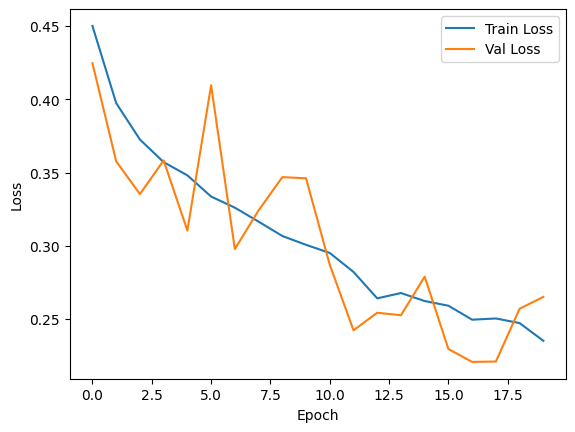

In [8]:
# Plot the loss history
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**4.5 Make predictions and save the result**

In [9]:
import numpy as np
import os
import torch
import pandas as pd
from skimage.io import imread

model.eval()

test_images_path = '/kaggle/input/histopathologic-cancer-detection/test/'
test_image_files = os.listdir(test_images_path)
#test_image_files = test_image_files[:10]

batch_size = 32
num_images = len(test_image_files)
predictions = []

for i in range(0, num_images, batch_size):
    batch_files = test_image_files[i:i + batch_size]
    batch_images = [imread(os.path.join(test_images_path, img_file)) for img_file in batch_files]
    batch_images_normalized = np.array(batch_images) / 255.0
    #batch_images_tensor = torch.tensor(batch_images_normalized, dtype=torch.float32).permute(0, 3, 1, 2)
    batch_images_tensor = torch.tensor(batch_images_normalized, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

    
    with torch.no_grad():
        model.eval()
#       batch_predictions = model(batch_images_tensor).numpy()
        batch_predictions = model(batch_images_tensor).cpu().numpy()

        predictions.extend(batch_predictions)

predictions = np.array(predictions)

binary_predictions = [(p[0] <= 0.5) for p in predictions]
binary_predictions = [1 if p else 0 for p in binary_predictions]

for i in range(10):
    print(f"Image {i + 1}: {test_image_files[i]}")
    print(f"Probability: {predictions[i][0]:.4f}")
    print(f"Predicted Label: {binary_predictions[i]}\n")

submission_df = pd.DataFrame({'id': [img_file[:-4] for img_file in test_image_files], 'label': binary_predictions})
submission_df = submission_df.replace({'label': {'FALSE': 0, 'TRUE': 1}})

print(f"Total number of predictions: {len(submission_df)}")

Image 1: a7ea26360815d8492433b14cd8318607bcf99d9e.tif
Probability: 0.8291
Predicted Label: 0

Image 2: 59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
Probability: 1.7565
Predicted Label: 0

Image 3: 5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
Probability: 1.4666
Predicted Label: 0

Image 4: bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
Probability: 3.1674
Predicted Label: 0

Image 5: 523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif
Probability: 0.6829
Predicted Label: 0

Image 6: d23c66547f4a00555a174d2fcb860ae399b66edc.tif
Probability: 2.3036
Predicted Label: 0

Image 7: fabf2fca23f71655974767e29eda86a9b2c97a72.tif
Probability: 2.4389
Predicted Label: 0

Image 8: 9730b15862516b8641b9f0ff48db660d95031c32.tif
Probability: 2.1378
Predicted Label: 0

Image 9: ee85348c0950c2e639776fb555e3452c1f8437c0.tif
Probability: 2.4440
Predicted Label: 0

Image 10: ef12a0813c504d2d1b2ba485e78d380ad64a0622.tif
Probability: 2.3922
Predicted Label: 0

Total number of predictions: 57458


In [10]:
# Remove the old submission.csv file if it exists
submission_csv_path = '/kaggle/working/submission.csv'
if os.path.exists(submission_csv_path):
    os.remove(submission_csv_path)

submission_df.to_csv(submission_csv_path, index=False)

#shutil.make_archive('/kaggle/working/working_directory', 'zip', '/kaggle/working/')

# 5. Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?